In [3]:
import os
import time

import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import sys, time, os, warnings
import numpy as np
import pandas as pd
from collections import Counter
from keras.preprocessing.image import load_img
from nltk.tokenize import word_tokenize
warnings.filterwarnings("ignore")




In [4]:
# Install Kaggle API and upload the Kaggle JSON file
!pip install kaggle
from google.colab import files
files.upload()  # Upload kaggle.json

# Move the kaggle.json file to the right directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the Flickr8k dataset
!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip -d /content/flickr8k


Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: /content/flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: /content/flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/flickr8k/Images/2848977044_446a31d86e.jpg  
  inflating: /content/fli

In [5]:
import os

# Define the paths to the caption file and image directory
dir_Flickr_text = "/content/flickr8k/captions.txt"
dir_Flickr_jpg = "/content/flickr8k/Images"

# List all files in the image directory
jpgs = os.listdir(dir_Flickr_jpg)

# Filter to only include JPEG files
jpgs = [file for file in jpgs if file.lower().endswith('.jpg')]

print("The number of jpg files in Flickr8k: {}".format(len(jpgs)))


The number of jpg files in Flickr8k: 8091


In [6]:
## loading as dataframe
def load_csv(directory):
    desc=dict()
    text = pd.read_csv(directory, delimiter='|',header=None,names=["filename","index","caption"])
    text = text.iloc[1:,:]
    df_new = text[text.iloc[:,2].notnull()]
    print(df_new.iloc[:5,:])
    return df_new

In [7]:
import pandas as pd
import numpy as np
from collections import Counter

# Define the path to the caption file
dir_Flickr_text = "/content/flickr8k/captions.txt"

# Load the caption file into a DataFrame
df_txt = pd.read_csv(dir_Flickr_text, delimiter=',', header=0, names=['filename', 'caption'])

# Display the first few rows of the DataFrame
print("DataFrame head:")
print(df_txt.head())

# Get unique filenames and their counts
uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))

# Distribution of the number of captions for each image
caption_counts = Counter(df_txt.filename.values)
print("The distribution of the number of captions for each image:")
print(Counter(caption_counts.values()))


DataFrame head:
                    filename  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
The number of unique file names : 8091
The distribution of the number of captions for each image:
Counter({5: 8091})


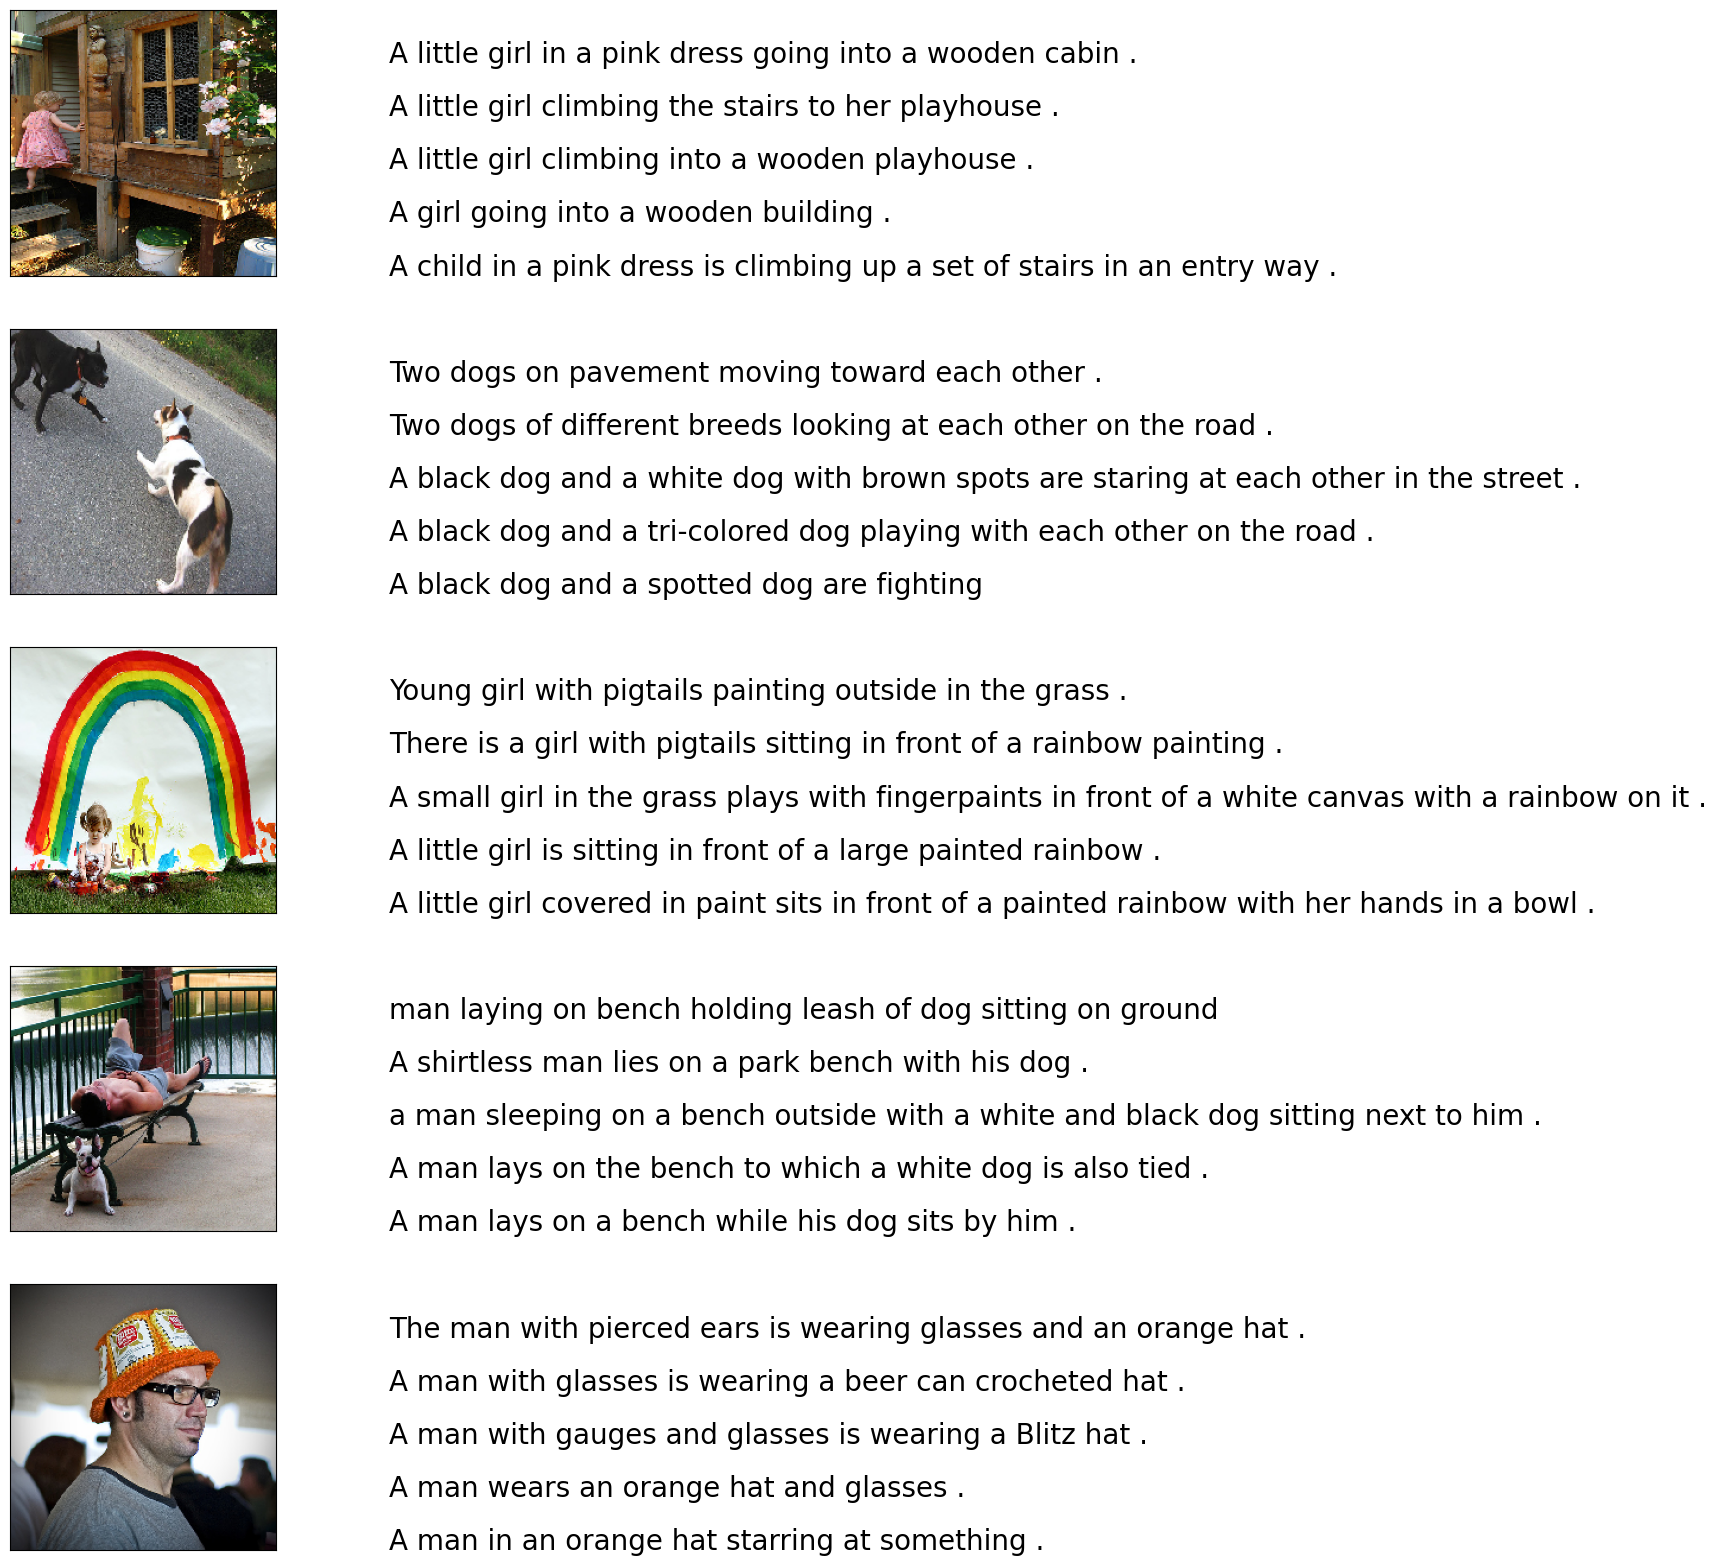

In [8]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [9]:
def df_word(df_txt):
    # Ensure that we are using the correct column for captions
    vocabulary = []
    for i in range(len(df_txt)):
        temp = df_txt.iloc[i, 1]  # Changed to index 1 for 'caption'
        vocabulary.extend(temp.split())

    print('Vocabulary Size: %d' % len(set(vocabulary)))

    # Count word frequencies
    ct = Counter(vocabulary)

    # Create DataFrame from the Counter object
    dfword = pd.DataFrame({"word": list(ct.keys()), "count": list(ct.values())})

    # Sort the DataFrame by count in descending order
    dfword = dfword.sort_values("count", ascending=False)

    # Reset index and select relevant columns
    dfword = dfword.reset_index(drop=True)[["word", "count"]]

    return dfword

# Call the function and display the top 3 words
dfword = df_word(df_txt)
print(dfword.head(3))


Vocabulary Size: 9630
  word  count
0    a  40319
1    .  36577
2    A  22667


In [10]:
import string
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [12]:
!pip install progressbar2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 951.5 kB/s eta 0:00:00


In [13]:
import progressbar
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

with progressbar.ProgressBar(max_value=len(df_txt.caption.values)) as bar:
    for i, caption in enumerate(df_txt.caption.values):
        newcaption = text_clean(caption)
        df_txt["caption"].iloc[i] = newcaption
        bar.update(i)

100% (40455 of 40455) |##################| Elapsed Time: 0:00:15 Time:  0:00:15


In [14]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [15]:
from keras.applications import VGG16

# Load the VGG16 model with pre-trained weights from ImageNet
modelvgg = VGG16(include_top=True, weights='imagenet')

# Print the model summary to verify
modelvgg.summary()


553467096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [16]:
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
## show the deep learning model
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
with progressbar.ProgressBar(max_value=len(jpgs)) as bar:
    for i,name in enumerate(jpgs):
        # load an image from file
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        nimage = preprocess_input(image)
        y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
        images[name] = y_pred.flatten()
        bar.update(i)
    #print(i,filename)

1/1 [==============================] - 0s 311ms/step


  0% (0 of 8091) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

1/1 [==============================] - 0s 121ms/step


  0% (1 of 8091) |                       | Elapsed Time: 0:00:00 ETA:   0:23:58

1/1 [==============================] - 0s 117ms/step


  0% (2 of 8091) |                       | Elapsed Time: 0:00:00 ETA:   0:23:49

1/1 [==============================] - 0s 123ms/step


  0% (3 of 8091) |                       | Elapsed Time: 0:00:00 ETA:   0:23:59

1/1 [==============================] - 0s 122ms/step


  0% (4 of 8091) |                       | Elapsed Time: 0:00:00 ETA:   0:24:11

1/1 [==============================] - 0s 122ms/step


  0% (5 of 8091) |                       | Elapsed Time: 0:00:00 ETA:   0:24:14

1/1 [==============================] - 0s 119ms/step


  0% (6 of 8091) |                       | Elapsed Time: 0:00:01 ETA:   0:24:13

1/1 [==============================] - 0s 123ms/step


  0% (7 of 8091) |                       | Elapsed Time: 0:00:01 ETA:   0:24:19

1/1 [==============================] - 0s 138ms/step


  0% (8 of 8091) |                       | Elapsed Time: 0:00:01 ETA:   0:24:36

1/1 [==============================] - 0s 147ms/step


  0% (9 of 8091) |                       | Elapsed Time: 0:00:01 ETA:   0:25:04

1/1 [==============================] - 0s 143ms/step


  0% (10 of 8091) |                      | Elapsed Time: 0:00:01 ETA:   0:25:20

1/1 [==============================] - 0s 146ms/step


  0% (11 of 8091) |                      | Elapsed Time: 0:00:02 ETA:   0:25:35

1/1 [==============================] - 0s 128ms/step


  0% (12 of 8091) |                      | Elapsed Time: 0:00:02 ETA:   0:25:34

1/1 [==============================] - 0s 124ms/step


  0% (13 of 8091) |                      | Elapsed Time: 0:00:02 ETA:   0:25:29

1/1 [==============================] - 0s 126ms/step


  0% (14 of 8091) |                      | Elapsed Time: 0:00:02 ETA:   0:25:30

1/1 [==============================] - 0s 122ms/step


  0% (15 of 8091) |                      | Elapsed Time: 0:00:02 ETA:   0:25:26

1/1 [==============================] - 0s 121ms/step


  0% (16 of 8091) |                      | Elapsed Time: 0:00:03 ETA:   0:25:22

1/1 [==============================] - 0s 145ms/step


  0% (17 of 8091) |                      | Elapsed Time: 0:00:03 ETA:   0:25:29

1/1 [==============================] - 0s 152ms/step


  0% (18 of 8091) |                      | Elapsed Time: 0:00:03 ETA:   0:25:44

1/1 [==============================] - 0s 144ms/step


  0% (19 of 8091) |                      | Elapsed Time: 0:00:03 ETA:   0:25:51

1/1 [==============================] - 0s 158ms/step


  0% (20 of 8091) |                      | Elapsed Time: 0:00:03 ETA:   0:26:03

1/1 [==============================] - 0s 138ms/step


  0% (21 of 8091) |                      | Elapsed Time: 0:00:04 ETA:   0:26:05

1/1 [==============================] - 0s 138ms/step


  0% (22 of 8091) |                      | Elapsed Time: 0:00:04 ETA:   0:26:07

1/1 [==============================] - 0s 145ms/step


  0% (23 of 8091) |                      | Elapsed Time: 0:00:04 ETA:   0:26:09

1/1 [==============================] - 0s 127ms/step


  0% (24 of 8091) |                      | Elapsed Time: 0:00:04 ETA:   0:26:08

1/1 [==============================] - 0s 120ms/step


  0% (25 of 8091) |                      | Elapsed Time: 0:00:04 ETA:   0:26:03

1/1 [==============================] - 0s 143ms/step


  0% (26 of 8091) |                      | Elapsed Time: 0:00:05 ETA:   0:26:05

1/1 [==============================] - 0s 137ms/step


  0% (27 of 8091) |                      | Elapsed Time: 0:00:05 ETA:   0:26:08

1/1 [==============================] - 0s 149ms/step


  0% (28 of 8091) |                      | Elapsed Time: 0:00:05 ETA:   0:26:11

1/1 [==============================] - 0s 119ms/step


  0% (29 of 8091) |                      | Elapsed Time: 0:00:05 ETA:   0:26:06

1/1 [==============================] - 0s 117ms/step


  0% (30 of 8091) |                      | Elapsed Time: 0:00:05 ETA:   0:26:01

1/1 [==============================] - 0s 115ms/step


  0% (31 of 8091) |                      | Elapsed Time: 0:00:05 ETA:   0:25:56

1/1 [==============================] - 0s 120ms/step


  0% (32 of 8091) |                      | Elapsed Time: 0:00:06 ETA:   0:25:52

1/1 [==============================] - 0s 117ms/step


  0% (33 of 8091) |                      | Elapsed Time: 0:00:06 ETA:   0:25:49

1/1 [==============================] - 0s 120ms/step


  0% (34 of 8091) |                      | Elapsed Time: 0:00:06 ETA:   0:25:45

1/1 [==============================] - 0s 121ms/step


  0% (35 of 8091) |                      | Elapsed Time: 0:00:06 ETA:   0:25:42

1/1 [==============================] - 0s 114ms/step


  0% (36 of 8091) |                      | Elapsed Time: 0:00:06 ETA:   0:25:39

1/1 [==============================] - 0s 123ms/step


  0% (37 of 8091) |                      | Elapsed Time: 0:00:07 ETA:   0:25:37

1/1 [==============================] - 0s 117ms/step


  0% (38 of 8091) |                      | Elapsed Time: 0:00:07 ETA:   0:25:33

1/1 [==============================] - 0s 122ms/step


  0% (39 of 8091) |                      | Elapsed Time: 0:00:07 ETA:   0:25:33

1/1 [==============================] - 0s 119ms/step


  0% (40 of 8091) |                      | Elapsed Time: 0:00:07 ETA:   0:25:30

1/1 [==============================] - 0s 122ms/step


  0% (41 of 8091) |                      | Elapsed Time: 0:00:07 ETA:   0:25:28

1/1 [==============================] - 0s 120ms/step


  0% (42 of 8091) |                      | Elapsed Time: 0:00:07 ETA:   0:25:26

1/1 [==============================] - 0s 135ms/step


  0% (43 of 8091) |                      | Elapsed Time: 0:00:08 ETA:   0:25:26

1/1 [==============================] - 0s 144ms/step


  0% (44 of 8091) |                      | Elapsed Time: 0:00:08 ETA:   0:25:29

1/1 [==============================] - 0s 124ms/step


  0% (45 of 8091) |                      | Elapsed Time: 0:00:08 ETA:   0:25:29

1/1 [==============================] - 0s 119ms/step


  0% (46 of 8091) |                      | Elapsed Time: 0:00:08 ETA:   0:25:27

1/1 [==============================] - 0s 131ms/step


  0% (47 of 8091) |                      | Elapsed Time: 0:00:08 ETA:   0:25:27

1/1 [==============================] - 0s 150ms/step


  0% (48 of 8091) |                      | Elapsed Time: 0:00:09 ETA:   0:25:30

1/1 [==============================] - 0s 117ms/step


  0% (49 of 8091) |                      | Elapsed Time: 0:00:09 ETA:   0:25:28

1/1 [==============================] - 0s 132ms/step


  0% (50 of 8091) |                      | Elapsed Time: 0:00:09 ETA:   0:25:28

1/1 [==============================] - 0s 148ms/step


  0% (51 of 8091) |                      | Elapsed Time: 0:00:09 ETA:   0:25:31

1/1 [==============================] - 0s 117ms/step


  0% (52 of 8091) |                      | Elapsed Time: 0:00:09 ETA:   0:25:29

1/1 [==============================] - 0s 116ms/step


  0% (53 of 8091) |                      | Elapsed Time: 0:00:10 ETA:   0:25:26

1/1 [==============================] - 0s 141ms/step


  0% (54 of 8091) |                      | Elapsed Time: 0:00:10 ETA:   0:25:28

1/1 [==============================] - 0s 151ms/step


  0% (55 of 8091) |                      | Elapsed Time: 0:00:10 ETA:   0:25:31

1/1 [==============================] - 0s 117ms/step


  0% (56 of 8091) |                      | Elapsed Time: 0:00:10 ETA:   0:25:29

1/1 [==============================] - 0s 124ms/step


  0% (57 of 8091) |                      | Elapsed Time: 0:00:10 ETA:   0:25:29

1/1 [==============================] - 0s 122ms/step


  0% (58 of 8091) |                      | Elapsed Time: 0:00:11 ETA:   0:25:27

1/1 [==============================] - 0s 124ms/step


  0% (59 of 8091) |                      | Elapsed Time: 0:00:11 ETA:   0:25:26

1/1 [==============================] - 0s 119ms/step


  0% (60 of 8091) |                      | Elapsed Time: 0:00:11 ETA:   0:25:25

1/1 [==============================] - 0s 117ms/step


  0% (61 of 8091) |                      | Elapsed Time: 0:00:11 ETA:   0:25:23

1/1 [==============================] - 0s 113ms/step


  0% (62 of 8091) |                      | Elapsed Time: 0:00:11 ETA:   0:25:20

1/1 [==============================] - 0s 133ms/step


  0% (63 of 8091) |                      | Elapsed Time: 0:00:11 ETA:   0:25:21

1/1 [==============================] - 0s 142ms/step


  0% (64 of 8091) |                      | Elapsed Time: 0:00:12 ETA:   0:25:22

1/1 [==============================] - 0s 113ms/step


  0% (65 of 8091) |                      | Elapsed Time: 0:00:12 ETA:   0:25:18

1/1 [==============================] - 0s 115ms/step


  0% (66 of 8091) |                      | Elapsed Time: 0:00:12 ETA:   0:25:16

1/1 [==============================] - 0s 133ms/step


  0% (67 of 8091) |                      | Elapsed Time: 0:00:12 ETA:   0:25:16

1/1 [==============================] - 0s 142ms/step


  0% (68 of 8091) |                      | Elapsed Time: 0:00:12 ETA:   0:25:17

1/1 [==============================] - 0s 130ms/step


  0% (69 of 8091) |                      | Elapsed Time: 0:00:13 ETA:   0:25:17

1/1 [==============================] - 0s 142ms/step


  0% (70 of 8091) |                      | Elapsed Time: 0:00:13 ETA:   0:25:17

1/1 [==============================] - 0s 130ms/step


  0% (71 of 8091) |                      | Elapsed Time: 0:00:13 ETA:   0:25:17

1/1 [==============================] - 0s 142ms/step


  0% (72 of 8091) |                      | Elapsed Time: 0:00:13 ETA:   0:25:18

1/1 [==============================] - 0s 133ms/step


  0% (73 of 8091) |                      | Elapsed Time: 0:00:13 ETA:   0:25:18

1/1 [==============================] - 0s 144ms/step


  0% (74 of 8091) |                      | Elapsed Time: 0:00:14 ETA:   0:25:19

1/1 [==============================] - 0s 134ms/step


  0% (75 of 8091) |                      | Elapsed Time: 0:00:14 ETA:   0:25:19

1/1 [==============================] - 0s 140ms/step


  0% (76 of 8091) |                      | Elapsed Time: 0:00:14 ETA:   0:25:19

1/1 [==============================] - 0s 137ms/step


  0% (77 of 8091) |                      | Elapsed Time: 0:00:14 ETA:   0:25:19

1/1 [==============================] - 0s 138ms/step


  0% (78 of 8091) |                      | Elapsed Time: 0:00:14 ETA:   0:25:19

1/1 [==============================] - 0s 136ms/step


  0% (79 of 8091) |                      | Elapsed Time: 0:00:14 ETA:   0:25:19

1/1 [==============================] - 0s 139ms/step


  0% (80 of 8091) |                      | Elapsed Time: 0:00:15 ETA:   0:25:20

1/1 [==============================] - 0s 138ms/step


  1% (81 of 8091) |                      | Elapsed Time: 0:00:15 ETA:   0:25:21

1/1 [==============================] - 0s 145ms/step


  1% (82 of 8091) |                      | Elapsed Time: 0:00:15 ETA:   0:25:21

1/1 [==============================] - 0s 114ms/step


  1% (83 of 8091) |                      | Elapsed Time: 0:00:15 ETA:   0:25:19

1/1 [==============================] - 0s 131ms/step


  1% (84 of 8091) |                      | Elapsed Time: 0:00:15 ETA:   0:25:19

1/1 [==============================] - 0s 137ms/step


  1% (85 of 8091) |                      | Elapsed Time: 0:00:16 ETA:   0:25:19

1/1 [==============================] - 0s 141ms/step


  1% (86 of 8091) |                      | Elapsed Time: 0:00:16 ETA:   0:25:20

1/1 [==============================] - 0s 130ms/step


  1% (87 of 8091) |                      | Elapsed Time: 0:00:16 ETA:   0:25:19

1/1 [==============================] - 0s 137ms/step


  1% (88 of 8091) |                      | Elapsed Time: 0:00:16 ETA:   0:25:19

1/1 [==============================] - 0s 136ms/step


  1% (89 of 8091) |                      | Elapsed Time: 0:00:16 ETA:   0:25:19

1/1 [==============================] - 0s 136ms/step


  1% (90 of 8091) |                      | Elapsed Time: 0:00:17 ETA:   0:25:20

1/1 [==============================] - 0s 136ms/step


  1% (91 of 8091) |                      | Elapsed Time: 0:00:17 ETA:   0:25:19

1/1 [==============================] - 0s 143ms/step


  1% (92 of 8091) |                      | Elapsed Time: 0:00:17 ETA:   0:25:20

1/1 [==============================] - 0s 113ms/step


  1% (93 of 8091) |                      | Elapsed Time: 0:00:17 ETA:   0:25:18

1/1 [==============================] - 0s 129ms/step


  1% (94 of 8091) |                      | Elapsed Time: 0:00:17 ETA:   0:25:17

1/1 [==============================] - 0s 142ms/step


  1% (95 of 8091) |                      | Elapsed Time: 0:00:18 ETA:   0:25:18

1/1 [==============================] - 0s 128ms/step


  1% (96 of 8091) |                      | Elapsed Time: 0:00:18 ETA:   0:25:17

1/1 [==============================] - 0s 140ms/step


  1% (97 of 8091) |                      | Elapsed Time: 0:00:18 ETA:   0:25:18

1/1 [==============================] - 0s 131ms/step


  1% (98 of 8091) |                      | Elapsed Time: 0:00:18 ETA:   0:25:17

1/1 [==============================] - 0s 132ms/step


  1% (99 of 8091) |                      | Elapsed Time: 0:00:18 ETA:   0:25:17

1/1 [==============================] - 0s 134ms/step


  1% (100 of 8091) |                     | Elapsed Time: 0:00:18 ETA:   0:25:17

1/1 [==============================] - 0s 145ms/step


  1% (101 of 8091) |                     | Elapsed Time: 0:00:19 ETA:   0:25:18

1/1 [==============================] - 0s 127ms/step


  1% (102 of 8091) |                     | Elapsed Time: 0:00:19 ETA:   0:25:17

1/1 [==============================] - 0s 148ms/step


  1% (103 of 8091) |                     | Elapsed Time: 0:00:19 ETA:   0:25:18

1/1 [==============================] - 0s 129ms/step


  1% (104 of 8091) |                     | Elapsed Time: 0:00:19 ETA:   0:25:17

1/1 [==============================] - 0s 133ms/step


  1% (105 of 8091) |                     | Elapsed Time: 0:00:19 ETA:   0:25:17

1/1 [==============================] - 0s 132ms/step


  1% (106 of 8091) |                     | Elapsed Time: 0:00:20 ETA:   0:25:17

1/1 [==============================] - 0s 140ms/step


  1% (107 of 8091) |                     | Elapsed Time: 0:00:20 ETA:   0:25:17

1/1 [==============================] - 0s 113ms/step


  1% (108 of 8091) |                     | Elapsed Time: 0:00:20 ETA:   0:25:16

1/1 [==============================] - 0s 118ms/step


  1% (109 of 8091) |                     | Elapsed Time: 0:00:20 ETA:   0:25:15

1/1 [==============================] - 0s 132ms/step


  1% (110 of 8091) |                     | Elapsed Time: 0:00:20 ETA:   0:25:15

1/1 [==============================] - 0s 135ms/step


  1% (111 of 8091) |                     | Elapsed Time: 0:00:21 ETA:   0:25:15

1/1 [==============================] - 0s 142ms/step


  1% (112 of 8091) |                     | Elapsed Time: 0:00:21 ETA:   0:25:16

1/1 [==============================] - 0s 140ms/step


  1% (113 of 8091) |                     | Elapsed Time: 0:00:21 ETA:   0:25:16

1/1 [==============================] - 0s 144ms/step


  1% (114 of 8091) |                     | Elapsed Time: 0:00:21 ETA:   0:25:17

1/1 [==============================] - 0s 141ms/step


  1% (115 of 8091) |                     | Elapsed Time: 0:00:21 ETA:   0:25:18

1/1 [==============================] - 0s 134ms/step


  1% (116 of 8091) |                     | Elapsed Time: 0:00:22 ETA:   0:25:18

1/1 [==============================] - 0s 134ms/step


  1% (117 of 8091) |                     | Elapsed Time: 0:00:22 ETA:   0:25:19

1/1 [==============================] - 0s 132ms/step


  1% (118 of 8091) |                     | Elapsed Time: 0:00:22 ETA:   0:25:18

1/1 [==============================] - 0s 135ms/step


  1% (119 of 8091) |                     | Elapsed Time: 0:00:22 ETA:   0:25:19

1/1 [==============================] - 0s 134ms/step


  1% (120 of 8091) |                     | Elapsed Time: 0:00:22 ETA:   0:25:19

1/1 [==============================] - 0s 144ms/step


  1% (121 of 8091) |                     | Elapsed Time: 0:00:23 ETA:   0:25:19

1/1 [==============================] - 0s 129ms/step


  1% (122 of 8091) |                     | Elapsed Time: 0:00:23 ETA:   0:25:19

1/1 [==============================] - 0s 143ms/step


  1% (123 of 8091) |                     | Elapsed Time: 0:00:23 ETA:   0:25:19

1/1 [==============================] - 0s 116ms/step


  1% (124 of 8091) |                     | Elapsed Time: 0:00:23 ETA:   0:25:18

1/1 [==============================] - 0s 136ms/step


  1% (125 of 8091) |                     | Elapsed Time: 0:00:23 ETA:   0:25:18

1/1 [==============================] - 0s 136ms/step


  1% (126 of 8091) |                     | Elapsed Time: 0:00:24 ETA:   0:25:19

1/1 [==============================] - 0s 133ms/step


  1% (127 of 8091) |                     | Elapsed Time: 0:00:24 ETA:   0:25:19

1/1 [==============================] - 0s 132ms/step


  1% (128 of 8091) |                     | Elapsed Time: 0:00:24 ETA:   0:25:18

1/1 [==============================] - 0s 144ms/step


  1% (129 of 8091) |                     | Elapsed Time: 0:00:24 ETA:   0:25:19

1/1 [==============================] - 0s 113ms/step


  1% (130 of 8091) |                     | Elapsed Time: 0:00:24 ETA:   0:25:18

1/1 [==============================] - 0s 114ms/step


  1% (131 of 8091) |                     | Elapsed Time: 0:00:24 ETA:   0:25:16

1/1 [==============================] - 0s 128ms/step


  1% (132 of 8091) |                     | Elapsed Time: 0:00:25 ETA:   0:25:16

1/1 [==============================] - 0s 141ms/step


  1% (133 of 8091) |                     | Elapsed Time: 0:00:25 ETA:   0:25:16

1/1 [==============================] - 0s 111ms/step


  1% (134 of 8091) |                     | Elapsed Time: 0:00:25 ETA:   0:25:15

1/1 [==============================] - 0s 133ms/step


  1% (135 of 8091) |                     | Elapsed Time: 0:00:25 ETA:   0:25:15

1/1 [==============================] - 0s 143ms/step


  1% (136 of 8091) |                     | Elapsed Time: 0:00:25 ETA:   0:25:16

1/1 [==============================] - 0s 116ms/step


  1% (137 of 8091) |                     | Elapsed Time: 0:00:26 ETA:   0:25:15

1/1 [==============================] - 0s 115ms/step


  1% (138 of 8091) |                     | Elapsed Time: 0:00:26 ETA:   0:25:14

1/1 [==============================] - 0s 116ms/step


  1% (139 of 8091) |                     | Elapsed Time: 0:00:26 ETA:   0:25:13

1/1 [==============================] - 0s 117ms/step


  1% (140 of 8091) |                     | Elapsed Time: 0:00:26 ETA:   0:25:12

1/1 [==============================] - 0s 119ms/step


  1% (141 of 8091) |                     | Elapsed Time: 0:00:26 ETA:   0:25:11

1/1 [==============================] - 0s 118ms/step


  1% (142 of 8091) |                     | Elapsed Time: 0:00:26 ETA:   0:25:10

1/1 [==============================] - 0s 116ms/step


  1% (143 of 8091) |                     | Elapsed Time: 0:00:27 ETA:   0:25:09

1/1 [==============================] - 0s 134ms/step


  1% (144 of 8091) |                     | Elapsed Time: 0:00:27 ETA:   0:25:09

1/1 [==============================] - 0s 135ms/step


  1% (145 of 8091) |                     | Elapsed Time: 0:00:27 ETA:   0:25:09

1/1 [==============================] - 0s 137ms/step


  1% (146 of 8091) |                     | Elapsed Time: 0:00:27 ETA:   0:25:09

1/1 [==============================] - 0s 146ms/step


  1% (147 of 8091) |                     | Elapsed Time: 0:00:27 ETA:   0:25:10

1/1 [==============================] - 0s 117ms/step


  1% (148 of 8091) |                     | Elapsed Time: 0:00:28 ETA:   0:25:08

1/1 [==============================] - 0s 114ms/step


  1% (149 of 8091) |                     | Elapsed Time: 0:00:28 ETA:   0:25:07

1/1 [==============================] - 0s 130ms/step


  1% (150 of 8091) |                     | Elapsed Time: 0:00:28 ETA:   0:25:07

1/1 [==============================] - 0s 135ms/step


  1% (151 of 8091) |                     | Elapsed Time: 0:00:28 ETA:   0:25:07

1/1 [==============================] - 0s 135ms/step


  1% (152 of 8091) |                     | Elapsed Time: 0:00:28 ETA:   0:25:07

1/1 [==============================] - 0s 136ms/step


  1% (153 of 8091) |                     | Elapsed Time: 0:00:29 ETA:   0:25:07

1/1 [==============================] - 0s 137ms/step


  1% (154 of 8091) |                     | Elapsed Time: 0:00:29 ETA:   0:25:07

1/1 [==============================] - 0s 135ms/step


  1% (155 of 8091) |                     | Elapsed Time: 0:00:29 ETA:   0:25:07

1/1 [==============================] - 0s 137ms/step


  1% (156 of 8091) |                     | Elapsed Time: 0:00:29 ETA:   0:25:07

1/1 [==============================] - 0s 145ms/step


  1% (157 of 8091) |                     | Elapsed Time: 0:00:29 ETA:   0:25:07

1/1 [==============================] - 0s 111ms/step


  1% (158 of 8091) |                     | Elapsed Time: 0:00:30 ETA:   0:25:06

1/1 [==============================] - 0s 115ms/step


  1% (159 of 8091) |                     | Elapsed Time: 0:00:30 ETA:   0:25:05

1/1 [==============================] - 0s 129ms/step


  1% (160 of 8091) |                     | Elapsed Time: 0:00:30 ETA:   0:25:05

1/1 [==============================] - 0s 136ms/step


  1% (161 of 8091) |                     | Elapsed Time: 0:00:30 ETA:   0:25:05

1/1 [==============================] - 0s 143ms/step


  2% (162 of 8091) |                     | Elapsed Time: 0:00:30 ETA:   0:25:05

1/1 [==============================] - 0s 132ms/step


  2% (163 of 8091) |                     | Elapsed Time: 0:00:30 ETA:   0:25:05

1/1 [==============================] - 0s 134ms/step


  2% (164 of 8091) |                     | Elapsed Time: 0:00:31 ETA:   0:25:05

1/1 [==============================] - 0s 140ms/step


  2% (165 of 8091) |                     | Elapsed Time: 0:00:31 ETA:   0:25:06

1/1 [==============================] - 0s 113ms/step


  2% (166 of 8091) |                     | Elapsed Time: 0:00:31 ETA:   0:25:04

1/1 [==============================] - 0s 114ms/step


  2% (167 of 8091) |                     | Elapsed Time: 0:00:31 ETA:   0:25:03

1/1 [==============================] - 0s 116ms/step


  2% (168 of 8091) |                     | Elapsed Time: 0:00:31 ETA:   0:25:02

1/1 [==============================] - 0s 133ms/step


  2% (169 of 8091) |                     | Elapsed Time: 0:00:32 ETA:   0:25:02

1/1 [==============================] - 0s 135ms/step


  2% (170 of 8091) |                     | Elapsed Time: 0:00:32 ETA:   0:25:02

1/1 [==============================] - 0s 132ms/step


  2% (171 of 8091) |                     | Elapsed Time: 0:00:32 ETA:   0:25:02

1/1 [==============================] - 0s 136ms/step


  2% (172 of 8091) |                     | Elapsed Time: 0:00:32 ETA:   0:25:02

1/1 [==============================] - 0s 139ms/step


  2% (173 of 8091) |                     | Elapsed Time: 0:00:32 ETA:   0:25:02

1/1 [==============================] - 0s 144ms/step


  2% (174 of 8091) |                     | Elapsed Time: 0:00:33 ETA:   0:25:03

1/1 [==============================] - 0s 130ms/step


  2% (175 of 8091) |                     | Elapsed Time: 0:00:33 ETA:   0:25:03

1/1 [==============================] - 0s 133ms/step


  2% (176 of 8091) |                     | Elapsed Time: 0:00:33 ETA:   0:25:03

1/1 [==============================] - 0s 135ms/step


  2% (177 of 8091) |                     | Elapsed Time: 0:00:33 ETA:   0:25:03

1/1 [==============================] - 0s 135ms/step


  2% (178 of 8091) |                     | Elapsed Time: 0:00:33 ETA:   0:25:03

1/1 [==============================] - 0s 132ms/step


  2% (179 of 8091) |                     | Elapsed Time: 0:00:34 ETA:   0:25:02

1/1 [==============================] - 0s 131ms/step


  2% (180 of 8091) |                     | Elapsed Time: 0:00:34 ETA:   0:25:02

1/1 [==============================] - 0s 134ms/step


  2% (181 of 8091) |                     | Elapsed Time: 0:00:34 ETA:   0:25:02

1/1 [==============================] - 0s 134ms/step


  2% (182 of 8091) |                     | Elapsed Time: 0:00:34 ETA:   0:25:02

1/1 [==============================] - 0s 134ms/step


  2% (183 of 8091) |                     | Elapsed Time: 0:00:34 ETA:   0:25:02

1/1 [==============================] - 0s 134ms/step


  2% (184 of 8091) |                     | Elapsed Time: 0:00:34 ETA:   0:25:02

1/1 [==============================] - 0s 132ms/step


  2% (185 of 8091) |                     | Elapsed Time: 0:00:35 ETA:   0:25:02

1/1 [==============================] - 0s 133ms/step


  2% (186 of 8091) |                     | Elapsed Time: 0:00:35 ETA:   0:25:02

1/1 [==============================] - 0s 134ms/step


  2% (187 of 8091) |                     | Elapsed Time: 0:00:35 ETA:   0:25:02

1/1 [==============================] - 0s 132ms/step


  2% (188 of 8091) |                     | Elapsed Time: 0:00:35 ETA:   0:25:01

1/1 [==============================] - 0s 147ms/step


  2% (189 of 8091) |                     | Elapsed Time: 0:00:35 ETA:   0:25:02

1/1 [==============================] - 0s 114ms/step


  2% (190 of 8091) |                     | Elapsed Time: 0:00:36 ETA:   0:25:01

1/1 [==============================] - 0s 116ms/step


  2% (191 of 8091) |                     | Elapsed Time: 0:00:36 ETA:   0:25:00

1/1 [==============================] - 0s 113ms/step


  2% (192 of 8091) |                     | Elapsed Time: 0:00:36 ETA:   0:24:59

1/1 [==============================] - 0s 116ms/step


  2% (193 of 8091) |                     | Elapsed Time: 0:00:36 ETA:   0:24:59

1/1 [==============================] - 0s 115ms/step


  2% (194 of 8091) |                     | Elapsed Time: 0:00:36 ETA:   0:24:58

1/1 [==============================] - 0s 114ms/step


  2% (195 of 8091) |                     | Elapsed Time: 0:00:36 ETA:   0:24:57

1/1 [==============================] - 0s 114ms/step


  2% (196 of 8091) |                     | Elapsed Time: 0:00:37 ETA:   0:24:56

1/1 [==============================] - 0s 112ms/step


  2% (197 of 8091) |                     | Elapsed Time: 0:00:37 ETA:   0:24:55

1/1 [==============================] - 0s 113ms/step


  2% (198 of 8091) |                     | Elapsed Time: 0:00:37 ETA:   0:24:55

1/1 [==============================] - 0s 114ms/step


  2% (199 of 8091) |                     | Elapsed Time: 0:00:37 ETA:   0:24:54

1/1 [==============================] - 0s 117ms/step


  2% (200 of 8091) |                     | Elapsed Time: 0:00:37 ETA:   0:24:53

1/1 [==============================] - 0s 117ms/step


  2% (201 of 8091) |                     | Elapsed Time: 0:00:38 ETA:   0:24:53

1/1 [==============================] - 0s 132ms/step


  2% (202 of 8091) |                     | Elapsed Time: 0:00:38 ETA:   0:24:53

1/1 [==============================] - 0s 136ms/step


  2% (203 of 8091) |                     | Elapsed Time: 0:00:38 ETA:   0:24:53

1/1 [==============================] - 0s 135ms/step


  2% (204 of 8091) |                     | Elapsed Time: 0:00:38 ETA:   0:24:53

1/1 [==============================] - 0s 139ms/step


  2% (205 of 8091) |                     | Elapsed Time: 0:00:38 ETA:   0:24:53

1/1 [==============================] - 0s 135ms/step


  2% (206 of 8091) |                     | Elapsed Time: 0:00:39 ETA:   0:24:52

1/1 [==============================] - 0s 137ms/step


  2% (207 of 8091) |                     | Elapsed Time: 0:00:39 ETA:   0:24:53

1/1 [==============================] - 0s 137ms/step


  2% (208 of 8091) |                     | Elapsed Time: 0:00:39 ETA:   0:24:53

1/1 [==============================] - 0s 137ms/step


  2% (209 of 8091) |                     | Elapsed Time: 0:00:39 ETA:   0:24:53

1/1 [==============================] - 0s 138ms/step


  2% (210 of 8091) |                     | Elapsed Time: 0:00:39 ETA:   0:24:53

1/1 [==============================] - 0s 135ms/step


  2% (211 of 8091) |                     | Elapsed Time: 0:00:39 ETA:   0:24:53

1/1 [==============================] - 0s 145ms/step


  2% (212 of 8091) |                     | Elapsed Time: 0:00:40 ETA:   0:24:53

1/1 [==============================] - 0s 131ms/step


  2% (213 of 8091) |                     | Elapsed Time: 0:00:40 ETA:   0:24:52

1/1 [==============================] - 0s 144ms/step


  2% (214 of 8091) |                     | Elapsed Time: 0:00:40 ETA:   0:24:53

1/1 [==============================] - 0s 117ms/step


  2% (215 of 8091) |                     | Elapsed Time: 0:00:40 ETA:   0:24:52

1/1 [==============================] - 0s 134ms/step


  2% (216 of 8091) |                     | Elapsed Time: 0:00:40 ETA:   0:24:52

1/1 [==============================] - 0s 150ms/step


  2% (217 of 8091) |                     | Elapsed Time: 0:00:41 ETA:   0:24:53

1/1 [==============================] - 0s 116ms/step


  2% (218 of 8091) |                     | Elapsed Time: 0:00:41 ETA:   0:24:53

1/1 [==============================] - 0s 117ms/step


  2% (219 of 8091) |                     | Elapsed Time: 0:00:41 ETA:   0:24:52

1/1 [==============================] - 0s 133ms/step


  2% (220 of 8091) |                     | Elapsed Time: 0:00:41 ETA:   0:24:52

1/1 [==============================] - 0s 148ms/step


  2% (221 of 8091) |                     | Elapsed Time: 0:00:41 ETA:   0:24:52

1/1 [==============================] - 0s 132ms/step


  2% (222 of 8091) |                     | Elapsed Time: 0:00:42 ETA:   0:24:52

1/1 [==============================] - 0s 140ms/step


  2% (223 of 8091) |                     | Elapsed Time: 0:00:42 ETA:   0:24:52

1/1 [==============================] - 0s 140ms/step


  2% (224 of 8091) |                     | Elapsed Time: 0:00:42 ETA:   0:24:53

1/1 [==============================] - 0s 138ms/step


  2% (225 of 8091) |                     | Elapsed Time: 0:00:42 ETA:   0:24:53

1/1 [==============================] - 0s 132ms/step


  2% (226 of 8091) |                     | Elapsed Time: 0:00:42 ETA:   0:24:53

1/1 [==============================] - 0s 133ms/step


  2% (227 of 8091) |                     | Elapsed Time: 0:00:43 ETA:   0:24:53

1/1 [==============================] - 0s 134ms/step


  2% (228 of 8091) |                     | Elapsed Time: 0:00:43 ETA:   0:24:53

1/1 [==============================] - 0s 133ms/step


  2% (229 of 8091) |                     | Elapsed Time: 0:00:43 ETA:   0:24:53

1/1 [==============================] - 0s 145ms/step


  2% (230 of 8091) |                     | Elapsed Time: 0:00:43 ETA:   0:24:53

1/1 [==============================] - 0s 116ms/step


  2% (231 of 8091) |                     | Elapsed Time: 0:00:43 ETA:   0:24:52

1/1 [==============================] - 0s 114ms/step


  2% (232 of 8091) |                     | Elapsed Time: 0:00:44 ETA:   0:24:52

1/1 [==============================] - 0s 115ms/step


  2% (233 of 8091) |                     | Elapsed Time: 0:00:44 ETA:   0:24:51

1/1 [==============================] - 0s 114ms/step


  2% (234 of 8091) |                     | Elapsed Time: 0:00:44 ETA:   0:24:50

1/1 [==============================] - 0s 118ms/step


  2% (235 of 8091) |                     | Elapsed Time: 0:00:44 ETA:   0:24:50

1/1 [==============================] - 0s 113ms/step


  2% (236 of 8091) |                     | Elapsed Time: 0:00:44 ETA:   0:24:49

1/1 [==============================] - 0s 116ms/step


  2% (237 of 8091) |                     | Elapsed Time: 0:00:44 ETA:   0:24:48

1/1 [==============================] - 0s 114ms/step


  2% (238 of 8091) |                     | Elapsed Time: 0:00:45 ETA:   0:24:47

1/1 [==============================] - 0s 114ms/step


  2% (239 of 8091) |                     | Elapsed Time: 0:00:45 ETA:   0:24:47

1/1 [==============================] - 0s 112ms/step


  2% (240 of 8091) |                     | Elapsed Time: 0:00:45 ETA:   0:24:46

1/1 [==============================] - 0s 113ms/step


  2% (241 of 8091) |                     | Elapsed Time: 0:00:45 ETA:   0:24:45

1/1 [==============================] - 0s 115ms/step


  2% (242 of 8091) |                     | Elapsed Time: 0:00:45 ETA:   0:24:45

1/1 [==============================] - 0s 113ms/step


  3% (243 of 8091) |                     | Elapsed Time: 0:00:45 ETA:   0:24:44

1/1 [==============================] - 0s 114ms/step


  3% (244 of 8091) |                     | Elapsed Time: 0:00:46 ETA:   0:24:43

1/1 [==============================] - 0s 113ms/step


  3% (245 of 8091) |                     | Elapsed Time: 0:00:46 ETA:   0:24:43

1/1 [==============================] - 0s 114ms/step


  3% (246 of 8091) |                     | Elapsed Time: 0:00:46 ETA:   0:24:42

1/1 [==============================] - 0s 116ms/step


  3% (247 of 8091) |                     | Elapsed Time: 0:00:46 ETA:   0:24:41

1/1 [==============================] - 0s 134ms/step


  3% (248 of 8091) |                     | Elapsed Time: 0:00:46 ETA:   0:24:41

1/1 [==============================] - 0s 134ms/step


  3% (249 of 8091) |                     | Elapsed Time: 0:00:47 ETA:   0:24:41

1/1 [==============================] - 0s 136ms/step


  3% (250 of 8091) |                     | Elapsed Time: 0:00:47 ETA:   0:24:41

1/1 [==============================] - 0s 135ms/step


  3% (251 of 8091) |                     | Elapsed Time: 0:00:47 ETA:   0:24:41

1/1 [==============================] - 0s 147ms/step


  3% (252 of 8091) |                     | Elapsed Time: 0:00:47 ETA:   0:24:42

1/1 [==============================] - 0s 135ms/step


  3% (253 of 8091) |                     | Elapsed Time: 0:00:47 ETA:   0:24:42

1/1 [==============================] - 0s 142ms/step


  3% (254 of 8091) |                     | Elapsed Time: 0:00:48 ETA:   0:24:42

1/1 [==============================] - 0s 123ms/step


  3% (255 of 8091) |                     | Elapsed Time: 0:00:48 ETA:   0:24:42

1/1 [==============================] - 0s 114ms/step


  3% (256 of 8091) |                     | Elapsed Time: 0:00:48 ETA:   0:24:41

1/1 [==============================] - 0s 113ms/step


  3% (257 of 8091) |                     | Elapsed Time: 0:00:48 ETA:   0:24:40

1/1 [==============================] - 0s 114ms/step


  3% (258 of 8091) |                     | Elapsed Time: 0:00:48 ETA:   0:24:39

1/1 [==============================] - 0s 111ms/step


  3% (259 of 8091) |                     | Elapsed Time: 0:00:48 ETA:   0:24:38

1/1 [==============================] - 0s 128ms/step


  3% (260 of 8091) |                     | Elapsed Time: 0:00:49 ETA:   0:24:38

1/1 [==============================] - 0s 134ms/step


  3% (261 of 8091) |                     | Elapsed Time: 0:00:49 ETA:   0:24:38

1/1 [==============================] - 0s 135ms/step


  3% (262 of 8091) |                     | Elapsed Time: 0:00:49 ETA:   0:24:38

1/1 [==============================] - 0s 136ms/step


  3% (263 of 8091) |                     | Elapsed Time: 0:00:49 ETA:   0:24:38

1/1 [==============================] - 0s 144ms/step


  3% (264 of 8091) |                     | Elapsed Time: 0:00:49 ETA:   0:24:39

1/1 [==============================] - 0s 112ms/step


  3% (265 of 8091) |                     | Elapsed Time: 0:00:50 ETA:   0:24:38

1/1 [==============================] - 0s 116ms/step


  3% (266 of 8091) |                     | Elapsed Time: 0:00:50 ETA:   0:24:37

1/1 [==============================] - 0s 114ms/step


  3% (267 of 8091) |                     | Elapsed Time: 0:00:50 ETA:   0:24:37

1/1 [==============================] - 0s 114ms/step


  3% (268 of 8091) |                     | Elapsed Time: 0:00:50 ETA:   0:24:36

1/1 [==============================] - 0s 114ms/step


  3% (269 of 8091) |                     | Elapsed Time: 0:00:50 ETA:   0:24:35

1/1 [==============================] - 0s 116ms/step


  3% (270 of 8091) |                     | Elapsed Time: 0:00:50 ETA:   0:24:35

1/1 [==============================] - 0s 134ms/step


  3% (271 of 8091) |                     | Elapsed Time: 0:00:51 ETA:   0:24:35

1/1 [==============================] - 0s 141ms/step


  3% (272 of 8091) |                     | Elapsed Time: 0:00:51 ETA:   0:24:35

1/1 [==============================] - 0s 139ms/step


  3% (273 of 8091) |                     | Elapsed Time: 0:00:51 ETA:   0:24:35

1/1 [==============================] - 0s 140ms/step


  3% (274 of 8091) |                     | Elapsed Time: 0:00:51 ETA:   0:24:35

1/1 [==============================] - 0s 136ms/step


  3% (275 of 8091) |                     | Elapsed Time: 0:00:51 ETA:   0:24:35

1/1 [==============================] - 0s 136ms/step


  3% (276 of 8091) |                     | Elapsed Time: 0:00:52 ETA:   0:24:35

1/1 [==============================] - 0s 137ms/step


  3% (277 of 8091) |                     | Elapsed Time: 0:00:52 ETA:   0:24:35

1/1 [==============================] - 0s 136ms/step


  3% (278 of 8091) |                     | Elapsed Time: 0:00:52 ETA:   0:24:35

1/1 [==============================] - 0s 137ms/step


  3% (279 of 8091) |                     | Elapsed Time: 0:00:52 ETA:   0:24:35

1/1 [==============================] - 0s 135ms/step


  3% (280 of 8091) |                     | Elapsed Time: 0:00:52 ETA:   0:24:35

1/1 [==============================] - 0s 137ms/step


  3% (281 of 8091) |                     | Elapsed Time: 0:00:53 ETA:   0:24:35

1/1 [==============================] - 0s 144ms/step


  3% (282 of 8091) |                     | Elapsed Time: 0:00:53 ETA:   0:24:35

1/1 [==============================] - 0s 116ms/step


  3% (283 of 8091) |                     | Elapsed Time: 0:00:53 ETA:   0:24:35

1/1 [==============================] - 0s 114ms/step


  3% (284 of 8091) |                     | Elapsed Time: 0:00:53 ETA:   0:24:34

1/1 [==============================] - 0s 113ms/step


  3% (285 of 8091) |                     | Elapsed Time: 0:00:53 ETA:   0:24:33

1/1 [==============================] - 0s 129ms/step


  3% (286 of 8091) |                     | Elapsed Time: 0:00:53 ETA:   0:24:33

1/1 [==============================] - 0s 134ms/step


  3% (287 of 8091) |                     | Elapsed Time: 0:00:54 ETA:   0:24:33

1/1 [==============================] - 0s 133ms/step


  3% (288 of 8091) |                     | Elapsed Time: 0:00:54 ETA:   0:24:32

1/1 [==============================] - 0s 132ms/step


  3% (289 of 8091) |                     | Elapsed Time: 0:00:54 ETA:   0:24:32

1/1 [==============================] - 0s 141ms/step


  3% (290 of 8091) |                     | Elapsed Time: 0:00:54 ETA:   0:24:33

1/1 [==============================] - 0s 130ms/step


  3% (291 of 8091) |                     | Elapsed Time: 0:00:54 ETA:   0:24:32

1/1 [==============================] - 0s 133ms/step


  3% (292 of 8091) |                     | Elapsed Time: 0:00:55 ETA:   0:24:32

1/1 [==============================] - 0s 143ms/step


  3% (293 of 8091) |                     | Elapsed Time: 0:00:55 ETA:   0:24:32

1/1 [==============================] - 0s 112ms/step


  3% (294 of 8091) |                     | Elapsed Time: 0:00:55 ETA:   0:24:31

1/1 [==============================] - 0s 127ms/step


  3% (295 of 8091) |                     | Elapsed Time: 0:00:55 ETA:   0:24:31

1/1 [==============================] - 0s 130ms/step


  3% (296 of 8091) |                     | Elapsed Time: 0:00:55 ETA:   0:24:31

1/1 [==============================] - 0s 142ms/step


  3% (297 of 8091) |                     | Elapsed Time: 0:00:56 ETA:   0:24:31

1/1 [==============================] - 0s 113ms/step


  3% (298 of 8091) |                     | Elapsed Time: 0:00:56 ETA:   0:24:30

1/1 [==============================] - 0s 118ms/step


  3% (299 of 8091) |                     | Elapsed Time: 0:00:56 ETA:   0:24:30

1/1 [==============================] - 0s 118ms/step


  3% (300 of 8091) |                     | Elapsed Time: 0:00:56 ETA:   0:24:29

1/1 [==============================] - 0s 128ms/step


  3% (301 of 8091) |                     | Elapsed Time: 0:00:56 ETA:   0:24:29

1/1 [==============================] - 0s 137ms/step


  3% (302 of 8091) |                     | Elapsed Time: 0:00:56 ETA:   0:24:29

1/1 [==============================] - 0s 133ms/step


  3% (303 of 8091) |                     | Elapsed Time: 0:00:57 ETA:   0:24:29

1/1 [==============================] - 0s 135ms/step


  3% (304 of 8091) |                     | Elapsed Time: 0:00:57 ETA:   0:24:29

1/1 [==============================] - 0s 138ms/step


  3% (305 of 8091) |                     | Elapsed Time: 0:00:57 ETA:   0:24:29

1/1 [==============================] - 0s 134ms/step


  3% (306 of 8091) |                     | Elapsed Time: 0:00:57 ETA:   0:24:28

1/1 [==============================] - 0s 135ms/step


  3% (307 of 8091) |                     | Elapsed Time: 0:00:57 ETA:   0:24:28

1/1 [==============================] - 0s 132ms/step


  3% (308 of 8091) |                     | Elapsed Time: 0:00:58 ETA:   0:24:28

1/1 [==============================] - 0s 132ms/step


  3% (309 of 8091) |                     | Elapsed Time: 0:00:58 ETA:   0:24:28

1/1 [==============================] - 0s 133ms/step


  3% (310 of 8091) |                     | Elapsed Time: 0:00:58 ETA:   0:24:28

1/1 [==============================] - 0s 133ms/step


  3% (311 of 8091) |                     | Elapsed Time: 0:00:58 ETA:   0:24:28

1/1 [==============================] - 0s 132ms/step


  3% (312 of 8091) |                     | Elapsed Time: 0:00:58 ETA:   0:24:28

1/1 [==============================] - 0s 133ms/step


  3% (313 of 8091) |                     | Elapsed Time: 0:00:59 ETA:   0:24:27

1/1 [==============================] - 0s 132ms/step


  3% (314 of 8091) |                     | Elapsed Time: 0:00:59 ETA:   0:24:27

1/1 [==============================] - 0s 131ms/step


  3% (315 of 8091) |                     | Elapsed Time: 0:00:59 ETA:   0:24:27

1/1 [==============================] - 0s 133ms/step


  3% (316 of 8091) |                     | Elapsed Time: 0:00:59 ETA:   0:24:27

1/1 [==============================] - 0s 131ms/step


  3% (317 of 8091) |                     | Elapsed Time: 0:00:59 ETA:   0:24:27

1/1 [==============================] - 0s 138ms/step


  3% (318 of 8091) |                     | Elapsed Time: 0:01:00 ETA:   0:24:27

1/1 [==============================] - 0s 141ms/step


  3% (319 of 8091) |                     | Elapsed Time: 0:01:00 ETA:   0:24:27

1/1 [==============================] - 0s 113ms/step


  3% (320 of 8091) |                     | Elapsed Time: 0:01:00 ETA:   0:24:26

1/1 [==============================] - 0s 129ms/step


  3% (321 of 8091) |                     | Elapsed Time: 0:01:00 ETA:   0:24:26

1/1 [==============================] - 0s 133ms/step


  3% (322 of 8091) |                     | Elapsed Time: 0:01:00 ETA:   0:24:26

1/1 [==============================] - 0s 135ms/step


  3% (323 of 8091) |                     | Elapsed Time: 0:01:00 ETA:   0:24:26

1/1 [==============================] - 0s 133ms/step


  4% (324 of 8091) |                     | Elapsed Time: 0:01:01 ETA:   0:24:25

1/1 [==============================] - 0s 132ms/step


  4% (325 of 8091) |                     | Elapsed Time: 0:01:01 ETA:   0:24:25

1/1 [==============================] - 0s 133ms/step


  4% (326 of 8091) |                     | Elapsed Time: 0:01:01 ETA:   0:24:25

1/1 [==============================] - 0s 133ms/step


  4% (327 of 8091) |                     | Elapsed Time: 0:01:01 ETA:   0:24:25

1/1 [==============================] - 0s 134ms/step


  4% (328 of 8091) |                     | Elapsed Time: 0:01:01 ETA:   0:24:25

1/1 [==============================] - 0s 143ms/step


  4% (329 of 8091) |                     | Elapsed Time: 0:01:02 ETA:   0:24:25

1/1 [==============================] - 0s 113ms/step


  4% (330 of 8091) |                     | Elapsed Time: 0:01:02 ETA:   0:24:24

1/1 [==============================] - 0s 128ms/step


  4% (331 of 8091) |                     | Elapsed Time: 0:01:02 ETA:   0:24:24

1/1 [==============================] - 0s 132ms/step


  4% (332 of 8091) |                     | Elapsed Time: 0:01:02 ETA:   0:24:24

1/1 [==============================] - 0s 137ms/step


  4% (333 of 8091) |                     | Elapsed Time: 0:01:02 ETA:   0:24:24

1/1 [==============================] - 0s 136ms/step


  4% (334 of 8091) |                     | Elapsed Time: 0:01:03 ETA:   0:24:24

1/1 [==============================] - 0s 136ms/step


  4% (335 of 8091) |                     | Elapsed Time: 0:01:03 ETA:   0:24:24

1/1 [==============================] - 0s 134ms/step


  4% (336 of 8091) |                     | Elapsed Time: 0:01:03 ETA:   0:24:23

1/1 [==============================] - 0s 140ms/step


  4% (337 of 8091) |                     | Elapsed Time: 0:01:03 ETA:   0:24:23

1/1 [==============================] - 0s 137ms/step


  4% (338 of 8091) |                     | Elapsed Time: 0:01:03 ETA:   0:24:23

1/1 [==============================] - 0s 137ms/step


  4% (339 of 8091) |                     | Elapsed Time: 0:01:04 ETA:   0:24:23

1/1 [==============================] - 0s 142ms/step


  4% (340 of 8091) |                     | Elapsed Time: 0:01:04 ETA:   0:24:23

1/1 [==============================] - 0s 116ms/step


  4% (341 of 8091) |                     | Elapsed Time: 0:01:04 ETA:   0:24:23

1/1 [==============================] - 0s 278ms/step


  4% (342 of 8091) |                     | Elapsed Time: 0:01:04 ETA:   0:24:26

1/1 [==============================] - 0s 137ms/step


  4% (343 of 8091) |                     | Elapsed Time: 0:01:04 ETA:   0:24:26

1/1 [==============================] - 0s 139ms/step


  4% (344 of 8091) |                     | Elapsed Time: 0:01:05 ETA:   0:24:26

1/1 [==============================] - 0s 146ms/step


  4% (345 of 8091) |                     | Elapsed Time: 0:01:05 ETA:   0:24:26

1/1 [==============================] - 0s 133ms/step


  4% (346 of 8091) |                     | Elapsed Time: 0:01:05 ETA:   0:24:27

1/1 [==============================] - 0s 143ms/step


  4% (347 of 8091) |                     | Elapsed Time: 0:01:05 ETA:   0:24:27

1/1 [==============================] - 0s 140ms/step


  4% (348 of 8091) |                     | Elapsed Time: 0:01:05 ETA:   0:24:27

1/1 [==============================] - 0s 133ms/step


  4% (349 of 8091) |                     | Elapsed Time: 0:01:06 ETA:   0:24:27

1/1 [==============================] - 0s 133ms/step


  4% (350 of 8091) |                     | Elapsed Time: 0:01:06 ETA:   0:24:26

1/1 [==============================] - 0s 131ms/step


  4% (351 of 8091) |                     | Elapsed Time: 0:01:06 ETA:   0:24:26

1/1 [==============================] - 0s 138ms/step


  4% (352 of 8091) |                     | Elapsed Time: 0:01:06 ETA:   0:24:26

1/1 [==============================] - 0s 134ms/step


  4% (353 of 8091) |                     | Elapsed Time: 0:01:06 ETA:   0:24:26

1/1 [==============================] - 0s 135ms/step


  4% (354 of 8091) |                     | Elapsed Time: 0:01:07 ETA:   0:24:26

1/1 [==============================] - 0s 137ms/step


  4% (355 of 8091) |                     | Elapsed Time: 0:01:07 ETA:   0:24:26

1/1 [==============================] - 0s 136ms/step


  4% (356 of 8091) |                     | Elapsed Time: 0:01:07 ETA:   0:24:26

1/1 [==============================] - 0s 136ms/step


  4% (357 of 8091) |                     | Elapsed Time: 0:01:07 ETA:   0:24:26

1/1 [==============================] - 0s 139ms/step


  4% (358 of 8091) |                     | Elapsed Time: 0:01:07 ETA:   0:24:26

1/1 [==============================] - 0s 141ms/step


  4% (359 of 8091) |                     | Elapsed Time: 0:01:08 ETA:   0:24:26

1/1 [==============================] - 0s 132ms/step


  4% (360 of 8091) |                     | Elapsed Time: 0:01:08 ETA:   0:24:25

1/1 [==============================] - 0s 133ms/step


  4% (361 of 8091) |                     | Elapsed Time: 0:01:08 ETA:   0:24:25

1/1 [==============================] - 0s 136ms/step


  4% (362 of 8091) |                     | Elapsed Time: 0:01:08 ETA:   0:24:25

1/1 [==============================] - 0s 132ms/step


  4% (363 of 8091) |                     | Elapsed Time: 0:01:08 ETA:   0:24:25

1/1 [==============================] - 0s 134ms/step


  4% (364 of 8091) |                     | Elapsed Time: 0:01:09 ETA:   0:24:25

1/1 [==============================] - 0s 135ms/step


  4% (365 of 8091) |                     | Elapsed Time: 0:01:09 ETA:   0:24:25

1/1 [==============================] - 0s 133ms/step


  4% (366 of 8091) |                     | Elapsed Time: 0:01:09 ETA:   0:24:25

1/1 [==============================] - 0s 133ms/step


  4% (367 of 8091) |                     | Elapsed Time: 0:01:09 ETA:   0:24:24

1/1 [==============================] - 0s 132ms/step


  4% (368 of 8091) |                     | Elapsed Time: 0:01:09 ETA:   0:24:24

1/1 [==============================] - 0s 130ms/step


  4% (369 of 8091) |                     | Elapsed Time: 0:01:09 ETA:   0:24:24

1/1 [==============================] - 0s 133ms/step


  4% (370 of 8091) |                     | Elapsed Time: 0:01:10 ETA:   0:24:24

1/1 [==============================] - 0s 133ms/step


  4% (371 of 8091) |                     | Elapsed Time: 0:01:10 ETA:   0:24:24

1/1 [==============================] - 0s 141ms/step


  4% (372 of 8091) |                     | Elapsed Time: 0:01:10 ETA:   0:24:24

1/1 [==============================] - 0s 113ms/step


  4% (373 of 8091) |                     | Elapsed Time: 0:01:10 ETA:   0:24:23

1/1 [==============================] - 0s 130ms/step


  4% (374 of 8091) |                     | Elapsed Time: 0:01:10 ETA:   0:24:23

1/1 [==============================] - 0s 131ms/step


  4% (375 of 8091) |                     | Elapsed Time: 0:01:11 ETA:   0:24:22

1/1 [==============================] - 0s 132ms/step


  4% (376 of 8091) |                     | Elapsed Time: 0:01:11 ETA:   0:24:22

1/1 [==============================] - 0s 132ms/step


  4% (377 of 8091) |                     | Elapsed Time: 0:01:11 ETA:   0:24:22

1/1 [==============================] - 0s 135ms/step


  4% (378 of 8091) |                     | Elapsed Time: 0:01:11 ETA:   0:24:22

1/1 [==============================] - 0s 131ms/step


  4% (379 of 8091) |                     | Elapsed Time: 0:01:11 ETA:   0:24:22

1/1 [==============================] - 0s 131ms/step


  4% (380 of 8091) |                     | Elapsed Time: 0:01:12 ETA:   0:24:21

1/1 [==============================] - 0s 139ms/step


  4% (381 of 8091) |                     | Elapsed Time: 0:01:12 ETA:   0:24:21

1/1 [==============================] - 0s 141ms/step


  4% (382 of 8091) |                     | Elapsed Time: 0:01:12 ETA:   0:24:21

1/1 [==============================] - 0s 113ms/step


  4% (383 of 8091) |                     | Elapsed Time: 0:01:12 ETA:   0:24:21

1/1 [==============================] - 0s 129ms/step


  4% (384 of 8091) |                     | Elapsed Time: 0:01:12 ETA:   0:24:20

1/1 [==============================] - 0s 130ms/step


  4% (385 of 8091) |                     | Elapsed Time: 0:01:12 ETA:   0:24:20

1/1 [==============================] - 0s 144ms/step


  4% (386 of 8091) |#                    | Elapsed Time: 0:01:13 ETA:   0:24:20

1/1 [==============================] - 0s 113ms/step


  4% (387 of 8091) |#                    | Elapsed Time: 0:01:13 ETA:   0:24:20

1/1 [==============================] - 0s 118ms/step


  4% (388 of 8091) |#                    | Elapsed Time: 0:01:13 ETA:   0:24:19

1/1 [==============================] - 0s 129ms/step


  4% (389 of 8091) |#                    | Elapsed Time: 0:01:13 ETA:   0:24:19

1/1 [==============================] - 0s 133ms/step


  4% (390 of 8091) |#                    | Elapsed Time: 0:01:13 ETA:   0:24:19

1/1 [==============================] - 0s 132ms/step


  4% (391 of 8091) |#                    | Elapsed Time: 0:01:14 ETA:   0:24:19

1/1 [==============================] - 0s 136ms/step


  4% (392 of 8091) |#                    | Elapsed Time: 0:01:14 ETA:   0:24:19

1/1 [==============================] - 0s 131ms/step


  4% (393 of 8091) |#                    | Elapsed Time: 0:01:14 ETA:   0:24:19

1/1 [==============================] - 0s 143ms/step


  4% (394 of 8091) |#                    | Elapsed Time: 0:01:14 ETA:   0:24:19

1/1 [==============================] - 0s 114ms/step


  4% (395 of 8091) |#                    | Elapsed Time: 0:01:14 ETA:   0:24:18

1/1 [==============================] - 0s 130ms/step


  4% (396 of 8091) |#                    | Elapsed Time: 0:01:15 ETA:   0:24:18

1/1 [==============================] - 0s 144ms/step


  4% (397 of 8091) |#                    | Elapsed Time: 0:01:15 ETA:   0:24:18

1/1 [==============================] - 0s 144ms/step


  4% (398 of 8091) |#                    | Elapsed Time: 0:01:15 ETA:   0:24:18

1/1 [==============================] - 0s 144ms/step


  4% (399 of 8091) |#                    | Elapsed Time: 0:01:15 ETA:   0:24:18

1/1 [==============================] - 0s 112ms/step


  4% (400 of 8091) |#                    | Elapsed Time: 0:01:15 ETA:   0:24:18

1/1 [==============================] - 0s 117ms/step


  4% (401 of 8091) |#                    | Elapsed Time: 0:01:16 ETA:   0:24:17

1/1 [==============================] - 0s 114ms/step


  4% (402 of 8091) |#                    | Elapsed Time: 0:01:16 ETA:   0:24:17

1/1 [==============================] - 0s 115ms/step


  4% (403 of 8091) |#                    | Elapsed Time: 0:01:16 ETA:   0:24:16

1/1 [==============================] - 0s 112ms/step


  4% (404 of 8091) |#                    | Elapsed Time: 0:01:16 ETA:   0:24:16

1/1 [==============================] - 0s 131ms/step


  5% (405 of 8091) |#                    | Elapsed Time: 0:01:16 ETA:   0:24:15

1/1 [==============================] - 0s 146ms/step


  5% (406 of 8091) |#                    | Elapsed Time: 0:01:16 ETA:   0:24:15

1/1 [==============================] - 0s 117ms/step


  5% (407 of 8091) |#                    | Elapsed Time: 0:01:17 ETA:   0:24:15

1/1 [==============================] - 0s 133ms/step


  5% (408 of 8091) |#                    | Elapsed Time: 0:01:17 ETA:   0:24:15

1/1 [==============================] - 0s 135ms/step


  5% (409 of 8091) |#                    | Elapsed Time: 0:01:17 ETA:   0:24:15

1/1 [==============================] - 0s 148ms/step


  5% (410 of 8091) |#                    | Elapsed Time: 0:01:17 ETA:   0:24:15

1/1 [==============================] - 0s 120ms/step


  5% (411 of 8091) |#                    | Elapsed Time: 0:01:17 ETA:   0:24:14

1/1 [==============================] - 0s 132ms/step


  5% (412 of 8091) |#                    | Elapsed Time: 0:01:18 ETA:   0:24:14

1/1 [==============================] - 0s 136ms/step


  5% (413 of 8091) |#                    | Elapsed Time: 0:01:18 ETA:   0:24:14

1/1 [==============================] - 0s 143ms/step


  5% (414 of 8091) |#                    | Elapsed Time: 0:01:18 ETA:   0:24:14

1/1 [==============================] - 0s 114ms/step


  5% (415 of 8091) |#                    | Elapsed Time: 0:01:18 ETA:   0:24:13

1/1 [==============================] - 0s 111ms/step


  5% (416 of 8091) |#                    | Elapsed Time: 0:01:18 ETA:   0:24:13

1/1 [==============================] - 0s 129ms/step


  5% (417 of 8091) |#                    | Elapsed Time: 0:01:18 ETA:   0:24:13

1/1 [==============================] - 0s 132ms/step


  5% (418 of 8091) |#                    | Elapsed Time: 0:01:19 ETA:   0:24:12

1/1 [==============================] - 0s 132ms/step


  5% (419 of 8091) |#                    | Elapsed Time: 0:01:19 ETA:   0:24:12

1/1 [==============================] - 0s 134ms/step


  5% (420 of 8091) |#                    | Elapsed Time: 0:01:19 ETA:   0:24:12

1/1 [==============================] - 0s 145ms/step


  5% (421 of 8091) |#                    | Elapsed Time: 0:01:19 ETA:   0:24:12

1/1 [==============================] - 0s 116ms/step


  5% (422 of 8091) |#                    | Elapsed Time: 0:01:19 ETA:   0:24:11

1/1 [==============================] - 0s 111ms/step


  5% (423 of 8091) |#                    | Elapsed Time: 0:01:20 ETA:   0:24:11

1/1 [==============================] - 0s 112ms/step


  5% (424 of 8091) |#                    | Elapsed Time: 0:01:20 ETA:   0:24:10

1/1 [==============================] - 0s 114ms/step


  5% (425 of 8091) |#                    | Elapsed Time: 0:01:20 ETA:   0:24:10

1/1 [==============================] - 0s 115ms/step


  5% (426 of 8091) |#                    | Elapsed Time: 0:01:20 ETA:   0:24:09

1/1 [==============================] - 0s 114ms/step


  5% (427 of 8091) |#                    | Elapsed Time: 0:01:20 ETA:   0:24:09

1/1 [==============================] - 0s 130ms/step


  5% (428 of 8091) |#                    | Elapsed Time: 0:01:20 ETA:   0:24:09

1/1 [==============================] - 0s 133ms/step


  5% (429 of 8091) |#                    | Elapsed Time: 0:01:21 ETA:   0:24:09

1/1 [==============================] - 0s 132ms/step


  5% (430 of 8091) |#                    | Elapsed Time: 0:01:21 ETA:   0:24:08

1/1 [==============================] - 0s 144ms/step


  5% (431 of 8091) |#                    | Elapsed Time: 0:01:21 ETA:   0:24:09

1/1 [==============================] - 0s 114ms/step


  5% (432 of 8091) |#                    | Elapsed Time: 0:01:21 ETA:   0:24:08

1/1 [==============================] - 0s 130ms/step


  5% (433 of 8091) |#                    | Elapsed Time: 0:01:21 ETA:   0:24:08

1/1 [==============================] - 0s 133ms/step


  5% (434 of 8091) |#                    | Elapsed Time: 0:01:22 ETA:   0:24:08

1/1 [==============================] - 0s 142ms/step


  5% (435 of 8091) |#                    | Elapsed Time: 0:01:22 ETA:   0:24:08

1/1 [==============================] - 0s 130ms/step


  5% (436 of 8091) |#                    | Elapsed Time: 0:01:22 ETA:   0:24:08

1/1 [==============================] - 0s 144ms/step


  5% (437 of 8091) |#                    | Elapsed Time: 0:01:22 ETA:   0:24:08

1/1 [==============================] - 0s 113ms/step


  5% (438 of 8091) |#                    | Elapsed Time: 0:01:22 ETA:   0:24:07

1/1 [==============================] - 0s 120ms/step


  5% (439 of 8091) |#                    | Elapsed Time: 0:01:23 ETA:   0:24:07

1/1 [==============================] - 0s 115ms/step


  5% (440 of 8091) |#                    | Elapsed Time: 0:01:23 ETA:   0:24:06

1/1 [==============================] - 0s 130ms/step


  5% (441 of 8091) |#                    | Elapsed Time: 0:01:23 ETA:   0:24:06

1/1 [==============================] - 0s 139ms/step


  5% (442 of 8091) |#                    | Elapsed Time: 0:01:23 ETA:   0:24:06

1/1 [==============================] - 0s 139ms/step


  5% (443 of 8091) |#                    | Elapsed Time: 0:01:23 ETA:   0:24:06

1/1 [==============================] - 0s 115ms/step


  5% (444 of 8091) |#                    | Elapsed Time: 0:01:23 ETA:   0:24:06

1/1 [==============================] - 0s 112ms/step


  5% (445 of 8091) |#                    | Elapsed Time: 0:01:24 ETA:   0:24:05

1/1 [==============================] - 0s 127ms/step


  5% (446 of 8091) |#                    | Elapsed Time: 0:01:24 ETA:   0:24:05

1/1 [==============================] - 0s 134ms/step


  5% (447 of 8091) |#                    | Elapsed Time: 0:01:24 ETA:   0:24:05

1/1 [==============================] - 0s 135ms/step


  5% (448 of 8091) |#                    | Elapsed Time: 0:01:24 ETA:   0:24:05

1/1 [==============================] - 0s 133ms/step


  5% (449 of 8091) |#                    | Elapsed Time: 0:01:24 ETA:   0:24:04

1/1 [==============================] - 0s 143ms/step


  5% (450 of 8091) |#                    | Elapsed Time: 0:01:25 ETA:   0:24:05

1/1 [==============================] - 0s 114ms/step


  5% (451 of 8091) |#                    | Elapsed Time: 0:01:25 ETA:   0:24:04

1/1 [==============================] - 0s 114ms/step


  5% (452 of 8091) |#                    | Elapsed Time: 0:01:25 ETA:   0:24:04

1/1 [==============================] - 0s 130ms/step


  5% (453 of 8091) |#                    | Elapsed Time: 0:01:25 ETA:   0:24:03

1/1 [==============================] - 0s 142ms/step


  5% (454 of 8091) |#                    | Elapsed Time: 0:01:25 ETA:   0:24:03

1/1 [==============================] - 0s 113ms/step


  5% (455 of 8091) |#                    | Elapsed Time: 0:01:26 ETA:   0:24:03

1/1 [==============================] - 0s 114ms/step


  5% (456 of 8091) |#                    | Elapsed Time: 0:01:26 ETA:   0:24:02

1/1 [==============================] - 0s 117ms/step


  5% (457 of 8091) |#                    | Elapsed Time: 0:01:26 ETA:   0:24:02

1/1 [==============================] - 0s 129ms/step


  5% (458 of 8091) |#                    | Elapsed Time: 0:01:26 ETA:   0:24:02

1/1 [==============================] - 0s 141ms/step


  5% (459 of 8091) |#                    | Elapsed Time: 0:01:26 ETA:   0:24:02

1/1 [==============================] - 0s 113ms/step


  5% (460 of 8091) |#                    | Elapsed Time: 0:01:26 ETA:   0:24:01

1/1 [==============================] - 0s 114ms/step


  5% (461 of 8091) |#                    | Elapsed Time: 0:01:27 ETA:   0:24:01

1/1 [==============================] - 0s 117ms/step


  5% (462 of 8091) |#                    | Elapsed Time: 0:01:27 ETA:   0:24:01

1/1 [==============================] - 0s 115ms/step


  5% (463 of 8091) |#                    | Elapsed Time: 0:01:27 ETA:   0:24:00

1/1 [==============================] - 0s 115ms/step


  5% (464 of 8091) |#                    | Elapsed Time: 0:01:27 ETA:   0:24:00

1/1 [==============================] - 0s 129ms/step


  5% (465 of 8091) |#                    | Elapsed Time: 0:01:27 ETA:   0:23:59

1/1 [==============================] - 0s 145ms/step


  5% (466 of 8091) |#                    | Elapsed Time: 0:01:27 ETA:   0:23:59

1/1 [==============================] - 0s 114ms/step


  5% (467 of 8091) |#                    | Elapsed Time: 0:01:28 ETA:   0:23:59

1/1 [==============================] - 0s 117ms/step


  5% (468 of 8091) |#                    | Elapsed Time: 0:01:28 ETA:   0:23:59

1/1 [==============================] - 0s 117ms/step


  5% (469 of 8091) |#                    | Elapsed Time: 0:01:28 ETA:   0:23:58

1/1 [==============================] - 0s 114ms/step


  5% (470 of 8091) |#                    | Elapsed Time: 0:01:28 ETA:   0:23:58

1/1 [==============================] - 0s 115ms/step


  5% (471 of 8091) |#                    | Elapsed Time: 0:01:28 ETA:   0:23:57

1/1 [==============================] - 0s 115ms/step


  5% (472 of 8091) |#                    | Elapsed Time: 0:01:29 ETA:   0:23:57

1/1 [==============================] - 0s 130ms/step


  5% (473 of 8091) |#                    | Elapsed Time: 0:01:29 ETA:   0:23:57

1/1 [==============================] - 0s 135ms/step


  5% (474 of 8091) |#                    | Elapsed Time: 0:01:29 ETA:   0:23:56

1/1 [==============================] - 0s 143ms/step


  5% (475 of 8091) |#                    | Elapsed Time: 0:01:29 ETA:   0:23:56

1/1 [==============================] - 0s 130ms/step


  5% (476 of 8091) |#                    | Elapsed Time: 0:01:29 ETA:   0:23:56

1/1 [==============================] - 0s 135ms/step


  5% (477 of 8091) |#                    | Elapsed Time: 0:01:30 ETA:   0:23:56

1/1 [==============================] - 0s 147ms/step


  5% (478 of 8091) |#                    | Elapsed Time: 0:01:30 ETA:   0:23:56

1/1 [==============================] - 0s 115ms/step


  5% (479 of 8091) |#                    | Elapsed Time: 0:01:30 ETA:   0:23:56

1/1 [==============================] - 0s 114ms/step


  5% (480 of 8091) |#                    | Elapsed Time: 0:01:30 ETA:   0:23:55

1/1 [==============================] - 0s 121ms/step


  5% (481 of 8091) |#                    | Elapsed Time: 0:01:30 ETA:   0:23:55

1/1 [==============================] - 0s 118ms/step


  5% (482 of 8091) |#                    | Elapsed Time: 0:01:30 ETA:   0:23:55

1/1 [==============================] - 0s 117ms/step


  5% (483 of 8091) |#                    | Elapsed Time: 0:01:31 ETA:   0:23:54

1/1 [==============================] - 0s 128ms/step


  5% (484 of 8091) |#                    | Elapsed Time: 0:01:31 ETA:   0:23:54

1/1 [==============================] - 0s 133ms/step


  5% (485 of 8091) |#                    | Elapsed Time: 0:01:31 ETA:   0:23:54

1/1 [==============================] - 0s 142ms/step


  6% (486 of 8091) |#                    | Elapsed Time: 0:01:31 ETA:   0:23:54

1/1 [==============================] - 0s 113ms/step


  6% (487 of 8091) |#                    | Elapsed Time: 0:01:31 ETA:   0:23:54

1/1 [==============================] - 0s 115ms/step


  6% (488 of 8091) |#                    | Elapsed Time: 0:01:32 ETA:   0:23:53

1/1 [==============================] - 0s 113ms/step


  6% (489 of 8091) |#                    | Elapsed Time: 0:01:32 ETA:   0:23:53

1/1 [==============================] - 0s 113ms/step


  6% (490 of 8091) |#                    | Elapsed Time: 0:01:32 ETA:   0:23:52

1/1 [==============================] - 0s 115ms/step


  6% (491 of 8091) |#                    | Elapsed Time: 0:01:32 ETA:   0:23:52

1/1 [==============================] - 0s 113ms/step


  6% (492 of 8091) |#                    | Elapsed Time: 0:01:32 ETA:   0:23:51

1/1 [==============================] - 0s 134ms/step


  6% (493 of 8091) |#                    | Elapsed Time: 0:01:32 ETA:   0:23:51

1/1 [==============================] - 0s 131ms/step


  6% (494 of 8091) |#                    | Elapsed Time: 0:01:33 ETA:   0:23:51

1/1 [==============================] - 0s 135ms/step


  6% (495 of 8091) |#                    | Elapsed Time: 0:01:33 ETA:   0:23:51

1/1 [==============================] - 0s 133ms/step


  6% (496 of 8091) |#                    | Elapsed Time: 0:01:33 ETA:   0:23:51

1/1 [==============================] - 0s 132ms/step


  6% (497 of 8091) |#                    | Elapsed Time: 0:01:33 ETA:   0:23:51

1/1 [==============================] - 0s 136ms/step


  6% (498 of 8091) |#                    | Elapsed Time: 0:01:33 ETA:   0:23:50

1/1 [==============================] - 0s 135ms/step


  6% (499 of 8091) |#                    | Elapsed Time: 0:01:34 ETA:   0:23:50

1/1 [==============================] - 0s 137ms/step


  6% (500 of 8091) |#                    | Elapsed Time: 0:01:34 ETA:   0:23:50

1/1 [==============================] - 0s 132ms/step


  6% (501 of 8091) |#                    | Elapsed Time: 0:01:34 ETA:   0:23:50

1/1 [==============================] - 0s 133ms/step


  6% (502 of 8091) |#                    | Elapsed Time: 0:01:34 ETA:   0:23:50

1/1 [==============================] - 0s 136ms/step


  6% (503 of 8091) |#                    | Elapsed Time: 0:01:34 ETA:   0:23:50

1/1 [==============================] - 0s 134ms/step


  6% (504 of 8091) |#                    | Elapsed Time: 0:01:35 ETA:   0:23:50

1/1 [==============================] - 0s 132ms/step


  6% (505 of 8091) |#                    | Elapsed Time: 0:01:35 ETA:   0:23:50

1/1 [==============================] - 0s 143ms/step


  6% (506 of 8091) |#                    | Elapsed Time: 0:01:35 ETA:   0:23:50

1/1 [==============================] - 0s 115ms/step


  6% (507 of 8091) |#                    | Elapsed Time: 0:01:35 ETA:   0:23:49

1/1 [==============================] - 0s 112ms/step


  6% (508 of 8091) |#                    | Elapsed Time: 0:01:35 ETA:   0:23:49

1/1 [==============================] - 0s 113ms/step


  6% (509 of 8091) |#                    | Elapsed Time: 0:01:35 ETA:   0:23:48

1/1 [==============================] - 0s 129ms/step


  6% (510 of 8091) |#                    | Elapsed Time: 0:01:36 ETA:   0:23:48

1/1 [==============================] - 0s 140ms/step


  6% (511 of 8091) |#                    | Elapsed Time: 0:01:36 ETA:   0:23:48

1/1 [==============================] - 0s 113ms/step


  6% (512 of 8091) |#                    | Elapsed Time: 0:01:36 ETA:   0:23:48

1/1 [==============================] - 0s 130ms/step


  6% (513 of 8091) |#                    | Elapsed Time: 0:01:36 ETA:   0:23:48

1/1 [==============================] - 0s 137ms/step


  6% (514 of 8091) |#                    | Elapsed Time: 0:01:36 ETA:   0:23:47

1/1 [==============================] - 0s 133ms/step


  6% (515 of 8091) |#                    | Elapsed Time: 0:01:37 ETA:   0:23:47

1/1 [==============================] - 0s 141ms/step


  6% (516 of 8091) |#                    | Elapsed Time: 0:01:37 ETA:   0:23:47

1/1 [==============================] - 0s 115ms/step


  6% (517 of 8091) |#                    | Elapsed Time: 0:01:37 ETA:   0:23:47

1/1 [==============================] - 0s 128ms/step


  6% (518 of 8091) |#                    | Elapsed Time: 0:01:37 ETA:   0:23:47

1/1 [==============================] - 0s 132ms/step


  6% (519 of 8091) |#                    | Elapsed Time: 0:01:37 ETA:   0:23:46

1/1 [==============================] - 0s 133ms/step


  6% (520 of 8091) |#                    | Elapsed Time: 0:01:37 ETA:   0:23:46

1/1 [==============================] - 0s 132ms/step


  6% (521 of 8091) |#                    | Elapsed Time: 0:01:38 ETA:   0:23:46

1/1 [==============================] - 0s 134ms/step


  6% (522 of 8091) |#                    | Elapsed Time: 0:01:38 ETA:   0:23:46

1/1 [==============================] - 0s 136ms/step


  6% (523 of 8091) |#                    | Elapsed Time: 0:01:38 ETA:   0:23:46

1/1 [==============================] - 0s 134ms/step


  6% (524 of 8091) |#                    | Elapsed Time: 0:01:38 ETA:   0:23:46

1/1 [==============================] - 0s 135ms/step


  6% (525 of 8091) |#                    | Elapsed Time: 0:01:38 ETA:   0:23:45

1/1 [==============================] - 0s 139ms/step


  6% (526 of 8091) |#                    | Elapsed Time: 0:01:39 ETA:   0:23:45

1/1 [==============================] - 0s 137ms/step


  6% (527 of 8091) |#                    | Elapsed Time: 0:01:39 ETA:   0:23:45

1/1 [==============================] - 0s 136ms/step


  6% (528 of 8091) |#                    | Elapsed Time: 0:01:39 ETA:   0:23:45

1/1 [==============================] - 0s 138ms/step


  6% (529 of 8091) |#                    | Elapsed Time: 0:01:39 ETA:   0:23:45

1/1 [==============================] - 0s 136ms/step


  6% (530 of 8091) |#                    | Elapsed Time: 0:01:39 ETA:   0:23:45

1/1 [==============================] - 0s 147ms/step


  6% (531 of 8091) |#                    | Elapsed Time: 0:01:40 ETA:   0:23:45

1/1 [==============================] - 0s 140ms/step


  6% (532 of 8091) |#                    | Elapsed Time: 0:01:40 ETA:   0:23:45

1/1 [==============================] - 0s 136ms/step


  6% (533 of 8091) |#                    | Elapsed Time: 0:01:40 ETA:   0:23:45

1/1 [==============================] - 0s 145ms/step


  6% (534 of 8091) |#                    | Elapsed Time: 0:01:40 ETA:   0:23:45

1/1 [==============================] - 0s 145ms/step


  6% (535 of 8091) |#                    | Elapsed Time: 0:01:40 ETA:   0:23:45

1/1 [==============================] - 0s 138ms/step


  6% (536 of 8091) |#                    | Elapsed Time: 0:01:41 ETA:   0:23:45

1/1 [==============================] - 0s 140ms/step


  6% (537 of 8091) |#                    | Elapsed Time: 0:01:41 ETA:   0:23:45

1/1 [==============================] - 0s 139ms/step


  6% (538 of 8091) |#                    | Elapsed Time: 0:01:41 ETA:   0:23:45

1/1 [==============================] - 0s 134ms/step


  6% (539 of 8091) |#                    | Elapsed Time: 0:01:41 ETA:   0:23:45

1/1 [==============================] - 0s 137ms/step


  6% (540 of 8091) |#                    | Elapsed Time: 0:01:41 ETA:   0:23:45

1/1 [==============================] - 0s 144ms/step


  6% (541 of 8091) |#                    | Elapsed Time: 0:01:42 ETA:   0:23:45

1/1 [==============================] - 0s 140ms/step


  6% (542 of 8091) |#                    | Elapsed Time: 0:01:42 ETA:   0:23:45

1/1 [==============================] - 0s 140ms/step


  6% (543 of 8091) |#                    | Elapsed Time: 0:01:42 ETA:   0:23:45

1/1 [==============================] - 0s 143ms/step


  6% (544 of 8091) |#                    | Elapsed Time: 0:01:42 ETA:   0:23:45

1/1 [==============================] - 0s 135ms/step


  6% (545 of 8091) |#                    | Elapsed Time: 0:01:42 ETA:   0:23:45

1/1 [==============================] - 0s 143ms/step


  6% (546 of 8091) |#                    | Elapsed Time: 0:01:43 ETA:   0:23:44

1/1 [==============================] - 0s 113ms/step


  6% (547 of 8091) |#                    | Elapsed Time: 0:01:43 ETA:   0:23:44

1/1 [==============================] - 0s 117ms/step


  6% (548 of 8091) |#                    | Elapsed Time: 0:01:43 ETA:   0:23:44

1/1 [==============================] - 0s 113ms/step


  6% (549 of 8091) |#                    | Elapsed Time: 0:01:43 ETA:   0:23:43

1/1 [==============================] - 0s 113ms/step


  6% (550 of 8091) |#                    | Elapsed Time: 0:01:43 ETA:   0:23:43

1/1 [==============================] - 0s 116ms/step


  6% (551 of 8091) |#                    | Elapsed Time: 0:01:43 ETA:   0:23:42

1/1 [==============================] - 0s 116ms/step


  6% (552 of 8091) |#                    | Elapsed Time: 0:01:44 ETA:   0:23:42

1/1 [==============================] - 0s 122ms/step


  6% (553 of 8091) |#                    | Elapsed Time: 0:01:44 ETA:   0:23:42

1/1 [==============================] - 0s 115ms/step


  6% (554 of 8091) |#                    | Elapsed Time: 0:01:44 ETA:   0:23:41

1/1 [==============================] - 0s 119ms/step


  6% (555 of 8091) |#                    | Elapsed Time: 0:01:44 ETA:   0:23:41

1/1 [==============================] - 0s 112ms/step


  6% (556 of 8091) |#                    | Elapsed Time: 0:01:44 ETA:   0:23:40

1/1 [==============================] - 0s 113ms/step


  6% (557 of 8091) |#                    | Elapsed Time: 0:01:45 ETA:   0:23:40

1/1 [==============================] - 0s 118ms/step


  6% (558 of 8091) |#                    | Elapsed Time: 0:01:45 ETA:   0:23:40

1/1 [==============================] - 0s 115ms/step


  6% (559 of 8091) |#                    | Elapsed Time: 0:01:45 ETA:   0:23:39

1/1 [==============================] - 0s 114ms/step


  6% (560 of 8091) |#                    | Elapsed Time: 0:01:45 ETA:   0:23:39

1/1 [==============================] - 0s 119ms/step


  6% (561 of 8091) |#                    | Elapsed Time: 0:01:45 ETA:   0:23:39

1/1 [==============================] - 0s 118ms/step


  6% (562 of 8091) |#                    | Elapsed Time: 0:01:45 ETA:   0:23:38

1/1 [==============================] - 0s 115ms/step


  6% (563 of 8091) |#                    | Elapsed Time: 0:01:46 ETA:   0:23:38

1/1 [==============================] - 0s 113ms/step


  6% (564 of 8091) |#                    | Elapsed Time: 0:01:46 ETA:   0:23:37

1/1 [==============================] - 0s 116ms/step


  6% (565 of 8091) |#                    | Elapsed Time: 0:01:46 ETA:   0:23:37

1/1 [==============================] - 0s 115ms/step


  6% (566 of 8091) |#                    | Elapsed Time: 0:01:46 ETA:   0:23:37

1/1 [==============================] - 0s 113ms/step


  7% (567 of 8091) |#                    | Elapsed Time: 0:01:46 ETA:   0:23:36

1/1 [==============================] - 0s 114ms/step


  7% (568 of 8091) |#                    | Elapsed Time: 0:01:46 ETA:   0:23:36

1/1 [==============================] - 0s 115ms/step


  7% (569 of 8091) |#                    | Elapsed Time: 0:01:47 ETA:   0:23:36

1/1 [==============================] - 0s 116ms/step


  7% (570 of 8091) |#                    | Elapsed Time: 0:01:47 ETA:   0:23:35

1/1 [==============================] - 0s 138ms/step


  7% (571 of 8091) |#                    | Elapsed Time: 0:01:47 ETA:   0:23:35

1/1 [==============================] - 0s 137ms/step


  7% (572 of 8091) |#                    | Elapsed Time: 0:01:47 ETA:   0:23:35

1/1 [==============================] - 0s 133ms/step


  7% (573 of 8091) |#                    | Elapsed Time: 0:01:47 ETA:   0:23:35

1/1 [==============================] - 0s 132ms/step


  7% (574 of 8091) |#                    | Elapsed Time: 0:01:48 ETA:   0:23:35

1/1 [==============================] - 0s 141ms/step


  7% (575 of 8091) |#                    | Elapsed Time: 0:01:48 ETA:   0:23:35

1/1 [==============================] - 0s 136ms/step


  7% (576 of 8091) |#                    | Elapsed Time: 0:01:48 ETA:   0:23:35

1/1 [==============================] - 0s 143ms/step


  7% (577 of 8091) |#                    | Elapsed Time: 0:01:48 ETA:   0:23:35

1/1 [==============================] - 0s 113ms/step


  7% (578 of 8091) |#                    | Elapsed Time: 0:01:48 ETA:   0:23:34

1/1 [==============================] - 0s 113ms/step


  7% (579 of 8091) |#                    | Elapsed Time: 0:01:49 ETA:   0:23:34

1/1 [==============================] - 0s 132ms/step


  7% (580 of 8091) |#                    | Elapsed Time: 0:01:49 ETA:   0:23:34

1/1 [==============================] - 0s 135ms/step


  7% (581 of 8091) |#                    | Elapsed Time: 0:01:49 ETA:   0:23:34

1/1 [==============================] - 0s 134ms/step


  7% (582 of 8091) |#                    | Elapsed Time: 0:01:49 ETA:   0:23:34

1/1 [==============================] - 0s 133ms/step


  7% (583 of 8091) |#                    | Elapsed Time: 0:01:49 ETA:   0:23:33

1/1 [==============================] - 0s 133ms/step


  7% (584 of 8091) |#                    | Elapsed Time: 0:01:49 ETA:   0:23:33

1/1 [==============================] - 0s 141ms/step


  7% (585 of 8091) |#                    | Elapsed Time: 0:01:50 ETA:   0:23:33

1/1 [==============================] - 0s 114ms/step


  7% (586 of 8091) |#                    | Elapsed Time: 0:01:50 ETA:   0:23:33

1/1 [==============================] - 0s 114ms/step


  7% (587 of 8091) |#                    | Elapsed Time: 0:01:50 ETA:   0:23:32

1/1 [==============================] - 0s 116ms/step


  7% (588 of 8091) |#                    | Elapsed Time: 0:01:50 ETA:   0:23:32

1/1 [==============================] - 0s 132ms/step


  7% (589 of 8091) |#                    | Elapsed Time: 0:01:50 ETA:   0:23:32

1/1 [==============================] - 0s 141ms/step


  7% (590 of 8091) |#                    | Elapsed Time: 0:01:51 ETA:   0:23:32

1/1 [==============================] - 0s 136ms/step


  7% (591 of 8091) |#                    | Elapsed Time: 0:01:51 ETA:   0:23:32

1/1 [==============================] - 0s 142ms/step


  7% (592 of 8091) |#                    | Elapsed Time: 0:01:51 ETA:   0:23:32

1/1 [==============================] - 0s 115ms/step


  7% (593 of 8091) |#                    | Elapsed Time: 0:01:51 ETA:   0:23:31

1/1 [==============================] - 0s 112ms/step


  7% (594 of 8091) |#                    | Elapsed Time: 0:01:51 ETA:   0:23:31

1/1 [==============================] - 0s 133ms/step


  7% (595 of 8091) |#                    | Elapsed Time: 0:01:52 ETA:   0:23:31

1/1 [==============================] - 0s 139ms/step


  7% (596 of 8091) |#                    | Elapsed Time: 0:01:52 ETA:   0:23:31

1/1 [==============================] - 0s 141ms/step


  7% (597 of 8091) |#                    | Elapsed Time: 0:01:52 ETA:   0:23:31

1/1 [==============================] - 0s 131ms/step


  7% (598 of 8091) |#                    | Elapsed Time: 0:01:52 ETA:   0:23:30

1/1 [==============================] - 0s 136ms/step


  7% (599 of 8091) |#                    | Elapsed Time: 0:01:52 ETA:   0:23:30

1/1 [==============================] - 0s 152ms/step


  7% (600 of 8091) |#                    | Elapsed Time: 0:01:53 ETA:   0:23:31

1/1 [==============================] - 0s 131ms/step


  7% (601 of 8091) |#                    | Elapsed Time: 0:01:53 ETA:   0:23:30

1/1 [==============================] - 0s 143ms/step


  7% (602 of 8091) |#                    | Elapsed Time: 0:01:53 ETA:   0:23:30

1/1 [==============================] - 0s 132ms/step


  7% (603 of 8091) |#                    | Elapsed Time: 0:01:53 ETA:   0:23:30

1/1 [==============================] - 0s 138ms/step


  7% (604 of 8091) |#                    | Elapsed Time: 0:01:53 ETA:   0:23:30

1/1 [==============================] - 0s 143ms/step


  7% (605 of 8091) |#                    | Elapsed Time: 0:01:53 ETA:   0:23:30

1/1 [==============================] - 0s 119ms/step


  7% (606 of 8091) |#                    | Elapsed Time: 0:01:54 ETA:   0:23:30

1/1 [==============================] - 0s 137ms/step


  7% (607 of 8091) |#                    | Elapsed Time: 0:01:54 ETA:   0:23:30

1/1 [==============================] - 0s 141ms/step


  7% (608 of 8091) |#                    | Elapsed Time: 0:01:54 ETA:   0:23:30

1/1 [==============================] - 0s 150ms/step


  7% (609 of 8091) |#                    | Elapsed Time: 0:01:54 ETA:   0:23:30

1/1 [==============================] - 0s 131ms/step


  7% (610 of 8091) |#                    | Elapsed Time: 0:01:54 ETA:   0:23:29

1/1 [==============================] - 0s 145ms/step


  7% (611 of 8091) |#                    | Elapsed Time: 0:01:55 ETA:   0:23:29

1/1 [==============================] - 0s 133ms/step


  7% (612 of 8091) |#                    | Elapsed Time: 0:01:55 ETA:   0:23:29

1/1 [==============================] - 0s 142ms/step


  7% (613 of 8091) |#                    | Elapsed Time: 0:01:55 ETA:   0:23:29

1/1 [==============================] - 0s 130ms/step


  7% (614 of 8091) |#                    | Elapsed Time: 0:01:55 ETA:   0:23:29

1/1 [==============================] - 0s 138ms/step


  7% (615 of 8091) |#                    | Elapsed Time: 0:01:55 ETA:   0:23:29

1/1 [==============================] - 0s 132ms/step


  7% (616 of 8091) |#                    | Elapsed Time: 0:01:56 ETA:   0:23:29

1/1 [==============================] - 0s 142ms/step


  7% (617 of 8091) |#                    | Elapsed Time: 0:01:56 ETA:   0:23:29

1/1 [==============================] - 0s 130ms/step


  7% (618 of 8091) |#                    | Elapsed Time: 0:01:56 ETA:   0:23:29

1/1 [==============================] - 0s 131ms/step


  7% (619 of 8091) |#                    | Elapsed Time: 0:01:56 ETA:   0:23:28

1/1 [==============================] - 0s 138ms/step


  7% (620 of 8091) |#                    | Elapsed Time: 0:01:56 ETA:   0:23:28

1/1 [==============================] - 0s 144ms/step


  7% (621 of 8091) |#                    | Elapsed Time: 0:01:57 ETA:   0:23:28

1/1 [==============================] - 0s 130ms/step


  7% (622 of 8091) |#                    | Elapsed Time: 0:01:57 ETA:   0:23:28

1/1 [==============================] - 0s 138ms/step


  7% (623 of 8091) |#                    | Elapsed Time: 0:01:57 ETA:   0:23:28

1/1 [==============================] - 0s 133ms/step


  7% (624 of 8091) |#                    | Elapsed Time: 0:01:57 ETA:   0:23:28

1/1 [==============================] - 0s 133ms/step


  7% (625 of 8091) |#                    | Elapsed Time: 0:01:57 ETA:   0:23:28

1/1 [==============================] - 0s 135ms/step


  7% (626 of 8091) |#                    | Elapsed Time: 0:01:58 ETA:   0:23:28

1/1 [==============================] - 0s 133ms/step


  7% (627 of 8091) |#                    | Elapsed Time: 0:01:58 ETA:   0:23:27

1/1 [==============================] - 0s 140ms/step


  7% (628 of 8091) |#                    | Elapsed Time: 0:01:58 ETA:   0:23:27

1/1 [==============================] - 0s 134ms/step


  7% (629 of 8091) |#                    | Elapsed Time: 0:01:58 ETA:   0:23:27

1/1 [==============================] - 0s 136ms/step


  7% (630 of 8091) |#                    | Elapsed Time: 0:01:58 ETA:   0:23:27

1/1 [==============================] - 0s 142ms/step


  7% (631 of 8091) |#                    | Elapsed Time: 0:01:59 ETA:   0:23:27

1/1 [==============================] - 0s 113ms/step


  7% (632 of 8091) |#                    | Elapsed Time: 0:01:59 ETA:   0:23:27

1/1 [==============================] - 0s 118ms/step


  7% (633 of 8091) |#                    | Elapsed Time: 0:01:59 ETA:   0:23:26

1/1 [==============================] - 0s 114ms/step


  7% (634 of 8091) |#                    | Elapsed Time: 0:01:59 ETA:   0:23:26

1/1 [==============================] - 0s 114ms/step


  7% (635 of 8091) |#                    | Elapsed Time: 0:01:59 ETA:   0:23:26

1/1 [==============================] - 0s 112ms/step


  7% (636 of 8091) |#                    | Elapsed Time: 0:01:59 ETA:   0:23:25

1/1 [==============================] - 0s 112ms/step


  7% (637 of 8091) |#                    | Elapsed Time: 0:02:00 ETA:   0:23:25

1/1 [==============================] - 0s 111ms/step


  7% (638 of 8091) |#                    | Elapsed Time: 0:02:00 ETA:   0:23:24

1/1 [==============================] - 0s 110ms/step


  7% (639 of 8091) |#                    | Elapsed Time: 0:02:00 ETA:   0:23:24

1/1 [==============================] - 0s 128ms/step


  7% (640 of 8091) |#                    | Elapsed Time: 0:02:00 ETA:   0:23:24

1/1 [==============================] - 0s 134ms/step


  7% (641 of 8091) |#                    | Elapsed Time: 0:02:00 ETA:   0:23:23

1/1 [==============================] - 0s 132ms/step


  7% (642 of 8091) |#                    | Elapsed Time: 0:02:00 ETA:   0:23:23

1/1 [==============================] - 0s 131ms/step


  7% (643 of 8091) |#                    | Elapsed Time: 0:02:01 ETA:   0:23:23

1/1 [==============================] - 0s 139ms/step


  7% (644 of 8091) |#                    | Elapsed Time: 0:02:01 ETA:   0:23:23

1/1 [==============================] - 0s 130ms/step


  7% (645 of 8091) |#                    | Elapsed Time: 0:02:01 ETA:   0:23:23

1/1 [==============================] - 0s 134ms/step


  7% (646 of 8091) |#                    | Elapsed Time: 0:02:01 ETA:   0:23:22

1/1 [==============================] - 0s 132ms/step


  7% (647 of 8091) |#                    | Elapsed Time: 0:02:01 ETA:   0:23:22

1/1 [==============================] - 0s 132ms/step


  8% (648 of 8091) |#                    | Elapsed Time: 0:02:02 ETA:   0:23:22

1/1 [==============================] - 0s 134ms/step


  8% (649 of 8091) |#                    | Elapsed Time: 0:02:02 ETA:   0:23:22

1/1 [==============================] - 0s 135ms/step


  8% (650 of 8091) |#                    | Elapsed Time: 0:02:02 ETA:   0:23:22

1/1 [==============================] - 0s 134ms/step


  8% (651 of 8091) |#                    | Elapsed Time: 0:02:02 ETA:   0:23:22

1/1 [==============================] - 0s 142ms/step


  8% (652 of 8091) |#                    | Elapsed Time: 0:02:02 ETA:   0:23:22

1/1 [==============================] - 0s 111ms/step


  8% (653 of 8091) |#                    | Elapsed Time: 0:02:03 ETA:   0:23:21

1/1 [==============================] - 0s 117ms/step


  8% (654 of 8091) |#                    | Elapsed Time: 0:02:03 ETA:   0:23:21

1/1 [==============================] - 0s 113ms/step


  8% (655 of 8091) |#                    | Elapsed Time: 0:02:03 ETA:   0:23:20

1/1 [==============================] - 0s 116ms/step


  8% (656 of 8091) |#                    | Elapsed Time: 0:02:03 ETA:   0:23:20

1/1 [==============================] - 0s 115ms/step


  8% (657 of 8091) |#                    | Elapsed Time: 0:02:03 ETA:   0:23:20

1/1 [==============================] - 0s 131ms/step


  8% (658 of 8091) |#                    | Elapsed Time: 0:02:03 ETA:   0:23:19

1/1 [==============================] - 0s 133ms/step


  8% (659 of 8091) |#                    | Elapsed Time: 0:02:04 ETA:   0:23:19

1/1 [==============================] - 0s 131ms/step


  8% (660 of 8091) |#                    | Elapsed Time: 0:02:04 ETA:   0:23:19

1/1 [==============================] - 0s 136ms/step


  8% (661 of 8091) |#                    | Elapsed Time: 0:02:04 ETA:   0:23:19

1/1 [==============================] - 0s 147ms/step


  8% (662 of 8091) |#                    | Elapsed Time: 0:02:04 ETA:   0:23:19

1/1 [==============================] - 0s 132ms/step


  8% (663 of 8091) |#                    | Elapsed Time: 0:02:04 ETA:   0:23:19

1/1 [==============================] - 0s 139ms/step


  8% (664 of 8091) |#                    | Elapsed Time: 0:02:05 ETA:   0:23:19

1/1 [==============================] - 0s 136ms/step


  8% (665 of 8091) |#                    | Elapsed Time: 0:02:05 ETA:   0:23:18

1/1 [==============================] - 0s 135ms/step


  8% (666 of 8091) |#                    | Elapsed Time: 0:02:05 ETA:   0:23:18

1/1 [==============================] - 0s 153ms/step


  8% (667 of 8091) |#                    | Elapsed Time: 0:02:05 ETA:   0:23:18

1/1 [==============================] - 0s 122ms/step


  8% (668 of 8091) |#                    | Elapsed Time: 0:02:05 ETA:   0:23:18

1/1 [==============================] - 0s 132ms/step


  8% (669 of 8091) |#                    | Elapsed Time: 0:02:06 ETA:   0:23:18

1/1 [==============================] - 0s 137ms/step


  8% (670 of 8091) |#                    | Elapsed Time: 0:02:06 ETA:   0:23:18

1/1 [==============================] - 0s 136ms/step


  8% (671 of 8091) |#                    | Elapsed Time: 0:02:06 ETA:   0:23:18

1/1 [==============================] - 0s 151ms/step


  8% (672 of 8091) |#                    | Elapsed Time: 0:02:06 ETA:   0:23:18

1/1 [==============================] - 0s 135ms/step


  8% (673 of 8091) |#                    | Elapsed Time: 0:02:06 ETA:   0:23:18

1/1 [==============================] - 0s 140ms/step


  8% (674 of 8091) |#                    | Elapsed Time: 0:02:07 ETA:   0:23:17

1/1 [==============================] - 0s 137ms/step


  8% (675 of 8091) |#                    | Elapsed Time: 0:02:07 ETA:   0:23:17

1/1 [==============================] - 0s 134ms/step


  8% (676 of 8091) |#                    | Elapsed Time: 0:02:07 ETA:   0:23:17

1/1 [==============================] - 0s 137ms/step


  8% (677 of 8091) |#                    | Elapsed Time: 0:02:07 ETA:   0:23:17

1/1 [==============================] - 0s 135ms/step


  8% (678 of 8091) |#                    | Elapsed Time: 0:02:07 ETA:   0:23:17

1/1 [==============================] - 0s 136ms/step


  8% (679 of 8091) |#                    | Elapsed Time: 0:02:08 ETA:   0:23:17

1/1 [==============================] - 0s 133ms/step


  8% (680 of 8091) |#                    | Elapsed Time: 0:02:08 ETA:   0:23:17

1/1 [==============================] - 0s 132ms/step


  8% (681 of 8091) |#                    | Elapsed Time: 0:02:08 ETA:   0:23:16

1/1 [==============================] - 0s 134ms/step


  8% (682 of 8091) |#                    | Elapsed Time: 0:02:08 ETA:   0:23:16

1/1 [==============================] - 0s 140ms/step


  8% (683 of 8091) |#                    | Elapsed Time: 0:02:08 ETA:   0:23:16

1/1 [==============================] - 0s 131ms/step


  8% (684 of 8091) |#                    | Elapsed Time: 0:02:08 ETA:   0:23:16

1/1 [==============================] - 0s 135ms/step


  8% (685 of 8091) |#                    | Elapsed Time: 0:02:09 ETA:   0:23:16

1/1 [==============================] - 0s 132ms/step


  8% (686 of 8091) |#                    | Elapsed Time: 0:02:09 ETA:   0:23:16

1/1 [==============================] - 0s 132ms/step


  8% (687 of 8091) |#                    | Elapsed Time: 0:02:09 ETA:   0:23:15

1/1 [==============================] - 0s 133ms/step


  8% (688 of 8091) |#                    | Elapsed Time: 0:02:09 ETA:   0:23:15

1/1 [==============================] - 0s 141ms/step


  8% (689 of 8091) |#                    | Elapsed Time: 0:02:09 ETA:   0:23:15

1/1 [==============================] - 0s 131ms/step


  8% (690 of 8091) |#                    | Elapsed Time: 0:02:10 ETA:   0:23:15

1/1 [==============================] - 0s 133ms/step


  8% (691 of 8091) |#                    | Elapsed Time: 0:02:10 ETA:   0:23:15

1/1 [==============================] - 0s 139ms/step


  8% (692 of 8091) |#                    | Elapsed Time: 0:02:10 ETA:   0:23:15

1/1 [==============================] - 0s 132ms/step


  8% (693 of 8091) |#                    | Elapsed Time: 0:02:10 ETA:   0:23:15

1/1 [==============================] - 0s 135ms/step


  8% (694 of 8091) |#                    | Elapsed Time: 0:02:10 ETA:   0:23:14

1/1 [==============================] - 0s 136ms/step


  8% (695 of 8091) |#                    | Elapsed Time: 0:02:11 ETA:   0:23:14

1/1 [==============================] - 0s 137ms/step


  8% (696 of 8091) |#                    | Elapsed Time: 0:02:11 ETA:   0:23:14

1/1 [==============================] - 0s 134ms/step


  8% (697 of 8091) |#                    | Elapsed Time: 0:02:11 ETA:   0:23:14

1/1 [==============================] - 0s 134ms/step


  8% (698 of 8091) |#                    | Elapsed Time: 0:02:11 ETA:   0:23:14

1/1 [==============================] - 0s 133ms/step


  8% (699 of 8091) |#                    | Elapsed Time: 0:02:11 ETA:   0:23:14

1/1 [==============================] - 0s 133ms/step


  8% (700 of 8091) |#                    | Elapsed Time: 0:02:12 ETA:   0:23:13

1/1 [==============================] - 0s 140ms/step


  8% (701 of 8091) |#                    | Elapsed Time: 0:02:12 ETA:   0:23:13

1/1 [==============================] - 0s 135ms/step


  8% (702 of 8091) |#                    | Elapsed Time: 0:02:12 ETA:   0:23:13

1/1 [==============================] - 0s 134ms/step


  8% (703 of 8091) |#                    | Elapsed Time: 0:02:12 ETA:   0:23:13

1/1 [==============================] - 0s 132ms/step


  8% (704 of 8091) |#                    | Elapsed Time: 0:02:12 ETA:   0:23:13

1/1 [==============================] - 0s 143ms/step


  8% (705 of 8091) |#                    | Elapsed Time: 0:02:12 ETA:   0:23:13

1/1 [==============================] - 0s 117ms/step


  8% (706 of 8091) |#                    | Elapsed Time: 0:02:13 ETA:   0:23:12

1/1 [==============================] - 0s 119ms/step


  8% (707 of 8091) |#                    | Elapsed Time: 0:02:13 ETA:   0:23:12

1/1 [==============================] - 0s 128ms/step


  8% (708 of 8091) |#                    | Elapsed Time: 0:02:13 ETA:   0:23:12

1/1 [==============================] - 0s 139ms/step


  8% (709 of 8091) |#                    | Elapsed Time: 0:02:13 ETA:   0:23:12

1/1 [==============================] - 0s 133ms/step


  8% (710 of 8091) |#                    | Elapsed Time: 0:02:13 ETA:   0:23:12

1/1 [==============================] - 0s 138ms/step


  8% (711 of 8091) |#                    | Elapsed Time: 0:02:14 ETA:   0:23:12

1/1 [==============================] - 0s 144ms/step


  8% (712 of 8091) |#                    | Elapsed Time: 0:02:14 ETA:   0:23:12

1/1 [==============================] - 0s 114ms/step


  8% (713 of 8091) |#                    | Elapsed Time: 0:02:14 ETA:   0:23:11

1/1 [==============================] - 0s 115ms/step


  8% (714 of 8091) |#                    | Elapsed Time: 0:02:14 ETA:   0:23:11

1/1 [==============================] - 0s 132ms/step


  8% (715 of 8091) |#                    | Elapsed Time: 0:02:14 ETA:   0:23:11

1/1 [==============================] - 0s 133ms/step


  8% (716 of 8091) |#                    | Elapsed Time: 0:02:15 ETA:   0:23:10

1/1 [==============================] - 0s 134ms/step


  8% (717 of 8091) |#                    | Elapsed Time: 0:02:15 ETA:   0:23:10

1/1 [==============================] - 0s 137ms/step


  8% (718 of 8091) |#                    | Elapsed Time: 0:02:15 ETA:   0:23:10

1/1 [==============================] - 0s 134ms/step


  8% (719 of 8091) |#                    | Elapsed Time: 0:02:15 ETA:   0:23:10

1/1 [==============================] - 0s 138ms/step


  8% (720 of 8091) |#                    | Elapsed Time: 0:02:15 ETA:   0:23:10

1/1 [==============================] - 0s 146ms/step


  8% (721 of 8091) |#                    | Elapsed Time: 0:02:16 ETA:   0:23:10

1/1 [==============================] - 0s 133ms/step


  8% (722 of 8091) |#                    | Elapsed Time: 0:02:16 ETA:   0:23:10

1/1 [==============================] - 0s 146ms/step


  8% (723 of 8091) |#                    | Elapsed Time: 0:02:16 ETA:   0:23:10

1/1 [==============================] - 0s 136ms/step


  8% (724 of 8091) |#                    | Elapsed Time: 0:02:16 ETA:   0:23:10

1/1 [==============================] - 0s 141ms/step


  8% (725 of 8091) |#                    | Elapsed Time: 0:02:16 ETA:   0:23:10

1/1 [==============================] - 0s 139ms/step


  8% (726 of 8091) |#                    | Elapsed Time: 0:02:17 ETA:   0:23:10

1/1 [==============================] - 0s 141ms/step


  8% (727 of 8091) |#                    | Elapsed Time: 0:02:17 ETA:   0:23:09

1/1 [==============================] - 0s 139ms/step


  8% (728 of 8091) |#                    | Elapsed Time: 0:02:17 ETA:   0:23:09

1/1 [==============================] - 0s 135ms/step


  9% (729 of 8091) |#                    | Elapsed Time: 0:02:17 ETA:   0:23:09

1/1 [==============================] - 0s 142ms/step


  9% (730 of 8091) |#                    | Elapsed Time: 0:02:17 ETA:   0:23:09

1/1 [==============================] - 0s 135ms/step


  9% (731 of 8091) |#                    | Elapsed Time: 0:02:17 ETA:   0:23:09

1/1 [==============================] - 0s 135ms/step


  9% (732 of 8091) |#                    | Elapsed Time: 0:02:18 ETA:   0:23:09

1/1 [==============================] - 0s 135ms/step


  9% (733 of 8091) |#                    | Elapsed Time: 0:02:18 ETA:   0:23:09

1/1 [==============================] - 0s 141ms/step


  9% (734 of 8091) |#                    | Elapsed Time: 0:02:18 ETA:   0:23:08

1/1 [==============================] - 0s 120ms/step


  9% (735 of 8091) |#                    | Elapsed Time: 0:02:18 ETA:   0:23:08

1/1 [==============================] - 0s 115ms/step


  9% (736 of 8091) |#                    | Elapsed Time: 0:02:18 ETA:   0:23:08

1/1 [==============================] - 0s 112ms/step


  9% (737 of 8091) |#                    | Elapsed Time: 0:02:19 ETA:   0:23:07

1/1 [==============================] - 0s 116ms/step


  9% (738 of 8091) |#                    | Elapsed Time: 0:02:19 ETA:   0:23:07

1/1 [==============================] - 0s 131ms/step


  9% (739 of 8091) |#                    | Elapsed Time: 0:02:19 ETA:   0:23:07

1/1 [==============================] - 0s 139ms/step


  9% (740 of 8091) |#                    | Elapsed Time: 0:02:19 ETA:   0:23:07

1/1 [==============================] - 0s 142ms/step


  9% (741 of 8091) |#                    | Elapsed Time: 0:02:19 ETA:   0:23:07

1/1 [==============================] - 0s 112ms/step


  9% (742 of 8091) |#                    | Elapsed Time: 0:02:20 ETA:   0:23:07

1/1 [==============================] - 0s 120ms/step


  9% (743 of 8091) |#                    | Elapsed Time: 0:02:20 ETA:   0:23:06

1/1 [==============================] - 0s 114ms/step


  9% (744 of 8091) |#                    | Elapsed Time: 0:02:20 ETA:   0:23:06

1/1 [==============================] - 0s 129ms/step


  9% (745 of 8091) |#                    | Elapsed Time: 0:02:20 ETA:   0:23:06

1/1 [==============================] - 0s 133ms/step


  9% (746 of 8091) |#                    | Elapsed Time: 0:02:20 ETA:   0:23:05

1/1 [==============================] - 0s 136ms/step


  9% (747 of 8091) |#                    | Elapsed Time: 0:02:20 ETA:   0:23:05

1/1 [==============================] - 0s 131ms/step


  9% (748 of 8091) |#                    | Elapsed Time: 0:02:21 ETA:   0:23:05

1/1 [==============================] - 0s 141ms/step


  9% (749 of 8091) |#                    | Elapsed Time: 0:02:21 ETA:   0:23:05

1/1 [==============================] - 0s 130ms/step


  9% (750 of 8091) |#                    | Elapsed Time: 0:02:21 ETA:   0:23:05

1/1 [==============================] - 0s 141ms/step


  9% (751 of 8091) |#                    | Elapsed Time: 0:02:21 ETA:   0:23:05

1/1 [==============================] - 0s 113ms/step


  9% (752 of 8091) |#                    | Elapsed Time: 0:02:21 ETA:   0:23:04

1/1 [==============================] - 0s 110ms/step


  9% (753 of 8091) |#                    | Elapsed Time: 0:02:22 ETA:   0:23:04

1/1 [==============================] - 0s 130ms/step


  9% (754 of 8091) |#                    | Elapsed Time: 0:02:22 ETA:   0:23:04

1/1 [==============================] - 0s 131ms/step


  9% (755 of 8091) |#                    | Elapsed Time: 0:02:22 ETA:   0:23:03

1/1 [==============================] - 0s 138ms/step


  9% (756 of 8091) |#                    | Elapsed Time: 0:02:22 ETA:   0:23:03

1/1 [==============================] - 0s 136ms/step


  9% (757 of 8091) |#                    | Elapsed Time: 0:02:22 ETA:   0:23:03

1/1 [==============================] - 0s 138ms/step


  9% (758 of 8091) |#                    | Elapsed Time: 0:02:23 ETA:   0:23:03

1/1 [==============================] - 0s 137ms/step


  9% (759 of 8091) |#                    | Elapsed Time: 0:02:23 ETA:   0:23:03

1/1 [==============================] - 0s 131ms/step


  9% (760 of 8091) |#                    | Elapsed Time: 0:02:23 ETA:   0:23:03

1/1 [==============================] - 0s 132ms/step


  9% (761 of 8091) |#                    | Elapsed Time: 0:02:23 ETA:   0:23:02

1/1 [==============================] - 0s 131ms/step


  9% (762 of 8091) |#                    | Elapsed Time: 0:02:23 ETA:   0:23:02

1/1 [==============================] - 0s 131ms/step


  9% (763 of 8091) |#                    | Elapsed Time: 0:02:23 ETA:   0:23:02

1/1 [==============================] - 0s 132ms/step


  9% (764 of 8091) |#                    | Elapsed Time: 0:02:24 ETA:   0:23:02

1/1 [==============================] - 0s 132ms/step


  9% (765 of 8091) |#                    | Elapsed Time: 0:02:24 ETA:   0:23:02

1/1 [==============================] - 0s 142ms/step


  9% (766 of 8091) |#                    | Elapsed Time: 0:02:24 ETA:   0:23:02

1/1 [==============================] - 0s 114ms/step


  9% (767 of 8091) |#                    | Elapsed Time: 0:02:24 ETA:   0:23:01

1/1 [==============================] - 0s 116ms/step


  9% (768 of 8091) |#                    | Elapsed Time: 0:02:24 ETA:   0:23:01

1/1 [==============================] - 0s 128ms/step


  9% (769 of 8091) |#                    | Elapsed Time: 0:02:25 ETA:   0:23:01

1/1 [==============================] - 0s 133ms/step


  9% (770 of 8091) |#                    | Elapsed Time: 0:02:25 ETA:   0:23:00

1/1 [==============================] - 0s 131ms/step


  9% (771 of 8091) |##                   | Elapsed Time: 0:02:25 ETA:   0:23:00

1/1 [==============================] - 0s 165ms/step


  9% (772 of 8091) |##                   | Elapsed Time: 0:02:25 ETA:   0:23:00

1/1 [==============================] - 0s 136ms/step


  9% (773 of 8091) |##                   | Elapsed Time: 0:02:25 ETA:   0:23:00

1/1 [==============================] - 0s 136ms/step


  9% (774 of 8091) |##                   | Elapsed Time: 0:02:26 ETA:   0:23:00

1/1 [==============================] - 0s 142ms/step


  9% (775 of 8091) |##                   | Elapsed Time: 0:02:26 ETA:   0:23:00

1/1 [==============================] - 0s 113ms/step


  9% (776 of 8091) |##                   | Elapsed Time: 0:02:26 ETA:   0:23:00

1/1 [==============================] - 0s 134ms/step


  9% (777 of 8091) |##                   | Elapsed Time: 0:02:26 ETA:   0:22:59

1/1 [==============================] - 0s 139ms/step


  9% (778 of 8091) |##                   | Elapsed Time: 0:02:26 ETA:   0:22:59

1/1 [==============================] - 0s 143ms/step


  9% (779 of 8091) |##                   | Elapsed Time: 0:02:27 ETA:   0:22:59

1/1 [==============================] - 0s 114ms/step


  9% (780 of 8091) |##                   | Elapsed Time: 0:02:27 ETA:   0:22:59

1/1 [==============================] - 0s 113ms/step


  9% (781 of 8091) |##                   | Elapsed Time: 0:02:27 ETA:   0:22:59

1/1 [==============================] - 0s 115ms/step


  9% (782 of 8091) |##                   | Elapsed Time: 0:02:27 ETA:   0:22:58

1/1 [==============================] - 0s 129ms/step


  9% (783 of 8091) |##                   | Elapsed Time: 0:02:27 ETA:   0:22:58

1/1 [==============================] - 0s 136ms/step


  9% (784 of 8091) |##                   | Elapsed Time: 0:02:27 ETA:   0:22:58

1/1 [==============================] - 0s 147ms/step


  9% (785 of 8091) |##                   | Elapsed Time: 0:02:28 ETA:   0:22:58

1/1 [==============================] - 0s 128ms/step


  9% (786 of 8091) |##                   | Elapsed Time: 0:02:28 ETA:   0:22:58

1/1 [==============================] - 0s 132ms/step


  9% (787 of 8091) |##                   | Elapsed Time: 0:02:28 ETA:   0:22:57

1/1 [==============================] - 0s 148ms/step


  9% (788 of 8091) |##                   | Elapsed Time: 0:02:28 ETA:   0:22:57

1/1 [==============================] - 0s 114ms/step


  9% (789 of 8091) |##                   | Elapsed Time: 0:02:28 ETA:   0:22:57

1/1 [==============================] - 0s 133ms/step


  9% (790 of 8091) |##                   | Elapsed Time: 0:02:29 ETA:   0:22:57

1/1 [==============================] - 0s 135ms/step


  9% (791 of 8091) |##                   | Elapsed Time: 0:02:29 ETA:   0:22:57

1/1 [==============================] - 0s 140ms/step


  9% (792 of 8091) |##                   | Elapsed Time: 0:02:29 ETA:   0:22:57

1/1 [==============================] - 0s 154ms/step


  9% (793 of 8091) |##                   | Elapsed Time: 0:02:29 ETA:   0:22:57

1/1 [==============================] - 0s 130ms/step


  9% (794 of 8091) |##                   | Elapsed Time: 0:02:29 ETA:   0:22:57

1/1 [==============================] - 0s 141ms/step


  9% (795 of 8091) |##                   | Elapsed Time: 0:02:30 ETA:   0:22:56

1/1 [==============================] - 0s 135ms/step


  9% (796 of 8091) |##                   | Elapsed Time: 0:02:30 ETA:   0:22:56

1/1 [==============================] - 0s 138ms/step


  9% (797 of 8091) |##                   | Elapsed Time: 0:02:30 ETA:   0:22:56

1/1 [==============================] - 0s 135ms/step


  9% (798 of 8091) |##                   | Elapsed Time: 0:02:30 ETA:   0:22:56

1/1 [==============================] - 0s 134ms/step


  9% (799 of 8091) |##                   | Elapsed Time: 0:02:30 ETA:   0:22:56

1/1 [==============================] - 0s 135ms/step


  9% (800 of 8091) |##                   | Elapsed Time: 0:02:30 ETA:   0:22:56

1/1 [==============================] - 0s 135ms/step


  9% (801 of 8091) |##                   | Elapsed Time: 0:02:31 ETA:   0:22:56

1/1 [==============================] - 0s 134ms/step


  9% (802 of 8091) |##                   | Elapsed Time: 0:02:31 ETA:   0:22:55

1/1 [==============================] - 0s 134ms/step


  9% (803 of 8091) |##                   | Elapsed Time: 0:02:31 ETA:   0:22:55

1/1 [==============================] - 0s 143ms/step


  9% (804 of 8091) |##                   | Elapsed Time: 0:02:31 ETA:   0:22:55

1/1 [==============================] - 0s 114ms/step


  9% (805 of 8091) |##                   | Elapsed Time: 0:02:31 ETA:   0:22:55

1/1 [==============================] - 0s 130ms/step


  9% (806 of 8091) |##                   | Elapsed Time: 0:02:32 ETA:   0:22:55

1/1 [==============================] - 0s 132ms/step


  9% (807 of 8091) |##                   | Elapsed Time: 0:02:32 ETA:   0:22:54

1/1 [==============================] - 0s 137ms/step


  9% (808 of 8091) |##                   | Elapsed Time: 0:02:32 ETA:   0:22:54

1/1 [==============================] - 0s 131ms/step


  9% (809 of 8091) |##                   | Elapsed Time: 0:02:32 ETA:   0:22:54

1/1 [==============================] - 0s 139ms/step


 10% (810 of 8091) |##                   | Elapsed Time: 0:02:32 ETA:   0:22:54

1/1 [==============================] - 0s 141ms/step


 10% (811 of 8091) |##                   | Elapsed Time: 0:02:33 ETA:   0:22:54

1/1 [==============================] - 0s 131ms/step


 10% (812 of 8091) |##                   | Elapsed Time: 0:02:33 ETA:   0:22:54

1/1 [==============================] - 0s 132ms/step


 10% (813 of 8091) |##                   | Elapsed Time: 0:02:33 ETA:   0:22:53

1/1 [==============================] - 0s 130ms/step


 10% (814 of 8091) |##                   | Elapsed Time: 0:02:33 ETA:   0:22:53

1/1 [==============================] - 0s 138ms/step


 10% (815 of 8091) |##                   | Elapsed Time: 0:02:33 ETA:   0:22:53

1/1 [==============================] - 0s 130ms/step


 10% (816 of 8091) |##                   | Elapsed Time: 0:02:34 ETA:   0:22:53

1/1 [==============================] - 0s 140ms/step


 10% (817 of 8091) |##                   | Elapsed Time: 0:02:34 ETA:   0:22:53

1/1 [==============================] - 0s 130ms/step


 10% (818 of 8091) |##                   | Elapsed Time: 0:02:34 ETA:   0:22:52

1/1 [==============================] - 0s 132ms/step


 10% (819 of 8091) |##                   | Elapsed Time: 0:02:34 ETA:   0:22:52

1/1 [==============================] - 0s 132ms/step


 10% (820 of 8091) |##                   | Elapsed Time: 0:02:34 ETA:   0:22:52

1/1 [==============================] - 0s 132ms/step


 10% (821 of 8091) |##                   | Elapsed Time: 0:02:34 ETA:   0:22:52

1/1 [==============================] - 0s 134ms/step


 10% (822 of 8091) |##                   | Elapsed Time: 0:02:35 ETA:   0:22:52

1/1 [==============================] - 0s 139ms/step


 10% (823 of 8091) |##                   | Elapsed Time: 0:02:35 ETA:   0:22:52

1/1 [==============================] - 0s 140ms/step


 10% (824 of 8091) |##                   | Elapsed Time: 0:02:35 ETA:   0:22:52

1/1 [==============================] - 0s 112ms/step


 10% (825 of 8091) |##                   | Elapsed Time: 0:02:35 ETA:   0:22:51

1/1 [==============================] - 0s 130ms/step


 10% (826 of 8091) |##                   | Elapsed Time: 0:02:35 ETA:   0:22:51

1/1 [==============================] - 0s 130ms/step


 10% (827 of 8091) |##                   | Elapsed Time: 0:02:36 ETA:   0:22:51

1/1 [==============================] - 0s 135ms/step


 10% (828 of 8091) |##                   | Elapsed Time: 0:02:36 ETA:   0:22:51

1/1 [==============================] - 0s 144ms/step


 10% (829 of 8091) |##                   | Elapsed Time: 0:02:36 ETA:   0:22:51

1/1 [==============================] - 0s 114ms/step


 10% (830 of 8091) |##                   | Elapsed Time: 0:02:36 ETA:   0:22:50

1/1 [==============================] - 0s 128ms/step


 10% (831 of 8091) |##                   | Elapsed Time: 0:02:36 ETA:   0:22:50

1/1 [==============================] - 0s 133ms/step


 10% (832 of 8091) |##                   | Elapsed Time: 0:02:37 ETA:   0:22:50

1/1 [==============================] - 0s 134ms/step


 10% (833 of 8091) |##                   | Elapsed Time: 0:02:37 ETA:   0:22:50

1/1 [==============================] - 0s 138ms/step


 10% (834 of 8091) |##                   | Elapsed Time: 0:02:37 ETA:   0:22:50

1/1 [==============================] - 0s 133ms/step


 10% (835 of 8091) |##                   | Elapsed Time: 0:02:37 ETA:   0:22:49

1/1 [==============================] - 0s 132ms/step


 10% (836 of 8091) |##                   | Elapsed Time: 0:02:37 ETA:   0:22:49

1/1 [==============================] - 0s 132ms/step


 10% (837 of 8091) |##                   | Elapsed Time: 0:02:38 ETA:   0:22:49

1/1 [==============================] - 0s 134ms/step


 10% (838 of 8091) |##                   | Elapsed Time: 0:02:38 ETA:   0:22:49

1/1 [==============================] - 0s 139ms/step


 10% (839 of 8091) |##                   | Elapsed Time: 0:02:38 ETA:   0:22:49

1/1 [==============================] - 0s 144ms/step


 10% (840 of 8091) |##                   | Elapsed Time: 0:02:38 ETA:   0:22:49

1/1 [==============================] - 0s 114ms/step


 10% (841 of 8091) |##                   | Elapsed Time: 0:02:38 ETA:   0:22:48

1/1 [==============================] - 0s 114ms/step


 10% (842 of 8091) |##                   | Elapsed Time: 0:02:38 ETA:   0:22:48

1/1 [==============================] - 0s 118ms/step


 10% (843 of 8091) |##                   | Elapsed Time: 0:02:39 ETA:   0:22:48

1/1 [==============================] - 0s 120ms/step


 10% (844 of 8091) |##                   | Elapsed Time: 0:02:39 ETA:   0:22:48

1/1 [==============================] - 0s 134ms/step


 10% (845 of 8091) |##                   | Elapsed Time: 0:02:39 ETA:   0:22:47

1/1 [==============================] - 0s 133ms/step


 10% (846 of 8091) |##                   | Elapsed Time: 0:02:39 ETA:   0:22:47

1/1 [==============================] - 0s 134ms/step


 10% (847 of 8091) |##                   | Elapsed Time: 0:02:39 ETA:   0:22:47

1/1 [==============================] - 0s 133ms/step


 10% (848 of 8091) |##                   | Elapsed Time: 0:02:40 ETA:   0:22:47

1/1 [==============================] - 0s 135ms/step


 10% (849 of 8091) |##                   | Elapsed Time: 0:02:40 ETA:   0:22:47

1/1 [==============================] - 0s 135ms/step


 10% (850 of 8091) |##                   | Elapsed Time: 0:02:40 ETA:   0:22:47

1/1 [==============================] - 0s 141ms/step


 10% (851 of 8091) |##                   | Elapsed Time: 0:02:40 ETA:   0:22:47

1/1 [==============================] - 0s 145ms/step


 10% (852 of 8091) |##                   | Elapsed Time: 0:02:40 ETA:   0:22:46

1/1 [==============================] - 0s 138ms/step


 10% (853 of 8091) |##                   | Elapsed Time: 0:02:41 ETA:   0:22:46

1/1 [==============================] - 0s 134ms/step


 10% (854 of 8091) |##                   | Elapsed Time: 0:02:41 ETA:   0:22:46

1/1 [==============================] - 0s 138ms/step


 10% (855 of 8091) |##                   | Elapsed Time: 0:02:41 ETA:   0:22:46

1/1 [==============================] - 0s 137ms/step


 10% (856 of 8091) |##                   | Elapsed Time: 0:02:41 ETA:   0:22:46

1/1 [==============================] - 0s 136ms/step


 10% (857 of 8091) |##                   | Elapsed Time: 0:02:41 ETA:   0:22:46

1/1 [==============================] - 0s 136ms/step


 10% (858 of 8091) |##                   | Elapsed Time: 0:02:42 ETA:   0:22:46

1/1 [==============================] - 0s 136ms/step


 10% (859 of 8091) |##                   | Elapsed Time: 0:02:42 ETA:   0:22:46

1/1 [==============================] - 0s 138ms/step


 10% (860 of 8091) |##                   | Elapsed Time: 0:02:42 ETA:   0:22:45

1/1 [==============================] - 0s 144ms/step


 10% (861 of 8091) |##                   | Elapsed Time: 0:02:42 ETA:   0:22:45

1/1 [==============================] - 0s 134ms/step


 10% (862 of 8091) |##                   | Elapsed Time: 0:02:42 ETA:   0:22:45

1/1 [==============================] - 0s 135ms/step


 10% (863 of 8091) |##                   | Elapsed Time: 0:02:43 ETA:   0:22:45

1/1 [==============================] - 0s 135ms/step


 10% (864 of 8091) |##                   | Elapsed Time: 0:02:43 ETA:   0:22:45

1/1 [==============================] - 0s 137ms/step


 10% (865 of 8091) |##                   | Elapsed Time: 0:02:43 ETA:   0:22:45

1/1 [==============================] - 0s 146ms/step


 10% (866 of 8091) |##                   | Elapsed Time: 0:02:43 ETA:   0:22:45

1/1 [==============================] - 0s 116ms/step


 10% (867 of 8091) |##                   | Elapsed Time: 0:02:43 ETA:   0:22:44

1/1 [==============================] - 0s 114ms/step


 10% (868 of 8091) |##                   | Elapsed Time: 0:02:43 ETA:   0:22:44

1/1 [==============================] - 0s 114ms/step


 10% (869 of 8091) |##                   | Elapsed Time: 0:02:44 ETA:   0:22:44

1/1 [==============================] - 0s 132ms/step


 10% (870 of 8091) |##                   | Elapsed Time: 0:02:44 ETA:   0:22:44

1/1 [==============================] - 0s 147ms/step


 10% (871 of 8091) |##                   | Elapsed Time: 0:02:44 ETA:   0:22:43

1/1 [==============================] - 0s 133ms/step


 10% (872 of 8091) |##                   | Elapsed Time: 0:02:44 ETA:   0:22:43

1/1 [==============================] - 0s 145ms/step


 10% (873 of 8091) |##                   | Elapsed Time: 0:02:44 ETA:   0:22:43

1/1 [==============================] - 0s 112ms/step


 10% (874 of 8091) |##                   | Elapsed Time: 0:02:45 ETA:   0:22:43

1/1 [==============================] - 0s 127ms/step


 10% (875 of 8091) |##                   | Elapsed Time: 0:02:45 ETA:   0:22:43

1/1 [==============================] - 0s 134ms/step


 10% (876 of 8091) |##                   | Elapsed Time: 0:02:45 ETA:   0:22:43

1/1 [==============================] - 0s 142ms/step


 10% (877 of 8091) |##                   | Elapsed Time: 0:02:45 ETA:   0:22:42

1/1 [==============================] - 0s 116ms/step


 10% (878 of 8091) |##                   | Elapsed Time: 0:02:45 ETA:   0:22:42

1/1 [==============================] - 0s 113ms/step


 10% (879 of 8091) |##                   | Elapsed Time: 0:02:46 ETA:   0:22:42

1/1 [==============================] - 0s 114ms/step


 10% (880 of 8091) |##                   | Elapsed Time: 0:02:46 ETA:   0:22:41

1/1 [==============================] - 0s 127ms/step


 10% (881 of 8091) |##                   | Elapsed Time: 0:02:46 ETA:   0:22:41

1/1 [==============================] - 0s 147ms/step


 10% (882 of 8091) |##                   | Elapsed Time: 0:02:46 ETA:   0:22:41

1/1 [==============================] - 0s 115ms/step


 10% (883 of 8091) |##                   | Elapsed Time: 0:02:46 ETA:   0:22:41

1/1 [==============================] - 0s 114ms/step


 10% (884 of 8091) |##                   | Elapsed Time: 0:02:46 ETA:   0:22:41

1/1 [==============================] - 0s 120ms/step


 10% (885 of 8091) |##                   | Elapsed Time: 0:02:47 ETA:   0:22:40

1/1 [==============================] - 0s 115ms/step


 10% (886 of 8091) |##                   | Elapsed Time: 0:02:47 ETA:   0:22:40

1/1 [==============================] - 0s 114ms/step


 10% (887 of 8091) |##                   | Elapsed Time: 0:02:47 ETA:   0:22:40

1/1 [==============================] - 0s 113ms/step


 10% (888 of 8091) |##                   | Elapsed Time: 0:02:47 ETA:   0:22:39

1/1 [==============================] - 0s 131ms/step


 10% (889 of 8091) |##                   | Elapsed Time: 0:02:47 ETA:   0:22:39

1/1 [==============================] - 0s 138ms/step


 10% (890 of 8091) |##                   | Elapsed Time: 0:02:48 ETA:   0:22:39

1/1 [==============================] - 0s 132ms/step


 11% (891 of 8091) |##                   | Elapsed Time: 0:02:48 ETA:   0:22:39

1/1 [==============================] - 0s 134ms/step


 11% (892 of 8091) |##                   | Elapsed Time: 0:02:48 ETA:   0:22:39

1/1 [==============================] - 0s 135ms/step


 11% (893 of 8091) |##                   | Elapsed Time: 0:02:48 ETA:   0:22:38

1/1 [==============================] - 0s 131ms/step


 11% (894 of 8091) |##                   | Elapsed Time: 0:02:48 ETA:   0:22:38

1/1 [==============================] - 0s 132ms/step


 11% (895 of 8091) |##                   | Elapsed Time: 0:02:48 ETA:   0:22:38

1/1 [==============================] - 0s 138ms/step


 11% (896 of 8091) |##                   | Elapsed Time: 0:02:49 ETA:   0:22:38

1/1 [==============================] - 0s 130ms/step


 11% (897 of 8091) |##                   | Elapsed Time: 0:02:49 ETA:   0:22:38

1/1 [==============================] - 0s 134ms/step


 11% (898 of 8091) |##                   | Elapsed Time: 0:02:49 ETA:   0:22:37

1/1 [==============================] - 0s 132ms/step


 11% (899 of 8091) |##                   | Elapsed Time: 0:02:49 ETA:   0:22:37

1/1 [==============================] - 0s 139ms/step


 11% (900 of 8091) |##                   | Elapsed Time: 0:02:49 ETA:   0:22:37

1/1 [==============================] - 0s 132ms/step


 11% (901 of 8091) |##                   | Elapsed Time: 0:02:50 ETA:   0:22:37

1/1 [==============================] - 0s 133ms/step


 11% (902 of 8091) |##                   | Elapsed Time: 0:02:50 ETA:   0:22:37

1/1 [==============================] - 0s 132ms/step


 11% (903 of 8091) |##                   | Elapsed Time: 0:02:50 ETA:   0:22:37

1/1 [==============================] - 0s 139ms/step


 11% (904 of 8091) |##                   | Elapsed Time: 0:02:50 ETA:   0:22:36

1/1 [==============================] - 0s 138ms/step


 11% (905 of 8091) |##                   | Elapsed Time: 0:02:50 ETA:   0:22:36

1/1 [==============================] - 0s 135ms/step


 11% (906 of 8091) |##                   | Elapsed Time: 0:02:51 ETA:   0:22:36

1/1 [==============================] - 0s 132ms/step


 11% (907 of 8091) |##                   | Elapsed Time: 0:02:51 ETA:   0:22:36

1/1 [==============================] - 0s 132ms/step


 11% (908 of 8091) |##                   | Elapsed Time: 0:02:51 ETA:   0:22:36

1/1 [==============================] - 0s 133ms/step


 11% (909 of 8091) |##                   | Elapsed Time: 0:02:51 ETA:   0:22:36

1/1 [==============================] - 0s 133ms/step


 11% (910 of 8091) |##                   | Elapsed Time: 0:02:51 ETA:   0:22:35

1/1 [==============================] - 0s 131ms/step


 11% (911 of 8091) |##                   | Elapsed Time: 0:02:51 ETA:   0:22:35

1/1 [==============================] - 0s 134ms/step


 11% (912 of 8091) |##                   | Elapsed Time: 0:02:52 ETA:   0:22:35

1/1 [==============================] - 0s 134ms/step


 11% (913 of 8091) |##                   | Elapsed Time: 0:02:52 ETA:   0:22:35

1/1 [==============================] - 0s 141ms/step


 11% (914 of 8091) |##                   | Elapsed Time: 0:02:52 ETA:   0:22:35

1/1 [==============================] - 0s 114ms/step


 11% (915 of 8091) |##                   | Elapsed Time: 0:02:52 ETA:   0:22:34

1/1 [==============================] - 0s 139ms/step


 11% (916 of 8091) |##                   | Elapsed Time: 0:02:52 ETA:   0:22:34

1/1 [==============================] - 0s 137ms/step


 11% (917 of 8091) |##                   | Elapsed Time: 0:02:53 ETA:   0:22:34

1/1 [==============================] - 0s 141ms/step


 11% (918 of 8091) |##                   | Elapsed Time: 0:02:53 ETA:   0:22:34

1/1 [==============================] - 0s 136ms/step


 11% (919 of 8091) |##                   | Elapsed Time: 0:02:53 ETA:   0:22:34

1/1 [==============================] - 0s 141ms/step


 11% (920 of 8091) |##                   | Elapsed Time: 0:02:53 ETA:   0:22:34

1/1 [==============================] - 0s 145ms/step


 11% (921 of 8091) |##                   | Elapsed Time: 0:02:53 ETA:   0:22:34

1/1 [==============================] - 0s 123ms/step


 11% (922 of 8091) |##                   | Elapsed Time: 0:02:54 ETA:   0:22:33

1/1 [==============================] - 0s 133ms/step


 11% (923 of 8091) |##                   | Elapsed Time: 0:02:54 ETA:   0:22:33

1/1 [==============================] - 0s 135ms/step


 11% (924 of 8091) |##                   | Elapsed Time: 0:02:54 ETA:   0:22:33

1/1 [==============================] - 0s 135ms/step


 11% (925 of 8091) |##                   | Elapsed Time: 0:02:54 ETA:   0:22:33

1/1 [==============================] - 0s 142ms/step


 11% (926 of 8091) |##                   | Elapsed Time: 0:02:54 ETA:   0:22:33

1/1 [==============================] - 0s 130ms/step


 11% (927 of 8091) |##                   | Elapsed Time: 0:02:55 ETA:   0:22:33

1/1 [==============================] - 0s 135ms/step


 11% (928 of 8091) |##                   | Elapsed Time: 0:02:55 ETA:   0:22:33

1/1 [==============================] - 0s 135ms/step


 11% (929 of 8091) |##                   | Elapsed Time: 0:02:55 ETA:   0:22:32

1/1 [==============================] - 0s 141ms/step


 11% (930 of 8091) |##                   | Elapsed Time: 0:02:55 ETA:   0:22:32

1/1 [==============================] - 0s 135ms/step


 11% (931 of 8091) |##                   | Elapsed Time: 0:02:55 ETA:   0:22:32

1/1 [==============================] - 0s 140ms/step


 11% (932 of 8091) |##                   | Elapsed Time: 0:02:56 ETA:   0:22:32

1/1 [==============================] - 0s 128ms/step


 11% (933 of 8091) |##                   | Elapsed Time: 0:02:56 ETA:   0:22:32

1/1 [==============================] - 0s 141ms/step


 11% (934 of 8091) |##                   | Elapsed Time: 0:02:56 ETA:   0:22:32

1/1 [==============================] - 0s 129ms/step


 11% (935 of 8091) |##                   | Elapsed Time: 0:02:56 ETA:   0:22:31

1/1 [==============================] - 0s 142ms/step


 11% (936 of 8091) |##                   | Elapsed Time: 0:02:56 ETA:   0:22:31

1/1 [==============================] - 0s 130ms/step


 11% (937 of 8091) |##                   | Elapsed Time: 0:02:57 ETA:   0:22:31

1/1 [==============================] - 0s 133ms/step


 11% (938 of 8091) |##                   | Elapsed Time: 0:02:57 ETA:   0:22:31

1/1 [==============================] - 0s 137ms/step


 11% (939 of 8091) |##                   | Elapsed Time: 0:02:57 ETA:   0:22:31

1/1 [==============================] - 0s 131ms/step


 11% (940 of 8091) |##                   | Elapsed Time: 0:02:57 ETA:   0:22:30

1/1 [==============================] - 0s 142ms/step


 11% (941 of 8091) |##                   | Elapsed Time: 0:02:57 ETA:   0:22:30

1/1 [==============================] - 0s 130ms/step


 11% (942 of 8091) |##                   | Elapsed Time: 0:02:57 ETA:   0:22:30

1/1 [==============================] - 0s 132ms/step


 11% (943 of 8091) |##                   | Elapsed Time: 0:02:58 ETA:   0:22:30

1/1 [==============================] - 0s 132ms/step


 11% (944 of 8091) |##                   | Elapsed Time: 0:02:58 ETA:   0:22:30

1/1 [==============================] - 0s 140ms/step


 11% (945 of 8091) |##                   | Elapsed Time: 0:02:58 ETA:   0:22:30

1/1 [==============================] - 0s 130ms/step


 11% (946 of 8091) |##                   | Elapsed Time: 0:02:58 ETA:   0:22:29

1/1 [==============================] - 0s 140ms/step


 11% (947 of 8091) |##                   | Elapsed Time: 0:02:58 ETA:   0:22:29

1/1 [==============================] - 0s 129ms/step


 11% (948 of 8091) |##                   | Elapsed Time: 0:02:59 ETA:   0:22:29

1/1 [==============================] - 0s 136ms/step


 11% (949 of 8091) |##                   | Elapsed Time: 0:02:59 ETA:   0:22:29

1/1 [==============================] - 0s 132ms/step


 11% (950 of 8091) |##                   | Elapsed Time: 0:02:59 ETA:   0:22:29

1/1 [==============================] - 0s 134ms/step


 11% (951 of 8091) |##                   | Elapsed Time: 0:02:59 ETA:   0:22:28

1/1 [==============================] - 0s 134ms/step


 11% (952 of 8091) |##                   | Elapsed Time: 0:02:59 ETA:   0:22:28

1/1 [==============================] - 0s 140ms/step


 11% (953 of 8091) |##                   | Elapsed Time: 0:03:00 ETA:   0:22:28

1/1 [==============================] - 0s 133ms/step


 11% (954 of 8091) |##                   | Elapsed Time: 0:03:00 ETA:   0:22:28

1/1 [==============================] - 0s 133ms/step


 11% (955 of 8091) |##                   | Elapsed Time: 0:03:00 ETA:   0:22:28

1/1 [==============================] - 0s 142ms/step


 11% (956 of 8091) |##                   | Elapsed Time: 0:03:00 ETA:   0:22:28

1/1 [==============================] - 0s 111ms/step


 11% (957 of 8091) |##                   | Elapsed Time: 0:03:00 ETA:   0:22:27

1/1 [==============================] - 0s 112ms/step


 11% (958 of 8091) |##                   | Elapsed Time: 0:03:00 ETA:   0:22:27

1/1 [==============================] - 0s 111ms/step


 11% (959 of 8091) |##                   | Elapsed Time: 0:03:01 ETA:   0:22:27

1/1 [==============================] - 0s 112ms/step


 11% (960 of 8091) |##                   | Elapsed Time: 0:03:01 ETA:   0:22:26

1/1 [==============================] - 0s 133ms/step


 11% (961 of 8091) |##                   | Elapsed Time: 0:03:01 ETA:   0:22:26

1/1 [==============================] - 0s 129ms/step


 11% (962 of 8091) |##                   | Elapsed Time: 0:03:01 ETA:   0:22:26

1/1 [==============================] - 0s 138ms/step


 11% (963 of 8091) |##                   | Elapsed Time: 0:03:01 ETA:   0:22:26

1/1 [==============================] - 0s 140ms/step


 11% (964 of 8091) |##                   | Elapsed Time: 0:03:02 ETA:   0:22:28

1/1 [==============================] - 0s 132ms/step


 11% (965 of 8091) |##                   | Elapsed Time: 0:03:02 ETA:   0:22:28

1/1 [==============================] - 0s 144ms/step


 11% (966 of 8091) |##                   | Elapsed Time: 0:03:02 ETA:   0:22:28

1/1 [==============================] - 0s 117ms/step


 11% (967 of 8091) |##                   | Elapsed Time: 0:03:02 ETA:   0:22:28

1/1 [==============================] - 0s 112ms/step


 11% (968 of 8091) |##                   | Elapsed Time: 0:03:03 ETA:   0:22:27

1/1 [==============================] - 0s 112ms/step


 11% (969 of 8091) |##                   | Elapsed Time: 0:03:03 ETA:   0:22:27

1/1 [==============================] - 0s 137ms/step


 11% (970 of 8091) |##                   | Elapsed Time: 0:03:03 ETA:   0:22:27

1/1 [==============================] - 0s 136ms/step


 12% (971 of 8091) |##                   | Elapsed Time: 0:03:03 ETA:   0:22:27

1/1 [==============================] - 0s 135ms/step


 12% (972 of 8091) |##                   | Elapsed Time: 0:03:03 ETA:   0:22:26

1/1 [==============================] - 0s 138ms/step


 12% (973 of 8091) |##                   | Elapsed Time: 0:03:04 ETA:   0:22:26

1/1 [==============================] - 0s 133ms/step


 12% (974 of 8091) |##                   | Elapsed Time: 0:03:04 ETA:   0:22:26

1/1 [==============================] - 0s 133ms/step


 12% (975 of 8091) |##                   | Elapsed Time: 0:03:04 ETA:   0:22:26

1/1 [==============================] - 0s 139ms/step


 12% (976 of 8091) |##                   | Elapsed Time: 0:03:04 ETA:   0:22:26

1/1 [==============================] - 0s 137ms/step


 12% (977 of 8091) |##                   | Elapsed Time: 0:03:04 ETA:   0:22:26

1/1 [==============================] - 0s 145ms/step


 12% (978 of 8091) |##                   | Elapsed Time: 0:03:05 ETA:   0:22:25

1/1 [==============================] - 0s 137ms/step


 12% (979 of 8091) |##                   | Elapsed Time: 0:03:05 ETA:   0:22:25

1/1 [==============================] - 0s 137ms/step


 12% (980 of 8091) |##                   | Elapsed Time: 0:03:05 ETA:   0:22:25

1/1 [==============================] - 0s 138ms/step


 12% (981 of 8091) |##                   | Elapsed Time: 0:03:05 ETA:   0:22:25

1/1 [==============================] - 0s 143ms/step


 12% (982 of 8091) |##                   | Elapsed Time: 0:03:05 ETA:   0:22:25

1/1 [==============================] - 0s 133ms/step


 12% (983 of 8091) |##                   | Elapsed Time: 0:03:06 ETA:   0:22:25

1/1 [==============================] - 0s 138ms/step


 12% (984 of 8091) |##                   | Elapsed Time: 0:03:06 ETA:   0:22:25

1/1 [==============================] - 0s 139ms/step


 12% (985 of 8091) |##                   | Elapsed Time: 0:03:06 ETA:   0:22:25

1/1 [==============================] - 0s 150ms/step


 12% (986 of 8091) |##                   | Elapsed Time: 0:03:06 ETA:   0:22:25

1/1 [==============================] - 0s 132ms/step


 12% (987 of 8091) |##                   | Elapsed Time: 0:03:06 ETA:   0:22:24

1/1 [==============================] - 0s 140ms/step


 12% (988 of 8091) |##                   | Elapsed Time: 0:03:07 ETA:   0:22:24

1/1 [==============================] - 0s 145ms/step


 12% (989 of 8091) |##                   | Elapsed Time: 0:03:07 ETA:   0:22:24

1/1 [==============================] - 0s 131ms/step


 12% (990 of 8091) |##                   | Elapsed Time: 0:03:07 ETA:   0:22:24

1/1 [==============================] - 0s 138ms/step


 12% (991 of 8091) |##                   | Elapsed Time: 0:03:07 ETA:   0:22:24

1/1 [==============================] - 0s 137ms/step


 12% (992 of 8091) |##                   | Elapsed Time: 0:03:07 ETA:   0:22:24

1/1 [==============================] - 0s 135ms/step


 12% (993 of 8091) |##                   | Elapsed Time: 0:03:08 ETA:   0:22:23

1/1 [==============================] - 0s 136ms/step


 12% (994 of 8091) |##                   | Elapsed Time: 0:03:08 ETA:   0:22:23

1/1 [==============================] - 0s 144ms/step


 12% (995 of 8091) |##                   | Elapsed Time: 0:03:08 ETA:   0:22:23

1/1 [==============================] - 0s 130ms/step


 12% (996 of 8091) |##                   | Elapsed Time: 0:03:08 ETA:   0:22:23

1/1 [==============================] - 0s 142ms/step


 12% (997 of 8091) |##                   | Elapsed Time: 0:03:08 ETA:   0:22:23

1/1 [==============================] - 0s 127ms/step


 12% (998 of 8091) |##                   | Elapsed Time: 0:03:08 ETA:   0:22:23

1/1 [==============================] - 0s 131ms/step


 12% (999 of 8091) |##                   | Elapsed Time: 0:03:09 ETA:   0:22:22

1/1 [==============================] - 0s 138ms/step


 12% (1000 of 8091) |##                  | Elapsed Time: 0:03:09 ETA:   0:22:22

1/1 [==============================] - 0s 138ms/step


 12% (1001 of 8091) |##                  | Elapsed Time: 0:03:09 ETA:   0:22:22

1/1 [==============================] - 0s 133ms/step


 12% (1002 of 8091) |##                  | Elapsed Time: 0:03:09 ETA:   0:22:22

1/1 [==============================] - 0s 132ms/step


 12% (1003 of 8091) |##                  | Elapsed Time: 0:03:09 ETA:   0:22:22

1/1 [==============================] - 0s 138ms/step


 12% (1004 of 8091) |##                  | Elapsed Time: 0:03:10 ETA:   0:22:22

1/1 [==============================] - 0s 142ms/step


 12% (1005 of 8091) |##                  | Elapsed Time: 0:03:10 ETA:   0:22:21

1/1 [==============================] - 0s 114ms/step


 12% (1006 of 8091) |##                  | Elapsed Time: 0:03:10 ETA:   0:22:21

1/1 [==============================] - 0s 131ms/step


 12% (1007 of 8091) |##                  | Elapsed Time: 0:03:10 ETA:   0:22:21

1/1 [==============================] - 0s 133ms/step


 12% (1008 of 8091) |##                  | Elapsed Time: 0:03:10 ETA:   0:22:21

1/1 [==============================] - 0s 132ms/step


 12% (1009 of 8091) |##                  | Elapsed Time: 0:03:11 ETA:   0:22:21

1/1 [==============================] - 0s 134ms/step


 12% (1010 of 8091) |##                  | Elapsed Time: 0:03:11 ETA:   0:22:20

1/1 [==============================] - 0s 136ms/step


 12% (1011 of 8091) |##                  | Elapsed Time: 0:03:11 ETA:   0:22:20

1/1 [==============================] - 0s 138ms/step


 12% (1012 of 8091) |##                  | Elapsed Time: 0:03:11 ETA:   0:22:20

1/1 [==============================] - 0s 132ms/step


 12% (1013 of 8091) |##                  | Elapsed Time: 0:03:11 ETA:   0:22:20

1/1 [==============================] - 0s 139ms/step


 12% (1014 of 8091) |##                  | Elapsed Time: 0:03:12 ETA:   0:22:20

1/1 [==============================] - 0s 131ms/step


 12% (1015 of 8091) |##                  | Elapsed Time: 0:03:12 ETA:   0:22:19

1/1 [==============================] - 0s 133ms/step


 12% (1016 of 8091) |##                  | Elapsed Time: 0:03:12 ETA:   0:22:19

1/1 [==============================] - 0s 138ms/step


 12% (1017 of 8091) |##                  | Elapsed Time: 0:03:12 ETA:   0:22:19

1/1 [==============================] - 0s 142ms/step


 12% (1018 of 8091) |##                  | Elapsed Time: 0:03:12 ETA:   0:22:19

1/1 [==============================] - 0s 129ms/step


 12% (1019 of 8091) |##                  | Elapsed Time: 0:03:12 ETA:   0:22:19

1/1 [==============================] - 0s 136ms/step


 12% (1020 of 8091) |##                  | Elapsed Time: 0:03:13 ETA:   0:22:19

1/1 [==============================] - 0s 140ms/step


 12% (1021 of 8091) |##                  | Elapsed Time: 0:03:13 ETA:   0:22:18

1/1 [==============================] - 0s 130ms/step


 12% (1022 of 8091) |##                  | Elapsed Time: 0:03:13 ETA:   0:22:18

1/1 [==============================] - 0s 132ms/step


 12% (1023 of 8091) |##                  | Elapsed Time: 0:03:13 ETA:   0:22:18

1/1 [==============================] - 0s 140ms/step


 12% (1024 of 8091) |##                  | Elapsed Time: 0:03:13 ETA:   0:22:18

1/1 [==============================] - 0s 111ms/step


 12% (1025 of 8091) |##                  | Elapsed Time: 0:03:14 ETA:   0:22:18

1/1 [==============================] - 0s 113ms/step


 12% (1026 of 8091) |##                  | Elapsed Time: 0:03:14 ETA:   0:22:17

1/1 [==============================] - 0s 129ms/step


 12% (1027 of 8091) |##                  | Elapsed Time: 0:03:14 ETA:   0:22:17

1/1 [==============================] - 0s 146ms/step


 12% (1028 of 8091) |##                  | Elapsed Time: 0:03:14 ETA:   0:22:17

1/1 [==============================] - 0s 129ms/step


 12% (1029 of 8091) |##                  | Elapsed Time: 0:03:14 ETA:   0:22:17

1/1 [==============================] - 0s 133ms/step


 12% (1030 of 8091) |##                  | Elapsed Time: 0:03:15 ETA:   0:22:17

1/1 [==============================] - 0s 136ms/step


 12% (1031 of 8091) |##                  | Elapsed Time: 0:03:15 ETA:   0:22:16

1/1 [==============================] - 0s 137ms/step


 12% (1032 of 8091) |##                  | Elapsed Time: 0:03:15 ETA:   0:22:16

1/1 [==============================] - 0s 135ms/step


 12% (1033 of 8091) |##                  | Elapsed Time: 0:03:15 ETA:   0:22:16

1/1 [==============================] - 0s 136ms/step


 12% (1034 of 8091) |##                  | Elapsed Time: 0:03:15 ETA:   0:22:16

1/1 [==============================] - 0s 133ms/step


 12% (1035 of 8091) |##                  | Elapsed Time: 0:03:16 ETA:   0:22:16

1/1 [==============================] - 0s 139ms/step


 12% (1036 of 8091) |##                  | Elapsed Time: 0:03:16 ETA:   0:22:16

1/1 [==============================] - 0s 133ms/step


 12% (1037 of 8091) |##                  | Elapsed Time: 0:03:16 ETA:   0:22:15

1/1 [==============================] - 0s 136ms/step


 12% (1038 of 8091) |##                  | Elapsed Time: 0:03:16 ETA:   0:22:15

1/1 [==============================] - 0s 134ms/step


 12% (1039 of 8091) |##                  | Elapsed Time: 0:03:16 ETA:   0:22:15

1/1 [==============================] - 0s 132ms/step


 12% (1040 of 8091) |##                  | Elapsed Time: 0:03:16 ETA:   0:22:15

1/1 [==============================] - 0s 137ms/step


 12% (1041 of 8091) |##                  | Elapsed Time: 0:03:17 ETA:   0:22:15

1/1 [==============================] - 0s 133ms/step


 12% (1042 of 8091) |##                  | Elapsed Time: 0:03:17 ETA:   0:22:15

1/1 [==============================] - 0s 134ms/step


 12% (1043 of 8091) |##                  | Elapsed Time: 0:03:17 ETA:   0:22:14

1/1 [==============================] - 0s 137ms/step


 12% (1044 of 8091) |##                  | Elapsed Time: 0:03:17 ETA:   0:22:14

1/1 [==============================] - 0s 136ms/step


 12% (1045 of 8091) |##                  | Elapsed Time: 0:03:17 ETA:   0:22:14

1/1 [==============================] - 0s 143ms/step


 12% (1046 of 8091) |##                  | Elapsed Time: 0:03:18 ETA:   0:22:14

1/1 [==============================] - 0s 136ms/step


 12% (1047 of 8091) |##                  | Elapsed Time: 0:03:18 ETA:   0:22:14

1/1 [==============================] - 0s 135ms/step


 12% (1048 of 8091) |##                  | Elapsed Time: 0:03:18 ETA:   0:22:14

1/1 [==============================] - 0s 149ms/step


 12% (1049 of 8091) |##                  | Elapsed Time: 0:03:18 ETA:   0:22:14

1/1 [==============================] - 0s 147ms/step


 12% (1050 of 8091) |##                  | Elapsed Time: 0:03:18 ETA:   0:22:14

1/1 [==============================] - 0s 138ms/step


 12% (1051 of 8091) |##                  | Elapsed Time: 0:03:19 ETA:   0:22:13

1/1 [==============================] - 0s 156ms/step


 13% (1052 of 8091) |##                  | Elapsed Time: 0:03:19 ETA:   0:22:13

1/1 [==============================] - 0s 145ms/step


 13% (1053 of 8091) |##                  | Elapsed Time: 0:03:19 ETA:   0:22:13

1/1 [==============================] - 0s 145ms/step


 13% (1054 of 8091) |##                  | Elapsed Time: 0:03:19 ETA:   0:22:13

1/1 [==============================] - 0s 138ms/step


 13% (1055 of 8091) |##                  | Elapsed Time: 0:03:19 ETA:   0:22:13

1/1 [==============================] - 0s 144ms/step


 13% (1056 of 8091) |##                  | Elapsed Time: 0:03:20 ETA:   0:22:13

1/1 [==============================] - 0s 142ms/step


 13% (1057 of 8091) |##                  | Elapsed Time: 0:03:20 ETA:   0:22:13

1/1 [==============================] - 0s 138ms/step


 13% (1058 of 8091) |##                  | Elapsed Time: 0:03:20 ETA:   0:22:13

1/1 [==============================] - 0s 144ms/step


 13% (1059 of 8091) |##                  | Elapsed Time: 0:03:20 ETA:   0:22:13

1/1 [==============================] - 0s 132ms/step


 13% (1060 of 8091) |##                  | Elapsed Time: 0:03:20 ETA:   0:22:13

1/1 [==============================] - 0s 142ms/step


 13% (1061 of 8091) |##                  | Elapsed Time: 0:03:21 ETA:   0:22:12

1/1 [==============================] - 0s 142ms/step


 13% (1062 of 8091) |##                  | Elapsed Time: 0:03:21 ETA:   0:22:12

1/1 [==============================] - 0s 144ms/step


 13% (1063 of 8091) |##                  | Elapsed Time: 0:03:21 ETA:   0:22:12

1/1 [==============================] - 0s 139ms/step


 13% (1064 of 8091) |##                  | Elapsed Time: 0:03:21 ETA:   0:22:12

1/1 [==============================] - 0s 146ms/step


 13% (1065 of 8091) |##                  | Elapsed Time: 0:03:21 ETA:   0:22:12

1/1 [==============================] - 0s 143ms/step


 13% (1066 of 8091) |##                  | Elapsed Time: 0:03:22 ETA:   0:22:12

1/1 [==============================] - 0s 144ms/step


 13% (1067 of 8091) |##                  | Elapsed Time: 0:03:22 ETA:   0:22:12

1/1 [==============================] - 0s 133ms/step


 13% (1068 of 8091) |##                  | Elapsed Time: 0:03:22 ETA:   0:22:12

1/1 [==============================] - 0s 130ms/step


 13% (1069 of 8091) |##                  | Elapsed Time: 0:03:22 ETA:   0:22:11

1/1 [==============================] - 0s 147ms/step


 13% (1070 of 8091) |##                  | Elapsed Time: 0:03:22 ETA:   0:22:11

1/1 [==============================] - 0s 133ms/step


 13% (1071 of 8091) |##                  | Elapsed Time: 0:03:23 ETA:   0:22:11

1/1 [==============================] - 0s 133ms/step


 13% (1072 of 8091) |##                  | Elapsed Time: 0:03:23 ETA:   0:22:11

1/1 [==============================] - 0s 132ms/step


 13% (1073 of 8091) |##                  | Elapsed Time: 0:03:23 ETA:   0:22:11

1/1 [==============================] - 0s 140ms/step


 13% (1074 of 8091) |##                  | Elapsed Time: 0:03:23 ETA:   0:22:11

1/1 [==============================] - 0s 136ms/step


 13% (1075 of 8091) |##                  | Elapsed Time: 0:03:23 ETA:   0:22:11

1/1 [==============================] - 0s 136ms/step


 13% (1076 of 8091) |##                  | Elapsed Time: 0:03:24 ETA:   0:22:10

1/1 [==============================] - 0s 142ms/step


 13% (1077 of 8091) |##                  | Elapsed Time: 0:03:24 ETA:   0:22:10

1/1 [==============================] - 0s 128ms/step


 13% (1078 of 8091) |##                  | Elapsed Time: 0:03:24 ETA:   0:22:10

1/1 [==============================] - 0s 135ms/step


 13% (1079 of 8091) |##                  | Elapsed Time: 0:03:24 ETA:   0:22:10

1/1 [==============================] - 0s 143ms/step


 13% (1080 of 8091) |##                  | Elapsed Time: 0:03:24 ETA:   0:22:10

1/1 [==============================] - 0s 149ms/step


 13% (1081 of 8091) |##                  | Elapsed Time: 0:03:25 ETA:   0:22:10

1/1 [==============================] - 0s 123ms/step


 13% (1082 of 8091) |##                  | Elapsed Time: 0:03:25 ETA:   0:22:10

1/1 [==============================] - 0s 122ms/step


 13% (1083 of 8091) |##                  | Elapsed Time: 0:03:25 ETA:   0:22:09

1/1 [==============================] - 0s 121ms/step


 13% (1084 of 8091) |##                  | Elapsed Time: 0:03:25 ETA:   0:22:09

1/1 [==============================] - 0s 120ms/step


 13% (1085 of 8091) |##                  | Elapsed Time: 0:03:25 ETA:   0:22:09

1/1 [==============================] - 0s 122ms/step


 13% (1086 of 8091) |##                  | Elapsed Time: 0:03:26 ETA:   0:22:09

1/1 [==============================] - 0s 118ms/step


 13% (1087 of 8091) |##                  | Elapsed Time: 0:03:26 ETA:   0:22:08

1/1 [==============================] - 0s 129ms/step


 13% (1088 of 8091) |##                  | Elapsed Time: 0:03:26 ETA:   0:22:08

1/1 [==============================] - 0s 132ms/step


 13% (1089 of 8091) |##                  | Elapsed Time: 0:03:26 ETA:   0:22:08

1/1 [==============================] - 0s 141ms/step


 13% (1090 of 8091) |##                  | Elapsed Time: 0:03:26 ETA:   0:22:08

1/1 [==============================] - 0s 114ms/step


 13% (1091 of 8091) |##                  | Elapsed Time: 0:03:26 ETA:   0:22:08

1/1 [==============================] - 0s 135ms/step


 13% (1092 of 8091) |##                  | Elapsed Time: 0:03:27 ETA:   0:22:07

1/1 [==============================] - 0s 136ms/step


 13% (1093 of 8091) |##                  | Elapsed Time: 0:03:27 ETA:   0:22:07

1/1 [==============================] - 0s 145ms/step


 13% (1094 of 8091) |##                  | Elapsed Time: 0:03:27 ETA:   0:22:07

1/1 [==============================] - 0s 111ms/step


 13% (1095 of 8091) |##                  | Elapsed Time: 0:03:27 ETA:   0:22:07

1/1 [==============================] - 0s 115ms/step


 13% (1096 of 8091) |##                  | Elapsed Time: 0:03:27 ETA:   0:22:07

1/1 [==============================] - 0s 140ms/step


 13% (1097 of 8091) |##                  | Elapsed Time: 0:03:28 ETA:   0:22:06

1/1 [==============================] - 0s 141ms/step


 13% (1098 of 8091) |##                  | Elapsed Time: 0:03:28 ETA:   0:22:06

1/1 [==============================] - 0s 149ms/step


 13% (1099 of 8091) |##                  | Elapsed Time: 0:03:28 ETA:   0:22:06

1/1 [==============================] - 0s 123ms/step


 13% (1100 of 8091) |##                  | Elapsed Time: 0:03:28 ETA:   0:22:06

1/1 [==============================] - 0s 121ms/step


 13% (1101 of 8091) |##                  | Elapsed Time: 0:03:28 ETA:   0:22:06

1/1 [==============================] - 0s 113ms/step


 13% (1102 of 8091) |##                  | Elapsed Time: 0:03:29 ETA:   0:22:05

1/1 [==============================] - 0s 113ms/step


 13% (1103 of 8091) |##                  | Elapsed Time: 0:03:29 ETA:   0:22:05

1/1 [==============================] - 0s 121ms/step


 13% (1104 of 8091) |##                  | Elapsed Time: 0:03:29 ETA:   0:22:05

1/1 [==============================] - 0s 130ms/step


 13% (1105 of 8091) |##                  | Elapsed Time: 0:03:29 ETA:   0:22:05

1/1 [==============================] - 0s 132ms/step


 13% (1106 of 8091) |##                  | Elapsed Time: 0:03:29 ETA:   0:22:04

1/1 [==============================] - 0s 136ms/step


 13% (1107 of 8091) |##                  | Elapsed Time: 0:03:29 ETA:   0:22:04

1/1 [==============================] - 0s 135ms/step


 13% (1108 of 8091) |##                  | Elapsed Time: 0:03:30 ETA:   0:22:04

1/1 [==============================] - 0s 138ms/step


 13% (1109 of 8091) |##                  | Elapsed Time: 0:03:30 ETA:   0:22:04

1/1 [==============================] - 0s 136ms/step


 13% (1110 of 8091) |##                  | Elapsed Time: 0:03:30 ETA:   0:22:04

1/1 [==============================] - 0s 138ms/step


 13% (1111 of 8091) |##                  | Elapsed Time: 0:03:30 ETA:   0:22:04

1/1 [==============================] - 0s 134ms/step


 13% (1112 of 8091) |##                  | Elapsed Time: 0:03:30 ETA:   0:22:04

1/1 [==============================] - 0s 145ms/step


 13% (1113 of 8091) |##                  | Elapsed Time: 0:03:31 ETA:   0:22:03

1/1 [==============================] - 0s 133ms/step


 13% (1114 of 8091) |##                  | Elapsed Time: 0:03:31 ETA:   0:22:03

1/1 [==============================] - 0s 136ms/step


 13% (1115 of 8091) |##                  | Elapsed Time: 0:03:31 ETA:   0:22:03

1/1 [==============================] - 0s 142ms/step


 13% (1116 of 8091) |##                  | Elapsed Time: 0:03:31 ETA:   0:22:03

1/1 [==============================] - 0s 112ms/step


 13% (1117 of 8091) |##                  | Elapsed Time: 0:03:31 ETA:   0:22:03

1/1 [==============================] - 0s 114ms/step


 13% (1118 of 8091) |##                  | Elapsed Time: 0:03:32 ETA:   0:22:02

1/1 [==============================] - 0s 114ms/step


 13% (1119 of 8091) |##                  | Elapsed Time: 0:03:32 ETA:   0:22:02

1/1 [==============================] - 0s 113ms/step


 13% (1120 of 8091) |##                  | Elapsed Time: 0:03:32 ETA:   0:22:02

1/1 [==============================] - 0s 114ms/step


 13% (1121 of 8091) |##                  | Elapsed Time: 0:03:32 ETA:   0:22:01

1/1 [==============================] - 0s 113ms/step


 13% (1122 of 8091) |##                  | Elapsed Time: 0:03:32 ETA:   0:22:01

1/1 [==============================] - 0s 113ms/step


 13% (1123 of 8091) |##                  | Elapsed Time: 0:03:32 ETA:   0:22:01

1/1 [==============================] - 0s 114ms/step


 13% (1124 of 8091) |##                  | Elapsed Time: 0:03:33 ETA:   0:22:00

1/1 [==============================] - 0s 114ms/step


 13% (1125 of 8091) |##                  | Elapsed Time: 0:03:33 ETA:   0:22:00

1/1 [==============================] - 0s 110ms/step


 13% (1126 of 8091) |##                  | Elapsed Time: 0:03:33 ETA:   0:22:00

1/1 [==============================] - 0s 111ms/step


 13% (1127 of 8091) |##                  | Elapsed Time: 0:03:33 ETA:   0:22:00

1/1 [==============================] - 0s 127ms/step


 13% (1128 of 8091) |##                  | Elapsed Time: 0:03:33 ETA:   0:21:59

1/1 [==============================] - 0s 133ms/step


 13% (1129 of 8091) |##                  | Elapsed Time: 0:03:33 ETA:   0:21:59

1/1 [==============================] - 0s 130ms/step


 13% (1130 of 8091) |##                  | Elapsed Time: 0:03:34 ETA:   0:21:59

1/1 [==============================] - 0s 134ms/step


 13% (1131 of 8091) |##                  | Elapsed Time: 0:03:34 ETA:   0:21:59

1/1 [==============================] - 0s 133ms/step


 13% (1132 of 8091) |##                  | Elapsed Time: 0:03:34 ETA:   0:21:59

1/1 [==============================] - 0s 131ms/step


 14% (1133 of 8091) |##                  | Elapsed Time: 0:03:34 ETA:   0:21:58

1/1 [==============================] - 0s 131ms/step


 14% (1134 of 8091) |##                  | Elapsed Time: 0:03:34 ETA:   0:21:58

1/1 [==============================] - 0s 132ms/step


 14% (1135 of 8091) |##                  | Elapsed Time: 0:03:35 ETA:   0:21:58

1/1 [==============================] - 0s 134ms/step


 14% (1136 of 8091) |##                  | Elapsed Time: 0:03:35 ETA:   0:21:58

1/1 [==============================] - 0s 151ms/step


 14% (1137 of 8091) |##                  | Elapsed Time: 0:03:35 ETA:   0:21:58

1/1 [==============================] - 0s 121ms/step


 14% (1138 of 8091) |##                  | Elapsed Time: 0:03:35 ETA:   0:21:57

1/1 [==============================] - 0s 120ms/step


 14% (1139 of 8091) |##                  | Elapsed Time: 0:03:35 ETA:   0:21:57

1/1 [==============================] - 0s 121ms/step


 14% (1140 of 8091) |##                  | Elapsed Time: 0:03:36 ETA:   0:21:57

1/1 [==============================] - 0s 119ms/step


 14% (1141 of 8091) |##                  | Elapsed Time: 0:03:36 ETA:   0:21:57

1/1 [==============================] - 0s 113ms/step


 14% (1142 of 8091) |##                  | Elapsed Time: 0:03:36 ETA:   0:21:56

1/1 [==============================] - 0s 110ms/step


 14% (1143 of 8091) |##                  | Elapsed Time: 0:03:36 ETA:   0:21:56

1/1 [==============================] - 0s 112ms/step


 14% (1144 of 8091) |##                  | Elapsed Time: 0:03:36 ETA:   0:21:56

1/1 [==============================] - 0s 130ms/step


 14% (1145 of 8091) |##                  | Elapsed Time: 0:03:36 ETA:   0:21:56

1/1 [==============================] - 0s 134ms/step


 14% (1146 of 8091) |##                  | Elapsed Time: 0:03:37 ETA:   0:21:55

1/1 [==============================] - 0s 134ms/step


 14% (1147 of 8091) |##                  | Elapsed Time: 0:03:37 ETA:   0:21:55

1/1 [==============================] - 0s 135ms/step


 14% (1148 of 8091) |##                  | Elapsed Time: 0:03:37 ETA:   0:21:55

1/1 [==============================] - 0s 133ms/step


 14% (1149 of 8091) |##                  | Elapsed Time: 0:03:37 ETA:   0:21:55

1/1 [==============================] - 0s 131ms/step


 14% (1150 of 8091) |##                  | Elapsed Time: 0:03:37 ETA:   0:21:55

1/1 [==============================] - 0s 130ms/step


 14% (1151 of 8091) |##                  | Elapsed Time: 0:03:38 ETA:   0:21:54

1/1 [==============================] - 0s 151ms/step


 14% (1152 of 8091) |##                  | Elapsed Time: 0:03:38 ETA:   0:21:54

1/1 [==============================] - 0s 123ms/step


 14% (1153 of 8091) |##                  | Elapsed Time: 0:03:38 ETA:   0:21:54

1/1 [==============================] - 0s 122ms/step


 14% (1154 of 8091) |##                  | Elapsed Time: 0:03:38 ETA:   0:21:54

1/1 [==============================] - 0s 134ms/step


 14% (1155 of 8091) |##                  | Elapsed Time: 0:03:38 ETA:   0:21:54

1/1 [==============================] - 0s 143ms/step


 14% (1156 of 8091) |##                  | Elapsed Time: 0:03:39 ETA:   0:21:54

1/1 [==============================] - 0s 115ms/step


 14% (1157 of 8091) |##                  | Elapsed Time: 0:03:39 ETA:   0:21:53

1/1 [==============================] - 0s 117ms/step


 14% (1158 of 8091) |##                  | Elapsed Time: 0:03:39 ETA:   0:21:53

1/1 [==============================] - 0s 111ms/step


 14% (1159 of 8091) |##                  | Elapsed Time: 0:03:39 ETA:   0:21:53

1/1 [==============================] - 0s 113ms/step


 14% (1160 of 8091) |##                  | Elapsed Time: 0:03:39 ETA:   0:21:52

1/1 [==============================] - 0s 112ms/step


 14% (1161 of 8091) |##                  | Elapsed Time: 0:03:39 ETA:   0:21:52

1/1 [==============================] - 0s 137ms/step


 14% (1162 of 8091) |##                  | Elapsed Time: 0:03:40 ETA:   0:21:52

1/1 [==============================] - 0s 144ms/step


 14% (1163 of 8091) |##                  | Elapsed Time: 0:03:40 ETA:   0:21:52

1/1 [==============================] - 0s 145ms/step


 14% (1164 of 8091) |##                  | Elapsed Time: 0:03:40 ETA:   0:21:52

1/1 [==============================] - 0s 141ms/step


 14% (1165 of 8091) |##                  | Elapsed Time: 0:03:40 ETA:   0:21:51

1/1 [==============================] - 0s 139ms/step


 14% (1166 of 8091) |##                  | Elapsed Time: 0:03:40 ETA:   0:21:51

1/1 [==============================] - 0s 141ms/step


 14% (1167 of 8091) |##                  | Elapsed Time: 0:03:41 ETA:   0:21:51

1/1 [==============================] - 0s 128ms/step


 14% (1168 of 8091) |##                  | Elapsed Time: 0:03:41 ETA:   0:21:51

1/1 [==============================] - 0s 136ms/step


 14% (1169 of 8091) |##                  | Elapsed Time: 0:03:41 ETA:   0:21:51

1/1 [==============================] - 0s 149ms/step


 14% (1170 of 8091) |##                  | Elapsed Time: 0:03:41 ETA:   0:21:51

1/1 [==============================] - 0s 128ms/step


 14% (1171 of 8091) |##                  | Elapsed Time: 0:03:41 ETA:   0:21:50

1/1 [==============================] - 0s 135ms/step


 14% (1172 of 8091) |##                  | Elapsed Time: 0:03:42 ETA:   0:21:50

1/1 [==============================] - 0s 135ms/step


 14% (1173 of 8091) |##                  | Elapsed Time: 0:03:42 ETA:   0:21:50

1/1 [==============================] - 0s 137ms/step


 14% (1174 of 8091) |##                  | Elapsed Time: 0:03:42 ETA:   0:21:50

1/1 [==============================] - 0s 134ms/step


 14% (1175 of 8091) |##                  | Elapsed Time: 0:03:42 ETA:   0:21:50

1/1 [==============================] - 0s 137ms/step


 14% (1176 of 8091) |##                  | Elapsed Time: 0:03:42 ETA:   0:21:50

1/1 [==============================] - 0s 142ms/step


 14% (1177 of 8091) |##                  | Elapsed Time: 0:03:43 ETA:   0:21:50

1/1 [==============================] - 0s 144ms/step


 14% (1178 of 8091) |##                  | Elapsed Time: 0:03:43 ETA:   0:21:49

1/1 [==============================] - 0s 142ms/step


 14% (1179 of 8091) |##                  | Elapsed Time: 0:03:43 ETA:   0:21:49

1/1 [==============================] - 0s 146ms/step


 14% (1180 of 8091) |##                  | Elapsed Time: 0:03:43 ETA:   0:21:49

1/1 [==============================] - 0s 138ms/step


 14% (1181 of 8091) |##                  | Elapsed Time: 0:03:43 ETA:   0:21:49

1/1 [==============================] - 0s 145ms/step


 14% (1182 of 8091) |##                  | Elapsed Time: 0:03:44 ETA:   0:21:49

1/1 [==============================] - 0s 145ms/step


 14% (1183 of 8091) |##                  | Elapsed Time: 0:03:44 ETA:   0:21:49

1/1 [==============================] - 0s 144ms/step


 14% (1184 of 8091) |##                  | Elapsed Time: 0:03:44 ETA:   0:21:49

1/1 [==============================] - 0s 140ms/step


 14% (1185 of 8091) |##                  | Elapsed Time: 0:03:44 ETA:   0:21:49

1/1 [==============================] - 0s 148ms/step


 14% (1186 of 8091) |##                  | Elapsed Time: 0:03:44 ETA:   0:21:49

1/1 [==============================] - 0s 142ms/step


 14% (1187 of 8091) |##                  | Elapsed Time: 0:03:45 ETA:   0:21:48

1/1 [==============================] - 0s 133ms/step


 14% (1188 of 8091) |##                  | Elapsed Time: 0:03:45 ETA:   0:21:48

1/1 [==============================] - 0s 142ms/step


 14% (1189 of 8091) |##                  | Elapsed Time: 0:03:45 ETA:   0:21:48

1/1 [==============================] - 0s 131ms/step


 14% (1190 of 8091) |##                  | Elapsed Time: 0:03:45 ETA:   0:21:48

1/1 [==============================] - 0s 141ms/step


 14% (1191 of 8091) |##                  | Elapsed Time: 0:03:45 ETA:   0:21:48

1/1 [==============================] - 0s 113ms/step


 14% (1192 of 8091) |##                  | Elapsed Time: 0:03:46 ETA:   0:21:48

1/1 [==============================] - 0s 114ms/step


 14% (1193 of 8091) |##                  | Elapsed Time: 0:03:46 ETA:   0:21:47

1/1 [==============================] - 0s 114ms/step


 14% (1194 of 8091) |##                  | Elapsed Time: 0:03:46 ETA:   0:21:47

1/1 [==============================] - 0s 117ms/step


 14% (1195 of 8091) |##                  | Elapsed Time: 0:03:46 ETA:   0:21:47

1/1 [==============================] - 0s 228ms/step


 14% (1196 of 8091) |##                  | Elapsed Time: 0:03:46 ETA:   0:21:47

1/1 [==============================] - 0s 114ms/step


 14% (1197 of 8091) |##                  | Elapsed Time: 0:03:47 ETA:   0:21:47

1/1 [==============================] - 0s 115ms/step


 14% (1198 of 8091) |##                  | Elapsed Time: 0:03:47 ETA:   0:21:47

1/1 [==============================] - 0s 115ms/step


 14% (1199 of 8091) |##                  | Elapsed Time: 0:03:47 ETA:   0:21:46

1/1 [==============================] - 0s 114ms/step


 14% (1200 of 8091) |##                  | Elapsed Time: 0:03:47 ETA:   0:21:46

1/1 [==============================] - 0s 113ms/step


 14% (1201 of 8091) |##                  | Elapsed Time: 0:03:47 ETA:   0:21:46

1/1 [==============================] - 0s 113ms/step


 14% (1202 of 8091) |##                  | Elapsed Time: 0:03:47 ETA:   0:21:46

1/1 [==============================] - 0s 112ms/step


 14% (1203 of 8091) |##                  | Elapsed Time: 0:03:48 ETA:   0:21:45

1/1 [==============================] - 0s 112ms/step


 14% (1204 of 8091) |##                  | Elapsed Time: 0:03:48 ETA:   0:21:45

1/1 [==============================] - 0s 114ms/step


 14% (1205 of 8091) |##                  | Elapsed Time: 0:03:48 ETA:   0:21:45

1/1 [==============================] - 0s 131ms/step


 14% (1206 of 8091) |##                  | Elapsed Time: 0:03:48 ETA:   0:21:45

1/1 [==============================] - 0s 133ms/step


 14% (1207 of 8091) |##                  | Elapsed Time: 0:03:48 ETA:   0:21:44

1/1 [==============================] - 0s 133ms/step


 14% (1208 of 8091) |##                  | Elapsed Time: 0:03:48 ETA:   0:21:44

1/1 [==============================] - 0s 132ms/step


 14% (1209 of 8091) |##                  | Elapsed Time: 0:03:49 ETA:   0:21:44

1/1 [==============================] - 0s 135ms/step


 14% (1210 of 8091) |##                  | Elapsed Time: 0:03:49 ETA:   0:21:44

1/1 [==============================] - 0s 132ms/step


 14% (1211 of 8091) |##                  | Elapsed Time: 0:03:49 ETA:   0:21:44

1/1 [==============================] - 0s 131ms/step


 14% (1212 of 8091) |##                  | Elapsed Time: 0:03:49 ETA:   0:21:43

1/1 [==============================] - 0s 134ms/step


 14% (1213 of 8091) |##                  | Elapsed Time: 0:03:49 ETA:   0:21:43

1/1 [==============================] - 0s 132ms/step


 15% (1214 of 8091) |###                 | Elapsed Time: 0:03:50 ETA:   0:21:43

1/1 [==============================] - 0s 134ms/step


 15% (1215 of 8091) |###                 | Elapsed Time: 0:03:50 ETA:   0:21:43

1/1 [==============================] - 0s 137ms/step


 15% (1216 of 8091) |###                 | Elapsed Time: 0:03:50 ETA:   0:21:43

1/1 [==============================] - 0s 133ms/step


 15% (1217 of 8091) |###                 | Elapsed Time: 0:03:50 ETA:   0:21:43

1/1 [==============================] - 0s 134ms/step


 15% (1218 of 8091) |###                 | Elapsed Time: 0:03:50 ETA:   0:21:42

1/1 [==============================] - 0s 133ms/step


 15% (1219 of 8091) |###                 | Elapsed Time: 0:03:51 ETA:   0:21:42

1/1 [==============================] - 0s 135ms/step


 15% (1220 of 8091) |###                 | Elapsed Time: 0:03:51 ETA:   0:21:42

1/1 [==============================] - 0s 134ms/step


 15% (1221 of 8091) |###                 | Elapsed Time: 0:03:51 ETA:   0:21:42

1/1 [==============================] - 0s 133ms/step


 15% (1222 of 8091) |###                 | Elapsed Time: 0:03:51 ETA:   0:21:42

1/1 [==============================] - 0s 132ms/step


 15% (1223 of 8091) |###                 | Elapsed Time: 0:03:51 ETA:   0:21:41

1/1 [==============================] - 0s 133ms/step


 15% (1224 of 8091) |###                 | Elapsed Time: 0:03:52 ETA:   0:21:41

1/1 [==============================] - 0s 132ms/step


 15% (1225 of 8091) |###                 | Elapsed Time: 0:03:52 ETA:   0:21:41

1/1 [==============================] - 0s 147ms/step


 15% (1226 of 8091) |###                 | Elapsed Time: 0:03:52 ETA:   0:21:41

1/1 [==============================] - 0s 112ms/step


 15% (1227 of 8091) |###                 | Elapsed Time: 0:03:52 ETA:   0:21:41

1/1 [==============================] - 0s 113ms/step


 15% (1228 of 8091) |###                 | Elapsed Time: 0:03:52 ETA:   0:21:40

1/1 [==============================] - 0s 112ms/step


 15% (1229 of 8091) |###                 | Elapsed Time: 0:03:52 ETA:   0:21:40

1/1 [==============================] - 0s 111ms/step


 15% (1230 of 8091) |###                 | Elapsed Time: 0:03:53 ETA:   0:21:40

1/1 [==============================] - 0s 112ms/step


 15% (1231 of 8091) |###                 | Elapsed Time: 0:03:53 ETA:   0:21:39

1/1 [==============================] - 0s 111ms/step


 15% (1232 of 8091) |###                 | Elapsed Time: 0:03:53 ETA:   0:21:39

1/1 [==============================] - 0s 131ms/step


 15% (1233 of 8091) |###                 | Elapsed Time: 0:03:53 ETA:   0:21:39

1/1 [==============================] - 0s 134ms/step


 15% (1234 of 8091) |###                 | Elapsed Time: 0:03:53 ETA:   0:21:39

1/1 [==============================] - 0s 133ms/step


 15% (1235 of 8091) |###                 | Elapsed Time: 0:03:54 ETA:   0:21:39

1/1 [==============================] - 0s 135ms/step


 15% (1236 of 8091) |###                 | Elapsed Time: 0:03:54 ETA:   0:21:38

1/1 [==============================] - 0s 144ms/step


 15% (1237 of 8091) |###                 | Elapsed Time: 0:03:54 ETA:   0:21:38

1/1 [==============================] - 0s 132ms/step


 15% (1238 of 8091) |###                 | Elapsed Time: 0:03:54 ETA:   0:21:38

1/1 [==============================] - 0s 143ms/step


 15% (1239 of 8091) |###                 | Elapsed Time: 0:03:54 ETA:   0:21:38

1/1 [==============================] - 0s 131ms/step


 15% (1240 of 8091) |###                 | Elapsed Time: 0:03:54 ETA:   0:21:38

1/1 [==============================] - 0s 136ms/step


 15% (1241 of 8091) |###                 | Elapsed Time: 0:03:55 ETA:   0:21:38

1/1 [==============================] - 0s 136ms/step


 15% (1242 of 8091) |###                 | Elapsed Time: 0:03:55 ETA:   0:21:37

1/1 [==============================] - 0s 138ms/step


 15% (1243 of 8091) |###                 | Elapsed Time: 0:03:55 ETA:   0:21:37

1/1 [==============================] - 0s 145ms/step


 15% (1244 of 8091) |###                 | Elapsed Time: 0:03:55 ETA:   0:21:37

1/1 [==============================] - 0s 131ms/step


 15% (1245 of 8091) |###                 | Elapsed Time: 0:03:55 ETA:   0:21:37

1/1 [==============================] - 0s 134ms/step


 15% (1246 of 8091) |###                 | Elapsed Time: 0:03:56 ETA:   0:21:37

1/1 [==============================] - 0s 146ms/step


 15% (1247 of 8091) |###                 | Elapsed Time: 0:03:56 ETA:   0:21:37

1/1 [==============================] - 0s 132ms/step


 15% (1248 of 8091) |###                 | Elapsed Time: 0:03:56 ETA:   0:21:37

1/1 [==============================] - 0s 137ms/step


 15% (1249 of 8091) |###                 | Elapsed Time: 0:03:56 ETA:   0:21:36

1/1 [==============================] - 0s 138ms/step


 15% (1250 of 8091) |###                 | Elapsed Time: 0:03:56 ETA:   0:21:36

1/1 [==============================] - 0s 137ms/step


 15% (1251 of 8091) |###                 | Elapsed Time: 0:03:57 ETA:   0:21:36

1/1 [==============================] - 0s 137ms/step


 15% (1252 of 8091) |###                 | Elapsed Time: 0:03:57 ETA:   0:21:36

1/1 [==============================] - 0s 133ms/step


 15% (1253 of 8091) |###                 | Elapsed Time: 0:03:57 ETA:   0:21:36

1/1 [==============================] - 0s 143ms/step


 15% (1254 of 8091) |###                 | Elapsed Time: 0:03:57 ETA:   0:21:36

1/1 [==============================] - 0s 129ms/step


 15% (1255 of 8091) |###                 | Elapsed Time: 0:03:57 ETA:   0:21:36

1/1 [==============================] - 0s 131ms/step


 15% (1256 of 8091) |###                 | Elapsed Time: 0:03:58 ETA:   0:21:35

1/1 [==============================] - 0s 133ms/step


 15% (1257 of 8091) |###                 | Elapsed Time: 0:03:58 ETA:   0:21:35

1/1 [==============================] - 0s 133ms/step


 15% (1258 of 8091) |###                 | Elapsed Time: 0:03:58 ETA:   0:21:35

1/1 [==============================] - 0s 130ms/step


 15% (1259 of 8091) |###                 | Elapsed Time: 0:03:58 ETA:   0:21:35

1/1 [==============================] - 0s 142ms/step


 15% (1260 of 8091) |###                 | Elapsed Time: 0:03:58 ETA:   0:21:35

1/1 [==============================] - 0s 128ms/step


 15% (1261 of 8091) |###                 | Elapsed Time: 0:03:59 ETA:   0:21:34

1/1 [==============================] - 0s 132ms/step


 15% (1262 of 8091) |###                 | Elapsed Time: 0:03:59 ETA:   0:21:34

1/1 [==============================] - 0s 140ms/step


 15% (1263 of 8091) |###                 | Elapsed Time: 0:03:59 ETA:   0:21:34

1/1 [==============================] - 0s 111ms/step


 15% (1264 of 8091) |###                 | Elapsed Time: 0:03:59 ETA:   0:21:34

1/1 [==============================] - 0s 111ms/step


 15% (1265 of 8091) |###                 | Elapsed Time: 0:03:59 ETA:   0:21:33

1/1 [==============================] - 0s 110ms/step


 15% (1266 of 8091) |###                 | Elapsed Time: 0:03:59 ETA:   0:21:33

1/1 [==============================] - 0s 113ms/step


 15% (1267 of 8091) |###                 | Elapsed Time: 0:04:00 ETA:   0:21:33

1/1 [==============================] - 0s 115ms/step


 15% (1268 of 8091) |###                 | Elapsed Time: 0:04:00 ETA:   0:21:33

1/1 [==============================] - 0s 114ms/step


 15% (1269 of 8091) |###                 | Elapsed Time: 0:04:00 ETA:   0:21:32

1/1 [==============================] - 0s 114ms/step


 15% (1270 of 8091) |###                 | Elapsed Time: 0:04:00 ETA:   0:21:32

1/1 [==============================] - 0s 113ms/step


 15% (1271 of 8091) |###                 | Elapsed Time: 0:04:00 ETA:   0:21:32

1/1 [==============================] - 0s 114ms/step


 15% (1272 of 8091) |###                 | Elapsed Time: 0:04:01 ETA:   0:21:32

1/1 [==============================] - 0s 115ms/step


 15% (1273 of 8091) |###                 | Elapsed Time: 0:04:01 ETA:   0:21:31

1/1 [==============================] - 0s 115ms/step


 15% (1274 of 8091) |###                 | Elapsed Time: 0:04:01 ETA:   0:21:31

1/1 [==============================] - 0s 114ms/step


 15% (1275 of 8091) |###                 | Elapsed Time: 0:04:01 ETA:   0:21:31

1/1 [==============================] - 0s 113ms/step


 15% (1276 of 8091) |###                 | Elapsed Time: 0:04:01 ETA:   0:21:30

1/1 [==============================] - 0s 115ms/step


 15% (1277 of 8091) |###                 | Elapsed Time: 0:04:01 ETA:   0:21:30

1/1 [==============================] - 0s 113ms/step


 15% (1278 of 8091) |###                 | Elapsed Time: 0:04:02 ETA:   0:21:30

1/1 [==============================] - 0s 119ms/step


 15% (1279 of 8091) |###                 | Elapsed Time: 0:04:02 ETA:   0:21:30

1/1 [==============================] - 0s 115ms/step


 15% (1280 of 8091) |###                 | Elapsed Time: 0:04:02 ETA:   0:21:29

1/1 [==============================] - 0s 117ms/step


 15% (1281 of 8091) |###                 | Elapsed Time: 0:04:02 ETA:   0:21:29

1/1 [==============================] - 0s 116ms/step


 15% (1282 of 8091) |###                 | Elapsed Time: 0:04:02 ETA:   0:21:29

1/1 [==============================] - 0s 114ms/step


 15% (1283 of 8091) |###                 | Elapsed Time: 0:04:02 ETA:   0:21:29

1/1 [==============================] - 0s 114ms/step


 15% (1284 of 8091) |###                 | Elapsed Time: 0:04:03 ETA:   0:21:28

1/1 [==============================] - 0s 113ms/step


 15% (1285 of 8091) |###                 | Elapsed Time: 0:04:03 ETA:   0:21:28

1/1 [==============================] - 0s 114ms/step


 15% (1286 of 8091) |###                 | Elapsed Time: 0:04:03 ETA:   0:21:28

1/1 [==============================] - 0s 114ms/step


 15% (1287 of 8091) |###                 | Elapsed Time: 0:04:03 ETA:   0:21:27

1/1 [==============================] - 0s 113ms/step


 15% (1288 of 8091) |###                 | Elapsed Time: 0:04:03 ETA:   0:21:27

1/1 [==============================] - 0s 114ms/step


 15% (1289 of 8091) |###                 | Elapsed Time: 0:04:03 ETA:   0:21:27

1/1 [==============================] - 0s 114ms/step


 15% (1290 of 8091) |###                 | Elapsed Time: 0:04:04 ETA:   0:21:27

1/1 [==============================] - 0s 114ms/step


 15% (1291 of 8091) |###                 | Elapsed Time: 0:04:04 ETA:   0:21:26

1/1 [==============================] - 0s 115ms/step


 15% (1292 of 8091) |###                 | Elapsed Time: 0:04:04 ETA:   0:21:26

1/1 [==============================] - 0s 115ms/step


 15% (1293 of 8091) |###                 | Elapsed Time: 0:04:04 ETA:   0:21:26

1/1 [==============================] - 0s 128ms/step


 15% (1294 of 8091) |###                 | Elapsed Time: 0:04:04 ETA:   0:21:26

1/1 [==============================] - 0s 141ms/step


 16% (1295 of 8091) |###                 | Elapsed Time: 0:04:05 ETA:   0:21:26

1/1 [==============================] - 0s 114ms/step


 16% (1296 of 8091) |###                 | Elapsed Time: 0:04:05 ETA:   0:21:25

1/1 [==============================] - 0s 130ms/step


 16% (1297 of 8091) |###                 | Elapsed Time: 0:04:05 ETA:   0:21:25

1/1 [==============================] - 0s 132ms/step


 16% (1298 of 8091) |###                 | Elapsed Time: 0:04:05 ETA:   0:21:25

1/1 [==============================] - 0s 133ms/step


 16% (1299 of 8091) |###                 | Elapsed Time: 0:04:05 ETA:   0:21:25

1/1 [==============================] - 0s 148ms/step


 16% (1300 of 8091) |###                 | Elapsed Time: 0:04:06 ETA:   0:21:25

1/1 [==============================] - 0s 115ms/step


 16% (1301 of 8091) |###                 | Elapsed Time: 0:04:06 ETA:   0:21:24

1/1 [==============================] - 0s 116ms/step


 16% (1302 of 8091) |###                 | Elapsed Time: 0:04:06 ETA:   0:21:24

1/1 [==============================] - 0s 115ms/step


 16% (1303 of 8091) |###                 | Elapsed Time: 0:04:06 ETA:   0:21:24

1/1 [==============================] - 0s 114ms/step


 16% (1304 of 8091) |###                 | Elapsed Time: 0:04:06 ETA:   0:21:24

1/1 [==============================] - 0s 115ms/step


 16% (1305 of 8091) |###                 | Elapsed Time: 0:04:06 ETA:   0:21:23

1/1 [==============================] - 0s 118ms/step


 16% (1306 of 8091) |###                 | Elapsed Time: 0:04:07 ETA:   0:21:23

1/1 [==============================] - 0s 116ms/step


 16% (1307 of 8091) |###                 | Elapsed Time: 0:04:07 ETA:   0:21:23

1/1 [==============================] - 0s 114ms/step


 16% (1308 of 8091) |###                 | Elapsed Time: 0:04:07 ETA:   0:21:22

1/1 [==============================] - 0s 115ms/step


 16% (1309 of 8091) |###                 | Elapsed Time: 0:04:07 ETA:   0:21:22

1/1 [==============================] - 0s 135ms/step


 16% (1310 of 8091) |###                 | Elapsed Time: 0:04:07 ETA:   0:21:22

1/1 [==============================] - 0s 135ms/step


 16% (1311 of 8091) |###                 | Elapsed Time: 0:04:07 ETA:   0:21:22

1/1 [==============================] - 0s 142ms/step


 16% (1312 of 8091) |###                 | Elapsed Time: 0:04:08 ETA:   0:21:22

1/1 [==============================] - 0s 116ms/step


 16% (1313 of 8091) |###                 | Elapsed Time: 0:04:08 ETA:   0:21:21

1/1 [==============================] - 0s 132ms/step


 16% (1314 of 8091) |###                 | Elapsed Time: 0:04:08 ETA:   0:21:21

1/1 [==============================] - 0s 144ms/step


 16% (1315 of 8091) |###                 | Elapsed Time: 0:04:08 ETA:   0:21:21

1/1 [==============================] - 0s 141ms/step


 16% (1316 of 8091) |###                 | Elapsed Time: 0:04:08 ETA:   0:21:21

1/1 [==============================] - 0s 115ms/step


 16% (1317 of 8091) |###                 | Elapsed Time: 0:04:09 ETA:   0:21:21

1/1 [==============================] - 0s 116ms/step


 16% (1318 of 8091) |###                 | Elapsed Time: 0:04:09 ETA:   0:21:20

1/1 [==============================] - 0s 115ms/step


 16% (1319 of 8091) |###                 | Elapsed Time: 0:04:09 ETA:   0:21:20

1/1 [==============================] - 0s 114ms/step


 16% (1320 of 8091) |###                 | Elapsed Time: 0:04:09 ETA:   0:21:20

1/1 [==============================] - 0s 117ms/step


 16% (1321 of 8091) |###                 | Elapsed Time: 0:04:09 ETA:   0:21:20

1/1 [==============================] - 0s 111ms/step


 16% (1322 of 8091) |###                 | Elapsed Time: 0:04:09 ETA:   0:21:19

1/1 [==============================] - 0s 112ms/step


 16% (1323 of 8091) |###                 | Elapsed Time: 0:04:10 ETA:   0:21:19

1/1 [==============================] - 0s 128ms/step


 16% (1324 of 8091) |###                 | Elapsed Time: 0:04:10 ETA:   0:21:19

1/1 [==============================] - 0s 132ms/step


 16% (1325 of 8091) |###                 | Elapsed Time: 0:04:10 ETA:   0:21:19

1/1 [==============================] - 0s 143ms/step


 16% (1326 of 8091) |###                 | Elapsed Time: 0:04:10 ETA:   0:21:18

1/1 [==============================] - 0s 112ms/step


 16% (1327 of 8091) |###                 | Elapsed Time: 0:04:10 ETA:   0:21:18

1/1 [==============================] - 0s 127ms/step


 16% (1328 of 8091) |###                 | Elapsed Time: 0:04:11 ETA:   0:21:18

1/1 [==============================] - 0s 130ms/step


 16% (1329 of 8091) |###                 | Elapsed Time: 0:04:11 ETA:   0:21:18

1/1 [==============================] - 0s 130ms/step


 16% (1330 of 8091) |###                 | Elapsed Time: 0:04:11 ETA:   0:21:18

1/1 [==============================] - 0s 136ms/step


 16% (1331 of 8091) |###                 | Elapsed Time: 0:04:11 ETA:   0:21:17

1/1 [==============================] - 0s 141ms/step


 16% (1332 of 8091) |###                 | Elapsed Time: 0:04:11 ETA:   0:21:17

1/1 [==============================] - 0s 130ms/step


 16% (1333 of 8091) |###                 | Elapsed Time: 0:04:11 ETA:   0:21:17

1/1 [==============================] - 0s 132ms/step


 16% (1334 of 8091) |###                 | Elapsed Time: 0:04:12 ETA:   0:21:17

1/1 [==============================] - 0s 133ms/step


 16% (1335 of 8091) |###                 | Elapsed Time: 0:04:12 ETA:   0:21:17

1/1 [==============================] - 0s 131ms/step


 16% (1336 of 8091) |###                 | Elapsed Time: 0:04:12 ETA:   0:21:16

1/1 [==============================] - 0s 136ms/step


 16% (1337 of 8091) |###                 | Elapsed Time: 0:04:12 ETA:   0:21:16

1/1 [==============================] - 0s 132ms/step


 16% (1338 of 8091) |###                 | Elapsed Time: 0:04:12 ETA:   0:21:16

1/1 [==============================] - 0s 132ms/step


 16% (1339 of 8091) |###                 | Elapsed Time: 0:04:13 ETA:   0:21:16

1/1 [==============================] - 0s 131ms/step


 16% (1340 of 8091) |###                 | Elapsed Time: 0:04:13 ETA:   0:21:16

1/1 [==============================] - 0s 130ms/step


 16% (1341 of 8091) |###                 | Elapsed Time: 0:04:13 ETA:   0:21:15

1/1 [==============================] - 0s 136ms/step


 16% (1342 of 8091) |###                 | Elapsed Time: 0:04:13 ETA:   0:21:15

1/1 [==============================] - 0s 134ms/step


 16% (1343 of 8091) |###                 | Elapsed Time: 0:04:13 ETA:   0:21:15

1/1 [==============================] - 0s 130ms/step


 16% (1344 of 8091) |###                 | Elapsed Time: 0:04:14 ETA:   0:21:15

1/1 [==============================] - 0s 140ms/step


 16% (1345 of 8091) |###                 | Elapsed Time: 0:04:14 ETA:   0:21:15

1/1 [==============================] - 0s 143ms/step


 16% (1346 of 8091) |###                 | Elapsed Time: 0:04:14 ETA:   0:21:15

1/1 [==============================] - 0s 137ms/step


 16% (1347 of 8091) |###                 | Elapsed Time: 0:04:14 ETA:   0:21:14

1/1 [==============================] - 0s 148ms/step


 16% (1348 of 8091) |###                 | Elapsed Time: 0:04:14 ETA:   0:21:14

1/1 [==============================] - 0s 120ms/step


 16% (1349 of 8091) |###                 | Elapsed Time: 0:04:15 ETA:   0:21:14

1/1 [==============================] - 0s 122ms/step


 16% (1350 of 8091) |###                 | Elapsed Time: 0:04:15 ETA:   0:21:14

1/1 [==============================] - 0s 129ms/step


 16% (1351 of 8091) |###                 | Elapsed Time: 0:04:15 ETA:   0:21:14

1/1 [==============================] - 0s 134ms/step


 16% (1352 of 8091) |###                 | Elapsed Time: 0:04:15 ETA:   0:21:14

1/1 [==============================] - 0s 137ms/step


 16% (1353 of 8091) |###                 | Elapsed Time: 0:04:15 ETA:   0:21:13

1/1 [==============================] - 0s 133ms/step


 16% (1354 of 8091) |###                 | Elapsed Time: 0:04:15 ETA:   0:21:13

1/1 [==============================] - 0s 131ms/step


 16% (1355 of 8091) |###                 | Elapsed Time: 0:04:16 ETA:   0:21:13

1/1 [==============================] - 0s 136ms/step


 16% (1356 of 8091) |###                 | Elapsed Time: 0:04:16 ETA:   0:21:13

1/1 [==============================] - 0s 133ms/step


 16% (1357 of 8091) |###                 | Elapsed Time: 0:04:16 ETA:   0:21:13

1/1 [==============================] - 0s 142ms/step


 16% (1358 of 8091) |###                 | Elapsed Time: 0:04:16 ETA:   0:21:13

1/1 [==============================] - 0s 133ms/step


 16% (1359 of 8091) |###                 | Elapsed Time: 0:04:16 ETA:   0:21:12

1/1 [==============================] - 0s 142ms/step


 16% (1360 of 8091) |###                 | Elapsed Time: 0:04:17 ETA:   0:21:12

1/1 [==============================] - 0s 135ms/step


 16% (1361 of 8091) |###                 | Elapsed Time: 0:04:17 ETA:   0:21:12

1/1 [==============================] - 0s 141ms/step


 16% (1362 of 8091) |###                 | Elapsed Time: 0:04:17 ETA:   0:21:12

1/1 [==============================] - 0s 145ms/step


 16% (1363 of 8091) |###                 | Elapsed Time: 0:04:17 ETA:   0:21:12

1/1 [==============================] - 0s 137ms/step


 16% (1364 of 8091) |###                 | Elapsed Time: 0:04:17 ETA:   0:21:12

1/1 [==============================] - 0s 140ms/step


 16% (1365 of 8091) |###                 | Elapsed Time: 0:04:18 ETA:   0:21:11

1/1 [==============================] - 0s 140ms/step


 16% (1366 of 8091) |###                 | Elapsed Time: 0:04:18 ETA:   0:21:11

1/1 [==============================] - 0s 138ms/step


 16% (1367 of 8091) |###                 | Elapsed Time: 0:04:18 ETA:   0:21:11

1/1 [==============================] - 0s 142ms/step


 16% (1368 of 8091) |###                 | Elapsed Time: 0:04:18 ETA:   0:21:11

1/1 [==============================] - 0s 136ms/step


 16% (1369 of 8091) |###                 | Elapsed Time: 0:04:18 ETA:   0:21:11

1/1 [==============================] - 0s 142ms/step


 16% (1370 of 8091) |###                 | Elapsed Time: 0:04:19 ETA:   0:21:11

1/1 [==============================] - 0s 158ms/step


 16% (1371 of 8091) |###                 | Elapsed Time: 0:04:19 ETA:   0:21:11

1/1 [==============================] - 0s 120ms/step


 16% (1372 of 8091) |###                 | Elapsed Time: 0:04:19 ETA:   0:21:10

1/1 [==============================] - 0s 126ms/step


 16% (1373 of 8091) |###                 | Elapsed Time: 0:04:19 ETA:   0:21:10

1/1 [==============================] - 0s 132ms/step


 16% (1374 of 8091) |###                 | Elapsed Time: 0:04:19 ETA:   0:21:10

1/1 [==============================] - 0s 135ms/step


 16% (1375 of 8091) |###                 | Elapsed Time: 0:04:20 ETA:   0:21:10

1/1 [==============================] - 0s 149ms/step


 17% (1376 of 8091) |###                 | Elapsed Time: 0:04:20 ETA:   0:21:10

1/1 [==============================] - 0s 121ms/step


 17% (1377 of 8091) |###                 | Elapsed Time: 0:04:20 ETA:   0:21:10

1/1 [==============================] - 0s 134ms/step


 17% (1378 of 8091) |###                 | Elapsed Time: 0:04:20 ETA:   0:21:09

1/1 [==============================] - 0s 142ms/step


 17% (1379 of 8091) |###                 | Elapsed Time: 0:04:20 ETA:   0:21:09

1/1 [==============================] - 0s 150ms/step


 17% (1380 of 8091) |###                 | Elapsed Time: 0:04:21 ETA:   0:21:09

1/1 [==============================] - 0s 124ms/step


 17% (1381 of 8091) |###                 | Elapsed Time: 0:04:21 ETA:   0:21:09

1/1 [==============================] - 0s 123ms/step


 17% (1382 of 8091) |###                 | Elapsed Time: 0:04:21 ETA:   0:21:09

1/1 [==============================] - 0s 142ms/step


 17% (1383 of 8091) |###                 | Elapsed Time: 0:04:21 ETA:   0:21:09

1/1 [==============================] - 0s 144ms/step


 17% (1384 of 8091) |###                 | Elapsed Time: 0:04:21 ETA:   0:21:09

1/1 [==============================] - 0s 141ms/step


 17% (1385 of 8091) |###                 | Elapsed Time: 0:04:22 ETA:   0:21:08

1/1 [==============================] - 0s 141ms/step


 17% (1386 of 8091) |###                 | Elapsed Time: 0:04:22 ETA:   0:21:08

1/1 [==============================] - 0s 141ms/step


 17% (1387 of 8091) |###                 | Elapsed Time: 0:04:22 ETA:   0:21:08

1/1 [==============================] - 0s 144ms/step


 17% (1388 of 8091) |###                 | Elapsed Time: 0:04:22 ETA:   0:21:08

1/1 [==============================] - 0s 142ms/step


 17% (1389 of 8091) |###                 | Elapsed Time: 0:04:22 ETA:   0:21:08

1/1 [==============================] - 0s 153ms/step


 17% (1390 of 8091) |###                 | Elapsed Time: 0:04:23 ETA:   0:21:08

1/1 [==============================] - 0s 124ms/step


 17% (1391 of 8091) |###                 | Elapsed Time: 0:04:23 ETA:   0:21:08

1/1 [==============================] - 0s 120ms/step


 17% (1392 of 8091) |###                 | Elapsed Time: 0:04:23 ETA:   0:21:07

1/1 [==============================] - 0s 120ms/step


 17% (1393 of 8091) |###                 | Elapsed Time: 0:04:23 ETA:   0:21:07

1/1 [==============================] - 0s 121ms/step


 17% (1394 of 8091) |###                 | Elapsed Time: 0:04:23 ETA:   0:21:07

1/1 [==============================] - 0s 123ms/step


 17% (1395 of 8091) |###                 | Elapsed Time: 0:04:24 ETA:   0:21:07

1/1 [==============================] - 0s 114ms/step


 17% (1396 of 8091) |###                 | Elapsed Time: 0:04:24 ETA:   0:21:06

1/1 [==============================] - 0s 113ms/step


 17% (1397 of 8091) |###                 | Elapsed Time: 0:04:24 ETA:   0:21:06

1/1 [==============================] - 0s 127ms/step


 17% (1398 of 8091) |###                 | Elapsed Time: 0:04:24 ETA:   0:21:06

1/1 [==============================] - 0s 143ms/step


 17% (1399 of 8091) |###                 | Elapsed Time: 0:04:24 ETA:   0:21:06

1/1 [==============================] - 0s 121ms/step


 17% (1400 of 8091) |###                 | Elapsed Time: 0:04:24 ETA:   0:21:06

1/1 [==============================] - 0s 116ms/step


 17% (1401 of 8091) |###                 | Elapsed Time: 0:04:25 ETA:   0:21:05

1/1 [==============================] - 0s 121ms/step


 17% (1402 of 8091) |###                 | Elapsed Time: 0:04:25 ETA:   0:21:05

1/1 [==============================] - 0s 121ms/step


 17% (1403 of 8091) |###                 | Elapsed Time: 0:04:25 ETA:   0:21:05

1/1 [==============================] - 0s 124ms/step


 17% (1404 of 8091) |###                 | Elapsed Time: 0:04:25 ETA:   0:21:05

1/1 [==============================] - 0s 112ms/step


 17% (1405 of 8091) |###                 | Elapsed Time: 0:04:25 ETA:   0:21:04

1/1 [==============================] - 0s 113ms/step


 17% (1406 of 8091) |###                 | Elapsed Time: 0:04:25 ETA:   0:21:04

1/1 [==============================] - 0s 124ms/step


 17% (1407 of 8091) |###                 | Elapsed Time: 0:04:26 ETA:   0:21:04

1/1 [==============================] - 0s 124ms/step


 17% (1408 of 8091) |###                 | Elapsed Time: 0:04:26 ETA:   0:21:04

1/1 [==============================] - 0s 124ms/step


 17% (1409 of 8091) |###                 | Elapsed Time: 0:04:26 ETA:   0:21:04

1/1 [==============================] - 0s 113ms/step


 17% (1410 of 8091) |###                 | Elapsed Time: 0:04:26 ETA:   0:21:03

1/1 [==============================] - 0s 113ms/step


 17% (1411 of 8091) |###                 | Elapsed Time: 0:04:26 ETA:   0:21:03

1/1 [==============================] - 0s 115ms/step


 17% (1412 of 8091) |###                 | Elapsed Time: 0:04:27 ETA:   0:21:03

1/1 [==============================] - 0s 117ms/step


 17% (1413 of 8091) |###                 | Elapsed Time: 0:04:27 ETA:   0:21:02

1/1 [==============================] - 0s 112ms/step


 17% (1414 of 8091) |###                 | Elapsed Time: 0:04:27 ETA:   0:21:02

1/1 [==============================] - 0s 113ms/step


 17% (1415 of 8091) |###                 | Elapsed Time: 0:04:27 ETA:   0:21:02

1/1 [==============================] - 0s 113ms/step


 17% (1416 of 8091) |###                 | Elapsed Time: 0:04:27 ETA:   0:21:02

1/1 [==============================] - 0s 113ms/step


 17% (1417 of 8091) |###                 | Elapsed Time: 0:04:27 ETA:   0:21:01

1/1 [==============================] - 0s 132ms/step


 17% (1418 of 8091) |###                 | Elapsed Time: 0:04:28 ETA:   0:21:01

1/1 [==============================] - 0s 132ms/step


 17% (1419 of 8091) |###                 | Elapsed Time: 0:04:28 ETA:   0:21:01

1/1 [==============================] - 0s 130ms/step


 17% (1420 of 8091) |###                 | Elapsed Time: 0:04:28 ETA:   0:21:01

1/1 [==============================] - 0s 141ms/step


 17% (1421 of 8091) |###                 | Elapsed Time: 0:04:28 ETA:   0:21:01

1/1 [==============================] - 0s 113ms/step


 17% (1422 of 8091) |###                 | Elapsed Time: 0:04:28 ETA:   0:21:00

1/1 [==============================] - 0s 114ms/step


 17% (1423 of 8091) |###                 | Elapsed Time: 0:04:29 ETA:   0:21:00

1/1 [==============================] - 0s 113ms/step


 17% (1424 of 8091) |###                 | Elapsed Time: 0:04:29 ETA:   0:21:00

1/1 [==============================] - 0s 113ms/step


 17% (1425 of 8091) |###                 | Elapsed Time: 0:04:29 ETA:   0:21:00

1/1 [==============================] - 0s 136ms/step


 17% (1426 of 8091) |###                 | Elapsed Time: 0:04:29 ETA:   0:20:59

1/1 [==============================] - 0s 139ms/step


 17% (1427 of 8091) |###                 | Elapsed Time: 0:04:29 ETA:   0:20:59

1/1 [==============================] - 0s 140ms/step


 17% (1428 of 8091) |###                 | Elapsed Time: 0:04:29 ETA:   0:20:59

1/1 [==============================] - 0s 133ms/step


 17% (1429 of 8091) |###                 | Elapsed Time: 0:04:30 ETA:   0:20:59

1/1 [==============================] - 0s 140ms/step


 17% (1430 of 8091) |###                 | Elapsed Time: 0:04:30 ETA:   0:20:59

1/1 [==============================] - 0s 143ms/step


 17% (1431 of 8091) |###                 | Elapsed Time: 0:04:30 ETA:   0:20:59

1/1 [==============================] - 0s 151ms/step


 17% (1432 of 8091) |###                 | Elapsed Time: 0:04:30 ETA:   0:20:59

1/1 [==============================] - 0s 143ms/step


 17% (1433 of 8091) |###                 | Elapsed Time: 0:04:30 ETA:   0:20:59

1/1 [==============================] - 0s 136ms/step


 17% (1434 of 8091) |###                 | Elapsed Time: 0:04:31 ETA:   0:20:58

1/1 [==============================] - 0s 149ms/step


 17% (1435 of 8091) |###                 | Elapsed Time: 0:04:31 ETA:   0:20:58

1/1 [==============================] - 0s 117ms/step


 17% (1436 of 8091) |###                 | Elapsed Time: 0:04:31 ETA:   0:20:58

1/1 [==============================] - 0s 115ms/step


 17% (1437 of 8091) |###                 | Elapsed Time: 0:04:31 ETA:   0:20:58

1/1 [==============================] - 0s 117ms/step


 17% (1438 of 8091) |###                 | Elapsed Time: 0:04:31 ETA:   0:20:58

1/1 [==============================] - 0s 117ms/step


 17% (1439 of 8091) |###                 | Elapsed Time: 0:04:32 ETA:   0:20:57

1/1 [==============================] - 0s 119ms/step


 17% (1440 of 8091) |###                 | Elapsed Time: 0:04:32 ETA:   0:20:57

1/1 [==============================] - 0s 116ms/step


 17% (1441 of 8091) |###                 | Elapsed Time: 0:04:32 ETA:   0:20:57

1/1 [==============================] - 0s 116ms/step


 17% (1442 of 8091) |###                 | Elapsed Time: 0:04:32 ETA:   0:20:57

1/1 [==============================] - 0s 144ms/step


 17% (1443 of 8091) |###                 | Elapsed Time: 0:04:32 ETA:   0:20:57

1/1 [==============================] - 0s 154ms/step


 17% (1444 of 8091) |###                 | Elapsed Time: 0:04:33 ETA:   0:20:56

1/1 [==============================] - 0s 142ms/step


 17% (1445 of 8091) |###                 | Elapsed Time: 0:04:33 ETA:   0:20:56

1/1 [==============================] - 0s 155ms/step


 17% (1446 of 8091) |###                 | Elapsed Time: 0:04:33 ETA:   0:20:56

1/1 [==============================] - 0s 126ms/step


 17% (1447 of 8091) |###                 | Elapsed Time: 0:04:33 ETA:   0:20:56

1/1 [==============================] - 0s 124ms/step


 17% (1448 of 8091) |###                 | Elapsed Time: 0:04:33 ETA:   0:20:56

1/1 [==============================] - 0s 138ms/step


 17% (1449 of 8091) |###                 | Elapsed Time: 0:04:34 ETA:   0:20:56

1/1 [==============================] - 0s 149ms/step


 17% (1450 of 8091) |###                 | Elapsed Time: 0:04:34 ETA:   0:20:56

1/1 [==============================] - 0s 113ms/step


 17% (1451 of 8091) |###                 | Elapsed Time: 0:04:34 ETA:   0:20:55

1/1 [==============================] - 0s 115ms/step


 17% (1452 of 8091) |###                 | Elapsed Time: 0:04:34 ETA:   0:20:55

1/1 [==============================] - 0s 116ms/step


 17% (1453 of 8091) |###                 | Elapsed Time: 0:04:34 ETA:   0:20:55

1/1 [==============================] - 0s 113ms/step


 17% (1454 of 8091) |###                 | Elapsed Time: 0:04:34 ETA:   0:20:55

1/1 [==============================] - 0s 116ms/step


 17% (1455 of 8091) |###                 | Elapsed Time: 0:04:35 ETA:   0:20:54

1/1 [==============================] - 0s 137ms/step


 17% (1456 of 8091) |###                 | Elapsed Time: 0:04:35 ETA:   0:20:54

1/1 [==============================] - 0s 150ms/step


 18% (1457 of 8091) |###                 | Elapsed Time: 0:04:35 ETA:   0:20:54

1/1 [==============================] - 0s 122ms/step


 18% (1458 of 8091) |###                 | Elapsed Time: 0:04:35 ETA:   0:20:54

1/1 [==============================] - 0s 121ms/step


 18% (1459 of 8091) |###                 | Elapsed Time: 0:04:35 ETA:   0:20:54

1/1 [==============================] - 0s 120ms/step


 18% (1460 of 8091) |###                 | Elapsed Time: 0:04:36 ETA:   0:20:53

1/1 [==============================] - 0s 122ms/step


 18% (1461 of 8091) |###                 | Elapsed Time: 0:04:36 ETA:   0:20:53

1/1 [==============================] - 0s 113ms/step


 18% (1462 of 8091) |###                 | Elapsed Time: 0:04:36 ETA:   0:20:53

1/1 [==============================] - 0s 113ms/step


 18% (1463 of 8091) |###                 | Elapsed Time: 0:04:36 ETA:   0:20:53

1/1 [==============================] - 0s 122ms/step


 18% (1464 of 8091) |###                 | Elapsed Time: 0:04:36 ETA:   0:20:52

1/1 [==============================] - 0s 137ms/step


 18% (1465 of 8091) |###                 | Elapsed Time: 0:04:36 ETA:   0:20:52

1/1 [==============================] - 0s 144ms/step


 18% (1466 of 8091) |###                 | Elapsed Time: 0:04:37 ETA:   0:20:52

1/1 [==============================] - 0s 121ms/step


 18% (1467 of 8091) |###                 | Elapsed Time: 0:04:37 ETA:   0:20:52

1/1 [==============================] - 0s 114ms/step


 18% (1468 of 8091) |###                 | Elapsed Time: 0:04:37 ETA:   0:20:52

1/1 [==============================] - 0s 122ms/step


 18% (1469 of 8091) |###                 | Elapsed Time: 0:04:37 ETA:   0:20:51

1/1 [==============================] - 0s 120ms/step


 18% (1470 of 8091) |###                 | Elapsed Time: 0:04:37 ETA:   0:20:51

1/1 [==============================] - 0s 124ms/step


 18% (1471 of 8091) |###                 | Elapsed Time: 0:04:38 ETA:   0:20:51

1/1 [==============================] - 0s 133ms/step


 18% (1472 of 8091) |###                 | Elapsed Time: 0:04:38 ETA:   0:20:51

1/1 [==============================] - 0s 151ms/step


 18% (1473 of 8091) |###                 | Elapsed Time: 0:04:38 ETA:   0:20:51

1/1 [==============================] - 0s 122ms/step


 18% (1474 of 8091) |###                 | Elapsed Time: 0:04:38 ETA:   0:20:51

1/1 [==============================] - 0s 123ms/step


 18% (1475 of 8091) |###                 | Elapsed Time: 0:04:38 ETA:   0:20:50

1/1 [==============================] - 0s 122ms/step


 18% (1476 of 8091) |###                 | Elapsed Time: 0:04:39 ETA:   0:20:50

1/1 [==============================] - 0s 122ms/step


 18% (1477 of 8091) |###                 | Elapsed Time: 0:04:39 ETA:   0:20:50

1/1 [==============================] - 0s 122ms/step


 18% (1478 of 8091) |###                 | Elapsed Time: 0:04:39 ETA:   0:20:50

1/1 [==============================] - 0s 123ms/step


 18% (1479 of 8091) |###                 | Elapsed Time: 0:04:39 ETA:   0:20:49

1/1 [==============================] - 0s 129ms/step


 18% (1480 of 8091) |###                 | Elapsed Time: 0:04:39 ETA:   0:20:49

1/1 [==============================] - 0s 132ms/step


 18% (1481 of 8091) |###                 | Elapsed Time: 0:04:39 ETA:   0:20:49

1/1 [==============================] - 0s 146ms/step


 18% (1482 of 8091) |###                 | Elapsed Time: 0:04:40 ETA:   0:20:49

1/1 [==============================] - 0s 120ms/step


 18% (1483 of 8091) |###                 | Elapsed Time: 0:04:40 ETA:   0:20:49

1/1 [==============================] - 0s 113ms/step


 18% (1484 of 8091) |###                 | Elapsed Time: 0:04:40 ETA:   0:20:48

1/1 [==============================] - 0s 132ms/step


 18% (1485 of 8091) |###                 | Elapsed Time: 0:04:40 ETA:   0:20:48

1/1 [==============================] - 0s 132ms/step


 18% (1486 of 8091) |###                 | Elapsed Time: 0:04:40 ETA:   0:20:48

1/1 [==============================] - 0s 134ms/step


 18% (1487 of 8091) |###                 | Elapsed Time: 0:04:41 ETA:   0:20:48

1/1 [==============================] - 0s 130ms/step


 18% (1488 of 8091) |###                 | Elapsed Time: 0:04:41 ETA:   0:20:48

1/1 [==============================] - 0s 131ms/step


 18% (1489 of 8091) |###                 | Elapsed Time: 0:04:41 ETA:   0:20:48

1/1 [==============================] - 0s 147ms/step


 18% (1490 of 8091) |###                 | Elapsed Time: 0:04:41 ETA:   0:20:47

1/1 [==============================] - 0s 122ms/step


 18% (1491 of 8091) |###                 | Elapsed Time: 0:04:41 ETA:   0:20:47

1/1 [==============================] - 0s 123ms/step


 18% (1492 of 8091) |###                 | Elapsed Time: 0:04:42 ETA:   0:20:47

1/1 [==============================] - 0s 113ms/step


 18% (1493 of 8091) |###                 | Elapsed Time: 0:04:42 ETA:   0:20:47

1/1 [==============================] - 0s 125ms/step


 18% (1494 of 8091) |###                 | Elapsed Time: 0:04:42 ETA:   0:20:46

1/1 [==============================] - 0s 133ms/step


 18% (1495 of 8091) |###                 | Elapsed Time: 0:04:42 ETA:   0:20:46

1/1 [==============================] - 0s 137ms/step


 18% (1496 of 8091) |###                 | Elapsed Time: 0:04:42 ETA:   0:20:46

1/1 [==============================] - 0s 136ms/step


 18% (1497 of 8091) |###                 | Elapsed Time: 0:04:42 ETA:   0:20:46

1/1 [==============================] - 0s 141ms/step


 18% (1498 of 8091) |###                 | Elapsed Time: 0:04:43 ETA:   0:20:46

1/1 [==============================] - 0s 152ms/step


 18% (1499 of 8091) |###                 | Elapsed Time: 0:04:43 ETA:   0:20:46

1/1 [==============================] - 0s 123ms/step


 18% (1500 of 8091) |###                 | Elapsed Time: 0:04:43 ETA:   0:20:45

1/1 [==============================] - 0s 124ms/step


 18% (1501 of 8091) |###                 | Elapsed Time: 0:04:43 ETA:   0:20:45

1/1 [==============================] - 0s 141ms/step


 18% (1502 of 8091) |###                 | Elapsed Time: 0:04:43 ETA:   0:20:45

1/1 [==============================] - 0s 144ms/step


 18% (1503 of 8091) |###                 | Elapsed Time: 0:04:44 ETA:   0:20:45

1/1 [==============================] - 0s 147ms/step


 18% (1504 of 8091) |###                 | Elapsed Time: 0:04:44 ETA:   0:20:45

1/1 [==============================] - 0s 123ms/step


 18% (1505 of 8091) |###                 | Elapsed Time: 0:04:44 ETA:   0:20:45

1/1 [==============================] - 0s 117ms/step


 18% (1506 of 8091) |###                 | Elapsed Time: 0:04:44 ETA:   0:20:45

1/1 [==============================] - 0s 115ms/step


 18% (1507 of 8091) |###                 | Elapsed Time: 0:04:44 ETA:   0:20:44

1/1 [==============================] - 0s 116ms/step


 18% (1508 of 8091) |###                 | Elapsed Time: 0:04:45 ETA:   0:20:44

1/1 [==============================] - 0s 127ms/step


 18% (1509 of 8091) |###                 | Elapsed Time: 0:04:45 ETA:   0:20:44

1/1 [==============================] - 0s 124ms/step


 18% (1510 of 8091) |###                 | Elapsed Time: 0:04:45 ETA:   0:20:44

1/1 [==============================] - 0s 124ms/step


 18% (1511 of 8091) |###                 | Elapsed Time: 0:04:45 ETA:   0:20:43

1/1 [==============================] - 0s 114ms/step


 18% (1512 of 8091) |###                 | Elapsed Time: 0:04:45 ETA:   0:20:43

1/1 [==============================] - 0s 123ms/step


 18% (1513 of 8091) |###                 | Elapsed Time: 0:04:46 ETA:   0:20:43

1/1 [==============================] - 0s 113ms/step


 18% (1514 of 8091) |###                 | Elapsed Time: 0:04:46 ETA:   0:20:43

1/1 [==============================] - 0s 122ms/step


 18% (1515 of 8091) |###                 | Elapsed Time: 0:04:46 ETA:   0:20:42

1/1 [==============================] - 0s 112ms/step


 18% (1516 of 8091) |###                 | Elapsed Time: 0:04:46 ETA:   0:20:42

1/1 [==============================] - 0s 113ms/step


 18% (1517 of 8091) |###                 | Elapsed Time: 0:04:46 ETA:   0:20:42

1/1 [==============================] - 0s 114ms/step


 18% (1518 of 8091) |###                 | Elapsed Time: 0:04:46 ETA:   0:20:42

1/1 [==============================] - 0s 129ms/step


 18% (1519 of 8091) |###                 | Elapsed Time: 0:04:47 ETA:   0:20:41

1/1 [==============================] - 0s 145ms/step


 18% (1520 of 8091) |###                 | Elapsed Time: 0:04:47 ETA:   0:20:41

1/1 [==============================] - 0s 114ms/step


 18% (1521 of 8091) |###                 | Elapsed Time: 0:04:47 ETA:   0:20:41

1/1 [==============================] - 0s 122ms/step


 18% (1522 of 8091) |###                 | Elapsed Time: 0:04:47 ETA:   0:20:41

1/1 [==============================] - 0s 129ms/step


 18% (1523 of 8091) |###                 | Elapsed Time: 0:04:47 ETA:   0:20:41

1/1 [==============================] - 0s 140ms/step


 18% (1524 of 8091) |###                 | Elapsed Time: 0:04:48 ETA:   0:20:41

1/1 [==============================] - 0s 114ms/step


 18% (1525 of 8091) |###                 | Elapsed Time: 0:04:48 ETA:   0:20:40

1/1 [==============================] - 0s 112ms/step


 18% (1526 of 8091) |###                 | Elapsed Time: 0:04:48 ETA:   0:20:40

1/1 [==============================] - 0s 113ms/step


 18% (1527 of 8091) |###                 | Elapsed Time: 0:04:48 ETA:   0:20:40

1/1 [==============================] - 0s 117ms/step


 18% (1528 of 8091) |###                 | Elapsed Time: 0:04:48 ETA:   0:20:40

1/1 [==============================] - 0s 112ms/step


 18% (1529 of 8091) |###                 | Elapsed Time: 0:04:48 ETA:   0:20:39

1/1 [==============================] - 0s 111ms/step


 18% (1530 of 8091) |###                 | Elapsed Time: 0:04:49 ETA:   0:20:39

1/1 [==============================] - 0s 116ms/step


 18% (1531 of 8091) |###                 | Elapsed Time: 0:04:49 ETA:   0:20:39

1/1 [==============================] - 0s 112ms/step


 18% (1532 of 8091) |###                 | Elapsed Time: 0:04:49 ETA:   0:20:38

1/1 [==============================] - 0s 114ms/step


 18% (1533 of 8091) |###                 | Elapsed Time: 0:04:49 ETA:   0:20:38

1/1 [==============================] - 0s 114ms/step


 18% (1534 of 8091) |###                 | Elapsed Time: 0:04:49 ETA:   0:20:38

1/1 [==============================] - 0s 113ms/step


 18% (1535 of 8091) |###                 | Elapsed Time: 0:04:49 ETA:   0:20:38

1/1 [==============================] - 0s 113ms/step


 18% (1536 of 8091) |###                 | Elapsed Time: 0:04:50 ETA:   0:20:37

1/1 [==============================] - 0s 116ms/step


 18% (1537 of 8091) |###                 | Elapsed Time: 0:04:50 ETA:   0:20:37

1/1 [==============================] - 0s 136ms/step


 19% (1538 of 8091) |###                 | Elapsed Time: 0:04:50 ETA:   0:20:37

1/1 [==============================] - 0s 144ms/step


 19% (1539 of 8091) |###                 | Elapsed Time: 0:04:50 ETA:   0:20:37

1/1 [==============================] - 0s 152ms/step


 19% (1540 of 8091) |###                 | Elapsed Time: 0:04:50 ETA:   0:20:37

1/1 [==============================] - 0s 116ms/step


 19% (1541 of 8091) |###                 | Elapsed Time: 0:04:51 ETA:   0:20:37

1/1 [==============================] - 0s 122ms/step


 19% (1542 of 8091) |###                 | Elapsed Time: 0:04:51 ETA:   0:20:36

1/1 [==============================] - 0s 123ms/step


 19% (1543 of 8091) |###                 | Elapsed Time: 0:04:51 ETA:   0:20:36

1/1 [==============================] - 0s 122ms/step


 19% (1544 of 8091) |###                 | Elapsed Time: 0:04:51 ETA:   0:20:36

1/1 [==============================] - 0s 118ms/step


 19% (1545 of 8091) |###                 | Elapsed Time: 0:04:51 ETA:   0:20:36

1/1 [==============================] - 0s 128ms/step


 19% (1546 of 8091) |###                 | Elapsed Time: 0:04:51 ETA:   0:20:35

1/1 [==============================] - 0s 150ms/step


 19% (1547 of 8091) |###                 | Elapsed Time: 0:04:52 ETA:   0:20:35

1/1 [==============================] - 0s 120ms/step


 19% (1548 of 8091) |###                 | Elapsed Time: 0:04:52 ETA:   0:20:35

1/1 [==============================] - 0s 121ms/step


 19% (1549 of 8091) |###                 | Elapsed Time: 0:04:52 ETA:   0:20:35

1/1 [==============================] - 0s 144ms/step


 19% (1550 of 8091) |###                 | Elapsed Time: 0:04:52 ETA:   0:20:35

1/1 [==============================] - 0s 141ms/step


 19% (1551 of 8091) |###                 | Elapsed Time: 0:04:52 ETA:   0:20:35

1/1 [==============================] - 0s 133ms/step


 19% (1552 of 8091) |###                 | Elapsed Time: 0:04:53 ETA:   0:20:34

1/1 [==============================] - 0s 146ms/step


 19% (1553 of 8091) |###                 | Elapsed Time: 0:04:53 ETA:   0:20:34

1/1 [==============================] - 0s 113ms/step


 19% (1554 of 8091) |###                 | Elapsed Time: 0:04:53 ETA:   0:20:34

1/1 [==============================] - 0s 112ms/step


 19% (1555 of 8091) |###                 | Elapsed Time: 0:04:53 ETA:   0:20:34

1/1 [==============================] - 0s 113ms/step


 19% (1556 of 8091) |###                 | Elapsed Time: 0:04:53 ETA:   0:20:34

1/1 [==============================] - 0s 112ms/step


 19% (1557 of 8091) |###                 | Elapsed Time: 0:04:53 ETA:   0:20:33

1/1 [==============================] - 0s 114ms/step


 19% (1558 of 8091) |###                 | Elapsed Time: 0:04:54 ETA:   0:20:33

1/1 [==============================] - 0s 114ms/step


 19% (1559 of 8091) |###                 | Elapsed Time: 0:04:54 ETA:   0:20:33

1/1 [==============================] - 0s 137ms/step


 19% (1560 of 8091) |###                 | Elapsed Time: 0:04:54 ETA:   0:20:33

1/1 [==============================] - 0s 145ms/step


 19% (1561 of 8091) |###                 | Elapsed Time: 0:04:54 ETA:   0:20:32

1/1 [==============================] - 0s 141ms/step


 19% (1562 of 8091) |###                 | Elapsed Time: 0:04:54 ETA:   0:20:32

1/1 [==============================] - 0s 144ms/step


 19% (1563 of 8091) |###                 | Elapsed Time: 0:04:55 ETA:   0:20:32

1/1 [==============================] - 0s 143ms/step


 19% (1564 of 8091) |###                 | Elapsed Time: 0:04:55 ETA:   0:20:32

1/1 [==============================] - 0s 140ms/step


 19% (1565 of 8091) |###                 | Elapsed Time: 0:04:55 ETA:   0:20:32

1/1 [==============================] - 0s 135ms/step


 19% (1566 of 8091) |###                 | Elapsed Time: 0:04:55 ETA:   0:20:32

1/1 [==============================] - 0s 146ms/step


 19% (1567 of 8091) |###                 | Elapsed Time: 0:04:55 ETA:   0:20:32

1/1 [==============================] - 0s 142ms/step


 19% (1568 of 8091) |###                 | Elapsed Time: 0:04:56 ETA:   0:20:32

1/1 [==============================] - 0s 152ms/step


 19% (1569 of 8091) |###                 | Elapsed Time: 0:04:56 ETA:   0:20:31

1/1 [==============================] - 0s 127ms/step


 19% (1570 of 8091) |###                 | Elapsed Time: 0:04:56 ETA:   0:20:31

1/1 [==============================] - 0s 133ms/step


 19% (1571 of 8091) |###                 | Elapsed Time: 0:04:56 ETA:   0:20:31

1/1 [==============================] - 0s 138ms/step


 19% (1572 of 8091) |###                 | Elapsed Time: 0:04:56 ETA:   0:20:31

1/1 [==============================] - 0s 154ms/step


 19% (1573 of 8091) |###                 | Elapsed Time: 0:04:57 ETA:   0:20:31

1/1 [==============================] - 0s 125ms/step


 19% (1574 of 8091) |###                 | Elapsed Time: 0:04:57 ETA:   0:20:31

1/1 [==============================] - 0s 123ms/step


 19% (1575 of 8091) |###                 | Elapsed Time: 0:04:57 ETA:   0:20:30

1/1 [==============================] - 0s 121ms/step


 19% (1576 of 8091) |###                 | Elapsed Time: 0:04:57 ETA:   0:20:30

1/1 [==============================] - 0s 113ms/step


 19% (1577 of 8091) |###                 | Elapsed Time: 0:04:57 ETA:   0:20:30

1/1 [==============================] - 0s 131ms/step


 19% (1578 of 8091) |###                 | Elapsed Time: 0:04:58 ETA:   0:20:30

1/1 [==============================] - 0s 134ms/step


 19% (1579 of 8091) |###                 | Elapsed Time: 0:04:58 ETA:   0:20:30

1/1 [==============================] - 0s 131ms/step


 19% (1580 of 8091) |###                 | Elapsed Time: 0:04:58 ETA:   0:20:29

1/1 [==============================] - 0s 134ms/step


 19% (1581 of 8091) |###                 | Elapsed Time: 0:04:58 ETA:   0:20:29

1/1 [==============================] - 0s 131ms/step


 19% (1582 of 8091) |###                 | Elapsed Time: 0:04:58 ETA:   0:20:29

1/1 [==============================] - 0s 138ms/step


 19% (1583 of 8091) |###                 | Elapsed Time: 0:04:59 ETA:   0:20:29

1/1 [==============================] - 0s 112ms/step


 19% (1584 of 8091) |###                 | Elapsed Time: 0:04:59 ETA:   0:20:29

1/1 [==============================] - 0s 114ms/step


 19% (1585 of 8091) |###                 | Elapsed Time: 0:04:59 ETA:   0:20:28

1/1 [==============================] - 0s 113ms/step


 19% (1586 of 8091) |###                 | Elapsed Time: 0:04:59 ETA:   0:20:28

1/1 [==============================] - 0s 118ms/step


 19% (1587 of 8091) |###                 | Elapsed Time: 0:04:59 ETA:   0:20:28

1/1 [==============================] - 0s 113ms/step


 19% (1588 of 8091) |###                 | Elapsed Time: 0:04:59 ETA:   0:20:28

1/1 [==============================] - 0s 112ms/step


 19% (1589 of 8091) |###                 | Elapsed Time: 0:05:00 ETA:   0:20:27

1/1 [==============================] - 0s 128ms/step


 19% (1590 of 8091) |###                 | Elapsed Time: 0:05:00 ETA:   0:20:27

1/1 [==============================] - 0s 142ms/step


 19% (1591 of 8091) |###                 | Elapsed Time: 0:05:00 ETA:   0:20:27

1/1 [==============================] - 0s 114ms/step


 19% (1592 of 8091) |###                 | Elapsed Time: 0:05:00 ETA:   0:20:27

1/1 [==============================] - 0s 118ms/step


 19% (1593 of 8091) |###                 | Elapsed Time: 0:05:00 ETA:   0:20:27

1/1 [==============================] - 0s 120ms/step


 19% (1594 of 8091) |###                 | Elapsed Time: 0:05:00 ETA:   0:20:26

1/1 [==============================] - 0s 119ms/step


 19% (1595 of 8091) |###                 | Elapsed Time: 0:05:01 ETA:   0:20:26

1/1 [==============================] - 0s 121ms/step


 19% (1596 of 8091) |###                 | Elapsed Time: 0:05:01 ETA:   0:20:26

1/1 [==============================] - 0s 139ms/step


 19% (1597 of 8091) |###                 | Elapsed Time: 0:05:01 ETA:   0:20:26

1/1 [==============================] - 0s 141ms/step


 19% (1598 of 8091) |###                 | Elapsed Time: 0:05:01 ETA:   0:20:26

1/1 [==============================] - 0s 142ms/step


 19% (1599 of 8091) |###                 | Elapsed Time: 0:05:01 ETA:   0:20:25

1/1 [==============================] - 0s 136ms/step


 19% (1600 of 8091) |###                 | Elapsed Time: 0:05:02 ETA:   0:20:25

1/1 [==============================] - 0s 142ms/step


 19% (1601 of 8091) |###                 | Elapsed Time: 0:05:02 ETA:   0:20:25

1/1 [==============================] - 0s 141ms/step


 19% (1602 of 8091) |###                 | Elapsed Time: 0:05:02 ETA:   0:20:25

1/1 [==============================] - 0s 138ms/step


 19% (1603 of 8091) |###                 | Elapsed Time: 0:05:02 ETA:   0:20:25

1/1 [==============================] - 0s 132ms/step


 19% (1604 of 8091) |###                 | Elapsed Time: 0:05:02 ETA:   0:20:25

1/1 [==============================] - 0s 138ms/step


 19% (1605 of 8091) |###                 | Elapsed Time: 0:05:03 ETA:   0:20:24

1/1 [==============================] - 0s 129ms/step


 19% (1606 of 8091) |###                 | Elapsed Time: 0:05:03 ETA:   0:20:24

1/1 [==============================] - 0s 136ms/step


 19% (1607 of 8091) |###                 | Elapsed Time: 0:05:03 ETA:   0:20:24

1/1 [==============================] - 0s 140ms/step


 19% (1608 of 8091) |###                 | Elapsed Time: 0:05:03 ETA:   0:20:24

1/1 [==============================] - 0s 133ms/step


 19% (1609 of 8091) |###                 | Elapsed Time: 0:05:03 ETA:   0:20:24

1/1 [==============================] - 0s 133ms/step


 19% (1610 of 8091) |###                 | Elapsed Time: 0:05:04 ETA:   0:20:24

1/1 [==============================] - 0s 138ms/step


 19% (1611 of 8091) |###                 | Elapsed Time: 0:05:04 ETA:   0:20:23

1/1 [==============================] - 0s 135ms/step


 19% (1612 of 8091) |###                 | Elapsed Time: 0:05:04 ETA:   0:20:23

1/1 [==============================] - 0s 132ms/step


 19% (1613 of 8091) |###                 | Elapsed Time: 0:05:04 ETA:   0:20:23

1/1 [==============================] - 0s 132ms/step


 19% (1614 of 8091) |###                 | Elapsed Time: 0:05:04 ETA:   0:20:23

1/1 [==============================] - 0s 130ms/step


 19% (1615 of 8091) |###                 | Elapsed Time: 0:05:05 ETA:   0:20:23

1/1 [==============================] - 0s 131ms/step


 19% (1616 of 8091) |###                 | Elapsed Time: 0:05:05 ETA:   0:20:22

1/1 [==============================] - 0s 133ms/step


 19% (1617 of 8091) |###                 | Elapsed Time: 0:05:05 ETA:   0:20:22

1/1 [==============================] - 0s 135ms/step


 19% (1618 of 8091) |###                 | Elapsed Time: 0:05:05 ETA:   0:20:22

1/1 [==============================] - 0s 132ms/step


 20% (1619 of 8091) |####                | Elapsed Time: 0:05:05 ETA:   0:20:22

1/1 [==============================] - 0s 131ms/step


 20% (1620 of 8091) |####                | Elapsed Time: 0:05:05 ETA:   0:20:22

1/1 [==============================] - 0s 133ms/step


 20% (1621 of 8091) |####                | Elapsed Time: 0:05:06 ETA:   0:20:21

1/1 [==============================] - 0s 134ms/step


 20% (1622 of 8091) |####                | Elapsed Time: 0:05:06 ETA:   0:20:21

1/1 [==============================] - 0s 135ms/step


 20% (1623 of 8091) |####                | Elapsed Time: 0:05:06 ETA:   0:20:21

1/1 [==============================] - 0s 141ms/step


 20% (1624 of 8091) |####                | Elapsed Time: 0:05:06 ETA:   0:20:21

1/1 [==============================] - 0s 112ms/step


 20% (1625 of 8091) |####                | Elapsed Time: 0:05:06 ETA:   0:20:21

1/1 [==============================] - 0s 115ms/step


 20% (1626 of 8091) |####                | Elapsed Time: 0:05:07 ETA:   0:20:21

1/1 [==============================] - 0s 121ms/step


 20% (1627 of 8091) |####                | Elapsed Time: 0:05:07 ETA:   0:20:20

1/1 [==============================] - 0s 126ms/step


 20% (1628 of 8091) |####                | Elapsed Time: 0:05:07 ETA:   0:20:20

1/1 [==============================] - 0s 124ms/step


 20% (1629 of 8091) |####                | Elapsed Time: 0:05:07 ETA:   0:20:20

1/1 [==============================] - 0s 250ms/step


 20% (1630 of 8091) |####                | Elapsed Time: 0:05:07 ETA:   0:20:20

1/1 [==============================] - 0s 124ms/step


 20% (1631 of 8091) |####                | Elapsed Time: 0:05:08 ETA:   0:20:20

1/1 [==============================] - 0s 119ms/step


 20% (1632 of 8091) |####                | Elapsed Time: 0:05:08 ETA:   0:20:20

1/1 [==============================] - 0s 117ms/step


 20% (1633 of 8091) |####                | Elapsed Time: 0:05:08 ETA:   0:20:20

1/1 [==============================] - 0s 117ms/step


 20% (1634 of 8091) |####                | Elapsed Time: 0:05:08 ETA:   0:20:19

1/1 [==============================] - 0s 116ms/step


 20% (1635 of 8091) |####                | Elapsed Time: 0:05:08 ETA:   0:20:19

1/1 [==============================] - 0s 125ms/step


 20% (1636 of 8091) |####                | Elapsed Time: 0:05:09 ETA:   0:20:19

1/1 [==============================] - 0s 129ms/step


 20% (1637 of 8091) |####                | Elapsed Time: 0:05:09 ETA:   0:20:19

1/1 [==============================] - 0s 115ms/step


 20% (1638 of 8091) |####                | Elapsed Time: 0:05:09 ETA:   0:20:19

1/1 [==============================] - 0s 135ms/step


 20% (1639 of 8091) |####                | Elapsed Time: 0:05:09 ETA:   0:20:18

1/1 [==============================] - 0s 144ms/step


 20% (1640 of 8091) |####                | Elapsed Time: 0:05:09 ETA:   0:20:18

1/1 [==============================] - 0s 119ms/step


 20% (1641 of 8091) |####                | Elapsed Time: 0:05:10 ETA:   0:20:18

1/1 [==============================] - 0s 113ms/step


 20% (1642 of 8091) |####                | Elapsed Time: 0:05:10 ETA:   0:20:18

1/1 [==============================] - 0s 133ms/step


 20% (1643 of 8091) |####                | Elapsed Time: 0:05:10 ETA:   0:20:18

1/1 [==============================] - 0s 135ms/step


 20% (1644 of 8091) |####                | Elapsed Time: 0:05:10 ETA:   0:20:17

1/1 [==============================] - 0s 143ms/step


 20% (1645 of 8091) |####                | Elapsed Time: 0:05:10 ETA:   0:20:17

1/1 [==============================] - 0s 116ms/step


 20% (1646 of 8091) |####                | Elapsed Time: 0:05:10 ETA:   0:20:17

1/1 [==============================] - 0s 112ms/step


 20% (1647 of 8091) |####                | Elapsed Time: 0:05:11 ETA:   0:20:17

1/1 [==============================] - 0s 114ms/step


 20% (1648 of 8091) |####                | Elapsed Time: 0:05:11 ETA:   0:20:16

1/1 [==============================] - 0s 129ms/step


 20% (1649 of 8091) |####                | Elapsed Time: 0:05:11 ETA:   0:20:16

1/1 [==============================] - 0s 140ms/step


 20% (1650 of 8091) |####                | Elapsed Time: 0:05:11 ETA:   0:20:16

1/1 [==============================] - 0s 131ms/step


 20% (1651 of 8091) |####                | Elapsed Time: 0:05:11 ETA:   0:20:16

1/1 [==============================] - 0s 143ms/step


 20% (1652 of 8091) |####                | Elapsed Time: 0:05:12 ETA:   0:20:16

1/1 [==============================] - 0s 112ms/step


 20% (1653 of 8091) |####                | Elapsed Time: 0:05:12 ETA:   0:20:16

1/1 [==============================] - 0s 114ms/step


 20% (1654 of 8091) |####                | Elapsed Time: 0:05:12 ETA:   0:20:15

1/1 [==============================] - 0s 114ms/step


 20% (1655 of 8091) |####                | Elapsed Time: 0:05:12 ETA:   0:20:15

1/1 [==============================] - 0s 113ms/step


 20% (1656 of 8091) |####                | Elapsed Time: 0:05:12 ETA:   0:20:15

1/1 [==============================] - 0s 113ms/step


 20% (1657 of 8091) |####                | Elapsed Time: 0:05:12 ETA:   0:20:15

1/1 [==============================] - 0s 114ms/step


 20% (1658 of 8091) |####                | Elapsed Time: 0:05:13 ETA:   0:20:14

1/1 [==============================] - 0s 116ms/step


 20% (1659 of 8091) |####                | Elapsed Time: 0:05:13 ETA:   0:20:14

1/1 [==============================] - 0s 129ms/step


 20% (1660 of 8091) |####                | Elapsed Time: 0:05:13 ETA:   0:20:14

1/1 [==============================] - 0s 139ms/step


 20% (1661 of 8091) |####                | Elapsed Time: 0:05:13 ETA:   0:20:14

1/1 [==============================] - 0s 142ms/step


 20% (1662 of 8091) |####                | Elapsed Time: 0:05:13 ETA:   0:20:14

1/1 [==============================] - 0s 129ms/step


 20% (1663 of 8091) |####                | Elapsed Time: 0:05:14 ETA:   0:20:13

1/1 [==============================] - 0s 132ms/step


 20% (1664 of 8091) |####                | Elapsed Time: 0:05:14 ETA:   0:20:13

1/1 [==============================] - 0s 134ms/step


 20% (1665 of 8091) |####                | Elapsed Time: 0:05:14 ETA:   0:20:13

1/1 [==============================] - 0s 136ms/step


 20% (1666 of 8091) |####                | Elapsed Time: 0:05:14 ETA:   0:20:13

1/1 [==============================] - 0s 132ms/step


 20% (1667 of 8091) |####                | Elapsed Time: 0:05:14 ETA:   0:20:13

1/1 [==============================] - 0s 131ms/step


 20% (1668 of 8091) |####                | Elapsed Time: 0:05:15 ETA:   0:20:13

1/1 [==============================] - 0s 143ms/step


 20% (1669 of 8091) |####                | Elapsed Time: 0:05:15 ETA:   0:20:12

1/1 [==============================] - 0s 113ms/step


 20% (1670 of 8091) |####                | Elapsed Time: 0:05:15 ETA:   0:20:12

1/1 [==============================] - 0s 111ms/step


 20% (1671 of 8091) |####                | Elapsed Time: 0:05:15 ETA:   0:20:12

1/1 [==============================] - 0s 114ms/step


 20% (1672 of 8091) |####                | Elapsed Time: 0:05:15 ETA:   0:20:12

1/1 [==============================] - 0s 112ms/step


 20% (1673 of 8091) |####                | Elapsed Time: 0:05:15 ETA:   0:20:11

1/1 [==============================] - 0s 113ms/step


 20% (1674 of 8091) |####                | Elapsed Time: 0:05:16 ETA:   0:20:11

1/1 [==============================] - 0s 122ms/step


 20% (1675 of 8091) |####                | Elapsed Time: 0:05:16 ETA:   0:20:11

1/1 [==============================] - 0s 121ms/step


 20% (1676 of 8091) |####                | Elapsed Time: 0:05:16 ETA:   0:20:11

1/1 [==============================] - 0s 115ms/step


 20% (1677 of 8091) |####                | Elapsed Time: 0:05:16 ETA:   0:20:10

1/1 [==============================] - 0s 113ms/step


 20% (1678 of 8091) |####                | Elapsed Time: 0:05:16 ETA:   0:20:10

1/1 [==============================] - 0s 113ms/step


 20% (1679 of 8091) |####                | Elapsed Time: 0:05:16 ETA:   0:20:10

1/1 [==============================] - 0s 124ms/step


 20% (1680 of 8091) |####                | Elapsed Time: 0:05:17 ETA:   0:20:10

1/1 [==============================] - 0s 139ms/step


 20% (1681 of 8091) |####                | Elapsed Time: 0:05:17 ETA:   0:20:09

1/1 [==============================] - 0s 140ms/step


 20% (1682 of 8091) |####                | Elapsed Time: 0:05:17 ETA:   0:20:09

1/1 [==============================] - 0s 144ms/step


 20% (1683 of 8091) |####                | Elapsed Time: 0:05:17 ETA:   0:20:09

1/1 [==============================] - 0s 138ms/step


 20% (1684 of 8091) |####                | Elapsed Time: 0:05:17 ETA:   0:20:09

1/1 [==============================] - 0s 143ms/step


 20% (1685 of 8091) |####                | Elapsed Time: 0:05:18 ETA:   0:20:09

1/1 [==============================] - 0s 120ms/step


 20% (1686 of 8091) |####                | Elapsed Time: 0:05:18 ETA:   0:20:09

1/1 [==============================] - 0s 114ms/step


 20% (1687 of 8091) |####                | Elapsed Time: 0:05:18 ETA:   0:20:08

1/1 [==============================] - 0s 132ms/step


 20% (1688 of 8091) |####                | Elapsed Time: 0:05:18 ETA:   0:20:08

1/1 [==============================] - 0s 140ms/step


 20% (1689 of 8091) |####                | Elapsed Time: 0:05:18 ETA:   0:20:08

1/1 [==============================] - 0s 122ms/step


 20% (1690 of 8091) |####                | Elapsed Time: 0:05:19 ETA:   0:20:08

1/1 [==============================] - 0s 128ms/step


 20% (1691 of 8091) |####                | Elapsed Time: 0:05:19 ETA:   0:20:08

1/1 [==============================] - 0s 153ms/step


 20% (1692 of 8091) |####                | Elapsed Time: 0:05:19 ETA:   0:20:08

1/1 [==============================] - 0s 117ms/step


 20% (1693 of 8091) |####                | Elapsed Time: 0:05:19 ETA:   0:20:07

1/1 [==============================] - 0s 115ms/step


 20% (1694 of 8091) |####                | Elapsed Time: 0:05:19 ETA:   0:20:07

1/1 [==============================] - 0s 132ms/step


 20% (1695 of 8091) |####                | Elapsed Time: 0:05:19 ETA:   0:20:07

1/1 [==============================] - 0s 144ms/step


 20% (1696 of 8091) |####                | Elapsed Time: 0:05:20 ETA:   0:20:07

1/1 [==============================] - 0s 141ms/step


 20% (1697 of 8091) |####                | Elapsed Time: 0:05:20 ETA:   0:20:07

1/1 [==============================] - 0s 146ms/step


 20% (1698 of 8091) |####                | Elapsed Time: 0:05:20 ETA:   0:20:07

1/1 [==============================] - 0s 135ms/step


 20% (1699 of 8091) |####                | Elapsed Time: 0:05:20 ETA:   0:20:06

1/1 [==============================] - 0s 143ms/step


 21% (1700 of 8091) |####                | Elapsed Time: 0:05:21 ETA:   0:20:06

1/1 [==============================] - 0s 118ms/step


 21% (1701 of 8091) |####                | Elapsed Time: 0:05:21 ETA:   0:20:06

1/1 [==============================] - 0s 142ms/step


 21% (1702 of 8091) |####                | Elapsed Time: 0:05:21 ETA:   0:20:06

1/1 [==============================] - 0s 145ms/step


 21% (1703 of 8091) |####                | Elapsed Time: 0:05:21 ETA:   0:20:06

1/1 [==============================] - 0s 112ms/step


 21% (1704 of 8091) |####                | Elapsed Time: 0:05:21 ETA:   0:20:06

1/1 [==============================] - 0s 133ms/step


 21% (1705 of 8091) |####                | Elapsed Time: 0:05:21 ETA:   0:20:05

1/1 [==============================] - 0s 144ms/step


 21% (1706 of 8091) |####                | Elapsed Time: 0:05:22 ETA:   0:20:05

1/1 [==============================] - 0s 142ms/step


 21% (1707 of 8091) |####                | Elapsed Time: 0:05:22 ETA:   0:20:05

1/1 [==============================] - 0s 137ms/step


 21% (1708 of 8091) |####                | Elapsed Time: 0:05:22 ETA:   0:20:05

1/1 [==============================] - 0s 140ms/step


 21% (1709 of 8091) |####                | Elapsed Time: 0:05:22 ETA:   0:20:05

1/1 [==============================] - 0s 132ms/step


 21% (1710 of 8091) |####                | Elapsed Time: 0:05:22 ETA:   0:20:05

1/1 [==============================] - 0s 132ms/step


 21% (1711 of 8091) |####                | Elapsed Time: 0:05:23 ETA:   0:20:04

1/1 [==============================] - 0s 140ms/step


 21% (1712 of 8091) |####                | Elapsed Time: 0:05:23 ETA:   0:20:04

1/1 [==============================] - 0s 147ms/step


 21% (1713 of 8091) |####                | Elapsed Time: 0:05:23 ETA:   0:20:04

1/1 [==============================] - 0s 142ms/step


 21% (1714 of 8091) |####                | Elapsed Time: 0:05:23 ETA:   0:20:04

1/1 [==============================] - 0s 132ms/step


 21% (1715 of 8091) |####                | Elapsed Time: 0:05:23 ETA:   0:20:04

1/1 [==============================] - 0s 134ms/step


 21% (1716 of 8091) |####                | Elapsed Time: 0:05:24 ETA:   0:20:04

1/1 [==============================] - 0s 135ms/step


 21% (1717 of 8091) |####                | Elapsed Time: 0:05:24 ETA:   0:20:04

1/1 [==============================] - 0s 136ms/step


 21% (1718 of 8091) |####                | Elapsed Time: 0:05:24 ETA:   0:20:03

1/1 [==============================] - 0s 134ms/step


 21% (1719 of 8091) |####                | Elapsed Time: 0:05:24 ETA:   0:20:03

1/1 [==============================] - 0s 141ms/step


 21% (1720 of 8091) |####                | Elapsed Time: 0:05:24 ETA:   0:20:03

1/1 [==============================] - 0s 111ms/step


 21% (1721 of 8091) |####                | Elapsed Time: 0:05:25 ETA:   0:20:03

1/1 [==============================] - 0s 139ms/step


 21% (1722 of 8091) |####                | Elapsed Time: 0:05:25 ETA:   0:20:03

1/1 [==============================] - 0s 145ms/step


 21% (1723 of 8091) |####                | Elapsed Time: 0:05:25 ETA:   0:20:02

1/1 [==============================] - 0s 140ms/step


 21% (1724 of 8091) |####                | Elapsed Time: 0:05:25 ETA:   0:20:02

1/1 [==============================] - 0s 142ms/step


 21% (1725 of 8091) |####                | Elapsed Time: 0:05:25 ETA:   0:20:02

1/1 [==============================] - 0s 114ms/step


 21% (1726 of 8091) |####                | Elapsed Time: 0:05:26 ETA:   0:20:02

1/1 [==============================] - 0s 115ms/step


 21% (1727 of 8091) |####                | Elapsed Time: 0:05:26 ETA:   0:20:02

1/1 [==============================] - 0s 110ms/step


 21% (1728 of 8091) |####                | Elapsed Time: 0:05:26 ETA:   0:20:01

1/1 [==============================] - 0s 113ms/step


 21% (1729 of 8091) |####                | Elapsed Time: 0:05:26 ETA:   0:20:01

1/1 [==============================] - 0s 114ms/step


 21% (1730 of 8091) |####                | Elapsed Time: 0:05:26 ETA:   0:20:01

1/1 [==============================] - 0s 112ms/step


 21% (1731 of 8091) |####                | Elapsed Time: 0:05:26 ETA:   0:20:01

1/1 [==============================] - 0s 113ms/step


 21% (1732 of 8091) |####                | Elapsed Time: 0:05:27 ETA:   0:20:00

1/1 [==============================] - 0s 115ms/step


 21% (1733 of 8091) |####                | Elapsed Time: 0:05:27 ETA:   0:20:00

1/1 [==============================] - 0s 139ms/step


 21% (1734 of 8091) |####                | Elapsed Time: 0:05:27 ETA:   0:20:00

1/1 [==============================] - 0s 153ms/step


 21% (1735 of 8091) |####                | Elapsed Time: 0:05:27 ETA:   0:20:00

1/1 [==============================] - 0s 123ms/step


 21% (1736 of 8091) |####                | Elapsed Time: 0:05:27 ETA:   0:20:00

1/1 [==============================] - 0s 121ms/step


 21% (1737 of 8091) |####                | Elapsed Time: 0:05:28 ETA:   0:19:59

1/1 [==============================] - 0s 128ms/step


 21% (1738 of 8091) |####                | Elapsed Time: 0:05:28 ETA:   0:19:59

1/1 [==============================] - 0s 134ms/step


 21% (1739 of 8091) |####                | Elapsed Time: 0:05:28 ETA:   0:19:59

1/1 [==============================] - 0s 134ms/step


 21% (1740 of 8091) |####                | Elapsed Time: 0:05:28 ETA:   0:19:59

1/1 [==============================] - 0s 135ms/step


 21% (1741 of 8091) |####                | Elapsed Time: 0:05:28 ETA:   0:19:59

1/1 [==============================] - 0s 133ms/step


 21% (1742 of 8091) |####                | Elapsed Time: 0:05:28 ETA:   0:19:59

1/1 [==============================] - 0s 131ms/step


 21% (1743 of 8091) |####                | Elapsed Time: 0:05:29 ETA:   0:19:58

1/1 [==============================] - 0s 142ms/step


 21% (1744 of 8091) |####                | Elapsed Time: 0:05:29 ETA:   0:19:58

1/1 [==============================] - 0s 130ms/step


 21% (1745 of 8091) |####                | Elapsed Time: 0:05:29 ETA:   0:19:58

1/1 [==============================] - 0s 132ms/step


 21% (1746 of 8091) |####                | Elapsed Time: 0:05:29 ETA:   0:19:58

1/1 [==============================] - 0s 130ms/step


 21% (1747 of 8091) |####                | Elapsed Time: 0:05:29 ETA:   0:19:58

1/1 [==============================] - 0s 132ms/step


 21% (1748 of 8091) |####                | Elapsed Time: 0:05:30 ETA:   0:19:57

1/1 [==============================] - 0s 131ms/step


 21% (1749 of 8091) |####                | Elapsed Time: 0:05:30 ETA:   0:19:57

1/1 [==============================] - 0s 133ms/step


 21% (1750 of 8091) |####                | Elapsed Time: 0:05:30 ETA:   0:19:57

1/1 [==============================] - 0s 135ms/step


 21% (1751 of 8091) |####                | Elapsed Time: 0:05:30 ETA:   0:19:57

1/1 [==============================] - 0s 149ms/step


 21% (1752 of 8091) |####                | Elapsed Time: 0:05:30 ETA:   0:19:57

1/1 [==============================] - 0s 121ms/step


 21% (1753 of 8091) |####                | Elapsed Time: 0:05:31 ETA:   0:19:56

1/1 [==============================] - 0s 120ms/step


 21% (1754 of 8091) |####                | Elapsed Time: 0:05:31 ETA:   0:19:56

1/1 [==============================] - 0s 133ms/step


 21% (1755 of 8091) |####                | Elapsed Time: 0:05:31 ETA:   0:19:56

1/1 [==============================] - 0s 135ms/step


 21% (1756 of 8091) |####                | Elapsed Time: 0:05:31 ETA:   0:19:56

1/1 [==============================] - 0s 137ms/step


 21% (1757 of 8091) |####                | Elapsed Time: 0:05:31 ETA:   0:19:56

1/1 [==============================] - 0s 136ms/step


 21% (1758 of 8091) |####                | Elapsed Time: 0:05:32 ETA:   0:19:56

1/1 [==============================] - 0s 134ms/step


 21% (1759 of 8091) |####                | Elapsed Time: 0:05:32 ETA:   0:19:55

1/1 [==============================] - 0s 137ms/step


 21% (1760 of 8091) |####                | Elapsed Time: 0:05:32 ETA:   0:19:55

1/1 [==============================] - 0s 133ms/step


 21% (1761 of 8091) |####                | Elapsed Time: 0:05:32 ETA:   0:19:55

1/1 [==============================] - 0s 135ms/step


 21% (1762 of 8091) |####                | Elapsed Time: 0:05:32 ETA:   0:19:55

1/1 [==============================] - 0s 143ms/step


 21% (1763 of 8091) |####                | Elapsed Time: 0:05:32 ETA:   0:19:55

1/1 [==============================] - 0s 136ms/step


 21% (1764 of 8091) |####                | Elapsed Time: 0:05:33 ETA:   0:19:55

1/1 [==============================] - 0s 159ms/step


 21% (1765 of 8091) |####                | Elapsed Time: 0:05:33 ETA:   0:19:55

1/1 [==============================] - 0s 142ms/step


 21% (1766 of 8091) |####                | Elapsed Time: 0:05:33 ETA:   0:19:54

1/1 [==============================] - 0s 145ms/step


 21% (1767 of 8091) |####                | Elapsed Time: 0:05:33 ETA:   0:19:54

1/1 [==============================] - 0s 114ms/step


 21% (1768 of 8091) |####                | Elapsed Time: 0:05:33 ETA:   0:19:54

1/1 [==============================] - 0s 134ms/step


 21% (1769 of 8091) |####                | Elapsed Time: 0:05:34 ETA:   0:19:54

1/1 [==============================] - 0s 143ms/step


 21% (1770 of 8091) |####                | Elapsed Time: 0:05:34 ETA:   0:19:54

1/1 [==============================] - 0s 147ms/step


 21% (1771 of 8091) |####                | Elapsed Time: 0:05:34 ETA:   0:19:54

1/1 [==============================] - 0s 136ms/step


 21% (1772 of 8091) |####                | Elapsed Time: 0:05:34 ETA:   0:19:53

1/1 [==============================] - 0s 133ms/step


 21% (1773 of 8091) |####                | Elapsed Time: 0:05:34 ETA:   0:19:53

1/1 [==============================] - 0s 130ms/step


 21% (1774 of 8091) |####                | Elapsed Time: 0:05:35 ETA:   0:19:53

1/1 [==============================] - 0s 141ms/step


 21% (1775 of 8091) |####                | Elapsed Time: 0:05:35 ETA:   0:19:53

1/1 [==============================] - 0s 139ms/step


 21% (1776 of 8091) |####                | Elapsed Time: 0:05:35 ETA:   0:19:53

1/1 [==============================] - 0s 135ms/step


 21% (1777 of 8091) |####                | Elapsed Time: 0:05:35 ETA:   0:19:53

1/1 [==============================] - 0s 132ms/step


 21% (1778 of 8091) |####                | Elapsed Time: 0:05:35 ETA:   0:19:52

1/1 [==============================] - 0s 134ms/step


 21% (1779 of 8091) |####                | Elapsed Time: 0:05:36 ETA:   0:19:52

1/1 [==============================] - 0s 133ms/step


 21% (1780 of 8091) |####                | Elapsed Time: 0:05:36 ETA:   0:19:52

1/1 [==============================] - 0s 141ms/step


 22% (1781 of 8091) |####                | Elapsed Time: 0:05:36 ETA:   0:19:52

1/1 [==============================] - 0s 116ms/step


 22% (1782 of 8091) |####                | Elapsed Time: 0:05:36 ETA:   0:19:52

1/1 [==============================] - 0s 112ms/step


 22% (1783 of 8091) |####                | Elapsed Time: 0:05:36 ETA:   0:19:51

1/1 [==============================] - 0s 120ms/step


 22% (1784 of 8091) |####                | Elapsed Time: 0:05:37 ETA:   0:19:51

1/1 [==============================] - 0s 122ms/step


 22% (1785 of 8091) |####                | Elapsed Time: 0:05:37 ETA:   0:19:51

1/1 [==============================] - 0s 119ms/step


 22% (1786 of 8091) |####                | Elapsed Time: 0:05:37 ETA:   0:19:51

1/1 [==============================] - 0s 123ms/step


 22% (1787 of 8091) |####                | Elapsed Time: 0:05:37 ETA:   0:19:51

1/1 [==============================] - 0s 124ms/step


 22% (1788 of 8091) |####                | Elapsed Time: 0:05:37 ETA:   0:19:50

1/1 [==============================] - 0s 124ms/step


 22% (1789 of 8091) |####                | Elapsed Time: 0:05:37 ETA:   0:19:50

1/1 [==============================] - 0s 121ms/step


 22% (1790 of 8091) |####                | Elapsed Time: 0:05:38 ETA:   0:19:50

1/1 [==============================] - 0s 122ms/step


 22% (1791 of 8091) |####                | Elapsed Time: 0:05:38 ETA:   0:19:50

1/1 [==============================] - 0s 121ms/step


 22% (1792 of 8091) |####                | Elapsed Time: 0:05:38 ETA:   0:19:49

1/1 [==============================] - 0s 122ms/step


 22% (1793 of 8091) |####                | Elapsed Time: 0:05:38 ETA:   0:19:49

1/1 [==============================] - 0s 114ms/step


 22% (1794 of 8091) |####                | Elapsed Time: 0:05:38 ETA:   0:19:49

1/1 [==============================] - 0s 115ms/step


 22% (1795 of 8091) |####                | Elapsed Time: 0:05:39 ETA:   0:19:49

1/1 [==============================] - 0s 117ms/step


 22% (1796 of 8091) |####                | Elapsed Time: 0:05:39 ETA:   0:19:49

1/1 [==============================] - 0s 125ms/step


 22% (1797 of 8091) |####                | Elapsed Time: 0:05:39 ETA:   0:19:48

1/1 [==============================] - 0s 113ms/step


 22% (1798 of 8091) |####                | Elapsed Time: 0:05:39 ETA:   0:19:48

1/1 [==============================] - 0s 128ms/step


 22% (1799 of 8091) |####                | Elapsed Time: 0:05:39 ETA:   0:19:48

1/1 [==============================] - 0s 131ms/step


 22% (1800 of 8091) |####                | Elapsed Time: 0:05:39 ETA:   0:19:48

1/1 [==============================] - 0s 133ms/step


 22% (1801 of 8091) |####                | Elapsed Time: 0:05:40 ETA:   0:19:47

1/1 [==============================] - 0s 134ms/step


 22% (1802 of 8091) |####                | Elapsed Time: 0:05:40 ETA:   0:19:47

1/1 [==============================] - 0s 142ms/step


 22% (1803 of 8091) |####                | Elapsed Time: 0:05:40 ETA:   0:19:47

1/1 [==============================] - 0s 135ms/step


 22% (1804 of 8091) |####                | Elapsed Time: 0:05:40 ETA:   0:19:47

1/1 [==============================] - 0s 142ms/step


 22% (1805 of 8091) |####                | Elapsed Time: 0:05:40 ETA:   0:19:47

1/1 [==============================] - 0s 115ms/step


 22% (1806 of 8091) |####                | Elapsed Time: 0:05:41 ETA:   0:19:47

1/1 [==============================] - 0s 123ms/step


 22% (1807 of 8091) |####                | Elapsed Time: 0:05:41 ETA:   0:19:46

1/1 [==============================] - 0s 113ms/step


 22% (1808 of 8091) |####                | Elapsed Time: 0:05:41 ETA:   0:19:46

1/1 [==============================] - 0s 113ms/step


 22% (1809 of 8091) |####                | Elapsed Time: 0:05:41 ETA:   0:19:46

1/1 [==============================] - 0s 115ms/step


 22% (1810 of 8091) |####                | Elapsed Time: 0:05:41 ETA:   0:19:46

1/1 [==============================] - 0s 114ms/step


 22% (1811 of 8091) |####                | Elapsed Time: 0:05:41 ETA:   0:19:45

1/1 [==============================] - 0s 113ms/step


 22% (1812 of 8091) |####                | Elapsed Time: 0:05:42 ETA:   0:19:45

1/1 [==============================] - 0s 114ms/step


 22% (1813 of 8091) |####                | Elapsed Time: 0:05:42 ETA:   0:19:45

1/1 [==============================] - 0s 113ms/step


 22% (1814 of 8091) |####                | Elapsed Time: 0:05:42 ETA:   0:19:45

1/1 [==============================] - 0s 123ms/step


 22% (1815 of 8091) |####                | Elapsed Time: 0:05:42 ETA:   0:19:44

1/1 [==============================] - 0s 123ms/step


 22% (1816 of 8091) |####                | Elapsed Time: 0:05:42 ETA:   0:19:44

1/1 [==============================] - 0s 111ms/step


 22% (1817 of 8091) |####                | Elapsed Time: 0:05:43 ETA:   0:19:44

1/1 [==============================] - 0s 120ms/step


 22% (1818 of 8091) |####                | Elapsed Time: 0:05:43 ETA:   0:19:44

1/1 [==============================] - 0s 111ms/step


 22% (1819 of 8091) |####                | Elapsed Time: 0:05:43 ETA:   0:19:43

1/1 [==============================] - 0s 110ms/step


 22% (1820 of 8091) |####                | Elapsed Time: 0:05:43 ETA:   0:19:43

1/1 [==============================] - 0s 116ms/step


 22% (1821 of 8091) |####                | Elapsed Time: 0:05:43 ETA:   0:19:43

1/1 [==============================] - 0s 124ms/step


 22% (1822 of 8091) |####                | Elapsed Time: 0:05:43 ETA:   0:19:43

1/1 [==============================] - 0s 121ms/step


 22% (1823 of 8091) |####                | Elapsed Time: 0:05:44 ETA:   0:19:43

1/1 [==============================] - 0s 141ms/step


 22% (1824 of 8091) |####                | Elapsed Time: 0:05:44 ETA:   0:19:42

1/1 [==============================] - 0s 146ms/step


 22% (1825 of 8091) |####                | Elapsed Time: 0:05:44 ETA:   0:19:42

1/1 [==============================] - 0s 116ms/step


 22% (1826 of 8091) |####                | Elapsed Time: 0:05:44 ETA:   0:19:42

1/1 [==============================] - 0s 142ms/step


 22% (1827 of 8091) |####                | Elapsed Time: 0:05:44 ETA:   0:19:42

1/1 [==============================] - 0s 156ms/step


 22% (1828 of 8091) |####                | Elapsed Time: 0:05:45 ETA:   0:19:42

1/1 [==============================] - 0s 114ms/step


 22% (1829 of 8091) |####                | Elapsed Time: 0:05:45 ETA:   0:19:42

1/1 [==============================] - 0s 118ms/step


 22% (1830 of 8091) |####                | Elapsed Time: 0:05:45 ETA:   0:19:41

1/1 [==============================] - 0s 125ms/step


 22% (1831 of 8091) |####                | Elapsed Time: 0:05:45 ETA:   0:19:41

1/1 [==============================] - 0s 127ms/step


 22% (1832 of 8091) |####                | Elapsed Time: 0:05:45 ETA:   0:19:41

1/1 [==============================] - 0s 134ms/step


 22% (1833 of 8091) |####                | Elapsed Time: 0:05:46 ETA:   0:19:41

1/1 [==============================] - 0s 143ms/step


 22% (1834 of 8091) |####                | Elapsed Time: 0:05:46 ETA:   0:19:41

1/1 [==============================] - 0s 116ms/step


 22% (1835 of 8091) |####                | Elapsed Time: 0:05:46 ETA:   0:19:40

1/1 [==============================] - 0s 116ms/step


 22% (1836 of 8091) |####                | Elapsed Time: 0:05:46 ETA:   0:19:40

1/1 [==============================] - 0s 132ms/step


 22% (1837 of 8091) |####                | Elapsed Time: 0:05:46 ETA:   0:19:40

1/1 [==============================] - 0s 136ms/step


 22% (1838 of 8091) |####                | Elapsed Time: 0:05:46 ETA:   0:19:40

1/1 [==============================] - 0s 134ms/step


 22% (1839 of 8091) |####                | Elapsed Time: 0:05:47 ETA:   0:19:40

1/1 [==============================] - 0s 132ms/step


 22% (1840 of 8091) |####                | Elapsed Time: 0:05:47 ETA:   0:19:40

1/1 [==============================] - 0s 132ms/step


 22% (1841 of 8091) |####                | Elapsed Time: 0:05:47 ETA:   0:19:39

1/1 [==============================] - 0s 134ms/step


 22% (1842 of 8091) |####                | Elapsed Time: 0:05:47 ETA:   0:19:39

1/1 [==============================] - 0s 150ms/step


 22% (1843 of 8091) |####                | Elapsed Time: 0:05:47 ETA:   0:19:39

1/1 [==============================] - 0s 125ms/step


 22% (1844 of 8091) |####                | Elapsed Time: 0:05:48 ETA:   0:19:39

1/1 [==============================] - 0s 120ms/step


 22% (1845 of 8091) |####                | Elapsed Time: 0:05:48 ETA:   0:19:39

1/1 [==============================] - 0s 119ms/step


 22% (1846 of 8091) |####                | Elapsed Time: 0:05:48 ETA:   0:19:38

1/1 [==============================] - 0s 120ms/step


 22% (1847 of 8091) |####                | Elapsed Time: 0:05:48 ETA:   0:19:38

1/1 [==============================] - 0s 121ms/step


 22% (1848 of 8091) |####                | Elapsed Time: 0:05:48 ETA:   0:19:38

1/1 [==============================] - 0s 130ms/step


 22% (1849 of 8091) |####                | Elapsed Time: 0:05:49 ETA:   0:19:38

1/1 [==============================] - 0s 132ms/step


 22% (1850 of 8091) |####                | Elapsed Time: 0:05:49 ETA:   0:19:38

1/1 [==============================] - 0s 132ms/step


 22% (1851 of 8091) |####                | Elapsed Time: 0:05:49 ETA:   0:19:38

1/1 [==============================] - 0s 133ms/step


 22% (1852 of 8091) |####                | Elapsed Time: 0:05:49 ETA:   0:19:37

1/1 [==============================] - 0s 133ms/step


 22% (1853 of 8091) |####                | Elapsed Time: 0:05:49 ETA:   0:19:37

1/1 [==============================] - 0s 135ms/step


 22% (1854 of 8091) |####                | Elapsed Time: 0:05:50 ETA:   0:19:37

1/1 [==============================] - 0s 133ms/step


 22% (1855 of 8091) |####                | Elapsed Time: 0:05:50 ETA:   0:19:37

1/1 [==============================] - 0s 133ms/step


 22% (1856 of 8091) |####                | Elapsed Time: 0:05:50 ETA:   0:19:37

1/1 [==============================] - 0s 133ms/step


 22% (1857 of 8091) |####                | Elapsed Time: 0:05:50 ETA:   0:19:36

1/1 [==============================] - 0s 132ms/step


 22% (1858 of 8091) |####                | Elapsed Time: 0:05:50 ETA:   0:19:36

1/1 [==============================] - 0s 134ms/step


 22% (1859 of 8091) |####                | Elapsed Time: 0:05:50 ETA:   0:19:36

1/1 [==============================] - 0s 134ms/step


 22% (1860 of 8091) |####                | Elapsed Time: 0:05:51 ETA:   0:19:36

1/1 [==============================] - 0s 133ms/step


 23% (1861 of 8091) |####                | Elapsed Time: 0:05:51 ETA:   0:19:36

1/1 [==============================] - 0s 133ms/step


 23% (1862 of 8091) |####                | Elapsed Time: 0:05:51 ETA:   0:19:36

1/1 [==============================] - 0s 131ms/step


 23% (1863 of 8091) |####                | Elapsed Time: 0:05:51 ETA:   0:19:35

1/1 [==============================] - 0s 135ms/step


 23% (1864 of 8091) |####                | Elapsed Time: 0:05:51 ETA:   0:19:35

1/1 [==============================] - 0s 138ms/step


 23% (1865 of 8091) |####                | Elapsed Time: 0:05:52 ETA:   0:19:35

1/1 [==============================] - 0s 134ms/step


 23% (1866 of 8091) |####                | Elapsed Time: 0:05:52 ETA:   0:19:35

1/1 [==============================] - 0s 136ms/step


 23% (1867 of 8091) |####                | Elapsed Time: 0:05:52 ETA:   0:19:35

1/1 [==============================] - 0s 133ms/step


 23% (1868 of 8091) |####                | Elapsed Time: 0:05:52 ETA:   0:19:35

1/1 [==============================] - 0s 135ms/step


 23% (1869 of 8091) |####                | Elapsed Time: 0:05:52 ETA:   0:19:34

1/1 [==============================] - 0s 138ms/step


 23% (1870 of 8091) |####                | Elapsed Time: 0:05:53 ETA:   0:19:34

1/1 [==============================] - 0s 133ms/step


 23% (1871 of 8091) |####                | Elapsed Time: 0:05:53 ETA:   0:19:34

1/1 [==============================] - 0s 133ms/step


 23% (1872 of 8091) |####                | Elapsed Time: 0:05:53 ETA:   0:19:34

1/1 [==============================] - 0s 133ms/step


 23% (1873 of 8091) |####                | Elapsed Time: 0:05:53 ETA:   0:19:34

1/1 [==============================] - 0s 133ms/step


 23% (1874 of 8091) |####                | Elapsed Time: 0:05:53 ETA:   0:19:33

1/1 [==============================] - 0s 132ms/step


 23% (1875 of 8091) |####                | Elapsed Time: 0:05:54 ETA:   0:19:33

1/1 [==============================] - 0s 133ms/step


 23% (1876 of 8091) |####                | Elapsed Time: 0:05:54 ETA:   0:19:33

1/1 [==============================] - 0s 131ms/step


 23% (1877 of 8091) |####                | Elapsed Time: 0:05:54 ETA:   0:19:33

1/1 [==============================] - 0s 133ms/step


 23% (1878 of 8091) |####                | Elapsed Time: 0:05:54 ETA:   0:19:33

1/1 [==============================] - 0s 135ms/step


 23% (1879 of 8091) |####                | Elapsed Time: 0:05:54 ETA:   0:19:33

1/1 [==============================] - 0s 137ms/step


 23% (1880 of 8091) |####                | Elapsed Time: 0:05:55 ETA:   0:19:32

1/1 [==============================] - 0s 141ms/step


 23% (1881 of 8091) |####                | Elapsed Time: 0:05:55 ETA:   0:19:32

1/1 [==============================] - 0s 114ms/step


 23% (1882 of 8091) |####                | Elapsed Time: 0:05:55 ETA:   0:19:32

1/1 [==============================] - 0s 112ms/step


 23% (1883 of 8091) |####                | Elapsed Time: 0:05:55 ETA:   0:19:32

1/1 [==============================] - 0s 110ms/step


 23% (1884 of 8091) |####                | Elapsed Time: 0:05:55 ETA:   0:19:31

1/1 [==============================] - 0s 115ms/step


 23% (1885 of 8091) |####                | Elapsed Time: 0:05:55 ETA:   0:19:31

1/1 [==============================] - 0s 117ms/step


 23% (1886 of 8091) |####                | Elapsed Time: 0:05:56 ETA:   0:19:31

1/1 [==============================] - 0s 118ms/step


 23% (1887 of 8091) |####                | Elapsed Time: 0:05:56 ETA:   0:19:31

1/1 [==============================] - 0s 119ms/step


 23% (1888 of 8091) |####                | Elapsed Time: 0:05:56 ETA:   0:19:31

1/1 [==============================] - 0s 117ms/step


 23% (1889 of 8091) |####                | Elapsed Time: 0:05:56 ETA:   0:19:30

1/1 [==============================] - 0s 117ms/step


 23% (1890 of 8091) |####                | Elapsed Time: 0:05:56 ETA:   0:19:30

1/1 [==============================] - 0s 117ms/step


 23% (1891 of 8091) |####                | Elapsed Time: 0:05:56 ETA:   0:19:30

1/1 [==============================] - 0s 134ms/step


 23% (1892 of 8091) |####                | Elapsed Time: 0:05:57 ETA:   0:19:30

1/1 [==============================] - 0s 144ms/step


 23% (1893 of 8091) |####                | Elapsed Time: 0:05:57 ETA:   0:19:30

1/1 [==============================] - 0s 120ms/step


 23% (1894 of 8091) |####                | Elapsed Time: 0:05:57 ETA:   0:19:29

1/1 [==============================] - 0s 119ms/step


 23% (1895 of 8091) |####                | Elapsed Time: 0:05:57 ETA:   0:19:29

1/1 [==============================] - 0s 116ms/step


 23% (1896 of 8091) |####                | Elapsed Time: 0:05:57 ETA:   0:19:29

1/1 [==============================] - 0s 117ms/step


 23% (1897 of 8091) |####                | Elapsed Time: 0:05:58 ETA:   0:19:29

1/1 [==============================] - 0s 115ms/step


 23% (1898 of 8091) |####                | Elapsed Time: 0:05:58 ETA:   0:19:29

1/1 [==============================] - 0s 115ms/step


 23% (1899 of 8091) |####                | Elapsed Time: 0:05:58 ETA:   0:19:28

1/1 [==============================] - 0s 116ms/step


 23% (1900 of 8091) |####                | Elapsed Time: 0:05:58 ETA:   0:19:28

1/1 [==============================] - 0s 117ms/step


 23% (1901 of 8091) |####                | Elapsed Time: 0:05:58 ETA:   0:19:28

1/1 [==============================] - 0s 114ms/step


 23% (1902 of 8091) |####                | Elapsed Time: 0:05:58 ETA:   0:19:28

1/1 [==============================] - 0s 116ms/step


 23% (1903 of 8091) |####                | Elapsed Time: 0:05:59 ETA:   0:19:27

1/1 [==============================] - 0s 127ms/step


 23% (1904 of 8091) |####                | Elapsed Time: 0:05:59 ETA:   0:19:27

1/1 [==============================] - 0s 132ms/step


 23% (1905 of 8091) |####                | Elapsed Time: 0:05:59 ETA:   0:19:27

1/1 [==============================] - 0s 132ms/step


 23% (1906 of 8091) |####                | Elapsed Time: 0:05:59 ETA:   0:19:27

1/1 [==============================] - 0s 134ms/step


 23% (1907 of 8091) |####                | Elapsed Time: 0:05:59 ETA:   0:19:27

1/1 [==============================] - 0s 131ms/step


 23% (1908 of 8091) |####                | Elapsed Time: 0:06:00 ETA:   0:19:26

1/1 [==============================] - 0s 132ms/step


 23% (1909 of 8091) |####                | Elapsed Time: 0:06:00 ETA:   0:19:26

1/1 [==============================] - 0s 133ms/step


 23% (1910 of 8091) |####                | Elapsed Time: 0:06:00 ETA:   0:19:26

1/1 [==============================] - 0s 133ms/step


 23% (1911 of 8091) |####                | Elapsed Time: 0:06:00 ETA:   0:19:26

1/1 [==============================] - 0s 130ms/step


 23% (1912 of 8091) |####                | Elapsed Time: 0:06:00 ETA:   0:19:26

1/1 [==============================] - 0s 141ms/step


 23% (1913 of 8091) |####                | Elapsed Time: 0:06:01 ETA:   0:19:26

1/1 [==============================] - 0s 132ms/step


 23% (1914 of 8091) |####                | Elapsed Time: 0:06:01 ETA:   0:19:25

1/1 [==============================] - 0s 142ms/step


 23% (1915 of 8091) |####                | Elapsed Time: 0:06:01 ETA:   0:19:25

1/1 [==============================] - 0s 134ms/step


 23% (1916 of 8091) |####                | Elapsed Time: 0:06:01 ETA:   0:19:25

1/1 [==============================] - 0s 132ms/step


 23% (1917 of 8091) |####                | Elapsed Time: 0:06:01 ETA:   0:19:25

1/1 [==============================] - 0s 140ms/step


 23% (1918 of 8091) |####                | Elapsed Time: 0:06:02 ETA:   0:19:25

1/1 [==============================] - 0s 111ms/step


 23% (1919 of 8091) |####                | Elapsed Time: 0:06:02 ETA:   0:19:24

1/1 [==============================] - 0s 115ms/step


 23% (1920 of 8091) |####                | Elapsed Time: 0:06:02 ETA:   0:19:24

1/1 [==============================] - 0s 133ms/step


 23% (1921 of 8091) |####                | Elapsed Time: 0:06:02 ETA:   0:19:24

1/1 [==============================] - 0s 136ms/step


 23% (1922 of 8091) |####                | Elapsed Time: 0:06:02 ETA:   0:19:24

1/1 [==============================] - 0s 134ms/step


 23% (1923 of 8091) |####                | Elapsed Time: 0:06:02 ETA:   0:19:24

1/1 [==============================] - 0s 143ms/step


 23% (1924 of 8091) |####                | Elapsed Time: 0:06:03 ETA:   0:19:24

1/1 [==============================] - 0s 114ms/step


 23% (1925 of 8091) |####                | Elapsed Time: 0:06:03 ETA:   0:19:23

1/1 [==============================] - 0s 113ms/step


 23% (1926 of 8091) |####                | Elapsed Time: 0:06:03 ETA:   0:19:23

1/1 [==============================] - 0s 115ms/step


 23% (1927 of 8091) |####                | Elapsed Time: 0:06:03 ETA:   0:19:23

1/1 [==============================] - 0s 111ms/step


 23% (1928 of 8091) |####                | Elapsed Time: 0:06:03 ETA:   0:19:23

1/1 [==============================] - 0s 114ms/step


 23% (1929 of 8091) |####                | Elapsed Time: 0:06:04 ETA:   0:19:22

1/1 [==============================] - 0s 113ms/step


 23% (1930 of 8091) |####                | Elapsed Time: 0:06:04 ETA:   0:19:22

1/1 [==============================] - 0s 114ms/step


 23% (1931 of 8091) |####                | Elapsed Time: 0:06:04 ETA:   0:19:22

1/1 [==============================] - 0s 113ms/step


 23% (1932 of 8091) |####                | Elapsed Time: 0:06:04 ETA:   0:19:22

1/1 [==============================] - 0s 112ms/step


 23% (1933 of 8091) |####                | Elapsed Time: 0:06:04 ETA:   0:19:21

1/1 [==============================] - 0s 113ms/step


 23% (1934 of 8091) |####                | Elapsed Time: 0:06:04 ETA:   0:19:21

1/1 [==============================] - 0s 127ms/step


 23% (1935 of 8091) |####                | Elapsed Time: 0:06:05 ETA:   0:19:21

1/1 [==============================] - 0s 133ms/step


 23% (1936 of 8091) |####                | Elapsed Time: 0:06:05 ETA:   0:19:21

1/1 [==============================] - 0s 135ms/step


 23% (1937 of 8091) |####                | Elapsed Time: 0:06:05 ETA:   0:19:21

1/1 [==============================] - 0s 141ms/step


 23% (1938 of 8091) |####                | Elapsed Time: 0:06:05 ETA:   0:19:20

1/1 [==============================] - 0s 125ms/step


 23% (1939 of 8091) |####                | Elapsed Time: 0:06:05 ETA:   0:19:20

1/1 [==============================] - 0s 121ms/step


 23% (1940 of 8091) |####                | Elapsed Time: 0:06:06 ETA:   0:19:20

1/1 [==============================] - 0s 121ms/step


 23% (1941 of 8091) |####                | Elapsed Time: 0:06:06 ETA:   0:19:20

1/1 [==============================] - 0s 123ms/step


 24% (1942 of 8091) |####                | Elapsed Time: 0:06:06 ETA:   0:19:20

1/1 [==============================] - 0s 113ms/step


 24% (1943 of 8091) |####                | Elapsed Time: 0:06:06 ETA:   0:19:19

1/1 [==============================] - 0s 120ms/step


 24% (1944 of 8091) |####                | Elapsed Time: 0:06:06 ETA:   0:19:19

1/1 [==============================] - 0s 137ms/step


 24% (1945 of 8091) |####                | Elapsed Time: 0:06:06 ETA:   0:19:19

1/1 [==============================] - 0s 140ms/step


 24% (1946 of 8091) |####                | Elapsed Time: 0:06:07 ETA:   0:19:19

1/1 [==============================] - 0s 150ms/step


 24% (1947 of 8091) |####                | Elapsed Time: 0:06:07 ETA:   0:19:19

1/1 [==============================] - 0s 112ms/step


 24% (1948 of 8091) |####                | Elapsed Time: 0:06:07 ETA:   0:19:18

1/1 [==============================] - 0s 114ms/step


 24% (1949 of 8091) |####                | Elapsed Time: 0:06:07 ETA:   0:19:18

1/1 [==============================] - 0s 111ms/step


 24% (1950 of 8091) |####                | Elapsed Time: 0:06:07 ETA:   0:19:18

1/1 [==============================] - 0s 112ms/step


 24% (1951 of 8091) |####                | Elapsed Time: 0:06:08 ETA:   0:19:18

1/1 [==============================] - 0s 118ms/step


 24% (1952 of 8091) |####                | Elapsed Time: 0:06:08 ETA:   0:19:17

1/1 [==============================] - 0s 132ms/step


 24% (1953 of 8091) |####                | Elapsed Time: 0:06:08 ETA:   0:19:17

1/1 [==============================] - 0s 136ms/step


 24% (1954 of 8091) |####                | Elapsed Time: 0:06:08 ETA:   0:19:17

1/1 [==============================] - 0s 137ms/step


 24% (1955 of 8091) |####                | Elapsed Time: 0:06:08 ETA:   0:19:17

1/1 [==============================] - 0s 141ms/step


 24% (1956 of 8091) |####                | Elapsed Time: 0:06:08 ETA:   0:19:17

1/1 [==============================] - 0s 117ms/step


 24% (1957 of 8091) |####                | Elapsed Time: 0:06:09 ETA:   0:19:17

1/1 [==============================] - 0s 143ms/step


 24% (1958 of 8091) |####                | Elapsed Time: 0:06:09 ETA:   0:19:16

1/1 [==============================] - 0s 146ms/step


 24% (1959 of 8091) |####                | Elapsed Time: 0:06:09 ETA:   0:19:16

1/1 [==============================] - 0s 123ms/step


 24% (1960 of 8091) |####                | Elapsed Time: 0:06:09 ETA:   0:19:16

1/1 [==============================] - 0s 117ms/step


 24% (1961 of 8091) |####                | Elapsed Time: 0:06:09 ETA:   0:19:16

1/1 [==============================] - 0s 125ms/step


 24% (1962 of 8091) |####                | Elapsed Time: 0:06:10 ETA:   0:19:16

1/1 [==============================] - 0s 141ms/step


 24% (1963 of 8091) |####                | Elapsed Time: 0:06:10 ETA:   0:19:16

1/1 [==============================] - 0s 143ms/step


 24% (1964 of 8091) |####                | Elapsed Time: 0:06:10 ETA:   0:19:15

1/1 [==============================] - 0s 144ms/step


 24% (1965 of 8091) |####                | Elapsed Time: 0:06:10 ETA:   0:19:15

1/1 [==============================] - 0s 140ms/step


 24% (1966 of 8091) |####                | Elapsed Time: 0:06:10 ETA:   0:19:15

1/1 [==============================] - 0s 129ms/step


 24% (1967 of 8091) |####                | Elapsed Time: 0:06:11 ETA:   0:19:15

1/1 [==============================] - 0s 142ms/step


 24% (1968 of 8091) |####                | Elapsed Time: 0:06:11 ETA:   0:19:15

1/1 [==============================] - 0s 142ms/step


 24% (1969 of 8091) |####                | Elapsed Time: 0:06:11 ETA:   0:19:15

1/1 [==============================] - 0s 140ms/step


 24% (1970 of 8091) |####                | Elapsed Time: 0:06:11 ETA:   0:19:14

1/1 [==============================] - 0s 138ms/step


 24% (1971 of 8091) |####                | Elapsed Time: 0:06:11 ETA:   0:19:14

1/1 [==============================] - 0s 139ms/step


 24% (1972 of 8091) |####                | Elapsed Time: 0:06:12 ETA:   0:19:14

1/1 [==============================] - 0s 142ms/step


 24% (1973 of 8091) |####                | Elapsed Time: 0:06:12 ETA:   0:19:14

1/1 [==============================] - 0s 144ms/step


 24% (1974 of 8091) |####                | Elapsed Time: 0:06:12 ETA:   0:19:14

1/1 [==============================] - 0s 135ms/step


 24% (1975 of 8091) |####                | Elapsed Time: 0:06:12 ETA:   0:19:14

1/1 [==============================] - 0s 132ms/step


 24% (1976 of 8091) |####                | Elapsed Time: 0:06:12 ETA:   0:19:13

1/1 [==============================] - 0s 131ms/step


 24% (1977 of 8091) |####                | Elapsed Time: 0:06:13 ETA:   0:19:13

1/1 [==============================] - 0s 131ms/step


 24% (1978 of 8091) |####                | Elapsed Time: 0:06:13 ETA:   0:19:13

1/1 [==============================] - 0s 134ms/step


 24% (1979 of 8091) |####                | Elapsed Time: 0:06:13 ETA:   0:19:13

1/1 [==============================] - 0s 135ms/step


 24% (1980 of 8091) |####                | Elapsed Time: 0:06:13 ETA:   0:19:13

1/1 [==============================] - 0s 138ms/step


 24% (1981 of 8091) |####                | Elapsed Time: 0:06:13 ETA:   0:19:12

1/1 [==============================] - 0s 142ms/step


 24% (1982 of 8091) |####                | Elapsed Time: 0:06:14 ETA:   0:19:12

1/1 [==============================] - 0s 140ms/step


 24% (1983 of 8091) |####                | Elapsed Time: 0:06:14 ETA:   0:19:12

1/1 [==============================] - 0s 142ms/step


 24% (1984 of 8091) |####                | Elapsed Time: 0:06:14 ETA:   0:19:12

1/1 [==============================] - 0s 142ms/step


 24% (1985 of 8091) |####                | Elapsed Time: 0:06:14 ETA:   0:19:13

1/1 [==============================] - 0s 142ms/step


 24% (1986 of 8091) |####                | Elapsed Time: 0:06:15 ETA:   0:19:13

1/1 [==============================] - 0s 140ms/step


 24% (1987 of 8091) |####                | Elapsed Time: 0:06:15 ETA:   0:19:13

1/1 [==============================] - 0s 141ms/step


 24% (1988 of 8091) |####                | Elapsed Time: 0:06:15 ETA:   0:19:12

1/1 [==============================] - 0s 142ms/step


 24% (1989 of 8091) |####                | Elapsed Time: 0:06:15 ETA:   0:19:12

1/1 [==============================] - 0s 141ms/step


 24% (1990 of 8091) |####                | Elapsed Time: 0:06:15 ETA:   0:19:12

1/1 [==============================] - 0s 141ms/step


 24% (1991 of 8091) |####                | Elapsed Time: 0:06:16 ETA:   0:19:12

1/1 [==============================] - 0s 143ms/step


 24% (1992 of 8091) |####                | Elapsed Time: 0:06:16 ETA:   0:19:12

1/1 [==============================] - 0s 142ms/step


 24% (1993 of 8091) |####                | Elapsed Time: 0:06:16 ETA:   0:19:12

1/1 [==============================] - 0s 141ms/step


 24% (1994 of 8091) |####                | Elapsed Time: 0:06:16 ETA:   0:19:12

1/1 [==============================] - 0s 114ms/step


 24% (1995 of 8091) |####                | Elapsed Time: 0:06:16 ETA:   0:19:11

1/1 [==============================] - 0s 138ms/step


 24% (1996 of 8091) |####                | Elapsed Time: 0:06:17 ETA:   0:19:11

1/1 [==============================] - 0s 141ms/step


 24% (1997 of 8091) |####                | Elapsed Time: 0:06:17 ETA:   0:19:11

1/1 [==============================] - 0s 137ms/step


 24% (1998 of 8091) |####                | Elapsed Time: 0:06:17 ETA:   0:19:11

1/1 [==============================] - 0s 146ms/step


 24% (1999 of 8091) |####                | Elapsed Time: 0:06:17 ETA:   0:19:11

1/1 [==============================] - 0s 141ms/step


 24% (2000 of 8091) |####                | Elapsed Time: 0:06:17 ETA:   0:19:11

1/1 [==============================] - 0s 140ms/step


 24% (2001 of 8091) |####                | Elapsed Time: 0:06:18 ETA:   0:19:10

1/1 [==============================] - 0s 142ms/step


 24% (2002 of 8091) |####                | Elapsed Time: 0:06:18 ETA:   0:19:10

1/1 [==============================] - 0s 146ms/step


 24% (2003 of 8091) |####                | Elapsed Time: 0:06:18 ETA:   0:19:10

1/1 [==============================] - 0s 134ms/step


 24% (2004 of 8091) |####                | Elapsed Time: 0:06:18 ETA:   0:19:10

1/1 [==============================] - 0s 135ms/step


 24% (2005 of 8091) |####                | Elapsed Time: 0:06:18 ETA:   0:19:10

1/1 [==============================] - 0s 134ms/step


 24% (2006 of 8091) |####                | Elapsed Time: 0:06:19 ETA:   0:19:10

1/1 [==============================] - 0s 134ms/step


 24% (2007 of 8091) |####                | Elapsed Time: 0:06:19 ETA:   0:19:09

1/1 [==============================] - 0s 145ms/step


 24% (2008 of 8091) |####                | Elapsed Time: 0:06:19 ETA:   0:19:09

1/1 [==============================] - 0s 143ms/step


 24% (2009 of 8091) |####                | Elapsed Time: 0:06:19 ETA:   0:19:09

1/1 [==============================] - 0s 141ms/step


 24% (2010 of 8091) |####                | Elapsed Time: 0:06:19 ETA:   0:19:09

1/1 [==============================] - 0s 129ms/step


 24% (2011 of 8091) |####                | Elapsed Time: 0:06:20 ETA:   0:19:09

1/1 [==============================] - 0s 134ms/step


 24% (2012 of 8091) |####                | Elapsed Time: 0:06:20 ETA:   0:19:09

1/1 [==============================] - 0s 139ms/step


 24% (2013 of 8091) |####                | Elapsed Time: 0:06:20 ETA:   0:19:08

1/1 [==============================] - 0s 144ms/step


 24% (2014 of 8091) |####                | Elapsed Time: 0:06:20 ETA:   0:19:08

1/1 [==============================] - 0s 138ms/step


 24% (2015 of 8091) |####                | Elapsed Time: 0:06:20 ETA:   0:19:08

1/1 [==============================] - 0s 139ms/step


 24% (2016 of 8091) |####                | Elapsed Time: 0:06:21 ETA:   0:19:08

1/1 [==============================] - 0s 146ms/step


 24% (2017 of 8091) |####                | Elapsed Time: 0:06:21 ETA:   0:19:08

1/1 [==============================] - 0s 148ms/step


 24% (2018 of 8091) |####                | Elapsed Time: 0:06:21 ETA:   0:19:08

1/1 [==============================] - 0s 118ms/step


 24% (2019 of 8091) |####                | Elapsed Time: 0:06:21 ETA:   0:19:07

1/1 [==============================] - 0s 117ms/step


 24% (2020 of 8091) |####                | Elapsed Time: 0:06:21 ETA:   0:19:07

1/1 [==============================] - 0s 121ms/step


 24% (2021 of 8091) |####                | Elapsed Time: 0:06:22 ETA:   0:19:07

1/1 [==============================] - 0s 136ms/step


 24% (2022 of 8091) |####                | Elapsed Time: 0:06:22 ETA:   0:19:07

1/1 [==============================] - 0s 153ms/step


 25% (2023 of 8091) |#####               | Elapsed Time: 0:06:22 ETA:   0:19:07

1/1 [==============================] - 0s 143ms/step


 25% (2024 of 8091) |#####               | Elapsed Time: 0:06:22 ETA:   0:19:07

1/1 [==============================] - 0s 136ms/step


 25% (2025 of 8091) |#####               | Elapsed Time: 0:06:22 ETA:   0:19:06

1/1 [==============================] - 0s 137ms/step


 25% (2026 of 8091) |#####               | Elapsed Time: 0:06:23 ETA:   0:19:06

1/1 [==============================] - 0s 144ms/step


 25% (2027 of 8091) |#####               | Elapsed Time: 0:06:23 ETA:   0:19:06

1/1 [==============================] - 0s 128ms/step


 25% (2028 of 8091) |#####               | Elapsed Time: 0:06:23 ETA:   0:19:06

1/1 [==============================] - 0s 141ms/step


 25% (2029 of 8091) |#####               | Elapsed Time: 0:06:23 ETA:   0:19:06

1/1 [==============================] - 0s 128ms/step


 25% (2030 of 8091) |#####               | Elapsed Time: 0:06:23 ETA:   0:19:06

1/1 [==============================] - 0s 131ms/step


 25% (2031 of 8091) |#####               | Elapsed Time: 0:06:24 ETA:   0:19:05

1/1 [==============================] - 0s 134ms/step


 25% (2032 of 8091) |#####               | Elapsed Time: 0:06:24 ETA:   0:19:05

1/1 [==============================] - 0s 134ms/step


 25% (2033 of 8091) |#####               | Elapsed Time: 0:06:24 ETA:   0:19:05

1/1 [==============================] - 0s 133ms/step


 25% (2034 of 8091) |#####               | Elapsed Time: 0:06:24 ETA:   0:19:05

1/1 [==============================] - 0s 132ms/step


 25% (2035 of 8091) |#####               | Elapsed Time: 0:06:24 ETA:   0:19:05

1/1 [==============================] - 0s 143ms/step


 25% (2036 of 8091) |#####               | Elapsed Time: 0:06:25 ETA:   0:19:04

1/1 [==============================] - 0s 112ms/step


 25% (2037 of 8091) |#####               | Elapsed Time: 0:06:25 ETA:   0:19:04

1/1 [==============================] - 0s 112ms/step


 25% (2038 of 8091) |#####               | Elapsed Time: 0:06:25 ETA:   0:19:04

1/1 [==============================] - 0s 133ms/step


 25% (2039 of 8091) |#####               | Elapsed Time: 0:06:25 ETA:   0:19:04

1/1 [==============================] - 0s 134ms/step


 25% (2040 of 8091) |#####               | Elapsed Time: 0:06:25 ETA:   0:19:04

1/1 [==============================] - 0s 131ms/step


 25% (2041 of 8091) |#####               | Elapsed Time: 0:06:25 ETA:   0:19:03

1/1 [==============================] - 0s 134ms/step


 25% (2042 of 8091) |#####               | Elapsed Time: 0:06:26 ETA:   0:19:03

1/1 [==============================] - 0s 135ms/step


 25% (2043 of 8091) |#####               | Elapsed Time: 0:06:26 ETA:   0:19:03

1/1 [==============================] - 0s 152ms/step


 25% (2044 of 8091) |#####               | Elapsed Time: 0:06:26 ETA:   0:19:03

1/1 [==============================] - 0s 115ms/step


 25% (2045 of 8091) |#####               | Elapsed Time: 0:06:26 ETA:   0:19:03

1/1 [==============================] - 0s 114ms/step


 25% (2046 of 8091) |#####               | Elapsed Time: 0:06:26 ETA:   0:19:02

1/1 [==============================] - 0s 114ms/step


 25% (2047 of 8091) |#####               | Elapsed Time: 0:06:27 ETA:   0:19:02

1/1 [==============================] - 0s 116ms/step


 25% (2048 of 8091) |#####               | Elapsed Time: 0:06:27 ETA:   0:19:02

1/1 [==============================] - 0s 115ms/step


 25% (2049 of 8091) |#####               | Elapsed Time: 0:06:27 ETA:   0:19:02

1/1 [==============================] - 0s 120ms/step


 25% (2050 of 8091) |#####               | Elapsed Time: 0:06:27 ETA:   0:19:02

1/1 [==============================] - 0s 130ms/step


 25% (2051 of 8091) |#####               | Elapsed Time: 0:06:27 ETA:   0:19:01

1/1 [==============================] - 0s 133ms/step


 25% (2052 of 8091) |#####               | Elapsed Time: 0:06:27 ETA:   0:19:01

1/1 [==============================] - 0s 135ms/step


 25% (2053 of 8091) |#####               | Elapsed Time: 0:06:28 ETA:   0:19:01

1/1 [==============================] - 0s 145ms/step


 25% (2054 of 8091) |#####               | Elapsed Time: 0:06:28 ETA:   0:19:01

1/1 [==============================] - 0s 118ms/step


 25% (2055 of 8091) |#####               | Elapsed Time: 0:06:28 ETA:   0:19:01

1/1 [==============================] - 0s 115ms/step


 25% (2056 of 8091) |#####               | Elapsed Time: 0:06:28 ETA:   0:19:00

1/1 [==============================] - 0s 114ms/step


 25% (2057 of 8091) |#####               | Elapsed Time: 0:06:28 ETA:   0:19:00

1/1 [==============================] - 0s 117ms/step


 25% (2058 of 8091) |#####               | Elapsed Time: 0:06:29 ETA:   0:19:00

1/1 [==============================] - 0s 117ms/step


 25% (2059 of 8091) |#####               | Elapsed Time: 0:06:29 ETA:   0:19:00

1/1 [==============================] - 0s 113ms/step


 25% (2060 of 8091) |#####               | Elapsed Time: 0:06:29 ETA:   0:19:00

1/1 [==============================] - 0s 120ms/step


 25% (2061 of 8091) |#####               | Elapsed Time: 0:06:29 ETA:   0:18:59

1/1 [==============================] - 0s 117ms/step


 25% (2062 of 8091) |#####               | Elapsed Time: 0:06:29 ETA:   0:18:59

1/1 [==============================] - 0s 116ms/step


 25% (2063 of 8091) |#####               | Elapsed Time: 0:06:29 ETA:   0:18:59

1/1 [==============================] - 0s 114ms/step


 25% (2064 of 8091) |#####               | Elapsed Time: 0:06:30 ETA:   0:18:59

1/1 [==============================] - 0s 115ms/step


 25% (2065 of 8091) |#####               | Elapsed Time: 0:06:30 ETA:   0:18:58

1/1 [==============================] - 0s 132ms/step


 25% (2066 of 8091) |#####               | Elapsed Time: 0:06:30 ETA:   0:18:58

1/1 [==============================] - 0s 135ms/step


 25% (2067 of 8091) |#####               | Elapsed Time: 0:06:30 ETA:   0:18:58

1/1 [==============================] - 0s 143ms/step


 25% (2068 of 8091) |#####               | Elapsed Time: 0:06:30 ETA:   0:18:58

1/1 [==============================] - 0s 151ms/step


 25% (2069 of 8091) |#####               | Elapsed Time: 0:06:31 ETA:   0:18:58

1/1 [==============================] - 0s 124ms/step


 25% (2070 of 8091) |#####               | Elapsed Time: 0:06:31 ETA:   0:18:58

1/1 [==============================] - 0s 123ms/step


 25% (2071 of 8091) |#####               | Elapsed Time: 0:06:31 ETA:   0:18:57

1/1 [==============================] - 0s 124ms/step


 25% (2072 of 8091) |#####               | Elapsed Time: 0:06:31 ETA:   0:18:57

1/1 [==============================] - 0s 117ms/step


 25% (2073 of 8091) |#####               | Elapsed Time: 0:06:31 ETA:   0:18:57

1/1 [==============================] - 0s 115ms/step


 25% (2074 of 8091) |#####               | Elapsed Time: 0:06:32 ETA:   0:18:57

1/1 [==============================] - 0s 123ms/step


 25% (2075 of 8091) |#####               | Elapsed Time: 0:06:32 ETA:   0:18:57

1/1 [==============================] - 0s 116ms/step


 25% (2076 of 8091) |#####               | Elapsed Time: 0:06:32 ETA:   0:18:56

1/1 [==============================] - 0s 120ms/step


 25% (2077 of 8091) |#####               | Elapsed Time: 0:06:32 ETA:   0:18:56

1/1 [==============================] - 0s 136ms/step


 25% (2078 of 8091) |#####               | Elapsed Time: 0:06:32 ETA:   0:18:56

1/1 [==============================] - 0s 140ms/step


 25% (2079 of 8091) |#####               | Elapsed Time: 0:06:32 ETA:   0:18:56

1/1 [==============================] - 0s 139ms/step


 25% (2080 of 8091) |#####               | Elapsed Time: 0:06:33 ETA:   0:18:56

1/1 [==============================] - 0s 147ms/step


 25% (2081 of 8091) |#####               | Elapsed Time: 0:06:33 ETA:   0:18:56

1/1 [==============================] - 0s 118ms/step


 25% (2082 of 8091) |#####               | Elapsed Time: 0:06:33 ETA:   0:18:55

1/1 [==============================] - 0s 137ms/step


 25% (2083 of 8091) |#####               | Elapsed Time: 0:06:33 ETA:   0:18:55

1/1 [==============================] - 0s 135ms/step


 25% (2084 of 8091) |#####               | Elapsed Time: 0:06:33 ETA:   0:18:55

1/1 [==============================] - 0s 137ms/step


 25% (2085 of 8091) |#####               | Elapsed Time: 0:06:34 ETA:   0:18:55

1/1 [==============================] - 0s 137ms/step


 25% (2086 of 8091) |#####               | Elapsed Time: 0:06:34 ETA:   0:18:55

1/1 [==============================] - 0s 136ms/step


 25% (2087 of 8091) |#####               | Elapsed Time: 0:06:34 ETA:   0:18:55

1/1 [==============================] - 0s 143ms/step


 25% (2088 of 8091) |#####               | Elapsed Time: 0:06:34 ETA:   0:18:54

1/1 [==============================] - 0s 125ms/step


 25% (2089 of 8091) |#####               | Elapsed Time: 0:06:34 ETA:   0:18:54

1/1 [==============================] - 0s 114ms/step


 25% (2090 of 8091) |#####               | Elapsed Time: 0:06:35 ETA:   0:18:54

1/1 [==============================] - 0s 134ms/step


 25% (2091 of 8091) |#####               | Elapsed Time: 0:06:35 ETA:   0:18:54

1/1 [==============================] - 0s 137ms/step


 25% (2092 of 8091) |#####               | Elapsed Time: 0:06:35 ETA:   0:18:54

1/1 [==============================] - 0s 143ms/step


 25% (2093 of 8091) |#####               | Elapsed Time: 0:06:35 ETA:   0:18:53

1/1 [==============================] - 0s 131ms/step


 25% (2094 of 8091) |#####               | Elapsed Time: 0:06:35 ETA:   0:18:53

1/1 [==============================] - 0s 138ms/step


 25% (2095 of 8091) |#####               | Elapsed Time: 0:06:36 ETA:   0:18:53

1/1 [==============================] - 0s 132ms/step


 25% (2096 of 8091) |#####               | Elapsed Time: 0:06:36 ETA:   0:18:53

1/1 [==============================] - 0s 133ms/step


 25% (2097 of 8091) |#####               | Elapsed Time: 0:06:36 ETA:   0:18:53

1/1 [==============================] - 0s 131ms/step


 25% (2098 of 8091) |#####               | Elapsed Time: 0:06:36 ETA:   0:18:52

1/1 [==============================] - 0s 133ms/step


 25% (2099 of 8091) |#####               | Elapsed Time: 0:06:36 ETA:   0:18:52

1/1 [==============================] - 0s 132ms/step


 25% (2100 of 8091) |#####               | Elapsed Time: 0:06:37 ETA:   0:18:52

1/1 [==============================] - 0s 151ms/step


 25% (2101 of 8091) |#####               | Elapsed Time: 0:06:37 ETA:   0:18:52

1/1 [==============================] - 0s 131ms/step


 25% (2102 of 8091) |#####               | Elapsed Time: 0:06:37 ETA:   0:18:52

1/1 [==============================] - 0s 135ms/step


 25% (2103 of 8091) |#####               | Elapsed Time: 0:06:37 ETA:   0:18:52

1/1 [==============================] - 0s 145ms/step


 26% (2104 of 8091) |#####               | Elapsed Time: 0:06:37 ETA:   0:18:51

1/1 [==============================] - 0s 113ms/step


 26% (2105 of 8091) |#####               | Elapsed Time: 0:06:37 ETA:   0:18:51

1/1 [==============================] - 0s 114ms/step


 26% (2106 of 8091) |#####               | Elapsed Time: 0:06:38 ETA:   0:18:51

1/1 [==============================] - 0s 113ms/step


 26% (2107 of 8091) |#####               | Elapsed Time: 0:06:38 ETA:   0:18:51

1/1 [==============================] - 0s 112ms/step


 26% (2108 of 8091) |#####               | Elapsed Time: 0:06:38 ETA:   0:18:50

1/1 [==============================] - 0s 122ms/step


 26% (2109 of 8091) |#####               | Elapsed Time: 0:06:38 ETA:   0:18:50

1/1 [==============================] - 0s 113ms/step


 26% (2110 of 8091) |#####               | Elapsed Time: 0:06:38 ETA:   0:18:50

1/1 [==============================] - 0s 121ms/step


 26% (2111 of 8091) |#####               | Elapsed Time: 0:06:38 ETA:   0:18:50

1/1 [==============================] - 0s 121ms/step


 26% (2112 of 8091) |#####               | Elapsed Time: 0:06:39 ETA:   0:18:50

1/1 [==============================] - 0s 140ms/step


 26% (2113 of 8091) |#####               | Elapsed Time: 0:06:39 ETA:   0:18:49

1/1 [==============================] - 0s 145ms/step


 26% (2114 of 8091) |#####               | Elapsed Time: 0:06:39 ETA:   0:18:49

1/1 [==============================] - 0s 113ms/step


 26% (2115 of 8091) |#####               | Elapsed Time: 0:06:39 ETA:   0:18:49

1/1 [==============================] - 0s 112ms/step


 26% (2116 of 8091) |#####               | Elapsed Time: 0:06:39 ETA:   0:18:49

1/1 [==============================] - 0s 114ms/step


 26% (2117 of 8091) |#####               | Elapsed Time: 0:06:40 ETA:   0:18:49

1/1 [==============================] - 0s 118ms/step


 26% (2118 of 8091) |#####               | Elapsed Time: 0:06:40 ETA:   0:18:48

1/1 [==============================] - 0s 140ms/step


 26% (2119 of 8091) |#####               | Elapsed Time: 0:06:40 ETA:   0:18:48

1/1 [==============================] - 0s 142ms/step


 26% (2120 of 8091) |#####               | Elapsed Time: 0:06:40 ETA:   0:18:48

1/1 [==============================] - 0s 141ms/step


 26% (2121 of 8091) |#####               | Elapsed Time: 0:06:40 ETA:   0:18:48

1/1 [==============================] - 0s 142ms/step


 26% (2122 of 8091) |#####               | Elapsed Time: 0:06:41 ETA:   0:18:48

1/1 [==============================] - 0s 152ms/step


 26% (2123 of 8091) |#####               | Elapsed Time: 0:06:41 ETA:   0:18:48

1/1 [==============================] - 0s 122ms/step


 26% (2124 of 8091) |#####               | Elapsed Time: 0:06:41 ETA:   0:18:47

1/1 [==============================] - 0s 119ms/step


 26% (2125 of 8091) |#####               | Elapsed Time: 0:06:41 ETA:   0:18:47

1/1 [==============================] - 0s 117ms/step


 26% (2126 of 8091) |#####               | Elapsed Time: 0:06:41 ETA:   0:18:47

1/1 [==============================] - 0s 137ms/step


 26% (2127 of 8091) |#####               | Elapsed Time: 0:06:41 ETA:   0:18:47

1/1 [==============================] - 0s 148ms/step


 26% (2128 of 8091) |#####               | Elapsed Time: 0:06:42 ETA:   0:18:46

1/1 [==============================] - 0s 118ms/step


 26% (2129 of 8091) |#####               | Elapsed Time: 0:06:42 ETA:   0:18:46

1/1 [==============================] - 0s 114ms/step


 26% (2130 of 8091) |#####               | Elapsed Time: 0:06:42 ETA:   0:18:46

1/1 [==============================] - 0s 113ms/step


 26% (2131 of 8091) |#####               | Elapsed Time: 0:06:42 ETA:   0:18:46

1/1 [==============================] - 0s 113ms/step


 26% (2132 of 8091) |#####               | Elapsed Time: 0:06:42 ETA:   0:18:46

1/1 [==============================] - 0s 114ms/step


 26% (2133 of 8091) |#####               | Elapsed Time: 0:06:43 ETA:   0:18:45

1/1 [==============================] - 0s 131ms/step


 26% (2134 of 8091) |#####               | Elapsed Time: 0:06:43 ETA:   0:18:45

1/1 [==============================] - 0s 134ms/step


 26% (2135 of 8091) |#####               | Elapsed Time: 0:06:43 ETA:   0:18:45

1/1 [==============================] - 0s 150ms/step


 26% (2136 of 8091) |#####               | Elapsed Time: 0:06:43 ETA:   0:18:45

1/1 [==============================] - 0s 119ms/step


 26% (2137 of 8091) |#####               | Elapsed Time: 0:06:43 ETA:   0:18:45

1/1 [==============================] - 0s 120ms/step


 26% (2138 of 8091) |#####               | Elapsed Time: 0:06:43 ETA:   0:18:44

1/1 [==============================] - 0s 131ms/step


 26% (2139 of 8091) |#####               | Elapsed Time: 0:06:44 ETA:   0:18:44

1/1 [==============================] - 0s 136ms/step


 26% (2140 of 8091) |#####               | Elapsed Time: 0:06:44 ETA:   0:18:44

1/1 [==============================] - 0s 132ms/step


 26% (2141 of 8091) |#####               | Elapsed Time: 0:06:44 ETA:   0:18:44

1/1 [==============================] - 0s 134ms/step


 26% (2142 of 8091) |#####               | Elapsed Time: 0:06:44 ETA:   0:18:44

1/1 [==============================] - 0s 142ms/step


 26% (2143 of 8091) |#####               | Elapsed Time: 0:06:44 ETA:   0:18:43

1/1 [==============================] - 0s 113ms/step


 26% (2144 of 8091) |#####               | Elapsed Time: 0:06:45 ETA:   0:18:43

1/1 [==============================] - 0s 115ms/step


 26% (2145 of 8091) |#####               | Elapsed Time: 0:06:45 ETA:   0:18:43

1/1 [==============================] - 0s 120ms/step


 26% (2146 of 8091) |#####               | Elapsed Time: 0:06:45 ETA:   0:18:43

1/1 [==============================] - 0s 115ms/step


 26% (2147 of 8091) |#####               | Elapsed Time: 0:06:45 ETA:   0:18:43

1/1 [==============================] - 0s 133ms/step


 26% (2148 of 8091) |#####               | Elapsed Time: 0:06:45 ETA:   0:18:42

1/1 [==============================] - 0s 134ms/step


 26% (2149 of 8091) |#####               | Elapsed Time: 0:06:46 ETA:   0:18:42

1/1 [==============================] - 0s 146ms/step


 26% (2150 of 8091) |#####               | Elapsed Time: 0:06:46 ETA:   0:18:42

1/1 [==============================] - 0s 117ms/step


 26% (2151 of 8091) |#####               | Elapsed Time: 0:06:46 ETA:   0:18:42

1/1 [==============================] - 0s 134ms/step


 26% (2152 of 8091) |#####               | Elapsed Time: 0:06:46 ETA:   0:18:42

1/1 [==============================] - 0s 148ms/step


 26% (2153 of 8091) |#####               | Elapsed Time: 0:06:46 ETA:   0:18:41

1/1 [==============================] - 0s 145ms/step


 26% (2154 of 8091) |#####               | Elapsed Time: 0:06:47 ETA:   0:18:41

1/1 [==============================] - 0s 146ms/step


 26% (2155 of 8091) |#####               | Elapsed Time: 0:06:47 ETA:   0:18:41

1/1 [==============================] - 0s 139ms/step


 26% (2156 of 8091) |#####               | Elapsed Time: 0:06:47 ETA:   0:18:41

1/1 [==============================] - 0s 137ms/step


 26% (2157 of 8091) |#####               | Elapsed Time: 0:06:47 ETA:   0:18:41

1/1 [==============================] - 0s 145ms/step


 26% (2158 of 8091) |#####               | Elapsed Time: 0:06:47 ETA:   0:18:41

1/1 [==============================] - 0s 135ms/step


 26% (2159 of 8091) |#####               | Elapsed Time: 0:06:48 ETA:   0:18:41

1/1 [==============================] - 0s 134ms/step


 26% (2160 of 8091) |#####               | Elapsed Time: 0:06:48 ETA:   0:18:40

1/1 [==============================] - 0s 135ms/step


 26% (2161 of 8091) |#####               | Elapsed Time: 0:06:48 ETA:   0:18:40

1/1 [==============================] - 0s 149ms/step


 26% (2162 of 8091) |#####               | Elapsed Time: 0:06:48 ETA:   0:18:40

1/1 [==============================] - 0s 120ms/step


 26% (2163 of 8091) |#####               | Elapsed Time: 0:06:48 ETA:   0:18:40

1/1 [==============================] - 0s 119ms/step


 26% (2164 of 8091) |#####               | Elapsed Time: 0:06:48 ETA:   0:18:40

1/1 [==============================] - 0s 120ms/step


 26% (2165 of 8091) |#####               | Elapsed Time: 0:06:49 ETA:   0:18:39

1/1 [==============================] - 0s 119ms/step


 26% (2166 of 8091) |#####               | Elapsed Time: 0:06:49 ETA:   0:18:39

1/1 [==============================] - 0s 120ms/step


 26% (2167 of 8091) |#####               | Elapsed Time: 0:06:49 ETA:   0:18:39

1/1 [==============================] - 0s 128ms/step


 26% (2168 of 8091) |#####               | Elapsed Time: 0:06:49 ETA:   0:18:39

1/1 [==============================] - 0s 142ms/step


 26% (2169 of 8091) |#####               | Elapsed Time: 0:06:49 ETA:   0:18:39

1/1 [==============================] - 0s 113ms/step


 26% (2170 of 8091) |#####               | Elapsed Time: 0:06:50 ETA:   0:18:38

1/1 [==============================] - 0s 113ms/step


 26% (2171 of 8091) |#####               | Elapsed Time: 0:06:50 ETA:   0:18:38

1/1 [==============================] - 0s 111ms/step


 26% (2172 of 8091) |#####               | Elapsed Time: 0:06:50 ETA:   0:18:38

1/1 [==============================] - 0s 130ms/step


 26% (2173 of 8091) |#####               | Elapsed Time: 0:06:50 ETA:   0:18:38

1/1 [==============================] - 0s 134ms/step


 26% (2174 of 8091) |#####               | Elapsed Time: 0:06:50 ETA:   0:18:37

1/1 [==============================] - 0s 132ms/step


 26% (2175 of 8091) |#####               | Elapsed Time: 0:06:50 ETA:   0:18:37

1/1 [==============================] - 0s 132ms/step


 26% (2176 of 8091) |#####               | Elapsed Time: 0:06:51 ETA:   0:18:37

1/1 [==============================] - 0s 132ms/step


 26% (2177 of 8091) |#####               | Elapsed Time: 0:06:51 ETA:   0:18:37

1/1 [==============================] - 0s 144ms/step


 26% (2178 of 8091) |#####               | Elapsed Time: 0:06:51 ETA:   0:18:37

1/1 [==============================] - 0s 145ms/step


 26% (2179 of 8091) |#####               | Elapsed Time: 0:06:51 ETA:   0:18:37

1/1 [==============================] - 0s 141ms/step


 26% (2180 of 8091) |#####               | Elapsed Time: 0:06:51 ETA:   0:18:36

1/1 [==============================] - 0s 112ms/step


 26% (2181 of 8091) |#####               | Elapsed Time: 0:06:52 ETA:   0:18:36

1/1 [==============================] - 0s 113ms/step


 26% (2182 of 8091) |#####               | Elapsed Time: 0:06:52 ETA:   0:18:36

1/1 [==============================] - 0s 112ms/step


 26% (2183 of 8091) |#####               | Elapsed Time: 0:06:52 ETA:   0:18:36

1/1 [==============================] - 0s 129ms/step


 26% (2184 of 8091) |#####               | Elapsed Time: 0:06:52 ETA:   0:18:35

1/1 [==============================] - 0s 133ms/step


 27% (2185 of 8091) |#####               | Elapsed Time: 0:06:52 ETA:   0:18:35

1/1 [==============================] - 0s 141ms/step


 27% (2186 of 8091) |#####               | Elapsed Time: 0:06:53 ETA:   0:18:35

1/1 [==============================] - 0s 113ms/step


 27% (2187 of 8091) |#####               | Elapsed Time: 0:06:53 ETA:   0:18:35

1/1 [==============================] - 0s 112ms/step


 27% (2188 of 8091) |#####               | Elapsed Time: 0:06:53 ETA:   0:18:35

1/1 [==============================] - 0s 113ms/step


 27% (2189 of 8091) |#####               | Elapsed Time: 0:06:53 ETA:   0:18:34

1/1 [==============================] - 0s 112ms/step


 27% (2190 of 8091) |#####               | Elapsed Time: 0:06:53 ETA:   0:18:34

1/1 [==============================] - 0s 129ms/step


 27% (2191 of 8091) |#####               | Elapsed Time: 0:06:53 ETA:   0:18:34

1/1 [==============================] - 0s 132ms/step


 27% (2192 of 8091) |#####               | Elapsed Time: 0:06:54 ETA:   0:18:34

1/1 [==============================] - 0s 137ms/step


 27% (2193 of 8091) |#####               | Elapsed Time: 0:06:54 ETA:   0:18:34

1/1 [==============================] - 0s 140ms/step


 27% (2194 of 8091) |#####               | Elapsed Time: 0:06:54 ETA:   0:18:33

1/1 [==============================] - 0s 115ms/step


 27% (2195 of 8091) |#####               | Elapsed Time: 0:06:54 ETA:   0:18:33

1/1 [==============================] - 0s 113ms/step


 27% (2196 of 8091) |#####               | Elapsed Time: 0:06:54 ETA:   0:18:33

1/1 [==============================] - 0s 113ms/step


 27% (2197 of 8091) |#####               | Elapsed Time: 0:06:54 ETA:   0:18:33

1/1 [==============================] - 0s 127ms/step


 27% (2198 of 8091) |#####               | Elapsed Time: 0:06:55 ETA:   0:18:33

1/1 [==============================] - 0s 142ms/step


 27% (2199 of 8091) |#####               | Elapsed Time: 0:06:55 ETA:   0:18:32

1/1 [==============================] - 0s 112ms/step


 27% (2200 of 8091) |#####               | Elapsed Time: 0:06:55 ETA:   0:18:32

1/1 [==============================] - 0s 129ms/step


 27% (2201 of 8091) |#####               | Elapsed Time: 0:06:55 ETA:   0:18:32

1/1 [==============================] - 0s 131ms/step


 27% (2202 of 8091) |#####               | Elapsed Time: 0:06:55 ETA:   0:18:32

1/1 [==============================] - 0s 132ms/step


 27% (2203 of 8091) |#####               | Elapsed Time: 0:06:56 ETA:   0:18:32

1/1 [==============================] - 0s 141ms/step


 27% (2204 of 8091) |#####               | Elapsed Time: 0:06:56 ETA:   0:18:31

1/1 [==============================] - 0s 112ms/step


 27% (2205 of 8091) |#####               | Elapsed Time: 0:06:56 ETA:   0:18:31

1/1 [==============================] - 0s 113ms/step


 27% (2206 of 8091) |#####               | Elapsed Time: 0:06:56 ETA:   0:18:31

1/1 [==============================] - 0s 113ms/step


 27% (2207 of 8091) |#####               | Elapsed Time: 0:06:56 ETA:   0:18:31

1/1 [==============================] - 0s 114ms/step


 27% (2208 of 8091) |#####               | Elapsed Time: 0:06:56 ETA:   0:18:30

1/1 [==============================] - 0s 113ms/step


 27% (2209 of 8091) |#####               | Elapsed Time: 0:06:57 ETA:   0:18:30

1/1 [==============================] - 0s 112ms/step


 27% (2210 of 8091) |#####               | Elapsed Time: 0:06:57 ETA:   0:18:30

1/1 [==============================] - 0s 133ms/step


 27% (2211 of 8091) |#####               | Elapsed Time: 0:06:57 ETA:   0:18:30

1/1 [==============================] - 0s 143ms/step


 27% (2212 of 8091) |#####               | Elapsed Time: 0:06:57 ETA:   0:18:30

1/1 [==============================] - 0s 117ms/step


 27% (2213 of 8091) |#####               | Elapsed Time: 0:06:57 ETA:   0:18:29

1/1 [==============================] - 0s 133ms/step


 27% (2214 of 8091) |#####               | Elapsed Time: 0:06:58 ETA:   0:18:29

1/1 [==============================] - 0s 143ms/step


 27% (2215 of 8091) |#####               | Elapsed Time: 0:06:58 ETA:   0:18:29

1/1 [==============================] - 0s 114ms/step


 27% (2216 of 8091) |#####               | Elapsed Time: 0:06:58 ETA:   0:18:29

1/1 [==============================] - 0s 134ms/step


 27% (2217 of 8091) |#####               | Elapsed Time: 0:06:58 ETA:   0:18:29

1/1 [==============================] - 0s 136ms/step


 27% (2218 of 8091) |#####               | Elapsed Time: 0:06:58 ETA:   0:18:28

1/1 [==============================] - 0s 145ms/step


 27% (2219 of 8091) |#####               | Elapsed Time: 0:06:59 ETA:   0:18:28

1/1 [==============================] - 0s 113ms/step


 27% (2220 of 8091) |#####               | Elapsed Time: 0:06:59 ETA:   0:18:28

1/1 [==============================] - 0s 114ms/step


 27% (2221 of 8091) |#####               | Elapsed Time: 0:06:59 ETA:   0:18:28

1/1 [==============================] - 0s 130ms/step


 27% (2222 of 8091) |#####               | Elapsed Time: 0:06:59 ETA:   0:18:28

1/1 [==============================] - 0s 138ms/step


 27% (2223 of 8091) |#####               | Elapsed Time: 0:06:59 ETA:   0:18:27

1/1 [==============================] - 0s 140ms/step


 27% (2224 of 8091) |#####               | Elapsed Time: 0:06:59 ETA:   0:18:27

1/1 [==============================] - 0s 111ms/step


 27% (2225 of 8091) |#####               | Elapsed Time: 0:07:00 ETA:   0:18:27

1/1 [==============================] - 0s 113ms/step


 27% (2226 of 8091) |#####               | Elapsed Time: 0:07:00 ETA:   0:18:27

1/1 [==============================] - 0s 113ms/step


 27% (2227 of 8091) |#####               | Elapsed Time: 0:07:00 ETA:   0:18:27

1/1 [==============================] - 0s 111ms/step


 27% (2228 of 8091) |#####               | Elapsed Time: 0:07:00 ETA:   0:18:26

1/1 [==============================] - 0s 112ms/step


 27% (2229 of 8091) |#####               | Elapsed Time: 0:07:00 ETA:   0:18:26

1/1 [==============================] - 0s 114ms/step


 27% (2230 of 8091) |#####               | Elapsed Time: 0:07:00 ETA:   0:18:26

1/1 [==============================] - 0s 115ms/step


 27% (2231 of 8091) |#####               | Elapsed Time: 0:07:01 ETA:   0:18:26

1/1 [==============================] - 0s 113ms/step


 27% (2232 of 8091) |#####               | Elapsed Time: 0:07:01 ETA:   0:18:25

1/1 [==============================] - 0s 114ms/step


 27% (2233 of 8091) |#####               | Elapsed Time: 0:07:01 ETA:   0:18:25

1/1 [==============================] - 0s 131ms/step


 27% (2234 of 8091) |#####               | Elapsed Time: 0:07:01 ETA:   0:18:25

1/1 [==============================] - 0s 132ms/step


 27% (2235 of 8091) |#####               | Elapsed Time: 0:07:01 ETA:   0:18:25

1/1 [==============================] - 0s 131ms/step


 27% (2236 of 8091) |#####               | Elapsed Time: 0:07:01 ETA:   0:18:25

1/1 [==============================] - 0s 132ms/step


 27% (2237 of 8091) |#####               | Elapsed Time: 0:07:02 ETA:   0:18:24

1/1 [==============================] - 0s 134ms/step


 27% (2238 of 8091) |#####               | Elapsed Time: 0:07:02 ETA:   0:18:24

1/1 [==============================] - 0s 141ms/step


 27% (2239 of 8091) |#####               | Elapsed Time: 0:07:02 ETA:   0:18:24

1/1 [==============================] - 0s 131ms/step


 27% (2240 of 8091) |#####               | Elapsed Time: 0:07:02 ETA:   0:18:24

1/1 [==============================] - 0s 132ms/step


 27% (2241 of 8091) |#####               | Elapsed Time: 0:07:02 ETA:   0:18:24

1/1 [==============================] - 0s 131ms/step


 27% (2242 of 8091) |#####               | Elapsed Time: 0:07:03 ETA:   0:18:23

1/1 [==============================] - 0s 133ms/step


 27% (2243 of 8091) |#####               | Elapsed Time: 0:07:03 ETA:   0:18:23

1/1 [==============================] - 0s 135ms/step


 27% (2244 of 8091) |#####               | Elapsed Time: 0:07:03 ETA:   0:18:23

1/1 [==============================] - 0s 132ms/step


 27% (2245 of 8091) |#####               | Elapsed Time: 0:07:03 ETA:   0:18:23

1/1 [==============================] - 0s 132ms/step


 27% (2246 of 8091) |#####               | Elapsed Time: 0:07:03 ETA:   0:18:23

1/1 [==============================] - 0s 131ms/step


 27% (2247 of 8091) |#####               | Elapsed Time: 0:07:04 ETA:   0:18:22

1/1 [==============================] - 0s 130ms/step


 27% (2248 of 8091) |#####               | Elapsed Time: 0:07:04 ETA:   0:18:22

1/1 [==============================] - 0s 135ms/step


 27% (2249 of 8091) |#####               | Elapsed Time: 0:07:04 ETA:   0:18:22

1/1 [==============================] - 0s 135ms/step


 27% (2250 of 8091) |#####               | Elapsed Time: 0:07:04 ETA:   0:18:22

1/1 [==============================] - 0s 140ms/step


 27% (2251 of 8091) |#####               | Elapsed Time: 0:07:04 ETA:   0:18:22

1/1 [==============================] - 0s 111ms/step


 27% (2252 of 8091) |#####               | Elapsed Time: 0:07:05 ETA:   0:18:21

1/1 [==============================] - 0s 112ms/step


 27% (2253 of 8091) |#####               | Elapsed Time: 0:07:05 ETA:   0:18:21

1/1 [==============================] - 0s 112ms/step


 27% (2254 of 8091) |#####               | Elapsed Time: 0:07:05 ETA:   0:18:21

1/1 [==============================] - 0s 113ms/step


 27% (2255 of 8091) |#####               | Elapsed Time: 0:07:05 ETA:   0:18:21

1/1 [==============================] - 0s 128ms/step


 27% (2256 of 8091) |#####               | Elapsed Time: 0:07:05 ETA:   0:18:21

1/1 [==============================] - 0s 131ms/step


 27% (2257 of 8091) |#####               | Elapsed Time: 0:07:05 ETA:   0:18:20

1/1 [==============================] - 0s 132ms/step


 27% (2258 of 8091) |#####               | Elapsed Time: 0:07:06 ETA:   0:18:20

1/1 [==============================] - 0s 131ms/step


 27% (2259 of 8091) |#####               | Elapsed Time: 0:07:06 ETA:   0:18:20

1/1 [==============================] - 0s 132ms/step


 27% (2260 of 8091) |#####               | Elapsed Time: 0:07:06 ETA:   0:18:20

1/1 [==============================] - 0s 142ms/step


 27% (2261 of 8091) |#####               | Elapsed Time: 0:07:06 ETA:   0:18:20

1/1 [==============================] - 0s 110ms/step


 27% (2262 of 8091) |#####               | Elapsed Time: 0:07:06 ETA:   0:18:19

1/1 [==============================] - 0s 113ms/step


 27% (2263 of 8091) |#####               | Elapsed Time: 0:07:06 ETA:   0:18:19

1/1 [==============================] - 0s 132ms/step


 27% (2264 of 8091) |#####               | Elapsed Time: 0:07:07 ETA:   0:18:19

1/1 [==============================] - 0s 134ms/step


 27% (2265 of 8091) |#####               | Elapsed Time: 0:07:07 ETA:   0:18:19

1/1 [==============================] - 0s 134ms/step


 28% (2266 of 8091) |#####               | Elapsed Time: 0:07:07 ETA:   0:18:19

1/1 [==============================] - 0s 137ms/step


 28% (2267 of 8091) |#####               | Elapsed Time: 0:07:07 ETA:   0:18:18

1/1 [==============================] - 0s 143ms/step


 28% (2268 of 8091) |#####               | Elapsed Time: 0:07:07 ETA:   0:18:18

1/1 [==============================] - 0s 115ms/step


 28% (2269 of 8091) |#####               | Elapsed Time: 0:07:08 ETA:   0:18:18

1/1 [==============================] - 0s 112ms/step


 28% (2270 of 8091) |#####               | Elapsed Time: 0:07:08 ETA:   0:18:18

1/1 [==============================] - 0s 116ms/step


 28% (2271 of 8091) |#####               | Elapsed Time: 0:07:08 ETA:   0:18:18

1/1 [==============================] - 0s 132ms/step


 28% (2272 of 8091) |#####               | Elapsed Time: 0:07:08 ETA:   0:18:17

1/1 [==============================] - 0s 133ms/step


 28% (2273 of 8091) |#####               | Elapsed Time: 0:07:08 ETA:   0:18:17

1/1 [==============================] - 0s 135ms/step


 28% (2274 of 8091) |#####               | Elapsed Time: 0:07:09 ETA:   0:18:17

1/1 [==============================] - 0s 133ms/step


 28% (2275 of 8091) |#####               | Elapsed Time: 0:07:09 ETA:   0:18:17

1/1 [==============================] - 0s 143ms/step


 28% (2276 of 8091) |#####               | Elapsed Time: 0:07:09 ETA:   0:18:17

1/1 [==============================] - 0s 117ms/step


 28% (2277 of 8091) |#####               | Elapsed Time: 0:07:09 ETA:   0:18:17

1/1 [==============================] - 0s 115ms/step


 28% (2278 of 8091) |#####               | Elapsed Time: 0:07:09 ETA:   0:18:16

1/1 [==============================] - 0s 116ms/step


 28% (2279 of 8091) |#####               | Elapsed Time: 0:07:09 ETA:   0:18:16

1/1 [==============================] - 0s 118ms/step


 28% (2280 of 8091) |#####               | Elapsed Time: 0:07:10 ETA:   0:18:16

1/1 [==============================] - 0s 117ms/step


 28% (2281 of 8091) |#####               | Elapsed Time: 0:07:10 ETA:   0:18:16

1/1 [==============================] - 0s 118ms/step


 28% (2282 of 8091) |#####               | Elapsed Time: 0:07:10 ETA:   0:18:15

1/1 [==============================] - 0s 118ms/step


 28% (2283 of 8091) |#####               | Elapsed Time: 0:07:10 ETA:   0:18:15

1/1 [==============================] - 0s 135ms/step


 28% (2284 of 8091) |#####               | Elapsed Time: 0:07:10 ETA:   0:18:15

1/1 [==============================] - 0s 140ms/step


 28% (2285 of 8091) |#####               | Elapsed Time: 0:07:11 ETA:   0:18:15

1/1 [==============================] - 0s 146ms/step


 28% (2286 of 8091) |#####               | Elapsed Time: 0:07:11 ETA:   0:18:15

1/1 [==============================] - 0s 117ms/step


 28% (2287 of 8091) |#####               | Elapsed Time: 0:07:11 ETA:   0:18:15

1/1 [==============================] - 0s 115ms/step


 28% (2288 of 8091) |#####               | Elapsed Time: 0:07:11 ETA:   0:18:14

1/1 [==============================] - 0s 132ms/step


 28% (2289 of 8091) |#####               | Elapsed Time: 0:07:11 ETA:   0:18:14

1/1 [==============================] - 0s 142ms/step


 28% (2290 of 8091) |#####               | Elapsed Time: 0:07:12 ETA:   0:18:14

1/1 [==============================] - 0s 115ms/step


 28% (2291 of 8091) |#####               | Elapsed Time: 0:07:12 ETA:   0:18:14

1/1 [==============================] - 0s 116ms/step


 28% (2292 of 8091) |#####               | Elapsed Time: 0:07:12 ETA:   0:18:14

1/1 [==============================] - 0s 117ms/step


 28% (2293 of 8091) |#####               | Elapsed Time: 0:07:12 ETA:   0:18:13

1/1 [==============================] - 0s 113ms/step


 28% (2294 of 8091) |#####               | Elapsed Time: 0:07:12 ETA:   0:18:13

1/1 [==============================] - 0s 114ms/step


 28% (2295 of 8091) |#####               | Elapsed Time: 0:07:12 ETA:   0:18:13

1/1 [==============================] - 0s 115ms/step


 28% (2296 of 8091) |#####               | Elapsed Time: 0:07:13 ETA:   0:18:13

1/1 [==============================] - 0s 114ms/step


 28% (2297 of 8091) |#####               | Elapsed Time: 0:07:13 ETA:   0:18:13

1/1 [==============================] - 0s 114ms/step


 28% (2298 of 8091) |#####               | Elapsed Time: 0:07:13 ETA:   0:18:12

1/1 [==============================] - 0s 140ms/step


 28% (2299 of 8091) |#####               | Elapsed Time: 0:07:13 ETA:   0:18:12

1/1 [==============================] - 0s 143ms/step


 28% (2300 of 8091) |#####               | Elapsed Time: 0:07:13 ETA:   0:18:12

1/1 [==============================] - 0s 158ms/step


 28% (2301 of 8091) |#####               | Elapsed Time: 0:07:14 ETA:   0:18:12

1/1 [==============================] - 0s 122ms/step


 28% (2302 of 8091) |#####               | Elapsed Time: 0:07:14 ETA:   0:18:12

1/1 [==============================] - 0s 124ms/step


 28% (2303 of 8091) |#####               | Elapsed Time: 0:07:14 ETA:   0:18:11

1/1 [==============================] - 0s 124ms/step


 28% (2304 of 8091) |#####               | Elapsed Time: 0:07:14 ETA:   0:18:11

1/1 [==============================] - 0s 128ms/step


 28% (2305 of 8091) |#####               | Elapsed Time: 0:07:14 ETA:   0:18:11

1/1 [==============================] - 0s 121ms/step


 28% (2306 of 8091) |#####               | Elapsed Time: 0:07:15 ETA:   0:18:11

1/1 [==============================] - 0s 122ms/step


 28% (2307 of 8091) |#####               | Elapsed Time: 0:07:15 ETA:   0:18:11

1/1 [==============================] - 0s 120ms/step


 28% (2308 of 8091) |#####               | Elapsed Time: 0:07:15 ETA:   0:18:10

1/1 [==============================] - 0s 122ms/step


 28% (2309 of 8091) |#####               | Elapsed Time: 0:07:15 ETA:   0:18:10

1/1 [==============================] - 0s 122ms/step


 28% (2310 of 8091) |#####               | Elapsed Time: 0:07:15 ETA:   0:18:10

1/1 [==============================] - 0s 121ms/step


 28% (2311 of 8091) |#####               | Elapsed Time: 0:07:15 ETA:   0:18:10

1/1 [==============================] - 0s 115ms/step


 28% (2312 of 8091) |#####               | Elapsed Time: 0:07:16 ETA:   0:18:10

1/1 [==============================] - 0s 114ms/step


 28% (2313 of 8091) |#####               | Elapsed Time: 0:07:16 ETA:   0:18:09

1/1 [==============================] - 0s 114ms/step


 28% (2314 of 8091) |#####               | Elapsed Time: 0:07:16 ETA:   0:18:09

1/1 [==============================] - 0s 131ms/step


 28% (2315 of 8091) |#####               | Elapsed Time: 0:07:16 ETA:   0:18:09

1/1 [==============================] - 0s 140ms/step


 28% (2316 of 8091) |#####               | Elapsed Time: 0:07:16 ETA:   0:18:09

1/1 [==============================] - 0s 142ms/step


 28% (2317 of 8091) |#####               | Elapsed Time: 0:07:17 ETA:   0:18:09

1/1 [==============================] - 0s 117ms/step


 28% (2318 of 8091) |#####               | Elapsed Time: 0:07:17 ETA:   0:18:08

1/1 [==============================] - 0s 114ms/step


 28% (2319 of 8091) |#####               | Elapsed Time: 0:07:17 ETA:   0:18:08

1/1 [==============================] - 0s 113ms/step


 28% (2320 of 8091) |#####               | Elapsed Time: 0:07:17 ETA:   0:18:08

1/1 [==============================] - 0s 117ms/step


 28% (2321 of 8091) |#####               | Elapsed Time: 0:07:17 ETA:   0:18:08

1/1 [==============================] - 0s 115ms/step


 28% (2322 of 8091) |#####               | Elapsed Time: 0:07:17 ETA:   0:18:08

1/1 [==============================] - 0s 115ms/step


 28% (2323 of 8091) |#####               | Elapsed Time: 0:07:18 ETA:   0:18:07

1/1 [==============================] - 0s 113ms/step


 28% (2324 of 8091) |#####               | Elapsed Time: 0:07:18 ETA:   0:18:07

1/1 [==============================] - 0s 114ms/step


 28% (2325 of 8091) |#####               | Elapsed Time: 0:07:18 ETA:   0:18:07

1/1 [==============================] - 0s 115ms/step


 28% (2326 of 8091) |#####               | Elapsed Time: 0:07:18 ETA:   0:18:07

1/1 [==============================] - 0s 117ms/step


 28% (2327 of 8091) |#####               | Elapsed Time: 0:07:18 ETA:   0:18:06

1/1 [==============================] - 0s 137ms/step


 28% (2328 of 8091) |#####               | Elapsed Time: 0:07:19 ETA:   0:18:06

1/1 [==============================] - 0s 142ms/step


 28% (2329 of 8091) |#####               | Elapsed Time: 0:07:19 ETA:   0:18:06

1/1 [==============================] - 0s 140ms/step


 28% (2330 of 8091) |#####               | Elapsed Time: 0:07:19 ETA:   0:18:06

1/1 [==============================] - 0s 142ms/step


 28% (2331 of 8091) |#####               | Elapsed Time: 0:07:19 ETA:   0:18:06

1/1 [==============================] - 0s 156ms/step


 28% (2332 of 8091) |#####               | Elapsed Time: 0:07:19 ETA:   0:18:06

1/1 [==============================] - 0s 114ms/step


 28% (2333 of 8091) |#####               | Elapsed Time: 0:07:20 ETA:   0:18:05

1/1 [==============================] - 0s 115ms/step


 28% (2334 of 8091) |#####               | Elapsed Time: 0:07:20 ETA:   0:18:05

1/1 [==============================] - 0s 114ms/step


 28% (2335 of 8091) |#####               | Elapsed Time: 0:07:20 ETA:   0:18:05

1/1 [==============================] - 0s 112ms/step


 28% (2336 of 8091) |#####               | Elapsed Time: 0:07:20 ETA:   0:18:05

1/1 [==============================] - 0s 114ms/step


 28% (2337 of 8091) |#####               | Elapsed Time: 0:07:20 ETA:   0:18:05

1/1 [==============================] - 0s 114ms/step


 28% (2338 of 8091) |#####               | Elapsed Time: 0:07:20 ETA:   0:18:04

1/1 [==============================] - 0s 111ms/step


 28% (2339 of 8091) |#####               | Elapsed Time: 0:07:21 ETA:   0:18:04

1/1 [==============================] - 0s 128ms/step


 28% (2340 of 8091) |#####               | Elapsed Time: 0:07:21 ETA:   0:18:04

1/1 [==============================] - 0s 142ms/step


 28% (2341 of 8091) |#####               | Elapsed Time: 0:07:21 ETA:   0:18:04

1/1 [==============================] - 0s 114ms/step


 28% (2342 of 8091) |#####               | Elapsed Time: 0:07:21 ETA:   0:18:03

1/1 [==============================] - 0s 113ms/step


 28% (2343 of 8091) |#####               | Elapsed Time: 0:07:21 ETA:   0:18:03

1/1 [==============================] - 0s 114ms/step


 28% (2344 of 8091) |#####               | Elapsed Time: 0:07:21 ETA:   0:18:03

1/1 [==============================] - 0s 124ms/step


 28% (2345 of 8091) |#####               | Elapsed Time: 0:07:22 ETA:   0:18:03

1/1 [==============================] - 0s 122ms/step


 28% (2346 of 8091) |#####               | Elapsed Time: 0:07:22 ETA:   0:18:03

1/1 [==============================] - 0s 138ms/step


 29% (2347 of 8091) |#####               | Elapsed Time: 0:07:22 ETA:   0:18:02

1/1 [==============================] - 0s 141ms/step


 29% (2348 of 8091) |#####               | Elapsed Time: 0:07:22 ETA:   0:18:02

1/1 [==============================] - 0s 133ms/step


 29% (2349 of 8091) |#####               | Elapsed Time: 0:07:22 ETA:   0:18:02

1/1 [==============================] - 0s 144ms/step


 29% (2350 of 8091) |#####               | Elapsed Time: 0:07:23 ETA:   0:18:02

1/1 [==============================] - 0s 124ms/step


 29% (2351 of 8091) |#####               | Elapsed Time: 0:07:23 ETA:   0:18:02

1/1 [==============================] - 0s 121ms/step


 29% (2352 of 8091) |#####               | Elapsed Time: 0:07:23 ETA:   0:18:02

1/1 [==============================] - 0s 125ms/step


 29% (2353 of 8091) |#####               | Elapsed Time: 0:07:23 ETA:   0:18:01

1/1 [==============================] - 0s 124ms/step


 29% (2354 of 8091) |#####               | Elapsed Time: 0:07:23 ETA:   0:18:01

1/1 [==============================] - 0s 125ms/step


 29% (2355 of 8091) |#####               | Elapsed Time: 0:07:24 ETA:   0:18:01

1/1 [==============================] - 0s 131ms/step


 29% (2356 of 8091) |#####               | Elapsed Time: 0:07:24 ETA:   0:18:01

1/1 [==============================] - 0s 136ms/step


 29% (2357 of 8091) |#####               | Elapsed Time: 0:07:24 ETA:   0:18:01

1/1 [==============================] - 0s 128ms/step


 29% (2358 of 8091) |#####               | Elapsed Time: 0:07:24 ETA:   0:18:00

1/1 [==============================] - 0s 140ms/step


 29% (2359 of 8091) |#####               | Elapsed Time: 0:07:24 ETA:   0:18:00

1/1 [==============================] - 0s 146ms/step


 29% (2360 of 8091) |#####               | Elapsed Time: 0:07:24 ETA:   0:18:00

1/1 [==============================] - 0s 141ms/step


 29% (2361 of 8091) |#####               | Elapsed Time: 0:07:25 ETA:   0:18:00

1/1 [==============================] - 0s 114ms/step


 29% (2362 of 8091) |#####               | Elapsed Time: 0:07:25 ETA:   0:18:00

1/1 [==============================] - 0s 115ms/step


 29% (2363 of 8091) |#####               | Elapsed Time: 0:07:25 ETA:   0:18:00

1/1 [==============================] - 0s 115ms/step


 29% (2364 of 8091) |#####               | Elapsed Time: 0:07:25 ETA:   0:17:59

1/1 [==============================] - 0s 115ms/step


 29% (2365 of 8091) |#####               | Elapsed Time: 0:07:25 ETA:   0:17:59

1/1 [==============================] - 0s 129ms/step


 29% (2366 of 8091) |#####               | Elapsed Time: 0:07:26 ETA:   0:17:59

1/1 [==============================] - 0s 147ms/step


 29% (2367 of 8091) |#####               | Elapsed Time: 0:07:26 ETA:   0:17:59

1/1 [==============================] - 0s 115ms/step


 29% (2368 of 8091) |#####               | Elapsed Time: 0:07:26 ETA:   0:17:59

1/1 [==============================] - 0s 113ms/step


 29% (2369 of 8091) |#####               | Elapsed Time: 0:07:26 ETA:   0:17:58

1/1 [==============================] - 0s 113ms/step


 29% (2370 of 8091) |#####               | Elapsed Time: 0:07:26 ETA:   0:17:58

1/1 [==============================] - 0s 130ms/step


 29% (2371 of 8091) |#####               | Elapsed Time: 0:07:27 ETA:   0:17:58

1/1 [==============================] - 0s 135ms/step


 29% (2372 of 8091) |#####               | Elapsed Time: 0:07:27 ETA:   0:17:58

1/1 [==============================] - 0s 134ms/step


 29% (2373 of 8091) |#####               | Elapsed Time: 0:07:27 ETA:   0:17:58

1/1 [==============================] - 0s 132ms/step


 29% (2374 of 8091) |#####               | Elapsed Time: 0:07:27 ETA:   0:17:57

1/1 [==============================] - 0s 134ms/step


 29% (2375 of 8091) |#####               | Elapsed Time: 0:07:27 ETA:   0:17:57

1/1 [==============================] - 0s 134ms/step


 29% (2376 of 8091) |#####               | Elapsed Time: 0:07:27 ETA:   0:17:57

1/1 [==============================] - 0s 134ms/step


 29% (2377 of 8091) |#####               | Elapsed Time: 0:07:28 ETA:   0:17:57

1/1 [==============================] - 0s 132ms/step


 29% (2378 of 8091) |#####               | Elapsed Time: 0:07:28 ETA:   0:17:57

1/1 [==============================] - 0s 131ms/step


 29% (2379 of 8091) |#####               | Elapsed Time: 0:07:28 ETA:   0:17:56

1/1 [==============================] - 0s 141ms/step


 29% (2380 of 8091) |#####               | Elapsed Time: 0:07:28 ETA:   0:17:56

1/1 [==============================] - 0s 115ms/step


 29% (2381 of 8091) |#####               | Elapsed Time: 0:07:28 ETA:   0:17:56

1/1 [==============================] - 0s 129ms/step


 29% (2382 of 8091) |#####               | Elapsed Time: 0:07:29 ETA:   0:17:56

1/1 [==============================] - 0s 134ms/step


 29% (2383 of 8091) |#####               | Elapsed Time: 0:07:29 ETA:   0:17:56

1/1 [==============================] - 0s 137ms/step


 29% (2384 of 8091) |#####               | Elapsed Time: 0:07:29 ETA:   0:17:56

1/1 [==============================] - 0s 142ms/step


 29% (2385 of 8091) |#####               | Elapsed Time: 0:07:29 ETA:   0:17:55

1/1 [==============================] - 0s 136ms/step


 29% (2386 of 8091) |#####               | Elapsed Time: 0:07:29 ETA:   0:17:55

1/1 [==============================] - 0s 142ms/step


 29% (2387 of 8091) |#####               | Elapsed Time: 0:07:30 ETA:   0:17:55

1/1 [==============================] - 0s 141ms/step


 29% (2388 of 8091) |#####               | Elapsed Time: 0:07:30 ETA:   0:17:55

1/1 [==============================] - 0s 136ms/step


 29% (2389 of 8091) |#####               | Elapsed Time: 0:07:30 ETA:   0:17:55

1/1 [==============================] - 0s 142ms/step


 29% (2390 of 8091) |#####               | Elapsed Time: 0:07:30 ETA:   0:17:55

1/1 [==============================] - 0s 139ms/step


 29% (2391 of 8091) |#####               | Elapsed Time: 0:07:30 ETA:   0:17:54

1/1 [==============================] - 0s 139ms/step


 29% (2392 of 8091) |#####               | Elapsed Time: 0:07:31 ETA:   0:17:54

1/1 [==============================] - 0s 140ms/step


 29% (2393 of 8091) |#####               | Elapsed Time: 0:07:31 ETA:   0:17:54

1/1 [==============================] - 0s 139ms/step


 29% (2394 of 8091) |#####               | Elapsed Time: 0:07:31 ETA:   0:17:54

1/1 [==============================] - 0s 142ms/step


 29% (2395 of 8091) |#####               | Elapsed Time: 0:07:31 ETA:   0:17:54

1/1 [==============================] - 0s 113ms/step


 29% (2396 of 8091) |#####               | Elapsed Time: 0:07:31 ETA:   0:17:53

1/1 [==============================] - 0s 113ms/step


 29% (2397 of 8091) |#####               | Elapsed Time: 0:07:31 ETA:   0:17:53

1/1 [==============================] - 0s 129ms/step


 29% (2398 of 8091) |#####               | Elapsed Time: 0:07:32 ETA:   0:17:53

1/1 [==============================] - 0s 138ms/step


 29% (2399 of 8091) |#####               | Elapsed Time: 0:07:32 ETA:   0:17:53

1/1 [==============================] - 0s 140ms/step


 29% (2400 of 8091) |#####               | Elapsed Time: 0:07:32 ETA:   0:17:53

1/1 [==============================] - 0s 141ms/step


 29% (2401 of 8091) |#####               | Elapsed Time: 0:07:32 ETA:   0:17:53

1/1 [==============================] - 0s 135ms/step


 29% (2402 of 8091) |#####               | Elapsed Time: 0:07:32 ETA:   0:17:52

1/1 [==============================] - 0s 135ms/step


 29% (2403 of 8091) |#####               | Elapsed Time: 0:07:33 ETA:   0:17:52

1/1 [==============================] - 0s 133ms/step


 29% (2404 of 8091) |#####               | Elapsed Time: 0:07:33 ETA:   0:17:52

1/1 [==============================] - 0s 143ms/step


 29% (2405 of 8091) |#####               | Elapsed Time: 0:07:33 ETA:   0:17:52

1/1 [==============================] - 0s 116ms/step


 29% (2406 of 8091) |#####               | Elapsed Time: 0:07:33 ETA:   0:17:52

1/1 [==============================] - 0s 114ms/step


 29% (2407 of 8091) |#####               | Elapsed Time: 0:07:33 ETA:   0:17:51

1/1 [==============================] - 0s 115ms/step


 29% (2408 of 8091) |#####               | Elapsed Time: 0:07:34 ETA:   0:17:51

1/1 [==============================] - 0s 119ms/step


 29% (2409 of 8091) |#####               | Elapsed Time: 0:07:34 ETA:   0:17:51

1/1 [==============================] - 0s 114ms/step


 29% (2410 of 8091) |#####               | Elapsed Time: 0:07:34 ETA:   0:17:51

1/1 [==============================] - 0s 133ms/step


 29% (2411 of 8091) |#####               | Elapsed Time: 0:07:34 ETA:   0:17:51

1/1 [==============================] - 0s 136ms/step


 29% (2412 of 8091) |#####               | Elapsed Time: 0:07:34 ETA:   0:17:50

1/1 [==============================] - 0s 143ms/step


 29% (2413 of 8091) |#####               | Elapsed Time: 0:07:35 ETA:   0:17:50

1/1 [==============================] - 0s 113ms/step


 29% (2414 of 8091) |#####               | Elapsed Time: 0:07:35 ETA:   0:17:50

1/1 [==============================] - 0s 131ms/step


 29% (2415 of 8091) |#####               | Elapsed Time: 0:07:35 ETA:   0:17:50

1/1 [==============================] - 0s 136ms/step


 29% (2416 of 8091) |#####               | Elapsed Time: 0:07:35 ETA:   0:17:50

1/1 [==============================] - 0s 136ms/step


 29% (2417 of 8091) |#####               | Elapsed Time: 0:07:35 ETA:   0:17:49

1/1 [==============================] - 0s 137ms/step


 29% (2418 of 8091) |#####               | Elapsed Time: 0:07:35 ETA:   0:17:49

1/1 [==============================] - 0s 136ms/step


 29% (2419 of 8091) |#####               | Elapsed Time: 0:07:36 ETA:   0:17:49

1/1 [==============================] - 0s 142ms/step


 29% (2420 of 8091) |#####               | Elapsed Time: 0:07:36 ETA:   0:17:49

1/1 [==============================] - 0s 113ms/step


 29% (2421 of 8091) |#####               | Elapsed Time: 0:07:36 ETA:   0:17:49

1/1 [==============================] - 0s 117ms/step


 29% (2422 of 8091) |#####               | Elapsed Time: 0:07:36 ETA:   0:17:48

1/1 [==============================] - 0s 115ms/step


 29% (2423 of 8091) |#####               | Elapsed Time: 0:07:36 ETA:   0:17:48

1/1 [==============================] - 0s 115ms/step


 29% (2424 of 8091) |#####               | Elapsed Time: 0:07:37 ETA:   0:17:48

1/1 [==============================] - 0s 118ms/step


 29% (2425 of 8091) |#####               | Elapsed Time: 0:07:37 ETA:   0:17:48

1/1 [==============================] - 0s 114ms/step


 29% (2426 of 8091) |#####               | Elapsed Time: 0:07:37 ETA:   0:17:48

1/1 [==============================] - 0s 114ms/step


 29% (2427 of 8091) |#####               | Elapsed Time: 0:07:37 ETA:   0:17:47

1/1 [==============================] - 0s 114ms/step


 30% (2428 of 8091) |######              | Elapsed Time: 0:07:37 ETA:   0:17:47

1/1 [==============================] - 0s 113ms/step


 30% (2429 of 8091) |######              | Elapsed Time: 0:07:37 ETA:   0:17:47

1/1 [==============================] - 0s 114ms/step


 30% (2430 of 8091) |######              | Elapsed Time: 0:07:38 ETA:   0:17:47

1/1 [==============================] - 0s 116ms/step


 30% (2431 of 8091) |######              | Elapsed Time: 0:07:38 ETA:   0:17:46

1/1 [==============================] - 0s 115ms/step


 30% (2432 of 8091) |######              | Elapsed Time: 0:07:38 ETA:   0:17:46

1/1 [==============================] - 0s 115ms/step


 30% (2433 of 8091) |######              | Elapsed Time: 0:07:38 ETA:   0:17:46

1/1 [==============================] - 0s 115ms/step


 30% (2434 of 8091) |######              | Elapsed Time: 0:07:38 ETA:   0:17:46

1/1 [==============================] - 0s 115ms/step


 30% (2435 of 8091) |######              | Elapsed Time: 0:07:38 ETA:   0:17:46

1/1 [==============================] - 0s 117ms/step


 30% (2436 of 8091) |######              | Elapsed Time: 0:07:39 ETA:   0:17:45

1/1 [==============================] - 0s 117ms/step


 30% (2437 of 8091) |######              | Elapsed Time: 0:07:39 ETA:   0:17:45

1/1 [==============================] - 0s 135ms/step


 30% (2438 of 8091) |######              | Elapsed Time: 0:07:39 ETA:   0:17:45

1/1 [==============================] - 0s 145ms/step


 30% (2439 of 8091) |######              | Elapsed Time: 0:07:39 ETA:   0:17:45

1/1 [==============================] - 0s 128ms/step


 30% (2440 of 8091) |######              | Elapsed Time: 0:07:39 ETA:   0:17:45

1/1 [==============================] - 0s 133ms/step


 30% (2441 of 8091) |######              | Elapsed Time: 0:07:40 ETA:   0:17:45

1/1 [==============================] - 0s 131ms/step


 30% (2442 of 8091) |######              | Elapsed Time: 0:07:40 ETA:   0:17:44

1/1 [==============================] - 0s 133ms/step


 30% (2443 of 8091) |######              | Elapsed Time: 0:07:40 ETA:   0:17:44

1/1 [==============================] - 0s 137ms/step


 30% (2444 of 8091) |######              | Elapsed Time: 0:07:40 ETA:   0:17:44

1/1 [==============================] - 0s 131ms/step


 30% (2445 of 8091) |######              | Elapsed Time: 0:07:40 ETA:   0:17:44

1/1 [==============================] - 0s 132ms/step


 30% (2446 of 8091) |######              | Elapsed Time: 0:07:41 ETA:   0:17:44

1/1 [==============================] - 0s 132ms/step


 30% (2447 of 8091) |######              | Elapsed Time: 0:07:41 ETA:   0:17:43

1/1 [==============================] - 0s 141ms/step


 30% (2448 of 8091) |######              | Elapsed Time: 0:07:41 ETA:   0:17:43

1/1 [==============================] - 0s 116ms/step


 30% (2449 of 8091) |######              | Elapsed Time: 0:07:41 ETA:   0:17:43

1/1 [==============================] - 0s 112ms/step


 30% (2450 of 8091) |######              | Elapsed Time: 0:07:41 ETA:   0:17:43

1/1 [==============================] - 0s 112ms/step


 30% (2451 of 8091) |######              | Elapsed Time: 0:07:41 ETA:   0:17:43

1/1 [==============================] - 0s 115ms/step


 30% (2452 of 8091) |######              | Elapsed Time: 0:07:42 ETA:   0:17:42

1/1 [==============================] - 0s 112ms/step


 30% (2453 of 8091) |######              | Elapsed Time: 0:07:42 ETA:   0:17:42

1/1 [==============================] - 0s 116ms/step


 30% (2454 of 8091) |######              | Elapsed Time: 0:07:42 ETA:   0:17:42

1/1 [==============================] - 0s 133ms/step


 30% (2455 of 8091) |######              | Elapsed Time: 0:07:42 ETA:   0:17:42

1/1 [==============================] - 0s 133ms/step


 30% (2456 of 8091) |######              | Elapsed Time: 0:07:42 ETA:   0:17:42

1/1 [==============================] - 0s 142ms/step


 30% (2457 of 8091) |######              | Elapsed Time: 0:07:43 ETA:   0:17:41

1/1 [==============================] - 0s 114ms/step


 30% (2458 of 8091) |######              | Elapsed Time: 0:07:43 ETA:   0:17:41

1/1 [==============================] - 0s 113ms/step


 30% (2459 of 8091) |######              | Elapsed Time: 0:07:43 ETA:   0:17:41

1/1 [==============================] - 0s 116ms/step


 30% (2460 of 8091) |######              | Elapsed Time: 0:07:43 ETA:   0:17:41

1/1 [==============================] - 0s 115ms/step


 30% (2461 of 8091) |######              | Elapsed Time: 0:07:43 ETA:   0:17:41

1/1 [==============================] - 0s 128ms/step


 30% (2462 of 8091) |######              | Elapsed Time: 0:07:43 ETA:   0:17:40

1/1 [==============================] - 0s 132ms/step


 30% (2463 of 8091) |######              | Elapsed Time: 0:07:44 ETA:   0:17:40

1/1 [==============================] - 0s 133ms/step


 30% (2464 of 8091) |######              | Elapsed Time: 0:07:44 ETA:   0:17:40

1/1 [==============================] - 0s 135ms/step


 30% (2465 of 8091) |######              | Elapsed Time: 0:07:44 ETA:   0:17:40

1/1 [==============================] - 0s 137ms/step


 30% (2466 of 8091) |######              | Elapsed Time: 0:07:44 ETA:   0:17:40

1/1 [==============================] - 0s 132ms/step


 30% (2467 of 8091) |######              | Elapsed Time: 0:07:44 ETA:   0:17:39

1/1 [==============================] - 0s 133ms/step


 30% (2468 of 8091) |######              | Elapsed Time: 0:07:45 ETA:   0:17:39

1/1 [==============================] - 0s 131ms/step


 30% (2469 of 8091) |######              | Elapsed Time: 0:07:45 ETA:   0:17:39

1/1 [==============================] - 0s 132ms/step


 30% (2470 of 8091) |######              | Elapsed Time: 0:07:45 ETA:   0:17:39

1/1 [==============================] - 0s 136ms/step


 30% (2471 of 8091) |######              | Elapsed Time: 0:07:45 ETA:   0:17:39

1/1 [==============================] - 0s 137ms/step


 30% (2472 of 8091) |######              | Elapsed Time: 0:07:45 ETA:   0:17:39

1/1 [==============================] - 0s 139ms/step


 30% (2473 of 8091) |######              | Elapsed Time: 0:07:46 ETA:   0:17:38

1/1 [==============================] - 0s 139ms/step


 30% (2474 of 8091) |######              | Elapsed Time: 0:07:46 ETA:   0:17:38

1/1 [==============================] - 0s 143ms/step


 30% (2475 of 8091) |######              | Elapsed Time: 0:07:46 ETA:   0:17:38

1/1 [==============================] - 0s 132ms/step


 30% (2476 of 8091) |######              | Elapsed Time: 0:07:46 ETA:   0:17:38

1/1 [==============================] - 0s 136ms/step


 30% (2477 of 8091) |######              | Elapsed Time: 0:07:46 ETA:   0:17:38

1/1 [==============================] - 0s 145ms/step


 30% (2478 of 8091) |######              | Elapsed Time: 0:07:47 ETA:   0:17:38

1/1 [==============================] - 0s 134ms/step


 30% (2479 of 8091) |######              | Elapsed Time: 0:07:47 ETA:   0:17:37

1/1 [==============================] - 0s 145ms/step


 30% (2480 of 8091) |######              | Elapsed Time: 0:07:47 ETA:   0:17:37

1/1 [==============================] - 0s 116ms/step


 30% (2481 of 8091) |######              | Elapsed Time: 0:07:47 ETA:   0:17:37

1/1 [==============================] - 0s 115ms/step


 30% (2482 of 8091) |######              | Elapsed Time: 0:07:47 ETA:   0:17:37

1/1 [==============================] - 0s 129ms/step


 30% (2483 of 8091) |######              | Elapsed Time: 0:07:48 ETA:   0:17:37

1/1 [==============================] - 0s 138ms/step


 30% (2484 of 8091) |######              | Elapsed Time: 0:07:48 ETA:   0:17:36

1/1 [==============================] - 0s 142ms/step


 30% (2485 of 8091) |######              | Elapsed Time: 0:07:48 ETA:   0:17:36

1/1 [==============================] - 0s 131ms/step


 30% (2486 of 8091) |######              | Elapsed Time: 0:07:48 ETA:   0:17:36

1/1 [==============================] - 0s 140ms/step


 30% (2487 of 8091) |######              | Elapsed Time: 0:07:48 ETA:   0:17:36

1/1 [==============================] - 0s 144ms/step


 30% (2488 of 8091) |######              | Elapsed Time: 0:07:49 ETA:   0:17:36

1/1 [==============================] - 0s 132ms/step


 30% (2489 of 8091) |######              | Elapsed Time: 0:07:49 ETA:   0:17:36

1/1 [==============================] - 0s 141ms/step


 30% (2490 of 8091) |######              | Elapsed Time: 0:07:49 ETA:   0:17:35

1/1 [==============================] - 0s 139ms/step


 30% (2491 of 8091) |######              | Elapsed Time: 0:07:49 ETA:   0:17:35

1/1 [==============================] - 0s 143ms/step


 30% (2492 of 8091) |######              | Elapsed Time: 0:07:49 ETA:   0:17:35

1/1 [==============================] - 0s 114ms/step


 30% (2493 of 8091) |######              | Elapsed Time: 0:07:50 ETA:   0:17:35

1/1 [==============================] - 0s 113ms/step


 30% (2494 of 8091) |######              | Elapsed Time: 0:07:50 ETA:   0:17:35

1/1 [==============================] - 0s 114ms/step


 30% (2495 of 8091) |######              | Elapsed Time: 0:07:50 ETA:   0:17:34

1/1 [==============================] - 0s 113ms/step


 30% (2496 of 8091) |######              | Elapsed Time: 0:07:50 ETA:   0:17:34

1/1 [==============================] - 0s 114ms/step


 30% (2497 of 8091) |######              | Elapsed Time: 0:07:50 ETA:   0:17:34

1/1 [==============================] - 0s 114ms/step


 30% (2498 of 8091) |######              | Elapsed Time: 0:07:50 ETA:   0:17:34

1/1 [==============================] - 0s 119ms/step


 30% (2499 of 8091) |######              | Elapsed Time: 0:07:51 ETA:   0:17:34

1/1 [==============================] - 0s 113ms/step


 30% (2500 of 8091) |######              | Elapsed Time: 0:07:51 ETA:   0:17:33

1/1 [==============================] - 0s 113ms/step


 30% (2501 of 8091) |######              | Elapsed Time: 0:07:51 ETA:   0:17:33

1/1 [==============================] - 0s 130ms/step


 30% (2502 of 8091) |######              | Elapsed Time: 0:07:51 ETA:   0:17:33

1/1 [==============================] - 0s 137ms/step


 30% (2503 of 8091) |######              | Elapsed Time: 0:07:51 ETA:   0:17:33

1/1 [==============================] - 0s 133ms/step


 30% (2504 of 8091) |######              | Elapsed Time: 0:07:51 ETA:   0:17:33

1/1 [==============================] - 0s 131ms/step


 30% (2505 of 8091) |######              | Elapsed Time: 0:07:52 ETA:   0:17:32

1/1 [==============================] - 0s 132ms/step


 30% (2506 of 8091) |######              | Elapsed Time: 0:07:52 ETA:   0:17:32

1/1 [==============================] - 0s 140ms/step


 30% (2507 of 8091) |######              | Elapsed Time: 0:07:52 ETA:   0:17:32

1/1 [==============================] - 0s 129ms/step


 30% (2508 of 8091) |######              | Elapsed Time: 0:07:52 ETA:   0:17:32

1/1 [==============================] - 0s 144ms/step


 31% (2509 of 8091) |######              | Elapsed Time: 0:07:52 ETA:   0:17:32

1/1 [==============================] - 0s 141ms/step


 31% (2510 of 8091) |######              | Elapsed Time: 0:07:53 ETA:   0:17:32

1/1 [==============================] - 0s 114ms/step


 31% (2511 of 8091) |######              | Elapsed Time: 0:07:53 ETA:   0:17:31

1/1 [==============================] - 0s 129ms/step


 31% (2512 of 8091) |######              | Elapsed Time: 0:07:53 ETA:   0:17:31

1/1 [==============================] - 0s 135ms/step


 31% (2513 of 8091) |######              | Elapsed Time: 0:07:53 ETA:   0:17:31

1/1 [==============================] - 0s 141ms/step


 31% (2514 of 8091) |######              | Elapsed Time: 0:07:53 ETA:   0:17:31

1/1 [==============================] - 0s 131ms/step


 31% (2515 of 8091) |######              | Elapsed Time: 0:07:54 ETA:   0:17:31

1/1 [==============================] - 0s 141ms/step


 31% (2516 of 8091) |######              | Elapsed Time: 0:07:54 ETA:   0:17:30

1/1 [==============================] - 0s 136ms/step


 31% (2517 of 8091) |######              | Elapsed Time: 0:07:54 ETA:   0:17:30

1/1 [==============================] - 0s 143ms/step


 31% (2518 of 8091) |######              | Elapsed Time: 0:07:54 ETA:   0:17:30

1/1 [==============================] - 0s 143ms/step


 31% (2519 of 8091) |######              | Elapsed Time: 0:07:54 ETA:   0:17:30

1/1 [==============================] - 0s 141ms/step


 31% (2520 of 8091) |######              | Elapsed Time: 0:07:55 ETA:   0:17:30

1/1 [==============================] - 0s 140ms/step


 31% (2521 of 8091) |######              | Elapsed Time: 0:07:55 ETA:   0:17:30

1/1 [==============================] - 0s 140ms/step


 31% (2522 of 8091) |######              | Elapsed Time: 0:07:55 ETA:   0:17:29

1/1 [==============================] - 0s 140ms/step


 31% (2523 of 8091) |######              | Elapsed Time: 0:07:55 ETA:   0:17:29

1/1 [==============================] - 0s 144ms/step


 31% (2524 of 8091) |######              | Elapsed Time: 0:07:55 ETA:   0:17:29

1/1 [==============================] - 0s 141ms/step


 31% (2525 of 8091) |######              | Elapsed Time: 0:07:56 ETA:   0:17:29

1/1 [==============================] - 0s 144ms/step


 31% (2526 of 8091) |######              | Elapsed Time: 0:07:56 ETA:   0:17:29

1/1 [==============================] - 0s 113ms/step


 31% (2527 of 8091) |######              | Elapsed Time: 0:07:56 ETA:   0:17:29

1/1 [==============================] - 0s 120ms/step


 31% (2528 of 8091) |######              | Elapsed Time: 0:07:56 ETA:   0:17:28

1/1 [==============================] - 0s 128ms/step


 31% (2529 of 8091) |######              | Elapsed Time: 0:07:56 ETA:   0:17:28

1/1 [==============================] - 0s 133ms/step


 31% (2530 of 8091) |######              | Elapsed Time: 0:07:56 ETA:   0:17:28

1/1 [==============================] - 0s 136ms/step


 31% (2531 of 8091) |######              | Elapsed Time: 0:07:57 ETA:   0:17:28

1/1 [==============================] - 0s 131ms/step


 31% (2532 of 8091) |######              | Elapsed Time: 0:07:57 ETA:   0:17:28

1/1 [==============================] - 0s 132ms/step


 31% (2533 of 8091) |######              | Elapsed Time: 0:07:57 ETA:   0:17:27

1/1 [==============================] - 0s 134ms/step


 31% (2534 of 8091) |######              | Elapsed Time: 0:07:57 ETA:   0:17:27

1/1 [==============================] - 0s 135ms/step


 31% (2535 of 8091) |######              | Elapsed Time: 0:07:57 ETA:   0:17:27

1/1 [==============================] - 0s 143ms/step


 31% (2536 of 8091) |######              | Elapsed Time: 0:07:58 ETA:   0:17:27

1/1 [==============================] - 0s 141ms/step


 31% (2537 of 8091) |######              | Elapsed Time: 0:07:58 ETA:   0:17:27

1/1 [==============================] - 0s 138ms/step


 31% (2538 of 8091) |######              | Elapsed Time: 0:07:58 ETA:   0:17:27

1/1 [==============================] - 0s 145ms/step


 31% (2539 of 8091) |######              | Elapsed Time: 0:07:58 ETA:   0:17:26

1/1 [==============================] - 0s 138ms/step


 31% (2540 of 8091) |######              | Elapsed Time: 0:07:58 ETA:   0:17:26

1/1 [==============================] - 0s 135ms/step


 31% (2541 of 8091) |######              | Elapsed Time: 0:07:59 ETA:   0:17:26

1/1 [==============================] - 0s 138ms/step


 31% (2542 of 8091) |######              | Elapsed Time: 0:07:59 ETA:   0:17:26

1/1 [==============================] - 0s 137ms/step


 31% (2543 of 8091) |######              | Elapsed Time: 0:07:59 ETA:   0:17:26

1/1 [==============================] - 0s 136ms/step


 31% (2544 of 8091) |######              | Elapsed Time: 0:07:59 ETA:   0:17:25

1/1 [==============================] - 0s 143ms/step


 31% (2545 of 8091) |######              | Elapsed Time: 0:07:59 ETA:   0:17:25

1/1 [==============================] - 0s 144ms/step


 31% (2546 of 8091) |######              | Elapsed Time: 0:08:00 ETA:   0:17:25

1/1 [==============================] - 0s 141ms/step


 31% (2547 of 8091) |######              | Elapsed Time: 0:08:00 ETA:   0:17:25

1/1 [==============================] - 0s 144ms/step


 31% (2548 of 8091) |######              | Elapsed Time: 0:08:00 ETA:   0:17:25

1/1 [==============================] - 0s 147ms/step


 31% (2549 of 8091) |######              | Elapsed Time: 0:08:00 ETA:   0:17:25

1/1 [==============================] - 0s 141ms/step


 31% (2550 of 8091) |######              | Elapsed Time: 0:08:00 ETA:   0:17:25

1/1 [==============================] - 0s 140ms/step


 31% (2551 of 8091) |######              | Elapsed Time: 0:08:01 ETA:   0:17:24

1/1 [==============================] - 0s 142ms/step


 31% (2552 of 8091) |######              | Elapsed Time: 0:08:01 ETA:   0:17:24

1/1 [==============================] - 0s 113ms/step


 31% (2553 of 8091) |######              | Elapsed Time: 0:08:01 ETA:   0:17:24

1/1 [==============================] - 0s 113ms/step


 31% (2554 of 8091) |######              | Elapsed Time: 0:08:01 ETA:   0:17:24

1/1 [==============================] - 0s 113ms/step


 31% (2555 of 8091) |######              | Elapsed Time: 0:08:01 ETA:   0:17:24

1/1 [==============================] - 0s 136ms/step


 31% (2556 of 8091) |######              | Elapsed Time: 0:08:02 ETA:   0:17:23

1/1 [==============================] - 0s 141ms/step


 31% (2557 of 8091) |######              | Elapsed Time: 0:08:02 ETA:   0:17:23

1/1 [==============================] - 0s 144ms/step


 31% (2558 of 8091) |######              | Elapsed Time: 0:08:02 ETA:   0:17:23

1/1 [==============================] - 0s 144ms/step


 31% (2559 of 8091) |######              | Elapsed Time: 0:08:02 ETA:   0:17:23

1/1 [==============================] - 0s 140ms/step


 31% (2560 of 8091) |######              | Elapsed Time: 0:08:02 ETA:   0:17:23

1/1 [==============================] - 0s 140ms/step


 31% (2561 of 8091) |######              | Elapsed Time: 0:08:03 ETA:   0:17:23

1/1 [==============================] - 0s 141ms/step


 31% (2562 of 8091) |######              | Elapsed Time: 0:08:03 ETA:   0:17:22

1/1 [==============================] - 0s 144ms/step


 31% (2563 of 8091) |######              | Elapsed Time: 0:08:03 ETA:   0:17:22

1/1 [==============================] - 0s 146ms/step


 31% (2564 of 8091) |######              | Elapsed Time: 0:08:03 ETA:   0:17:22

1/1 [==============================] - 0s 140ms/step


 31% (2565 of 8091) |######              | Elapsed Time: 0:08:03 ETA:   0:17:22

1/1 [==============================] - 0s 134ms/step


 31% (2566 of 8091) |######              | Elapsed Time: 0:08:04 ETA:   0:17:22

1/1 [==============================] - 0s 140ms/step


 31% (2567 of 8091) |######              | Elapsed Time: 0:08:04 ETA:   0:17:22

1/1 [==============================] - 0s 141ms/step


 31% (2568 of 8091) |######              | Elapsed Time: 0:08:04 ETA:   0:17:21

1/1 [==============================] - 0s 143ms/step


 31% (2569 of 8091) |######              | Elapsed Time: 0:08:04 ETA:   0:17:21

1/1 [==============================] - 0s 140ms/step


 31% (2570 of 8091) |######              | Elapsed Time: 0:08:04 ETA:   0:17:21

1/1 [==============================] - 0s 150ms/step


 31% (2571 of 8091) |######              | Elapsed Time: 0:08:05 ETA:   0:17:21

1/1 [==============================] - 0s 122ms/step


 31% (2572 of 8091) |######              | Elapsed Time: 0:08:05 ETA:   0:17:21

1/1 [==============================] - 0s 141ms/step


 31% (2573 of 8091) |######              | Elapsed Time: 0:08:05 ETA:   0:17:21

1/1 [==============================] - 0s 141ms/step


 31% (2574 of 8091) |######              | Elapsed Time: 0:08:05 ETA:   0:17:20

1/1 [==============================] - 0s 143ms/step


 31% (2575 of 8091) |######              | Elapsed Time: 0:08:05 ETA:   0:17:20

1/1 [==============================] - 0s 139ms/step


 31% (2576 of 8091) |######              | Elapsed Time: 0:08:06 ETA:   0:17:20

1/1 [==============================] - 0s 139ms/step


 31% (2577 of 8091) |######              | Elapsed Time: 0:08:06 ETA:   0:17:20

1/1 [==============================] - 0s 143ms/step


 31% (2578 of 8091) |######              | Elapsed Time: 0:08:06 ETA:   0:17:20

1/1 [==============================] - 0s 141ms/step


 31% (2579 of 8091) |######              | Elapsed Time: 0:08:06 ETA:   0:17:20

1/1 [==============================] - 0s 116ms/step


 31% (2580 of 8091) |######              | Elapsed Time: 0:08:06 ETA:   0:17:19

1/1 [==============================] - 0s 113ms/step


 31% (2581 of 8091) |######              | Elapsed Time: 0:08:06 ETA:   0:17:19

1/1 [==============================] - 0s 111ms/step


 31% (2582 of 8091) |######              | Elapsed Time: 0:08:07 ETA:   0:17:19

1/1 [==============================] - 0s 131ms/step


 31% (2583 of 8091) |######              | Elapsed Time: 0:08:07 ETA:   0:17:19

1/1 [==============================] - 0s 146ms/step


 31% (2584 of 8091) |######              | Elapsed Time: 0:08:07 ETA:   0:17:19

1/1 [==============================] - 0s 113ms/step


 31% (2585 of 8091) |######              | Elapsed Time: 0:08:07 ETA:   0:17:18

1/1 [==============================] - 0s 112ms/step


 31% (2586 of 8091) |######              | Elapsed Time: 0:08:07 ETA:   0:17:18

1/1 [==============================] - 0s 111ms/step


 31% (2587 of 8091) |######              | Elapsed Time: 0:08:08 ETA:   0:17:18

1/1 [==============================] - 0s 113ms/step


 31% (2588 of 8091) |######              | Elapsed Time: 0:08:08 ETA:   0:17:18

1/1 [==============================] - 0s 117ms/step


 31% (2589 of 8091) |######              | Elapsed Time: 0:08:08 ETA:   0:17:17

1/1 [==============================] - 0s 114ms/step


 32% (2590 of 8091) |######              | Elapsed Time: 0:08:08 ETA:   0:17:17

1/1 [==============================] - 0s 137ms/step


 32% (2591 of 8091) |######              | Elapsed Time: 0:08:08 ETA:   0:17:17

1/1 [==============================] - 0s 140ms/step


 32% (2592 of 8091) |######              | Elapsed Time: 0:08:08 ETA:   0:17:17

1/1 [==============================] - 0s 142ms/step


 32% (2593 of 8091) |######              | Elapsed Time: 0:08:09 ETA:   0:17:17

1/1 [==============================] - 0s 143ms/step


 32% (2594 of 8091) |######              | Elapsed Time: 0:08:09 ETA:   0:17:17

1/1 [==============================] - 0s 143ms/step


 32% (2595 of 8091) |######              | Elapsed Time: 0:08:09 ETA:   0:17:16

1/1 [==============================] - 0s 141ms/step


 32% (2596 of 8091) |######              | Elapsed Time: 0:08:09 ETA:   0:17:16

1/1 [==============================] - 0s 140ms/step


 32% (2597 of 8091) |######              | Elapsed Time: 0:08:09 ETA:   0:17:16

1/1 [==============================] - 0s 144ms/step


 32% (2598 of 8091) |######              | Elapsed Time: 0:08:10 ETA:   0:17:16

1/1 [==============================] - 0s 151ms/step


 32% (2599 of 8091) |######              | Elapsed Time: 0:08:10 ETA:   0:17:16

1/1 [==============================] - 0s 127ms/step


 32% (2600 of 8091) |######              | Elapsed Time: 0:08:10 ETA:   0:17:16

1/1 [==============================] - 0s 126ms/step


 32% (2601 of 8091) |######              | Elapsed Time: 0:08:10 ETA:   0:17:15

1/1 [==============================] - 0s 123ms/step


 32% (2602 of 8091) |######              | Elapsed Time: 0:08:10 ETA:   0:17:15

1/1 [==============================] - 0s 143ms/step


 32% (2603 of 8091) |######              | Elapsed Time: 0:08:11 ETA:   0:17:15

1/1 [==============================] - 0s 141ms/step


 32% (2604 of 8091) |######              | Elapsed Time: 0:08:11 ETA:   0:17:15

1/1 [==============================] - 0s 146ms/step


 32% (2605 of 8091) |######              | Elapsed Time: 0:08:11 ETA:   0:17:15

1/1 [==============================] - 0s 145ms/step


 32% (2606 of 8091) |######              | Elapsed Time: 0:08:11 ETA:   0:17:15

1/1 [==============================] - 0s 147ms/step


 32% (2607 of 8091) |######              | Elapsed Time: 0:08:11 ETA:   0:17:14

1/1 [==============================] - 0s 126ms/step


 32% (2608 of 8091) |######              | Elapsed Time: 0:08:12 ETA:   0:17:14

1/1 [==============================] - 0s 115ms/step


 32% (2609 of 8091) |######              | Elapsed Time: 0:08:12 ETA:   0:17:14

1/1 [==============================] - 0s 114ms/step


 32% (2610 of 8091) |######              | Elapsed Time: 0:08:12 ETA:   0:17:14

1/1 [==============================] - 0s 116ms/step


 32% (2611 of 8091) |######              | Elapsed Time: 0:08:12 ETA:   0:17:14

1/1 [==============================] - 0s 122ms/step


 32% (2612 of 8091) |######              | Elapsed Time: 0:08:12 ETA:   0:17:13

1/1 [==============================] - 0s 130ms/step


 32% (2613 of 8091) |######              | Elapsed Time: 0:08:13 ETA:   0:17:13

1/1 [==============================] - 0s 134ms/step


 32% (2614 of 8091) |######              | Elapsed Time: 0:08:13 ETA:   0:17:13

1/1 [==============================] - 0s 135ms/step


 32% (2615 of 8091) |######              | Elapsed Time: 0:08:13 ETA:   0:17:13

1/1 [==============================] - 0s 137ms/step


 32% (2616 of 8091) |######              | Elapsed Time: 0:08:13 ETA:   0:17:13

1/1 [==============================] - 0s 135ms/step


 32% (2617 of 8091) |######              | Elapsed Time: 0:08:13 ETA:   0:17:12

1/1 [==============================] - 0s 133ms/step


 32% (2618 of 8091) |######              | Elapsed Time: 0:08:14 ETA:   0:17:12

1/1 [==============================] - 0s 132ms/step


 32% (2619 of 8091) |######              | Elapsed Time: 0:08:14 ETA:   0:17:12

1/1 [==============================] - 0s 131ms/step


 32% (2620 of 8091) |######              | Elapsed Time: 0:08:14 ETA:   0:17:12

1/1 [==============================] - 0s 132ms/step


 32% (2621 of 8091) |######              | Elapsed Time: 0:08:14 ETA:   0:17:12

1/1 [==============================] - 0s 142ms/step


 32% (2622 of 8091) |######              | Elapsed Time: 0:08:14 ETA:   0:17:12

1/1 [==============================] - 0s 130ms/step


 32% (2623 of 8091) |######              | Elapsed Time: 0:08:14 ETA:   0:17:11

1/1 [==============================] - 0s 131ms/step


 32% (2624 of 8091) |######              | Elapsed Time: 0:08:15 ETA:   0:17:11

1/1 [==============================] - 0s 142ms/step


 32% (2625 of 8091) |######              | Elapsed Time: 0:08:15 ETA:   0:17:11

1/1 [==============================] - 0s 112ms/step


 32% (2626 of 8091) |######              | Elapsed Time: 0:08:15 ETA:   0:17:11

1/1 [==============================] - 0s 128ms/step


 32% (2627 of 8091) |######              | Elapsed Time: 0:08:15 ETA:   0:17:11

1/1 [==============================] - 0s 144ms/step


 32% (2628 of 8091) |######              | Elapsed Time: 0:08:15 ETA:   0:17:10

1/1 [==============================] - 0s 114ms/step


 32% (2629 of 8091) |######              | Elapsed Time: 0:08:16 ETA:   0:17:10

1/1 [==============================] - 0s 128ms/step


 32% (2630 of 8091) |######              | Elapsed Time: 0:08:16 ETA:   0:17:10

1/1 [==============================] - 0s 132ms/step


 32% (2631 of 8091) |######              | Elapsed Time: 0:08:16 ETA:   0:17:10

1/1 [==============================] - 0s 131ms/step


 32% (2632 of 8091) |######              | Elapsed Time: 0:08:16 ETA:   0:17:10

1/1 [==============================] - 0s 142ms/step


 32% (2633 of 8091) |######              | Elapsed Time: 0:08:16 ETA:   0:17:09

1/1 [==============================] - 0s 132ms/step


 32% (2634 of 8091) |######              | Elapsed Time: 0:08:17 ETA:   0:17:09

1/1 [==============================] - 0s 139ms/step


 32% (2635 of 8091) |######              | Elapsed Time: 0:08:17 ETA:   0:17:09

1/1 [==============================] - 0s 141ms/step


 32% (2636 of 8091) |######              | Elapsed Time: 0:08:17 ETA:   0:17:09

1/1 [==============================] - 0s 111ms/step


 32% (2637 of 8091) |######              | Elapsed Time: 0:08:17 ETA:   0:17:09

1/1 [==============================] - 0s 128ms/step


 32% (2638 of 8091) |######              | Elapsed Time: 0:08:17 ETA:   0:17:08

1/1 [==============================] - 0s 142ms/step


 32% (2639 of 8091) |######              | Elapsed Time: 0:08:17 ETA:   0:17:08

1/1 [==============================] - 0s 110ms/step


 32% (2640 of 8091) |######              | Elapsed Time: 0:08:18 ETA:   0:17:08

1/1 [==============================] - 0s 129ms/step


 32% (2641 of 8091) |######              | Elapsed Time: 0:08:18 ETA:   0:17:08

1/1 [==============================] - 0s 132ms/step


 32% (2642 of 8091) |######              | Elapsed Time: 0:08:18 ETA:   0:17:08

1/1 [==============================] - 0s 134ms/step


 32% (2643 of 8091) |######              | Elapsed Time: 0:08:18 ETA:   0:17:07

1/1 [==============================] - 0s 137ms/step


 32% (2644 of 8091) |######              | Elapsed Time: 0:08:18 ETA:   0:17:07

1/1 [==============================] - 0s 131ms/step


 32% (2645 of 8091) |######              | Elapsed Time: 0:08:19 ETA:   0:17:07

1/1 [==============================] - 0s 135ms/step


 32% (2646 of 8091) |######              | Elapsed Time: 0:08:19 ETA:   0:17:07

1/1 [==============================] - 0s 133ms/step


 32% (2647 of 8091) |######              | Elapsed Time: 0:08:19 ETA:   0:17:07

1/1 [==============================] - 0s 132ms/step


 32% (2648 of 8091) |######              | Elapsed Time: 0:08:19 ETA:   0:17:07

1/1 [==============================] - 0s 136ms/step


 32% (2649 of 8091) |######              | Elapsed Time: 0:08:19 ETA:   0:17:06

1/1 [==============================] - 0s 131ms/step


 32% (2650 of 8091) |######              | Elapsed Time: 0:08:20 ETA:   0:17:06

1/1 [==============================] - 0s 143ms/step


 32% (2651 of 8091) |######              | Elapsed Time: 0:08:20 ETA:   0:17:06

1/1 [==============================] - 0s 112ms/step


 32% (2652 of 8091) |######              | Elapsed Time: 0:08:20 ETA:   0:17:06

1/1 [==============================] - 0s 112ms/step


 32% (2653 of 8091) |######              | Elapsed Time: 0:08:20 ETA:   0:17:06

1/1 [==============================] - 0s 130ms/step


 32% (2654 of 8091) |######              | Elapsed Time: 0:08:20 ETA:   0:17:05

1/1 [==============================] - 0s 134ms/step


 32% (2655 of 8091) |######              | Elapsed Time: 0:08:20 ETA:   0:17:05

1/1 [==============================] - 0s 149ms/step


 32% (2656 of 8091) |######              | Elapsed Time: 0:08:21 ETA:   0:17:05

1/1 [==============================] - 0s 124ms/step


 32% (2657 of 8091) |######              | Elapsed Time: 0:08:21 ETA:   0:17:05

1/1 [==============================] - 0s 129ms/step


 32% (2658 of 8091) |######              | Elapsed Time: 0:08:21 ETA:   0:17:05

1/1 [==============================] - 0s 133ms/step


 32% (2659 of 8091) |######              | Elapsed Time: 0:08:21 ETA:   0:17:05

1/1 [==============================] - 0s 135ms/step


 32% (2660 of 8091) |######              | Elapsed Time: 0:08:21 ETA:   0:17:04

1/1 [==============================] - 0s 134ms/step


 32% (2661 of 8091) |######              | Elapsed Time: 0:08:22 ETA:   0:17:04

1/1 [==============================] - 0s 153ms/step


 32% (2662 of 8091) |######              | Elapsed Time: 0:08:22 ETA:   0:17:04

1/1 [==============================] - 0s 129ms/step


 32% (2663 of 8091) |######              | Elapsed Time: 0:08:22 ETA:   0:17:04

1/1 [==============================] - 0s 135ms/step


 32% (2664 of 8091) |######              | Elapsed Time: 0:08:22 ETA:   0:17:04

1/1 [==============================] - 0s 140ms/step


 32% (2665 of 8091) |######              | Elapsed Time: 0:08:22 ETA:   0:17:04

1/1 [==============================] - 0s 137ms/step


 32% (2666 of 8091) |######              | Elapsed Time: 0:08:23 ETA:   0:17:03

1/1 [==============================] - 0s 147ms/step


 32% (2667 of 8091) |######              | Elapsed Time: 0:08:23 ETA:   0:17:03

1/1 [==============================] - 0s 117ms/step


 32% (2668 of 8091) |######              | Elapsed Time: 0:08:23 ETA:   0:17:03

1/1 [==============================] - 0s 140ms/step


 32% (2669 of 8091) |######              | Elapsed Time: 0:08:23 ETA:   0:17:03

1/1 [==============================] - 0s 137ms/step


 32% (2670 of 8091) |######              | Elapsed Time: 0:08:23 ETA:   0:17:03

1/1 [==============================] - 0s 145ms/step


 33% (2671 of 8091) |######              | Elapsed Time: 0:08:24 ETA:   0:17:03

1/1 [==============================] - 0s 142ms/step


 33% (2672 of 8091) |######              | Elapsed Time: 0:08:24 ETA:   0:17:02

1/1 [==============================] - 0s 137ms/step


 33% (2673 of 8091) |######              | Elapsed Time: 0:08:24 ETA:   0:17:02

1/1 [==============================] - 0s 145ms/step


 33% (2674 of 8091) |######              | Elapsed Time: 0:08:24 ETA:   0:17:02

1/1 [==============================] - 0s 117ms/step


 33% (2675 of 8091) |######              | Elapsed Time: 0:08:24 ETA:   0:17:02

1/1 [==============================] - 0s 114ms/step


 33% (2676 of 8091) |######              | Elapsed Time: 0:08:25 ETA:   0:17:02

1/1 [==============================] - 0s 133ms/step


 33% (2677 of 8091) |######              | Elapsed Time: 0:08:25 ETA:   0:17:01

1/1 [==============================] - 0s 143ms/step


 33% (2678 of 8091) |######              | Elapsed Time: 0:08:25 ETA:   0:17:01

1/1 [==============================] - 0s 115ms/step


 33% (2679 of 8091) |######              | Elapsed Time: 0:08:25 ETA:   0:17:01

1/1 [==============================] - 0s 142ms/step


 33% (2680 of 8091) |######              | Elapsed Time: 0:08:25 ETA:   0:17:01

1/1 [==============================] - 0s 144ms/step


 33% (2681 of 8091) |######              | Elapsed Time: 0:08:26 ETA:   0:17:01

1/1 [==============================] - 0s 115ms/step


 33% (2682 of 8091) |######              | Elapsed Time: 0:08:26 ETA:   0:17:01

1/1 [==============================] - 0s 113ms/step


 33% (2683 of 8091) |######              | Elapsed Time: 0:08:26 ETA:   0:17:00

1/1 [==============================] - 0s 114ms/step


 33% (2684 of 8091) |######              | Elapsed Time: 0:08:26 ETA:   0:17:00

1/1 [==============================] - 0s 113ms/step


 33% (2685 of 8091) |######              | Elapsed Time: 0:08:26 ETA:   0:17:00

1/1 [==============================] - 0s 113ms/step


 33% (2686 of 8091) |######              | Elapsed Time: 0:08:26 ETA:   0:17:00

1/1 [==============================] - 0s 116ms/step


 33% (2687 of 8091) |######              | Elapsed Time: 0:08:27 ETA:   0:16:59

1/1 [==============================] - 0s 116ms/step


 33% (2688 of 8091) |######              | Elapsed Time: 0:08:27 ETA:   0:16:59

1/1 [==============================] - 0s 130ms/step


 33% (2689 of 8091) |######              | Elapsed Time: 0:08:27 ETA:   0:16:59

1/1 [==============================] - 0s 134ms/step


 33% (2690 of 8091) |######              | Elapsed Time: 0:08:27 ETA:   0:16:59

1/1 [==============================] - 0s 133ms/step


 33% (2691 of 8091) |######              | Elapsed Time: 0:08:27 ETA:   0:16:59

1/1 [==============================] - 0s 141ms/step


 33% (2692 of 8091) |######              | Elapsed Time: 0:08:28 ETA:   0:16:59

1/1 [==============================] - 0s 114ms/step


 33% (2693 of 8091) |######              | Elapsed Time: 0:08:28 ETA:   0:16:58

1/1 [==============================] - 0s 112ms/step


 33% (2694 of 8091) |######              | Elapsed Time: 0:08:28 ETA:   0:16:58

1/1 [==============================] - 0s 129ms/step


 33% (2695 of 8091) |######              | Elapsed Time: 0:08:28 ETA:   0:16:58

1/1 [==============================] - 0s 140ms/step


 33% (2696 of 8091) |######              | Elapsed Time: 0:08:28 ETA:   0:16:58

1/1 [==============================] - 0s 114ms/step


 33% (2697 of 8091) |######              | Elapsed Time: 0:08:28 ETA:   0:16:57

1/1 [==============================] - 0s 132ms/step


 33% (2698 of 8091) |######              | Elapsed Time: 0:08:29 ETA:   0:16:57

1/1 [==============================] - 0s 132ms/step


 33% (2699 of 8091) |######              | Elapsed Time: 0:08:29 ETA:   0:16:57

1/1 [==============================] - 0s 132ms/step


 33% (2700 of 8091) |######              | Elapsed Time: 0:08:29 ETA:   0:16:57

1/1 [==============================] - 0s 136ms/step


 33% (2701 of 8091) |######              | Elapsed Time: 0:08:29 ETA:   0:16:57

1/1 [==============================] - 0s 141ms/step


 33% (2702 of 8091) |######              | Elapsed Time: 0:08:29 ETA:   0:16:57

1/1 [==============================] - 0s 114ms/step


 33% (2703 of 8091) |######              | Elapsed Time: 0:08:30 ETA:   0:16:56

1/1 [==============================] - 0s 127ms/step


 33% (2704 of 8091) |######              | Elapsed Time: 0:08:30 ETA:   0:16:56

1/1 [==============================] - 0s 133ms/step


 33% (2705 of 8091) |######              | Elapsed Time: 0:08:30 ETA:   0:16:56

1/1 [==============================] - 0s 133ms/step


 33% (2706 of 8091) |######              | Elapsed Time: 0:08:30 ETA:   0:16:56

1/1 [==============================] - 0s 142ms/step


 33% (2707 of 8091) |######              | Elapsed Time: 0:08:30 ETA:   0:16:56

1/1 [==============================] - 0s 140ms/step


 33% (2708 of 8091) |######              | Elapsed Time: 0:08:31 ETA:   0:16:55

1/1 [==============================] - 0s 112ms/step


 33% (2709 of 8091) |######              | Elapsed Time: 0:08:31 ETA:   0:16:55

1/1 [==============================] - 0s 128ms/step


 33% (2710 of 8091) |######              | Elapsed Time: 0:08:31 ETA:   0:16:55

1/1 [==============================] - 0s 133ms/step


 33% (2711 of 8091) |######              | Elapsed Time: 0:08:31 ETA:   0:16:55

1/1 [==============================] - 0s 134ms/step


 33% (2712 of 8091) |######              | Elapsed Time: 0:08:31 ETA:   0:16:55

1/1 [==============================] - 0s 132ms/step


 33% (2713 of 8091) |######              | Elapsed Time: 0:08:32 ETA:   0:16:54

1/1 [==============================] - 0s 143ms/step


 33% (2714 of 8091) |######              | Elapsed Time: 0:08:32 ETA:   0:16:54

1/1 [==============================] - 0s 135ms/step


 33% (2715 of 8091) |######              | Elapsed Time: 0:08:32 ETA:   0:16:54

1/1 [==============================] - 0s 132ms/step


 33% (2716 of 8091) |######              | Elapsed Time: 0:08:32 ETA:   0:16:54

1/1 [==============================] - 0s 139ms/step


 33% (2717 of 8091) |######              | Elapsed Time: 0:08:32 ETA:   0:16:54

1/1 [==============================] - 0s 128ms/step


 33% (2718 of 8091) |######              | Elapsed Time: 0:08:32 ETA:   0:16:54

1/1 [==============================] - 0s 132ms/step


 33% (2719 of 8091) |######              | Elapsed Time: 0:08:33 ETA:   0:16:53

1/1 [==============================] - 0s 139ms/step


 33% (2720 of 8091) |######              | Elapsed Time: 0:08:33 ETA:   0:16:53

1/1 [==============================] - 0s 134ms/step


 33% (2721 of 8091) |######              | Elapsed Time: 0:08:33 ETA:   0:16:53

1/1 [==============================] - 0s 132ms/step


 33% (2722 of 8091) |######              | Elapsed Time: 0:08:33 ETA:   0:16:53

1/1 [==============================] - 0s 131ms/step


 33% (2723 of 8091) |######              | Elapsed Time: 0:08:33 ETA:   0:16:53

1/1 [==============================] - 0s 139ms/step


 33% (2724 of 8091) |######              | Elapsed Time: 0:08:34 ETA:   0:16:52

1/1 [==============================] - 0s 133ms/step


 33% (2725 of 8091) |######              | Elapsed Time: 0:08:34 ETA:   0:16:52

1/1 [==============================] - 0s 140ms/step


 33% (2726 of 8091) |######              | Elapsed Time: 0:08:34 ETA:   0:16:52

1/1 [==============================] - 0s 154ms/step


 33% (2727 of 8091) |######              | Elapsed Time: 0:08:34 ETA:   0:16:52

1/1 [==============================] - 0s 132ms/step


 33% (2728 of 8091) |######              | Elapsed Time: 0:08:34 ETA:   0:16:52

1/1 [==============================] - 0s 138ms/step


 33% (2729 of 8091) |######              | Elapsed Time: 0:08:35 ETA:   0:16:52

1/1 [==============================] - 0s 143ms/step


 33% (2730 of 8091) |######              | Elapsed Time: 0:08:35 ETA:   0:16:51

1/1 [==============================] - 0s 137ms/step


 33% (2731 of 8091) |######              | Elapsed Time: 0:08:35 ETA:   0:16:51

1/1 [==============================] - 0s 147ms/step


 33% (2732 of 8091) |######              | Elapsed Time: 0:08:35 ETA:   0:16:51

1/1 [==============================] - 0s 144ms/step


 33% (2733 of 8091) |######              | Elapsed Time: 0:08:35 ETA:   0:16:51

1/1 [==============================] - 0s 146ms/step


 33% (2734 of 8091) |######              | Elapsed Time: 0:08:36 ETA:   0:16:51

1/1 [==============================] - 0s 145ms/step


 33% (2735 of 8091) |######              | Elapsed Time: 0:08:36 ETA:   0:16:51

1/1 [==============================] - 0s 144ms/step


 33% (2736 of 8091) |######              | Elapsed Time: 0:08:36 ETA:   0:16:50

1/1 [==============================] - 0s 145ms/step


 33% (2737 of 8091) |######              | Elapsed Time: 0:08:36 ETA:   0:16:50

1/1 [==============================] - 0s 149ms/step


 33% (2738 of 8091) |######              | Elapsed Time: 0:08:36 ETA:   0:16:50

1/1 [==============================] - 0s 130ms/step


 33% (2739 of 8091) |######              | Elapsed Time: 0:08:37 ETA:   0:16:50

1/1 [==============================] - 0s 152ms/step


 33% (2740 of 8091) |######              | Elapsed Time: 0:08:37 ETA:   0:16:50

1/1 [==============================] - 0s 131ms/step


 33% (2741 of 8091) |######              | Elapsed Time: 0:08:37 ETA:   0:16:50

1/1 [==============================] - 0s 138ms/step


 33% (2742 of 8091) |######              | Elapsed Time: 0:08:37 ETA:   0:16:49

1/1 [==============================] - 0s 151ms/step


 33% (2743 of 8091) |######              | Elapsed Time: 0:08:37 ETA:   0:16:49

1/1 [==============================] - 0s 133ms/step


 33% (2744 of 8091) |######              | Elapsed Time: 0:08:38 ETA:   0:16:49

1/1 [==============================] - 0s 153ms/step


 33% (2745 of 8091) |######              | Elapsed Time: 0:08:38 ETA:   0:16:49

1/1 [==============================] - 0s 131ms/step


 33% (2746 of 8091) |######              | Elapsed Time: 0:08:38 ETA:   0:16:49

1/1 [==============================] - 0s 133ms/step


 33% (2747 of 8091) |######              | Elapsed Time: 0:08:38 ETA:   0:16:49

1/1 [==============================] - 0s 132ms/step


 33% (2748 of 8091) |######              | Elapsed Time: 0:08:38 ETA:   0:16:48

1/1 [==============================] - 0s 147ms/step


 33% (2749 of 8091) |######              | Elapsed Time: 0:08:39 ETA:   0:16:48

1/1 [==============================] - 0s 131ms/step


 33% (2750 of 8091) |######              | Elapsed Time: 0:08:39 ETA:   0:16:48

1/1 [==============================] - 0s 150ms/step


 34% (2751 of 8091) |######              | Elapsed Time: 0:08:39 ETA:   0:16:48

1/1 [==============================] - 0s 121ms/step


 34% (2752 of 8091) |######              | Elapsed Time: 0:08:39 ETA:   0:16:48

1/1 [==============================] - 0s 134ms/step


 34% (2753 of 8091) |######              | Elapsed Time: 0:08:39 ETA:   0:16:48

1/1 [==============================] - 0s 135ms/step


 34% (2754 of 8091) |######              | Elapsed Time: 0:08:40 ETA:   0:16:47

1/1 [==============================] - 0s 150ms/step


 34% (2755 of 8091) |######              | Elapsed Time: 0:08:40 ETA:   0:16:47

1/1 [==============================] - 0s 126ms/step


 34% (2756 of 8091) |######              | Elapsed Time: 0:08:40 ETA:   0:16:47

1/1 [==============================] - 0s 130ms/step


 34% (2757 of 8091) |######              | Elapsed Time: 0:08:40 ETA:   0:16:47

1/1 [==============================] - 0s 133ms/step


 34% (2758 of 8091) |######              | Elapsed Time: 0:08:40 ETA:   0:16:47

1/1 [==============================] - 0s 143ms/step


 34% (2759 of 8091) |######              | Elapsed Time: 0:08:41 ETA:   0:16:46

1/1 [==============================] - 0s 112ms/step


 34% (2760 of 8091) |######              | Elapsed Time: 0:08:41 ETA:   0:16:46

1/1 [==============================] - 0s 113ms/step


 34% (2761 of 8091) |######              | Elapsed Time: 0:08:41 ETA:   0:16:46

1/1 [==============================] - 0s 115ms/step


 34% (2762 of 8091) |######              | Elapsed Time: 0:08:41 ETA:   0:16:46

1/1 [==============================] - 0s 112ms/step


 34% (2763 of 8091) |######              | Elapsed Time: 0:08:41 ETA:   0:16:46

1/1 [==============================] - 0s 112ms/step


 34% (2764 of 8091) |######              | Elapsed Time: 0:08:41 ETA:   0:16:45

1/1 [==============================] - 0s 112ms/step


 34% (2765 of 8091) |######              | Elapsed Time: 0:08:42 ETA:   0:16:45

1/1 [==============================] - 0s 112ms/step


 34% (2766 of 8091) |######              | Elapsed Time: 0:08:42 ETA:   0:16:45

1/1 [==============================] - 0s 113ms/step


 34% (2767 of 8091) |######              | Elapsed Time: 0:08:42 ETA:   0:16:45

1/1 [==============================] - 0s 116ms/step


 34% (2768 of 8091) |######              | Elapsed Time: 0:08:42 ETA:   0:16:44

1/1 [==============================] - 0s 117ms/step


 34% (2769 of 8091) |######              | Elapsed Time: 0:08:42 ETA:   0:16:44

1/1 [==============================] - 0s 116ms/step


 34% (2770 of 8091) |######              | Elapsed Time: 0:08:42 ETA:   0:16:44

1/1 [==============================] - 0s 112ms/step


 34% (2771 of 8091) |######              | Elapsed Time: 0:08:43 ETA:   0:16:44

1/1 [==============================] - 0s 114ms/step


 34% (2772 of 8091) |######              | Elapsed Time: 0:08:43 ETA:   0:16:44

1/1 [==============================] - 0s 129ms/step


 34% (2773 of 8091) |######              | Elapsed Time: 0:08:43 ETA:   0:16:43

1/1 [==============================] - 0s 131ms/step


 34% (2774 of 8091) |######              | Elapsed Time: 0:08:43 ETA:   0:16:43

1/1 [==============================] - 0s 141ms/step


 34% (2775 of 8091) |######              | Elapsed Time: 0:08:43 ETA:   0:16:43

1/1 [==============================] - 0s 123ms/step


 34% (2776 of 8091) |######              | Elapsed Time: 0:08:44 ETA:   0:16:43

1/1 [==============================] - 0s 138ms/step


 34% (2777 of 8091) |######              | Elapsed Time: 0:08:44 ETA:   0:16:43

1/1 [==============================] - 0s 143ms/step


 34% (2778 of 8091) |######              | Elapsed Time: 0:08:44 ETA:   0:16:42

1/1 [==============================] - 0s 129ms/step


 34% (2779 of 8091) |######              | Elapsed Time: 0:08:44 ETA:   0:16:42

1/1 [==============================] - 0s 134ms/step


 34% (2780 of 8091) |######              | Elapsed Time: 0:08:44 ETA:   0:16:42

1/1 [==============================] - 0s 140ms/step


 34% (2781 of 8091) |######              | Elapsed Time: 0:08:44 ETA:   0:16:42

1/1 [==============================] - 0s 143ms/step


 34% (2782 of 8091) |######              | Elapsed Time: 0:08:45 ETA:   0:16:42

1/1 [==============================] - 0s 142ms/step


 34% (2783 of 8091) |######              | Elapsed Time: 0:08:45 ETA:   0:16:42

1/1 [==============================] - 0s 131ms/step


 34% (2784 of 8091) |######              | Elapsed Time: 0:08:45 ETA:   0:16:41

1/1 [==============================] - 0s 130ms/step


 34% (2785 of 8091) |######              | Elapsed Time: 0:08:45 ETA:   0:16:41

1/1 [==============================] - 0s 141ms/step


 34% (2786 of 8091) |######              | Elapsed Time: 0:08:45 ETA:   0:16:41

1/1 [==============================] - 0s 144ms/step


 34% (2787 of 8091) |######              | Elapsed Time: 0:08:46 ETA:   0:16:41

1/1 [==============================] - 0s 145ms/step


 34% (2788 of 8091) |######              | Elapsed Time: 0:08:46 ETA:   0:16:41

1/1 [==============================] - 0s 131ms/step


 34% (2789 of 8091) |######              | Elapsed Time: 0:08:46 ETA:   0:16:41

1/1 [==============================] - 0s 143ms/step


 34% (2790 of 8091) |######              | Elapsed Time: 0:08:46 ETA:   0:16:40

1/1 [==============================] - 0s 116ms/step


 34% (2791 of 8091) |######              | Elapsed Time: 0:08:46 ETA:   0:16:40

1/1 [==============================] - 0s 114ms/step


 34% (2792 of 8091) |######              | Elapsed Time: 0:08:47 ETA:   0:16:40

1/1 [==============================] - 0s 134ms/step


 34% (2793 of 8091) |######              | Elapsed Time: 0:08:47 ETA:   0:16:40

1/1 [==============================] - 0s 140ms/step


 34% (2794 of 8091) |######              | Elapsed Time: 0:08:47 ETA:   0:16:40

1/1 [==============================] - 0s 140ms/step


 34% (2795 of 8091) |######              | Elapsed Time: 0:08:47 ETA:   0:16:39

1/1 [==============================] - 0s 146ms/step


 34% (2796 of 8091) |######              | Elapsed Time: 0:08:47 ETA:   0:16:39

1/1 [==============================] - 0s 138ms/step


 34% (2797 of 8091) |######              | Elapsed Time: 0:08:48 ETA:   0:16:39

1/1 [==============================] - 0s 150ms/step


 34% (2798 of 8091) |######              | Elapsed Time: 0:08:48 ETA:   0:16:39

1/1 [==============================] - 0s 123ms/step


 34% (2799 of 8091) |######              | Elapsed Time: 0:08:48 ETA:   0:16:39

1/1 [==============================] - 0s 141ms/step


 34% (2800 of 8091) |######              | Elapsed Time: 0:08:48 ETA:   0:16:39

1/1 [==============================] - 0s 136ms/step


 34% (2801 of 8091) |######              | Elapsed Time: 0:08:48 ETA:   0:16:38

1/1 [==============================] - 0s 142ms/step


 34% (2802 of 8091) |######              | Elapsed Time: 0:08:49 ETA:   0:16:38

1/1 [==============================] - 0s 143ms/step


 34% (2803 of 8091) |######              | Elapsed Time: 0:08:49 ETA:   0:16:38

1/1 [==============================] - 0s 149ms/step


 34% (2804 of 8091) |######              | Elapsed Time: 0:08:49 ETA:   0:16:38

1/1 [==============================] - 0s 124ms/step


 34% (2805 of 8091) |######              | Elapsed Time: 0:08:49 ETA:   0:16:38

1/1 [==============================] - 0s 121ms/step


 34% (2806 of 8091) |######              | Elapsed Time: 0:08:49 ETA:   0:16:38

1/1 [==============================] - 0s 120ms/step


 34% (2807 of 8091) |######              | Elapsed Time: 0:08:50 ETA:   0:16:37

1/1 [==============================] - 0s 139ms/step


 34% (2808 of 8091) |######              | Elapsed Time: 0:08:50 ETA:   0:16:37

1/1 [==============================] - 0s 141ms/step


 34% (2809 of 8091) |######              | Elapsed Time: 0:08:50 ETA:   0:16:37

1/1 [==============================] - 0s 141ms/step


 34% (2810 of 8091) |######              | Elapsed Time: 0:08:50 ETA:   0:16:37

1/1 [==============================] - 0s 144ms/step


 34% (2811 of 8091) |######              | Elapsed Time: 0:08:50 ETA:   0:16:37

1/1 [==============================] - 0s 141ms/step


 34% (2812 of 8091) |######              | Elapsed Time: 0:08:51 ETA:   0:16:36

1/1 [==============================] - 0s 113ms/step


 34% (2813 of 8091) |######              | Elapsed Time: 0:08:51 ETA:   0:16:36

1/1 [==============================] - 0s 141ms/step


 34% (2814 of 8091) |######              | Elapsed Time: 0:08:51 ETA:   0:16:36

1/1 [==============================] - 0s 142ms/step


 34% (2815 of 8091) |######              | Elapsed Time: 0:08:51 ETA:   0:16:36

1/1 [==============================] - 0s 146ms/step


 34% (2816 of 8091) |######              | Elapsed Time: 0:08:51 ETA:   0:16:36

1/1 [==============================] - 0s 140ms/step


 34% (2817 of 8091) |######              | Elapsed Time: 0:08:52 ETA:   0:16:36

1/1 [==============================] - 0s 117ms/step


 34% (2818 of 8091) |######              | Elapsed Time: 0:08:52 ETA:   0:16:35

1/1 [==============================] - 0s 119ms/step


 34% (2819 of 8091) |######              | Elapsed Time: 0:08:52 ETA:   0:16:35

1/1 [==============================] - 0s 128ms/step


 34% (2820 of 8091) |######              | Elapsed Time: 0:08:52 ETA:   0:16:35

1/1 [==============================] - 0s 132ms/step


 34% (2821 of 8091) |######              | Elapsed Time: 0:08:52 ETA:   0:16:35

1/1 [==============================] - 0s 133ms/step


 34% (2822 of 8091) |######              | Elapsed Time: 0:08:52 ETA:   0:16:35

1/1 [==============================] - 0s 143ms/step


 34% (2823 of 8091) |######              | Elapsed Time: 0:08:53 ETA:   0:16:34

1/1 [==============================] - 0s 148ms/step


 34% (2824 of 8091) |######              | Elapsed Time: 0:08:53 ETA:   0:16:34

1/1 [==============================] - 0s 134ms/step


 34% (2825 of 8091) |######              | Elapsed Time: 0:08:53 ETA:   0:16:34

1/1 [==============================] - 0s 133ms/step


 34% (2826 of 8091) |######              | Elapsed Time: 0:08:53 ETA:   0:16:34

1/1 [==============================] - 0s 141ms/step


 34% (2827 of 8091) |######              | Elapsed Time: 0:08:53 ETA:   0:16:34

1/1 [==============================] - 0s 132ms/step


 34% (2828 of 8091) |######              | Elapsed Time: 0:08:54 ETA:   0:16:34

1/1 [==============================] - 0s 141ms/step


 34% (2829 of 8091) |######              | Elapsed Time: 0:08:54 ETA:   0:16:33

1/1 [==============================] - 0s 132ms/step


 34% (2830 of 8091) |######              | Elapsed Time: 0:08:54 ETA:   0:16:33

1/1 [==============================] - 0s 135ms/step


 34% (2831 of 8091) |######              | Elapsed Time: 0:08:54 ETA:   0:16:33

1/1 [==============================] - 0s 134ms/step


 35% (2832 of 8091) |#######             | Elapsed Time: 0:08:54 ETA:   0:16:33

1/1 [==============================] - 0s 139ms/step


 35% (2833 of 8091) |#######             | Elapsed Time: 0:08:55 ETA:   0:16:33

1/1 [==============================] - 0s 142ms/step


 35% (2834 of 8091) |#######             | Elapsed Time: 0:08:55 ETA:   0:16:32

1/1 [==============================] - 0s 143ms/step


 35% (2835 of 8091) |#######             | Elapsed Time: 0:08:55 ETA:   0:16:32

1/1 [==============================] - 0s 150ms/step


 35% (2836 of 8091) |#######             | Elapsed Time: 0:08:55 ETA:   0:16:32

1/1 [==============================] - 0s 135ms/step


 35% (2837 of 8091) |#######             | Elapsed Time: 0:08:55 ETA:   0:16:32

1/1 [==============================] - 0s 144ms/step


 35% (2838 of 8091) |#######             | Elapsed Time: 0:08:56 ETA:   0:16:32

1/1 [==============================] - 0s 139ms/step


 35% (2839 of 8091) |#######             | Elapsed Time: 0:08:56 ETA:   0:16:32

1/1 [==============================] - 0s 144ms/step


 35% (2840 of 8091) |#######             | Elapsed Time: 0:08:56 ETA:   0:16:31

1/1 [==============================] - 0s 136ms/step


 35% (2841 of 8091) |#######             | Elapsed Time: 0:08:56 ETA:   0:16:31

1/1 [==============================] - 0s 143ms/step


 35% (2842 of 8091) |#######             | Elapsed Time: 0:08:56 ETA:   0:16:31

1/1 [==============================] - 0s 143ms/step


 35% (2843 of 8091) |#######             | Elapsed Time: 0:08:57 ETA:   0:16:31

1/1 [==============================] - 0s 139ms/step


 35% (2844 of 8091) |#######             | Elapsed Time: 0:08:57 ETA:   0:16:31

1/1 [==============================] - 0s 142ms/step


 35% (2845 of 8091) |#######             | Elapsed Time: 0:08:57 ETA:   0:16:31

1/1 [==============================] - 0s 136ms/step


 35% (2846 of 8091) |#######             | Elapsed Time: 0:08:57 ETA:   0:16:30

1/1 [==============================] - 0s 143ms/step


 35% (2847 of 8091) |#######             | Elapsed Time: 0:08:57 ETA:   0:16:30

1/1 [==============================] - 0s 140ms/step


 35% (2848 of 8091) |#######             | Elapsed Time: 0:08:58 ETA:   0:16:30

1/1 [==============================] - 0s 141ms/step


 35% (2849 of 8091) |#######             | Elapsed Time: 0:08:58 ETA:   0:16:30

1/1 [==============================] - 0s 145ms/step


 35% (2850 of 8091) |#######             | Elapsed Time: 0:08:58 ETA:   0:16:30

1/1 [==============================] - 0s 114ms/step


 35% (2851 of 8091) |#######             | Elapsed Time: 0:08:58 ETA:   0:16:30

1/1 [==============================] - 0s 115ms/step


 35% (2852 of 8091) |#######             | Elapsed Time: 0:08:58 ETA:   0:16:29

1/1 [==============================] - 0s 114ms/step


 35% (2853 of 8091) |#######             | Elapsed Time: 0:08:59 ETA:   0:16:29

1/1 [==============================] - 0s 137ms/step


 35% (2854 of 8091) |#######             | Elapsed Time: 0:08:59 ETA:   0:16:29

1/1 [==============================] - 0s 145ms/step


 35% (2855 of 8091) |#######             | Elapsed Time: 0:08:59 ETA:   0:16:29

1/1 [==============================] - 0s 145ms/step


 35% (2856 of 8091) |#######             | Elapsed Time: 0:08:59 ETA:   0:16:29

1/1 [==============================] - 0s 152ms/step


 35% (2857 of 8091) |#######             | Elapsed Time: 0:08:59 ETA:   0:16:28

1/1 [==============================] - 0s 118ms/step


 35% (2858 of 8091) |#######             | Elapsed Time: 0:09:00 ETA:   0:16:28

1/1 [==============================] - 0s 138ms/step


 35% (2859 of 8091) |#######             | Elapsed Time: 0:09:00 ETA:   0:16:28

1/1 [==============================] - 0s 146ms/step


 35% (2860 of 8091) |#######             | Elapsed Time: 0:09:00 ETA:   0:16:28

1/1 [==============================] - 0s 134ms/step


 35% (2861 of 8091) |#######             | Elapsed Time: 0:09:00 ETA:   0:16:28

1/1 [==============================] - 0s 144ms/step


 35% (2862 of 8091) |#######             | Elapsed Time: 0:09:00 ETA:   0:16:28

1/1 [==============================] - 0s 142ms/step


 35% (2863 of 8091) |#######             | Elapsed Time: 0:09:01 ETA:   0:16:27

1/1 [==============================] - 0s 142ms/step


 35% (2864 of 8091) |#######             | Elapsed Time: 0:09:01 ETA:   0:16:27

1/1 [==============================] - 0s 114ms/step


 35% (2865 of 8091) |#######             | Elapsed Time: 0:09:01 ETA:   0:16:27

1/1 [==============================] - 0s 114ms/step


 35% (2866 of 8091) |#######             | Elapsed Time: 0:09:01 ETA:   0:16:27

1/1 [==============================] - 0s 111ms/step


 35% (2867 of 8091) |#######             | Elapsed Time: 0:09:01 ETA:   0:16:27

1/1 [==============================] - 0s 144ms/step


 35% (2868 of 8091) |#######             | Elapsed Time: 0:09:01 ETA:   0:16:26

1/1 [==============================] - 0s 135ms/step


 35% (2869 of 8091) |#######             | Elapsed Time: 0:09:02 ETA:   0:16:26

1/1 [==============================] - 0s 142ms/step


 35% (2870 of 8091) |#######             | Elapsed Time: 0:09:02 ETA:   0:16:26

1/1 [==============================] - 0s 131ms/step


 35% (2871 of 8091) |#######             | Elapsed Time: 0:09:02 ETA:   0:16:26

1/1 [==============================] - 0s 134ms/step


 35% (2872 of 8091) |#######             | Elapsed Time: 0:09:02 ETA:   0:16:26

1/1 [==============================] - 0s 133ms/step


 35% (2873 of 8091) |#######             | Elapsed Time: 0:09:02 ETA:   0:16:25

1/1 [==============================] - 0s 141ms/step


 35% (2874 of 8091) |#######             | Elapsed Time: 0:09:03 ETA:   0:16:25

1/1 [==============================] - 0s 132ms/step


 35% (2875 of 8091) |#######             | Elapsed Time: 0:09:03 ETA:   0:16:25

1/1 [==============================] - 0s 134ms/step


 35% (2876 of 8091) |#######             | Elapsed Time: 0:09:03 ETA:   0:16:25

1/1 [==============================] - 0s 136ms/step


 35% (2877 of 8091) |#######             | Elapsed Time: 0:09:03 ETA:   0:16:25

1/1 [==============================] - 0s 133ms/step


 35% (2878 of 8091) |#######             | Elapsed Time: 0:09:03 ETA:   0:16:25

1/1 [==============================] - 0s 131ms/step


 35% (2879 of 8091) |#######             | Elapsed Time: 0:09:04 ETA:   0:16:24

1/1 [==============================] - 0s 133ms/step


 35% (2880 of 8091) |#######             | Elapsed Time: 0:09:04 ETA:   0:16:24

1/1 [==============================] - 0s 140ms/step


 35% (2881 of 8091) |#######             | Elapsed Time: 0:09:04 ETA:   0:16:24

1/1 [==============================] - 0s 153ms/step


 35% (2882 of 8091) |#######             | Elapsed Time: 0:09:04 ETA:   0:16:24

1/1 [==============================] - 0s 121ms/step


 35% (2883 of 8091) |#######             | Elapsed Time: 0:09:04 ETA:   0:16:24

1/1 [==============================] - 0s 118ms/step


 35% (2884 of 8091) |#######             | Elapsed Time: 0:09:04 ETA:   0:16:23

1/1 [==============================] - 0s 128ms/step


 35% (2885 of 8091) |#######             | Elapsed Time: 0:09:05 ETA:   0:16:23

1/1 [==============================] - 0s 131ms/step


 35% (2886 of 8091) |#######             | Elapsed Time: 0:09:05 ETA:   0:16:23

1/1 [==============================] - 0s 151ms/step


 35% (2887 of 8091) |#######             | Elapsed Time: 0:09:05 ETA:   0:16:23

1/1 [==============================] - 0s 120ms/step


 35% (2888 of 8091) |#######             | Elapsed Time: 0:09:05 ETA:   0:16:23

1/1 [==============================] - 0s 121ms/step


 35% (2889 of 8091) |#######             | Elapsed Time: 0:09:05 ETA:   0:16:23

1/1 [==============================] - 0s 121ms/step


 35% (2890 of 8091) |#######             | Elapsed Time: 0:09:06 ETA:   0:16:22

1/1 [==============================] - 0s 128ms/step


 35% (2891 of 8091) |#######             | Elapsed Time: 0:09:06 ETA:   0:16:22

1/1 [==============================] - 0s 132ms/step


 35% (2892 of 8091) |#######             | Elapsed Time: 0:09:06 ETA:   0:16:22

1/1 [==============================] - 0s 135ms/step


 35% (2893 of 8091) |#######             | Elapsed Time: 0:09:06 ETA:   0:16:22

1/1 [==============================] - 0s 132ms/step


 35% (2894 of 8091) |#######             | Elapsed Time: 0:09:06 ETA:   0:16:22

1/1 [==============================] - 0s 133ms/step


 35% (2895 of 8091) |#######             | Elapsed Time: 0:09:07 ETA:   0:16:21

1/1 [==============================] - 0s 134ms/step


 35% (2896 of 8091) |#######             | Elapsed Time: 0:09:07 ETA:   0:16:21

1/1 [==============================] - 0s 135ms/step


 35% (2897 of 8091) |#######             | Elapsed Time: 0:09:07 ETA:   0:16:21

1/1 [==============================] - 0s 135ms/step


 35% (2898 of 8091) |#######             | Elapsed Time: 0:09:07 ETA:   0:16:21

1/1 [==============================] - 0s 135ms/step


 35% (2899 of 8091) |#######             | Elapsed Time: 0:09:07 ETA:   0:16:21

1/1 [==============================] - 0s 131ms/step


 35% (2900 of 8091) |#######             | Elapsed Time: 0:09:08 ETA:   0:16:20

1/1 [==============================] - 0s 132ms/step


 35% (2901 of 8091) |#######             | Elapsed Time: 0:09:08 ETA:   0:16:20

1/1 [==============================] - 0s 130ms/step


 35% (2902 of 8091) |#######             | Elapsed Time: 0:09:08 ETA:   0:16:20

1/1 [==============================] - 0s 150ms/step


 35% (2903 of 8091) |#######             | Elapsed Time: 0:09:08 ETA:   0:16:20

1/1 [==============================] - 0s 139ms/step


 35% (2904 of 8091) |#######             | Elapsed Time: 0:09:08 ETA:   0:16:20

1/1 [==============================] - 0s 149ms/step


 35% (2905 of 8091) |#######             | Elapsed Time: 0:09:09 ETA:   0:16:20

1/1 [==============================] - 0s 116ms/step


 35% (2906 of 8091) |#######             | Elapsed Time: 0:09:09 ETA:   0:16:19

1/1 [==============================] - 0s 112ms/step


 35% (2907 of 8091) |#######             | Elapsed Time: 0:09:09 ETA:   0:16:19

1/1 [==============================] - 0s 122ms/step


 35% (2908 of 8091) |#######             | Elapsed Time: 0:09:09 ETA:   0:16:19

1/1 [==============================] - 0s 121ms/step


 35% (2909 of 8091) |#######             | Elapsed Time: 0:09:09 ETA:   0:16:19

1/1 [==============================] - 0s 118ms/step


 35% (2910 of 8091) |#######             | Elapsed Time: 0:09:09 ETA:   0:16:19

1/1 [==============================] - 0s 119ms/step


 35% (2911 of 8091) |#######             | Elapsed Time: 0:09:10 ETA:   0:16:18

1/1 [==============================] - 0s 111ms/step


 35% (2912 of 8091) |#######             | Elapsed Time: 0:09:10 ETA:   0:16:18

1/1 [==============================] - 0s 111ms/step


 36% (2913 of 8091) |#######             | Elapsed Time: 0:09:10 ETA:   0:16:18

1/1 [==============================] - 0s 113ms/step


 36% (2914 of 8091) |#######             | Elapsed Time: 0:09:10 ETA:   0:16:18

1/1 [==============================] - 0s 112ms/step


 36% (2915 of 8091) |#######             | Elapsed Time: 0:09:10 ETA:   0:16:17

1/1 [==============================] - 0s 136ms/step


 36% (2916 of 8091) |#######             | Elapsed Time: 0:09:10 ETA:   0:16:17

1/1 [==============================] - 0s 135ms/step


 36% (2917 of 8091) |#######             | Elapsed Time: 0:09:11 ETA:   0:16:17

1/1 [==============================] - 0s 139ms/step


 36% (2918 of 8091) |#######             | Elapsed Time: 0:09:11 ETA:   0:16:17

1/1 [==============================] - 0s 169ms/step


 36% (2919 of 8091) |#######             | Elapsed Time: 0:09:11 ETA:   0:16:17

1/1 [==============================] - 0s 148ms/step


 36% (2920 of 8091) |#######             | Elapsed Time: 0:09:11 ETA:   0:16:17

1/1 [==============================] - 0s 149ms/step


 36% (2921 of 8091) |#######             | Elapsed Time: 0:09:11 ETA:   0:16:16

1/1 [==============================] - 0s 147ms/step


 36% (2922 of 8091) |#######             | Elapsed Time: 0:09:12 ETA:   0:16:16

1/1 [==============================] - 0s 114ms/step


 36% (2923 of 8091) |#######             | Elapsed Time: 0:09:12 ETA:   0:16:16

1/1 [==============================] - 0s 122ms/step


 36% (2924 of 8091) |#######             | Elapsed Time: 0:09:12 ETA:   0:16:16

1/1 [==============================] - 0s 123ms/step


 36% (2925 of 8091) |#######             | Elapsed Time: 0:09:12 ETA:   0:16:16

1/1 [==============================] - 0s 114ms/step


 36% (2926 of 8091) |#######             | Elapsed Time: 0:09:12 ETA:   0:16:15

1/1 [==============================] - 0s 140ms/step


 36% (2927 of 8091) |#######             | Elapsed Time: 0:09:13 ETA:   0:16:15

1/1 [==============================] - 0s 146ms/step


 36% (2928 of 8091) |#######             | Elapsed Time: 0:09:13 ETA:   0:16:15

1/1 [==============================] - 0s 146ms/step


 36% (2929 of 8091) |#######             | Elapsed Time: 0:09:13 ETA:   0:16:15

1/1 [==============================] - 0s 145ms/step


 36% (2930 of 8091) |#######             | Elapsed Time: 0:09:13 ETA:   0:16:15

1/1 [==============================] - 0s 140ms/step


 36% (2931 of 8091) |#######             | Elapsed Time: 0:09:13 ETA:   0:16:15

1/1 [==============================] - 0s 135ms/step


 36% (2932 of 8091) |#######             | Elapsed Time: 0:09:14 ETA:   0:16:14

1/1 [==============================] - 0s 143ms/step


 36% (2933 of 8091) |#######             | Elapsed Time: 0:09:14 ETA:   0:16:14

1/1 [==============================] - 0s 147ms/step


 36% (2934 of 8091) |#######             | Elapsed Time: 0:09:14 ETA:   0:16:14

1/1 [==============================] - 0s 143ms/step


 36% (2935 of 8091) |#######             | Elapsed Time: 0:09:14 ETA:   0:16:14

1/1 [==============================] - 0s 139ms/step


 36% (2936 of 8091) |#######             | Elapsed Time: 0:09:14 ETA:   0:16:14

1/1 [==============================] - 0s 111ms/step


 36% (2937 of 8091) |#######             | Elapsed Time: 0:09:15 ETA:   0:16:14

1/1 [==============================] - 0s 111ms/step


 36% (2938 of 8091) |#######             | Elapsed Time: 0:09:15 ETA:   0:16:13

1/1 [==============================] - 0s 128ms/step


 36% (2939 of 8091) |#######             | Elapsed Time: 0:09:15 ETA:   0:16:13

1/1 [==============================] - 0s 131ms/step


 36% (2940 of 8091) |#######             | Elapsed Time: 0:09:15 ETA:   0:16:13

1/1 [==============================] - 0s 135ms/step


 36% (2941 of 8091) |#######             | Elapsed Time: 0:09:15 ETA:   0:16:13

1/1 [==============================] - 0s 135ms/step


 36% (2942 of 8091) |#######             | Elapsed Time: 0:09:15 ETA:   0:16:13

1/1 [==============================] - 0s 132ms/step


 36% (2943 of 8091) |#######             | Elapsed Time: 0:09:16 ETA:   0:16:12

1/1 [==============================] - 0s 130ms/step


 36% (2944 of 8091) |#######             | Elapsed Time: 0:09:16 ETA:   0:16:12

1/1 [==============================] - 0s 133ms/step


 36% (2945 of 8091) |#######             | Elapsed Time: 0:09:16 ETA:   0:16:12

1/1 [==============================] - 0s 135ms/step


 36% (2946 of 8091) |#######             | Elapsed Time: 0:09:16 ETA:   0:16:12

1/1 [==============================] - 0s 132ms/step


 36% (2947 of 8091) |#######             | Elapsed Time: 0:09:16 ETA:   0:16:12

1/1 [==============================] - 0s 132ms/step


 36% (2948 of 8091) |#######             | Elapsed Time: 0:09:17 ETA:   0:16:11

1/1 [==============================] - 0s 136ms/step


 36% (2949 of 8091) |#######             | Elapsed Time: 0:09:17 ETA:   0:16:11

1/1 [==============================] - 0s 131ms/step


 36% (2950 of 8091) |#######             | Elapsed Time: 0:09:17 ETA:   0:16:11

1/1 [==============================] - 0s 132ms/step


 36% (2951 of 8091) |#######             | Elapsed Time: 0:09:17 ETA:   0:16:11

1/1 [==============================] - 0s 140ms/step


 36% (2952 of 8091) |#######             | Elapsed Time: 0:09:17 ETA:   0:16:11

1/1 [==============================] - 0s 143ms/step


 36% (2953 of 8091) |#######             | Elapsed Time: 0:09:18 ETA:   0:16:10

1/1 [==============================] - 0s 115ms/step


 36% (2954 of 8091) |#######             | Elapsed Time: 0:09:18 ETA:   0:16:10

1/1 [==============================] - 0s 114ms/step


 36% (2955 of 8091) |#######             | Elapsed Time: 0:09:18 ETA:   0:16:10

1/1 [==============================] - 0s 113ms/step


 36% (2956 of 8091) |#######             | Elapsed Time: 0:09:18 ETA:   0:16:10

1/1 [==============================] - 0s 117ms/step


 36% (2957 of 8091) |#######             | Elapsed Time: 0:09:18 ETA:   0:16:10

1/1 [==============================] - 0s 114ms/step


 36% (2958 of 8091) |#######             | Elapsed Time: 0:09:18 ETA:   0:16:09

1/1 [==============================] - 0s 114ms/step


 36% (2959 of 8091) |#######             | Elapsed Time: 0:09:19 ETA:   0:16:09

1/1 [==============================] - 0s 115ms/step


 36% (2960 of 8091) |#######             | Elapsed Time: 0:09:19 ETA:   0:16:09

1/1 [==============================] - 0s 115ms/step


 36% (2961 of 8091) |#######             | Elapsed Time: 0:09:19 ETA:   0:16:09

1/1 [==============================] - 0s 140ms/step


 36% (2962 of 8091) |#######             | Elapsed Time: 0:09:19 ETA:   0:16:09

1/1 [==============================] - 0s 146ms/step


 36% (2963 of 8091) |#######             | Elapsed Time: 0:09:19 ETA:   0:16:08

1/1 [==============================] - 0s 139ms/step


 36% (2964 of 8091) |#######             | Elapsed Time: 0:09:20 ETA:   0:16:08

1/1 [==============================] - 0s 114ms/step


 36% (2965 of 8091) |#######             | Elapsed Time: 0:09:20 ETA:   0:16:08

1/1 [==============================] - 0s 114ms/step


 36% (2966 of 8091) |#######             | Elapsed Time: 0:09:20 ETA:   0:16:08

1/1 [==============================] - 0s 139ms/step


 36% (2967 of 8091) |#######             | Elapsed Time: 0:09:20 ETA:   0:16:08

1/1 [==============================] - 0s 142ms/step


 36% (2968 of 8091) |#######             | Elapsed Time: 0:09:20 ETA:   0:16:07

1/1 [==============================] - 0s 142ms/step


 36% (2969 of 8091) |#######             | Elapsed Time: 0:09:21 ETA:   0:16:07

1/1 [==============================] - 0s 141ms/step


 36% (2970 of 8091) |#######             | Elapsed Time: 0:09:21 ETA:   0:16:07

1/1 [==============================] - 0s 141ms/step


 36% (2971 of 8091) |#######             | Elapsed Time: 0:09:21 ETA:   0:16:07

1/1 [==============================] - 0s 112ms/step


 36% (2972 of 8091) |#######             | Elapsed Time: 0:09:21 ETA:   0:16:07

1/1 [==============================] - 0s 144ms/step


 36% (2973 of 8091) |#######             | Elapsed Time: 0:09:21 ETA:   0:16:07

1/1 [==============================] - 0s 128ms/step


 36% (2974 of 8091) |#######             | Elapsed Time: 0:09:21 ETA:   0:16:06

1/1 [==============================] - 0s 138ms/step


 36% (2975 of 8091) |#######             | Elapsed Time: 0:09:22 ETA:   0:16:06

1/1 [==============================] - 0s 130ms/step


 36% (2976 of 8091) |#######             | Elapsed Time: 0:09:22 ETA:   0:16:06

1/1 [==============================] - 0s 132ms/step


 36% (2977 of 8091) |#######             | Elapsed Time: 0:09:22 ETA:   0:16:06

1/1 [==============================] - 0s 136ms/step


 36% (2978 of 8091) |#######             | Elapsed Time: 0:09:22 ETA:   0:16:06

1/1 [==============================] - 0s 140ms/step


 36% (2979 of 8091) |#######             | Elapsed Time: 0:09:22 ETA:   0:16:05

1/1 [==============================] - 0s 125ms/step


 36% (2980 of 8091) |#######             | Elapsed Time: 0:09:23 ETA:   0:16:05

1/1 [==============================] - 0s 135ms/step


 36% (2981 of 8091) |#######             | Elapsed Time: 0:09:23 ETA:   0:16:05

1/1 [==============================] - 0s 134ms/step


 36% (2982 of 8091) |#######             | Elapsed Time: 0:09:23 ETA:   0:16:05

1/1 [==============================] - 0s 133ms/step


 36% (2983 of 8091) |#######             | Elapsed Time: 0:09:23 ETA:   0:16:05

1/1 [==============================] - 0s 135ms/step


 36% (2984 of 8091) |#######             | Elapsed Time: 0:09:23 ETA:   0:16:05

1/1 [==============================] - 0s 137ms/step


 36% (2985 of 8091) |#######             | Elapsed Time: 0:09:24 ETA:   0:16:04

1/1 [==============================] - 0s 150ms/step


 36% (2986 of 8091) |#######             | Elapsed Time: 0:09:24 ETA:   0:16:04

1/1 [==============================] - 0s 124ms/step


 36% (2987 of 8091) |#######             | Elapsed Time: 0:09:24 ETA:   0:16:04

1/1 [==============================] - 0s 142ms/step


 36% (2988 of 8091) |#######             | Elapsed Time: 0:09:24 ETA:   0:16:04

1/1 [==============================] - 0s 135ms/step


 36% (2989 of 8091) |#######             | Elapsed Time: 0:09:24 ETA:   0:16:04

1/1 [==============================] - 0s 141ms/step


 36% (2990 of 8091) |#######             | Elapsed Time: 0:09:25 ETA:   0:16:03

1/1 [==============================] - 0s 136ms/step


 36% (2991 of 8091) |#######             | Elapsed Time: 0:09:25 ETA:   0:16:03

1/1 [==============================] - 0s 144ms/step


 36% (2992 of 8091) |#######             | Elapsed Time: 0:09:25 ETA:   0:16:03

1/1 [==============================] - 0s 135ms/step


 36% (2993 of 8091) |#######             | Elapsed Time: 0:09:25 ETA:   0:16:03

1/1 [==============================] - 0s 143ms/step


 37% (2994 of 8091) |#######             | Elapsed Time: 0:09:25 ETA:   0:16:03

1/1 [==============================] - 0s 143ms/step


 37% (2995 of 8091) |#######             | Elapsed Time: 0:09:26 ETA:   0:16:03

1/1 [==============================] - 0s 144ms/step


 37% (2996 of 8091) |#######             | Elapsed Time: 0:09:26 ETA:   0:16:02

1/1 [==============================] - 0s 144ms/step


 37% (2997 of 8091) |#######             | Elapsed Time: 0:09:26 ETA:   0:16:02

1/1 [==============================] - 0s 134ms/step


 37% (2998 of 8091) |#######             | Elapsed Time: 0:09:26 ETA:   0:16:02

1/1 [==============================] - 0s 131ms/step


 37% (2999 of 8091) |#######             | Elapsed Time: 0:09:26 ETA:   0:16:02

1/1 [==============================] - 0s 128ms/step


 37% (3000 of 8091) |#######             | Elapsed Time: 0:09:26 ETA:   0:16:02

1/1 [==============================] - 0s 130ms/step


 37% (3001 of 8091) |#######             | Elapsed Time: 0:09:27 ETA:   0:16:01

1/1 [==============================] - 0s 142ms/step


 37% (3002 of 8091) |#######             | Elapsed Time: 0:09:27 ETA:   0:16:01

1/1 [==============================] - 0s 133ms/step


 37% (3003 of 8091) |#######             | Elapsed Time: 0:09:27 ETA:   0:16:02

1/1 [==============================] - 0s 135ms/step


 37% (3004 of 8091) |#######             | Elapsed Time: 0:09:28 ETA:   0:16:02

1/1 [==============================] - 0s 145ms/step


 37% (3005 of 8091) |#######             | Elapsed Time: 0:09:28 ETA:   0:16:01

1/1 [==============================] - 0s 117ms/step


 37% (3006 of 8091) |#######             | Elapsed Time: 0:09:28 ETA:   0:16:01

1/1 [==============================] - 0s 118ms/step


 37% (3007 of 8091) |#######             | Elapsed Time: 0:09:28 ETA:   0:16:01

1/1 [==============================] - 0s 120ms/step


 37% (3008 of 8091) |#######             | Elapsed Time: 0:09:28 ETA:   0:16:01

1/1 [==============================] - 0s 116ms/step


 37% (3009 of 8091) |#######             | Elapsed Time: 0:09:29 ETA:   0:16:01

1/1 [==============================] - 0s 117ms/step


 37% (3010 of 8091) |#######             | Elapsed Time: 0:09:29 ETA:   0:16:00

1/1 [==============================] - 0s 116ms/step


 37% (3011 of 8091) |#######             | Elapsed Time: 0:09:29 ETA:   0:16:00

1/1 [==============================] - 0s 116ms/step


 37% (3012 of 8091) |#######             | Elapsed Time: 0:09:29 ETA:   0:16:00

1/1 [==============================] - 0s 133ms/step


 37% (3013 of 8091) |#######             | Elapsed Time: 0:09:29 ETA:   0:16:00

1/1 [==============================] - 0s 135ms/step


 37% (3014 of 8091) |#######             | Elapsed Time: 0:09:29 ETA:   0:16:00

1/1 [==============================] - 0s 134ms/step


 37% (3015 of 8091) |#######             | Elapsed Time: 0:09:30 ETA:   0:15:59

1/1 [==============================] - 0s 136ms/step


 37% (3016 of 8091) |#######             | Elapsed Time: 0:09:30 ETA:   0:15:59

1/1 [==============================] - 0s 139ms/step


 37% (3017 of 8091) |#######             | Elapsed Time: 0:09:30 ETA:   0:15:59

1/1 [==============================] - 0s 137ms/step


 37% (3018 of 8091) |#######             | Elapsed Time: 0:09:30 ETA:   0:15:59

1/1 [==============================] - 0s 135ms/step


 37% (3019 of 8091) |#######             | Elapsed Time: 0:09:30 ETA:   0:15:59

1/1 [==============================] - 0s 134ms/step


 37% (3020 of 8091) |#######             | Elapsed Time: 0:09:31 ETA:   0:15:59

1/1 [==============================] - 0s 135ms/step


 37% (3021 of 8091) |#######             | Elapsed Time: 0:09:31 ETA:   0:15:58

1/1 [==============================] - 0s 138ms/step


 37% (3022 of 8091) |#######             | Elapsed Time: 0:09:31 ETA:   0:15:58

1/1 [==============================] - 0s 145ms/step


 37% (3023 of 8091) |#######             | Elapsed Time: 0:09:31 ETA:   0:15:58

1/1 [==============================] - 0s 114ms/step


 37% (3024 of 8091) |#######             | Elapsed Time: 0:09:31 ETA:   0:15:58

1/1 [==============================] - 0s 116ms/step


 37% (3025 of 8091) |#######             | Elapsed Time: 0:09:32 ETA:   0:15:58

1/1 [==============================] - 0s 115ms/step


 37% (3026 of 8091) |#######             | Elapsed Time: 0:09:32 ETA:   0:15:57

1/1 [==============================] - 0s 134ms/step


 37% (3027 of 8091) |#######             | Elapsed Time: 0:09:32 ETA:   0:15:57

1/1 [==============================] - 0s 153ms/step


 37% (3028 of 8091) |#######             | Elapsed Time: 0:09:32 ETA:   0:15:57

1/1 [==============================] - 0s 131ms/step


 37% (3029 of 8091) |#######             | Elapsed Time: 0:09:32 ETA:   0:15:57

1/1 [==============================] - 0s 144ms/step


 37% (3030 of 8091) |#######             | Elapsed Time: 0:09:33 ETA:   0:15:57

1/1 [==============================] - 0s 124ms/step


 37% (3031 of 8091) |#######             | Elapsed Time: 0:09:33 ETA:   0:15:57

1/1 [==============================] - 0s 124ms/step


 37% (3032 of 8091) |#######             | Elapsed Time: 0:09:33 ETA:   0:15:56

1/1 [==============================] - 0s 124ms/step


 37% (3033 of 8091) |#######             | Elapsed Time: 0:09:33 ETA:   0:15:56

1/1 [==============================] - 0s 120ms/step


 37% (3034 of 8091) |#######             | Elapsed Time: 0:09:33 ETA:   0:15:56

1/1 [==============================] - 0s 113ms/step


 37% (3035 of 8091) |#######             | Elapsed Time: 0:09:34 ETA:   0:15:56

1/1 [==============================] - 0s 115ms/step


 37% (3036 of 8091) |#######             | Elapsed Time: 0:09:34 ETA:   0:15:56

1/1 [==============================] - 0s 112ms/step


 37% (3037 of 8091) |#######             | Elapsed Time: 0:09:34 ETA:   0:15:55

1/1 [==============================] - 0s 131ms/step


 37% (3038 of 8091) |#######             | Elapsed Time: 0:09:34 ETA:   0:15:55

1/1 [==============================] - 0s 132ms/step


 37% (3039 of 8091) |#######             | Elapsed Time: 0:09:34 ETA:   0:15:55

1/1 [==============================] - 0s 148ms/step


 37% (3040 of 8091) |#######             | Elapsed Time: 0:09:35 ETA:   0:15:55

1/1 [==============================] - 0s 122ms/step


 37% (3041 of 8091) |#######             | Elapsed Time: 0:09:35 ETA:   0:15:55

1/1 [==============================] - 0s 121ms/step


 37% (3042 of 8091) |#######             | Elapsed Time: 0:09:35 ETA:   0:15:54

1/1 [==============================] - 0s 128ms/step


 37% (3043 of 8091) |#######             | Elapsed Time: 0:09:35 ETA:   0:15:54

1/1 [==============================] - 0s 129ms/step


 37% (3044 of 8091) |#######             | Elapsed Time: 0:09:35 ETA:   0:15:54

1/1 [==============================] - 0s 128ms/step


 37% (3045 of 8091) |#######             | Elapsed Time: 0:09:35 ETA:   0:15:54

1/1 [==============================] - 0s 129ms/step


 37% (3046 of 8091) |#######             | Elapsed Time: 0:09:36 ETA:   0:15:54

1/1 [==============================] - 0s 124ms/step


 37% (3047 of 8091) |#######             | Elapsed Time: 0:09:36 ETA:   0:15:54

1/1 [==============================] - 0s 124ms/step


 37% (3048 of 8091) |#######             | Elapsed Time: 0:09:36 ETA:   0:15:53

1/1 [==============================] - 0s 123ms/step


 37% (3049 of 8091) |#######             | Elapsed Time: 0:09:36 ETA:   0:15:53

1/1 [==============================] - 0s 135ms/step


 37% (3050 of 8091) |#######             | Elapsed Time: 0:09:36 ETA:   0:15:53

1/1 [==============================] - 0s 137ms/step


 37% (3051 of 8091) |#######             | Elapsed Time: 0:09:37 ETA:   0:15:53

1/1 [==============================] - 0s 139ms/step


 37% (3052 of 8091) |#######             | Elapsed Time: 0:09:37 ETA:   0:15:53

1/1 [==============================] - 0s 148ms/step


 37% (3053 of 8091) |#######             | Elapsed Time: 0:09:37 ETA:   0:15:52

1/1 [==============================] - 0s 142ms/step


 37% (3054 of 8091) |#######             | Elapsed Time: 0:09:37 ETA:   0:15:52

1/1 [==============================] - 0s 138ms/step


 37% (3055 of 8091) |#######             | Elapsed Time: 0:09:37 ETA:   0:15:52

1/1 [==============================] - 0s 138ms/step


 37% (3056 of 8091) |#######             | Elapsed Time: 0:09:38 ETA:   0:15:52

1/1 [==============================] - 0s 137ms/step


 37% (3057 of 8091) |#######             | Elapsed Time: 0:09:38 ETA:   0:15:52

1/1 [==============================] - 0s 137ms/step


 37% (3058 of 8091) |#######             | Elapsed Time: 0:09:38 ETA:   0:15:52

1/1 [==============================] - 0s 151ms/step


 37% (3059 of 8091) |#######             | Elapsed Time: 0:09:38 ETA:   0:15:51

1/1 [==============================] - 0s 117ms/step


 37% (3060 of 8091) |#######             | Elapsed Time: 0:09:38 ETA:   0:15:51

1/1 [==============================] - 0s 115ms/step


 37% (3061 of 8091) |#######             | Elapsed Time: 0:09:39 ETA:   0:15:51

1/1 [==============================] - 0s 142ms/step


 37% (3062 of 8091) |#######             | Elapsed Time: 0:09:39 ETA:   0:15:51

1/1 [==============================] - 0s 140ms/step


 37% (3063 of 8091) |#######             | Elapsed Time: 0:09:39 ETA:   0:15:51

1/1 [==============================] - 0s 144ms/step


 37% (3064 of 8091) |#######             | Elapsed Time: 0:09:39 ETA:   0:15:50

1/1 [==============================] - 0s 112ms/step


 37% (3065 of 8091) |#######             | Elapsed Time: 0:09:39 ETA:   0:15:50

1/1 [==============================] - 0s 112ms/step


 37% (3066 of 8091) |#######             | Elapsed Time: 0:09:39 ETA:   0:15:50

1/1 [==============================] - 0s 115ms/step


 37% (3067 of 8091) |#######             | Elapsed Time: 0:09:40 ETA:   0:15:50

1/1 [==============================] - 0s 136ms/step


 37% (3068 of 8091) |#######             | Elapsed Time: 0:09:40 ETA:   0:15:50

1/1 [==============================] - 0s 150ms/step


 37% (3069 of 8091) |#######             | Elapsed Time: 0:09:40 ETA:   0:15:49

1/1 [==============================] - 0s 114ms/step


 37% (3070 of 8091) |#######             | Elapsed Time: 0:09:40 ETA:   0:15:49

1/1 [==============================] - 0s 113ms/step


 37% (3071 of 8091) |#######             | Elapsed Time: 0:09:40 ETA:   0:15:49

1/1 [==============================] - 0s 127ms/step


 37% (3072 of 8091) |#######             | Elapsed Time: 0:09:41 ETA:   0:15:49

1/1 [==============================] - 0s 143ms/step


 37% (3073 of 8091) |#######             | Elapsed Time: 0:09:41 ETA:   0:15:49

1/1 [==============================] - 0s 140ms/step


 37% (3074 of 8091) |#######             | Elapsed Time: 0:09:41 ETA:   0:15:48

1/1 [==============================] - 0s 145ms/step


 38% (3075 of 8091) |#######             | Elapsed Time: 0:09:41 ETA:   0:15:48

1/1 [==============================] - 0s 114ms/step


 38% (3076 of 8091) |#######             | Elapsed Time: 0:09:41 ETA:   0:15:48

1/1 [==============================] - 0s 114ms/step


 38% (3077 of 8091) |#######             | Elapsed Time: 0:09:42 ETA:   0:15:48

1/1 [==============================] - 0s 139ms/step


 38% (3078 of 8091) |#######             | Elapsed Time: 0:09:42 ETA:   0:15:48

1/1 [==============================] - 0s 151ms/step


 38% (3079 of 8091) |#######             | Elapsed Time: 0:09:42 ETA:   0:15:48

1/1 [==============================] - 0s 125ms/step


 38% (3080 of 8091) |#######             | Elapsed Time: 0:09:42 ETA:   0:15:47

1/1 [==============================] - 0s 125ms/step


 38% (3081 of 8091) |#######             | Elapsed Time: 0:09:42 ETA:   0:15:47

1/1 [==============================] - 0s 122ms/step


 38% (3082 of 8091) |#######             | Elapsed Time: 0:09:42 ETA:   0:15:47

1/1 [==============================] - 0s 114ms/step


 38% (3083 of 8091) |#######             | Elapsed Time: 0:09:43 ETA:   0:15:47

1/1 [==============================] - 0s 123ms/step


 38% (3084 of 8091) |#######             | Elapsed Time: 0:09:43 ETA:   0:15:47

1/1 [==============================] - 0s 115ms/step


 38% (3085 of 8091) |#######             | Elapsed Time: 0:09:43 ETA:   0:15:46

1/1 [==============================] - 0s 119ms/step


 38% (3086 of 8091) |#######             | Elapsed Time: 0:09:43 ETA:   0:15:46

1/1 [==============================] - 0s 116ms/step


 38% (3087 of 8091) |#######             | Elapsed Time: 0:09:43 ETA:   0:15:46

1/1 [==============================] - 0s 114ms/step


 38% (3088 of 8091) |#######             | Elapsed Time: 0:09:44 ETA:   0:15:46

1/1 [==============================] - 0s 123ms/step


 38% (3089 of 8091) |#######             | Elapsed Time: 0:09:44 ETA:   0:15:46

1/1 [==============================] - 0s 137ms/step


 38% (3090 of 8091) |#######             | Elapsed Time: 0:09:44 ETA:   0:15:45

1/1 [==============================] - 0s 151ms/step


 38% (3091 of 8091) |#######             | Elapsed Time: 0:09:44 ETA:   0:15:45

1/1 [==============================] - 0s 143ms/step


 38% (3092 of 8091) |#######             | Elapsed Time: 0:09:44 ETA:   0:15:45

1/1 [==============================] - 0s 140ms/step


 38% (3093 of 8091) |#######             | Elapsed Time: 0:09:45 ETA:   0:15:45

1/1 [==============================] - 0s 152ms/step


 38% (3094 of 8091) |#######             | Elapsed Time: 0:09:45 ETA:   0:15:45

1/1 [==============================] - 0s 130ms/step


 38% (3095 of 8091) |#######             | Elapsed Time: 0:09:45 ETA:   0:15:45

1/1 [==============================] - 0s 144ms/step


 38% (3096 of 8091) |#######             | Elapsed Time: 0:09:45 ETA:   0:15:44

1/1 [==============================] - 0s 136ms/step


 38% (3097 of 8091) |#######             | Elapsed Time: 0:09:45 ETA:   0:15:44

1/1 [==============================] - 0s 142ms/step


 38% (3098 of 8091) |#######             | Elapsed Time: 0:09:46 ETA:   0:15:44

1/1 [==============================] - 0s 130ms/step


 38% (3099 of 8091) |#######             | Elapsed Time: 0:09:46 ETA:   0:15:44

1/1 [==============================] - 0s 133ms/step


 38% (3100 of 8091) |#######             | Elapsed Time: 0:09:46 ETA:   0:15:44

1/1 [==============================] - 0s 136ms/step


 38% (3101 of 8091) |#######             | Elapsed Time: 0:09:46 ETA:   0:15:43

1/1 [==============================] - 0s 146ms/step


 38% (3102 of 8091) |#######             | Elapsed Time: 0:09:46 ETA:   0:15:43

1/1 [==============================] - 0s 143ms/step


 38% (3103 of 8091) |#######             | Elapsed Time: 0:09:47 ETA:   0:15:43

1/1 [==============================] - 0s 144ms/step


 38% (3104 of 8091) |#######             | Elapsed Time: 0:09:47 ETA:   0:15:43

1/1 [==============================] - 0s 143ms/step


 38% (3105 of 8091) |#######             | Elapsed Time: 0:09:47 ETA:   0:15:43

1/1 [==============================] - 0s 145ms/step


 38% (3106 of 8091) |#######             | Elapsed Time: 0:09:47 ETA:   0:15:43

1/1 [==============================] - 0s 155ms/step


 38% (3107 of 8091) |#######             | Elapsed Time: 0:09:47 ETA:   0:15:42

1/1 [==============================] - 0s 118ms/step


 38% (3108 of 8091) |#######             | Elapsed Time: 0:09:48 ETA:   0:15:42

1/1 [==============================] - 0s 126ms/step


 38% (3109 of 8091) |#######             | Elapsed Time: 0:09:48 ETA:   0:15:42

1/1 [==============================] - 0s 123ms/step


 38% (3110 of 8091) |#######             | Elapsed Time: 0:09:48 ETA:   0:15:42

1/1 [==============================] - 0s 142ms/step


 38% (3111 of 8091) |#######             | Elapsed Time: 0:09:48 ETA:   0:15:42

1/1 [==============================] - 0s 146ms/step


 38% (3112 of 8091) |#######             | Elapsed Time: 0:09:48 ETA:   0:15:42

1/1 [==============================] - 0s 147ms/step


 38% (3113 of 8091) |#######             | Elapsed Time: 0:09:49 ETA:   0:15:41

1/1 [==============================] - 0s 118ms/step


 38% (3114 of 8091) |#######             | Elapsed Time: 0:09:49 ETA:   0:15:41

1/1 [==============================] - 0s 117ms/step


 38% (3115 of 8091) |#######             | Elapsed Time: 0:09:49 ETA:   0:15:41

1/1 [==============================] - 0s 129ms/step


 38% (3116 of 8091) |#######             | Elapsed Time: 0:09:49 ETA:   0:15:41

1/1 [==============================] - 0s 118ms/step


 38% (3117 of 8091) |#######             | Elapsed Time: 0:09:49 ETA:   0:15:41

1/1 [==============================] - 0s 119ms/step


 38% (3118 of 8091) |#######             | Elapsed Time: 0:09:49 ETA:   0:15:40

1/1 [==============================] - 0s 135ms/step


 38% (3119 of 8091) |#######             | Elapsed Time: 0:09:50 ETA:   0:15:40

1/1 [==============================] - 0s 139ms/step


 38% (3120 of 8091) |#######             | Elapsed Time: 0:09:50 ETA:   0:15:40

1/1 [==============================] - 0s 141ms/step


 38% (3121 of 8091) |#######             | Elapsed Time: 0:09:50 ETA:   0:15:40

1/1 [==============================] - 0s 152ms/step


 38% (3122 of 8091) |#######             | Elapsed Time: 0:09:50 ETA:   0:15:40

1/1 [==============================] - 0s 134ms/step


 38% (3123 of 8091) |#######             | Elapsed Time: 0:09:50 ETA:   0:15:40

1/1 [==============================] - 0s 149ms/step


 38% (3124 of 8091) |#######             | Elapsed Time: 0:09:51 ETA:   0:15:39

1/1 [==============================] - 0s 130ms/step


 38% (3125 of 8091) |#######             | Elapsed Time: 0:09:51 ETA:   0:15:39

1/1 [==============================] - 0s 154ms/step


 38% (3126 of 8091) |#######             | Elapsed Time: 0:09:51 ETA:   0:15:39

1/1 [==============================] - 0s 140ms/step


 38% (3127 of 8091) |#######             | Elapsed Time: 0:09:51 ETA:   0:15:39

1/1 [==============================] - 0s 142ms/step


 38% (3128 of 8091) |#######             | Elapsed Time: 0:09:52 ETA:   0:15:39

1/1 [==============================] - 0s 123ms/step


 38% (3129 of 8091) |#######             | Elapsed Time: 0:09:52 ETA:   0:15:39

1/1 [==============================] - 0s 115ms/step


 38% (3130 of 8091) |#######             | Elapsed Time: 0:09:52 ETA:   0:15:38

1/1 [==============================] - 0s 115ms/step


 38% (3131 of 8091) |#######             | Elapsed Time: 0:09:52 ETA:   0:15:38

1/1 [==============================] - 0s 138ms/step


 38% (3132 of 8091) |#######             | Elapsed Time: 0:09:52 ETA:   0:15:38

1/1 [==============================] - 0s 140ms/step


 38% (3133 of 8091) |#######             | Elapsed Time: 0:09:52 ETA:   0:15:38

1/1 [==============================] - 0s 142ms/step


 38% (3134 of 8091) |#######             | Elapsed Time: 0:09:53 ETA:   0:15:38

1/1 [==============================] - 0s 142ms/step


 38% (3135 of 8091) |#######             | Elapsed Time: 0:09:53 ETA:   0:15:37

1/1 [==============================] - 0s 116ms/step


 38% (3136 of 8091) |#######             | Elapsed Time: 0:09:53 ETA:   0:15:37

1/1 [==============================] - 0s 136ms/step


 38% (3137 of 8091) |#######             | Elapsed Time: 0:09:53 ETA:   0:15:37

1/1 [==============================] - 0s 141ms/step


 38% (3138 of 8091) |#######             | Elapsed Time: 0:09:53 ETA:   0:15:37

1/1 [==============================] - 0s 141ms/step


 38% (3139 of 8091) |#######             | Elapsed Time: 0:09:54 ETA:   0:15:37

1/1 [==============================] - 0s 144ms/step


 38% (3140 of 8091) |#######             | Elapsed Time: 0:09:54 ETA:   0:15:37

1/1 [==============================] - 0s 141ms/step


 38% (3141 of 8091) |#######             | Elapsed Time: 0:09:54 ETA:   0:15:36

1/1 [==============================] - 0s 144ms/step


 38% (3142 of 8091) |#######             | Elapsed Time: 0:09:54 ETA:   0:15:36

1/1 [==============================] - 0s 140ms/step


 38% (3143 of 8091) |#######             | Elapsed Time: 0:09:54 ETA:   0:15:36

1/1 [==============================] - 0s 141ms/step


 38% (3144 of 8091) |#######             | Elapsed Time: 0:09:55 ETA:   0:15:36

1/1 [==============================] - 0s 152ms/step


 38% (3145 of 8091) |#######             | Elapsed Time: 0:09:55 ETA:   0:15:36

1/1 [==============================] - 0s 121ms/step


 38% (3146 of 8091) |#######             | Elapsed Time: 0:09:55 ETA:   0:15:35

1/1 [==============================] - 0s 122ms/step


 38% (3147 of 8091) |#######             | Elapsed Time: 0:09:55 ETA:   0:15:35

1/1 [==============================] - 0s 121ms/step


 38% (3148 of 8091) |#######             | Elapsed Time: 0:09:55 ETA:   0:15:35

1/1 [==============================] - 0s 120ms/step


 38% (3149 of 8091) |#######             | Elapsed Time: 0:09:55 ETA:   0:15:35

1/1 [==============================] - 0s 121ms/step


 38% (3150 of 8091) |#######             | Elapsed Time: 0:09:56 ETA:   0:15:35

1/1 [==============================] - 0s 128ms/step


 38% (3151 of 8091) |#######             | Elapsed Time: 0:09:56 ETA:   0:15:34

1/1 [==============================] - 0s 131ms/step


 38% (3152 of 8091) |#######             | Elapsed Time: 0:09:56 ETA:   0:15:34

1/1 [==============================] - 0s 134ms/step


 38% (3153 of 8091) |#######             | Elapsed Time: 0:09:56 ETA:   0:15:34

1/1 [==============================] - 0s 131ms/step


 38% (3154 of 8091) |#######             | Elapsed Time: 0:09:56 ETA:   0:15:34

1/1 [==============================] - 0s 134ms/step


 38% (3155 of 8091) |#######             | Elapsed Time: 0:09:57 ETA:   0:15:34

1/1 [==============================] - 0s 135ms/step


 39% (3156 of 8091) |#######             | Elapsed Time: 0:09:57 ETA:   0:15:34

1/1 [==============================] - 0s 131ms/step


 39% (3157 of 8091) |#######             | Elapsed Time: 0:09:57 ETA:   0:15:33

1/1 [==============================] - 0s 140ms/step


 39% (3158 of 8091) |#######             | Elapsed Time: 0:09:57 ETA:   0:15:33

1/1 [==============================] - 0s 128ms/step


 39% (3159 of 8091) |#######             | Elapsed Time: 0:09:57 ETA:   0:15:33

1/1 [==============================] - 0s 133ms/step


 39% (3160 of 8091) |#######             | Elapsed Time: 0:09:58 ETA:   0:15:33

1/1 [==============================] - 0s 135ms/step


 39% (3161 of 8091) |#######             | Elapsed Time: 0:09:58 ETA:   0:15:33

1/1 [==============================] - 0s 131ms/step


 39% (3162 of 8091) |#######             | Elapsed Time: 0:09:58 ETA:   0:15:32

1/1 [==============================] - 0s 131ms/step


 39% (3163 of 8091) |#######             | Elapsed Time: 0:09:58 ETA:   0:15:32

1/1 [==============================] - 0s 133ms/step


 39% (3164 of 8091) |#######             | Elapsed Time: 0:09:58 ETA:   0:15:32

1/1 [==============================] - 0s 131ms/step


 39% (3165 of 8091) |#######             | Elapsed Time: 0:09:59 ETA:   0:15:32

1/1 [==============================] - 0s 135ms/step


 39% (3166 of 8091) |#######             | Elapsed Time: 0:09:59 ETA:   0:15:32

1/1 [==============================] - 0s 133ms/step


 39% (3167 of 8091) |#######             | Elapsed Time: 0:09:59 ETA:   0:15:31

1/1 [==============================] - 0s 133ms/step


 39% (3168 of 8091) |#######             | Elapsed Time: 0:09:59 ETA:   0:15:31

1/1 [==============================] - 0s 136ms/step


 39% (3169 of 8091) |#######             | Elapsed Time: 0:09:59 ETA:   0:15:31

1/1 [==============================] - 0s 134ms/step


 39% (3170 of 8091) |#######             | Elapsed Time: 0:09:59 ETA:   0:15:31

1/1 [==============================] - 0s 137ms/step


 39% (3171 of 8091) |#######             | Elapsed Time: 0:10:00 ETA:   0:15:31

1/1 [==============================] - 0s 145ms/step


 39% (3172 of 8091) |#######             | Elapsed Time: 0:10:00 ETA:   0:15:31

1/1 [==============================] - 0s 138ms/step


 39% (3173 of 8091) |#######             | Elapsed Time: 0:10:00 ETA:   0:15:30

1/1 [==============================] - 0s 155ms/step


 39% (3174 of 8091) |#######             | Elapsed Time: 0:10:00 ETA:   0:15:30

1/1 [==============================] - 0s 128ms/step


 39% (3175 of 8091) |#######             | Elapsed Time: 0:10:00 ETA:   0:15:30

1/1 [==============================] - 0s 128ms/step


 39% (3176 of 8091) |#######             | Elapsed Time: 0:10:01 ETA:   0:15:30

1/1 [==============================] - 0s 133ms/step


 39% (3177 of 8091) |#######             | Elapsed Time: 0:10:01 ETA:   0:15:30

1/1 [==============================] - 0s 143ms/step


 39% (3178 of 8091) |#######             | Elapsed Time: 0:10:01 ETA:   0:15:29

1/1 [==============================] - 0s 145ms/step


 39% (3179 of 8091) |#######             | Elapsed Time: 0:10:01 ETA:   0:15:29

1/1 [==============================] - 0s 144ms/step


 39% (3180 of 8091) |#######             | Elapsed Time: 0:10:01 ETA:   0:15:29

1/1 [==============================] - 0s 144ms/step


 39% (3181 of 8091) |#######             | Elapsed Time: 0:10:02 ETA:   0:15:29

1/1 [==============================] - 0s 139ms/step


 39% (3182 of 8091) |#######             | Elapsed Time: 0:10:02 ETA:   0:15:29

1/1 [==============================] - 0s 148ms/step


 39% (3183 of 8091) |#######             | Elapsed Time: 0:10:02 ETA:   0:15:29

1/1 [==============================] - 0s 134ms/step


 39% (3184 of 8091) |#######             | Elapsed Time: 0:10:02 ETA:   0:15:28

1/1 [==============================] - 0s 153ms/step


 39% (3185 of 8091) |#######             | Elapsed Time: 0:10:02 ETA:   0:15:28

1/1 [==============================] - 0s 139ms/step


 39% (3186 of 8091) |#######             | Elapsed Time: 0:10:03 ETA:   0:15:28

1/1 [==============================] - 0s 145ms/step


 39% (3187 of 8091) |#######             | Elapsed Time: 0:10:03 ETA:   0:15:28

1/1 [==============================] - 0s 139ms/step


 39% (3188 of 8091) |#######             | Elapsed Time: 0:10:03 ETA:   0:15:28

1/1 [==============================] - 0s 137ms/step


 39% (3189 of 8091) |#######             | Elapsed Time: 0:10:03 ETA:   0:15:28

1/1 [==============================] - 0s 142ms/step


 39% (3190 of 8091) |#######             | Elapsed Time: 0:10:04 ETA:   0:15:27

1/1 [==============================] - 0s 143ms/step


 39% (3191 of 8091) |#######             | Elapsed Time: 0:10:04 ETA:   0:15:27

1/1 [==============================] - 0s 134ms/step


 39% (3192 of 8091) |#######             | Elapsed Time: 0:10:04 ETA:   0:15:27

1/1 [==============================] - 0s 144ms/step


 39% (3193 of 8091) |#######             | Elapsed Time: 0:10:04 ETA:   0:15:27

1/1 [==============================] - 0s 133ms/step


 39% (3194 of 8091) |#######             | Elapsed Time: 0:10:04 ETA:   0:15:27

1/1 [==============================] - 0s 132ms/step


 39% (3195 of 8091) |#######             | Elapsed Time: 0:10:05 ETA:   0:15:27

1/1 [==============================] - 0s 149ms/step


 39% (3196 of 8091) |#######             | Elapsed Time: 0:10:05 ETA:   0:15:26

1/1 [==============================] - 0s 121ms/step


 39% (3197 of 8091) |#######             | Elapsed Time: 0:10:05 ETA:   0:15:26

1/1 [==============================] - 0s 127ms/step


 39% (3198 of 8091) |#######             | Elapsed Time: 0:10:05 ETA:   0:15:26

1/1 [==============================] - 0s 123ms/step


 39% (3199 of 8091) |#######             | Elapsed Time: 0:10:05 ETA:   0:15:26

1/1 [==============================] - 0s 124ms/step


 39% (3200 of 8091) |#######             | Elapsed Time: 0:10:05 ETA:   0:15:26

1/1 [==============================] - 0s 131ms/step


 39% (3201 of 8091) |#######             | Elapsed Time: 0:10:06 ETA:   0:15:25

1/1 [==============================] - 0s 153ms/step


 39% (3202 of 8091) |#######             | Elapsed Time: 0:10:06 ETA:   0:15:25

1/1 [==============================] - 0s 125ms/step


 39% (3203 of 8091) |#######             | Elapsed Time: 0:10:06 ETA:   0:15:25

1/1 [==============================] - 0s 123ms/step


 39% (3204 of 8091) |#######             | Elapsed Time: 0:10:06 ETA:   0:15:25

1/1 [==============================] - 0s 129ms/step


 39% (3205 of 8091) |#######             | Elapsed Time: 0:10:06 ETA:   0:15:25

1/1 [==============================] - 0s 144ms/step


 39% (3206 of 8091) |#######             | Elapsed Time: 0:10:07 ETA:   0:15:25

1/1 [==============================] - 0s 115ms/step


 39% (3207 of 8091) |#######             | Elapsed Time: 0:10:07 ETA:   0:15:24

1/1 [==============================] - 0s 140ms/step


 39% (3208 of 8091) |#######             | Elapsed Time: 0:10:07 ETA:   0:15:24

1/1 [==============================] - 0s 146ms/step


 39% (3209 of 8091) |#######             | Elapsed Time: 0:10:07 ETA:   0:15:24

1/1 [==============================] - 0s 115ms/step


 39% (3210 of 8091) |#######             | Elapsed Time: 0:10:07 ETA:   0:15:24

1/1 [==============================] - 0s 116ms/step


 39% (3211 of 8091) |#######             | Elapsed Time: 0:10:08 ETA:   0:15:24

1/1 [==============================] - 0s 123ms/step


 39% (3212 of 8091) |#######             | Elapsed Time: 0:10:08 ETA:   0:15:23

1/1 [==============================] - 0s 114ms/step


 39% (3213 of 8091) |#######             | Elapsed Time: 0:10:08 ETA:   0:15:23

1/1 [==============================] - 0s 134ms/step


 39% (3214 of 8091) |#######             | Elapsed Time: 0:10:08 ETA:   0:15:23

1/1 [==============================] - 0s 133ms/step


 39% (3215 of 8091) |#######             | Elapsed Time: 0:10:08 ETA:   0:15:23

1/1 [==============================] - 0s 150ms/step


 39% (3216 of 8091) |#######             | Elapsed Time: 0:10:08 ETA:   0:15:23

1/1 [==============================] - 0s 130ms/step


 39% (3217 of 8091) |#######             | Elapsed Time: 0:10:09 ETA:   0:15:22

1/1 [==============================] - 0s 143ms/step


 39% (3218 of 8091) |#######             | Elapsed Time: 0:10:09 ETA:   0:15:22

1/1 [==============================] - 0s 124ms/step


 39% (3219 of 8091) |#######             | Elapsed Time: 0:10:09 ETA:   0:15:22

1/1 [==============================] - 0s 132ms/step


 39% (3220 of 8091) |#######             | Elapsed Time: 0:10:09 ETA:   0:15:22

1/1 [==============================] - 0s 133ms/step


 39% (3221 of 8091) |#######             | Elapsed Time: 0:10:09 ETA:   0:15:22

1/1 [==============================] - 0s 150ms/step


 39% (3222 of 8091) |#######             | Elapsed Time: 0:10:10 ETA:   0:15:22

1/1 [==============================] - 0s 123ms/step


 39% (3223 of 8091) |#######             | Elapsed Time: 0:10:10 ETA:   0:15:21

1/1 [==============================] - 0s 126ms/step


 39% (3224 of 8091) |#######             | Elapsed Time: 0:10:10 ETA:   0:15:21

1/1 [==============================] - 0s 122ms/step


 39% (3225 of 8091) |#######             | Elapsed Time: 0:10:10 ETA:   0:15:21

1/1 [==============================] - 0s 121ms/step


 39% (3226 of 8091) |#######             | Elapsed Time: 0:10:10 ETA:   0:15:21

1/1 [==============================] - 0s 122ms/step


 39% (3227 of 8091) |#######             | Elapsed Time: 0:10:11 ETA:   0:15:21

1/1 [==============================] - 0s 118ms/step


 39% (3228 of 8091) |#######             | Elapsed Time: 0:10:11 ETA:   0:15:20

1/1 [==============================] - 0s 115ms/step


 39% (3229 of 8091) |#######             | Elapsed Time: 0:10:11 ETA:   0:15:20

1/1 [==============================] - 0s 115ms/step


 39% (3230 of 8091) |#######             | Elapsed Time: 0:10:11 ETA:   0:15:20

1/1 [==============================] - 0s 114ms/step


 39% (3231 of 8091) |#######             | Elapsed Time: 0:10:11 ETA:   0:15:20

1/1 [==============================] - 0s 135ms/step


 39% (3232 of 8091) |#######             | Elapsed Time: 0:10:11 ETA:   0:15:20

1/1 [==============================] - 0s 142ms/step


 39% (3233 of 8091) |#######             | Elapsed Time: 0:10:12 ETA:   0:15:19

1/1 [==============================] - 0s 145ms/step


 39% (3234 of 8091) |#######             | Elapsed Time: 0:10:12 ETA:   0:15:19

1/1 [==============================] - 0s 151ms/step


 39% (3235 of 8091) |#######             | Elapsed Time: 0:10:12 ETA:   0:15:19

1/1 [==============================] - 0s 142ms/step


 39% (3236 of 8091) |#######             | Elapsed Time: 0:10:12 ETA:   0:15:19

1/1 [==============================] - 0s 145ms/step


 40% (3237 of 8091) |########            | Elapsed Time: 0:10:12 ETA:   0:15:19

1/1 [==============================] - 0s 146ms/step


 40% (3238 of 8091) |########            | Elapsed Time: 0:10:13 ETA:   0:15:19

1/1 [==============================] - 0s 136ms/step


 40% (3239 of 8091) |########            | Elapsed Time: 0:10:13 ETA:   0:15:18

1/1 [==============================] - 0s 138ms/step


 40% (3240 of 8091) |########            | Elapsed Time: 0:10:13 ETA:   0:15:18

1/1 [==============================] - 0s 137ms/step


 40% (3241 of 8091) |########            | Elapsed Time: 0:10:13 ETA:   0:15:18

1/1 [==============================] - 0s 136ms/step


 40% (3242 of 8091) |########            | Elapsed Time: 0:10:13 ETA:   0:15:18

1/1 [==============================] - 0s 137ms/step


 40% (3243 of 8091) |########            | Elapsed Time: 0:10:14 ETA:   0:15:18

1/1 [==============================] - 0s 136ms/step


 40% (3244 of 8091) |########            | Elapsed Time: 0:10:14 ETA:   0:15:17

1/1 [==============================] - 0s 138ms/step


 40% (3245 of 8091) |########            | Elapsed Time: 0:10:14 ETA:   0:15:17

1/1 [==============================] - 0s 138ms/step


 40% (3246 of 8091) |########            | Elapsed Time: 0:10:14 ETA:   0:15:17

1/1 [==============================] - 0s 136ms/step


 40% (3247 of 8091) |########            | Elapsed Time: 0:10:14 ETA:   0:15:17

1/1 [==============================] - 0s 142ms/step


 40% (3248 of 8091) |########            | Elapsed Time: 0:10:15 ETA:   0:15:17

1/1 [==============================] - 0s 147ms/step


 40% (3249 of 8091) |########            | Elapsed Time: 0:10:15 ETA:   0:15:17

1/1 [==============================] - 0s 133ms/step


 40% (3250 of 8091) |########            | Elapsed Time: 0:10:15 ETA:   0:15:16

1/1 [==============================] - 0s 141ms/step


 40% (3251 of 8091) |########            | Elapsed Time: 0:10:15 ETA:   0:15:16

1/1 [==============================] - 0s 133ms/step


 40% (3252 of 8091) |########            | Elapsed Time: 0:10:15 ETA:   0:15:16

1/1 [==============================] - 0s 133ms/step


 40% (3253 of 8091) |########            | Elapsed Time: 0:10:16 ETA:   0:15:16

1/1 [==============================] - 0s 134ms/step


 40% (3254 of 8091) |########            | Elapsed Time: 0:10:16 ETA:   0:15:16

1/1 [==============================] - 0s 146ms/step


 40% (3255 of 8091) |########            | Elapsed Time: 0:10:16 ETA:   0:15:15

1/1 [==============================] - 0s 113ms/step


 40% (3256 of 8091) |########            | Elapsed Time: 0:10:16 ETA:   0:15:15

1/1 [==============================] - 0s 112ms/step


 40% (3257 of 8091) |########            | Elapsed Time: 0:10:16 ETA:   0:15:15

1/1 [==============================] - 0s 129ms/step


 40% (3258 of 8091) |########            | Elapsed Time: 0:10:17 ETA:   0:15:15

1/1 [==============================] - 0s 137ms/step


 40% (3259 of 8091) |########            | Elapsed Time: 0:10:17 ETA:   0:15:15

1/1 [==============================] - 0s 132ms/step


 40% (3260 of 8091) |########            | Elapsed Time: 0:10:17 ETA:   0:15:14

1/1 [==============================] - 0s 137ms/step


 40% (3261 of 8091) |########            | Elapsed Time: 0:10:17 ETA:   0:15:14

1/1 [==============================] - 0s 132ms/step


 40% (3262 of 8091) |########            | Elapsed Time: 0:10:17 ETA:   0:15:14

1/1 [==============================] - 0s 131ms/step


 40% (3263 of 8091) |########            | Elapsed Time: 0:10:17 ETA:   0:15:14

1/1 [==============================] - 0s 131ms/step


 40% (3264 of 8091) |########            | Elapsed Time: 0:10:18 ETA:   0:15:14

1/1 [==============================] - 0s 132ms/step


 40% (3265 of 8091) |########            | Elapsed Time: 0:10:18 ETA:   0:15:14

1/1 [==============================] - 0s 133ms/step


 40% (3266 of 8091) |########            | Elapsed Time: 0:10:18 ETA:   0:15:13

1/1 [==============================] - 0s 131ms/step


 40% (3267 of 8091) |########            | Elapsed Time: 0:10:18 ETA:   0:15:13

1/1 [==============================] - 0s 140ms/step


 40% (3268 of 8091) |########            | Elapsed Time: 0:10:18 ETA:   0:15:13

1/1 [==============================] - 0s 140ms/step


 40% (3269 of 8091) |########            | Elapsed Time: 0:10:19 ETA:   0:15:13

1/1 [==============================] - 0s 150ms/step


 40% (3270 of 8091) |########            | Elapsed Time: 0:10:19 ETA:   0:15:13

1/1 [==============================] - 0s 129ms/step


 40% (3271 of 8091) |########            | Elapsed Time: 0:10:19 ETA:   0:15:12

1/1 [==============================] - 0s 136ms/step


 40% (3272 of 8091) |########            | Elapsed Time: 0:10:19 ETA:   0:15:12

1/1 [==============================] - 0s 130ms/step


 40% (3273 of 8091) |########            | Elapsed Time: 0:10:19 ETA:   0:15:12

1/1 [==============================] - 0s 132ms/step


 40% (3274 of 8091) |########            | Elapsed Time: 0:10:20 ETA:   0:15:12

1/1 [==============================] - 0s 135ms/step


 40% (3275 of 8091) |########            | Elapsed Time: 0:10:20 ETA:   0:15:12

1/1 [==============================] - 0s 134ms/step


 40% (3276 of 8091) |########            | Elapsed Time: 0:10:20 ETA:   0:15:11

1/1 [==============================] - 0s 134ms/step


 40% (3277 of 8091) |########            | Elapsed Time: 0:10:20 ETA:   0:15:11

1/1 [==============================] - 0s 133ms/step


 40% (3278 of 8091) |########            | Elapsed Time: 0:10:20 ETA:   0:15:11

1/1 [==============================] - 0s 133ms/step


 40% (3279 of 8091) |########            | Elapsed Time: 0:10:21 ETA:   0:15:11

1/1 [==============================] - 0s 135ms/step


 40% (3280 of 8091) |########            | Elapsed Time: 0:10:21 ETA:   0:15:11

1/1 [==============================] - 0s 135ms/step


 40% (3281 of 8091) |########            | Elapsed Time: 0:10:21 ETA:   0:15:11

1/1 [==============================] - 0s 136ms/step


 40% (3282 of 8091) |########            | Elapsed Time: 0:10:21 ETA:   0:15:10

1/1 [==============================] - 0s 140ms/step


 40% (3283 of 8091) |########            | Elapsed Time: 0:10:21 ETA:   0:15:10

1/1 [==============================] - 0s 133ms/step


 40% (3284 of 8091) |########            | Elapsed Time: 0:10:22 ETA:   0:15:10

1/1 [==============================] - 0s 137ms/step


 40% (3285 of 8091) |########            | Elapsed Time: 0:10:22 ETA:   0:15:10

1/1 [==============================] - 0s 134ms/step


 40% (3286 of 8091) |########            | Elapsed Time: 0:10:22 ETA:   0:15:10

1/1 [==============================] - 0s 136ms/step


 40% (3287 of 8091) |########            | Elapsed Time: 0:10:22 ETA:   0:15:09

1/1 [==============================] - 0s 139ms/step


 40% (3288 of 8091) |########            | Elapsed Time: 0:10:22 ETA:   0:15:09

1/1 [==============================] - 0s 135ms/step


 40% (3289 of 8091) |########            | Elapsed Time: 0:10:23 ETA:   0:15:09

1/1 [==============================] - 0s 134ms/step


 40% (3290 of 8091) |########            | Elapsed Time: 0:10:23 ETA:   0:15:09

1/1 [==============================] - 0s 132ms/step


 40% (3291 of 8091) |########            | Elapsed Time: 0:10:23 ETA:   0:15:09

1/1 [==============================] - 0s 134ms/step


 40% (3292 of 8091) |########            | Elapsed Time: 0:10:23 ETA:   0:15:09

1/1 [==============================] - 0s 132ms/step


 40% (3293 of 8091) |########            | Elapsed Time: 0:10:23 ETA:   0:15:08

1/1 [==============================] - 0s 131ms/step


 40% (3294 of 8091) |########            | Elapsed Time: 0:10:23 ETA:   0:15:08

1/1 [==============================] - 0s 130ms/step


 40% (3295 of 8091) |########            | Elapsed Time: 0:10:24 ETA:   0:15:08

1/1 [==============================] - 0s 134ms/step


 40% (3296 of 8091) |########            | Elapsed Time: 0:10:24 ETA:   0:15:08

1/1 [==============================] - 0s 144ms/step


 40% (3297 of 8091) |########            | Elapsed Time: 0:10:24 ETA:   0:15:08

1/1 [==============================] - 0s 116ms/step


 40% (3298 of 8091) |########            | Elapsed Time: 0:10:24 ETA:   0:15:07

1/1 [==============================] - 0s 113ms/step


 40% (3299 of 8091) |########            | Elapsed Time: 0:10:24 ETA:   0:15:07

1/1 [==============================] - 0s 115ms/step


 40% (3300 of 8091) |########            | Elapsed Time: 0:10:25 ETA:   0:15:07

1/1 [==============================] - 0s 121ms/step


 40% (3301 of 8091) |########            | Elapsed Time: 0:10:25 ETA:   0:15:07

1/1 [==============================] - 0s 141ms/step


 40% (3302 of 8091) |########            | Elapsed Time: 0:10:25 ETA:   0:15:07

1/1 [==============================] - 0s 135ms/step


 40% (3303 of 8091) |########            | Elapsed Time: 0:10:25 ETA:   0:15:06

1/1 [==============================] - 0s 136ms/step


 40% (3304 of 8091) |########            | Elapsed Time: 0:10:25 ETA:   0:15:06

1/1 [==============================] - 0s 137ms/step


 40% (3305 of 8091) |########            | Elapsed Time: 0:10:26 ETA:   0:15:06

1/1 [==============================] - 0s 146ms/step


 40% (3306 of 8091) |########            | Elapsed Time: 0:10:26 ETA:   0:15:06

1/1 [==============================] - 0s 117ms/step


 40% (3307 of 8091) |########            | Elapsed Time: 0:10:26 ETA:   0:15:06

1/1 [==============================] - 0s 116ms/step


 40% (3308 of 8091) |########            | Elapsed Time: 0:10:26 ETA:   0:15:05

1/1 [==============================] - 0s 112ms/step


 40% (3309 of 8091) |########            | Elapsed Time: 0:10:26 ETA:   0:15:05

1/1 [==============================] - 0s 112ms/step


 40% (3310 of 8091) |########            | Elapsed Time: 0:10:26 ETA:   0:15:05

1/1 [==============================] - 0s 113ms/step


 40% (3311 of 8091) |########            | Elapsed Time: 0:10:27 ETA:   0:15:05

1/1 [==============================] - 0s 132ms/step


 40% (3312 of 8091) |########            | Elapsed Time: 0:10:27 ETA:   0:15:05

1/1 [==============================] - 0s 151ms/step


 40% (3313 of 8091) |########            | Elapsed Time: 0:10:27 ETA:   0:15:04

1/1 [==============================] - 0s 142ms/step


 40% (3314 of 8091) |########            | Elapsed Time: 0:10:27 ETA:   0:15:04

1/1 [==============================] - 0s 133ms/step


 40% (3315 of 8091) |########            | Elapsed Time: 0:10:27 ETA:   0:15:04

1/1 [==============================] - 0s 133ms/step


 40% (3316 of 8091) |########            | Elapsed Time: 0:10:28 ETA:   0:15:04

1/1 [==============================] - 0s 134ms/step


 40% (3317 of 8091) |########            | Elapsed Time: 0:10:28 ETA:   0:15:04

1/1 [==============================] - 0s 141ms/step


 41% (3318 of 8091) |########            | Elapsed Time: 0:10:28 ETA:   0:15:04

1/1 [==============================] - 0s 141ms/step


 41% (3319 of 8091) |########            | Elapsed Time: 0:10:28 ETA:   0:15:03

1/1 [==============================] - 0s 150ms/step


 41% (3320 of 8091) |########            | Elapsed Time: 0:10:28 ETA:   0:15:03

1/1 [==============================] - 0s 127ms/step


 41% (3321 of 8091) |########            | Elapsed Time: 0:10:29 ETA:   0:15:03

1/1 [==============================] - 0s 133ms/step


 41% (3322 of 8091) |########            | Elapsed Time: 0:10:29 ETA:   0:15:03

1/1 [==============================] - 0s 148ms/step


 41% (3323 of 8091) |########            | Elapsed Time: 0:10:29 ETA:   0:15:03

1/1 [==============================] - 0s 128ms/step


 41% (3324 of 8091) |########            | Elapsed Time: 0:10:29 ETA:   0:15:02

1/1 [==============================] - 0s 150ms/step


 41% (3325 of 8091) |########            | Elapsed Time: 0:10:29 ETA:   0:15:02

1/1 [==============================] - 0s 128ms/step


 41% (3326 of 8091) |########            | Elapsed Time: 0:10:29 ETA:   0:15:02

1/1 [==============================] - 0s 150ms/step


 41% (3327 of 8091) |########            | Elapsed Time: 0:10:30 ETA:   0:15:02

1/1 [==============================] - 0s 132ms/step


 41% (3328 of 8091) |########            | Elapsed Time: 0:10:30 ETA:   0:15:02

1/1 [==============================] - 0s 130ms/step


 41% (3329 of 8091) |########            | Elapsed Time: 0:10:30 ETA:   0:15:02

1/1 [==============================] - 0s 147ms/step


 41% (3330 of 8091) |########            | Elapsed Time: 0:10:30 ETA:   0:15:01

1/1 [==============================] - 0s 129ms/step


 41% (3331 of 8091) |########            | Elapsed Time: 0:10:30 ETA:   0:15:01

1/1 [==============================] - 0s 132ms/step


 41% (3332 of 8091) |########            | Elapsed Time: 0:10:31 ETA:   0:15:01

1/1 [==============================] - 0s 135ms/step


 41% (3333 of 8091) |########            | Elapsed Time: 0:10:31 ETA:   0:15:01

1/1 [==============================] - 0s 133ms/step


 41% (3334 of 8091) |########            | Elapsed Time: 0:10:31 ETA:   0:15:01

1/1 [==============================] - 0s 133ms/step


 41% (3335 of 8091) |########            | Elapsed Time: 0:10:31 ETA:   0:15:00

1/1 [==============================] - 0s 138ms/step


 41% (3336 of 8091) |########            | Elapsed Time: 0:10:31 ETA:   0:15:00

1/1 [==============================] - 0s 137ms/step


 41% (3337 of 8091) |########            | Elapsed Time: 0:10:32 ETA:   0:15:00

1/1 [==============================] - 0s 151ms/step


 41% (3338 of 8091) |########            | Elapsed Time: 0:10:32 ETA:   0:15:00

1/1 [==============================] - 0s 116ms/step


 41% (3339 of 8091) |########            | Elapsed Time: 0:10:32 ETA:   0:15:00

1/1 [==============================] - 0s 113ms/step


 41% (3340 of 8091) |########            | Elapsed Time: 0:10:32 ETA:   0:14:59

1/1 [==============================] - 0s 123ms/step


 41% (3341 of 8091) |########            | Elapsed Time: 0:10:32 ETA:   0:14:59

1/1 [==============================] - 0s 120ms/step


 41% (3342 of 8091) |########            | Elapsed Time: 0:10:33 ETA:   0:14:59

1/1 [==============================] - 0s 121ms/step


 41% (3343 of 8091) |########            | Elapsed Time: 0:10:33 ETA:   0:14:59

1/1 [==============================] - 0s 136ms/step


 41% (3344 of 8091) |########            | Elapsed Time: 0:10:33 ETA:   0:14:59

1/1 [==============================] - 0s 140ms/step


 41% (3345 of 8091) |########            | Elapsed Time: 0:10:33 ETA:   0:14:58

1/1 [==============================] - 0s 143ms/step


 41% (3346 of 8091) |########            | Elapsed Time: 0:10:33 ETA:   0:14:58

1/1 [==============================] - 0s 139ms/step


 41% (3347 of 8091) |########            | Elapsed Time: 0:10:34 ETA:   0:14:58

1/1 [==============================] - 0s 141ms/step


 41% (3348 of 8091) |########            | Elapsed Time: 0:10:34 ETA:   0:14:58

1/1 [==============================] - 0s 139ms/step


 41% (3349 of 8091) |########            | Elapsed Time: 0:10:34 ETA:   0:14:58

1/1 [==============================] - 0s 139ms/step


 41% (3350 of 8091) |########            | Elapsed Time: 0:10:34 ETA:   0:14:58

1/1 [==============================] - 0s 140ms/step


 41% (3351 of 8091) |########            | Elapsed Time: 0:10:34 ETA:   0:14:57

1/1 [==============================] - 0s 140ms/step


 41% (3352 of 8091) |########            | Elapsed Time: 0:10:34 ETA:   0:14:57

1/1 [==============================] - 0s 138ms/step


 41% (3353 of 8091) |########            | Elapsed Time: 0:10:35 ETA:   0:14:57

1/1 [==============================] - 0s 141ms/step


 41% (3354 of 8091) |########            | Elapsed Time: 0:10:35 ETA:   0:14:57

1/1 [==============================] - 0s 143ms/step


 41% (3355 of 8091) |########            | Elapsed Time: 0:10:35 ETA:   0:14:57

1/1 [==============================] - 0s 140ms/step


 41% (3356 of 8091) |########            | Elapsed Time: 0:10:35 ETA:   0:14:57

1/1 [==============================] - 0s 135ms/step


 41% (3357 of 8091) |########            | Elapsed Time: 0:10:35 ETA:   0:14:56

1/1 [==============================] - 0s 132ms/step


 41% (3358 of 8091) |########            | Elapsed Time: 0:10:36 ETA:   0:14:56

1/1 [==============================] - 0s 132ms/step


 41% (3359 of 8091) |########            | Elapsed Time: 0:10:36 ETA:   0:14:56

1/1 [==============================] - 0s 132ms/step


 41% (3360 of 8091) |########            | Elapsed Time: 0:10:36 ETA:   0:14:56

1/1 [==============================] - 0s 146ms/step


 41% (3361 of 8091) |########            | Elapsed Time: 0:10:36 ETA:   0:14:56

1/1 [==============================] - 0s 139ms/step


 41% (3362 of 8091) |########            | Elapsed Time: 0:10:36 ETA:   0:14:55

1/1 [==============================] - 0s 136ms/step


 41% (3363 of 8091) |########            | Elapsed Time: 0:10:37 ETA:   0:14:55

1/1 [==============================] - 0s 139ms/step


 41% (3364 of 8091) |########            | Elapsed Time: 0:10:37 ETA:   0:14:55

1/1 [==============================] - 0s 137ms/step


 41% (3365 of 8091) |########            | Elapsed Time: 0:10:37 ETA:   0:14:55

1/1 [==============================] - 0s 138ms/step


 41% (3366 of 8091) |########            | Elapsed Time: 0:10:37 ETA:   0:14:55

1/1 [==============================] - 0s 145ms/step


 41% (3367 of 8091) |########            | Elapsed Time: 0:10:37 ETA:   0:14:55

1/1 [==============================] - 0s 136ms/step


 41% (3368 of 8091) |########            | Elapsed Time: 0:10:38 ETA:   0:14:54

1/1 [==============================] - 0s 138ms/step


 41% (3369 of 8091) |########            | Elapsed Time: 0:10:38 ETA:   0:14:54

1/1 [==============================] - 0s 140ms/step


 41% (3370 of 8091) |########            | Elapsed Time: 0:10:38 ETA:   0:14:54

1/1 [==============================] - 0s 138ms/step


 41% (3371 of 8091) |########            | Elapsed Time: 0:10:38 ETA:   0:14:54

1/1 [==============================] - 0s 135ms/step


 41% (3372 of 8091) |########            | Elapsed Time: 0:10:38 ETA:   0:14:54

1/1 [==============================] - 0s 137ms/step


 41% (3373 of 8091) |########            | Elapsed Time: 0:10:39 ETA:   0:14:53

1/1 [==============================] - 0s 135ms/step


 41% (3374 of 8091) |########            | Elapsed Time: 0:10:39 ETA:   0:14:53

1/1 [==============================] - 0s 136ms/step


 41% (3375 of 8091) |########            | Elapsed Time: 0:10:39 ETA:   0:14:53

1/1 [==============================] - 0s 151ms/step


 41% (3376 of 8091) |########            | Elapsed Time: 0:10:39 ETA:   0:14:53

1/1 [==============================] - 0s 122ms/step


 41% (3377 of 8091) |########            | Elapsed Time: 0:10:39 ETA:   0:14:53

1/1 [==============================] - 0s 131ms/step


 41% (3378 of 8091) |########            | Elapsed Time: 0:10:40 ETA:   0:14:53

1/1 [==============================] - 0s 136ms/step


 41% (3379 of 8091) |########            | Elapsed Time: 0:10:40 ETA:   0:14:52

1/1 [==============================] - 0s 137ms/step


 41% (3380 of 8091) |########            | Elapsed Time: 0:10:40 ETA:   0:14:52

1/1 [==============================] - 0s 154ms/step


 41% (3381 of 8091) |########            | Elapsed Time: 0:10:40 ETA:   0:14:52

1/1 [==============================] - 0s 125ms/step


 41% (3382 of 8091) |########            | Elapsed Time: 0:10:40 ETA:   0:14:52

1/1 [==============================] - 0s 130ms/step


 41% (3383 of 8091) |########            | Elapsed Time: 0:10:41 ETA:   0:14:52

1/1 [==============================] - 0s 143ms/step


 41% (3384 of 8091) |########            | Elapsed Time: 0:10:41 ETA:   0:14:51

1/1 [==============================] - 0s 131ms/step


 41% (3385 of 8091) |########            | Elapsed Time: 0:10:41 ETA:   0:14:51

1/1 [==============================] - 0s 134ms/step


 41% (3386 of 8091) |########            | Elapsed Time: 0:10:41 ETA:   0:14:51

1/1 [==============================] - 0s 135ms/step


 41% (3387 of 8091) |########            | Elapsed Time: 0:10:41 ETA:   0:14:51

1/1 [==============================] - 0s 132ms/step


 41% (3388 of 8091) |########            | Elapsed Time: 0:10:42 ETA:   0:14:51

1/1 [==============================] - 0s 139ms/step


 41% (3389 of 8091) |########            | Elapsed Time: 0:10:42 ETA:   0:14:51

1/1 [==============================] - 0s 132ms/step


 41% (3390 of 8091) |########            | Elapsed Time: 0:10:42 ETA:   0:14:50

1/1 [==============================] - 0s 131ms/step


 41% (3391 of 8091) |########            | Elapsed Time: 0:10:42 ETA:   0:14:50

1/1 [==============================] - 0s 145ms/step


 41% (3392 of 8091) |########            | Elapsed Time: 0:10:42 ETA:   0:14:50

1/1 [==============================] - 0s 131ms/step


 41% (3393 of 8091) |########            | Elapsed Time: 0:10:42 ETA:   0:14:50

1/1 [==============================] - 0s 133ms/step


 41% (3394 of 8091) |########            | Elapsed Time: 0:10:43 ETA:   0:14:50

1/1 [==============================] - 0s 134ms/step


 41% (3395 of 8091) |########            | Elapsed Time: 0:10:43 ETA:   0:14:49

1/1 [==============================] - 0s 139ms/step


 41% (3396 of 8091) |########            | Elapsed Time: 0:10:43 ETA:   0:14:49

1/1 [==============================] - 0s 135ms/step


 41% (3397 of 8091) |########            | Elapsed Time: 0:10:43 ETA:   0:14:49

1/1 [==============================] - 0s 133ms/step


 41% (3398 of 8091) |########            | Elapsed Time: 0:10:43 ETA:   0:14:49

1/1 [==============================] - 0s 141ms/step


 42% (3399 of 8091) |########            | Elapsed Time: 0:10:44 ETA:   0:14:49

1/1 [==============================] - 0s 134ms/step


 42% (3400 of 8091) |########            | Elapsed Time: 0:10:44 ETA:   0:14:48

1/1 [==============================] - 0s 131ms/step


 42% (3401 of 8091) |########            | Elapsed Time: 0:10:44 ETA:   0:14:48

1/1 [==============================] - 0s 132ms/step


 42% (3402 of 8091) |########            | Elapsed Time: 0:10:44 ETA:   0:14:48

1/1 [==============================] - 0s 144ms/step


 42% (3403 of 8091) |########            | Elapsed Time: 0:10:44 ETA:   0:14:48

1/1 [==============================] - 0s 141ms/step


 42% (3404 of 8091) |########            | Elapsed Time: 0:10:45 ETA:   0:14:48

1/1 [==============================] - 0s 141ms/step


 42% (3405 of 8091) |########            | Elapsed Time: 0:10:45 ETA:   0:14:48

1/1 [==============================] - 0s 133ms/step


 42% (3406 of 8091) |########            | Elapsed Time: 0:10:45 ETA:   0:14:47

1/1 [==============================] - 0s 132ms/step


 42% (3407 of 8091) |########            | Elapsed Time: 0:10:45 ETA:   0:14:47

1/1 [==============================] - 0s 135ms/step


 42% (3408 of 8091) |########            | Elapsed Time: 0:10:45 ETA:   0:14:47

1/1 [==============================] - 0s 132ms/step


 42% (3409 of 8091) |########            | Elapsed Time: 0:10:46 ETA:   0:14:47

1/1 [==============================] - 0s 139ms/step


 42% (3410 of 8091) |########            | Elapsed Time: 0:10:46 ETA:   0:14:47

1/1 [==============================] - 0s 113ms/step


 42% (3411 of 8091) |########            | Elapsed Time: 0:10:46 ETA:   0:14:46

1/1 [==============================] - 0s 135ms/step


 42% (3412 of 8091) |########            | Elapsed Time: 0:10:46 ETA:   0:14:46

1/1 [==============================] - 0s 146ms/step


 42% (3413 of 8091) |########            | Elapsed Time: 0:10:46 ETA:   0:14:46

1/1 [==============================] - 0s 138ms/step


 42% (3414 of 8091) |########            | Elapsed Time: 0:10:47 ETA:   0:14:46

1/1 [==============================] - 0s 141ms/step


 42% (3415 of 8091) |########            | Elapsed Time: 0:10:47 ETA:   0:14:46

1/1 [==============================] - 0s 146ms/step


 42% (3416 of 8091) |########            | Elapsed Time: 0:10:47 ETA:   0:14:46

1/1 [==============================] - 0s 143ms/step


 42% (3417 of 8091) |########            | Elapsed Time: 0:10:47 ETA:   0:14:45

1/1 [==============================] - 0s 146ms/step


 42% (3418 of 8091) |########            | Elapsed Time: 0:10:47 ETA:   0:14:45

1/1 [==============================] - 0s 143ms/step


 42% (3419 of 8091) |########            | Elapsed Time: 0:10:48 ETA:   0:14:45

1/1 [==============================] - 0s 142ms/step


 42% (3420 of 8091) |########            | Elapsed Time: 0:10:48 ETA:   0:14:45

1/1 [==============================] - 0s 141ms/step


 42% (3421 of 8091) |########            | Elapsed Time: 0:10:48 ETA:   0:14:45

1/1 [==============================] - 0s 134ms/step


 42% (3422 of 8091) |########            | Elapsed Time: 0:10:48 ETA:   0:14:44

1/1 [==============================] - 0s 145ms/step


 42% (3423 of 8091) |########            | Elapsed Time: 0:10:48 ETA:   0:14:44

1/1 [==============================] - 0s 145ms/step


 42% (3424 of 8091) |########            | Elapsed Time: 0:10:49 ETA:   0:14:44

1/1 [==============================] - 0s 117ms/step


 42% (3425 of 8091) |########            | Elapsed Time: 0:10:49 ETA:   0:14:44

1/1 [==============================] - 0s 117ms/step


 42% (3426 of 8091) |########            | Elapsed Time: 0:10:49 ETA:   0:14:44

1/1 [==============================] - 0s 119ms/step


 42% (3427 of 8091) |########            | Elapsed Time: 0:10:49 ETA:   0:14:44

1/1 [==============================] - 0s 116ms/step


 42% (3428 of 8091) |########            | Elapsed Time: 0:10:49 ETA:   0:14:43

1/1 [==============================] - 0s 123ms/step


 42% (3429 of 8091) |########            | Elapsed Time: 0:10:49 ETA:   0:14:43

1/1 [==============================] - 0s 126ms/step


 42% (3430 of 8091) |########            | Elapsed Time: 0:10:50 ETA:   0:14:43

1/1 [==============================] - 0s 127ms/step


 42% (3431 of 8091) |########            | Elapsed Time: 0:10:50 ETA:   0:14:43

1/1 [==============================] - 0s 144ms/step


 42% (3432 of 8091) |########            | Elapsed Time: 0:10:50 ETA:   0:14:43

1/1 [==============================] - 0s 139ms/step


 42% (3433 of 8091) |########            | Elapsed Time: 0:10:50 ETA:   0:14:42

1/1 [==============================] - 0s 138ms/step


 42% (3434 of 8091) |########            | Elapsed Time: 0:10:50 ETA:   0:14:42

1/1 [==============================] - 0s 144ms/step


 42% (3435 of 8091) |########            | Elapsed Time: 0:10:51 ETA:   0:14:42

1/1 [==============================] - 0s 117ms/step


 42% (3436 of 8091) |########            | Elapsed Time: 0:10:51 ETA:   0:14:42

1/1 [==============================] - 0s 117ms/step


 42% (3437 of 8091) |########            | Elapsed Time: 0:10:51 ETA:   0:14:42

1/1 [==============================] - 0s 121ms/step


 42% (3438 of 8091) |########            | Elapsed Time: 0:10:51 ETA:   0:14:41

1/1 [==============================] - 0s 143ms/step


 42% (3439 of 8091) |########            | Elapsed Time: 0:10:51 ETA:   0:14:41

1/1 [==============================] - 0s 143ms/step


 42% (3440 of 8091) |########            | Elapsed Time: 0:10:52 ETA:   0:14:41

1/1 [==============================] - 0s 144ms/step


 42% (3441 of 8091) |########            | Elapsed Time: 0:10:52 ETA:   0:14:41

1/1 [==============================] - 0s 136ms/step


 42% (3442 of 8091) |########            | Elapsed Time: 0:10:52 ETA:   0:14:41

1/1 [==============================] - 0s 145ms/step


 42% (3443 of 8091) |########            | Elapsed Time: 0:10:52 ETA:   0:14:41

1/1 [==============================] - 0s 114ms/step


 42% (3444 of 8091) |########            | Elapsed Time: 0:10:52 ETA:   0:14:40

1/1 [==============================] - 0s 140ms/step


 42% (3445 of 8091) |########            | Elapsed Time: 0:10:53 ETA:   0:14:40

1/1 [==============================] - 0s 145ms/step


 42% (3446 of 8091) |########            | Elapsed Time: 0:10:53 ETA:   0:14:40

1/1 [==============================] - 0s 132ms/step


 42% (3447 of 8091) |########            | Elapsed Time: 0:10:53 ETA:   0:14:40

1/1 [==============================] - 0s 133ms/step


 42% (3448 of 8091) |########            | Elapsed Time: 0:10:53 ETA:   0:14:40

1/1 [==============================] - 0s 144ms/step


 42% (3449 of 8091) |########            | Elapsed Time: 0:10:53 ETA:   0:14:40

1/1 [==============================] - 0s 130ms/step


 42% (3450 of 8091) |########            | Elapsed Time: 0:10:54 ETA:   0:14:39

1/1 [==============================] - 0s 133ms/step


 42% (3451 of 8091) |########            | Elapsed Time: 0:10:54 ETA:   0:14:39

1/1 [==============================] - 0s 134ms/step


 42% (3452 of 8091) |########            | Elapsed Time: 0:10:54 ETA:   0:14:39

1/1 [==============================] - 0s 140ms/step


 42% (3453 of 8091) |########            | Elapsed Time: 0:10:54 ETA:   0:14:39

1/1 [==============================] - 0s 132ms/step


 42% (3454 of 8091) |########            | Elapsed Time: 0:10:54 ETA:   0:14:39

1/1 [==============================] - 0s 134ms/step


 42% (3455 of 8091) |########            | Elapsed Time: 0:10:54 ETA:   0:14:38

1/1 [==============================] - 0s 131ms/step


 42% (3456 of 8091) |########            | Elapsed Time: 0:10:55 ETA:   0:14:38

1/1 [==============================] - 0s 132ms/step


 42% (3457 of 8091) |########            | Elapsed Time: 0:10:55 ETA:   0:14:38

1/1 [==============================] - 0s 132ms/step


 42% (3458 of 8091) |########            | Elapsed Time: 0:10:55 ETA:   0:14:38

1/1 [==============================] - 0s 141ms/step


 42% (3459 of 8091) |########            | Elapsed Time: 0:10:55 ETA:   0:14:38

1/1 [==============================] - 0s 133ms/step


 42% (3460 of 8091) |########            | Elapsed Time: 0:10:55 ETA:   0:14:37

1/1 [==============================] - 0s 134ms/step


 42% (3461 of 8091) |########            | Elapsed Time: 0:10:56 ETA:   0:14:37

1/1 [==============================] - 0s 139ms/step


 42% (3462 of 8091) |########            | Elapsed Time: 0:10:56 ETA:   0:14:37

1/1 [==============================] - 0s 133ms/step


 42% (3463 of 8091) |########            | Elapsed Time: 0:10:56 ETA:   0:14:37

1/1 [==============================] - 0s 131ms/step


 42% (3464 of 8091) |########            | Elapsed Time: 0:10:56 ETA:   0:14:37

1/1 [==============================] - 0s 152ms/step


 42% (3465 of 8091) |########            | Elapsed Time: 0:10:56 ETA:   0:14:37

1/1 [==============================] - 0s 121ms/step


 42% (3466 of 8091) |########            | Elapsed Time: 0:10:57 ETA:   0:14:36

1/1 [==============================] - 0s 122ms/step


 42% (3467 of 8091) |########            | Elapsed Time: 0:10:57 ETA:   0:14:36

1/1 [==============================] - 0s 127ms/step


 42% (3468 of 8091) |########            | Elapsed Time: 0:10:57 ETA:   0:14:36

1/1 [==============================] - 0s 131ms/step


 42% (3469 of 8091) |########            | Elapsed Time: 0:10:57 ETA:   0:14:36

1/1 [==============================] - 0s 140ms/step


 42% (3470 of 8091) |########            | Elapsed Time: 0:10:57 ETA:   0:14:36

1/1 [==============================] - 0s 129ms/step


 42% (3471 of 8091) |########            | Elapsed Time: 0:10:58 ETA:   0:14:35

1/1 [==============================] - 0s 133ms/step


 42% (3472 of 8091) |########            | Elapsed Time: 0:10:58 ETA:   0:14:35

1/1 [==============================] - 0s 134ms/step


 42% (3473 of 8091) |########            | Elapsed Time: 0:10:58 ETA:   0:14:35

1/1 [==============================] - 0s 134ms/step


 42% (3474 of 8091) |########            | Elapsed Time: 0:10:58 ETA:   0:14:35

1/1 [==============================] - 0s 132ms/step


 42% (3475 of 8091) |########            | Elapsed Time: 0:10:58 ETA:   0:14:35

1/1 [==============================] - 0s 145ms/step


 42% (3476 of 8091) |########            | Elapsed Time: 0:10:58 ETA:   0:14:34

1/1 [==============================] - 0s 116ms/step


 42% (3477 of 8091) |########            | Elapsed Time: 0:10:59 ETA:   0:14:34

1/1 [==============================] - 0s 121ms/step


 42% (3478 of 8091) |########            | Elapsed Time: 0:10:59 ETA:   0:14:34

1/1 [==============================] - 0s 119ms/step


 42% (3479 of 8091) |########            | Elapsed Time: 0:10:59 ETA:   0:14:34

1/1 [==============================] - 0s 123ms/step


 43% (3480 of 8091) |########            | Elapsed Time: 0:10:59 ETA:   0:14:34

1/1 [==============================] - 0s 124ms/step


 43% (3481 of 8091) |########            | Elapsed Time: 0:10:59 ETA:   0:14:33

1/1 [==============================] - 0s 116ms/step


 43% (3482 of 8091) |########            | Elapsed Time: 0:11:00 ETA:   0:14:33

1/1 [==============================] - 0s 115ms/step


 43% (3483 of 8091) |########            | Elapsed Time: 0:11:00 ETA:   0:14:33

1/1 [==============================] - 0s 114ms/step


 43% (3484 of 8091) |########            | Elapsed Time: 0:11:00 ETA:   0:14:33

1/1 [==============================] - 0s 120ms/step


 43% (3485 of 8091) |########            | Elapsed Time: 0:11:00 ETA:   0:14:33

1/1 [==============================] - 0s 120ms/step


 43% (3486 of 8091) |########            | Elapsed Time: 0:11:00 ETA:   0:14:32

1/1 [==============================] - 0s 124ms/step


 43% (3487 of 8091) |########            | Elapsed Time: 0:11:00 ETA:   0:14:32

1/1 [==============================] - 0s 128ms/step


 43% (3488 of 8091) |########            | Elapsed Time: 0:11:01 ETA:   0:14:32

1/1 [==============================] - 0s 121ms/step


 43% (3489 of 8091) |########            | Elapsed Time: 0:11:01 ETA:   0:14:32

1/1 [==============================] - 0s 122ms/step


 43% (3490 of 8091) |########            | Elapsed Time: 0:11:01 ETA:   0:14:32

1/1 [==============================] - 0s 113ms/step


 43% (3491 of 8091) |########            | Elapsed Time: 0:11:01 ETA:   0:14:31

1/1 [==============================] - 0s 115ms/step


 43% (3492 of 8091) |########            | Elapsed Time: 0:11:01 ETA:   0:14:31

1/1 [==============================] - 0s 121ms/step


 43% (3493 of 8091) |########            | Elapsed Time: 0:11:02 ETA:   0:14:31

1/1 [==============================] - 0s 126ms/step


 43% (3494 of 8091) |########            | Elapsed Time: 0:11:02 ETA:   0:14:31

1/1 [==============================] - 0s 124ms/step


 43% (3495 of 8091) |########            | Elapsed Time: 0:11:02 ETA:   0:14:31

1/1 [==============================] - 0s 122ms/step


 43% (3496 of 8091) |########            | Elapsed Time: 0:11:02 ETA:   0:14:30

1/1 [==============================] - 0s 142ms/step


 43% (3497 of 8091) |########            | Elapsed Time: 0:11:02 ETA:   0:14:30

1/1 [==============================] - 0s 152ms/step


 43% (3498 of 8091) |########            | Elapsed Time: 0:11:03 ETA:   0:14:30

1/1 [==============================] - 0s 125ms/step


 43% (3499 of 8091) |########            | Elapsed Time: 0:11:03 ETA:   0:14:30

1/1 [==============================] - 0s 122ms/step


 43% (3500 of 8091) |########            | Elapsed Time: 0:11:03 ETA:   0:14:30

1/1 [==============================] - 0s 120ms/step


 43% (3501 of 8091) |########            | Elapsed Time: 0:11:03 ETA:   0:14:29

1/1 [==============================] - 0s 116ms/step


 43% (3502 of 8091) |########            | Elapsed Time: 0:11:03 ETA:   0:14:29

1/1 [==============================] - 0s 118ms/step


 43% (3503 of 8091) |########            | Elapsed Time: 0:11:03 ETA:   0:14:29

1/1 [==============================] - 0s 130ms/step


 43% (3504 of 8091) |########            | Elapsed Time: 0:11:04 ETA:   0:14:29

1/1 [==============================] - 0s 134ms/step


 43% (3505 of 8091) |########            | Elapsed Time: 0:11:04 ETA:   0:14:29

1/1 [==============================] - 0s 134ms/step


 43% (3506 of 8091) |########            | Elapsed Time: 0:11:04 ETA:   0:14:28

1/1 [==============================] - 0s 141ms/step


 43% (3507 of 8091) |########            | Elapsed Time: 0:11:04 ETA:   0:14:28

1/1 [==============================] - 0s 111ms/step


 43% (3508 of 8091) |########            | Elapsed Time: 0:11:04 ETA:   0:14:28

1/1 [==============================] - 0s 113ms/step


 43% (3509 of 8091) |########            | Elapsed Time: 0:11:04 ETA:   0:14:28

1/1 [==============================] - 0s 113ms/step


 43% (3510 of 8091) |########            | Elapsed Time: 0:11:05 ETA:   0:14:28

1/1 [==============================] - 0s 111ms/step


 43% (3511 of 8091) |########            | Elapsed Time: 0:11:05 ETA:   0:14:27

1/1 [==============================] - 0s 123ms/step


 43% (3512 of 8091) |########            | Elapsed Time: 0:11:05 ETA:   0:14:27

1/1 [==============================] - 0s 117ms/step


 43% (3513 of 8091) |########            | Elapsed Time: 0:11:05 ETA:   0:14:27

1/1 [==============================] - 0s 114ms/step


 43% (3514 of 8091) |########            | Elapsed Time: 0:11:05 ETA:   0:14:27

1/1 [==============================] - 0s 113ms/step


 43% (3515 of 8091) |########            | Elapsed Time: 0:11:06 ETA:   0:14:27

1/1 [==============================] - 0s 120ms/step


 43% (3516 of 8091) |########            | Elapsed Time: 0:11:06 ETA:   0:14:26

1/1 [==============================] - 0s 122ms/step


 43% (3517 of 8091) |########            | Elapsed Time: 0:11:06 ETA:   0:14:26

1/1 [==============================] - 0s 118ms/step


 43% (3518 of 8091) |########            | Elapsed Time: 0:11:06 ETA:   0:14:26

1/1 [==============================] - 0s 126ms/step


 43% (3519 of 8091) |########            | Elapsed Time: 0:11:06 ETA:   0:14:26

1/1 [==============================] - 0s 121ms/step


 43% (3520 of 8091) |########            | Elapsed Time: 0:11:06 ETA:   0:14:26

1/1 [==============================] - 0s 122ms/step


 43% (3521 of 8091) |########            | Elapsed Time: 0:11:07 ETA:   0:14:25

1/1 [==============================] - 0s 121ms/step


 43% (3522 of 8091) |########            | Elapsed Time: 0:11:07 ETA:   0:14:25

1/1 [==============================] - 0s 123ms/step


 43% (3523 of 8091) |########            | Elapsed Time: 0:11:07 ETA:   0:14:25

1/1 [==============================] - 0s 124ms/step


 43% (3524 of 8091) |########            | Elapsed Time: 0:11:07 ETA:   0:14:25

1/1 [==============================] - 0s 139ms/step


 43% (3525 of 8091) |########            | Elapsed Time: 0:11:07 ETA:   0:14:25

1/1 [==============================] - 0s 141ms/step


 43% (3526 of 8091) |########            | Elapsed Time: 0:11:08 ETA:   0:14:24

1/1 [==============================] - 0s 142ms/step


 43% (3527 of 8091) |########            | Elapsed Time: 0:11:08 ETA:   0:14:24

1/1 [==============================] - 0s 111ms/step


 43% (3528 of 8091) |########            | Elapsed Time: 0:11:08 ETA:   0:14:24

1/1 [==============================] - 0s 137ms/step


 43% (3529 of 8091) |########            | Elapsed Time: 0:11:08 ETA:   0:14:24

1/1 [==============================] - 0s 132ms/step


 43% (3530 of 8091) |########            | Elapsed Time: 0:11:08 ETA:   0:14:24

1/1 [==============================] - 0s 141ms/step


 43% (3531 of 8091) |########            | Elapsed Time: 0:11:09 ETA:   0:14:24

1/1 [==============================] - 0s 115ms/step


 43% (3532 of 8091) |########            | Elapsed Time: 0:11:09 ETA:   0:14:23

1/1 [==============================] - 0s 115ms/step


 43% (3533 of 8091) |########            | Elapsed Time: 0:11:09 ETA:   0:14:23

1/1 [==============================] - 0s 134ms/step


 43% (3534 of 8091) |########            | Elapsed Time: 0:11:09 ETA:   0:14:23

1/1 [==============================] - 0s 133ms/step


 43% (3535 of 8091) |########            | Elapsed Time: 0:11:09 ETA:   0:14:23

1/1 [==============================] - 0s 133ms/step


 43% (3536 of 8091) |########            | Elapsed Time: 0:11:09 ETA:   0:14:23

1/1 [==============================] - 0s 140ms/step


 43% (3537 of 8091) |########            | Elapsed Time: 0:11:10 ETA:   0:14:22

1/1 [==============================] - 0s 140ms/step


 43% (3538 of 8091) |########            | Elapsed Time: 0:11:10 ETA:   0:14:22

1/1 [==============================] - 0s 139ms/step


 43% (3539 of 8091) |########            | Elapsed Time: 0:11:10 ETA:   0:14:22

1/1 [==============================] - 0s 142ms/step


 43% (3540 of 8091) |########            | Elapsed Time: 0:11:10 ETA:   0:14:22

1/1 [==============================] - 0s 143ms/step


 43% (3541 of 8091) |########            | Elapsed Time: 0:11:10 ETA:   0:14:22

1/1 [==============================] - 0s 141ms/step


 43% (3542 of 8091) |########            | Elapsed Time: 0:11:11 ETA:   0:14:22

1/1 [==============================] - 0s 150ms/step


 43% (3543 of 8091) |########            | Elapsed Time: 0:11:11 ETA:   0:14:21

1/1 [==============================] - 0s 135ms/step


 43% (3544 of 8091) |########            | Elapsed Time: 0:11:11 ETA:   0:14:21

1/1 [==============================] - 0s 150ms/step


 43% (3545 of 8091) |########            | Elapsed Time: 0:11:11 ETA:   0:14:21

1/1 [==============================] - 0s 116ms/step


 43% (3546 of 8091) |########            | Elapsed Time: 0:11:11 ETA:   0:14:21

1/1 [==============================] - 0s 120ms/step


 43% (3547 of 8091) |########            | Elapsed Time: 0:11:12 ETA:   0:14:21

1/1 [==============================] - 0s 140ms/step


 43% (3548 of 8091) |########            | Elapsed Time: 0:11:12 ETA:   0:14:20

1/1 [==============================] - 0s 145ms/step


 43% (3549 of 8091) |########            | Elapsed Time: 0:11:12 ETA:   0:14:20

1/1 [==============================] - 0s 151ms/step


 43% (3550 of 8091) |########            | Elapsed Time: 0:11:12 ETA:   0:14:20

1/1 [==============================] - 0s 120ms/step


 43% (3551 of 8091) |########            | Elapsed Time: 0:11:12 ETA:   0:14:20

1/1 [==============================] - 0s 127ms/step


 43% (3552 of 8091) |########            | Elapsed Time: 0:11:13 ETA:   0:14:20

1/1 [==============================] - 0s 142ms/step


 43% (3553 of 8091) |########            | Elapsed Time: 0:11:13 ETA:   0:14:19

1/1 [==============================] - 0s 139ms/step


 43% (3554 of 8091) |########            | Elapsed Time: 0:11:13 ETA:   0:14:19

1/1 [==============================] - 0s 143ms/step


 43% (3555 of 8091) |########            | Elapsed Time: 0:11:13 ETA:   0:14:19

1/1 [==============================] - 0s 142ms/step


 43% (3556 of 8091) |########            | Elapsed Time: 0:11:13 ETA:   0:14:19

1/1 [==============================] - 0s 136ms/step


 43% (3557 of 8091) |########            | Elapsed Time: 0:11:14 ETA:   0:14:19

1/1 [==============================] - 0s 137ms/step


 43% (3558 of 8091) |########            | Elapsed Time: 0:11:14 ETA:   0:14:19

1/1 [==============================] - 0s 146ms/step


 43% (3559 of 8091) |########            | Elapsed Time: 0:11:14 ETA:   0:14:18

1/1 [==============================] - 0s 139ms/step


 43% (3560 of 8091) |########            | Elapsed Time: 0:11:14 ETA:   0:14:18

1/1 [==============================] - 0s 144ms/step


 44% (3561 of 8091) |########            | Elapsed Time: 0:11:14 ETA:   0:14:18

1/1 [==============================] - 0s 147ms/step


 44% (3562 of 8091) |########            | Elapsed Time: 0:11:15 ETA:   0:14:18

1/1 [==============================] - 0s 146ms/step


 44% (3563 of 8091) |########            | Elapsed Time: 0:11:15 ETA:   0:14:18

1/1 [==============================] - 0s 135ms/step


 44% (3564 of 8091) |########            | Elapsed Time: 0:11:15 ETA:   0:14:18

1/1 [==============================] - 0s 147ms/step


 44% (3565 of 8091) |########            | Elapsed Time: 0:11:15 ETA:   0:14:17

1/1 [==============================] - 0s 135ms/step


 44% (3566 of 8091) |########            | Elapsed Time: 0:11:15 ETA:   0:14:17

1/1 [==============================] - 0s 149ms/step


 44% (3567 of 8091) |########            | Elapsed Time: 0:11:16 ETA:   0:14:17

1/1 [==============================] - 0s 142ms/step


 44% (3568 of 8091) |########            | Elapsed Time: 0:11:16 ETA:   0:14:17

1/1 [==============================] - 0s 136ms/step


 44% (3569 of 8091) |########            | Elapsed Time: 0:11:16 ETA:   0:14:17

1/1 [==============================] - 0s 134ms/step


 44% (3570 of 8091) |########            | Elapsed Time: 0:11:16 ETA:   0:14:16

1/1 [==============================] - 0s 133ms/step


 44% (3571 of 8091) |########            | Elapsed Time: 0:11:16 ETA:   0:14:16

1/1 [==============================] - 0s 131ms/step


 44% (3572 of 8091) |########            | Elapsed Time: 0:11:17 ETA:   0:14:16

1/1 [==============================] - 0s 143ms/step


 44% (3573 of 8091) |########            | Elapsed Time: 0:11:17 ETA:   0:14:16

1/1 [==============================] - 0s 130ms/step


 44% (3574 of 8091) |########            | Elapsed Time: 0:11:17 ETA:   0:14:16

1/1 [==============================] - 0s 150ms/step


 44% (3575 of 8091) |########            | Elapsed Time: 0:11:17 ETA:   0:14:16

1/1 [==============================] - 0s 129ms/step


 44% (3576 of 8091) |########            | Elapsed Time: 0:11:17 ETA:   0:14:15

1/1 [==============================] - 0s 132ms/step


 44% (3577 of 8091) |########            | Elapsed Time: 0:11:18 ETA:   0:14:15

1/1 [==============================] - 0s 135ms/step


 44% (3578 of 8091) |########            | Elapsed Time: 0:11:18 ETA:   0:14:15

1/1 [==============================] - 0s 133ms/step


 44% (3579 of 8091) |########            | Elapsed Time: 0:11:18 ETA:   0:14:15

1/1 [==============================] - 0s 133ms/step


 44% (3580 of 8091) |########            | Elapsed Time: 0:11:18 ETA:   0:14:15

1/1 [==============================] - 0s 147ms/step


 44% (3581 of 8091) |########            | Elapsed Time: 0:11:18 ETA:   0:14:14

1/1 [==============================] - 0s 112ms/step


 44% (3582 of 8091) |########            | Elapsed Time: 0:11:18 ETA:   0:14:14

1/1 [==============================] - 0s 128ms/step


 44% (3583 of 8091) |########            | Elapsed Time: 0:11:19 ETA:   0:14:14

1/1 [==============================] - 0s 148ms/step


 44% (3584 of 8091) |########            | Elapsed Time: 0:11:19 ETA:   0:14:14

1/1 [==============================] - 0s 122ms/step


 44% (3585 of 8091) |########            | Elapsed Time: 0:11:19 ETA:   0:14:14

1/1 [==============================] - 0s 122ms/step


 44% (3586 of 8091) |########            | Elapsed Time: 0:11:19 ETA:   0:14:13

1/1 [==============================] - 0s 120ms/step


 44% (3587 of 8091) |########            | Elapsed Time: 0:11:19 ETA:   0:14:13

1/1 [==============================] - 0s 120ms/step


 44% (3588 of 8091) |########            | Elapsed Time: 0:11:20 ETA:   0:14:13

1/1 [==============================] - 0s 122ms/step


 44% (3589 of 8091) |########            | Elapsed Time: 0:11:20 ETA:   0:14:13

1/1 [==============================] - 0s 122ms/step


 44% (3590 of 8091) |########            | Elapsed Time: 0:11:20 ETA:   0:14:13

1/1 [==============================] - 0s 128ms/step


 44% (3591 of 8091) |########            | Elapsed Time: 0:11:20 ETA:   0:14:12

1/1 [==============================] - 0s 129ms/step


 44% (3592 of 8091) |########            | Elapsed Time: 0:11:20 ETA:   0:14:12

1/1 [==============================] - 0s 134ms/step


 44% (3593 of 8091) |########            | Elapsed Time: 0:11:21 ETA:   0:14:12

1/1 [==============================] - 0s 133ms/step


 44% (3594 of 8091) |########            | Elapsed Time: 0:11:21 ETA:   0:14:12

1/1 [==============================] - 0s 134ms/step


 44% (3595 of 8091) |########            | Elapsed Time: 0:11:21 ETA:   0:14:12

1/1 [==============================] - 0s 154ms/step


 44% (3596 of 8091) |########            | Elapsed Time: 0:11:21 ETA:   0:14:12

1/1 [==============================] - 0s 124ms/step


 44% (3597 of 8091) |########            | Elapsed Time: 0:11:21 ETA:   0:14:11

1/1 [==============================] - 0s 140ms/step


 44% (3598 of 8091) |########            | Elapsed Time: 0:11:22 ETA:   0:14:11

1/1 [==============================] - 0s 144ms/step


 44% (3599 of 8091) |########            | Elapsed Time: 0:11:22 ETA:   0:14:11

1/1 [==============================] - 0s 141ms/step


 44% (3600 of 8091) |########            | Elapsed Time: 0:11:22 ETA:   0:14:11

1/1 [==============================] - 0s 138ms/step


 44% (3601 of 8091) |########            | Elapsed Time: 0:11:22 ETA:   0:14:11

1/1 [==============================] - 0s 142ms/step


 44% (3602 of 8091) |########            | Elapsed Time: 0:11:22 ETA:   0:14:11

1/1 [==============================] - 0s 149ms/step


 44% (3603 of 8091) |########            | Elapsed Time: 0:11:23 ETA:   0:14:10

1/1 [==============================] - 0s 125ms/step


 44% (3604 of 8091) |########            | Elapsed Time: 0:11:23 ETA:   0:14:10

1/1 [==============================] - 0s 140ms/step


 44% (3605 of 8091) |########            | Elapsed Time: 0:11:23 ETA:   0:14:10

1/1 [==============================] - 0s 137ms/step


 44% (3606 of 8091) |########            | Elapsed Time: 0:11:23 ETA:   0:14:10

1/1 [==============================] - 0s 140ms/step


 44% (3607 of 8091) |########            | Elapsed Time: 0:11:23 ETA:   0:14:10

1/1 [==============================] - 0s 153ms/step


 44% (3608 of 8091) |########            | Elapsed Time: 0:11:24 ETA:   0:14:09

1/1 [==============================] - 0s 120ms/step


 44% (3609 of 8091) |########            | Elapsed Time: 0:11:24 ETA:   0:14:09

1/1 [==============================] - 0s 121ms/step


 44% (3610 of 8091) |########            | Elapsed Time: 0:11:24 ETA:   0:14:09

1/1 [==============================] - 0s 144ms/step


 44% (3611 of 8091) |########            | Elapsed Time: 0:11:24 ETA:   0:14:09

1/1 [==============================] - 0s 142ms/step


 44% (3612 of 8091) |########            | Elapsed Time: 0:11:24 ETA:   0:14:09

1/1 [==============================] - 0s 142ms/step


 44% (3613 of 8091) |########            | Elapsed Time: 0:11:25 ETA:   0:14:09

1/1 [==============================] - 0s 116ms/step


 44% (3614 of 8091) |########            | Elapsed Time: 0:11:25 ETA:   0:14:08

1/1 [==============================] - 0s 114ms/step


 44% (3615 of 8091) |########            | Elapsed Time: 0:11:25 ETA:   0:14:08

1/1 [==============================] - 0s 136ms/step


 44% (3616 of 8091) |########            | Elapsed Time: 0:11:25 ETA:   0:14:08

1/1 [==============================] - 0s 142ms/step


 44% (3617 of 8091) |########            | Elapsed Time: 0:11:25 ETA:   0:14:08

1/1 [==============================] - 0s 146ms/step


 44% (3618 of 8091) |########            | Elapsed Time: 0:11:26 ETA:   0:14:08

1/1 [==============================] - 0s 117ms/step


 44% (3619 of 8091) |########            | Elapsed Time: 0:11:26 ETA:   0:14:07

1/1 [==============================] - 0s 116ms/step


 44% (3620 of 8091) |########            | Elapsed Time: 0:11:26 ETA:   0:14:07

1/1 [==============================] - 0s 115ms/step


 44% (3621 of 8091) |########            | Elapsed Time: 0:11:26 ETA:   0:14:07

1/1 [==============================] - 0s 118ms/step


 44% (3622 of 8091) |########            | Elapsed Time: 0:11:26 ETA:   0:14:07

1/1 [==============================] - 0s 120ms/step


 44% (3623 of 8091) |########            | Elapsed Time: 0:11:26 ETA:   0:14:07

1/1 [==============================] - 0s 119ms/step


 44% (3624 of 8091) |########            | Elapsed Time: 0:11:27 ETA:   0:14:06

1/1 [==============================] - 0s 128ms/step


 44% (3625 of 8091) |########            | Elapsed Time: 0:11:27 ETA:   0:14:06

1/1 [==============================] - 0s 141ms/step


 44% (3626 of 8091) |########            | Elapsed Time: 0:11:27 ETA:   0:14:06

1/1 [==============================] - 0s 149ms/step


 44% (3627 of 8091) |########            | Elapsed Time: 0:11:27 ETA:   0:14:06

1/1 [==============================] - 0s 146ms/step


 44% (3628 of 8091) |########            | Elapsed Time: 0:11:27 ETA:   0:14:06

1/1 [==============================] - 0s 145ms/step


 44% (3629 of 8091) |########            | Elapsed Time: 0:11:28 ETA:   0:14:06

1/1 [==============================] - 0s 150ms/step


 44% (3630 of 8091) |########            | Elapsed Time: 0:11:28 ETA:   0:14:05

1/1 [==============================] - 0s 150ms/step


 44% (3631 of 8091) |########            | Elapsed Time: 0:11:28 ETA:   0:14:05

1/1 [==============================] - 0s 148ms/step


 44% (3632 of 8091) |########            | Elapsed Time: 0:11:28 ETA:   0:14:05

1/1 [==============================] - 0s 147ms/step


 44% (3633 of 8091) |########            | Elapsed Time: 0:11:28 ETA:   0:14:05

1/1 [==============================] - 0s 113ms/step


 44% (3634 of 8091) |########            | Elapsed Time: 0:11:29 ETA:   0:14:05

1/1 [==============================] - 0s 112ms/step


 44% (3635 of 8091) |########            | Elapsed Time: 0:11:29 ETA:   0:14:05

1/1 [==============================] - 0s 112ms/step


 44% (3636 of 8091) |########            | Elapsed Time: 0:11:29 ETA:   0:14:04

1/1 [==============================] - 0s 114ms/step


 44% (3637 of 8091) |########            | Elapsed Time: 0:11:29 ETA:   0:14:04

1/1 [==============================] - 0s 113ms/step


 44% (3638 of 8091) |########            | Elapsed Time: 0:11:29 ETA:   0:14:04

1/1 [==============================] - 0s 112ms/step


 44% (3639 of 8091) |########            | Elapsed Time: 0:11:29 ETA:   0:14:04

1/1 [==============================] - 0s 115ms/step


 44% (3640 of 8091) |########            | Elapsed Time: 0:11:30 ETA:   0:14:03

1/1 [==============================] - 0s 113ms/step


 45% (3641 of 8091) |#########           | Elapsed Time: 0:11:30 ETA:   0:14:03

1/1 [==============================] - 0s 116ms/step


 45% (3642 of 8091) |#########           | Elapsed Time: 0:11:30 ETA:   0:14:03

1/1 [==============================] - 0s 131ms/step


 45% (3643 of 8091) |#########           | Elapsed Time: 0:11:30 ETA:   0:14:03

1/1 [==============================] - 0s 140ms/step


 45% (3644 of 8091) |#########           | Elapsed Time: 0:11:30 ETA:   0:14:03

1/1 [==============================] - 0s 156ms/step


 45% (3645 of 8091) |#########           | Elapsed Time: 0:11:31 ETA:   0:14:03

1/1 [==============================] - 0s 136ms/step


 45% (3646 of 8091) |#########           | Elapsed Time: 0:11:31 ETA:   0:14:02

1/1 [==============================] - 0s 143ms/step


 45% (3647 of 8091) |#########           | Elapsed Time: 0:11:31 ETA:   0:14:02

1/1 [==============================] - 0s 131ms/step


 45% (3648 of 8091) |#########           | Elapsed Time: 0:11:31 ETA:   0:14:02

1/1 [==============================] - 0s 140ms/step


 45% (3649 of 8091) |#########           | Elapsed Time: 0:11:31 ETA:   0:14:02

1/1 [==============================] - 0s 146ms/step


 45% (3650 of 8091) |#########           | Elapsed Time: 0:11:32 ETA:   0:14:02

1/1 [==============================] - 0s 151ms/step


 45% (3651 of 8091) |#########           | Elapsed Time: 0:11:32 ETA:   0:14:01

1/1 [==============================] - 0s 122ms/step


 45% (3652 of 8091) |#########           | Elapsed Time: 0:11:32 ETA:   0:14:01

1/1 [==============================] - 0s 136ms/step


 45% (3653 of 8091) |#########           | Elapsed Time: 0:11:32 ETA:   0:14:01

1/1 [==============================] - 0s 131ms/step


 45% (3654 of 8091) |#########           | Elapsed Time: 0:11:32 ETA:   0:14:01

1/1 [==============================] - 0s 144ms/step


 45% (3655 of 8091) |#########           | Elapsed Time: 0:11:33 ETA:   0:14:01

1/1 [==============================] - 0s 143ms/step


 45% (3656 of 8091) |#########           | Elapsed Time: 0:11:33 ETA:   0:14:00

1/1 [==============================] - 0s 141ms/step


 45% (3657 of 8091) |#########           | Elapsed Time: 0:11:33 ETA:   0:14:00

1/1 [==============================] - 0s 139ms/step


 45% (3658 of 8091) |#########           | Elapsed Time: 0:11:33 ETA:   0:14:00

1/1 [==============================] - 0s 139ms/step


 45% (3659 of 8091) |#########           | Elapsed Time: 0:11:33 ETA:   0:14:00

1/1 [==============================] - 0s 142ms/step


 45% (3660 of 8091) |#########           | Elapsed Time: 0:11:34 ETA:   0:14:00

1/1 [==============================] - 0s 142ms/step


 45% (3661 of 8091) |#########           | Elapsed Time: 0:11:34 ETA:   0:14:00

1/1 [==============================] - 0s 143ms/step


 45% (3662 of 8091) |#########           | Elapsed Time: 0:11:34 ETA:   0:13:59

1/1 [==============================] - 0s 150ms/step


 45% (3663 of 8091) |#########           | Elapsed Time: 0:11:34 ETA:   0:13:59

1/1 [==============================] - 0s 120ms/step


 45% (3664 of 8091) |#########           | Elapsed Time: 0:11:34 ETA:   0:13:59

1/1 [==============================] - 0s 121ms/step


 45% (3665 of 8091) |#########           | Elapsed Time: 0:11:35 ETA:   0:13:59

1/1 [==============================] - 0s 121ms/step


 45% (3666 of 8091) |#########           | Elapsed Time: 0:11:35 ETA:   0:13:59

1/1 [==============================] - 0s 135ms/step


 45% (3667 of 8091) |#########           | Elapsed Time: 0:11:35 ETA:   0:13:58

1/1 [==============================] - 0s 142ms/step


 45% (3668 of 8091) |#########           | Elapsed Time: 0:11:35 ETA:   0:13:58

1/1 [==============================] - 0s 140ms/step


 45% (3669 of 8091) |#########           | Elapsed Time: 0:11:35 ETA:   0:13:58

1/1 [==============================] - 0s 142ms/step


 45% (3670 of 8091) |#########           | Elapsed Time: 0:11:36 ETA:   0:13:58

1/1 [==============================] - 0s 140ms/step


 45% (3671 of 8091) |#########           | Elapsed Time: 0:11:36 ETA:   0:13:58

1/1 [==============================] - 0s 143ms/step


 45% (3672 of 8091) |#########           | Elapsed Time: 0:11:36 ETA:   0:13:58

1/1 [==============================] - 0s 137ms/step


 45% (3673 of 8091) |#########           | Elapsed Time: 0:11:36 ETA:   0:13:57

1/1 [==============================] - 0s 132ms/step


 45% (3674 of 8091) |#########           | Elapsed Time: 0:11:36 ETA:   0:13:57

1/1 [==============================] - 0s 141ms/step


 45% (3675 of 8091) |#########           | Elapsed Time: 0:11:37 ETA:   0:13:57

1/1 [==============================] - 0s 138ms/step


 45% (3676 of 8091) |#########           | Elapsed Time: 0:11:37 ETA:   0:13:57

1/1 [==============================] - 0s 133ms/step


 45% (3677 of 8091) |#########           | Elapsed Time: 0:11:37 ETA:   0:13:57

1/1 [==============================] - 0s 149ms/step


 45% (3678 of 8091) |#########           | Elapsed Time: 0:11:37 ETA:   0:13:57

1/1 [==============================] - 0s 143ms/step


 45% (3679 of 8091) |#########           | Elapsed Time: 0:11:37 ETA:   0:13:56

1/1 [==============================] - 0s 143ms/step


 45% (3680 of 8091) |#########           | Elapsed Time: 0:11:38 ETA:   0:13:56

1/1 [==============================] - 0s 144ms/step


 45% (3681 of 8091) |#########           | Elapsed Time: 0:11:38 ETA:   0:13:56

1/1 [==============================] - 0s 144ms/step


 45% (3682 of 8091) |#########           | Elapsed Time: 0:11:38 ETA:   0:13:56

1/1 [==============================] - 0s 148ms/step


 45% (3683 of 8091) |#########           | Elapsed Time: 0:11:38 ETA:   0:13:56

1/1 [==============================] - 0s 155ms/step


 45% (3684 of 8091) |#########           | Elapsed Time: 0:11:38 ETA:   0:13:56

1/1 [==============================] - 0s 118ms/step


 45% (3685 of 8091) |#########           | Elapsed Time: 0:11:39 ETA:   0:13:55

1/1 [==============================] - 0s 118ms/step


 45% (3686 of 8091) |#########           | Elapsed Time: 0:11:39 ETA:   0:13:55

1/1 [==============================] - 0s 150ms/step


 45% (3687 of 8091) |#########           | Elapsed Time: 0:11:39 ETA:   0:13:55

1/1 [==============================] - 0s 146ms/step


 45% (3688 of 8091) |#########           | Elapsed Time: 0:11:39 ETA:   0:13:55

1/1 [==============================] - 0s 117ms/step


 45% (3689 of 8091) |#########           | Elapsed Time: 0:11:39 ETA:   0:13:55

1/1 [==============================] - 0s 134ms/step


 45% (3690 of 8091) |#########           | Elapsed Time: 0:11:40 ETA:   0:13:54

1/1 [==============================] - 0s 140ms/step


 45% (3691 of 8091) |#########           | Elapsed Time: 0:11:40 ETA:   0:13:54

1/1 [==============================] - 0s 142ms/step


 45% (3692 of 8091) |#########           | Elapsed Time: 0:11:40 ETA:   0:13:54

1/1 [==============================] - 0s 144ms/step


 45% (3693 of 8091) |#########           | Elapsed Time: 0:11:40 ETA:   0:13:54

1/1 [==============================] - 0s 144ms/step


 45% (3694 of 8091) |#########           | Elapsed Time: 0:11:40 ETA:   0:13:54

1/1 [==============================] - 0s 136ms/step


 45% (3695 of 8091) |#########           | Elapsed Time: 0:11:41 ETA:   0:13:54

1/1 [==============================] - 0s 138ms/step


 45% (3696 of 8091) |#########           | Elapsed Time: 0:11:41 ETA:   0:13:53

1/1 [==============================] - 0s 139ms/step


 45% (3697 of 8091) |#########           | Elapsed Time: 0:11:41 ETA:   0:13:53

1/1 [==============================] - 0s 146ms/step


 45% (3698 of 8091) |#########           | Elapsed Time: 0:11:41 ETA:   0:13:53

1/1 [==============================] - 0s 139ms/step


 45% (3699 of 8091) |#########           | Elapsed Time: 0:11:41 ETA:   0:13:53

1/1 [==============================] - 0s 133ms/step


 45% (3700 of 8091) |#########           | Elapsed Time: 0:11:42 ETA:   0:13:53

1/1 [==============================] - 0s 135ms/step


 45% (3701 of 8091) |#########           | Elapsed Time: 0:11:42 ETA:   0:13:52

1/1 [==============================] - 0s 142ms/step


 45% (3702 of 8091) |#########           | Elapsed Time: 0:11:42 ETA:   0:13:52

1/1 [==============================] - 0s 113ms/step


 45% (3703 of 8091) |#########           | Elapsed Time: 0:11:42 ETA:   0:13:52

1/1 [==============================] - 0s 137ms/step


 45% (3704 of 8091) |#########           | Elapsed Time: 0:11:42 ETA:   0:13:52

1/1 [==============================] - 0s 147ms/step


 45% (3705 of 8091) |#########           | Elapsed Time: 0:11:42 ETA:   0:13:52

1/1 [==============================] - 0s 142ms/step


 45% (3706 of 8091) |#########           | Elapsed Time: 0:11:43 ETA:   0:13:52

1/1 [==============================] - 0s 131ms/step


 45% (3707 of 8091) |#########           | Elapsed Time: 0:11:43 ETA:   0:13:51

1/1 [==============================] - 0s 134ms/step


 45% (3708 of 8091) |#########           | Elapsed Time: 0:11:43 ETA:   0:13:51

1/1 [==============================] - 0s 150ms/step


 45% (3709 of 8091) |#########           | Elapsed Time: 0:11:43 ETA:   0:13:51

1/1 [==============================] - 0s 126ms/step


 45% (3710 of 8091) |#########           | Elapsed Time: 0:11:43 ETA:   0:13:51

1/1 [==============================] - 0s 137ms/step


 45% (3711 of 8091) |#########           | Elapsed Time: 0:11:44 ETA:   0:13:51

1/1 [==============================] - 0s 142ms/step


 45% (3712 of 8091) |#########           | Elapsed Time: 0:11:44 ETA:   0:13:50

1/1 [==============================] - 0s 142ms/step


 45% (3713 of 8091) |#########           | Elapsed Time: 0:11:44 ETA:   0:13:50

1/1 [==============================] - 0s 142ms/step


 45% (3714 of 8091) |#########           | Elapsed Time: 0:11:44 ETA:   0:13:50

1/1 [==============================] - 0s 145ms/step


 45% (3715 of 8091) |#########           | Elapsed Time: 0:11:44 ETA:   0:13:50

1/1 [==============================] - 0s 133ms/step


 45% (3716 of 8091) |#########           | Elapsed Time: 0:11:45 ETA:   0:13:50

1/1 [==============================] - 0s 150ms/step


 45% (3717 of 8091) |#########           | Elapsed Time: 0:11:45 ETA:   0:13:50

1/1 [==============================] - 0s 131ms/step


 45% (3718 of 8091) |#########           | Elapsed Time: 0:11:45 ETA:   0:13:49

1/1 [==============================] - 0s 147ms/step


 45% (3719 of 8091) |#########           | Elapsed Time: 0:11:45 ETA:   0:13:49

1/1 [==============================] - 0s 121ms/step


 45% (3720 of 8091) |#########           | Elapsed Time: 0:11:45 ETA:   0:13:49

1/1 [==============================] - 0s 122ms/step


 45% (3721 of 8091) |#########           | Elapsed Time: 0:11:46 ETA:   0:13:49

1/1 [==============================] - 0s 128ms/step


 46% (3722 of 8091) |#########           | Elapsed Time: 0:11:46 ETA:   0:13:49

1/1 [==============================] - 0s 133ms/step


 46% (3723 of 8091) |#########           | Elapsed Time: 0:11:46 ETA:   0:13:48

1/1 [==============================] - 0s 132ms/step


 46% (3724 of 8091) |#########           | Elapsed Time: 0:11:46 ETA:   0:13:48

1/1 [==============================] - 0s 135ms/step


 46% (3725 of 8091) |#########           | Elapsed Time: 0:11:46 ETA:   0:13:48

1/1 [==============================] - 0s 136ms/step


 46% (3726 of 8091) |#########           | Elapsed Time: 0:11:47 ETA:   0:13:48

1/1 [==============================] - 0s 142ms/step


 46% (3727 of 8091) |#########           | Elapsed Time: 0:11:47 ETA:   0:13:48

1/1 [==============================] - 0s 111ms/step


 46% (3728 of 8091) |#########           | Elapsed Time: 0:11:47 ETA:   0:13:47

1/1 [==============================] - 0s 114ms/step


 46% (3729 of 8091) |#########           | Elapsed Time: 0:11:47 ETA:   0:13:47

1/1 [==============================] - 0s 128ms/step


 46% (3730 of 8091) |#########           | Elapsed Time: 0:11:47 ETA:   0:13:47

1/1 [==============================] - 0s 136ms/step


 46% (3731 of 8091) |#########           | Elapsed Time: 0:11:48 ETA:   0:13:47

1/1 [==============================] - 0s 135ms/step


 46% (3732 of 8091) |#########           | Elapsed Time: 0:11:48 ETA:   0:13:47

1/1 [==============================] - 0s 131ms/step


 46% (3733 of 8091) |#########           | Elapsed Time: 0:11:48 ETA:   0:13:46

1/1 [==============================] - 0s 132ms/step


 46% (3734 of 8091) |#########           | Elapsed Time: 0:11:48 ETA:   0:13:46

1/1 [==============================] - 0s 149ms/step


 46% (3735 of 8091) |#########           | Elapsed Time: 0:11:48 ETA:   0:13:46

1/1 [==============================] - 0s 140ms/step


 46% (3736 of 8091) |#########           | Elapsed Time: 0:11:48 ETA:   0:13:46

1/1 [==============================] - 0s 140ms/step


 46% (3737 of 8091) |#########           | Elapsed Time: 0:11:49 ETA:   0:13:46

1/1 [==============================] - 0s 132ms/step


 46% (3738 of 8091) |#########           | Elapsed Time: 0:11:49 ETA:   0:13:46

1/1 [==============================] - 0s 140ms/step


 46% (3739 of 8091) |#########           | Elapsed Time: 0:11:49 ETA:   0:13:45

1/1 [==============================] - 0s 112ms/step


 46% (3740 of 8091) |#########           | Elapsed Time: 0:11:49 ETA:   0:13:45

1/1 [==============================] - 0s 134ms/step


 46% (3741 of 8091) |#########           | Elapsed Time: 0:11:49 ETA:   0:13:45

1/1 [==============================] - 0s 138ms/step


 46% (3742 of 8091) |#########           | Elapsed Time: 0:11:50 ETA:   0:13:45

1/1 [==============================] - 0s 146ms/step


 46% (3743 of 8091) |#########           | Elapsed Time: 0:11:50 ETA:   0:13:45

1/1 [==============================] - 0s 140ms/step


 46% (3744 of 8091) |#########           | Elapsed Time: 0:11:50 ETA:   0:13:44

1/1 [==============================] - 0s 150ms/step


 46% (3745 of 8091) |#########           | Elapsed Time: 0:11:50 ETA:   0:13:44

1/1 [==============================] - 0s 123ms/step


 46% (3746 of 8091) |#########           | Elapsed Time: 0:11:50 ETA:   0:13:44

1/1 [==============================] - 0s 122ms/step


 46% (3747 of 8091) |#########           | Elapsed Time: 0:11:51 ETA:   0:13:44

1/1 [==============================] - 0s 132ms/step


 46% (3748 of 8091) |#########           | Elapsed Time: 0:11:51 ETA:   0:13:44

1/1 [==============================] - 0s 150ms/step


 46% (3749 of 8091) |#########           | Elapsed Time: 0:11:51 ETA:   0:13:44

1/1 [==============================] - 0s 123ms/step


 46% (3750 of 8091) |#########           | Elapsed Time: 0:11:51 ETA:   0:13:43

1/1 [==============================] - 0s 141ms/step


 46% (3751 of 8091) |#########           | Elapsed Time: 0:11:51 ETA:   0:13:43

1/1 [==============================] - 0s 143ms/step


 46% (3752 of 8091) |#########           | Elapsed Time: 0:11:52 ETA:   0:13:43

1/1 [==============================] - 0s 152ms/step


 46% (3753 of 8091) |#########           | Elapsed Time: 0:11:52 ETA:   0:13:43

1/1 [==============================] - 0s 122ms/step


 46% (3754 of 8091) |#########           | Elapsed Time: 0:11:52 ETA:   0:13:43

1/1 [==============================] - 0s 132ms/step


 46% (3755 of 8091) |#########           | Elapsed Time: 0:11:52 ETA:   0:13:42

1/1 [==============================] - 0s 146ms/step


 46% (3756 of 8091) |#########           | Elapsed Time: 0:11:52 ETA:   0:13:42

1/1 [==============================] - 0s 122ms/step


 46% (3757 of 8091) |#########           | Elapsed Time: 0:11:53 ETA:   0:13:42

1/1 [==============================] - 0s 122ms/step


 46% (3758 of 8091) |#########           | Elapsed Time: 0:11:53 ETA:   0:13:42

1/1 [==============================] - 0s 117ms/step


 46% (3759 of 8091) |#########           | Elapsed Time: 0:11:53 ETA:   0:13:42

1/1 [==============================] - 0s 137ms/step


 46% (3760 of 8091) |#########           | Elapsed Time: 0:11:53 ETA:   0:13:41

1/1 [==============================] - 0s 203ms/step


 46% (3761 of 8091) |#########           | Elapsed Time: 0:11:53 ETA:   0:13:41

1/1 [==============================] - 0s 121ms/step


 46% (3762 of 8091) |#########           | Elapsed Time: 0:11:54 ETA:   0:13:41

1/1 [==============================] - 0s 117ms/step


 46% (3763 of 8091) |#########           | Elapsed Time: 0:11:54 ETA:   0:13:41

1/1 [==============================] - 0s 124ms/step


 46% (3764 of 8091) |#########           | Elapsed Time: 0:11:54 ETA:   0:13:41

1/1 [==============================] - 0s 125ms/step


 46% (3765 of 8091) |#########           | Elapsed Time: 0:11:54 ETA:   0:13:41

1/1 [==============================] - 0s 122ms/step


 46% (3766 of 8091) |#########           | Elapsed Time: 0:11:54 ETA:   0:13:40

1/1 [==============================] - 0s 121ms/step


 46% (3767 of 8091) |#########           | Elapsed Time: 0:11:54 ETA:   0:13:40

1/1 [==============================] - 0s 139ms/step


 46% (3768 of 8091) |#########           | Elapsed Time: 0:11:55 ETA:   0:13:40

1/1 [==============================] - 0s 142ms/step


 46% (3769 of 8091) |#########           | Elapsed Time: 0:11:55 ETA:   0:13:40

1/1 [==============================] - 0s 140ms/step


 46% (3770 of 8091) |#########           | Elapsed Time: 0:11:55 ETA:   0:13:40

1/1 [==============================] - 0s 138ms/step


 46% (3771 of 8091) |#########           | Elapsed Time: 0:11:55 ETA:   0:13:39

1/1 [==============================] - 0s 139ms/step


 46% (3772 of 8091) |#########           | Elapsed Time: 0:11:55 ETA:   0:13:39

1/1 [==============================] - 0s 147ms/step


 46% (3773 of 8091) |#########           | Elapsed Time: 0:11:56 ETA:   0:13:39

1/1 [==============================] - 0s 136ms/step


 46% (3774 of 8091) |#########           | Elapsed Time: 0:11:56 ETA:   0:13:39

1/1 [==============================] - 0s 139ms/step


 46% (3775 of 8091) |#########           | Elapsed Time: 0:11:56 ETA:   0:13:39

1/1 [==============================] - 0s 143ms/step


 46% (3776 of 8091) |#########           | Elapsed Time: 0:11:56 ETA:   0:13:39

1/1 [==============================] - 0s 136ms/step


 46% (3777 of 8091) |#########           | Elapsed Time: 0:11:56 ETA:   0:13:38

1/1 [==============================] - 0s 142ms/step


 46% (3778 of 8091) |#########           | Elapsed Time: 0:11:57 ETA:   0:13:38

1/1 [==============================] - 0s 145ms/step


 46% (3779 of 8091) |#########           | Elapsed Time: 0:11:57 ETA:   0:13:38

1/1 [==============================] - 0s 144ms/step


 46% (3780 of 8091) |#########           | Elapsed Time: 0:11:57 ETA:   0:13:38

1/1 [==============================] - 0s 144ms/step


 46% (3781 of 8091) |#########           | Elapsed Time: 0:11:57 ETA:   0:13:38

1/1 [==============================] - 0s 137ms/step


 46% (3782 of 8091) |#########           | Elapsed Time: 0:11:57 ETA:   0:13:37

1/1 [==============================] - 0s 139ms/step


 46% (3783 of 8091) |#########           | Elapsed Time: 0:11:58 ETA:   0:13:37

1/1 [==============================] - 0s 141ms/step


 46% (3784 of 8091) |#########           | Elapsed Time: 0:11:58 ETA:   0:13:37

1/1 [==============================] - 0s 130ms/step


 46% (3785 of 8091) |#########           | Elapsed Time: 0:11:58 ETA:   0:13:37

1/1 [==============================] - 0s 135ms/step


 46% (3786 of 8091) |#########           | Elapsed Time: 0:11:58 ETA:   0:13:37

1/1 [==============================] - 0s 141ms/step


 46% (3787 of 8091) |#########           | Elapsed Time: 0:11:58 ETA:   0:13:37

1/1 [==============================] - 0s 132ms/step


 46% (3788 of 8091) |#########           | Elapsed Time: 0:11:59 ETA:   0:13:36

1/1 [==============================] - 0s 145ms/step


 46% (3789 of 8091) |#########           | Elapsed Time: 0:11:59 ETA:   0:13:36

1/1 [==============================] - 0s 128ms/step


 46% (3790 of 8091) |#########           | Elapsed Time: 0:11:59 ETA:   0:13:36

1/1 [==============================] - 0s 141ms/step


 46% (3791 of 8091) |#########           | Elapsed Time: 0:11:59 ETA:   0:13:36

1/1 [==============================] - 0s 135ms/step


 46% (3792 of 8091) |#########           | Elapsed Time: 0:11:59 ETA:   0:13:36

1/1 [==============================] - 0s 135ms/step


 46% (3793 of 8091) |#########           | Elapsed Time: 0:12:00 ETA:   0:13:35

1/1 [==============================] - 0s 145ms/step


 46% (3794 of 8091) |#########           | Elapsed Time: 0:12:00 ETA:   0:13:35

1/1 [==============================] - 0s 142ms/step


 46% (3795 of 8091) |#########           | Elapsed Time: 0:12:00 ETA:   0:13:35

1/1 [==============================] - 0s 112ms/step


 46% (3796 of 8091) |#########           | Elapsed Time: 0:12:00 ETA:   0:13:35

1/1 [==============================] - 0s 112ms/step


 46% (3797 of 8091) |#########           | Elapsed Time: 0:12:00 ETA:   0:13:35

1/1 [==============================] - 0s 112ms/step


 46% (3798 of 8091) |#########           | Elapsed Time: 0:12:00 ETA:   0:13:34

1/1 [==============================] - 0s 112ms/step


 46% (3799 of 8091) |#########           | Elapsed Time: 0:12:01 ETA:   0:13:34

1/1 [==============================] - 0s 121ms/step


 46% (3800 of 8091) |#########           | Elapsed Time: 0:12:01 ETA:   0:13:34

1/1 [==============================] - 0s 136ms/step


 46% (3801 of 8091) |#########           | Elapsed Time: 0:12:01 ETA:   0:13:34

1/1 [==============================] - 0s 139ms/step


 46% (3802 of 8091) |#########           | Elapsed Time: 0:12:01 ETA:   0:13:34

1/1 [==============================] - 0s 142ms/step


 47% (3803 of 8091) |#########           | Elapsed Time: 0:12:01 ETA:   0:13:33

1/1 [==============================] - 0s 141ms/step


 47% (3804 of 8091) |#########           | Elapsed Time: 0:12:02 ETA:   0:13:33

1/1 [==============================] - 0s 139ms/step


 47% (3805 of 8091) |#########           | Elapsed Time: 0:12:02 ETA:   0:13:33

1/1 [==============================] - 0s 145ms/step


 47% (3806 of 8091) |#########           | Elapsed Time: 0:12:02 ETA:   0:13:33

1/1 [==============================] - 0s 142ms/step


 47% (3807 of 8091) |#########           | Elapsed Time: 0:12:02 ETA:   0:13:33

1/1 [==============================] - 0s 147ms/step


 47% (3808 of 8091) |#########           | Elapsed Time: 0:12:02 ETA:   0:13:33

1/1 [==============================] - 0s 145ms/step


 47% (3809 of 8091) |#########           | Elapsed Time: 0:12:03 ETA:   0:13:32

1/1 [==============================] - 0s 146ms/step


 47% (3810 of 8091) |#########           | Elapsed Time: 0:12:03 ETA:   0:13:32

1/1 [==============================] - 0s 115ms/step


 47% (3811 of 8091) |#########           | Elapsed Time: 0:12:03 ETA:   0:13:32

1/1 [==============================] - 0s 135ms/step


 47% (3812 of 8091) |#########           | Elapsed Time: 0:12:03 ETA:   0:13:32

1/1 [==============================] - 0s 154ms/step


 47% (3813 of 8091) |#########           | Elapsed Time: 0:12:03 ETA:   0:13:32

1/1 [==============================] - 0s 136ms/step


 47% (3814 of 8091) |#########           | Elapsed Time: 0:12:04 ETA:   0:13:31

1/1 [==============================] - 0s 145ms/step


 47% (3815 of 8091) |#########           | Elapsed Time: 0:12:04 ETA:   0:13:31

1/1 [==============================] - 0s 146ms/step


 47% (3816 of 8091) |#########           | Elapsed Time: 0:12:04 ETA:   0:13:31

1/1 [==============================] - 0s 145ms/step


 47% (3817 of 8091) |#########           | Elapsed Time: 0:12:04 ETA:   0:13:31

1/1 [==============================] - 0s 148ms/step


 47% (3818 of 8091) |#########           | Elapsed Time: 0:12:04 ETA:   0:13:31

1/1 [==============================] - 0s 156ms/step


 47% (3819 of 8091) |#########           | Elapsed Time: 0:12:05 ETA:   0:13:31

1/1 [==============================] - 0s 136ms/step


 47% (3820 of 8091) |#########           | Elapsed Time: 0:12:05 ETA:   0:13:30

1/1 [==============================] - 0s 133ms/step


 47% (3821 of 8091) |#########           | Elapsed Time: 0:12:05 ETA:   0:13:30

1/1 [==============================] - 0s 131ms/step


 47% (3822 of 8091) |#########           | Elapsed Time: 0:12:05 ETA:   0:13:30

1/1 [==============================] - 0s 132ms/step


 47% (3823 of 8091) |#########           | Elapsed Time: 0:12:05 ETA:   0:13:30

1/1 [==============================] - 0s 140ms/step


 47% (3824 of 8091) |#########           | Elapsed Time: 0:12:06 ETA:   0:13:30

1/1 [==============================] - 0s 112ms/step


 47% (3825 of 8091) |#########           | Elapsed Time: 0:12:06 ETA:   0:13:29

1/1 [==============================] - 0s 120ms/step


 47% (3826 of 8091) |#########           | Elapsed Time: 0:12:06 ETA:   0:13:29

1/1 [==============================] - 0s 122ms/step


 47% (3827 of 8091) |#########           | Elapsed Time: 0:12:06 ETA:   0:13:29

1/1 [==============================] - 0s 119ms/step


 47% (3828 of 8091) |#########           | Elapsed Time: 0:12:06 ETA:   0:13:29

1/1 [==============================] - 0s 119ms/step


 47% (3829 of 8091) |#########           | Elapsed Time: 0:12:06 ETA:   0:13:29

1/1 [==============================] - 0s 133ms/step


 47% (3830 of 8091) |#########           | Elapsed Time: 0:12:07 ETA:   0:13:28

1/1 [==============================] - 0s 141ms/step


 47% (3831 of 8091) |#########           | Elapsed Time: 0:12:07 ETA:   0:13:28

1/1 [==============================] - 0s 142ms/step


 47% (3832 of 8091) |#########           | Elapsed Time: 0:12:07 ETA:   0:13:28

1/1 [==============================] - 0s 133ms/step


 47% (3833 of 8091) |#########           | Elapsed Time: 0:12:07 ETA:   0:13:28

1/1 [==============================] - 0s 142ms/step


 47% (3834 of 8091) |#########           | Elapsed Time: 0:12:07 ETA:   0:13:28

1/1 [==============================] - 0s 141ms/step


 47% (3835 of 8091) |#########           | Elapsed Time: 0:12:08 ETA:   0:13:28

1/1 [==============================] - 0s 142ms/step


 47% (3836 of 8091) |#########           | Elapsed Time: 0:12:08 ETA:   0:13:27

1/1 [==============================] - 0s 112ms/step


 47% (3837 of 8091) |#########           | Elapsed Time: 0:12:08 ETA:   0:13:27

1/1 [==============================] - 0s 137ms/step


 47% (3838 of 8091) |#########           | Elapsed Time: 0:12:08 ETA:   0:13:27

1/1 [==============================] - 0s 139ms/step


 47% (3839 of 8091) |#########           | Elapsed Time: 0:12:08 ETA:   0:13:27

1/1 [==============================] - 0s 139ms/step


 47% (3840 of 8091) |#########           | Elapsed Time: 0:12:09 ETA:   0:13:27

1/1 [==============================] - 0s 113ms/step


 47% (3841 of 8091) |#########           | Elapsed Time: 0:12:09 ETA:   0:13:26

1/1 [==============================] - 0s 113ms/step


 47% (3842 of 8091) |#########           | Elapsed Time: 0:12:09 ETA:   0:13:26

1/1 [==============================] - 0s 115ms/step


 47% (3843 of 8091) |#########           | Elapsed Time: 0:12:09 ETA:   0:13:26

1/1 [==============================] - 0s 113ms/step


 47% (3844 of 8091) |#########           | Elapsed Time: 0:12:09 ETA:   0:13:26

1/1 [==============================] - 0s 113ms/step


 47% (3845 of 8091) |#########           | Elapsed Time: 0:12:09 ETA:   0:13:26

1/1 [==============================] - 0s 113ms/step


 47% (3846 of 8091) |#########           | Elapsed Time: 0:12:10 ETA:   0:13:25

1/1 [==============================] - 0s 130ms/step


 47% (3847 of 8091) |#########           | Elapsed Time: 0:12:10 ETA:   0:13:25

1/1 [==============================] - 0s 141ms/step


 47% (3848 of 8091) |#########           | Elapsed Time: 0:12:10 ETA:   0:13:25

1/1 [==============================] - 0s 145ms/step


 47% (3849 of 8091) |#########           | Elapsed Time: 0:12:10 ETA:   0:13:25

1/1 [==============================] - 0s 139ms/step


 47% (3850 of 8091) |#########           | Elapsed Time: 0:12:10 ETA:   0:13:25

1/1 [==============================] - 0s 112ms/step


 47% (3851 of 8091) |#########           | Elapsed Time: 0:12:11 ETA:   0:13:24

1/1 [==============================] - 0s 113ms/step


 47% (3852 of 8091) |#########           | Elapsed Time: 0:12:11 ETA:   0:13:24

1/1 [==============================] - 0s 135ms/step


 47% (3853 of 8091) |#########           | Elapsed Time: 0:12:11 ETA:   0:13:24

1/1 [==============================] - 0s 144ms/step


 47% (3854 of 8091) |#########           | Elapsed Time: 0:12:11 ETA:   0:13:24

1/1 [==============================] - 0s 140ms/step


 47% (3855 of 8091) |#########           | Elapsed Time: 0:12:11 ETA:   0:13:24

1/1 [==============================] - 0s 111ms/step


 47% (3856 of 8091) |#########           | Elapsed Time: 0:12:11 ETA:   0:13:23

1/1 [==============================] - 0s 112ms/step


 47% (3857 of 8091) |#########           | Elapsed Time: 0:12:12 ETA:   0:13:23

1/1 [==============================] - 0s 128ms/step


 47% (3858 of 8091) |#########           | Elapsed Time: 0:12:12 ETA:   0:13:23

1/1 [==============================] - 0s 131ms/step


 47% (3859 of 8091) |#########           | Elapsed Time: 0:12:12 ETA:   0:13:23

1/1 [==============================] - 0s 142ms/step


 47% (3860 of 8091) |#########           | Elapsed Time: 0:12:12 ETA:   0:13:23

1/1 [==============================] - 0s 143ms/step


 47% (3861 of 8091) |#########           | Elapsed Time: 0:12:12 ETA:   0:13:22

1/1 [==============================] - 0s 147ms/step


 47% (3862 of 8091) |#########           | Elapsed Time: 0:12:13 ETA:   0:13:22

1/1 [==============================] - 0s 122ms/step


 47% (3863 of 8091) |#########           | Elapsed Time: 0:12:13 ETA:   0:13:22

1/1 [==============================] - 0s 135ms/step


 47% (3864 of 8091) |#########           | Elapsed Time: 0:12:13 ETA:   0:13:22

1/1 [==============================] - 0s 134ms/step


 47% (3865 of 8091) |#########           | Elapsed Time: 0:12:13 ETA:   0:13:22

1/1 [==============================] - 0s 150ms/step


 47% (3866 of 8091) |#########           | Elapsed Time: 0:12:13 ETA:   0:13:22

1/1 [==============================] - 0s 134ms/step


 47% (3867 of 8091) |#########           | Elapsed Time: 0:12:14 ETA:   0:13:21

1/1 [==============================] - 0s 133ms/step


 47% (3868 of 8091) |#########           | Elapsed Time: 0:12:14 ETA:   0:13:21

1/1 [==============================] - 0s 130ms/step


 47% (3869 of 8091) |#########           | Elapsed Time: 0:12:14 ETA:   0:13:21

1/1 [==============================] - 0s 145ms/step


 47% (3870 of 8091) |#########           | Elapsed Time: 0:12:14 ETA:   0:13:21

1/1 [==============================] - 0s 143ms/step


 47% (3871 of 8091) |#########           | Elapsed Time: 0:12:14 ETA:   0:13:21

1/1 [==============================] - 0s 136ms/step


 47% (3872 of 8091) |#########           | Elapsed Time: 0:12:15 ETA:   0:13:20

1/1 [==============================] - 0s 135ms/step


 47% (3873 of 8091) |#########           | Elapsed Time: 0:12:15 ETA:   0:13:20

1/1 [==============================] - 0s 141ms/step


 47% (3874 of 8091) |#########           | Elapsed Time: 0:12:15 ETA:   0:13:20

1/1 [==============================] - 0s 143ms/step


 47% (3875 of 8091) |#########           | Elapsed Time: 0:12:15 ETA:   0:13:20

1/1 [==============================] - 0s 136ms/step


 47% (3876 of 8091) |#########           | Elapsed Time: 0:12:15 ETA:   0:13:20

1/1 [==============================] - 0s 136ms/step


 47% (3877 of 8091) |#########           | Elapsed Time: 0:12:16 ETA:   0:13:19

1/1 [==============================] - 0s 155ms/step


 47% (3878 of 8091) |#########           | Elapsed Time: 0:12:16 ETA:   0:13:19

1/1 [==============================] - 0s 146ms/step


 47% (3879 of 8091) |#########           | Elapsed Time: 0:12:16 ETA:   0:13:19

1/1 [==============================] - 0s 137ms/step


 47% (3880 of 8091) |#########           | Elapsed Time: 0:12:16 ETA:   0:13:19

1/1 [==============================] - 0s 146ms/step


 47% (3881 of 8091) |#########           | Elapsed Time: 0:12:16 ETA:   0:13:19

1/1 [==============================] - 0s 133ms/step


 47% (3882 of 8091) |#########           | Elapsed Time: 0:12:17 ETA:   0:13:19

1/1 [==============================] - 0s 156ms/step


 47% (3883 of 8091) |#########           | Elapsed Time: 0:12:17 ETA:   0:13:18

1/1 [==============================] - 0s 131ms/step


 48% (3884 of 8091) |#########           | Elapsed Time: 0:12:17 ETA:   0:13:18

1/1 [==============================] - 0s 151ms/step


 48% (3885 of 8091) |#########           | Elapsed Time: 0:12:17 ETA:   0:13:18

1/1 [==============================] - 0s 122ms/step


 48% (3886 of 8091) |#########           | Elapsed Time: 0:12:17 ETA:   0:13:18

1/1 [==============================] - 0s 129ms/step


 48% (3887 of 8091) |#########           | Elapsed Time: 0:12:18 ETA:   0:13:18

1/1 [==============================] - 0s 130ms/step


 48% (3888 of 8091) |#########           | Elapsed Time: 0:12:18 ETA:   0:13:18

1/1 [==============================] - 0s 131ms/step


 48% (3889 of 8091) |#########           | Elapsed Time: 0:12:18 ETA:   0:13:17

1/1 [==============================] - 0s 140ms/step


 48% (3890 of 8091) |#########           | Elapsed Time: 0:12:18 ETA:   0:13:17

1/1 [==============================] - 0s 132ms/step


 48% (3891 of 8091) |#########           | Elapsed Time: 0:12:18 ETA:   0:13:17

1/1 [==============================] - 0s 147ms/step


 48% (3892 of 8091) |#########           | Elapsed Time: 0:12:18 ETA:   0:13:17

1/1 [==============================] - 0s 113ms/step


 48% (3893 of 8091) |#########           | Elapsed Time: 0:12:19 ETA:   0:13:17

1/1 [==============================] - 0s 128ms/step


 48% (3894 of 8091) |#########           | Elapsed Time: 0:12:19 ETA:   0:13:16

1/1 [==============================] - 0s 132ms/step


 48% (3895 of 8091) |#########           | Elapsed Time: 0:12:19 ETA:   0:13:16

1/1 [==============================] - 0s 134ms/step


 48% (3896 of 8091) |#########           | Elapsed Time: 0:12:19 ETA:   0:13:16

1/1 [==============================] - 0s 133ms/step


 48% (3897 of 8091) |#########           | Elapsed Time: 0:12:19 ETA:   0:13:16

1/1 [==============================] - 0s 134ms/step


 48% (3898 of 8091) |#########           | Elapsed Time: 0:12:20 ETA:   0:13:16

1/1 [==============================] - 0s 133ms/step


 48% (3899 of 8091) |#########           | Elapsed Time: 0:12:20 ETA:   0:13:15

1/1 [==============================] - 0s 132ms/step


 48% (3900 of 8091) |#########           | Elapsed Time: 0:12:20 ETA:   0:13:15

1/1 [==============================] - 0s 147ms/step


 48% (3901 of 8091) |#########           | Elapsed Time: 0:12:20 ETA:   0:13:15

1/1 [==============================] - 0s 119ms/step


 48% (3902 of 8091) |#########           | Elapsed Time: 0:12:20 ETA:   0:13:15

1/1 [==============================] - 0s 129ms/step


 48% (3903 of 8091) |#########           | Elapsed Time: 0:12:21 ETA:   0:13:15

1/1 [==============================] - 0s 134ms/step


 48% (3904 of 8091) |#########           | Elapsed Time: 0:12:21 ETA:   0:13:14

1/1 [==============================] - 0s 134ms/step


 48% (3905 of 8091) |#########           | Elapsed Time: 0:12:21 ETA:   0:13:14

1/1 [==============================] - 0s 133ms/step


 48% (3906 of 8091) |#########           | Elapsed Time: 0:12:21 ETA:   0:13:14

1/1 [==============================] - 0s 146ms/step


 48% (3907 of 8091) |#########           | Elapsed Time: 0:12:21 ETA:   0:13:14

1/1 [==============================] - 0s 117ms/step


 48% (3908 of 8091) |#########           | Elapsed Time: 0:12:21 ETA:   0:13:14

1/1 [==============================] - 0s 123ms/step


 48% (3909 of 8091) |#########           | Elapsed Time: 0:12:22 ETA:   0:13:14

1/1 [==============================] - 0s 120ms/step


 48% (3910 of 8091) |#########           | Elapsed Time: 0:12:22 ETA:   0:13:13

1/1 [==============================] - 0s 115ms/step


 48% (3911 of 8091) |#########           | Elapsed Time: 0:12:22 ETA:   0:13:13

1/1 [==============================] - 0s 119ms/step


 48% (3912 of 8091) |#########           | Elapsed Time: 0:12:22 ETA:   0:13:13

1/1 [==============================] - 0s 119ms/step


 48% (3913 of 8091) |#########           | Elapsed Time: 0:12:22 ETA:   0:13:13

1/1 [==============================] - 0s 113ms/step


 48% (3914 of 8091) |#########           | Elapsed Time: 0:12:23 ETA:   0:13:13

1/1 [==============================] - 0s 122ms/step


 48% (3915 of 8091) |#########           | Elapsed Time: 0:12:23 ETA:   0:13:12

1/1 [==============================] - 0s 130ms/step


 48% (3916 of 8091) |#########           | Elapsed Time: 0:12:23 ETA:   0:13:12

1/1 [==============================] - 0s 135ms/step


 48% (3917 of 8091) |#########           | Elapsed Time: 0:12:23 ETA:   0:13:12

1/1 [==============================] - 0s 139ms/step


 48% (3918 of 8091) |#########           | Elapsed Time: 0:12:23 ETA:   0:13:12

1/1 [==============================] - 0s 133ms/step


 48% (3919 of 8091) |#########           | Elapsed Time: 0:12:24 ETA:   0:13:12

1/1 [==============================] - 0s 135ms/step


 48% (3920 of 8091) |#########           | Elapsed Time: 0:12:24 ETA:   0:13:11

1/1 [==============================] - 0s 134ms/step


 48% (3921 of 8091) |#########           | Elapsed Time: 0:12:24 ETA:   0:13:11

1/1 [==============================] - 0s 136ms/step


 48% (3922 of 8091) |#########           | Elapsed Time: 0:12:24 ETA:   0:13:11

1/1 [==============================] - 0s 152ms/step


 48% (3923 of 8091) |#########           | Elapsed Time: 0:12:24 ETA:   0:13:11

1/1 [==============================] - 0s 121ms/step


 48% (3924 of 8091) |#########           | Elapsed Time: 0:12:25 ETA:   0:13:11

1/1 [==============================] - 0s 122ms/step


 48% (3925 of 8091) |#########           | Elapsed Time: 0:12:25 ETA:   0:13:10

1/1 [==============================] - 0s 123ms/step


 48% (3926 of 8091) |#########           | Elapsed Time: 0:12:25 ETA:   0:13:10

1/1 [==============================] - 0s 128ms/step


 48% (3927 of 8091) |#########           | Elapsed Time: 0:12:25 ETA:   0:13:10

1/1 [==============================] - 0s 142ms/step


 48% (3928 of 8091) |#########           | Elapsed Time: 0:12:25 ETA:   0:13:10

1/1 [==============================] - 0s 133ms/step


 48% (3929 of 8091) |#########           | Elapsed Time: 0:12:25 ETA:   0:13:10

1/1 [==============================] - 0s 143ms/step


 48% (3930 of 8091) |#########           | Elapsed Time: 0:12:26 ETA:   0:13:10

1/1 [==============================] - 0s 137ms/step


 48% (3931 of 8091) |#########           | Elapsed Time: 0:12:26 ETA:   0:13:09

1/1 [==============================] - 0s 143ms/step


 48% (3932 of 8091) |#########           | Elapsed Time: 0:12:26 ETA:   0:13:09

1/1 [==============================] - 0s 154ms/step


 48% (3933 of 8091) |#########           | Elapsed Time: 0:12:26 ETA:   0:13:09

1/1 [==============================] - 0s 143ms/step


 48% (3934 of 8091) |#########           | Elapsed Time: 0:12:26 ETA:   0:13:09

1/1 [==============================] - 0s 144ms/step


 48% (3935 of 8091) |#########           | Elapsed Time: 0:12:27 ETA:   0:13:09

1/1 [==============================] - 0s 146ms/step


 48% (3936 of 8091) |#########           | Elapsed Time: 0:12:27 ETA:   0:13:08

1/1 [==============================] - 0s 140ms/step


 48% (3937 of 8091) |#########           | Elapsed Time: 0:12:27 ETA:   0:13:08

1/1 [==============================] - 0s 139ms/step


 48% (3938 of 8091) |#########           | Elapsed Time: 0:12:27 ETA:   0:13:08

1/1 [==============================] - 0s 138ms/step


 48% (3939 of 8091) |#########           | Elapsed Time: 0:12:27 ETA:   0:13:08

1/1 [==============================] - 0s 148ms/step


 48% (3940 of 8091) |#########           | Elapsed Time: 0:12:28 ETA:   0:13:08

1/1 [==============================] - 0s 149ms/step


 48% (3941 of 8091) |#########           | Elapsed Time: 0:12:28 ETA:   0:13:08

1/1 [==============================] - 0s 147ms/step


 48% (3942 of 8091) |#########           | Elapsed Time: 0:12:28 ETA:   0:13:07

1/1 [==============================] - 0s 153ms/step


 48% (3943 of 8091) |#########           | Elapsed Time: 0:12:28 ETA:   0:13:07

1/1 [==============================] - 0s 121ms/step


 48% (3944 of 8091) |#########           | Elapsed Time: 0:12:29 ETA:   0:13:07

1/1 [==============================] - 0s 123ms/step


 48% (3945 of 8091) |#########           | Elapsed Time: 0:12:29 ETA:   0:13:07

1/1 [==============================] - 0s 135ms/step


 48% (3946 of 8091) |#########           | Elapsed Time: 0:12:29 ETA:   0:13:07

1/1 [==============================] - 0s 145ms/step


 48% (3947 of 8091) |#########           | Elapsed Time: 0:12:29 ETA:   0:13:07

1/1 [==============================] - 0s 145ms/step


 48% (3948 of 8091) |#########           | Elapsed Time: 0:12:29 ETA:   0:13:06

1/1 [==============================] - 0s 146ms/step


 48% (3949 of 8091) |#########           | Elapsed Time: 0:12:30 ETA:   0:13:06

1/1 [==============================] - 0s 134ms/step


 48% (3950 of 8091) |#########           | Elapsed Time: 0:12:30 ETA:   0:13:06

1/1 [==============================] - 0s 139ms/step


 48% (3951 of 8091) |#########           | Elapsed Time: 0:12:30 ETA:   0:13:06

1/1 [==============================] - 0s 142ms/step


 48% (3952 of 8091) |#########           | Elapsed Time: 0:12:30 ETA:   0:13:06

1/1 [==============================] - 0s 134ms/step


 48% (3953 of 8091) |#########           | Elapsed Time: 0:12:30 ETA:   0:13:05

1/1 [==============================] - 0s 134ms/step


 48% (3954 of 8091) |#########           | Elapsed Time: 0:12:30 ETA:   0:13:05

1/1 [==============================] - 0s 135ms/step


 48% (3955 of 8091) |#########           | Elapsed Time: 0:12:31 ETA:   0:13:05

1/1 [==============================] - 0s 132ms/step


 48% (3956 of 8091) |#########           | Elapsed Time: 0:12:31 ETA:   0:13:05

1/1 [==============================] - 0s 133ms/step


 48% (3957 of 8091) |#########           | Elapsed Time: 0:12:31 ETA:   0:13:05

1/1 [==============================] - 0s 135ms/step


 48% (3958 of 8091) |#########           | Elapsed Time: 0:12:31 ETA:   0:13:04

1/1 [==============================] - 0s 134ms/step


 48% (3959 of 8091) |#########           | Elapsed Time: 0:12:31 ETA:   0:13:04

1/1 [==============================] - 0s 145ms/step


 48% (3960 of 8091) |#########           | Elapsed Time: 0:12:32 ETA:   0:13:04

1/1 [==============================] - 0s 117ms/step


 48% (3961 of 8091) |#########           | Elapsed Time: 0:12:32 ETA:   0:13:04

1/1 [==============================] - 0s 141ms/step


 48% (3962 of 8091) |#########           | Elapsed Time: 0:12:32 ETA:   0:13:04

1/1 [==============================] - 0s 145ms/step


 48% (3963 of 8091) |#########           | Elapsed Time: 0:12:32 ETA:   0:13:04

1/1 [==============================] - 0s 145ms/step


 48% (3964 of 8091) |#########           | Elapsed Time: 0:12:32 ETA:   0:13:03

1/1 [==============================] - 0s 146ms/step


 49% (3965 of 8091) |#########           | Elapsed Time: 0:12:33 ETA:   0:13:03

1/1 [==============================] - 0s 146ms/step


 49% (3966 of 8091) |#########           | Elapsed Time: 0:12:33 ETA:   0:13:03

1/1 [==============================] - 0s 113ms/step


 49% (3967 of 8091) |#########           | Elapsed Time: 0:12:33 ETA:   0:13:03

1/1 [==============================] - 0s 116ms/step


 49% (3968 of 8091) |#########           | Elapsed Time: 0:12:33 ETA:   0:13:03

1/1 [==============================] - 0s 139ms/step


 49% (3969 of 8091) |#########           | Elapsed Time: 0:12:33 ETA:   0:13:02

1/1 [==============================] - 0s 142ms/step


 49% (3970 of 8091) |#########           | Elapsed Time: 0:12:34 ETA:   0:13:02

1/1 [==============================] - 0s 143ms/step


 49% (3971 of 8091) |#########           | Elapsed Time: 0:12:34 ETA:   0:13:02

1/1 [==============================] - 0s 142ms/step


 49% (3972 of 8091) |#########           | Elapsed Time: 0:12:34 ETA:   0:13:02

1/1 [==============================] - 0s 126ms/step


 49% (3973 of 8091) |#########           | Elapsed Time: 0:12:34 ETA:   0:13:02

1/1 [==============================] - 0s 121ms/step


 49% (3974 of 8091) |#########           | Elapsed Time: 0:12:34 ETA:   0:13:02

1/1 [==============================] - 0s 120ms/step


 49% (3975 of 8091) |#########           | Elapsed Time: 0:12:35 ETA:   0:13:01

1/1 [==============================] - 0s 126ms/step


 49% (3976 of 8091) |#########           | Elapsed Time: 0:12:35 ETA:   0:13:01

1/1 [==============================] - 0s 119ms/step


 49% (3977 of 8091) |#########           | Elapsed Time: 0:12:35 ETA:   0:13:01

1/1 [==============================] - 0s 121ms/step


 49% (3978 of 8091) |#########           | Elapsed Time: 0:12:35 ETA:   0:13:01

1/1 [==============================] - 0s 116ms/step


 49% (3979 of 8091) |#########           | Elapsed Time: 0:12:35 ETA:   0:13:01

1/1 [==============================] - 0s 120ms/step


 49% (3980 of 8091) |#########           | Elapsed Time: 0:12:35 ETA:   0:13:00

1/1 [==============================] - 0s 121ms/step


 49% (3981 of 8091) |#########           | Elapsed Time: 0:12:36 ETA:   0:13:00

1/1 [==============================] - 0s 121ms/step


 49% (3982 of 8091) |#########           | Elapsed Time: 0:12:36 ETA:   0:13:00

1/1 [==============================] - 0s 120ms/step


 49% (3983 of 8091) |#########           | Elapsed Time: 0:12:36 ETA:   0:13:00

1/1 [==============================] - 0s 123ms/step


 49% (3984 of 8091) |#########           | Elapsed Time: 0:12:36 ETA:   0:13:00

1/1 [==============================] - 0s 121ms/step


 49% (3985 of 8091) |#########           | Elapsed Time: 0:12:36 ETA:   0:12:59

1/1 [==============================] - 0s 121ms/step


 49% (3986 of 8091) |#########           | Elapsed Time: 0:12:37 ETA:   0:12:59

1/1 [==============================] - 0s 143ms/step


 49% (3987 of 8091) |#########           | Elapsed Time: 0:12:37 ETA:   0:12:59

1/1 [==============================] - 0s 143ms/step


 49% (3988 of 8091) |#########           | Elapsed Time: 0:12:37 ETA:   0:12:59

1/1 [==============================] - 0s 141ms/step


 49% (3989 of 8091) |#########           | Elapsed Time: 0:12:37 ETA:   0:12:59

1/1 [==============================] - 0s 134ms/step


 49% (3990 of 8091) |#########           | Elapsed Time: 0:12:37 ETA:   0:12:58

1/1 [==============================] - 0s 134ms/step


 49% (3991 of 8091) |#########           | Elapsed Time: 0:12:37 ETA:   0:12:58

1/1 [==============================] - 0s 138ms/step


 49% (3992 of 8091) |#########           | Elapsed Time: 0:12:38 ETA:   0:12:58

1/1 [==============================] - 0s 146ms/step


 49% (3993 of 8091) |#########           | Elapsed Time: 0:12:38 ETA:   0:12:58

1/1 [==============================] - 0s 145ms/step


 49% (3994 of 8091) |#########           | Elapsed Time: 0:12:38 ETA:   0:12:58

1/1 [==============================] - 0s 145ms/step


 49% (3995 of 8091) |#########           | Elapsed Time: 0:12:38 ETA:   0:12:57

1/1 [==============================] - 0s 147ms/step


 49% (3996 of 8091) |#########           | Elapsed Time: 0:12:39 ETA:   0:12:57

1/1 [==============================] - 0s 133ms/step


 49% (3997 of 8091) |#########           | Elapsed Time: 0:12:39 ETA:   0:12:57

1/1 [==============================] - 0s 143ms/step


 49% (3998 of 8091) |#########           | Elapsed Time: 0:12:39 ETA:   0:12:57

1/1 [==============================] - 0s 141ms/step


 49% (3999 of 8091) |#########           | Elapsed Time: 0:12:39 ETA:   0:12:57

1/1 [==============================] - 0s 150ms/step


 49% (4000 of 8091) |#########           | Elapsed Time: 0:12:39 ETA:   0:12:57

1/1 [==============================] - 0s 125ms/step


 49% (4001 of 8091) |#########           | Elapsed Time: 0:12:40 ETA:   0:12:56

1/1 [==============================] - 0s 122ms/step


 49% (4002 of 8091) |#########           | Elapsed Time: 0:12:40 ETA:   0:12:56

1/1 [==============================] - 0s 125ms/step


 49% (4003 of 8091) |#########           | Elapsed Time: 0:12:40 ETA:   0:12:56

1/1 [==============================] - 0s 133ms/step


 49% (4004 of 8091) |#########           | Elapsed Time: 0:12:40 ETA:   0:12:56

1/1 [==============================] - 0s 148ms/step


 49% (4005 of 8091) |#########           | Elapsed Time: 0:12:40 ETA:   0:12:56

1/1 [==============================] - 0s 144ms/step


 49% (4006 of 8091) |#########           | Elapsed Time: 0:12:40 ETA:   0:12:55

1/1 [==============================] - 0s 145ms/step


 49% (4007 of 8091) |#########           | Elapsed Time: 0:12:41 ETA:   0:12:55

1/1 [==============================] - 0s 145ms/step


 49% (4008 of 8091) |#########           | Elapsed Time: 0:12:41 ETA:   0:12:55

1/1 [==============================] - 0s 145ms/step


 49% (4009 of 8091) |#########           | Elapsed Time: 0:12:41 ETA:   0:12:55

1/1 [==============================] - 0s 144ms/step


 49% (4010 of 8091) |#########           | Elapsed Time: 0:12:41 ETA:   0:12:55

1/1 [==============================] - 0s 116ms/step


 49% (4011 of 8091) |#########           | Elapsed Time: 0:12:41 ETA:   0:12:55

1/1 [==============================] - 0s 138ms/step


 49% (4012 of 8091) |#########           | Elapsed Time: 0:12:42 ETA:   0:12:54

1/1 [==============================] - 0s 140ms/step


 49% (4013 of 8091) |#########           | Elapsed Time: 0:12:42 ETA:   0:12:54

1/1 [==============================] - 0s 135ms/step


 49% (4014 of 8091) |#########           | Elapsed Time: 0:12:42 ETA:   0:12:54

1/1 [==============================] - 0s 143ms/step


 49% (4015 of 8091) |#########           | Elapsed Time: 0:12:42 ETA:   0:12:54

1/1 [==============================] - 0s 143ms/step


 49% (4016 of 8091) |#########           | Elapsed Time: 0:12:42 ETA:   0:12:54

1/1 [==============================] - 0s 150ms/step


 49% (4017 of 8091) |#########           | Elapsed Time: 0:12:43 ETA:   0:12:53

1/1 [==============================] - 0s 120ms/step


 49% (4018 of 8091) |#########           | Elapsed Time: 0:12:43 ETA:   0:12:53

1/1 [==============================] - 0s 124ms/step


 49% (4019 of 8091) |#########           | Elapsed Time: 0:12:43 ETA:   0:12:53

1/1 [==============================] - 0s 123ms/step


 49% (4020 of 8091) |#########           | Elapsed Time: 0:12:43 ETA:   0:12:53

1/1 [==============================] - 0s 121ms/step


 49% (4021 of 8091) |#########           | Elapsed Time: 0:12:43 ETA:   0:12:53

1/1 [==============================] - 0s 122ms/step


 49% (4022 of 8091) |#########           | Elapsed Time: 0:12:44 ETA:   0:12:52

1/1 [==============================] - 0s 133ms/step


 49% (4023 of 8091) |#########           | Elapsed Time: 0:12:44 ETA:   0:12:52

1/1 [==============================] - 0s 141ms/step


 49% (4024 of 8091) |#########           | Elapsed Time: 0:12:44 ETA:   0:12:52

1/1 [==============================] - 0s 121ms/step


 49% (4025 of 8091) |#########           | Elapsed Time: 0:12:44 ETA:   0:12:52

1/1 [==============================] - 0s 137ms/step


 49% (4026 of 8091) |#########           | Elapsed Time: 0:12:44 ETA:   0:12:52

1/1 [==============================] - 0s 140ms/step


 49% (4027 of 8091) |#########           | Elapsed Time: 0:12:45 ETA:   0:12:52

1/1 [==============================] - 0s 145ms/step


 49% (4028 of 8091) |#########           | Elapsed Time: 0:12:45 ETA:   0:12:51

1/1 [==============================] - 0s 152ms/step


 49% (4029 of 8091) |#########           | Elapsed Time: 0:12:45 ETA:   0:12:52

1/1 [==============================] - 0s 140ms/step


 49% (4030 of 8091) |#########           | Elapsed Time: 0:12:46 ETA:   0:12:52

1/1 [==============================] - 0s 145ms/step


 49% (4031 of 8091) |#########           | Elapsed Time: 0:12:46 ETA:   0:12:51

1/1 [==============================] - 0s 145ms/step


 49% (4032 of 8091) |#########           | Elapsed Time: 0:12:46 ETA:   0:12:51

1/1 [==============================] - 0s 144ms/step


 49% (4033 of 8091) |#########           | Elapsed Time: 0:12:46 ETA:   0:12:51

1/1 [==============================] - 0s 143ms/step


 49% (4034 of 8091) |#########           | Elapsed Time: 0:12:46 ETA:   0:12:51

1/1 [==============================] - 0s 147ms/step


 49% (4035 of 8091) |#########           | Elapsed Time: 0:12:47 ETA:   0:12:51

1/1 [==============================] - 0s 117ms/step


 49% (4036 of 8091) |#########           | Elapsed Time: 0:12:47 ETA:   0:12:50

1/1 [==============================] - 0s 115ms/step


 49% (4037 of 8091) |#########           | Elapsed Time: 0:12:47 ETA:   0:12:50

1/1 [==============================] - 0s 143ms/step


 49% (4038 of 8091) |#########           | Elapsed Time: 0:12:47 ETA:   0:12:50

1/1 [==============================] - 0s 143ms/step


 49% (4039 of 8091) |#########           | Elapsed Time: 0:12:47 ETA:   0:12:50

1/1 [==============================] - 0s 115ms/step


 49% (4040 of 8091) |#########           | Elapsed Time: 0:12:48 ETA:   0:12:50

1/1 [==============================] - 0s 117ms/step


 49% (4041 of 8091) |#########           | Elapsed Time: 0:12:48 ETA:   0:12:50

1/1 [==============================] - 0s 114ms/step


 49% (4042 of 8091) |#########           | Elapsed Time: 0:12:48 ETA:   0:12:49

1/1 [==============================] - 0s 140ms/step


 49% (4043 of 8091) |#########           | Elapsed Time: 0:12:48 ETA:   0:12:49

1/1 [==============================] - 0s 152ms/step


 49% (4044 of 8091) |#########           | Elapsed Time: 0:12:48 ETA:   0:12:49

1/1 [==============================] - 0s 124ms/step


 49% (4045 of 8091) |#########           | Elapsed Time: 0:12:49 ETA:   0:12:49

1/1 [==============================] - 0s 118ms/step


 50% (4046 of 8091) |##########          | Elapsed Time: 0:12:49 ETA:   0:12:49

1/1 [==============================] - 0s 118ms/step


 50% (4047 of 8091) |##########          | Elapsed Time: 0:12:49 ETA:   0:12:48

1/1 [==============================] - 0s 118ms/step


 50% (4048 of 8091) |##########          | Elapsed Time: 0:12:49 ETA:   0:12:48

1/1 [==============================] - 0s 127ms/step


 50% (4049 of 8091) |##########          | Elapsed Time: 0:12:49 ETA:   0:12:48

1/1 [==============================] - 0s 125ms/step


 50% (4050 of 8091) |##########          | Elapsed Time: 0:12:49 ETA:   0:12:48

1/1 [==============================] - 0s 132ms/step


 50% (4051 of 8091) |##########          | Elapsed Time: 0:12:50 ETA:   0:12:48

1/1 [==============================] - 0s 123ms/step


 50% (4052 of 8091) |##########          | Elapsed Time: 0:12:50 ETA:   0:12:47

1/1 [==============================] - 0s 121ms/step


 50% (4053 of 8091) |##########          | Elapsed Time: 0:12:50 ETA:   0:12:47

1/1 [==============================] - 0s 123ms/step


 50% (4054 of 8091) |##########          | Elapsed Time: 0:12:50 ETA:   0:12:47

1/1 [==============================] - 0s 123ms/step


 50% (4055 of 8091) |##########          | Elapsed Time: 0:12:50 ETA:   0:12:47

1/1 [==============================] - 0s 124ms/step


 50% (4056 of 8091) |##########          | Elapsed Time: 0:12:51 ETA:   0:12:47

1/1 [==============================] - 0s 116ms/step


 50% (4057 of 8091) |##########          | Elapsed Time: 0:12:51 ETA:   0:12:46

1/1 [==============================] - 0s 116ms/step


 50% (4058 of 8091) |##########          | Elapsed Time: 0:12:51 ETA:   0:12:46

1/1 [==============================] - 0s 117ms/step


 50% (4059 of 8091) |##########          | Elapsed Time: 0:12:51 ETA:   0:12:46

1/1 [==============================] - 0s 116ms/step


 50% (4060 of 8091) |##########          | Elapsed Time: 0:12:51 ETA:   0:12:46

1/1 [==============================] - 0s 138ms/step


 50% (4061 of 8091) |##########          | Elapsed Time: 0:12:51 ETA:   0:12:46

1/1 [==============================] - 0s 144ms/step


 50% (4062 of 8091) |##########          | Elapsed Time: 0:12:52 ETA:   0:12:45

1/1 [==============================] - 0s 150ms/step


 50% (4063 of 8091) |##########          | Elapsed Time: 0:12:52 ETA:   0:12:45

1/1 [==============================] - 0s 130ms/step


 50% (4064 of 8091) |##########          | Elapsed Time: 0:12:52 ETA:   0:12:45

1/1 [==============================] - 0s 118ms/step


 50% (4065 of 8091) |##########          | Elapsed Time: 0:12:52 ETA:   0:12:45

1/1 [==============================] - 0s 134ms/step


 50% (4066 of 8091) |##########          | Elapsed Time: 0:12:53 ETA:   0:12:45

1/1 [==============================] - 0s 140ms/step


 50% (4067 of 8091) |##########          | Elapsed Time: 0:12:53 ETA:   0:12:45

1/1 [==============================] - 0s 138ms/step


 50% (4068 of 8091) |##########          | Elapsed Time: 0:12:53 ETA:   0:12:44

1/1 [==============================] - 0s 137ms/step


 50% (4069 of 8091) |##########          | Elapsed Time: 0:12:53 ETA:   0:12:44

1/1 [==============================] - 0s 140ms/step


 50% (4070 of 8091) |##########          | Elapsed Time: 0:12:53 ETA:   0:12:44

1/1 [==============================] - 0s 141ms/step


 50% (4071 of 8091) |##########          | Elapsed Time: 0:12:53 ETA:   0:12:44

1/1 [==============================] - 0s 139ms/step


 50% (4072 of 8091) |##########          | Elapsed Time: 0:12:54 ETA:   0:12:44

1/1 [==============================] - 0s 144ms/step


 50% (4073 of 8091) |##########          | Elapsed Time: 0:12:54 ETA:   0:12:43

1/1 [==============================] - 0s 119ms/step


 50% (4074 of 8091) |##########          | Elapsed Time: 0:12:54 ETA:   0:12:43

1/1 [==============================] - 0s 116ms/step


 50% (4075 of 8091) |##########          | Elapsed Time: 0:12:54 ETA:   0:12:43

1/1 [==============================] - 0s 116ms/step


 50% (4076 of 8091) |##########          | Elapsed Time: 0:12:54 ETA:   0:12:43

1/1 [==============================] - 0s 132ms/step


 50% (4077 of 8091) |##########          | Elapsed Time: 0:12:55 ETA:   0:12:43

1/1 [==============================] - 0s 136ms/step


 50% (4078 of 8091) |##########          | Elapsed Time: 0:12:55 ETA:   0:12:42

1/1 [==============================] - 0s 136ms/step


 50% (4079 of 8091) |##########          | Elapsed Time: 0:12:55 ETA:   0:12:42

1/1 [==============================] - 0s 138ms/step


 50% (4080 of 8091) |##########          | Elapsed Time: 0:12:55 ETA:   0:12:42

1/1 [==============================] - 0s 136ms/step


 50% (4081 of 8091) |##########          | Elapsed Time: 0:12:55 ETA:   0:12:42

1/1 [==============================] - 0s 135ms/step


 50% (4082 of 8091) |##########          | Elapsed Time: 0:12:56 ETA:   0:12:42

1/1 [==============================] - 0s 146ms/step


 50% (4083 of 8091) |##########          | Elapsed Time: 0:12:56 ETA:   0:12:42

1/1 [==============================] - 0s 116ms/step


 50% (4084 of 8091) |##########          | Elapsed Time: 0:12:56 ETA:   0:12:41

1/1 [==============================] - 0s 115ms/step


 50% (4085 of 8091) |##########          | Elapsed Time: 0:12:56 ETA:   0:12:41

1/1 [==============================] - 0s 114ms/step


 50% (4086 of 8091) |##########          | Elapsed Time: 0:12:56 ETA:   0:12:41

1/1 [==============================] - 0s 114ms/step


 50% (4087 of 8091) |##########          | Elapsed Time: 0:12:57 ETA:   0:12:41

1/1 [==============================] - 0s 114ms/step


 50% (4088 of 8091) |##########          | Elapsed Time: 0:12:57 ETA:   0:12:41

1/1 [==============================] - 0s 113ms/step


 50% (4089 of 8091) |##########          | Elapsed Time: 0:12:57 ETA:   0:12:40

1/1 [==============================] - 0s 113ms/step


 50% (4090 of 8091) |##########          | Elapsed Time: 0:12:57 ETA:   0:12:40

1/1 [==============================] - 0s 114ms/step


 50% (4091 of 8091) |##########          | Elapsed Time: 0:12:57 ETA:   0:12:40

1/1 [==============================] - 0s 115ms/step


 50% (4092 of 8091) |##########          | Elapsed Time: 0:12:57 ETA:   0:12:40

1/1 [==============================] - 0s 114ms/step


 50% (4093 of 8091) |##########          | Elapsed Time: 0:12:58 ETA:   0:12:40

1/1 [==============================] - 0s 116ms/step


 50% (4094 of 8091) |##########          | Elapsed Time: 0:12:58 ETA:   0:12:39

1/1 [==============================] - 0s 130ms/step


 50% (4095 of 8091) |##########          | Elapsed Time: 0:12:58 ETA:   0:12:39

1/1 [==============================] - 0s 138ms/step


 50% (4096 of 8091) |##########          | Elapsed Time: 0:12:58 ETA:   0:12:39

1/1 [==============================] - 0s 134ms/step


 50% (4097 of 8091) |##########          | Elapsed Time: 0:12:58 ETA:   0:12:39

1/1 [==============================] - 0s 136ms/step


 50% (4098 of 8091) |##########          | Elapsed Time: 0:12:59 ETA:   0:12:39

1/1 [==============================] - 0s 137ms/step


 50% (4099 of 8091) |##########          | Elapsed Time: 0:12:59 ETA:   0:12:38

1/1 [==============================] - 0s 136ms/step


 50% (4100 of 8091) |##########          | Elapsed Time: 0:12:59 ETA:   0:12:38

1/1 [==============================] - 0s 142ms/step


 50% (4101 of 8091) |##########          | Elapsed Time: 0:12:59 ETA:   0:12:38

1/1 [==============================] - 0s 135ms/step


 50% (4102 of 8091) |##########          | Elapsed Time: 0:12:59 ETA:   0:12:38

1/1 [==============================] - 0s 135ms/step


 50% (4103 of 8091) |##########          | Elapsed Time: 0:13:00 ETA:   0:12:38

1/1 [==============================] - 0s 143ms/step


 50% (4104 of 8091) |##########          | Elapsed Time: 0:13:00 ETA:   0:12:37

1/1 [==============================] - 0s 114ms/step


 50% (4105 of 8091) |##########          | Elapsed Time: 0:13:00 ETA:   0:12:37

1/1 [==============================] - 0s 113ms/step


 50% (4106 of 8091) |##########          | Elapsed Time: 0:13:00 ETA:   0:12:37

1/1 [==============================] - 0s 114ms/step


 50% (4107 of 8091) |##########          | Elapsed Time: 0:13:00 ETA:   0:12:37

1/1 [==============================] - 0s 129ms/step


 50% (4108 of 8091) |##########          | Elapsed Time: 0:13:00 ETA:   0:12:37

1/1 [==============================] - 0s 131ms/step


 50% (4109 of 8091) |##########          | Elapsed Time: 0:13:01 ETA:   0:12:36

1/1 [==============================] - 0s 133ms/step


 50% (4110 of 8091) |##########          | Elapsed Time: 0:13:01 ETA:   0:12:36

1/1 [==============================] - 0s 136ms/step


 50% (4111 of 8091) |##########          | Elapsed Time: 0:13:01 ETA:   0:12:36

1/1 [==============================] - 0s 144ms/step


 50% (4112 of 8091) |##########          | Elapsed Time: 0:13:01 ETA:   0:12:36

1/1 [==============================] - 0s 115ms/step


 50% (4113 of 8091) |##########          | Elapsed Time: 0:13:01 ETA:   0:12:36

1/1 [==============================] - 0s 130ms/step


 50% (4114 of 8091) |##########          | Elapsed Time: 0:13:02 ETA:   0:12:36

1/1 [==============================] - 0s 134ms/step


 50% (4115 of 8091) |##########          | Elapsed Time: 0:13:02 ETA:   0:12:35

1/1 [==============================] - 0s 134ms/step


 50% (4116 of 8091) |##########          | Elapsed Time: 0:13:02 ETA:   0:12:35

1/1 [==============================] - 0s 146ms/step


 50% (4117 of 8091) |##########          | Elapsed Time: 0:13:02 ETA:   0:12:35

1/1 [==============================] - 0s 116ms/step


 50% (4118 of 8091) |##########          | Elapsed Time: 0:13:02 ETA:   0:12:35

1/1 [==============================] - 0s 116ms/step


 50% (4119 of 8091) |##########          | Elapsed Time: 0:13:03 ETA:   0:12:35

1/1 [==============================] - 0s 116ms/step


 50% (4120 of 8091) |##########          | Elapsed Time: 0:13:03 ETA:   0:12:34

1/1 [==============================] - 0s 115ms/step


 50% (4121 of 8091) |##########          | Elapsed Time: 0:13:03 ETA:   0:12:34

1/1 [==============================] - 0s 116ms/step


 50% (4122 of 8091) |##########          | Elapsed Time: 0:13:03 ETA:   0:12:34

1/1 [==============================] - 0s 117ms/step


 50% (4123 of 8091) |##########          | Elapsed Time: 0:13:03 ETA:   0:12:34

1/1 [==============================] - 0s 118ms/step


 50% (4124 of 8091) |##########          | Elapsed Time: 0:13:03 ETA:   0:12:34

1/1 [==============================] - 0s 133ms/step


 50% (4125 of 8091) |##########          | Elapsed Time: 0:13:04 ETA:   0:12:33

1/1 [==============================] - 0s 137ms/step


 50% (4126 of 8091) |##########          | Elapsed Time: 0:13:04 ETA:   0:12:33

1/1 [==============================] - 0s 137ms/step


 51% (4127 of 8091) |##########          | Elapsed Time: 0:13:04 ETA:   0:12:33

1/1 [==============================] - 0s 137ms/step


 51% (4128 of 8091) |##########          | Elapsed Time: 0:13:04 ETA:   0:12:33

1/1 [==============================] - 0s 157ms/step


 51% (4129 of 8091) |##########          | Elapsed Time: 0:13:04 ETA:   0:12:33

1/1 [==============================] - 0s 139ms/step


 51% (4130 of 8091) |##########          | Elapsed Time: 0:13:05 ETA:   0:12:32

1/1 [==============================] - 0s 144ms/step


 51% (4131 of 8091) |##########          | Elapsed Time: 0:13:05 ETA:   0:12:32

1/1 [==============================] - 0s 140ms/step


 51% (4132 of 8091) |##########          | Elapsed Time: 0:13:05 ETA:   0:12:32

1/1 [==============================] - 0s 147ms/step


 51% (4133 of 8091) |##########          | Elapsed Time: 0:13:05 ETA:   0:12:32

1/1 [==============================] - 0s 146ms/step


 51% (4134 of 8091) |##########          | Elapsed Time: 0:13:05 ETA:   0:12:32

1/1 [==============================] - 0s 138ms/step


 51% (4135 of 8091) |##########          | Elapsed Time: 0:13:06 ETA:   0:12:32

1/1 [==============================] - 0s 145ms/step


 51% (4136 of 8091) |##########          | Elapsed Time: 0:13:06 ETA:   0:12:31

1/1 [==============================] - 0s 132ms/step


 51% (4137 of 8091) |##########          | Elapsed Time: 0:13:06 ETA:   0:12:31

1/1 [==============================] - 0s 143ms/step


 51% (4138 of 8091) |##########          | Elapsed Time: 0:13:06 ETA:   0:12:31

1/1 [==============================] - 0s 137ms/step


 51% (4139 of 8091) |##########          | Elapsed Time: 0:13:06 ETA:   0:12:31

1/1 [==============================] - 0s 142ms/step


 51% (4140 of 8091) |##########          | Elapsed Time: 0:13:07 ETA:   0:12:31

1/1 [==============================] - 0s 131ms/step


 51% (4141 of 8091) |##########          | Elapsed Time: 0:13:07 ETA:   0:12:30

1/1 [==============================] - 0s 151ms/step


 51% (4142 of 8091) |##########          | Elapsed Time: 0:13:07 ETA:   0:12:30

1/1 [==============================] - 0s 116ms/step


 51% (4143 of 8091) |##########          | Elapsed Time: 0:13:07 ETA:   0:12:30

1/1 [==============================] - 0s 138ms/step


 51% (4144 of 8091) |##########          | Elapsed Time: 0:13:07 ETA:   0:12:30

1/1 [==============================] - 0s 143ms/step


 51% (4145 of 8091) |##########          | Elapsed Time: 0:13:08 ETA:   0:12:30

1/1 [==============================] - 0s 147ms/step


 51% (4146 of 8091) |##########          | Elapsed Time: 0:13:08 ETA:   0:12:30

1/1 [==============================] - 0s 143ms/step


 51% (4147 of 8091) |##########          | Elapsed Time: 0:13:08 ETA:   0:12:29

1/1 [==============================] - 0s 135ms/step


 51% (4148 of 8091) |##########          | Elapsed Time: 0:13:08 ETA:   0:12:29

1/1 [==============================] - 0s 139ms/step


 51% (4149 of 8091) |##########          | Elapsed Time: 0:13:08 ETA:   0:12:29

1/1 [==============================] - 0s 143ms/step


 51% (4150 of 8091) |##########          | Elapsed Time: 0:13:09 ETA:   0:12:29

1/1 [==============================] - 0s 140ms/step


 51% (4151 of 8091) |##########          | Elapsed Time: 0:13:09 ETA:   0:12:29

1/1 [==============================] - 0s 134ms/step


 51% (4152 of 8091) |##########          | Elapsed Time: 0:13:09 ETA:   0:12:28

1/1 [==============================] - 0s 145ms/step


 51% (4153 of 8091) |##########          | Elapsed Time: 0:13:09 ETA:   0:12:28

1/1 [==============================] - 0s 138ms/step


 51% (4154 of 8091) |##########          | Elapsed Time: 0:13:09 ETA:   0:12:28

1/1 [==============================] - 0s 133ms/step


 51% (4155 of 8091) |##########          | Elapsed Time: 0:13:10 ETA:   0:12:28

1/1 [==============================] - 0s 145ms/step


 51% (4156 of 8091) |##########          | Elapsed Time: 0:13:10 ETA:   0:12:28

1/1 [==============================] - 0s 141ms/step


 51% (4157 of 8091) |##########          | Elapsed Time: 0:13:10 ETA:   0:12:28

1/1 [==============================] - 0s 139ms/step


 51% (4158 of 8091) |##########          | Elapsed Time: 0:13:10 ETA:   0:12:27

1/1 [==============================] - 0s 142ms/step


 51% (4159 of 8091) |##########          | Elapsed Time: 0:13:10 ETA:   0:12:27

1/1 [==============================] - 0s 133ms/step


 51% (4160 of 8091) |##########          | Elapsed Time: 0:13:11 ETA:   0:12:27

1/1 [==============================] - 0s 132ms/step


 51% (4161 of 8091) |##########          | Elapsed Time: 0:13:11 ETA:   0:12:27

1/1 [==============================] - 0s 136ms/step


 51% (4162 of 8091) |##########          | Elapsed Time: 0:13:11 ETA:   0:12:27

1/1 [==============================] - 0s 143ms/step


 51% (4163 of 8091) |##########          | Elapsed Time: 0:13:11 ETA:   0:12:26

1/1 [==============================] - 0s 114ms/step


 51% (4164 of 8091) |##########          | Elapsed Time: 0:13:11 ETA:   0:12:26

1/1 [==============================] - 0s 113ms/step


 51% (4165 of 8091) |##########          | Elapsed Time: 0:13:11 ETA:   0:12:26

1/1 [==============================] - 0s 114ms/step


 51% (4166 of 8091) |##########          | Elapsed Time: 0:13:12 ETA:   0:12:26

1/1 [==============================] - 0s 115ms/step


 51% (4167 of 8091) |##########          | Elapsed Time: 0:13:12 ETA:   0:12:26

1/1 [==============================] - 0s 114ms/step


 51% (4168 of 8091) |##########          | Elapsed Time: 0:13:12 ETA:   0:12:25

1/1 [==============================] - 0s 131ms/step


 51% (4169 of 8091) |##########          | Elapsed Time: 0:13:12 ETA:   0:12:25

1/1 [==============================] - 0s 132ms/step


 51% (4170 of 8091) |##########          | Elapsed Time: 0:13:12 ETA:   0:12:25

1/1 [==============================] - 0s 133ms/step


 51% (4171 of 8091) |##########          | Elapsed Time: 0:13:13 ETA:   0:12:25

1/1 [==============================] - 0s 144ms/step


 51% (4172 of 8091) |##########          | Elapsed Time: 0:13:13 ETA:   0:12:25

1/1 [==============================] - 0s 113ms/step


 51% (4173 of 8091) |##########          | Elapsed Time: 0:13:13 ETA:   0:12:24

1/1 [==============================] - 0s 115ms/step


 51% (4174 of 8091) |##########          | Elapsed Time: 0:13:13 ETA:   0:12:24

1/1 [==============================] - 0s 114ms/step


 51% (4175 of 8091) |##########          | Elapsed Time: 0:13:13 ETA:   0:12:24

1/1 [==============================] - 0s 115ms/step


 51% (4176 of 8091) |##########          | Elapsed Time: 0:13:13 ETA:   0:12:24

1/1 [==============================] - 0s 131ms/step


 51% (4177 of 8091) |##########          | Elapsed Time: 0:13:14 ETA:   0:12:24

1/1 [==============================] - 0s 149ms/step


 51% (4178 of 8091) |##########          | Elapsed Time: 0:13:14 ETA:   0:12:23

1/1 [==============================] - 0s 130ms/step


 51% (4179 of 8091) |##########          | Elapsed Time: 0:13:14 ETA:   0:12:23

1/1 [==============================] - 0s 156ms/step


 51% (4180 of 8091) |##########          | Elapsed Time: 0:13:14 ETA:   0:12:23

1/1 [==============================] - 0s 132ms/step


 51% (4181 of 8091) |##########          | Elapsed Time: 0:13:14 ETA:   0:12:23

1/1 [==============================] - 0s 133ms/step


 51% (4182 of 8091) |##########          | Elapsed Time: 0:13:15 ETA:   0:12:23

1/1 [==============================] - 0s 137ms/step


 51% (4183 of 8091) |##########          | Elapsed Time: 0:13:15 ETA:   0:12:23

1/1 [==============================] - 0s 137ms/step


 51% (4184 of 8091) |##########          | Elapsed Time: 0:13:15 ETA:   0:12:22

1/1 [==============================] - 0s 138ms/step


 51% (4185 of 8091) |##########          | Elapsed Time: 0:13:15 ETA:   0:12:22

1/1 [==============================] - 0s 142ms/step


 51% (4186 of 8091) |##########          | Elapsed Time: 0:13:15 ETA:   0:12:22

1/1 [==============================] - 0s 160ms/step


 51% (4187 of 8091) |##########          | Elapsed Time: 0:13:16 ETA:   0:12:22

1/1 [==============================] - 0s 133ms/step


 51% (4188 of 8091) |##########          | Elapsed Time: 0:13:16 ETA:   0:12:22

1/1 [==============================] - 0s 146ms/step


 51% (4189 of 8091) |##########          | Elapsed Time: 0:13:16 ETA:   0:12:21

1/1 [==============================] - 0s 143ms/step


 51% (4190 of 8091) |##########          | Elapsed Time: 0:13:16 ETA:   0:12:21

1/1 [==============================] - 0s 154ms/step


 51% (4191 of 8091) |##########          | Elapsed Time: 0:13:16 ETA:   0:12:21

1/1 [==============================] - 0s 137ms/step


 51% (4192 of 8091) |##########          | Elapsed Time: 0:13:17 ETA:   0:12:21

1/1 [==============================] - 0s 150ms/step


 51% (4193 of 8091) |##########          | Elapsed Time: 0:13:17 ETA:   0:12:21

1/1 [==============================] - 0s 137ms/step


 51% (4194 of 8091) |##########          | Elapsed Time: 0:13:17 ETA:   0:12:21

1/1 [==============================] - 0s 144ms/step


 51% (4195 of 8091) |##########          | Elapsed Time: 0:13:17 ETA:   0:12:20

1/1 [==============================] - 0s 114ms/step


 51% (4196 of 8091) |##########          | Elapsed Time: 0:13:17 ETA:   0:12:20

1/1 [==============================] - 0s 129ms/step


 51% (4197 of 8091) |##########          | Elapsed Time: 0:13:18 ETA:   0:12:20

1/1 [==============================] - 0s 144ms/step


 51% (4198 of 8091) |##########          | Elapsed Time: 0:13:18 ETA:   0:12:20

1/1 [==============================] - 0s 149ms/step


 51% (4199 of 8091) |##########          | Elapsed Time: 0:13:18 ETA:   0:12:20

1/1 [==============================] - 0s 119ms/step


 51% (4200 of 8091) |##########          | Elapsed Time: 0:13:18 ETA:   0:12:19

1/1 [==============================] - 0s 144ms/step


 51% (4201 of 8091) |##########          | Elapsed Time: 0:13:18 ETA:   0:12:19

1/1 [==============================] - 0s 144ms/step


 51% (4202 of 8091) |##########          | Elapsed Time: 0:13:19 ETA:   0:12:19

1/1 [==============================] - 0s 130ms/step


 51% (4203 of 8091) |##########          | Elapsed Time: 0:13:19 ETA:   0:12:19

1/1 [==============================] - 0s 145ms/step


 51% (4204 of 8091) |##########          | Elapsed Time: 0:13:19 ETA:   0:12:19

1/1 [==============================] - 0s 115ms/step


 51% (4205 of 8091) |##########          | Elapsed Time: 0:13:19 ETA:   0:12:19

1/1 [==============================] - 0s 115ms/step


 51% (4206 of 8091) |##########          | Elapsed Time: 0:13:19 ETA:   0:12:18

1/1 [==============================] - 0s 113ms/step


 51% (4207 of 8091) |##########          | Elapsed Time: 0:13:20 ETA:   0:12:18

1/1 [==============================] - 0s 114ms/step


 52% (4208 of 8091) |##########          | Elapsed Time: 0:13:20 ETA:   0:12:18

1/1 [==============================] - 0s 113ms/step


 52% (4209 of 8091) |##########          | Elapsed Time: 0:13:20 ETA:   0:12:18

1/1 [==============================] - 0s 115ms/step


 52% (4210 of 8091) |##########          | Elapsed Time: 0:13:20 ETA:   0:12:17

1/1 [==============================] - 0s 116ms/step


 52% (4211 of 8091) |##########          | Elapsed Time: 0:13:20 ETA:   0:12:17

1/1 [==============================] - 0s 113ms/step


 52% (4212 of 8091) |##########          | Elapsed Time: 0:13:20 ETA:   0:12:17

1/1 [==============================] - 0s 132ms/step


 52% (4213 of 8091) |##########          | Elapsed Time: 0:13:21 ETA:   0:12:17

1/1 [==============================] - 0s 142ms/step


 52% (4214 of 8091) |##########          | Elapsed Time: 0:13:21 ETA:   0:12:17

1/1 [==============================] - 0s 132ms/step


 52% (4215 of 8091) |##########          | Elapsed Time: 0:13:21 ETA:   0:12:16

1/1 [==============================] - 0s 135ms/step


 52% (4216 of 8091) |##########          | Elapsed Time: 0:13:21 ETA:   0:12:16

1/1 [==============================] - 0s 134ms/step


 52% (4217 of 8091) |##########          | Elapsed Time: 0:13:21 ETA:   0:12:16

1/1 [==============================] - 0s 136ms/step


 52% (4218 of 8091) |##########          | Elapsed Time: 0:13:22 ETA:   0:12:16

1/1 [==============================] - 0s 137ms/step


 52% (4219 of 8091) |##########          | Elapsed Time: 0:13:22 ETA:   0:12:16

1/1 [==============================] - 0s 133ms/step


 52% (4220 of 8091) |##########          | Elapsed Time: 0:13:22 ETA:   0:12:16

1/1 [==============================] - 0s 142ms/step


 52% (4221 of 8091) |##########          | Elapsed Time: 0:13:22 ETA:   0:12:15

1/1 [==============================] - 0s 134ms/step


 52% (4222 of 8091) |##########          | Elapsed Time: 0:13:22 ETA:   0:12:15

1/1 [==============================] - 0s 148ms/step


 52% (4223 of 8091) |##########          | Elapsed Time: 0:13:23 ETA:   0:12:15

1/1 [==============================] - 0s 139ms/step


 52% (4224 of 8091) |##########          | Elapsed Time: 0:13:23 ETA:   0:12:15

1/1 [==============================] - 0s 143ms/step


 52% (4225 of 8091) |##########          | Elapsed Time: 0:13:23 ETA:   0:12:15

1/1 [==============================] - 0s 143ms/step


 52% (4226 of 8091) |##########          | Elapsed Time: 0:13:23 ETA:   0:12:14

1/1 [==============================] - 0s 143ms/step


 52% (4227 of 8091) |##########          | Elapsed Time: 0:13:23 ETA:   0:12:14

1/1 [==============================] - 0s 116ms/step


 52% (4228 of 8091) |##########          | Elapsed Time: 0:13:24 ETA:   0:12:14

1/1 [==============================] - 0s 115ms/step


 52% (4229 of 8091) |##########          | Elapsed Time: 0:13:24 ETA:   0:12:14

1/1 [==============================] - 0s 113ms/step


 52% (4230 of 8091) |##########          | Elapsed Time: 0:13:24 ETA:   0:12:14

1/1 [==============================] - 0s 117ms/step


 52% (4231 of 8091) |##########          | Elapsed Time: 0:13:24 ETA:   0:12:13

1/1 [==============================] - 0s 116ms/step


 52% (4232 of 8091) |##########          | Elapsed Time: 0:13:24 ETA:   0:12:13

1/1 [==============================] - 0s 116ms/step


 52% (4233 of 8091) |##########          | Elapsed Time: 0:13:24 ETA:   0:12:13

1/1 [==============================] - 0s 134ms/step


 52% (4234 of 8091) |##########          | Elapsed Time: 0:13:25 ETA:   0:12:13

1/1 [==============================] - 0s 131ms/step


 52% (4235 of 8091) |##########          | Elapsed Time: 0:13:25 ETA:   0:12:13

1/1 [==============================] - 0s 142ms/step


 52% (4236 of 8091) |##########          | Elapsed Time: 0:13:25 ETA:   0:12:13

1/1 [==============================] - 0s 134ms/step


 52% (4237 of 8091) |##########          | Elapsed Time: 0:13:25 ETA:   0:12:12

1/1 [==============================] - 0s 139ms/step


 52% (4238 of 8091) |##########          | Elapsed Time: 0:13:25 ETA:   0:12:12

1/1 [==============================] - 0s 143ms/step


 52% (4239 of 8091) |##########          | Elapsed Time: 0:13:26 ETA:   0:12:12

1/1 [==============================] - 0s 133ms/step


 52% (4240 of 8091) |##########          | Elapsed Time: 0:13:26 ETA:   0:12:12

1/1 [==============================] - 0s 143ms/step


 52% (4241 of 8091) |##########          | Elapsed Time: 0:13:26 ETA:   0:12:12

1/1 [==============================] - 0s 143ms/step


 52% (4242 of 8091) |##########          | Elapsed Time: 0:13:26 ETA:   0:12:11

1/1 [==============================] - 0s 137ms/step


 52% (4243 of 8091) |##########          | Elapsed Time: 0:13:26 ETA:   0:12:11

1/1 [==============================] - 0s 137ms/step


 52% (4244 of 8091) |##########          | Elapsed Time: 0:13:27 ETA:   0:12:11

1/1 [==============================] - 0s 137ms/step


 52% (4245 of 8091) |##########          | Elapsed Time: 0:13:27 ETA:   0:12:11

1/1 [==============================] - 0s 143ms/step


 52% (4246 of 8091) |##########          | Elapsed Time: 0:13:27 ETA:   0:12:11

1/1 [==============================] - 0s 115ms/step


 52% (4247 of 8091) |##########          | Elapsed Time: 0:13:27 ETA:   0:12:10

1/1 [==============================] - 0s 116ms/step


 52% (4248 of 8091) |##########          | Elapsed Time: 0:13:27 ETA:   0:12:10

1/1 [==============================] - 0s 118ms/step


 52% (4249 of 8091) |##########          | Elapsed Time: 0:13:27 ETA:   0:12:10

1/1 [==============================] - 0s 115ms/step


 52% (4250 of 8091) |##########          | Elapsed Time: 0:13:28 ETA:   0:12:10

1/1 [==============================] - 0s 116ms/step


 52% (4251 of 8091) |##########          | Elapsed Time: 0:13:28 ETA:   0:12:10

1/1 [==============================] - 0s 116ms/step


 52% (4252 of 8091) |##########          | Elapsed Time: 0:13:28 ETA:   0:12:09

1/1 [==============================] - 0s 117ms/step


 52% (4253 of 8091) |##########          | Elapsed Time: 0:13:28 ETA:   0:12:09

1/1 [==============================] - 0s 120ms/step


 52% (4254 of 8091) |##########          | Elapsed Time: 0:13:28 ETA:   0:12:09

1/1 [==============================] - 0s 135ms/step


 52% (4255 of 8091) |##########          | Elapsed Time: 0:13:29 ETA:   0:12:09

1/1 [==============================] - 0s 138ms/step


 52% (4256 of 8091) |##########          | Elapsed Time: 0:13:29 ETA:   0:12:09

1/1 [==============================] - 0s 148ms/step


 52% (4257 of 8091) |##########          | Elapsed Time: 0:13:29 ETA:   0:12:09

1/1 [==============================] - 0s 142ms/step


 52% (4258 of 8091) |##########          | Elapsed Time: 0:13:29 ETA:   0:12:08

1/1 [==============================] - 0s 151ms/step


 52% (4259 of 8091) |##########          | Elapsed Time: 0:13:29 ETA:   0:12:08

1/1 [==============================] - 0s 132ms/step


 52% (4260 of 8091) |##########          | Elapsed Time: 0:13:30 ETA:   0:12:08

1/1 [==============================] - 0s 140ms/step


 52% (4261 of 8091) |##########          | Elapsed Time: 0:13:30 ETA:   0:12:08

1/1 [==============================] - 0s 146ms/step


 52% (4262 of 8091) |##########          | Elapsed Time: 0:13:30 ETA:   0:12:08

1/1 [==============================] - 0s 140ms/step


 52% (4263 of 8091) |##########          | Elapsed Time: 0:13:30 ETA:   0:12:07

1/1 [==============================] - 0s 139ms/step


 52% (4264 of 8091) |##########          | Elapsed Time: 0:13:30 ETA:   0:12:07

1/1 [==============================] - 0s 133ms/step


 52% (4265 of 8091) |##########          | Elapsed Time: 0:13:31 ETA:   0:12:07

1/1 [==============================] - 0s 136ms/step


 52% (4266 of 8091) |##########          | Elapsed Time: 0:13:31 ETA:   0:12:07

1/1 [==============================] - 0s 132ms/step


 52% (4267 of 8091) |##########          | Elapsed Time: 0:13:31 ETA:   0:12:07

1/1 [==============================] - 0s 134ms/step


 52% (4268 of 8091) |##########          | Elapsed Time: 0:13:31 ETA:   0:12:07

1/1 [==============================] - 0s 145ms/step


 52% (4269 of 8091) |##########          | Elapsed Time: 0:13:31 ETA:   0:12:06

1/1 [==============================] - 0s 125ms/step


 52% (4270 of 8091) |##########          | Elapsed Time: 0:13:32 ETA:   0:12:06

1/1 [==============================] - 0s 119ms/step


 52% (4271 of 8091) |##########          | Elapsed Time: 0:13:32 ETA:   0:12:06

1/1 [==============================] - 0s 114ms/step


 52% (4272 of 8091) |##########          | Elapsed Time: 0:13:32 ETA:   0:12:06

1/1 [==============================] - 0s 116ms/step


 52% (4273 of 8091) |##########          | Elapsed Time: 0:13:32 ETA:   0:12:06

1/1 [==============================] - 0s 114ms/step


 52% (4274 of 8091) |##########          | Elapsed Time: 0:13:32 ETA:   0:12:05

1/1 [==============================] - 0s 141ms/step


 52% (4275 of 8091) |##########          | Elapsed Time: 0:13:32 ETA:   0:12:05

1/1 [==============================] - 0s 150ms/step


 52% (4276 of 8091) |##########          | Elapsed Time: 0:13:33 ETA:   0:12:05

1/1 [==============================] - 0s 115ms/step


 52% (4277 of 8091) |##########          | Elapsed Time: 0:13:33 ETA:   0:12:05

1/1 [==============================] - 0s 115ms/step


 52% (4278 of 8091) |##########          | Elapsed Time: 0:13:33 ETA:   0:12:05

1/1 [==============================] - 0s 114ms/step


 52% (4279 of 8091) |##########          | Elapsed Time: 0:13:33 ETA:   0:12:04

1/1 [==============================] - 0s 121ms/step


 52% (4280 of 8091) |##########          | Elapsed Time: 0:13:33 ETA:   0:12:04

1/1 [==============================] - 0s 124ms/step


 52% (4281 of 8091) |##########          | Elapsed Time: 0:13:34 ETA:   0:12:04

1/1 [==============================] - 0s 125ms/step


 52% (4282 of 8091) |##########          | Elapsed Time: 0:13:34 ETA:   0:12:04

1/1 [==============================] - 0s 125ms/step


 52% (4283 of 8091) |##########          | Elapsed Time: 0:13:34 ETA:   0:12:04

1/1 [==============================] - 0s 124ms/step


 52% (4284 of 8091) |##########          | Elapsed Time: 0:13:34 ETA:   0:12:03

1/1 [==============================] - 0s 141ms/step


 52% (4285 of 8091) |##########          | Elapsed Time: 0:13:34 ETA:   0:12:03

1/1 [==============================] - 0s 137ms/step


 52% (4286 of 8091) |##########          | Elapsed Time: 0:13:35 ETA:   0:12:03

1/1 [==============================] - 0s 134ms/step


 52% (4287 of 8091) |##########          | Elapsed Time: 0:13:35 ETA:   0:12:03

1/1 [==============================] - 0s 132ms/step


 52% (4288 of 8091) |##########          | Elapsed Time: 0:13:35 ETA:   0:12:03

1/1 [==============================] - 0s 152ms/step


 53% (4289 of 8091) |##########          | Elapsed Time: 0:13:35 ETA:   0:12:03

1/1 [==============================] - 0s 120ms/step


 53% (4290 of 8091) |##########          | Elapsed Time: 0:13:35 ETA:   0:12:02

1/1 [==============================] - 0s 142ms/step


 53% (4291 of 8091) |##########          | Elapsed Time: 0:13:36 ETA:   0:12:02

1/1 [==============================] - 0s 133ms/step


 53% (4292 of 8091) |##########          | Elapsed Time: 0:13:36 ETA:   0:12:02

1/1 [==============================] - 0s 133ms/step


 53% (4293 of 8091) |##########          | Elapsed Time: 0:13:36 ETA:   0:12:02

1/1 [==============================] - 0s 135ms/step


 53% (4294 of 8091) |##########          | Elapsed Time: 0:13:36 ETA:   0:12:02

1/1 [==============================] - 0s 133ms/step


 53% (4295 of 8091) |##########          | Elapsed Time: 0:13:36 ETA:   0:12:01

1/1 [==============================] - 0s 136ms/step


 53% (4296 of 8091) |##########          | Elapsed Time: 0:13:36 ETA:   0:12:01

1/1 [==============================] - 0s 142ms/step


 53% (4297 of 8091) |##########          | Elapsed Time: 0:13:37 ETA:   0:12:01

1/1 [==============================] - 0s 142ms/step


 53% (4298 of 8091) |##########          | Elapsed Time: 0:13:37 ETA:   0:12:01

1/1 [==============================] - 0s 114ms/step


 53% (4299 of 8091) |##########          | Elapsed Time: 0:13:37 ETA:   0:12:01

1/1 [==============================] - 0s 131ms/step


 53% (4300 of 8091) |##########          | Elapsed Time: 0:13:37 ETA:   0:12:00

1/1 [==============================] - 0s 145ms/step


 53% (4301 of 8091) |##########          | Elapsed Time: 0:13:37 ETA:   0:12:00

1/1 [==============================] - 0s 143ms/step


 53% (4302 of 8091) |##########          | Elapsed Time: 0:13:38 ETA:   0:12:00

1/1 [==============================] - 0s 158ms/step


 53% (4303 of 8091) |##########          | Elapsed Time: 0:13:38 ETA:   0:12:00

1/1 [==============================] - 0s 129ms/step


 53% (4304 of 8091) |##########          | Elapsed Time: 0:13:38 ETA:   0:12:00

1/1 [==============================] - 0s 143ms/step


 53% (4305 of 8091) |##########          | Elapsed Time: 0:13:38 ETA:   0:12:00

1/1 [==============================] - 0s 148ms/step


 53% (4306 of 8091) |##########          | Elapsed Time: 0:13:38 ETA:   0:11:59

1/1 [==============================] - 0s 131ms/step


 53% (4307 of 8091) |##########          | Elapsed Time: 0:13:39 ETA:   0:11:59

1/1 [==============================] - 0s 137ms/step


 53% (4308 of 8091) |##########          | Elapsed Time: 0:13:39 ETA:   0:11:59

1/1 [==============================] - 0s 145ms/step


 53% (4309 of 8091) |##########          | Elapsed Time: 0:13:39 ETA:   0:11:59

1/1 [==============================] - 0s 137ms/step


 53% (4310 of 8091) |##########          | Elapsed Time: 0:13:39 ETA:   0:11:59

1/1 [==============================] - 0s 147ms/step


 53% (4311 of 8091) |##########          | Elapsed Time: 0:13:40 ETA:   0:11:59

1/1 [==============================] - 0s 116ms/step


 53% (4312 of 8091) |##########          | Elapsed Time: 0:13:40 ETA:   0:11:58

1/1 [==============================] - 0s 134ms/step


 53% (4313 of 8091) |##########          | Elapsed Time: 0:13:40 ETA:   0:11:58

1/1 [==============================] - 0s 125ms/step


 53% (4314 of 8091) |##########          | Elapsed Time: 0:13:40 ETA:   0:11:58

1/1 [==============================] - 0s 124ms/step


 53% (4315 of 8091) |##########          | Elapsed Time: 0:13:40 ETA:   0:11:58

1/1 [==============================] - 0s 129ms/step


 53% (4316 of 8091) |##########          | Elapsed Time: 0:13:40 ETA:   0:11:58

1/1 [==============================] - 0s 135ms/step


 53% (4317 of 8091) |##########          | Elapsed Time: 0:13:41 ETA:   0:11:57

1/1 [==============================] - 0s 151ms/step


 53% (4318 of 8091) |##########          | Elapsed Time: 0:13:41 ETA:   0:11:57

1/1 [==============================] - 0s 142ms/step


 53% (4319 of 8091) |##########          | Elapsed Time: 0:13:41 ETA:   0:11:57

1/1 [==============================] - 0s 155ms/step


 53% (4320 of 8091) |##########          | Elapsed Time: 0:13:41 ETA:   0:11:57

1/1 [==============================] - 0s 141ms/step


 53% (4321 of 8091) |##########          | Elapsed Time: 0:13:41 ETA:   0:11:57

1/1 [==============================] - 0s 149ms/step


 53% (4322 of 8091) |##########          | Elapsed Time: 0:13:42 ETA:   0:11:56

1/1 [==============================] - 0s 145ms/step


 53% (4323 of 8091) |##########          | Elapsed Time: 0:13:42 ETA:   0:11:56

1/1 [==============================] - 0s 151ms/step


 53% (4324 of 8091) |##########          | Elapsed Time: 0:13:42 ETA:   0:11:56

1/1 [==============================] - 0s 149ms/step


 53% (4325 of 8091) |##########          | Elapsed Time: 0:13:42 ETA:   0:11:56

1/1 [==============================] - 0s 138ms/step


 53% (4326 of 8091) |##########          | Elapsed Time: 0:13:43 ETA:   0:11:56

1/1 [==============================] - 0s 142ms/step


 53% (4327 of 8091) |##########          | Elapsed Time: 0:13:43 ETA:   0:11:56

1/1 [==============================] - 0s 144ms/step


 53% (4328 of 8091) |##########          | Elapsed Time: 0:13:43 ETA:   0:11:55

1/1 [==============================] - 0s 150ms/step


 53% (4329 of 8091) |##########          | Elapsed Time: 0:13:43 ETA:   0:11:55

1/1 [==============================] - 0s 116ms/step


 53% (4330 of 8091) |##########          | Elapsed Time: 0:13:43 ETA:   0:11:55

1/1 [==============================] - 0s 113ms/step


 53% (4331 of 8091) |##########          | Elapsed Time: 0:13:43 ETA:   0:11:55

1/1 [==============================] - 0s 115ms/step


 53% (4332 of 8091) |##########          | Elapsed Time: 0:13:44 ETA:   0:11:55

1/1 [==============================] - 0s 113ms/step


 53% (4333 of 8091) |##########          | Elapsed Time: 0:13:44 ETA:   0:11:54

1/1 [==============================] - 0s 113ms/step


 53% (4334 of 8091) |##########          | Elapsed Time: 0:13:44 ETA:   0:11:54

1/1 [==============================] - 0s 114ms/step


 53% (4335 of 8091) |##########          | Elapsed Time: 0:13:44 ETA:   0:11:54

1/1 [==============================] - 0s 114ms/step


 53% (4336 of 8091) |##########          | Elapsed Time: 0:13:44 ETA:   0:11:54

1/1 [==============================] - 0s 117ms/step


 53% (4337 of 8091) |##########          | Elapsed Time: 0:13:45 ETA:   0:11:54

1/1 [==============================] - 0s 117ms/step


 53% (4338 of 8091) |##########          | Elapsed Time: 0:13:45 ETA:   0:11:53

1/1 [==============================] - 0s 114ms/step


 53% (4339 of 8091) |##########          | Elapsed Time: 0:13:45 ETA:   0:11:53

1/1 [==============================] - 0s 117ms/step


 53% (4340 of 8091) |##########          | Elapsed Time: 0:13:45 ETA:   0:11:53

1/1 [==============================] - 0s 114ms/step


 53% (4341 of 8091) |##########          | Elapsed Time: 0:13:45 ETA:   0:11:53

1/1 [==============================] - 0s 122ms/step


 53% (4342 of 8091) |##########          | Elapsed Time: 0:13:45 ETA:   0:11:53

1/1 [==============================] - 0s 122ms/step


 53% (4343 of 8091) |##########          | Elapsed Time: 0:13:46 ETA:   0:11:52

1/1 [==============================] - 0s 123ms/step


 53% (4344 of 8091) |##########          | Elapsed Time: 0:13:46 ETA:   0:11:52

1/1 [==============================] - 0s 123ms/step


 53% (4345 of 8091) |##########          | Elapsed Time: 0:13:46 ETA:   0:11:52

1/1 [==============================] - 0s 122ms/step


 53% (4346 of 8091) |##########          | Elapsed Time: 0:13:46 ETA:   0:11:52

1/1 [==============================] - 0s 123ms/step


 53% (4347 of 8091) |##########          | Elapsed Time: 0:13:46 ETA:   0:11:52

1/1 [==============================] - 0s 123ms/step


 53% (4348 of 8091) |##########          | Elapsed Time: 0:13:47 ETA:   0:11:51

1/1 [==============================] - 0s 122ms/step


 53% (4349 of 8091) |##########          | Elapsed Time: 0:13:47 ETA:   0:11:51

1/1 [==============================] - 0s 125ms/step


 53% (4350 of 8091) |##########          | Elapsed Time: 0:13:47 ETA:   0:11:51

1/1 [==============================] - 0s 138ms/step


 53% (4351 of 8091) |##########          | Elapsed Time: 0:13:47 ETA:   0:11:51

1/1 [==============================] - 0s 144ms/step


 53% (4352 of 8091) |##########          | Elapsed Time: 0:13:47 ETA:   0:11:51

1/1 [==============================] - 0s 115ms/step


 53% (4353 of 8091) |##########          | Elapsed Time: 0:13:47 ETA:   0:11:50

1/1 [==============================] - 0s 141ms/step


 53% (4354 of 8091) |##########          | Elapsed Time: 0:13:48 ETA:   0:11:50

1/1 [==============================] - 0s 145ms/step


 53% (4355 of 8091) |##########          | Elapsed Time: 0:13:48 ETA:   0:11:50

1/1 [==============================] - 0s 141ms/step


 53% (4356 of 8091) |##########          | Elapsed Time: 0:13:48 ETA:   0:11:50

1/1 [==============================] - 0s 151ms/step


 53% (4357 of 8091) |##########          | Elapsed Time: 0:13:48 ETA:   0:11:50

1/1 [==============================] - 0s 122ms/step


 53% (4358 of 8091) |##########          | Elapsed Time: 0:13:48 ETA:   0:11:50

1/1 [==============================] - 0s 126ms/step


 53% (4359 of 8091) |##########          | Elapsed Time: 0:13:49 ETA:   0:11:49

1/1 [==============================] - 0s 118ms/step


 53% (4360 of 8091) |##########          | Elapsed Time: 0:13:49 ETA:   0:11:49

1/1 [==============================] - 0s 114ms/step


 53% (4361 of 8091) |##########          | Elapsed Time: 0:13:49 ETA:   0:11:49

1/1 [==============================] - 0s 113ms/step


 53% (4362 of 8091) |##########          | Elapsed Time: 0:13:49 ETA:   0:11:49

1/1 [==============================] - 0s 133ms/step


 53% (4363 of 8091) |##########          | Elapsed Time: 0:13:49 ETA:   0:11:49

1/1 [==============================] - 0s 135ms/step


 53% (4364 of 8091) |##########          | Elapsed Time: 0:13:50 ETA:   0:11:48

1/1 [==============================] - 0s 133ms/step


 53% (4365 of 8091) |##########          | Elapsed Time: 0:13:50 ETA:   0:11:48

1/1 [==============================] - 0s 142ms/step


 53% (4366 of 8091) |##########          | Elapsed Time: 0:13:50 ETA:   0:11:48

1/1 [==============================] - 0s 129ms/step


 53% (4367 of 8091) |##########          | Elapsed Time: 0:13:50 ETA:   0:11:48

1/1 [==============================] - 0s 135ms/step


 53% (4368 of 8091) |##########          | Elapsed Time: 0:13:50 ETA:   0:11:48

1/1 [==============================] - 0s 138ms/step


 53% (4369 of 8091) |##########          | Elapsed Time: 0:13:51 ETA:   0:11:47

1/1 [==============================] - 0s 153ms/step


 54% (4370 of 8091) |##########          | Elapsed Time: 0:13:51 ETA:   0:11:47

1/1 [==============================] - 0s 120ms/step


 54% (4371 of 8091) |##########          | Elapsed Time: 0:13:51 ETA:   0:11:47

1/1 [==============================] - 0s 139ms/step


 54% (4372 of 8091) |##########          | Elapsed Time: 0:13:51 ETA:   0:11:47

1/1 [==============================] - 0s 144ms/step


 54% (4373 of 8091) |##########          | Elapsed Time: 0:13:51 ETA:   0:11:47

1/1 [==============================] - 0s 141ms/step


 54% (4374 of 8091) |##########          | Elapsed Time: 0:13:52 ETA:   0:11:47

1/1 [==============================] - 0s 149ms/step


 54% (4375 of 8091) |##########          | Elapsed Time: 0:13:52 ETA:   0:11:46

1/1 [==============================] - 0s 140ms/step


 54% (4376 of 8091) |##########          | Elapsed Time: 0:13:52 ETA:   0:11:46

1/1 [==============================] - 0s 147ms/step


 54% (4377 of 8091) |##########          | Elapsed Time: 0:13:52 ETA:   0:11:46

1/1 [==============================] - 0s 144ms/step


 54% (4378 of 8091) |##########          | Elapsed Time: 0:13:52 ETA:   0:11:46

1/1 [==============================] - 0s 146ms/step


 54% (4379 of 8091) |##########          | Elapsed Time: 0:13:53 ETA:   0:11:46

1/1 [==============================] - 0s 147ms/step


 54% (4380 of 8091) |##########          | Elapsed Time: 0:13:53 ETA:   0:11:45

1/1 [==============================] - 0s 152ms/step


 54% (4381 of 8091) |##########          | Elapsed Time: 0:13:53 ETA:   0:11:45

1/1 [==============================] - 0s 126ms/step


 54% (4382 of 8091) |##########          | Elapsed Time: 0:13:53 ETA:   0:11:45

1/1 [==============================] - 0s 116ms/step


 54% (4383 of 8091) |##########          | Elapsed Time: 0:13:53 ETA:   0:11:45

1/1 [==============================] - 0s 123ms/step


 54% (4384 of 8091) |##########          | Elapsed Time: 0:13:54 ETA:   0:11:45

1/1 [==============================] - 0s 126ms/step


 54% (4385 of 8091) |##########          | Elapsed Time: 0:13:54 ETA:   0:11:45

1/1 [==============================] - 0s 125ms/step


 54% (4386 of 8091) |##########          | Elapsed Time: 0:13:54 ETA:   0:11:44

1/1 [==============================] - 0s 125ms/step


 54% (4387 of 8091) |##########          | Elapsed Time: 0:13:54 ETA:   0:11:44

1/1 [==============================] - 0s 126ms/step


 54% (4388 of 8091) |##########          | Elapsed Time: 0:13:54 ETA:   0:11:44

1/1 [==============================] - 0s 124ms/step


 54% (4389 of 8091) |##########          | Elapsed Time: 0:13:54 ETA:   0:11:44

1/1 [==============================] - 0s 130ms/step


 54% (4390 of 8091) |##########          | Elapsed Time: 0:13:55 ETA:   0:11:44

1/1 [==============================] - 0s 125ms/step


 54% (4391 of 8091) |##########          | Elapsed Time: 0:13:55 ETA:   0:11:43

1/1 [==============================] - 0s 116ms/step


 54% (4392 of 8091) |##########          | Elapsed Time: 0:13:55 ETA:   0:11:43

1/1 [==============================] - 0s 129ms/step


 54% (4393 of 8091) |##########          | Elapsed Time: 0:13:55 ETA:   0:11:43

1/1 [==============================] - 0s 134ms/step


 54% (4394 of 8091) |##########          | Elapsed Time: 0:13:55 ETA:   0:11:43

1/1 [==============================] - 0s 150ms/step


 54% (4395 of 8091) |##########          | Elapsed Time: 0:13:56 ETA:   0:11:43

1/1 [==============================] - 0s 121ms/step


 54% (4396 of 8091) |##########          | Elapsed Time: 0:13:56 ETA:   0:11:42

1/1 [==============================] - 0s 123ms/step


 54% (4397 of 8091) |##########          | Elapsed Time: 0:13:56 ETA:   0:11:42

1/1 [==============================] - 0s 123ms/step


 54% (4398 of 8091) |##########          | Elapsed Time: 0:13:56 ETA:   0:11:42

1/1 [==============================] - 0s 124ms/step


 54% (4399 of 8091) |##########          | Elapsed Time: 0:13:56 ETA:   0:11:42

1/1 [==============================] - 0s 123ms/step


 54% (4400 of 8091) |##########          | Elapsed Time: 0:13:57 ETA:   0:11:42

1/1 [==============================] - 0s 132ms/step


 54% (4401 of 8091) |##########          | Elapsed Time: 0:13:57 ETA:   0:11:41

1/1 [==============================] - 0s 150ms/step


 54% (4402 of 8091) |##########          | Elapsed Time: 0:13:57 ETA:   0:11:41

1/1 [==============================] - 0s 132ms/step


 54% (4403 of 8091) |##########          | Elapsed Time: 0:13:57 ETA:   0:11:41

1/1 [==============================] - 0s 135ms/step


 54% (4404 of 8091) |##########          | Elapsed Time: 0:13:57 ETA:   0:11:41

1/1 [==============================] - 0s 141ms/step


 54% (4405 of 8091) |##########          | Elapsed Time: 0:13:58 ETA:   0:11:41

1/1 [==============================] - 0s 116ms/step


 54% (4406 of 8091) |##########          | Elapsed Time: 0:13:58 ETA:   0:11:41

1/1 [==============================] - 0s 114ms/step


 54% (4407 of 8091) |##########          | Elapsed Time: 0:13:58 ETA:   0:11:40

1/1 [==============================] - 0s 114ms/step


 54% (4408 of 8091) |##########          | Elapsed Time: 0:13:58 ETA:   0:11:40

1/1 [==============================] - 0s 130ms/step


 54% (4409 of 8091) |##########          | Elapsed Time: 0:13:58 ETA:   0:11:40

1/1 [==============================] - 0s 132ms/step


 54% (4410 of 8091) |##########          | Elapsed Time: 0:13:58 ETA:   0:11:40

1/1 [==============================] - 0s 142ms/step


 54% (4411 of 8091) |##########          | Elapsed Time: 0:13:59 ETA:   0:11:40

1/1 [==============================] - 0s 130ms/step


 54% (4412 of 8091) |##########          | Elapsed Time: 0:13:59 ETA:   0:11:39

1/1 [==============================] - 0s 138ms/step


 54% (4413 of 8091) |##########          | Elapsed Time: 0:13:59 ETA:   0:11:39

1/1 [==============================] - 0s 135ms/step


 54% (4414 of 8091) |##########          | Elapsed Time: 0:13:59 ETA:   0:11:39

1/1 [==============================] - 0s 133ms/step


 54% (4415 of 8091) |##########          | Elapsed Time: 0:13:59 ETA:   0:11:39

1/1 [==============================] - 0s 135ms/step


 54% (4416 of 8091) |##########          | Elapsed Time: 0:14:00 ETA:   0:11:39

1/1 [==============================] - 0s 143ms/step


 54% (4417 of 8091) |##########          | Elapsed Time: 0:14:00 ETA:   0:11:38

1/1 [==============================] - 0s 145ms/step


 54% (4418 of 8091) |##########          | Elapsed Time: 0:14:00 ETA:   0:11:38

1/1 [==============================] - 0s 140ms/step


 54% (4419 of 8091) |##########          | Elapsed Time: 0:14:00 ETA:   0:11:38

1/1 [==============================] - 0s 140ms/step


 54% (4420 of 8091) |##########          | Elapsed Time: 0:14:00 ETA:   0:11:38

1/1 [==============================] - 0s 142ms/step


 54% (4421 of 8091) |##########          | Elapsed Time: 0:14:01 ETA:   0:11:38

1/1 [==============================] - 0s 142ms/step


 54% (4422 of 8091) |##########          | Elapsed Time: 0:14:01 ETA:   0:11:38

1/1 [==============================] - 0s 138ms/step


 54% (4423 of 8091) |##########          | Elapsed Time: 0:14:01 ETA:   0:11:37

1/1 [==============================] - 0s 135ms/step


 54% (4424 of 8091) |##########          | Elapsed Time: 0:14:01 ETA:   0:11:37

1/1 [==============================] - 0s 145ms/step


 54% (4425 of 8091) |##########          | Elapsed Time: 0:14:01 ETA:   0:11:37

1/1 [==============================] - 0s 113ms/step


 54% (4426 of 8091) |##########          | Elapsed Time: 0:14:02 ETA:   0:11:37

1/1 [==============================] - 0s 117ms/step


 54% (4427 of 8091) |##########          | Elapsed Time: 0:14:02 ETA:   0:11:37

1/1 [==============================] - 0s 123ms/step


 54% (4428 of 8091) |##########          | Elapsed Time: 0:14:02 ETA:   0:11:36

1/1 [==============================] - 0s 114ms/step


 54% (4429 of 8091) |##########          | Elapsed Time: 0:14:02 ETA:   0:11:36

1/1 [==============================] - 0s 114ms/step


 54% (4430 of 8091) |##########          | Elapsed Time: 0:14:02 ETA:   0:11:36

1/1 [==============================] - 0s 121ms/step


 54% (4431 of 8091) |##########          | Elapsed Time: 0:14:02 ETA:   0:11:36

1/1 [==============================] - 0s 113ms/step


 54% (4432 of 8091) |##########          | Elapsed Time: 0:14:03 ETA:   0:11:36

1/1 [==============================] - 0s 116ms/step


 54% (4433 of 8091) |##########          | Elapsed Time: 0:14:03 ETA:   0:11:35

1/1 [==============================] - 0s 116ms/step


 54% (4434 of 8091) |##########          | Elapsed Time: 0:14:03 ETA:   0:11:35

1/1 [==============================] - 0s 114ms/step


 54% (4435 of 8091) |##########          | Elapsed Time: 0:14:03 ETA:   0:11:35

1/1 [==============================] - 0s 114ms/step


 54% (4436 of 8091) |##########          | Elapsed Time: 0:14:03 ETA:   0:11:35

1/1 [==============================] - 0s 116ms/step


 54% (4437 of 8091) |##########          | Elapsed Time: 0:14:04 ETA:   0:11:35

1/1 [==============================] - 0s 137ms/step


 54% (4438 of 8091) |##########          | Elapsed Time: 0:14:04 ETA:   0:11:34

1/1 [==============================] - 0s 147ms/step


 54% (4439 of 8091) |##########          | Elapsed Time: 0:14:04 ETA:   0:11:34

1/1 [==============================] - 0s 145ms/step


 54% (4440 of 8091) |##########          | Elapsed Time: 0:14:04 ETA:   0:11:34

1/1 [==============================] - 0s 116ms/step


 54% (4441 of 8091) |##########          | Elapsed Time: 0:14:04 ETA:   0:11:34

1/1 [==============================] - 0s 123ms/step


 54% (4442 of 8091) |##########          | Elapsed Time: 0:14:05 ETA:   0:11:34

1/1 [==============================] - 0s 124ms/step


 54% (4443 of 8091) |##########          | Elapsed Time: 0:14:05 ETA:   0:11:33

1/1 [==============================] - 0s 126ms/step


 54% (4444 of 8091) |##########          | Elapsed Time: 0:14:05 ETA:   0:11:33

1/1 [==============================] - 0s 126ms/step


 54% (4445 of 8091) |##########          | Elapsed Time: 0:14:05 ETA:   0:11:33

1/1 [==============================] - 0s 125ms/step


 54% (4446 of 8091) |##########          | Elapsed Time: 0:14:05 ETA:   0:11:33

1/1 [==============================] - 0s 126ms/step


 54% (4447 of 8091) |##########          | Elapsed Time: 0:14:05 ETA:   0:11:33

1/1 [==============================] - 0s 126ms/step


 54% (4448 of 8091) |##########          | Elapsed Time: 0:14:06 ETA:   0:11:32

1/1 [==============================] - 0s 127ms/step


 54% (4449 of 8091) |##########          | Elapsed Time: 0:14:06 ETA:   0:11:32

1/1 [==============================] - 0s 142ms/step


 54% (4450 of 8091) |##########          | Elapsed Time: 0:14:06 ETA:   0:11:32

1/1 [==============================] - 0s 139ms/step


 55% (4451 of 8091) |###########         | Elapsed Time: 0:14:06 ETA:   0:11:32

1/1 [==============================] - 0s 141ms/step


 55% (4452 of 8091) |###########         | Elapsed Time: 0:14:06 ETA:   0:11:32

1/1 [==============================] - 0s 145ms/step


 55% (4453 of 8091) |###########         | Elapsed Time: 0:14:07 ETA:   0:11:32

1/1 [==============================] - 0s 116ms/step


 55% (4454 of 8091) |###########         | Elapsed Time: 0:14:07 ETA:   0:11:31

1/1 [==============================] - 0s 123ms/step


 55% (4455 of 8091) |###########         | Elapsed Time: 0:14:07 ETA:   0:11:31

1/1 [==============================] - 0s 127ms/step


 55% (4456 of 8091) |###########         | Elapsed Time: 0:14:07 ETA:   0:11:31

1/1 [==============================] - 0s 115ms/step


 55% (4457 of 8091) |###########         | Elapsed Time: 0:14:07 ETA:   0:11:31

1/1 [==============================] - 0s 124ms/step


 55% (4458 of 8091) |###########         | Elapsed Time: 0:14:08 ETA:   0:11:31

1/1 [==============================] - 0s 131ms/step


 55% (4459 of 8091) |###########         | Elapsed Time: 0:14:08 ETA:   0:11:30

1/1 [==============================] - 0s 152ms/step


 55% (4460 of 8091) |###########         | Elapsed Time: 0:14:08 ETA:   0:11:30

1/1 [==============================] - 0s 130ms/step


 55% (4461 of 8091) |###########         | Elapsed Time: 0:14:08 ETA:   0:11:30

1/1 [==============================] - 0s 151ms/step


 55% (4462 of 8091) |###########         | Elapsed Time: 0:14:08 ETA:   0:11:30

1/1 [==============================] - 0s 124ms/step


 55% (4463 of 8091) |###########         | Elapsed Time: 0:14:09 ETA:   0:11:30

1/1 [==============================] - 0s 129ms/step


 55% (4464 of 8091) |###########         | Elapsed Time: 0:14:09 ETA:   0:11:29

1/1 [==============================] - 0s 149ms/step


 55% (4465 of 8091) |###########         | Elapsed Time: 0:14:09 ETA:   0:11:29

1/1 [==============================] - 0s 133ms/step


 55% (4466 of 8091) |###########         | Elapsed Time: 0:14:09 ETA:   0:11:29

1/1 [==============================] - 0s 149ms/step


 55% (4467 of 8091) |###########         | Elapsed Time: 0:14:09 ETA:   0:11:29

1/1 [==============================] - 0s 121ms/step


 55% (4468 of 8091) |###########         | Elapsed Time: 0:14:10 ETA:   0:11:29

1/1 [==============================] - 0s 121ms/step


 55% (4469 of 8091) |###########         | Elapsed Time: 0:14:10 ETA:   0:11:29

1/1 [==============================] - 0s 113ms/step


 55% (4470 of 8091) |###########         | Elapsed Time: 0:14:10 ETA:   0:11:28

1/1 [==============================] - 0s 124ms/step


 55% (4471 of 8091) |###########         | Elapsed Time: 0:14:10 ETA:   0:11:28

1/1 [==============================] - 0s 117ms/step


 55% (4472 of 8091) |###########         | Elapsed Time: 0:14:10 ETA:   0:11:28

1/1 [==============================] - 0s 115ms/step


 55% (4473 of 8091) |###########         | Elapsed Time: 0:14:10 ETA:   0:11:28

1/1 [==============================] - 0s 129ms/step


 55% (4474 of 8091) |###########         | Elapsed Time: 0:14:11 ETA:   0:11:28

1/1 [==============================] - 0s 151ms/step


 55% (4475 of 8091) |###########         | Elapsed Time: 0:14:11 ETA:   0:11:27

1/1 [==============================] - 0s 122ms/step


 55% (4476 of 8091) |###########         | Elapsed Time: 0:14:11 ETA:   0:11:27

1/1 [==============================] - 0s 131ms/step


 55% (4477 of 8091) |###########         | Elapsed Time: 0:14:11 ETA:   0:11:27

1/1 [==============================] - 0s 134ms/step


 55% (4478 of 8091) |###########         | Elapsed Time: 0:14:11 ETA:   0:11:27

1/1 [==============================] - 0s 136ms/step


 55% (4479 of 8091) |###########         | Elapsed Time: 0:14:12 ETA:   0:11:27

1/1 [==============================] - 0s 143ms/step


 55% (4480 of 8091) |###########         | Elapsed Time: 0:14:12 ETA:   0:11:26

1/1 [==============================] - 0s 134ms/step


 55% (4481 of 8091) |###########         | Elapsed Time: 0:14:12 ETA:   0:11:26

1/1 [==============================] - 0s 134ms/step


 55% (4482 of 8091) |###########         | Elapsed Time: 0:14:12 ETA:   0:11:26

1/1 [==============================] - 0s 146ms/step


 55% (4483 of 8091) |###########         | Elapsed Time: 0:14:12 ETA:   0:11:26

1/1 [==============================] - 0s 115ms/step


 55% (4484 of 8091) |###########         | Elapsed Time: 0:14:13 ETA:   0:11:26

1/1 [==============================] - 0s 114ms/step


 55% (4485 of 8091) |###########         | Elapsed Time: 0:14:13 ETA:   0:11:25

1/1 [==============================] - 0s 115ms/step


 55% (4486 of 8091) |###########         | Elapsed Time: 0:14:13 ETA:   0:11:25

1/1 [==============================] - 0s 115ms/step


 55% (4487 of 8091) |###########         | Elapsed Time: 0:14:13 ETA:   0:11:25

1/1 [==============================] - 0s 115ms/step


 55% (4488 of 8091) |###########         | Elapsed Time: 0:14:13 ETA:   0:11:25

1/1 [==============================] - 0s 140ms/step


 55% (4489 of 8091) |###########         | Elapsed Time: 0:14:13 ETA:   0:11:25

1/1 [==============================] - 0s 151ms/step


 55% (4490 of 8091) |###########         | Elapsed Time: 0:14:14 ETA:   0:11:25

1/1 [==============================] - 0s 121ms/step


 55% (4491 of 8091) |###########         | Elapsed Time: 0:14:14 ETA:   0:11:24

1/1 [==============================] - 0s 117ms/step


 55% (4492 of 8091) |###########         | Elapsed Time: 0:14:14 ETA:   0:11:24

1/1 [==============================] - 0s 114ms/step


 55% (4493 of 8091) |###########         | Elapsed Time: 0:14:14 ETA:   0:11:24

1/1 [==============================] - 0s 117ms/step


 55% (4494 of 8091) |###########         | Elapsed Time: 0:14:14 ETA:   0:11:24

1/1 [==============================] - 0s 130ms/step


 55% (4495 of 8091) |###########         | Elapsed Time: 0:14:15 ETA:   0:11:24

1/1 [==============================] - 0s 133ms/step


 55% (4496 of 8091) |###########         | Elapsed Time: 0:14:15 ETA:   0:11:23

1/1 [==============================] - 0s 136ms/step


 55% (4497 of 8091) |###########         | Elapsed Time: 0:14:15 ETA:   0:11:23

1/1 [==============================] - 0s 144ms/step


 55% (4498 of 8091) |###########         | Elapsed Time: 0:14:15 ETA:   0:11:23

1/1 [==============================] - 0s 122ms/step


 55% (4499 of 8091) |###########         | Elapsed Time: 0:14:15 ETA:   0:11:23

1/1 [==============================] - 0s 123ms/step


 55% (4500 of 8091) |###########         | Elapsed Time: 0:14:15 ETA:   0:11:23

1/1 [==============================] - 0s 122ms/step


 55% (4501 of 8091) |###########         | Elapsed Time: 0:14:16 ETA:   0:11:22

1/1 [==============================] - 0s 119ms/step


 55% (4502 of 8091) |###########         | Elapsed Time: 0:14:16 ETA:   0:11:22

1/1 [==============================] - 0s 133ms/step


 55% (4503 of 8091) |###########         | Elapsed Time: 0:14:16 ETA:   0:11:22

1/1 [==============================] - 0s 139ms/step


 55% (4504 of 8091) |###########         | Elapsed Time: 0:14:16 ETA:   0:11:22

1/1 [==============================] - 0s 153ms/step


 55% (4505 of 8091) |###########         | Elapsed Time: 0:14:16 ETA:   0:11:22

1/1 [==============================] - 0s 126ms/step


 55% (4506 of 8091) |###########         | Elapsed Time: 0:14:17 ETA:   0:11:21

1/1 [==============================] - 0s 125ms/step


 55% (4507 of 8091) |###########         | Elapsed Time: 0:14:17 ETA:   0:11:21

1/1 [==============================] - 0s 126ms/step


 55% (4508 of 8091) |###########         | Elapsed Time: 0:14:17 ETA:   0:11:21

1/1 [==============================] - 0s 127ms/step


 55% (4509 of 8091) |###########         | Elapsed Time: 0:14:17 ETA:   0:11:21

1/1 [==============================] - 0s 122ms/step


 55% (4510 of 8091) |###########         | Elapsed Time: 0:14:17 ETA:   0:11:21

1/1 [==============================] - 0s 123ms/step


 55% (4511 of 8091) |###########         | Elapsed Time: 0:14:18 ETA:   0:11:20

1/1 [==============================] - 0s 118ms/step


 55% (4512 of 8091) |###########         | Elapsed Time: 0:14:18 ETA:   0:11:20

1/1 [==============================] - 0s 117ms/step


 55% (4513 of 8091) |###########         | Elapsed Time: 0:14:18 ETA:   0:11:20

1/1 [==============================] - 0s 138ms/step


 55% (4514 of 8091) |###########         | Elapsed Time: 0:14:18 ETA:   0:11:20

1/1 [==============================] - 0s 146ms/step


 55% (4515 of 8091) |###########         | Elapsed Time: 0:14:18 ETA:   0:11:20

1/1 [==============================] - 0s 119ms/step


 55% (4516 of 8091) |###########         | Elapsed Time: 0:14:19 ETA:   0:11:20

1/1 [==============================] - 0s 116ms/step


 55% (4517 of 8091) |###########         | Elapsed Time: 0:14:19 ETA:   0:11:19

1/1 [==============================] - 0s 115ms/step


 55% (4518 of 8091) |###########         | Elapsed Time: 0:14:19 ETA:   0:11:19

1/1 [==============================] - 0s 142ms/step


 55% (4519 of 8091) |###########         | Elapsed Time: 0:14:19 ETA:   0:11:19

1/1 [==============================] - 0s 143ms/step


 55% (4520 of 8091) |###########         | Elapsed Time: 0:14:19 ETA:   0:11:19

1/1 [==============================] - 0s 142ms/step


 55% (4521 of 8091) |###########         | Elapsed Time: 0:14:19 ETA:   0:11:19

1/1 [==============================] - 0s 139ms/step


 55% (4522 of 8091) |###########         | Elapsed Time: 0:14:20 ETA:   0:11:18

1/1 [==============================] - 0s 149ms/step


 55% (4523 of 8091) |###########         | Elapsed Time: 0:14:20 ETA:   0:11:18

1/1 [==============================] - 0s 113ms/step


 55% (4524 of 8091) |###########         | Elapsed Time: 0:14:20 ETA:   0:11:18

1/1 [==============================] - 0s 122ms/step


 55% (4525 of 8091) |###########         | Elapsed Time: 0:14:20 ETA:   0:11:18

1/1 [==============================] - 0s 122ms/step


 55% (4526 of 8091) |###########         | Elapsed Time: 0:14:20 ETA:   0:11:18

1/1 [==============================] - 0s 140ms/step


 55% (4527 of 8091) |###########         | Elapsed Time: 0:14:21 ETA:   0:11:17

1/1 [==============================] - 0s 141ms/step


 55% (4528 of 8091) |###########         | Elapsed Time: 0:14:21 ETA:   0:11:17

1/1 [==============================] - 0s 134ms/step


 55% (4529 of 8091) |###########         | Elapsed Time: 0:14:21 ETA:   0:11:17

1/1 [==============================] - 0s 143ms/step


 55% (4530 of 8091) |###########         | Elapsed Time: 0:14:21 ETA:   0:11:17

1/1 [==============================] - 0s 117ms/step


 56% (4531 of 8091) |###########         | Elapsed Time: 0:14:21 ETA:   0:11:17

1/1 [==============================] - 0s 114ms/step


 56% (4532 of 8091) |###########         | Elapsed Time: 0:14:22 ETA:   0:11:17

1/1 [==============================] - 0s 114ms/step


 56% (4533 of 8091) |###########         | Elapsed Time: 0:14:22 ETA:   0:11:16

1/1 [==============================] - 0s 139ms/step


 56% (4534 of 8091) |###########         | Elapsed Time: 0:14:22 ETA:   0:11:16

1/1 [==============================] - 0s 141ms/step


 56% (4535 of 8091) |###########         | Elapsed Time: 0:14:22 ETA:   0:11:16

1/1 [==============================] - 0s 145ms/step


 56% (4536 of 8091) |###########         | Elapsed Time: 0:14:22 ETA:   0:11:16

1/1 [==============================] - 0s 153ms/step


 56% (4537 of 8091) |###########         | Elapsed Time: 0:14:23 ETA:   0:11:16

1/1 [==============================] - 0s 117ms/step


 56% (4538 of 8091) |###########         | Elapsed Time: 0:14:23 ETA:   0:11:15

1/1 [==============================] - 0s 123ms/step


 56% (4539 of 8091) |###########         | Elapsed Time: 0:14:23 ETA:   0:11:15

1/1 [==============================] - 0s 139ms/step


 56% (4540 of 8091) |###########         | Elapsed Time: 0:14:23 ETA:   0:11:15

1/1 [==============================] - 0s 136ms/step


 56% (4541 of 8091) |###########         | Elapsed Time: 0:14:23 ETA:   0:11:15

1/1 [==============================] - 0s 145ms/step


 56% (4542 of 8091) |###########         | Elapsed Time: 0:14:24 ETA:   0:11:15

1/1 [==============================] - 0s 141ms/step


 56% (4543 of 8091) |###########         | Elapsed Time: 0:14:24 ETA:   0:11:14

1/1 [==============================] - 0s 139ms/step


 56% (4544 of 8091) |###########         | Elapsed Time: 0:14:24 ETA:   0:11:14

1/1 [==============================] - 0s 145ms/step


 56% (4545 of 8091) |###########         | Elapsed Time: 0:14:24 ETA:   0:11:14

1/1 [==============================] - 0s 115ms/step


 56% (4546 of 8091) |###########         | Elapsed Time: 0:14:24 ETA:   0:11:14

1/1 [==============================] - 0s 116ms/step


 56% (4547 of 8091) |###########         | Elapsed Time: 0:14:24 ETA:   0:11:14

1/1 [==============================] - 0s 113ms/step


 56% (4548 of 8091) |###########         | Elapsed Time: 0:14:25 ETA:   0:11:13

1/1 [==============================] - 0s 113ms/step


 56% (4549 of 8091) |###########         | Elapsed Time: 0:14:25 ETA:   0:11:13

1/1 [==============================] - 0s 114ms/step


 56% (4550 of 8091) |###########         | Elapsed Time: 0:14:25 ETA:   0:11:13

1/1 [==============================] - 0s 116ms/step


 56% (4551 of 8091) |###########         | Elapsed Time: 0:14:25 ETA:   0:11:13

1/1 [==============================] - 0s 113ms/step


 56% (4552 of 8091) |###########         | Elapsed Time: 0:14:25 ETA:   0:11:13

1/1 [==============================] - 0s 138ms/step


 56% (4553 of 8091) |###########         | Elapsed Time: 0:14:26 ETA:   0:11:12

1/1 [==============================] - 0s 144ms/step


 56% (4554 of 8091) |###########         | Elapsed Time: 0:14:26 ETA:   0:11:12

1/1 [==============================] - 0s 142ms/step


 56% (4555 of 8091) |###########         | Elapsed Time: 0:14:26 ETA:   0:11:12

1/1 [==============================] - 0s 153ms/step


 56% (4556 of 8091) |###########         | Elapsed Time: 0:14:26 ETA:   0:11:12

1/1 [==============================] - 0s 123ms/step


 56% (4557 of 8091) |###########         | Elapsed Time: 0:14:26 ETA:   0:11:12

1/1 [==============================] - 0s 122ms/step


 56% (4558 of 8091) |###########         | Elapsed Time: 0:14:27 ETA:   0:11:12

1/1 [==============================] - 0s 124ms/step


 56% (4559 of 8091) |###########         | Elapsed Time: 0:14:27 ETA:   0:11:11

1/1 [==============================] - 0s 123ms/step


 56% (4560 of 8091) |###########         | Elapsed Time: 0:14:27 ETA:   0:11:11

1/1 [==============================] - 0s 137ms/step


 56% (4561 of 8091) |###########         | Elapsed Time: 0:14:27 ETA:   0:11:11

1/1 [==============================] - 0s 143ms/step


 56% (4562 of 8091) |###########         | Elapsed Time: 0:14:27 ETA:   0:11:11

1/1 [==============================] - 0s 147ms/step


 56% (4563 of 8091) |###########         | Elapsed Time: 0:14:28 ETA:   0:11:11

1/1 [==============================] - 0s 142ms/step


 56% (4564 of 8091) |###########         | Elapsed Time: 0:14:28 ETA:   0:11:10

1/1 [==============================] - 0s 141ms/step


 56% (4565 of 8091) |###########         | Elapsed Time: 0:14:28 ETA:   0:11:10

1/1 [==============================] - 0s 150ms/step


 56% (4566 of 8091) |###########         | Elapsed Time: 0:14:28 ETA:   0:11:10

1/1 [==============================] - 0s 115ms/step


 56% (4567 of 8091) |###########         | Elapsed Time: 0:14:28 ETA:   0:11:10

1/1 [==============================] - 0s 130ms/step


 56% (4568 of 8091) |###########         | Elapsed Time: 0:14:28 ETA:   0:11:10

1/1 [==============================] - 0s 125ms/step


 56% (4569 of 8091) |###########         | Elapsed Time: 0:14:29 ETA:   0:11:09

1/1 [==============================] - 0s 124ms/step


 56% (4570 of 8091) |###########         | Elapsed Time: 0:14:29 ETA:   0:11:09

1/1 [==============================] - 0s 125ms/step


 56% (4571 of 8091) |###########         | Elapsed Time: 0:14:29 ETA:   0:11:09

1/1 [==============================] - 0s 144ms/step


 56% (4572 of 8091) |###########         | Elapsed Time: 0:14:29 ETA:   0:11:09

1/1 [==============================] - 0s 146ms/step


 56% (4573 of 8091) |###########         | Elapsed Time: 0:14:29 ETA:   0:11:09

1/1 [==============================] - 0s 118ms/step


 56% (4574 of 8091) |###########         | Elapsed Time: 0:14:30 ETA:   0:11:09

1/1 [==============================] - 0s 126ms/step


 56% (4575 of 8091) |###########         | Elapsed Time: 0:14:30 ETA:   0:11:08

1/1 [==============================] - 0s 117ms/step


 56% (4576 of 8091) |###########         | Elapsed Time: 0:14:30 ETA:   0:11:08

1/1 [==============================] - 0s 127ms/step


 56% (4577 of 8091) |###########         | Elapsed Time: 0:14:30 ETA:   0:11:08

1/1 [==============================] - 0s 135ms/step


 56% (4578 of 8091) |###########         | Elapsed Time: 0:14:30 ETA:   0:11:08

1/1 [==============================] - 0s 138ms/step


 56% (4579 of 8091) |###########         | Elapsed Time: 0:14:31 ETA:   0:11:08

1/1 [==============================] - 0s 154ms/step


 56% (4580 of 8091) |###########         | Elapsed Time: 0:14:31 ETA:   0:11:07

1/1 [==============================] - 0s 134ms/step


 56% (4581 of 8091) |###########         | Elapsed Time: 0:14:31 ETA:   0:11:07

1/1 [==============================] - 0s 136ms/step


 56% (4582 of 8091) |###########         | Elapsed Time: 0:14:31 ETA:   0:11:07

1/1 [==============================] - 0s 160ms/step


 56% (4583 of 8091) |###########         | Elapsed Time: 0:14:31 ETA:   0:11:07

1/1 [==============================] - 0s 123ms/step


 56% (4584 of 8091) |###########         | Elapsed Time: 0:14:32 ETA:   0:11:07

1/1 [==============================] - 0s 137ms/step


 56% (4585 of 8091) |###########         | Elapsed Time: 0:14:32 ETA:   0:11:07

1/1 [==============================] - 0s 134ms/step


 56% (4586 of 8091) |###########         | Elapsed Time: 0:14:32 ETA:   0:11:06

1/1 [==============================] - 0s 141ms/step


 56% (4587 of 8091) |###########         | Elapsed Time: 0:14:32 ETA:   0:11:06

1/1 [==============================] - 0s 133ms/step


 56% (4588 of 8091) |###########         | Elapsed Time: 0:14:32 ETA:   0:11:06

1/1 [==============================] - 0s 133ms/step


 56% (4589 of 8091) |###########         | Elapsed Time: 0:14:33 ETA:   0:11:06

1/1 [==============================] - 0s 135ms/step


 56% (4590 of 8091) |###########         | Elapsed Time: 0:14:33 ETA:   0:11:06

1/1 [==============================] - 0s 142ms/step


 56% (4591 of 8091) |###########         | Elapsed Time: 0:14:33 ETA:   0:11:05

1/1 [==============================] - 0s 136ms/step


 56% (4592 of 8091) |###########         | Elapsed Time: 0:14:33 ETA:   0:11:05

1/1 [==============================] - 0s 141ms/step


 56% (4593 of 8091) |###########         | Elapsed Time: 0:14:33 ETA:   0:11:05

1/1 [==============================] - 0s 144ms/step


 56% (4594 of 8091) |###########         | Elapsed Time: 0:14:34 ETA:   0:11:05

1/1 [==============================] - 0s 146ms/step


 56% (4595 of 8091) |###########         | Elapsed Time: 0:14:34 ETA:   0:11:05

1/1 [==============================] - 0s 142ms/step


 56% (4596 of 8091) |###########         | Elapsed Time: 0:14:34 ETA:   0:11:04

1/1 [==============================] - 0s 112ms/step


 56% (4597 of 8091) |###########         | Elapsed Time: 0:14:34 ETA:   0:11:04

1/1 [==============================] - 0s 112ms/step


 56% (4598 of 8091) |###########         | Elapsed Time: 0:14:34 ETA:   0:11:04

1/1 [==============================] - 0s 112ms/step


 56% (4599 of 8091) |###########         | Elapsed Time: 0:14:34 ETA:   0:11:04

1/1 [==============================] - 0s 118ms/step


 56% (4600 of 8091) |###########         | Elapsed Time: 0:14:35 ETA:   0:11:04

1/1 [==============================] - 0s 135ms/step


 56% (4601 of 8091) |###########         | Elapsed Time: 0:14:35 ETA:   0:11:03

1/1 [==============================] - 0s 134ms/step


 56% (4602 of 8091) |###########         | Elapsed Time: 0:14:35 ETA:   0:11:03

1/1 [==============================] - 0s 151ms/step


 56% (4603 of 8091) |###########         | Elapsed Time: 0:14:35 ETA:   0:11:03

1/1 [==============================] - 0s 113ms/step


 56% (4604 of 8091) |###########         | Elapsed Time: 0:14:35 ETA:   0:11:03

1/1 [==============================] - 0s 132ms/step


 56% (4605 of 8091) |###########         | Elapsed Time: 0:14:36 ETA:   0:11:03

1/1 [==============================] - 0s 138ms/step


 56% (4606 of 8091) |###########         | Elapsed Time: 0:14:36 ETA:   0:11:03

1/1 [==============================] - 0s 136ms/step


 56% (4607 of 8091) |###########         | Elapsed Time: 0:14:36 ETA:   0:11:02

1/1 [==============================] - 0s 134ms/step


 56% (4608 of 8091) |###########         | Elapsed Time: 0:14:36 ETA:   0:11:02

1/1 [==============================] - 0s 142ms/step


 56% (4609 of 8091) |###########         | Elapsed Time: 0:14:36 ETA:   0:11:02

1/1 [==============================] - 0s 116ms/step


 56% (4610 of 8091) |###########         | Elapsed Time: 0:14:37 ETA:   0:11:02

1/1 [==============================] - 0s 135ms/step


 56% (4611 of 8091) |###########         | Elapsed Time: 0:14:37 ETA:   0:11:02

1/1 [==============================] - 0s 136ms/step


 57% (4612 of 8091) |###########         | Elapsed Time: 0:14:37 ETA:   0:11:01

1/1 [==============================] - 0s 134ms/step


 57% (4613 of 8091) |###########         | Elapsed Time: 0:14:37 ETA:   0:11:01

1/1 [==============================] - 0s 144ms/step


 57% (4614 of 8091) |###########         | Elapsed Time: 0:14:37 ETA:   0:11:01

1/1 [==============================] - 0s 114ms/step


 57% (4615 of 8091) |###########         | Elapsed Time: 0:14:37 ETA:   0:11:01

1/1 [==============================] - 0s 134ms/step


 57% (4616 of 8091) |###########         | Elapsed Time: 0:14:38 ETA:   0:11:01

1/1 [==============================] - 0s 140ms/step


 57% (4617 of 8091) |###########         | Elapsed Time: 0:14:38 ETA:   0:11:00

1/1 [==============================] - 0s 137ms/step


 57% (4618 of 8091) |###########         | Elapsed Time: 0:14:38 ETA:   0:11:00

1/1 [==============================] - 0s 144ms/step


 57% (4619 of 8091) |###########         | Elapsed Time: 0:14:38 ETA:   0:11:00

1/1 [==============================] - 0s 132ms/step


 57% (4620 of 8091) |###########         | Elapsed Time: 0:14:38 ETA:   0:11:00

1/1 [==============================] - 0s 144ms/step


 57% (4621 of 8091) |###########         | Elapsed Time: 0:14:39 ETA:   0:11:00

1/1 [==============================] - 0s 142ms/step


 57% (4622 of 8091) |###########         | Elapsed Time: 0:14:39 ETA:   0:11:00

1/1 [==============================] - 0s 115ms/step


 57% (4623 of 8091) |###########         | Elapsed Time: 0:14:39 ETA:   0:10:59

1/1 [==============================] - 0s 129ms/step


 57% (4624 of 8091) |###########         | Elapsed Time: 0:14:39 ETA:   0:10:59

1/1 [==============================] - 0s 144ms/step


 57% (4625 of 8091) |###########         | Elapsed Time: 0:14:39 ETA:   0:10:59

1/1 [==============================] - 0s 132ms/step


 57% (4626 of 8091) |###########         | Elapsed Time: 0:14:40 ETA:   0:10:59

1/1 [==============================] - 0s 137ms/step


 57% (4627 of 8091) |###########         | Elapsed Time: 0:14:40 ETA:   0:10:59

1/1 [==============================] - 0s 140ms/step


 57% (4628 of 8091) |###########         | Elapsed Time: 0:14:40 ETA:   0:10:58

1/1 [==============================] - 0s 114ms/step


 57% (4629 of 8091) |###########         | Elapsed Time: 0:14:40 ETA:   0:10:58

1/1 [==============================] - 0s 112ms/step


 57% (4630 of 8091) |###########         | Elapsed Time: 0:14:40 ETA:   0:10:58

1/1 [==============================] - 0s 114ms/step


 57% (4631 of 8091) |###########         | Elapsed Time: 0:14:41 ETA:   0:10:58

1/1 [==============================] - 0s 114ms/step


 57% (4632 of 8091) |###########         | Elapsed Time: 0:14:41 ETA:   0:10:58

1/1 [==============================] - 0s 133ms/step


 57% (4633 of 8091) |###########         | Elapsed Time: 0:14:41 ETA:   0:10:57

1/1 [==============================] - 0s 143ms/step


 57% (4634 of 8091) |###########         | Elapsed Time: 0:14:41 ETA:   0:10:57

1/1 [==============================] - 0s 133ms/step


 57% (4635 of 8091) |###########         | Elapsed Time: 0:14:41 ETA:   0:10:57

1/1 [==============================] - 0s 137ms/step


 57% (4636 of 8091) |###########         | Elapsed Time: 0:14:41 ETA:   0:10:57

1/1 [==============================] - 0s 137ms/step


 57% (4637 of 8091) |###########         | Elapsed Time: 0:14:42 ETA:   0:10:57

1/1 [==============================] - 0s 147ms/step


 57% (4638 of 8091) |###########         | Elapsed Time: 0:14:42 ETA:   0:10:56

1/1 [==============================] - 0s 120ms/step


 57% (4639 of 8091) |###########         | Elapsed Time: 0:14:42 ETA:   0:10:56

1/1 [==============================] - 0s 133ms/step


 57% (4640 of 8091) |###########         | Elapsed Time: 0:14:42 ETA:   0:10:56

1/1 [==============================] - 0s 137ms/step


 57% (4641 of 8091) |###########         | Elapsed Time: 0:14:42 ETA:   0:10:56

1/1 [==============================] - 0s 137ms/step


 57% (4642 of 8091) |###########         | Elapsed Time: 0:14:43 ETA:   0:10:56

1/1 [==============================] - 0s 143ms/step


 57% (4643 of 8091) |###########         | Elapsed Time: 0:14:43 ETA:   0:10:55

1/1 [==============================] - 0s 112ms/step


 57% (4644 of 8091) |###########         | Elapsed Time: 0:14:43 ETA:   0:10:55

1/1 [==============================] - 0s 132ms/step


 57% (4645 of 8091) |###########         | Elapsed Time: 0:14:43 ETA:   0:10:55

1/1 [==============================] - 0s 137ms/step


 57% (4646 of 8091) |###########         | Elapsed Time: 0:14:43 ETA:   0:10:55

1/1 [==============================] - 0s 136ms/step


 57% (4647 of 8091) |###########         | Elapsed Time: 0:14:44 ETA:   0:10:55

1/1 [==============================] - 0s 139ms/step


 57% (4648 of 8091) |###########         | Elapsed Time: 0:14:44 ETA:   0:10:55

1/1 [==============================] - 0s 137ms/step


 57% (4649 of 8091) |###########         | Elapsed Time: 0:14:44 ETA:   0:10:54

1/1 [==============================] - 0s 133ms/step


 57% (4650 of 8091) |###########         | Elapsed Time: 0:14:44 ETA:   0:10:54

1/1 [==============================] - 0s 133ms/step


 57% (4651 of 8091) |###########         | Elapsed Time: 0:14:44 ETA:   0:10:54

1/1 [==============================] - 0s 137ms/step


 57% (4652 of 8091) |###########         | Elapsed Time: 0:14:45 ETA:   0:10:54

1/1 [==============================] - 0s 133ms/step


 57% (4653 of 8091) |###########         | Elapsed Time: 0:14:45 ETA:   0:10:54

1/1 [==============================] - 0s 138ms/step


 57% (4654 of 8091) |###########         | Elapsed Time: 0:14:45 ETA:   0:10:53

1/1 [==============================] - 0s 113ms/step


 57% (4655 of 8091) |###########         | Elapsed Time: 0:14:45 ETA:   0:10:53

1/1 [==============================] - 0s 113ms/step


 57% (4656 of 8091) |###########         | Elapsed Time: 0:14:45 ETA:   0:10:53

1/1 [==============================] - 0s 129ms/step


 57% (4657 of 8091) |###########         | Elapsed Time: 0:14:45 ETA:   0:10:53

1/1 [==============================] - 0s 141ms/step


 57% (4658 of 8091) |###########         | Elapsed Time: 0:14:46 ETA:   0:10:53

1/1 [==============================] - 0s 112ms/step


 57% (4659 of 8091) |###########         | Elapsed Time: 0:14:46 ETA:   0:10:52

1/1 [==============================] - 0s 115ms/step


 57% (4660 of 8091) |###########         | Elapsed Time: 0:14:46 ETA:   0:10:52

1/1 [==============================] - 0s 124ms/step


 57% (4661 of 8091) |###########         | Elapsed Time: 0:14:46 ETA:   0:10:52

1/1 [==============================] - 0s 130ms/step


 57% (4662 of 8091) |###########         | Elapsed Time: 0:14:46 ETA:   0:10:52

1/1 [==============================] - 0s 141ms/step


 57% (4663 of 8091) |###########         | Elapsed Time: 0:14:47 ETA:   0:10:52

1/1 [==============================] - 0s 131ms/step


 57% (4664 of 8091) |###########         | Elapsed Time: 0:14:47 ETA:   0:10:51

1/1 [==============================] - 0s 140ms/step


 57% (4665 of 8091) |###########         | Elapsed Time: 0:14:47 ETA:   0:10:51

1/1 [==============================] - 0s 130ms/step


 57% (4666 of 8091) |###########         | Elapsed Time: 0:14:47 ETA:   0:10:51

1/1 [==============================] - 0s 131ms/step


 57% (4667 of 8091) |###########         | Elapsed Time: 0:14:47 ETA:   0:10:51

1/1 [==============================] - 0s 133ms/step


 57% (4668 of 8091) |###########         | Elapsed Time: 0:14:47 ETA:   0:10:51

1/1 [==============================] - 0s 132ms/step


 57% (4669 of 8091) |###########         | Elapsed Time: 0:14:48 ETA:   0:10:50

1/1 [==============================] - 0s 132ms/step


 57% (4670 of 8091) |###########         | Elapsed Time: 0:14:48 ETA:   0:10:50

1/1 [==============================] - 0s 135ms/step


 57% (4671 of 8091) |###########         | Elapsed Time: 0:14:48 ETA:   0:10:50

1/1 [==============================] - 0s 131ms/step


 57% (4672 of 8091) |###########         | Elapsed Time: 0:14:48 ETA:   0:10:50

1/1 [==============================] - 0s 135ms/step


 57% (4673 of 8091) |###########         | Elapsed Time: 0:14:48 ETA:   0:10:50

1/1 [==============================] - 0s 141ms/step


 57% (4674 of 8091) |###########         | Elapsed Time: 0:14:49 ETA:   0:10:50

1/1 [==============================] - 0s 111ms/step


 57% (4675 of 8091) |###########         | Elapsed Time: 0:14:49 ETA:   0:10:49

1/1 [==============================] - 0s 137ms/step


 57% (4676 of 8091) |###########         | Elapsed Time: 0:14:49 ETA:   0:10:49

1/1 [==============================] - 0s 134ms/step


 57% (4677 of 8091) |###########         | Elapsed Time: 0:14:49 ETA:   0:10:49

1/1 [==============================] - 0s 132ms/step


 57% (4678 of 8091) |###########         | Elapsed Time: 0:14:49 ETA:   0:10:49

1/1 [==============================] - 0s 131ms/step


 57% (4679 of 8091) |###########         | Elapsed Time: 0:14:50 ETA:   0:10:49

1/1 [==============================] - 0s 134ms/step


 57% (4680 of 8091) |###########         | Elapsed Time: 0:14:50 ETA:   0:10:48

1/1 [==============================] - 0s 134ms/step


 57% (4681 of 8091) |###########         | Elapsed Time: 0:14:50 ETA:   0:10:48

1/1 [==============================] - 0s 132ms/step


 57% (4682 of 8091) |###########         | Elapsed Time: 0:14:50 ETA:   0:10:48

1/1 [==============================] - 0s 147ms/step


 57% (4683 of 8091) |###########         | Elapsed Time: 0:14:50 ETA:   0:10:48

1/1 [==============================] - 0s 131ms/step


 57% (4684 of 8091) |###########         | Elapsed Time: 0:14:51 ETA:   0:10:48

1/1 [==============================] - 0s 149ms/step


 57% (4685 of 8091) |###########         | Elapsed Time: 0:14:51 ETA:   0:10:47

1/1 [==============================] - 0s 128ms/step


 57% (4686 of 8091) |###########         | Elapsed Time: 0:14:51 ETA:   0:10:47

1/1 [==============================] - 0s 134ms/step


 57% (4687 of 8091) |###########         | Elapsed Time: 0:14:51 ETA:   0:10:47

1/1 [==============================] - 0s 134ms/step


 57% (4688 of 8091) |###########         | Elapsed Time: 0:14:51 ETA:   0:10:47

1/1 [==============================] - 0s 132ms/step


 57% (4689 of 8091) |###########         | Elapsed Time: 0:14:51 ETA:   0:10:47

1/1 [==============================] - 0s 132ms/step


 57% (4690 of 8091) |###########         | Elapsed Time: 0:14:52 ETA:   0:10:46

1/1 [==============================] - 0s 134ms/step


 57% (4691 of 8091) |###########         | Elapsed Time: 0:14:52 ETA:   0:10:46

1/1 [==============================] - 0s 137ms/step


 57% (4692 of 8091) |###########         | Elapsed Time: 0:14:52 ETA:   0:10:46

1/1 [==============================] - 0s 133ms/step


 58% (4693 of 8091) |###########         | Elapsed Time: 0:14:52 ETA:   0:10:46

1/1 [==============================] - 0s 132ms/step


 58% (4694 of 8091) |###########         | Elapsed Time: 0:14:52 ETA:   0:10:46

1/1 [==============================] - 0s 133ms/step


 58% (4695 of 8091) |###########         | Elapsed Time: 0:14:53 ETA:   0:10:46

1/1 [==============================] - 0s 132ms/step


 58% (4696 of 8091) |###########         | Elapsed Time: 0:14:53 ETA:   0:10:45

1/1 [==============================] - 0s 137ms/step


 58% (4697 of 8091) |###########         | Elapsed Time: 0:14:53 ETA:   0:10:45

1/1 [==============================] - 0s 137ms/step


 58% (4698 of 8091) |###########         | Elapsed Time: 0:14:53 ETA:   0:10:45

1/1 [==============================] - 0s 135ms/step


 58% (4699 of 8091) |###########         | Elapsed Time: 0:14:53 ETA:   0:10:45

1/1 [==============================] - 0s 137ms/step


 58% (4700 of 8091) |###########         | Elapsed Time: 0:14:54 ETA:   0:10:45

1/1 [==============================] - 0s 137ms/step


 58% (4701 of 8091) |###########         | Elapsed Time: 0:14:54 ETA:   0:10:44

1/1 [==============================] - 0s 138ms/step


 58% (4702 of 8091) |###########         | Elapsed Time: 0:14:54 ETA:   0:10:44

1/1 [==============================] - 0s 137ms/step


 58% (4703 of 8091) |###########         | Elapsed Time: 0:14:54 ETA:   0:10:44

1/1 [==============================] - 0s 136ms/step


 58% (4704 of 8091) |###########         | Elapsed Time: 0:14:54 ETA:   0:10:44

1/1 [==============================] - 0s 143ms/step


 58% (4705 of 8091) |###########         | Elapsed Time: 0:14:55 ETA:   0:10:44

1/1 [==============================] - 0s 137ms/step


 58% (4706 of 8091) |###########         | Elapsed Time: 0:14:55 ETA:   0:10:43

1/1 [==============================] - 0s 137ms/step


 58% (4707 of 8091) |###########         | Elapsed Time: 0:14:55 ETA:   0:10:43

1/1 [==============================] - 0s 138ms/step


 58% (4708 of 8091) |###########         | Elapsed Time: 0:14:55 ETA:   0:10:43

1/1 [==============================] - 0s 136ms/step


 58% (4709 of 8091) |###########         | Elapsed Time: 0:14:55 ETA:   0:10:43

1/1 [==============================] - 0s 134ms/step


 58% (4710 of 8091) |###########         | Elapsed Time: 0:14:56 ETA:   0:10:43

1/1 [==============================] - 0s 135ms/step


 58% (4711 of 8091) |###########         | Elapsed Time: 0:14:56 ETA:   0:10:43

1/1 [==============================] - 0s 136ms/step


 58% (4712 of 8091) |###########         | Elapsed Time: 0:14:56 ETA:   0:10:42

1/1 [==============================] - 0s 140ms/step


 58% (4713 of 8091) |###########         | Elapsed Time: 0:14:56 ETA:   0:10:42

1/1 [==============================] - 0s 141ms/step


 58% (4714 of 8091) |###########         | Elapsed Time: 0:14:56 ETA:   0:10:42

1/1 [==============================] - 0s 140ms/step


 58% (4715 of 8091) |###########         | Elapsed Time: 0:14:57 ETA:   0:10:42

1/1 [==============================] - 0s 140ms/step


 58% (4716 of 8091) |###########         | Elapsed Time: 0:14:57 ETA:   0:10:42

1/1 [==============================] - 0s 133ms/step


 58% (4717 of 8091) |###########         | Elapsed Time: 0:14:57 ETA:   0:10:41

1/1 [==============================] - 0s 139ms/step


 58% (4718 of 8091) |###########         | Elapsed Time: 0:14:57 ETA:   0:10:41

1/1 [==============================] - 0s 135ms/step


 58% (4719 of 8091) |###########         | Elapsed Time: 0:14:57 ETA:   0:10:41

1/1 [==============================] - 0s 142ms/step


 58% (4720 of 8091) |###########         | Elapsed Time: 0:14:57 ETA:   0:10:41

1/1 [==============================] - 0s 138ms/step


 58% (4721 of 8091) |###########         | Elapsed Time: 0:14:58 ETA:   0:10:41

1/1 [==============================] - 0s 142ms/step


 58% (4722 of 8091) |###########         | Elapsed Time: 0:14:58 ETA:   0:10:40

1/1 [==============================] - 0s 151ms/step


 58% (4723 of 8091) |###########         | Elapsed Time: 0:14:58 ETA:   0:10:40

1/1 [==============================] - 0s 124ms/step


 58% (4724 of 8091) |###########         | Elapsed Time: 0:14:58 ETA:   0:10:40

1/1 [==============================] - 0s 122ms/step


 58% (4725 of 8091) |###########         | Elapsed Time: 0:14:58 ETA:   0:10:40

1/1 [==============================] - 0s 114ms/step


 58% (4726 of 8091) |###########         | Elapsed Time: 0:14:59 ETA:   0:10:40

1/1 [==============================] - 0s 130ms/step


 58% (4727 of 8091) |###########         | Elapsed Time: 0:14:59 ETA:   0:10:40

1/1 [==============================] - 0s 132ms/step


 58% (4728 of 8091) |###########         | Elapsed Time: 0:14:59 ETA:   0:10:39

1/1 [==============================] - 0s 163ms/step


 58% (4729 of 8091) |###########         | Elapsed Time: 0:14:59 ETA:   0:10:39

1/1 [==============================] - 0s 124ms/step


 58% (4730 of 8091) |###########         | Elapsed Time: 0:14:59 ETA:   0:10:39

1/1 [==============================] - 0s 129ms/step


 58% (4731 of 8091) |###########         | Elapsed Time: 0:15:00 ETA:   0:10:39

1/1 [==============================] - 0s 133ms/step


 58% (4732 of 8091) |###########         | Elapsed Time: 0:15:00 ETA:   0:10:39

1/1 [==============================] - 0s 137ms/step


 58% (4733 of 8091) |###########         | Elapsed Time: 0:15:00 ETA:   0:10:38

1/1 [==============================] - 0s 136ms/step


 58% (4734 of 8091) |###########         | Elapsed Time: 0:15:00 ETA:   0:10:38

1/1 [==============================] - 0s 131ms/step


 58% (4735 of 8091) |###########         | Elapsed Time: 0:15:00 ETA:   0:10:38

1/1 [==============================] - 0s 132ms/step


 58% (4736 of 8091) |###########         | Elapsed Time: 0:15:01 ETA:   0:10:38

1/1 [==============================] - 0s 134ms/step


 58% (4737 of 8091) |###########         | Elapsed Time: 0:15:01 ETA:   0:10:38

1/1 [==============================] - 0s 135ms/step


 58% (4738 of 8091) |###########         | Elapsed Time: 0:15:01 ETA:   0:10:37

1/1 [==============================] - 0s 135ms/step


 58% (4739 of 8091) |###########         | Elapsed Time: 0:15:01 ETA:   0:10:37

1/1 [==============================] - 0s 138ms/step


 58% (4740 of 8091) |###########         | Elapsed Time: 0:15:01 ETA:   0:10:37

1/1 [==============================] - 0s 133ms/step


 58% (4741 of 8091) |###########         | Elapsed Time: 0:15:02 ETA:   0:10:37

1/1 [==============================] - 0s 133ms/step


 58% (4742 of 8091) |###########         | Elapsed Time: 0:15:02 ETA:   0:10:37

1/1 [==============================] - 0s 134ms/step


 58% (4743 of 8091) |###########         | Elapsed Time: 0:15:02 ETA:   0:10:36

1/1 [==============================] - 0s 136ms/step


 58% (4744 of 8091) |###########         | Elapsed Time: 0:15:02 ETA:   0:10:36

1/1 [==============================] - 0s 137ms/step


 58% (4745 of 8091) |###########         | Elapsed Time: 0:15:02 ETA:   0:10:36

1/1 [==============================] - 0s 137ms/step


 58% (4746 of 8091) |###########         | Elapsed Time: 0:15:02 ETA:   0:10:36

1/1 [==============================] - 0s 133ms/step


 58% (4747 of 8091) |###########         | Elapsed Time: 0:15:03 ETA:   0:10:36

1/1 [==============================] - 0s 134ms/step


 58% (4748 of 8091) |###########         | Elapsed Time: 0:15:03 ETA:   0:10:36

1/1 [==============================] - 0s 133ms/step


 58% (4749 of 8091) |###########         | Elapsed Time: 0:15:03 ETA:   0:10:35

1/1 [==============================] - 0s 135ms/step


 58% (4750 of 8091) |###########         | Elapsed Time: 0:15:03 ETA:   0:10:35

1/1 [==============================] - 0s 134ms/step


 58% (4751 of 8091) |###########         | Elapsed Time: 0:15:03 ETA:   0:10:35

1/1 [==============================] - 0s 133ms/step


 58% (4752 of 8091) |###########         | Elapsed Time: 0:15:04 ETA:   0:10:35

1/1 [==============================] - 0s 132ms/step


 58% (4753 of 8091) |###########         | Elapsed Time: 0:15:04 ETA:   0:10:35

1/1 [==============================] - 0s 134ms/step


 58% (4754 of 8091) |###########         | Elapsed Time: 0:15:04 ETA:   0:10:34

1/1 [==============================] - 0s 139ms/step


 58% (4755 of 8091) |###########         | Elapsed Time: 0:15:04 ETA:   0:10:34

1/1 [==============================] - 0s 133ms/step


 58% (4756 of 8091) |###########         | Elapsed Time: 0:15:04 ETA:   0:10:34

1/1 [==============================] - 0s 133ms/step


 58% (4757 of 8091) |###########         | Elapsed Time: 0:15:05 ETA:   0:10:34

1/1 [==============================] - 0s 135ms/step


 58% (4758 of 8091) |###########         | Elapsed Time: 0:15:05 ETA:   0:10:34

1/1 [==============================] - 0s 137ms/step


 58% (4759 of 8091) |###########         | Elapsed Time: 0:15:05 ETA:   0:10:33

1/1 [==============================] - 0s 138ms/step


 58% (4760 of 8091) |###########         | Elapsed Time: 0:15:05 ETA:   0:10:33

1/1 [==============================] - 0s 138ms/step


 58% (4761 of 8091) |###########         | Elapsed Time: 0:15:05 ETA:   0:10:33

1/1 [==============================] - 0s 136ms/step


 58% (4762 of 8091) |###########         | Elapsed Time: 0:15:06 ETA:   0:10:33

1/1 [==============================] - 0s 136ms/step


 58% (4763 of 8091) |###########         | Elapsed Time: 0:15:06 ETA:   0:10:33

1/1 [==============================] - 0s 146ms/step


 58% (4764 of 8091) |###########         | Elapsed Time: 0:15:06 ETA:   0:10:33

1/1 [==============================] - 0s 118ms/step


 58% (4765 of 8091) |###########         | Elapsed Time: 0:15:06 ETA:   0:10:32

1/1 [==============================] - 0s 116ms/step


 58% (4766 of 8091) |###########         | Elapsed Time: 0:15:06 ETA:   0:10:32

1/1 [==============================] - 0s 136ms/step


 58% (4767 of 8091) |###########         | Elapsed Time: 0:15:06 ETA:   0:10:32

1/1 [==============================] - 0s 137ms/step


 58% (4768 of 8091) |###########         | Elapsed Time: 0:15:07 ETA:   0:10:32

1/1 [==============================] - 0s 145ms/step


 58% (4769 of 8091) |###########         | Elapsed Time: 0:15:07 ETA:   0:10:32

1/1 [==============================] - 0s 116ms/step


 58% (4770 of 8091) |###########         | Elapsed Time: 0:15:07 ETA:   0:10:31

1/1 [==============================] - 0s 116ms/step


 58% (4771 of 8091) |###########         | Elapsed Time: 0:15:07 ETA:   0:10:31

1/1 [==============================] - 0s 114ms/step


 58% (4772 of 8091) |###########         | Elapsed Time: 0:15:07 ETA:   0:10:31

1/1 [==============================] - 0s 134ms/step


 58% (4773 of 8091) |###########         | Elapsed Time: 0:15:08 ETA:   0:10:31

1/1 [==============================] - 0s 146ms/step


 59% (4774 of 8091) |###########         | Elapsed Time: 0:15:08 ETA:   0:10:31

1/1 [==============================] - 0s 146ms/step


 59% (4775 of 8091) |###########         | Elapsed Time: 0:15:08 ETA:   0:10:30

1/1 [==============================] - 0s 133ms/step


 59% (4776 of 8091) |###########         | Elapsed Time: 0:15:08 ETA:   0:10:30

1/1 [==============================] - 0s 142ms/step


 59% (4777 of 8091) |###########         | Elapsed Time: 0:15:08 ETA:   0:10:30

1/1 [==============================] - 0s 139ms/step


 59% (4778 of 8091) |###########         | Elapsed Time: 0:15:09 ETA:   0:10:30

1/1 [==============================] - 0s 133ms/step


 59% (4779 of 8091) |###########         | Elapsed Time: 0:15:09 ETA:   0:10:30

1/1 [==============================] - 0s 134ms/step


 59% (4780 of 8091) |###########         | Elapsed Time: 0:15:09 ETA:   0:10:29

1/1 [==============================] - 0s 136ms/step


 59% (4781 of 8091) |###########         | Elapsed Time: 0:15:09 ETA:   0:10:29

1/1 [==============================] - 0s 141ms/step


 59% (4782 of 8091) |###########         | Elapsed Time: 0:15:09 ETA:   0:10:29

1/1 [==============================] - 0s 145ms/step


 59% (4783 of 8091) |###########         | Elapsed Time: 0:15:10 ETA:   0:10:29

1/1 [==============================] - 0s 149ms/step


 59% (4784 of 8091) |###########         | Elapsed Time: 0:15:10 ETA:   0:10:29

1/1 [==============================] - 0s 123ms/step


 59% (4785 of 8091) |###########         | Elapsed Time: 0:15:10 ETA:   0:10:29

1/1 [==============================] - 0s 123ms/step


 59% (4786 of 8091) |###########         | Elapsed Time: 0:15:10 ETA:   0:10:28

1/1 [==============================] - 0s 124ms/step


 59% (4787 of 8091) |###########         | Elapsed Time: 0:15:10 ETA:   0:10:28

1/1 [==============================] - 0s 122ms/step


 59% (4788 of 8091) |###########         | Elapsed Time: 0:15:11 ETA:   0:10:28

1/1 [==============================] - 0s 113ms/step


 59% (4789 of 8091) |###########         | Elapsed Time: 0:15:11 ETA:   0:10:28

1/1 [==============================] - 0s 129ms/step


 59% (4790 of 8091) |###########         | Elapsed Time: 0:15:11 ETA:   0:10:28

1/1 [==============================] - 0s 133ms/step


 59% (4791 of 8091) |###########         | Elapsed Time: 0:15:11 ETA:   0:10:27

1/1 [==============================] - 0s 140ms/step


 59% (4792 of 8091) |###########         | Elapsed Time: 0:15:11 ETA:   0:10:27

1/1 [==============================] - 0s 139ms/step


 59% (4793 of 8091) |###########         | Elapsed Time: 0:15:11 ETA:   0:10:27

1/1 [==============================] - 0s 142ms/step


 59% (4794 of 8091) |###########         | Elapsed Time: 0:15:12 ETA:   0:10:27

1/1 [==============================] - 0s 128ms/step


 59% (4795 of 8091) |###########         | Elapsed Time: 0:15:12 ETA:   0:10:27

1/1 [==============================] - 0s 142ms/step


 59% (4796 of 8091) |###########         | Elapsed Time: 0:15:12 ETA:   0:10:26

1/1 [==============================] - 0s 135ms/step


 59% (4797 of 8091) |###########         | Elapsed Time: 0:15:12 ETA:   0:10:26

1/1 [==============================] - 0s 133ms/step


 59% (4798 of 8091) |###########         | Elapsed Time: 0:15:12 ETA:   0:10:26

1/1 [==============================] - 0s 131ms/step


 59% (4799 of 8091) |###########         | Elapsed Time: 0:15:13 ETA:   0:10:26

1/1 [==============================] - 0s 132ms/step


 59% (4800 of 8091) |###########         | Elapsed Time: 0:15:13 ETA:   0:10:26

1/1 [==============================] - 0s 143ms/step


 59% (4801 of 8091) |###########         | Elapsed Time: 0:15:13 ETA:   0:10:25

1/1 [==============================] - 0s 142ms/step


 59% (4802 of 8091) |###########         | Elapsed Time: 0:15:13 ETA:   0:10:25

1/1 [==============================] - 0s 139ms/step


 59% (4803 of 8091) |###########         | Elapsed Time: 0:15:13 ETA:   0:10:25

1/1 [==============================] - 0s 141ms/step


 59% (4804 of 8091) |###########         | Elapsed Time: 0:15:14 ETA:   0:10:25

1/1 [==============================] - 0s 139ms/step


 59% (4805 of 8091) |###########         | Elapsed Time: 0:15:14 ETA:   0:10:25

1/1 [==============================] - 0s 143ms/step


 59% (4806 of 8091) |###########         | Elapsed Time: 0:15:14 ETA:   0:10:25

1/1 [==============================] - 0s 145ms/step


 59% (4807 of 8091) |###########         | Elapsed Time: 0:15:14 ETA:   0:10:24

1/1 [==============================] - 0s 140ms/step


 59% (4808 of 8091) |###########         | Elapsed Time: 0:15:14 ETA:   0:10:24

1/1 [==============================] - 0s 140ms/step


 59% (4809 of 8091) |###########         | Elapsed Time: 0:15:15 ETA:   0:10:24

1/1 [==============================] - 0s 112ms/step


 59% (4810 of 8091) |###########         | Elapsed Time: 0:15:15 ETA:   0:10:24

1/1 [==============================] - 0s 136ms/step


 59% (4811 of 8091) |###########         | Elapsed Time: 0:15:15 ETA:   0:10:24

1/1 [==============================] - 0s 144ms/step


 59% (4812 of 8091) |###########         | Elapsed Time: 0:15:15 ETA:   0:10:23

1/1 [==============================] - 0s 115ms/step


 59% (4813 of 8091) |###########         | Elapsed Time: 0:15:15 ETA:   0:10:23

1/1 [==============================] - 0s 114ms/step


 59% (4814 of 8091) |###########         | Elapsed Time: 0:15:15 ETA:   0:10:23

1/1 [==============================] - 0s 141ms/step


 59% (4815 of 8091) |###########         | Elapsed Time: 0:15:16 ETA:   0:10:23

1/1 [==============================] - 0s 150ms/step


 59% (4816 of 8091) |###########         | Elapsed Time: 0:15:16 ETA:   0:10:23

1/1 [==============================] - 0s 120ms/step


 59% (4817 of 8091) |###########         | Elapsed Time: 0:15:16 ETA:   0:10:22

1/1 [==============================] - 0s 121ms/step


 59% (4818 of 8091) |###########         | Elapsed Time: 0:15:16 ETA:   0:10:22

1/1 [==============================] - 0s 128ms/step


 59% (4819 of 8091) |###########         | Elapsed Time: 0:15:16 ETA:   0:10:22

1/1 [==============================] - 0s 135ms/step


 59% (4820 of 8091) |###########         | Elapsed Time: 0:15:17 ETA:   0:10:22

1/1 [==============================] - 0s 132ms/step


 59% (4821 of 8091) |###########         | Elapsed Time: 0:15:17 ETA:   0:10:22

1/1 [==============================] - 0s 135ms/step


 59% (4822 of 8091) |###########         | Elapsed Time: 0:15:17 ETA:   0:10:22

1/1 [==============================] - 0s 133ms/step


 59% (4823 of 8091) |###########         | Elapsed Time: 0:15:17 ETA:   0:10:21

1/1 [==============================] - 0s 136ms/step


 59% (4824 of 8091) |###########         | Elapsed Time: 0:15:17 ETA:   0:10:21

1/1 [==============================] - 0s 143ms/step


 59% (4825 of 8091) |###########         | Elapsed Time: 0:15:18 ETA:   0:10:21

1/1 [==============================] - 0s 145ms/step


 59% (4826 of 8091) |###########         | Elapsed Time: 0:15:18 ETA:   0:10:21

1/1 [==============================] - 0s 139ms/step


 59% (4827 of 8091) |###########         | Elapsed Time: 0:15:18 ETA:   0:10:21

1/1 [==============================] - 0s 137ms/step


 59% (4828 of 8091) |###########         | Elapsed Time: 0:15:18 ETA:   0:10:20

1/1 [==============================] - 0s 145ms/step


 59% (4829 of 8091) |###########         | Elapsed Time: 0:15:18 ETA:   0:10:20

1/1 [==============================] - 0s 136ms/step


 59% (4830 of 8091) |###########         | Elapsed Time: 0:15:19 ETA:   0:10:20

1/1 [==============================] - 0s 138ms/step


 59% (4831 of 8091) |###########         | Elapsed Time: 0:15:19 ETA:   0:10:20

1/1 [==============================] - 0s 144ms/step


 59% (4832 of 8091) |###########         | Elapsed Time: 0:15:19 ETA:   0:10:20

1/1 [==============================] - 0s 134ms/step


 59% (4833 of 8091) |###########         | Elapsed Time: 0:15:19 ETA:   0:10:19

1/1 [==============================] - 0s 148ms/step


 59% (4834 of 8091) |###########         | Elapsed Time: 0:15:19 ETA:   0:10:19

1/1 [==============================] - 0s 138ms/step


 59% (4835 of 8091) |###########         | Elapsed Time: 0:15:20 ETA:   0:10:19

1/1 [==============================] - 0s 145ms/step


 59% (4836 of 8091) |###########         | Elapsed Time: 0:15:20 ETA:   0:10:19

1/1 [==============================] - 0s 140ms/step


 59% (4837 of 8091) |###########         | Elapsed Time: 0:15:20 ETA:   0:10:19

1/1 [==============================] - 0s 144ms/step


 59% (4838 of 8091) |###########         | Elapsed Time: 0:15:20 ETA:   0:10:19

1/1 [==============================] - 0s 114ms/step


 59% (4839 of 8091) |###########         | Elapsed Time: 0:15:20 ETA:   0:10:18

1/1 [==============================] - 0s 131ms/step


 59% (4840 of 8091) |###########         | Elapsed Time: 0:15:21 ETA:   0:10:18

1/1 [==============================] - 0s 132ms/step


 59% (4841 of 8091) |###########         | Elapsed Time: 0:15:21 ETA:   0:10:18

1/1 [==============================] - 0s 141ms/step


 59% (4842 of 8091) |###########         | Elapsed Time: 0:15:21 ETA:   0:10:18

1/1 [==============================] - 0s 133ms/step


 59% (4843 of 8091) |###########         | Elapsed Time: 0:15:21 ETA:   0:10:18

1/1 [==============================] - 0s 150ms/step


 59% (4844 of 8091) |###########         | Elapsed Time: 0:15:21 ETA:   0:10:17

1/1 [==============================] - 0s 112ms/step


 59% (4845 of 8091) |###########         | Elapsed Time: 0:15:21 ETA:   0:10:17

1/1 [==============================] - 0s 122ms/step


 59% (4846 of 8091) |###########         | Elapsed Time: 0:15:22 ETA:   0:10:17

1/1 [==============================] - 0s 113ms/step


 59% (4847 of 8091) |###########         | Elapsed Time: 0:15:22 ETA:   0:10:17

1/1 [==============================] - 0s 140ms/step


 59% (4848 of 8091) |###########         | Elapsed Time: 0:15:22 ETA:   0:10:17

1/1 [==============================] - 0s 143ms/step


 59% (4849 of 8091) |###########         | Elapsed Time: 0:15:22 ETA:   0:10:16

1/1 [==============================] - 0s 142ms/step


 59% (4850 of 8091) |###########         | Elapsed Time: 0:15:22 ETA:   0:10:16

1/1 [==============================] - 0s 137ms/step


 59% (4851 of 8091) |###########         | Elapsed Time: 0:15:23 ETA:   0:10:16

1/1 [==============================] - 0s 140ms/step


 59% (4852 of 8091) |###########         | Elapsed Time: 0:15:23 ETA:   0:10:16

1/1 [==============================] - 0s 142ms/step


 59% (4853 of 8091) |###########         | Elapsed Time: 0:15:23 ETA:   0:10:16

1/1 [==============================] - 0s 113ms/step


 59% (4854 of 8091) |###########         | Elapsed Time: 0:15:23 ETA:   0:10:15

1/1 [==============================] - 0s 113ms/step


 60% (4855 of 8091) |############        | Elapsed Time: 0:15:23 ETA:   0:10:15

1/1 [==============================] - 0s 113ms/step


 60% (4856 of 8091) |############        | Elapsed Time: 0:15:24 ETA:   0:10:15

1/1 [==============================] - 0s 114ms/step


 60% (4857 of 8091) |############        | Elapsed Time: 0:15:24 ETA:   0:10:15

1/1 [==============================] - 0s 129ms/step


 60% (4858 of 8091) |############        | Elapsed Time: 0:15:24 ETA:   0:10:15

1/1 [==============================] - 0s 132ms/step


 60% (4859 of 8091) |############        | Elapsed Time: 0:15:24 ETA:   0:10:14

1/1 [==============================] - 0s 134ms/step


 60% (4860 of 8091) |############        | Elapsed Time: 0:15:24 ETA:   0:10:14

1/1 [==============================] - 0s 133ms/step


 60% (4861 of 8091) |############        | Elapsed Time: 0:15:24 ETA:   0:10:14

1/1 [==============================] - 0s 133ms/step


 60% (4862 of 8091) |############        | Elapsed Time: 0:15:25 ETA:   0:10:14

1/1 [==============================] - 0s 132ms/step


 60% (4863 of 8091) |############        | Elapsed Time: 0:15:25 ETA:   0:10:14

1/1 [==============================] - 0s 131ms/step


 60% (4864 of 8091) |############        | Elapsed Time: 0:15:25 ETA:   0:10:14

1/1 [==============================] - 0s 132ms/step


 60% (4865 of 8091) |############        | Elapsed Time: 0:15:25 ETA:   0:10:13

1/1 [==============================] - 0s 133ms/step


 60% (4866 of 8091) |############        | Elapsed Time: 0:15:25 ETA:   0:10:13

1/1 [==============================] - 0s 142ms/step


 60% (4867 of 8091) |############        | Elapsed Time: 0:15:26 ETA:   0:10:13

1/1 [==============================] - 0s 114ms/step


 60% (4868 of 8091) |############        | Elapsed Time: 0:15:26 ETA:   0:10:13

1/1 [==============================] - 0s 129ms/step


 60% (4869 of 8091) |############        | Elapsed Time: 0:15:26 ETA:   0:10:13

1/1 [==============================] - 0s 130ms/step


 60% (4870 of 8091) |############        | Elapsed Time: 0:15:26 ETA:   0:10:12

1/1 [==============================] - 0s 140ms/step


 60% (4871 of 8091) |############        | Elapsed Time: 0:15:26 ETA:   0:10:12

1/1 [==============================] - 0s 112ms/step


 60% (4872 of 8091) |############        | Elapsed Time: 0:15:26 ETA:   0:10:12

1/1 [==============================] - 0s 113ms/step


 60% (4873 of 8091) |############        | Elapsed Time: 0:15:27 ETA:   0:10:12

1/1 [==============================] - 0s 128ms/step


 60% (4874 of 8091) |############        | Elapsed Time: 0:15:27 ETA:   0:10:12

1/1 [==============================] - 0s 134ms/step


 60% (4875 of 8091) |############        | Elapsed Time: 0:15:27 ETA:   0:10:11

1/1 [==============================] - 0s 133ms/step


 60% (4876 of 8091) |############        | Elapsed Time: 0:15:27 ETA:   0:10:11

1/1 [==============================] - 0s 133ms/step


 60% (4877 of 8091) |############        | Elapsed Time: 0:15:27 ETA:   0:10:11

1/1 [==============================] - 0s 136ms/step


 60% (4878 of 8091) |############        | Elapsed Time: 0:15:28 ETA:   0:10:11

1/1 [==============================] - 0s 142ms/step


 60% (4879 of 8091) |############        | Elapsed Time: 0:15:28 ETA:   0:10:11

1/1 [==============================] - 0s 113ms/step


 60% (4880 of 8091) |############        | Elapsed Time: 0:15:28 ETA:   0:10:10

1/1 [==============================] - 0s 113ms/step


 60% (4881 of 8091) |############        | Elapsed Time: 0:15:28 ETA:   0:10:10

1/1 [==============================] - 0s 128ms/step


 60% (4882 of 8091) |############        | Elapsed Time: 0:15:28 ETA:   0:10:10

1/1 [==============================] - 0s 133ms/step


 60% (4883 of 8091) |############        | Elapsed Time: 0:15:29 ETA:   0:10:10

1/1 [==============================] - 0s 134ms/step


 60% (4884 of 8091) |############        | Elapsed Time: 0:15:29 ETA:   0:10:10

1/1 [==============================] - 0s 132ms/step


 60% (4885 of 8091) |############        | Elapsed Time: 0:15:29 ETA:   0:10:09

1/1 [==============================] - 0s 133ms/step


 60% (4886 of 8091) |############        | Elapsed Time: 0:15:29 ETA:   0:10:09

1/1 [==============================] - 0s 132ms/step


 60% (4887 of 8091) |############        | Elapsed Time: 0:15:29 ETA:   0:10:09

1/1 [==============================] - 0s 134ms/step


 60% (4888 of 8091) |############        | Elapsed Time: 0:15:29 ETA:   0:10:09

1/1 [==============================] - 0s 139ms/step


 60% (4889 of 8091) |############        | Elapsed Time: 0:15:30 ETA:   0:10:09

1/1 [==============================] - 0s 141ms/step


 60% (4890 of 8091) |############        | Elapsed Time: 0:15:30 ETA:   0:10:09

1/1 [==============================] - 0s 135ms/step


 60% (4891 of 8091) |############        | Elapsed Time: 0:15:30 ETA:   0:10:08

1/1 [==============================] - 0s 144ms/step


 60% (4892 of 8091) |############        | Elapsed Time: 0:15:30 ETA:   0:10:08

1/1 [==============================] - 0s 115ms/step


 60% (4893 of 8091) |############        | Elapsed Time: 0:15:30 ETA:   0:10:08

1/1 [==============================] - 0s 117ms/step


 60% (4894 of 8091) |############        | Elapsed Time: 0:15:31 ETA:   0:10:08

1/1 [==============================] - 0s 117ms/step


 60% (4895 of 8091) |############        | Elapsed Time: 0:15:31 ETA:   0:10:08

1/1 [==============================] - 0s 113ms/step


 60% (4896 of 8091) |############        | Elapsed Time: 0:15:31 ETA:   0:10:07

1/1 [==============================] - 0s 114ms/step


 60% (4897 of 8091) |############        | Elapsed Time: 0:15:31 ETA:   0:10:07

1/1 [==============================] - 0s 130ms/step


 60% (4898 of 8091) |############        | Elapsed Time: 0:15:31 ETA:   0:10:07

1/1 [==============================] - 0s 143ms/step


 60% (4899 of 8091) |############        | Elapsed Time: 0:15:32 ETA:   0:10:07

1/1 [==============================] - 0s 114ms/step


 60% (4900 of 8091) |############        | Elapsed Time: 0:15:32 ETA:   0:10:07

1/1 [==============================] - 0s 114ms/step


 60% (4901 of 8091) |############        | Elapsed Time: 0:15:32 ETA:   0:10:06

1/1 [==============================] - 0s 137ms/step


 60% (4902 of 8091) |############        | Elapsed Time: 0:15:32 ETA:   0:10:06

1/1 [==============================] - 0s 140ms/step


 60% (4903 of 8091) |############        | Elapsed Time: 0:15:32 ETA:   0:10:06

1/1 [==============================] - 0s 135ms/step


 60% (4904 of 8091) |############        | Elapsed Time: 0:15:32 ETA:   0:10:06

1/1 [==============================] - 0s 139ms/step


 60% (4905 of 8091) |############        | Elapsed Time: 0:15:33 ETA:   0:10:06

1/1 [==============================] - 0s 144ms/step


 60% (4906 of 8091) |############        | Elapsed Time: 0:15:33 ETA:   0:10:05

1/1 [==============================] - 0s 112ms/step


 60% (4907 of 8091) |############        | Elapsed Time: 0:15:33 ETA:   0:10:05

1/1 [==============================] - 0s 113ms/step


 60% (4908 of 8091) |############        | Elapsed Time: 0:15:33 ETA:   0:10:05

1/1 [==============================] - 0s 112ms/step


 60% (4909 of 8091) |############        | Elapsed Time: 0:15:33 ETA:   0:10:05

1/1 [==============================] - 0s 111ms/step


 60% (4910 of 8091) |############        | Elapsed Time: 0:15:33 ETA:   0:10:05

1/1 [==============================] - 0s 112ms/step


 60% (4911 of 8091) |############        | Elapsed Time: 0:15:34 ETA:   0:10:04

1/1 [==============================] - 0s 113ms/step


 60% (4912 of 8091) |############        | Elapsed Time: 0:15:34 ETA:   0:10:04

1/1 [==============================] - 0s 129ms/step


 60% (4913 of 8091) |############        | Elapsed Time: 0:15:34 ETA:   0:10:04

1/1 [==============================] - 0s 141ms/step


 60% (4914 of 8091) |############        | Elapsed Time: 0:15:34 ETA:   0:10:04

1/1 [==============================] - 0s 132ms/step


 60% (4915 of 8091) |############        | Elapsed Time: 0:15:34 ETA:   0:10:04

1/1 [==============================] - 0s 133ms/step


 60% (4916 of 8091) |############        | Elapsed Time: 0:15:35 ETA:   0:10:03

1/1 [==============================] - 0s 133ms/step


 60% (4917 of 8091) |############        | Elapsed Time: 0:15:35 ETA:   0:10:03

1/1 [==============================] - 0s 140ms/step


 60% (4918 of 8091) |############        | Elapsed Time: 0:15:35 ETA:   0:10:03

1/1 [==============================] - 0s 113ms/step


 60% (4919 of 8091) |############        | Elapsed Time: 0:15:35 ETA:   0:10:03

1/1 [==============================] - 0s 111ms/step


 60% (4920 of 8091) |############        | Elapsed Time: 0:15:35 ETA:   0:10:03

1/1 [==============================] - 0s 112ms/step


 60% (4921 of 8091) |############        | Elapsed Time: 0:15:35 ETA:   0:10:02

1/1 [==============================] - 0s 111ms/step


 60% (4922 of 8091) |############        | Elapsed Time: 0:15:36 ETA:   0:10:02

1/1 [==============================] - 0s 113ms/step


 60% (4923 of 8091) |############        | Elapsed Time: 0:15:36 ETA:   0:10:02

1/1 [==============================] - 0s 113ms/step


 60% (4924 of 8091) |############        | Elapsed Time: 0:15:36 ETA:   0:10:02

1/1 [==============================] - 0s 128ms/step


 60% (4925 of 8091) |############        | Elapsed Time: 0:15:36 ETA:   0:10:02

1/1 [==============================] - 0s 131ms/step


 60% (4926 of 8091) |############        | Elapsed Time: 0:15:36 ETA:   0:10:01

1/1 [==============================] - 0s 134ms/step


 60% (4927 of 8091) |############        | Elapsed Time: 0:15:37 ETA:   0:10:01

1/1 [==============================] - 0s 131ms/step


 60% (4928 of 8091) |############        | Elapsed Time: 0:15:37 ETA:   0:10:01

1/1 [==============================] - 0s 141ms/step


 60% (4929 of 8091) |############        | Elapsed Time: 0:15:37 ETA:   0:10:01

1/1 [==============================] - 0s 113ms/step


 60% (4930 of 8091) |############        | Elapsed Time: 0:15:37 ETA:   0:10:01

1/1 [==============================] - 0s 111ms/step


 60% (4931 of 8091) |############        | Elapsed Time: 0:15:37 ETA:   0:10:00

1/1 [==============================] - 0s 130ms/step


 60% (4932 of 8091) |############        | Elapsed Time: 0:15:37 ETA:   0:10:00

1/1 [==============================] - 0s 140ms/step


 60% (4933 of 8091) |############        | Elapsed Time: 0:15:38 ETA:   0:10:00

1/1 [==============================] - 0s 131ms/step


 60% (4934 of 8091) |############        | Elapsed Time: 0:15:38 ETA:   0:10:00

1/1 [==============================] - 0s 136ms/step


 60% (4935 of 8091) |############        | Elapsed Time: 0:15:38 ETA:   0:10:00

1/1 [==============================] - 0s 138ms/step


 61% (4936 of 8091) |############        | Elapsed Time: 0:15:38 ETA:   0:10:00

1/1 [==============================] - 0s 137ms/step


 61% (4937 of 8091) |############        | Elapsed Time: 0:15:38 ETA:   0:09:59

1/1 [==============================] - 0s 140ms/step


 61% (4938 of 8091) |############        | Elapsed Time: 0:15:39 ETA:   0:09:59

1/1 [==============================] - 0s 139ms/step


 61% (4939 of 8091) |############        | Elapsed Time: 0:15:39 ETA:   0:09:59

1/1 [==============================] - 0s 142ms/step


 61% (4940 of 8091) |############        | Elapsed Time: 0:15:39 ETA:   0:09:59

1/1 [==============================] - 0s 114ms/step


 61% (4941 of 8091) |############        | Elapsed Time: 0:15:39 ETA:   0:09:59

1/1 [==============================] - 0s 113ms/step


 61% (4942 of 8091) |############        | Elapsed Time: 0:15:39 ETA:   0:09:58

1/1 [==============================] - 0s 131ms/step


 61% (4943 of 8091) |############        | Elapsed Time: 0:15:40 ETA:   0:09:58

1/1 [==============================] - 0s 134ms/step


 61% (4944 of 8091) |############        | Elapsed Time: 0:15:40 ETA:   0:09:58

1/1 [==============================] - 0s 137ms/step


 61% (4945 of 8091) |############        | Elapsed Time: 0:15:40 ETA:   0:09:58

1/1 [==============================] - 0s 133ms/step


 61% (4946 of 8091) |############        | Elapsed Time: 0:15:40 ETA:   0:09:58

1/1 [==============================] - 0s 133ms/step


 61% (4947 of 8091) |############        | Elapsed Time: 0:15:40 ETA:   0:09:57

1/1 [==============================] - 0s 133ms/step


 61% (4948 of 8091) |############        | Elapsed Time: 0:15:41 ETA:   0:09:57

1/1 [==============================] - 0s 135ms/step


 61% (4949 of 8091) |############        | Elapsed Time: 0:15:41 ETA:   0:09:57

1/1 [==============================] - 0s 136ms/step


 61% (4950 of 8091) |############        | Elapsed Time: 0:15:41 ETA:   0:09:57

1/1 [==============================] - 0s 133ms/step


 61% (4951 of 8091) |############        | Elapsed Time: 0:15:41 ETA:   0:09:57

1/1 [==============================] - 0s 132ms/step


 61% (4952 of 8091) |############        | Elapsed Time: 0:15:41 ETA:   0:09:56

1/1 [==============================] - 0s 130ms/step


 61% (4953 of 8091) |############        | Elapsed Time: 0:15:41 ETA:   0:09:56

1/1 [==============================] - 0s 141ms/step


 61% (4954 of 8091) |############        | Elapsed Time: 0:15:42 ETA:   0:09:56

1/1 [==============================] - 0s 135ms/step


 61% (4955 of 8091) |############        | Elapsed Time: 0:15:42 ETA:   0:09:56

1/1 [==============================] - 0s 145ms/step


 61% (4956 of 8091) |############        | Elapsed Time: 0:15:42 ETA:   0:09:56

1/1 [==============================] - 0s 139ms/step


 61% (4957 of 8091) |############        | Elapsed Time: 0:15:42 ETA:   0:09:56

1/1 [==============================] - 0s 143ms/step


 61% (4958 of 8091) |############        | Elapsed Time: 0:15:42 ETA:   0:09:55

1/1 [==============================] - 0s 145ms/step


 61% (4959 of 8091) |############        | Elapsed Time: 0:15:43 ETA:   0:09:55

1/1 [==============================] - 0s 139ms/step


 61% (4960 of 8091) |############        | Elapsed Time: 0:15:43 ETA:   0:09:55

1/1 [==============================] - 0s 139ms/step


 61% (4961 of 8091) |############        | Elapsed Time: 0:15:43 ETA:   0:09:55

1/1 [==============================] - 0s 139ms/step


 61% (4962 of 8091) |############        | Elapsed Time: 0:15:43 ETA:   0:09:55

1/1 [==============================] - 0s 136ms/step


 61% (4963 of 8091) |############        | Elapsed Time: 0:15:43 ETA:   0:09:54

1/1 [==============================] - 0s 146ms/step


 61% (4964 of 8091) |############        | Elapsed Time: 0:15:44 ETA:   0:09:54

1/1 [==============================] - 0s 142ms/step


 61% (4965 of 8091) |############        | Elapsed Time: 0:15:44 ETA:   0:09:54

1/1 [==============================] - 0s 136ms/step


 61% (4966 of 8091) |############        | Elapsed Time: 0:15:44 ETA:   0:09:54

1/1 [==============================] - 0s 145ms/step


 61% (4967 of 8091) |############        | Elapsed Time: 0:15:44 ETA:   0:09:54

1/1 [==============================] - 0s 142ms/step


 61% (4968 of 8091) |############        | Elapsed Time: 0:15:44 ETA:   0:09:54

1/1 [==============================] - 0s 131ms/step


 61% (4969 of 8091) |############        | Elapsed Time: 0:15:45 ETA:   0:09:53

1/1 [==============================] - 0s 136ms/step


 61% (4970 of 8091) |############        | Elapsed Time: 0:15:45 ETA:   0:09:53

1/1 [==============================] - 0s 145ms/step


 61% (4971 of 8091) |############        | Elapsed Time: 0:15:45 ETA:   0:09:53

1/1 [==============================] - 0s 142ms/step


 61% (4972 of 8091) |############        | Elapsed Time: 0:15:45 ETA:   0:09:53

1/1 [==============================] - 0s 129ms/step


 61% (4973 of 8091) |############        | Elapsed Time: 0:15:45 ETA:   0:09:53

1/1 [==============================] - 0s 142ms/step


 61% (4974 of 8091) |############        | Elapsed Time: 0:15:46 ETA:   0:09:52

1/1 [==============================] - 0s 130ms/step


 61% (4975 of 8091) |############        | Elapsed Time: 0:15:46 ETA:   0:09:52

1/1 [==============================] - 0s 135ms/step


 61% (4976 of 8091) |############        | Elapsed Time: 0:15:46 ETA:   0:09:52

1/1 [==============================] - 0s 135ms/step


 61% (4977 of 8091) |############        | Elapsed Time: 0:15:46 ETA:   0:09:52

1/1 [==============================] - 0s 141ms/step


 61% (4978 of 8091) |############        | Elapsed Time: 0:15:46 ETA:   0:09:52

1/1 [==============================] - 0s 112ms/step


 61% (4979 of 8091) |############        | Elapsed Time: 0:15:47 ETA:   0:09:51

1/1 [==============================] - 0s 131ms/step


 61% (4980 of 8091) |############        | Elapsed Time: 0:15:47 ETA:   0:09:51

1/1 [==============================] - 0s 134ms/step


 61% (4981 of 8091) |############        | Elapsed Time: 0:15:47 ETA:   0:09:51

1/1 [==============================] - 0s 143ms/step


 61% (4982 of 8091) |############        | Elapsed Time: 0:15:47 ETA:   0:09:51

1/1 [==============================] - 0s 133ms/step


 61% (4983 of 8091) |############        | Elapsed Time: 0:15:47 ETA:   0:09:51

1/1 [==============================] - 0s 143ms/step


 61% (4984 of 8091) |############        | Elapsed Time: 0:15:48 ETA:   0:09:51

1/1 [==============================] - 0s 129ms/step


 61% (4985 of 8091) |############        | Elapsed Time: 0:15:48 ETA:   0:09:50

1/1 [==============================] - 0s 135ms/step


 61% (4986 of 8091) |############        | Elapsed Time: 0:15:48 ETA:   0:09:50

1/1 [==============================] - 0s 134ms/step


 61% (4987 of 8091) |############        | Elapsed Time: 0:15:48 ETA:   0:09:50

1/1 [==============================] - 0s 133ms/step


 61% (4988 of 8091) |############        | Elapsed Time: 0:15:48 ETA:   0:09:50

1/1 [==============================] - 0s 132ms/step


 61% (4989 of 8091) |############        | Elapsed Time: 0:15:48 ETA:   0:09:50

1/1 [==============================] - 0s 132ms/step


 61% (4990 of 8091) |############        | Elapsed Time: 0:15:49 ETA:   0:09:49

1/1 [==============================] - 0s 133ms/step


 61% (4991 of 8091) |############        | Elapsed Time: 0:15:49 ETA:   0:09:49

1/1 [==============================] - 0s 133ms/step


 61% (4992 of 8091) |############        | Elapsed Time: 0:15:49 ETA:   0:09:49

1/1 [==============================] - 0s 133ms/step


 61% (4993 of 8091) |############        | Elapsed Time: 0:15:49 ETA:   0:09:49

1/1 [==============================] - 0s 133ms/step


 61% (4994 of 8091) |############        | Elapsed Time: 0:15:49 ETA:   0:09:49

1/1 [==============================] - 0s 134ms/step


 61% (4995 of 8091) |############        | Elapsed Time: 0:15:50 ETA:   0:09:48

1/1 [==============================] - 0s 133ms/step


 61% (4996 of 8091) |############        | Elapsed Time: 0:15:50 ETA:   0:09:48

1/1 [==============================] - 0s 137ms/step


 61% (4997 of 8091) |############        | Elapsed Time: 0:15:50 ETA:   0:09:48

1/1 [==============================] - 0s 135ms/step


 61% (4998 of 8091) |############        | Elapsed Time: 0:15:50 ETA:   0:09:48

1/1 [==============================] - 0s 143ms/step


 61% (4999 of 8091) |############        | Elapsed Time: 0:15:50 ETA:   0:09:48

1/1 [==============================] - 0s 129ms/step


 61% (5000 of 8091) |############        | Elapsed Time: 0:15:51 ETA:   0:09:47

1/1 [==============================] - 0s 141ms/step


 61% (5001 of 8091) |############        | Elapsed Time: 0:15:51 ETA:   0:09:47

1/1 [==============================] - 0s 131ms/step


 61% (5002 of 8091) |############        | Elapsed Time: 0:15:51 ETA:   0:09:47

1/1 [==============================] - 0s 137ms/step


 61% (5003 of 8091) |############        | Elapsed Time: 0:15:51 ETA:   0:09:47

1/1 [==============================] - 0s 140ms/step


 61% (5004 of 8091) |############        | Elapsed Time: 0:15:51 ETA:   0:09:47

1/1 [==============================] - 0s 113ms/step


 61% (5005 of 8091) |############        | Elapsed Time: 0:15:52 ETA:   0:09:47

1/1 [==============================] - 0s 129ms/step


 61% (5006 of 8091) |############        | Elapsed Time: 0:15:52 ETA:   0:09:46

1/1 [==============================] - 0s 134ms/step


 61% (5007 of 8091) |############        | Elapsed Time: 0:15:52 ETA:   0:09:46

1/1 [==============================] - 0s 142ms/step


 61% (5008 of 8091) |############        | Elapsed Time: 0:15:52 ETA:   0:09:46

1/1 [==============================] - 0s 113ms/step


 61% (5009 of 8091) |############        | Elapsed Time: 0:15:52 ETA:   0:09:46

1/1 [==============================] - 0s 114ms/step


 61% (5010 of 8091) |############        | Elapsed Time: 0:15:52 ETA:   0:09:46

1/1 [==============================] - 0s 132ms/step


 61% (5011 of 8091) |############        | Elapsed Time: 0:15:53 ETA:   0:09:45

1/1 [==============================] - 0s 140ms/step


 61% (5012 of 8091) |############        | Elapsed Time: 0:15:53 ETA:   0:09:45

1/1 [==============================] - 0s 114ms/step


 61% (5013 of 8091) |############        | Elapsed Time: 0:15:53 ETA:   0:09:45

1/1 [==============================] - 0s 113ms/step


 61% (5014 of 8091) |############        | Elapsed Time: 0:15:53 ETA:   0:09:45

1/1 [==============================] - 0s 114ms/step


 61% (5015 of 8091) |############        | Elapsed Time: 0:15:53 ETA:   0:09:45

1/1 [==============================] - 0s 111ms/step


 61% (5016 of 8091) |############        | Elapsed Time: 0:15:54 ETA:   0:09:44

1/1 [==============================] - 0s 112ms/step


 62% (5017 of 8091) |############        | Elapsed Time: 0:15:54 ETA:   0:09:44

1/1 [==============================] - 0s 111ms/step


 62% (5018 of 8091) |############        | Elapsed Time: 0:15:54 ETA:   0:09:44

1/1 [==============================] - 0s 116ms/step


 62% (5019 of 8091) |############        | Elapsed Time: 0:15:54 ETA:   0:09:44

1/1 [==============================] - 0s 116ms/step


 62% (5020 of 8091) |############        | Elapsed Time: 0:15:54 ETA:   0:09:44

1/1 [==============================] - 0s 114ms/step


 62% (5021 of 8091) |############        | Elapsed Time: 0:15:54 ETA:   0:09:43

1/1 [==============================] - 0s 130ms/step


 62% (5022 of 8091) |############        | Elapsed Time: 0:15:55 ETA:   0:09:43

1/1 [==============================] - 0s 138ms/step


 62% (5023 of 8091) |############        | Elapsed Time: 0:15:55 ETA:   0:09:43

1/1 [==============================] - 0s 143ms/step


 62% (5024 of 8091) |############        | Elapsed Time: 0:15:55 ETA:   0:09:43

1/1 [==============================] - 0s 115ms/step


 62% (5025 of 8091) |############        | Elapsed Time: 0:15:55 ETA:   0:09:43

1/1 [==============================] - 0s 116ms/step


 62% (5026 of 8091) |############        | Elapsed Time: 0:15:55 ETA:   0:09:42

1/1 [==============================] - 0s 131ms/step


 62% (5027 of 8091) |############        | Elapsed Time: 0:15:55 ETA:   0:09:42

1/1 [==============================] - 0s 134ms/step


 62% (5028 of 8091) |############        | Elapsed Time: 0:15:56 ETA:   0:09:42

1/1 [==============================] - 0s 144ms/step


 62% (5029 of 8091) |############        | Elapsed Time: 0:15:56 ETA:   0:09:42

1/1 [==============================] - 0s 138ms/step


 62% (5030 of 8091) |############        | Elapsed Time: 0:15:56 ETA:   0:09:42

1/1 [==============================] - 0s 144ms/step


 62% (5031 of 8091) |############        | Elapsed Time: 0:15:56 ETA:   0:09:41

1/1 [==============================] - 0s 134ms/step


 62% (5032 of 8091) |############        | Elapsed Time: 0:15:56 ETA:   0:09:41

1/1 [==============================] - 0s 145ms/step


 62% (5033 of 8091) |############        | Elapsed Time: 0:15:57 ETA:   0:09:41

1/1 [==============================] - 0s 134ms/step


 62% (5034 of 8091) |############        | Elapsed Time: 0:15:57 ETA:   0:09:41

1/1 [==============================] - 0s 141ms/step


 62% (5035 of 8091) |############        | Elapsed Time: 0:15:57 ETA:   0:09:41

1/1 [==============================] - 0s 132ms/step


 62% (5036 of 8091) |############        | Elapsed Time: 0:15:57 ETA:   0:09:41

1/1 [==============================] - 0s 133ms/step


 62% (5037 of 8091) |############        | Elapsed Time: 0:15:57 ETA:   0:09:40

1/1 [==============================] - 0s 136ms/step


 62% (5038 of 8091) |############        | Elapsed Time: 0:15:58 ETA:   0:09:40

1/1 [==============================] - 0s 136ms/step


 62% (5039 of 8091) |############        | Elapsed Time: 0:15:58 ETA:   0:09:40

1/1 [==============================] - 0s 143ms/step


 62% (5040 of 8091) |############        | Elapsed Time: 0:15:58 ETA:   0:09:40

1/1 [==============================] - 0s 124ms/step


 62% (5041 of 8091) |############        | Elapsed Time: 0:15:58 ETA:   0:09:40

1/1 [==============================] - 0s 114ms/step


 62% (5042 of 8091) |############        | Elapsed Time: 0:15:58 ETA:   0:09:39

1/1 [==============================] - 0s 121ms/step


 62% (5043 of 8091) |############        | Elapsed Time: 0:15:59 ETA:   0:09:39

1/1 [==============================] - 0s 114ms/step


 62% (5044 of 8091) |############        | Elapsed Time: 0:15:59 ETA:   0:09:39

1/1 [==============================] - 0s 120ms/step


 62% (5045 of 8091) |############        | Elapsed Time: 0:15:59 ETA:   0:09:39

1/1 [==============================] - 0s 132ms/step


 62% (5046 of 8091) |############        | Elapsed Time: 0:15:59 ETA:   0:09:39

1/1 [==============================] - 0s 144ms/step


 62% (5047 of 8091) |############        | Elapsed Time: 0:16:00 ETA:   0:09:39

1/1 [==============================] - 0s 123ms/step


 62% (5048 of 8091) |############        | Elapsed Time: 0:16:00 ETA:   0:09:38

1/1 [==============================] - 0s 136ms/step


 62% (5049 of 8091) |############        | Elapsed Time: 0:16:00 ETA:   0:09:38

1/1 [==============================] - 0s 143ms/step


 62% (5050 of 8091) |############        | Elapsed Time: 0:16:00 ETA:   0:09:38

1/1 [==============================] - 0s 132ms/step


 62% (5051 of 8091) |############        | Elapsed Time: 0:16:00 ETA:   0:09:38

1/1 [==============================] - 0s 144ms/step


 62% (5052 of 8091) |############        | Elapsed Time: 0:16:01 ETA:   0:09:38

1/1 [==============================] - 0s 143ms/step


 62% (5053 of 8091) |############        | Elapsed Time: 0:16:01 ETA:   0:09:38

1/1 [==============================] - 0s 148ms/step


 62% (5054 of 8091) |############        | Elapsed Time: 0:16:01 ETA:   0:09:37

1/1 [==============================] - 0s 144ms/step


 62% (5055 of 8091) |############        | Elapsed Time: 0:16:01 ETA:   0:09:37

1/1 [==============================] - 0s 143ms/step


 62% (5056 of 8091) |############        | Elapsed Time: 0:16:02 ETA:   0:09:37

1/1 [==============================] - 0s 146ms/step


 62% (5057 of 8091) |############        | Elapsed Time: 0:16:02 ETA:   0:09:37

1/1 [==============================] - 0s 144ms/step


 62% (5058 of 8091) |############        | Elapsed Time: 0:16:02 ETA:   0:09:37

1/1 [==============================] - 0s 150ms/step


 62% (5059 of 8091) |############        | Elapsed Time: 0:16:02 ETA:   0:09:36

1/1 [==============================] - 0s 146ms/step


 62% (5060 of 8091) |############        | Elapsed Time: 0:16:02 ETA:   0:09:36

1/1 [==============================] - 0s 152ms/step


 62% (5061 of 8091) |############        | Elapsed Time: 0:16:03 ETA:   0:09:36

1/1 [==============================] - 0s 132ms/step


 62% (5062 of 8091) |############        | Elapsed Time: 0:16:03 ETA:   0:09:36

1/1 [==============================] - 0s 150ms/step


 62% (5063 of 8091) |############        | Elapsed Time: 0:16:03 ETA:   0:09:36

1/1 [==============================] - 0s 126ms/step


 62% (5064 of 8091) |############        | Elapsed Time: 0:16:03 ETA:   0:09:36

1/1 [==============================] - 0s 131ms/step


 62% (5065 of 8091) |############        | Elapsed Time: 0:16:03 ETA:   0:09:35

1/1 [==============================] - 0s 133ms/step


 62% (5066 of 8091) |############        | Elapsed Time: 0:16:04 ETA:   0:09:35

1/1 [==============================] - 0s 135ms/step


 62% (5067 of 8091) |############        | Elapsed Time: 0:16:04 ETA:   0:09:35

1/1 [==============================] - 0s 142ms/step


 62% (5068 of 8091) |############        | Elapsed Time: 0:16:04 ETA:   0:09:35

1/1 [==============================] - 0s 139ms/step


 62% (5069 of 8091) |############        | Elapsed Time: 0:16:04 ETA:   0:09:35

1/1 [==============================] - 0s 134ms/step


 62% (5070 of 8091) |############        | Elapsed Time: 0:16:04 ETA:   0:09:34

1/1 [==============================] - 0s 132ms/step


 62% (5071 of 8091) |############        | Elapsed Time: 0:16:04 ETA:   0:09:34

1/1 [==============================] - 0s 145ms/step


 62% (5072 of 8091) |############        | Elapsed Time: 0:16:05 ETA:   0:09:34

1/1 [==============================] - 0s 130ms/step


 62% (5073 of 8091) |############        | Elapsed Time: 0:16:05 ETA:   0:09:34

1/1 [==============================] - 0s 147ms/step


 62% (5074 of 8091) |############        | Elapsed Time: 0:16:05 ETA:   0:09:34

1/1 [==============================] - 0s 136ms/step


 62% (5075 of 8091) |############        | Elapsed Time: 0:16:05 ETA:   0:09:33

1/1 [==============================] - 0s 144ms/step


 62% (5076 of 8091) |############        | Elapsed Time: 0:16:06 ETA:   0:09:33

1/1 [==============================] - 0s 143ms/step


 62% (5077 of 8091) |############        | Elapsed Time: 0:16:06 ETA:   0:09:33

1/1 [==============================] - 0s 134ms/step


 62% (5078 of 8091) |############        | Elapsed Time: 0:16:06 ETA:   0:09:33

1/1 [==============================] - 0s 140ms/step


 62% (5079 of 8091) |############        | Elapsed Time: 0:16:06 ETA:   0:09:33

1/1 [==============================] - 0s 138ms/step


 62% (5080 of 8091) |############        | Elapsed Time: 0:16:06 ETA:   0:09:33

1/1 [==============================] - 0s 137ms/step


 62% (5081 of 8091) |############        | Elapsed Time: 0:16:06 ETA:   0:09:32

1/1 [==============================] - 0s 138ms/step


 62% (5082 of 8091) |############        | Elapsed Time: 0:16:07 ETA:   0:09:32

1/1 [==============================] - 0s 141ms/step


 62% (5083 of 8091) |############        | Elapsed Time: 0:16:07 ETA:   0:09:32

1/1 [==============================] - 0s 142ms/step


 62% (5084 of 8091) |############        | Elapsed Time: 0:16:07 ETA:   0:09:32

1/1 [==============================] - 0s 138ms/step


 62% (5085 of 8091) |############        | Elapsed Time: 0:16:07 ETA:   0:09:32

1/1 [==============================] - 0s 149ms/step


 62% (5086 of 8091) |############        | Elapsed Time: 0:16:08 ETA:   0:09:31

1/1 [==============================] - 0s 133ms/step


 62% (5087 of 8091) |############        | Elapsed Time: 0:16:08 ETA:   0:09:31

1/1 [==============================] - 0s 138ms/step


 62% (5088 of 8091) |############        | Elapsed Time: 0:16:08 ETA:   0:09:31

1/1 [==============================] - 0s 148ms/step


 62% (5089 of 8091) |############        | Elapsed Time: 0:16:08 ETA:   0:09:31

1/1 [==============================] - 0s 147ms/step


 62% (5090 of 8091) |############        | Elapsed Time: 0:16:08 ETA:   0:09:31

1/1 [==============================] - 0s 146ms/step


 62% (5091 of 8091) |############        | Elapsed Time: 0:16:09 ETA:   0:09:31

1/1 [==============================] - 0s 144ms/step


 62% (5092 of 8091) |############        | Elapsed Time: 0:16:09 ETA:   0:09:30

1/1 [==============================] - 0s 116ms/step


 62% (5093 of 8091) |############        | Elapsed Time: 0:16:09 ETA:   0:09:30

1/1 [==============================] - 0s 135ms/step


 62% (5094 of 8091) |############        | Elapsed Time: 0:16:09 ETA:   0:09:30

1/1 [==============================] - 0s 147ms/step


 62% (5095 of 8091) |############        | Elapsed Time: 0:16:09 ETA:   0:09:30

1/1 [==============================] - 0s 147ms/step


 62% (5096 of 8091) |############        | Elapsed Time: 0:16:10 ETA:   0:09:30

1/1 [==============================] - 0s 136ms/step


 62% (5097 of 8091) |############        | Elapsed Time: 0:16:10 ETA:   0:09:29

1/1 [==============================] - 0s 137ms/step


 63% (5098 of 8091) |############        | Elapsed Time: 0:16:10 ETA:   0:09:29

1/1 [==============================] - 0s 145ms/step


 63% (5099 of 8091) |############        | Elapsed Time: 0:16:10 ETA:   0:09:29

1/1 [==============================] - 0s 134ms/step


 63% (5100 of 8091) |############        | Elapsed Time: 0:16:10 ETA:   0:09:29

1/1 [==============================] - 0s 136ms/step


 63% (5101 of 8091) |############        | Elapsed Time: 0:16:11 ETA:   0:09:29

1/1 [==============================] - 0s 143ms/step


 63% (5102 of 8091) |############        | Elapsed Time: 0:16:11 ETA:   0:09:28

1/1 [==============================] - 0s 137ms/step


 63% (5103 of 8091) |############        | Elapsed Time: 0:16:11 ETA:   0:09:28

1/1 [==============================] - 0s 144ms/step


 63% (5104 of 8091) |############        | Elapsed Time: 0:16:11 ETA:   0:09:28

1/1 [==============================] - 0s 136ms/step


 63% (5105 of 8091) |############        | Elapsed Time: 0:16:11 ETA:   0:09:28

1/1 [==============================] - 0s 133ms/step


 63% (5106 of 8091) |############        | Elapsed Time: 0:16:11 ETA:   0:09:28

1/1 [==============================] - 0s 141ms/step


 63% (5107 of 8091) |############        | Elapsed Time: 0:16:12 ETA:   0:09:28

1/1 [==============================] - 0s 136ms/step


 63% (5108 of 8091) |############        | Elapsed Time: 0:16:12 ETA:   0:09:27

1/1 [==============================] - 0s 152ms/step


 63% (5109 of 8091) |############        | Elapsed Time: 0:16:12 ETA:   0:09:27

1/1 [==============================] - 0s 132ms/step


 63% (5110 of 8091) |############        | Elapsed Time: 0:16:12 ETA:   0:09:27

1/1 [==============================] - 0s 134ms/step


 63% (5111 of 8091) |############        | Elapsed Time: 0:16:12 ETA:   0:09:27

1/1 [==============================] - 0s 152ms/step


 63% (5112 of 8091) |############        | Elapsed Time: 0:16:13 ETA:   0:09:27

1/1 [==============================] - 0s 132ms/step


 63% (5113 of 8091) |############        | Elapsed Time: 0:16:13 ETA:   0:09:26

1/1 [==============================] - 0s 145ms/step


 63% (5114 of 8091) |############        | Elapsed Time: 0:16:13 ETA:   0:09:26

1/1 [==============================] - 0s 136ms/step


 63% (5115 of 8091) |############        | Elapsed Time: 0:16:13 ETA:   0:09:26

1/1 [==============================] - 0s 136ms/step


 63% (5116 of 8091) |############        | Elapsed Time: 0:16:13 ETA:   0:09:26

1/1 [==============================] - 0s 143ms/step


 63% (5117 of 8091) |############        | Elapsed Time: 0:16:14 ETA:   0:09:26

1/1 [==============================] - 0s 154ms/step


 63% (5118 of 8091) |############        | Elapsed Time: 0:16:14 ETA:   0:09:26

1/1 [==============================] - 0s 137ms/step


 63% (5119 of 8091) |############        | Elapsed Time: 0:16:14 ETA:   0:09:25

1/1 [==============================] - 0s 135ms/step


 63% (5120 of 8091) |############        | Elapsed Time: 0:16:14 ETA:   0:09:25

1/1 [==============================] - 0s 144ms/step


 63% (5121 of 8091) |############        | Elapsed Time: 0:16:15 ETA:   0:09:25

1/1 [==============================] - 0s 143ms/step


 63% (5122 of 8091) |############        | Elapsed Time: 0:16:15 ETA:   0:09:25

1/1 [==============================] - 0s 152ms/step


 63% (5123 of 8091) |############        | Elapsed Time: 0:16:15 ETA:   0:09:25

1/1 [==============================] - 0s 134ms/step


 63% (5124 of 8091) |############        | Elapsed Time: 0:16:15 ETA:   0:09:24

1/1 [==============================] - 0s 137ms/step


 63% (5125 of 8091) |############        | Elapsed Time: 0:16:15 ETA:   0:09:24

1/1 [==============================] - 0s 142ms/step


 63% (5126 of 8091) |############        | Elapsed Time: 0:16:16 ETA:   0:09:24

1/1 [==============================] - 0s 134ms/step


 63% (5127 of 8091) |############        | Elapsed Time: 0:16:16 ETA:   0:09:24

1/1 [==============================] - 0s 152ms/step


 63% (5128 of 8091) |############        | Elapsed Time: 0:16:16 ETA:   0:09:24

1/1 [==============================] - 0s 132ms/step


 63% (5129 of 8091) |############        | Elapsed Time: 0:16:16 ETA:   0:09:23

1/1 [==============================] - 0s 137ms/step


 63% (5130 of 8091) |############        | Elapsed Time: 0:16:16 ETA:   0:09:23

1/1 [==============================] - 0s 135ms/step


 63% (5131 of 8091) |############        | Elapsed Time: 0:16:17 ETA:   0:09:23

1/1 [==============================] - 0s 147ms/step


 63% (5132 of 8091) |############        | Elapsed Time: 0:16:17 ETA:   0:09:23

1/1 [==============================] - 0s 116ms/step


 63% (5133 of 8091) |############        | Elapsed Time: 0:16:17 ETA:   0:09:23

1/1 [==============================] - 0s 137ms/step


 63% (5134 of 8091) |############        | Elapsed Time: 0:16:17 ETA:   0:09:23

1/1 [==============================] - 0s 136ms/step


 63% (5135 of 8091) |############        | Elapsed Time: 0:16:17 ETA:   0:09:22

1/1 [==============================] - 0s 152ms/step


 63% (5136 of 8091) |############        | Elapsed Time: 0:16:18 ETA:   0:09:22

1/1 [==============================] - 0s 124ms/step


 63% (5137 of 8091) |############        | Elapsed Time: 0:16:18 ETA:   0:09:22

1/1 [==============================] - 0s 141ms/step


 63% (5138 of 8091) |############        | Elapsed Time: 0:16:18 ETA:   0:09:22

1/1 [==============================] - 0s 136ms/step


 63% (5139 of 8091) |############        | Elapsed Time: 0:16:18 ETA:   0:09:22

1/1 [==============================] - 0s 137ms/step


 63% (5140 of 8091) |############        | Elapsed Time: 0:16:18 ETA:   0:09:21

1/1 [==============================] - 0s 135ms/step


 63% (5141 of 8091) |############        | Elapsed Time: 0:16:18 ETA:   0:09:21

1/1 [==============================] - 0s 153ms/step


 63% (5142 of 8091) |############        | Elapsed Time: 0:16:19 ETA:   0:09:21

1/1 [==============================] - 0s 129ms/step


 63% (5143 of 8091) |############        | Elapsed Time: 0:16:19 ETA:   0:09:21

1/1 [==============================] - 0s 132ms/step


 63% (5144 of 8091) |############        | Elapsed Time: 0:16:19 ETA:   0:09:21

1/1 [==============================] - 0s 129ms/step


 63% (5145 of 8091) |############        | Elapsed Time: 0:16:19 ETA:   0:09:21

1/1 [==============================] - 0s 127ms/step


 63% (5146 of 8091) |############        | Elapsed Time: 0:16:19 ETA:   0:09:20

1/1 [==============================] - 0s 154ms/step


 63% (5147 of 8091) |############        | Elapsed Time: 0:16:20 ETA:   0:09:20

1/1 [==============================] - 0s 140ms/step


 63% (5148 of 8091) |############        | Elapsed Time: 0:16:20 ETA:   0:09:20

1/1 [==============================] - 0s 156ms/step


 63% (5149 of 8091) |############        | Elapsed Time: 0:16:20 ETA:   0:09:20

1/1 [==============================] - 0s 150ms/step


 63% (5150 of 8091) |############        | Elapsed Time: 0:16:20 ETA:   0:09:20

1/1 [==============================] - 0s 136ms/step


 63% (5151 of 8091) |############        | Elapsed Time: 0:16:21 ETA:   0:09:19

1/1 [==============================] - 0s 139ms/step


 63% (5152 of 8091) |############        | Elapsed Time: 0:16:21 ETA:   0:09:19

1/1 [==============================] - 0s 148ms/step


 63% (5153 of 8091) |############        | Elapsed Time: 0:16:21 ETA:   0:09:19

1/1 [==============================] - 0s 139ms/step


 63% (5154 of 8091) |############        | Elapsed Time: 0:16:21 ETA:   0:09:19

1/1 [==============================] - 0s 149ms/step


 63% (5155 of 8091) |############        | Elapsed Time: 0:16:21 ETA:   0:09:19

1/1 [==============================] - 0s 148ms/step


 63% (5156 of 8091) |############        | Elapsed Time: 0:16:22 ETA:   0:09:19

1/1 [==============================] - 0s 140ms/step


 63% (5157 of 8091) |############        | Elapsed Time: 0:16:22 ETA:   0:09:18

1/1 [==============================] - 0s 135ms/step


 63% (5158 of 8091) |############        | Elapsed Time: 0:16:22 ETA:   0:09:18

1/1 [==============================] - 0s 138ms/step


 63% (5159 of 8091) |############        | Elapsed Time: 0:16:22 ETA:   0:09:18

1/1 [==============================] - 0s 136ms/step


 63% (5160 of 8091) |############        | Elapsed Time: 0:16:22 ETA:   0:09:18

1/1 [==============================] - 0s 133ms/step


 63% (5161 of 8091) |############        | Elapsed Time: 0:16:23 ETA:   0:09:18

1/1 [==============================] - 0s 143ms/step


 63% (5162 of 8091) |############        | Elapsed Time: 0:16:23 ETA:   0:09:17

1/1 [==============================] - 0s 149ms/step


 63% (5163 of 8091) |############        | Elapsed Time: 0:16:23 ETA:   0:09:17

1/1 [==============================] - 0s 150ms/step


 63% (5164 of 8091) |############        | Elapsed Time: 0:16:23 ETA:   0:09:17

1/1 [==============================] - 0s 143ms/step


 63% (5165 of 8091) |############        | Elapsed Time: 0:16:23 ETA:   0:09:17

1/1 [==============================] - 0s 147ms/step


 63% (5166 of 8091) |############        | Elapsed Time: 0:16:24 ETA:   0:09:17

1/1 [==============================] - 0s 148ms/step


 63% (5167 of 8091) |############        | Elapsed Time: 0:16:24 ETA:   0:09:17

1/1 [==============================] - 0s 142ms/step


 63% (5168 of 8091) |############        | Elapsed Time: 0:16:24 ETA:   0:09:16

1/1 [==============================] - 0s 136ms/step


 63% (5169 of 8091) |############        | Elapsed Time: 0:16:24 ETA:   0:09:16

1/1 [==============================] - 0s 142ms/step


 63% (5170 of 8091) |############        | Elapsed Time: 0:16:24 ETA:   0:09:16

1/1 [==============================] - 0s 144ms/step


 63% (5171 of 8091) |############        | Elapsed Time: 0:16:25 ETA:   0:09:16

1/1 [==============================] - 0s 116ms/step


 63% (5172 of 8091) |############        | Elapsed Time: 0:16:25 ETA:   0:09:16

1/1 [==============================] - 0s 117ms/step


 63% (5173 of 8091) |############        | Elapsed Time: 0:16:25 ETA:   0:09:15

1/1 [==============================] - 0s 121ms/step


 63% (5174 of 8091) |############        | Elapsed Time: 0:16:25 ETA:   0:09:15

1/1 [==============================] - 0s 138ms/step


 63% (5175 of 8091) |############        | Elapsed Time: 0:16:25 ETA:   0:09:15

1/1 [==============================] - 0s 144ms/step


 63% (5176 of 8091) |############        | Elapsed Time: 0:16:26 ETA:   0:09:15

1/1 [==============================] - 0s 143ms/step


 63% (5177 of 8091) |############        | Elapsed Time: 0:16:26 ETA:   0:09:15

1/1 [==============================] - 0s 148ms/step


 63% (5178 of 8091) |############        | Elapsed Time: 0:16:26 ETA:   0:09:14

1/1 [==============================] - 0s 145ms/step


 64% (5179 of 8091) |############        | Elapsed Time: 0:16:26 ETA:   0:09:14

1/1 [==============================] - 0s 131ms/step


 64% (5180 of 8091) |############        | Elapsed Time: 0:16:26 ETA:   0:09:14

1/1 [==============================] - 0s 134ms/step


 64% (5181 of 8091) |############        | Elapsed Time: 0:16:27 ETA:   0:09:14

1/1 [==============================] - 0s 134ms/step


 64% (5182 of 8091) |############        | Elapsed Time: 0:16:27 ETA:   0:09:14

1/1 [==============================] - 0s 139ms/step


 64% (5183 of 8091) |############        | Elapsed Time: 0:16:27 ETA:   0:09:14

1/1 [==============================] - 0s 143ms/step


 64% (5184 of 8091) |############        | Elapsed Time: 0:16:27 ETA:   0:09:13

1/1 [==============================] - 0s 134ms/step


 64% (5185 of 8091) |############        | Elapsed Time: 0:16:27 ETA:   0:09:13

1/1 [==============================] - 0s 134ms/step


 64% (5186 of 8091) |############        | Elapsed Time: 0:16:28 ETA:   0:09:13

1/1 [==============================] - 0s 134ms/step


 64% (5187 of 8091) |############        | Elapsed Time: 0:16:28 ETA:   0:09:13

1/1 [==============================] - 0s 151ms/step


 64% (5188 of 8091) |############        | Elapsed Time: 0:16:28 ETA:   0:09:13

1/1 [==============================] - 0s 124ms/step


 64% (5189 of 8091) |############        | Elapsed Time: 0:16:28 ETA:   0:09:12

1/1 [==============================] - 0s 138ms/step


 64% (5190 of 8091) |############        | Elapsed Time: 0:16:28 ETA:   0:09:12

1/1 [==============================] - 0s 143ms/step


 64% (5191 of 8091) |############        | Elapsed Time: 0:16:29 ETA:   0:09:12

1/1 [==============================] - 0s 121ms/step


 64% (5192 of 8091) |############        | Elapsed Time: 0:16:29 ETA:   0:09:12

1/1 [==============================] - 0s 117ms/step


 64% (5193 of 8091) |############        | Elapsed Time: 0:16:29 ETA:   0:09:12

1/1 [==============================] - 0s 139ms/step


 64% (5194 of 8091) |############        | Elapsed Time: 0:16:29 ETA:   0:09:11

1/1 [==============================] - 0s 143ms/step


 64% (5195 of 8091) |############        | Elapsed Time: 0:16:29 ETA:   0:09:11

1/1 [==============================] - 0s 116ms/step


 64% (5196 of 8091) |############        | Elapsed Time: 0:16:30 ETA:   0:09:11

1/1 [==============================] - 0s 118ms/step


 64% (5197 of 8091) |############        | Elapsed Time: 0:16:30 ETA:   0:09:11

1/1 [==============================] - 0s 117ms/step


 64% (5198 of 8091) |############        | Elapsed Time: 0:16:30 ETA:   0:09:11

1/1 [==============================] - 0s 116ms/step


 64% (5199 of 8091) |############        | Elapsed Time: 0:16:30 ETA:   0:09:11

1/1 [==============================] - 0s 116ms/step


 64% (5200 of 8091) |############        | Elapsed Time: 0:16:30 ETA:   0:09:10

1/1 [==============================] - 0s 114ms/step


 64% (5201 of 8091) |############        | Elapsed Time: 0:16:30 ETA:   0:09:10

1/1 [==============================] - 0s 118ms/step


 64% (5202 of 8091) |############        | Elapsed Time: 0:16:31 ETA:   0:09:10

1/1 [==============================] - 0s 140ms/step


 64% (5203 of 8091) |############        | Elapsed Time: 0:16:31 ETA:   0:09:10

1/1 [==============================] - 0s 150ms/step


 64% (5204 of 8091) |############        | Elapsed Time: 0:16:31 ETA:   0:09:10

1/1 [==============================] - 0s 149ms/step


 64% (5205 of 8091) |############        | Elapsed Time: 0:16:31 ETA:   0:09:09

1/1 [==============================] - 0s 155ms/step


 64% (5206 of 8091) |############        | Elapsed Time: 0:16:31 ETA:   0:09:09

1/1 [==============================] - 0s 127ms/step


 64% (5207 of 8091) |############        | Elapsed Time: 0:16:32 ETA:   0:09:09

1/1 [==============================] - 0s 129ms/step


 64% (5208 of 8091) |############        | Elapsed Time: 0:16:32 ETA:   0:09:09

1/1 [==============================] - 0s 127ms/step


 64% (5209 of 8091) |############        | Elapsed Time: 0:16:32 ETA:   0:09:09

1/1 [==============================] - 0s 144ms/step


 64% (5210 of 8091) |############        | Elapsed Time: 0:16:32 ETA:   0:09:08

1/1 [==============================] - 0s 148ms/step


 64% (5211 of 8091) |############        | Elapsed Time: 0:16:32 ETA:   0:09:08

1/1 [==============================] - 0s 147ms/step


 64% (5212 of 8091) |############        | Elapsed Time: 0:16:33 ETA:   0:09:08

1/1 [==============================] - 0s 148ms/step


 64% (5213 of 8091) |############        | Elapsed Time: 0:16:33 ETA:   0:09:08

1/1 [==============================] - 0s 149ms/step


 64% (5214 of 8091) |############        | Elapsed Time: 0:16:33 ETA:   0:09:08

1/1 [==============================] - 0s 154ms/step


 64% (5215 of 8091) |############        | Elapsed Time: 0:16:33 ETA:   0:09:08

1/1 [==============================] - 0s 125ms/step


 64% (5216 of 8091) |############        | Elapsed Time: 0:16:33 ETA:   0:09:07

1/1 [==============================] - 0s 132ms/step


 64% (5217 of 8091) |############        | Elapsed Time: 0:16:34 ETA:   0:09:07

1/1 [==============================] - 0s 153ms/step


 64% (5218 of 8091) |############        | Elapsed Time: 0:16:34 ETA:   0:09:07

1/1 [==============================] - 0s 124ms/step


 64% (5219 of 8091) |############        | Elapsed Time: 0:16:34 ETA:   0:09:07

1/1 [==============================] - 0s 123ms/step


 64% (5220 of 8091) |############        | Elapsed Time: 0:16:34 ETA:   0:09:07

1/1 [==============================] - 0s 125ms/step


 64% (5221 of 8091) |############        | Elapsed Time: 0:16:34 ETA:   0:09:06

1/1 [==============================] - 0s 123ms/step


 64% (5222 of 8091) |############        | Elapsed Time: 0:16:35 ETA:   0:09:06

1/1 [==============================] - 0s 123ms/step


 64% (5223 of 8091) |############        | Elapsed Time: 0:16:35 ETA:   0:09:06

1/1 [==============================] - 0s 126ms/step


 64% (5224 of 8091) |############        | Elapsed Time: 0:16:35 ETA:   0:09:06

1/1 [==============================] - 0s 124ms/step


 64% (5225 of 8091) |############        | Elapsed Time: 0:16:35 ETA:   0:09:06

1/1 [==============================] - 0s 122ms/step


 64% (5226 of 8091) |############        | Elapsed Time: 0:16:35 ETA:   0:09:05

1/1 [==============================] - 0s 122ms/step


 64% (5227 of 8091) |############        | Elapsed Time: 0:16:36 ETA:   0:09:05

1/1 [==============================] - 0s 123ms/step


 64% (5228 of 8091) |############        | Elapsed Time: 0:16:36 ETA:   0:09:05

1/1 [==============================] - 0s 123ms/step


 64% (5229 of 8091) |############        | Elapsed Time: 0:16:36 ETA:   0:09:05

1/1 [==============================] - 0s 122ms/step


 64% (5230 of 8091) |############        | Elapsed Time: 0:16:36 ETA:   0:09:05

1/1 [==============================] - 0s 124ms/step


 64% (5231 of 8091) |############        | Elapsed Time: 0:16:36 ETA:   0:09:04

1/1 [==============================] - 0s 123ms/step


 64% (5232 of 8091) |############        | Elapsed Time: 0:16:36 ETA:   0:09:04

1/1 [==============================] - 0s 123ms/step


 64% (5233 of 8091) |############        | Elapsed Time: 0:16:37 ETA:   0:09:04

1/1 [==============================] - 0s 125ms/step


 64% (5234 of 8091) |############        | Elapsed Time: 0:16:37 ETA:   0:09:04

1/1 [==============================] - 0s 139ms/step


 64% (5235 of 8091) |############        | Elapsed Time: 0:16:37 ETA:   0:09:04

1/1 [==============================] - 0s 142ms/step


 64% (5236 of 8091) |############        | Elapsed Time: 0:16:37 ETA:   0:09:04

1/1 [==============================] - 0s 151ms/step


 64% (5237 of 8091) |############        | Elapsed Time: 0:16:37 ETA:   0:09:03

1/1 [==============================] - 0s 123ms/step


 64% (5238 of 8091) |############        | Elapsed Time: 0:16:38 ETA:   0:09:03

1/1 [==============================] - 0s 123ms/step


 64% (5239 of 8091) |############        | Elapsed Time: 0:16:38 ETA:   0:09:03

1/1 [==============================] - 0s 122ms/step


 64% (5240 of 8091) |############        | Elapsed Time: 0:16:38 ETA:   0:09:03

1/1 [==============================] - 0s 125ms/step


 64% (5241 of 8091) |############        | Elapsed Time: 0:16:38 ETA:   0:09:03

1/1 [==============================] - 0s 132ms/step


 64% (5242 of 8091) |############        | Elapsed Time: 0:16:38 ETA:   0:09:02

1/1 [==============================] - 0s 135ms/step


 64% (5243 of 8091) |############        | Elapsed Time: 0:16:39 ETA:   0:09:02

1/1 [==============================] - 0s 138ms/step


 64% (5244 of 8091) |############        | Elapsed Time: 0:16:39 ETA:   0:09:02

1/1 [==============================] - 0s 134ms/step


 64% (5245 of 8091) |############        | Elapsed Time: 0:16:39 ETA:   0:09:02

1/1 [==============================] - 0s 133ms/step


 64% (5246 of 8091) |############        | Elapsed Time: 0:16:39 ETA:   0:09:02

1/1 [==============================] - 0s 151ms/step


 64% (5247 of 8091) |############        | Elapsed Time: 0:16:39 ETA:   0:09:01

1/1 [==============================] - 0s 137ms/step


 64% (5248 of 8091) |############        | Elapsed Time: 0:16:40 ETA:   0:09:01

1/1 [==============================] - 0s 141ms/step


 64% (5249 of 8091) |############        | Elapsed Time: 0:16:40 ETA:   0:09:01

1/1 [==============================] - 0s 139ms/step


 64% (5250 of 8091) |############        | Elapsed Time: 0:16:40 ETA:   0:09:01

1/1 [==============================] - 0s 135ms/step


 64% (5251 of 8091) |############        | Elapsed Time: 0:16:40 ETA:   0:09:01

1/1 [==============================] - 0s 135ms/step


 64% (5252 of 8091) |############        | Elapsed Time: 0:16:40 ETA:   0:09:00

1/1 [==============================] - 0s 151ms/step


 64% (5253 of 8091) |############        | Elapsed Time: 0:16:41 ETA:   0:09:00

1/1 [==============================] - 0s 124ms/step


 64% (5254 of 8091) |############        | Elapsed Time: 0:16:41 ETA:   0:09:00

1/1 [==============================] - 0s 123ms/step


 64% (5255 of 8091) |############        | Elapsed Time: 0:16:41 ETA:   0:09:00

1/1 [==============================] - 0s 124ms/step


 64% (5256 of 8091) |############        | Elapsed Time: 0:16:41 ETA:   0:09:00

1/1 [==============================] - 0s 130ms/step


 64% (5257 of 8091) |############        | Elapsed Time: 0:16:41 ETA:   0:09:00

1/1 [==============================] - 0s 135ms/step


 64% (5258 of 8091) |############        | Elapsed Time: 0:16:41 ETA:   0:08:59

1/1 [==============================] - 0s 149ms/step


 64% (5259 of 8091) |############        | Elapsed Time: 0:16:42 ETA:   0:08:59

1/1 [==============================] - 0s 122ms/step


 65% (5260 of 8091) |#############       | Elapsed Time: 0:16:42 ETA:   0:08:59

1/1 [==============================] - 0s 121ms/step


 65% (5261 of 8091) |#############       | Elapsed Time: 0:16:42 ETA:   0:08:59

1/1 [==============================] - 0s 123ms/step


 65% (5262 of 8091) |#############       | Elapsed Time: 0:16:42 ETA:   0:08:59

1/1 [==============================] - 0s 121ms/step


 65% (5263 of 8091) |#############       | Elapsed Time: 0:16:42 ETA:   0:08:58

1/1 [==============================] - 0s 123ms/step


 65% (5264 of 8091) |#############       | Elapsed Time: 0:16:43 ETA:   0:08:58

1/1 [==============================] - 0s 125ms/step


 65% (5265 of 8091) |#############       | Elapsed Time: 0:16:43 ETA:   0:08:58

1/1 [==============================] - 0s 130ms/step


 65% (5266 of 8091) |#############       | Elapsed Time: 0:16:43 ETA:   0:08:58

1/1 [==============================] - 0s 130ms/step


 65% (5267 of 8091) |#############       | Elapsed Time: 0:16:43 ETA:   0:08:58

1/1 [==============================] - 0s 124ms/step


 65% (5268 of 8091) |#############       | Elapsed Time: 0:16:43 ETA:   0:08:57

1/1 [==============================] - 0s 144ms/step


 65% (5269 of 8091) |#############       | Elapsed Time: 0:16:44 ETA:   0:08:57

1/1 [==============================] - 0s 149ms/step


 65% (5270 of 8091) |#############       | Elapsed Time: 0:16:44 ETA:   0:08:57

1/1 [==============================] - 0s 146ms/step


 65% (5271 of 8091) |#############       | Elapsed Time: 0:16:44 ETA:   0:08:57

1/1 [==============================] - 0s 136ms/step


 65% (5272 of 8091) |#############       | Elapsed Time: 0:16:44 ETA:   0:08:57

1/1 [==============================] - 0s 138ms/step


 65% (5273 of 8091) |#############       | Elapsed Time: 0:16:44 ETA:   0:08:57

1/1 [==============================] - 0s 138ms/step


 65% (5274 of 8091) |#############       | Elapsed Time: 0:16:45 ETA:   0:08:56

1/1 [==============================] - 0s 147ms/step


 65% (5275 of 8091) |#############       | Elapsed Time: 0:16:45 ETA:   0:08:56

1/1 [==============================] - 0s 148ms/step


 65% (5276 of 8091) |#############       | Elapsed Time: 0:16:45 ETA:   0:08:56

1/1 [==============================] - 0s 137ms/step


 65% (5277 of 8091) |#############       | Elapsed Time: 0:16:45 ETA:   0:08:56

1/1 [==============================] - 0s 137ms/step


 65% (5278 of 8091) |#############       | Elapsed Time: 0:16:45 ETA:   0:08:56

1/1 [==============================] - 0s 139ms/step


 65% (5279 of 8091) |#############       | Elapsed Time: 0:16:46 ETA:   0:08:55

1/1 [==============================] - 0s 138ms/step


 65% (5280 of 8091) |#############       | Elapsed Time: 0:16:46 ETA:   0:08:55

1/1 [==============================] - 0s 143ms/step


 65% (5281 of 8091) |#############       | Elapsed Time: 0:16:46 ETA:   0:08:55

1/1 [==============================] - 0s 136ms/step


 65% (5282 of 8091) |#############       | Elapsed Time: 0:16:46 ETA:   0:08:55

1/1 [==============================] - 0s 134ms/step


 65% (5283 of 8091) |#############       | Elapsed Time: 0:16:46 ETA:   0:08:55

1/1 [==============================] - 0s 134ms/step


 65% (5284 of 8091) |#############       | Elapsed Time: 0:16:47 ETA:   0:08:54

1/1 [==============================] - 0s 135ms/step


 65% (5285 of 8091) |#############       | Elapsed Time: 0:16:47 ETA:   0:08:54

1/1 [==============================] - 0s 145ms/step


 65% (5286 of 8091) |#############       | Elapsed Time: 0:16:47 ETA:   0:08:54

1/1 [==============================] - 0s 141ms/step


 65% (5287 of 8091) |#############       | Elapsed Time: 0:16:47 ETA:   0:08:54

1/1 [==============================] - 0s 142ms/step


 65% (5288 of 8091) |#############       | Elapsed Time: 0:16:47 ETA:   0:08:54

1/1 [==============================] - 0s 114ms/step


 65% (5289 of 8091) |#############       | Elapsed Time: 0:16:48 ETA:   0:08:54

1/1 [==============================] - 0s 132ms/step


 65% (5290 of 8091) |#############       | Elapsed Time: 0:16:48 ETA:   0:08:53

1/1 [==============================] - 0s 141ms/step


 65% (5291 of 8091) |#############       | Elapsed Time: 0:16:48 ETA:   0:08:53

1/1 [==============================] - 0s 144ms/step


 65% (5292 of 8091) |#############       | Elapsed Time: 0:16:48 ETA:   0:08:53

1/1 [==============================] - 0s 134ms/step


 65% (5293 of 8091) |#############       | Elapsed Time: 0:16:48 ETA:   0:08:53

1/1 [==============================] - 0s 141ms/step


 65% (5294 of 8091) |#############       | Elapsed Time: 0:16:49 ETA:   0:08:53

1/1 [==============================] - 0s 143ms/step


 65% (5295 of 8091) |#############       | Elapsed Time: 0:16:49 ETA:   0:08:52

1/1 [==============================] - 0s 135ms/step


 65% (5296 of 8091) |#############       | Elapsed Time: 0:16:49 ETA:   0:08:52

1/1 [==============================] - 0s 142ms/step


 65% (5297 of 8091) |#############       | Elapsed Time: 0:16:49 ETA:   0:08:52

1/1 [==============================] - 0s 139ms/step


 65% (5298 of 8091) |#############       | Elapsed Time: 0:16:49 ETA:   0:08:52

1/1 [==============================] - 0s 134ms/step


 65% (5299 of 8091) |#############       | Elapsed Time: 0:16:49 ETA:   0:08:52

1/1 [==============================] - 0s 141ms/step


 65% (5300 of 8091) |#############       | Elapsed Time: 0:16:50 ETA:   0:08:51

1/1 [==============================] - 0s 142ms/step


 65% (5301 of 8091) |#############       | Elapsed Time: 0:16:50 ETA:   0:08:51

1/1 [==============================] - 0s 140ms/step


 65% (5302 of 8091) |#############       | Elapsed Time: 0:16:50 ETA:   0:08:51

1/1 [==============================] - 0s 151ms/step


 65% (5303 of 8091) |#############       | Elapsed Time: 0:16:50 ETA:   0:08:51

1/1 [==============================] - 0s 141ms/step


 65% (5304 of 8091) |#############       | Elapsed Time: 0:16:51 ETA:   0:08:51

1/1 [==============================] - 0s 136ms/step


 65% (5305 of 8091) |#############       | Elapsed Time: 0:16:51 ETA:   0:08:51

1/1 [==============================] - 0s 144ms/step


 65% (5306 of 8091) |#############       | Elapsed Time: 0:16:51 ETA:   0:08:50

1/1 [==============================] - 0s 115ms/step


 65% (5307 of 8091) |#############       | Elapsed Time: 0:16:51 ETA:   0:08:50

1/1 [==============================] - 0s 131ms/step


 65% (5308 of 8091) |#############       | Elapsed Time: 0:16:51 ETA:   0:08:50

1/1 [==============================] - 0s 135ms/step


 65% (5309 of 8091) |#############       | Elapsed Time: 0:16:51 ETA:   0:08:50

1/1 [==============================] - 0s 133ms/step


 65% (5310 of 8091) |#############       | Elapsed Time: 0:16:52 ETA:   0:08:50

1/1 [==============================] - 0s 136ms/step


 65% (5311 of 8091) |#############       | Elapsed Time: 0:16:52 ETA:   0:08:49

1/1 [==============================] - 0s 146ms/step


 65% (5312 of 8091) |#############       | Elapsed Time: 0:16:52 ETA:   0:08:49

1/1 [==============================] - 0s 145ms/step


 65% (5313 of 8091) |#############       | Elapsed Time: 0:16:52 ETA:   0:08:49

1/1 [==============================] - 0s 134ms/step


 65% (5314 of 8091) |#############       | Elapsed Time: 0:16:52 ETA:   0:08:49

1/1 [==============================] - 0s 135ms/step


 65% (5315 of 8091) |#############       | Elapsed Time: 0:16:53 ETA:   0:08:49

1/1 [==============================] - 0s 138ms/step


 65% (5316 of 8091) |#############       | Elapsed Time: 0:16:53 ETA:   0:08:48

1/1 [==============================] - 0s 135ms/step


 65% (5317 of 8091) |#############       | Elapsed Time: 0:16:53 ETA:   0:08:48

1/1 [==============================] - 0s 134ms/step


 65% (5318 of 8091) |#############       | Elapsed Time: 0:16:53 ETA:   0:08:48

1/1 [==============================] - 0s 148ms/step


 65% (5319 of 8091) |#############       | Elapsed Time: 0:16:53 ETA:   0:08:48

1/1 [==============================] - 0s 129ms/step


 65% (5320 of 8091) |#############       | Elapsed Time: 0:16:54 ETA:   0:08:48

1/1 [==============================] - 0s 134ms/step


 65% (5321 of 8091) |#############       | Elapsed Time: 0:16:54 ETA:   0:08:48

1/1 [==============================] - 0s 136ms/step


 65% (5322 of 8091) |#############       | Elapsed Time: 0:16:54 ETA:   0:08:47

1/1 [==============================] - 0s 134ms/step


 65% (5323 of 8091) |#############       | Elapsed Time: 0:16:54 ETA:   0:08:47

1/1 [==============================] - 0s 150ms/step


 65% (5324 of 8091) |#############       | Elapsed Time: 0:16:54 ETA:   0:08:47

1/1 [==============================] - 0s 120ms/step


 65% (5325 of 8091) |#############       | Elapsed Time: 0:16:55 ETA:   0:08:47

1/1 [==============================] - 0s 122ms/step


 65% (5326 of 8091) |#############       | Elapsed Time: 0:16:55 ETA:   0:08:47

1/1 [==============================] - 0s 139ms/step


 65% (5327 of 8091) |#############       | Elapsed Time: 0:16:55 ETA:   0:08:46

1/1 [==============================] - 0s 146ms/step


 65% (5328 of 8091) |#############       | Elapsed Time: 0:16:55 ETA:   0:08:46

1/1 [==============================] - 0s 146ms/step


 65% (5329 of 8091) |#############       | Elapsed Time: 0:16:55 ETA:   0:08:46

1/1 [==============================] - 0s 146ms/step


 65% (5330 of 8091) |#############       | Elapsed Time: 0:16:56 ETA:   0:08:46

1/1 [==============================] - 0s 158ms/step


 65% (5331 of 8091) |#############       | Elapsed Time: 0:16:56 ETA:   0:08:46

1/1 [==============================] - 0s 122ms/step


 65% (5332 of 8091) |#############       | Elapsed Time: 0:16:56 ETA:   0:08:45

1/1 [==============================] - 0s 125ms/step


 65% (5333 of 8091) |#############       | Elapsed Time: 0:16:56 ETA:   0:08:45

1/1 [==============================] - 0s 118ms/step


 65% (5334 of 8091) |#############       | Elapsed Time: 0:16:56 ETA:   0:08:45

1/1 [==============================] - 0s 124ms/step


 65% (5335 of 8091) |#############       | Elapsed Time: 0:16:57 ETA:   0:08:45

1/1 [==============================] - 0s 123ms/step


 65% (5336 of 8091) |#############       | Elapsed Time: 0:16:57 ETA:   0:08:45

1/1 [==============================] - 0s 137ms/step


 65% (5337 of 8091) |#############       | Elapsed Time: 0:16:57 ETA:   0:08:44

1/1 [==============================] - 0s 118ms/step


 65% (5338 of 8091) |#############       | Elapsed Time: 0:16:57 ETA:   0:08:44

1/1 [==============================] - 0s 118ms/step


 65% (5339 of 8091) |#############       | Elapsed Time: 0:16:57 ETA:   0:08:44

1/1 [==============================] - 0s 125ms/step


 65% (5340 of 8091) |#############       | Elapsed Time: 0:16:57 ETA:   0:08:44

1/1 [==============================] - 0s 125ms/step


 66% (5341 of 8091) |#############       | Elapsed Time: 0:16:58 ETA:   0:08:44

1/1 [==============================] - 0s 131ms/step


 66% (5342 of 8091) |#############       | Elapsed Time: 0:16:58 ETA:   0:08:44

1/1 [==============================] - 0s 126ms/step


 66% (5343 of 8091) |#############       | Elapsed Time: 0:16:58 ETA:   0:08:43

1/1 [==============================] - 0s 127ms/step


 66% (5344 of 8091) |#############       | Elapsed Time: 0:16:58 ETA:   0:08:43

1/1 [==============================] - 0s 125ms/step


 66% (5345 of 8091) |#############       | Elapsed Time: 0:16:58 ETA:   0:08:43

1/1 [==============================] - 0s 140ms/step


 66% (5346 of 8091) |#############       | Elapsed Time: 0:16:59 ETA:   0:08:43

1/1 [==============================] - 0s 143ms/step


 66% (5347 of 8091) |#############       | Elapsed Time: 0:16:59 ETA:   0:08:43

1/1 [==============================] - 0s 142ms/step


 66% (5348 of 8091) |#############       | Elapsed Time: 0:16:59 ETA:   0:08:42

1/1 [==============================] - 0s 150ms/step


 66% (5349 of 8091) |#############       | Elapsed Time: 0:16:59 ETA:   0:08:42

1/1 [==============================] - 0s 152ms/step


 66% (5350 of 8091) |#############       | Elapsed Time: 0:16:59 ETA:   0:08:42

1/1 [==============================] - 0s 138ms/step


 66% (5351 of 8091) |#############       | Elapsed Time: 0:17:00 ETA:   0:08:42

1/1 [==============================] - 0s 141ms/step


 66% (5352 of 8091) |#############       | Elapsed Time: 0:17:00 ETA:   0:08:42

1/1 [==============================] - 0s 134ms/step


 66% (5353 of 8091) |#############       | Elapsed Time: 0:17:00 ETA:   0:08:41

1/1 [==============================] - 0s 132ms/step


 66% (5354 of 8091) |#############       | Elapsed Time: 0:17:00 ETA:   0:08:41

1/1 [==============================] - 0s 137ms/step


 66% (5355 of 8091) |#############       | Elapsed Time: 0:17:00 ETA:   0:08:41

1/1 [==============================] - 0s 135ms/step


 66% (5356 of 8091) |#############       | Elapsed Time: 0:17:01 ETA:   0:08:41

1/1 [==============================] - 0s 132ms/step


 66% (5357 of 8091) |#############       | Elapsed Time: 0:17:01 ETA:   0:08:41

1/1 [==============================] - 0s 132ms/step


 66% (5358 of 8091) |#############       | Elapsed Time: 0:17:01 ETA:   0:08:41

1/1 [==============================] - 0s 140ms/step


 66% (5359 of 8091) |#############       | Elapsed Time: 0:17:01 ETA:   0:08:40

1/1 [==============================] - 0s 134ms/step


 66% (5360 of 8091) |#############       | Elapsed Time: 0:17:01 ETA:   0:08:40

1/1 [==============================] - 0s 160ms/step


 66% (5361 of 8091) |#############       | Elapsed Time: 0:17:02 ETA:   0:08:40

1/1 [==============================] - 0s 130ms/step


 66% (5362 of 8091) |#############       | Elapsed Time: 0:17:02 ETA:   0:08:40

1/1 [==============================] - 0s 150ms/step


 66% (5363 of 8091) |#############       | Elapsed Time: 0:17:02 ETA:   0:08:40

1/1 [==============================] - 0s 124ms/step


 66% (5364 of 8091) |#############       | Elapsed Time: 0:17:02 ETA:   0:08:39

1/1 [==============================] - 0s 133ms/step


 66% (5365 of 8091) |#############       | Elapsed Time: 0:17:02 ETA:   0:08:39

1/1 [==============================] - 0s 132ms/step


 66% (5366 of 8091) |#############       | Elapsed Time: 0:17:03 ETA:   0:08:39

1/1 [==============================] - 0s 132ms/step


 66% (5367 of 8091) |#############       | Elapsed Time: 0:17:03 ETA:   0:08:39

1/1 [==============================] - 0s 141ms/step


 66% (5368 of 8091) |#############       | Elapsed Time: 0:17:03 ETA:   0:08:39

1/1 [==============================] - 0s 121ms/step


 66% (5369 of 8091) |#############       | Elapsed Time: 0:17:03 ETA:   0:08:38

1/1 [==============================] - 0s 121ms/step


 66% (5370 of 8091) |#############       | Elapsed Time: 0:17:03 ETA:   0:08:38

1/1 [==============================] - 0s 131ms/step


 66% (5371 of 8091) |#############       | Elapsed Time: 0:17:03 ETA:   0:08:38

1/1 [==============================] - 0s 141ms/step


 66% (5372 of 8091) |#############       | Elapsed Time: 0:17:04 ETA:   0:08:38

1/1 [==============================] - 0s 114ms/step


 66% (5373 of 8091) |#############       | Elapsed Time: 0:17:04 ETA:   0:08:38

1/1 [==============================] - 0s 113ms/step


 66% (5374 of 8091) |#############       | Elapsed Time: 0:17:04 ETA:   0:08:37

1/1 [==============================] - 0s 132ms/step


 66% (5375 of 8091) |#############       | Elapsed Time: 0:17:04 ETA:   0:08:37

1/1 [==============================] - 0s 144ms/step


 66% (5376 of 8091) |#############       | Elapsed Time: 0:17:04 ETA:   0:08:37

1/1 [==============================] - 0s 143ms/step


 66% (5377 of 8091) |#############       | Elapsed Time: 0:17:05 ETA:   0:08:37

1/1 [==============================] - 0s 143ms/step


 66% (5378 of 8091) |#############       | Elapsed Time: 0:17:05 ETA:   0:08:37

1/1 [==============================] - 0s 141ms/step


 66% (5379 of 8091) |#############       | Elapsed Time: 0:17:05 ETA:   0:08:37

1/1 [==============================] - 0s 142ms/step


 66% (5380 of 8091) |#############       | Elapsed Time: 0:17:05 ETA:   0:08:36

1/1 [==============================] - 0s 146ms/step


 66% (5381 of 8091) |#############       | Elapsed Time: 0:17:05 ETA:   0:08:36

1/1 [==============================] - 0s 141ms/step


 66% (5382 of 8091) |#############       | Elapsed Time: 0:17:06 ETA:   0:08:36

1/1 [==============================] - 0s 144ms/step


 66% (5383 of 8091) |#############       | Elapsed Time: 0:17:06 ETA:   0:08:36

1/1 [==============================] - 0s 134ms/step


 66% (5384 of 8091) |#############       | Elapsed Time: 0:17:06 ETA:   0:08:36

1/1 [==============================] - 0s 142ms/step


 66% (5385 of 8091) |#############       | Elapsed Time: 0:17:06 ETA:   0:08:35

1/1 [==============================] - 0s 146ms/step


 66% (5386 of 8091) |#############       | Elapsed Time: 0:17:06 ETA:   0:08:35

1/1 [==============================] - 0s 140ms/step


 66% (5387 of 8091) |#############       | Elapsed Time: 0:17:07 ETA:   0:08:35

1/1 [==============================] - 0s 135ms/step


 66% (5388 of 8091) |#############       | Elapsed Time: 0:17:07 ETA:   0:08:35

1/1 [==============================] - 0s 140ms/step


 66% (5389 of 8091) |#############       | Elapsed Time: 0:17:07 ETA:   0:08:35

1/1 [==============================] - 0s 135ms/step


 66% (5390 of 8091) |#############       | Elapsed Time: 0:17:07 ETA:   0:08:34

1/1 [==============================] - 0s 136ms/step


 66% (5391 of 8091) |#############       | Elapsed Time: 0:17:07 ETA:   0:08:34

1/1 [==============================] - 0s 156ms/step


 66% (5392 of 8091) |#############       | Elapsed Time: 0:17:08 ETA:   0:08:34

1/1 [==============================] - 0s 129ms/step


 66% (5393 of 8091) |#############       | Elapsed Time: 0:17:08 ETA:   0:08:34

1/1 [==============================] - 0s 134ms/step


 66% (5394 of 8091) |#############       | Elapsed Time: 0:17:08 ETA:   0:08:34

1/1 [==============================] - 0s 151ms/step


 66% (5395 of 8091) |#############       | Elapsed Time: 0:17:08 ETA:   0:08:34

1/1 [==============================] - 0s 141ms/step


 66% (5396 of 8091) |#############       | Elapsed Time: 0:17:08 ETA:   0:08:33

1/1 [==============================] - 0s 135ms/step


 66% (5397 of 8091) |#############       | Elapsed Time: 0:17:09 ETA:   0:08:33

1/1 [==============================] - 0s 139ms/step


 66% (5398 of 8091) |#############       | Elapsed Time: 0:17:09 ETA:   0:08:33

1/1 [==============================] - 0s 156ms/step


 66% (5399 of 8091) |#############       | Elapsed Time: 0:17:09 ETA:   0:08:33

1/1 [==============================] - 0s 137ms/step


 66% (5400 of 8091) |#############       | Elapsed Time: 0:17:09 ETA:   0:08:33

1/1 [==============================] - 0s 137ms/step


 66% (5401 of 8091) |#############       | Elapsed Time: 0:17:09 ETA:   0:08:32

1/1 [==============================] - 0s 136ms/step


 66% (5402 of 8091) |#############       | Elapsed Time: 0:17:10 ETA:   0:08:32

1/1 [==============================] - 0s 145ms/step


 66% (5403 of 8091) |#############       | Elapsed Time: 0:17:10 ETA:   0:08:32

1/1 [==============================] - 0s 121ms/step


 66% (5404 of 8091) |#############       | Elapsed Time: 0:17:10 ETA:   0:08:32

1/1 [==============================] - 0s 114ms/step


 66% (5405 of 8091) |#############       | Elapsed Time: 0:17:10 ETA:   0:08:32

1/1 [==============================] - 0s 114ms/step


 66% (5406 of 8091) |#############       | Elapsed Time: 0:17:10 ETA:   0:08:31

1/1 [==============================] - 0s 128ms/step


 66% (5407 of 8091) |#############       | Elapsed Time: 0:17:10 ETA:   0:08:31

1/1 [==============================] - 0s 131ms/step


 66% (5408 of 8091) |#############       | Elapsed Time: 0:17:11 ETA:   0:08:31

1/1 [==============================] - 0s 134ms/step


 66% (5409 of 8091) |#############       | Elapsed Time: 0:17:11 ETA:   0:08:31

1/1 [==============================] - 0s 136ms/step


 66% (5410 of 8091) |#############       | Elapsed Time: 0:17:11 ETA:   0:08:31

1/1 [==============================] - 0s 144ms/step


 66% (5411 of 8091) |#############       | Elapsed Time: 0:17:11 ETA:   0:08:31

1/1 [==============================] - 0s 116ms/step


 66% (5412 of 8091) |#############       | Elapsed Time: 0:17:11 ETA:   0:08:30

1/1 [==============================] - 0s 114ms/step


 66% (5413 of 8091) |#############       | Elapsed Time: 0:17:12 ETA:   0:08:30

1/1 [==============================] - 0s 112ms/step


 66% (5414 of 8091) |#############       | Elapsed Time: 0:17:12 ETA:   0:08:30

1/1 [==============================] - 0s 114ms/step


 66% (5415 of 8091) |#############       | Elapsed Time: 0:17:12 ETA:   0:08:30

1/1 [==============================] - 0s 114ms/step


 66% (5416 of 8091) |#############       | Elapsed Time: 0:17:12 ETA:   0:08:30

1/1 [==============================] - 0s 116ms/step


 66% (5417 of 8091) |#############       | Elapsed Time: 0:17:12 ETA:   0:08:29

1/1 [==============================] - 0s 117ms/step


 66% (5418 of 8091) |#############       | Elapsed Time: 0:17:12 ETA:   0:08:29

1/1 [==============================] - 0s 114ms/step


 66% (5419 of 8091) |#############       | Elapsed Time: 0:17:13 ETA:   0:08:29

1/1 [==============================] - 0s 115ms/step


 66% (5420 of 8091) |#############       | Elapsed Time: 0:17:13 ETA:   0:08:29

1/1 [==============================] - 0s 114ms/step


 67% (5421 of 8091) |#############       | Elapsed Time: 0:17:13 ETA:   0:08:29

1/1 [==============================] - 0s 114ms/step


 67% (5422 of 8091) |#############       | Elapsed Time: 0:17:13 ETA:   0:08:28

1/1 [==============================] - 0s 117ms/step


 67% (5423 of 8091) |#############       | Elapsed Time: 0:17:13 ETA:   0:08:28

1/1 [==============================] - 0s 112ms/step


 67% (5424 of 8091) |#############       | Elapsed Time: 0:17:14 ETA:   0:08:28

1/1 [==============================] - 0s 114ms/step


 67% (5425 of 8091) |#############       | Elapsed Time: 0:17:14 ETA:   0:08:28

1/1 [==============================] - 0s 113ms/step


 67% (5426 of 8091) |#############       | Elapsed Time: 0:17:14 ETA:   0:08:28

1/1 [==============================] - 0s 116ms/step


 67% (5427 of 8091) |#############       | Elapsed Time: 0:17:14 ETA:   0:08:27

1/1 [==============================] - 0s 115ms/step


 67% (5428 of 8091) |#############       | Elapsed Time: 0:17:14 ETA:   0:08:27

1/1 [==============================] - 0s 114ms/step


 67% (5429 of 8091) |#############       | Elapsed Time: 0:17:14 ETA:   0:08:27

1/1 [==============================] - 0s 130ms/step


 67% (5430 of 8091) |#############       | Elapsed Time: 0:17:15 ETA:   0:08:27

1/1 [==============================] - 0s 134ms/step


 67% (5431 of 8091) |#############       | Elapsed Time: 0:17:15 ETA:   0:08:27

1/1 [==============================] - 0s 142ms/step


 67% (5432 of 8091) |#############       | Elapsed Time: 0:17:15 ETA:   0:08:26

1/1 [==============================] - 0s 114ms/step


 67% (5433 of 8091) |#############       | Elapsed Time: 0:17:15 ETA:   0:08:26

1/1 [==============================] - 0s 116ms/step


 67% (5434 of 8091) |#############       | Elapsed Time: 0:17:15 ETA:   0:08:26

1/1 [==============================] - 0s 126ms/step


 67% (5435 of 8091) |#############       | Elapsed Time: 0:17:16 ETA:   0:08:26

1/1 [==============================] - 0s 115ms/step


 67% (5436 of 8091) |#############       | Elapsed Time: 0:17:16 ETA:   0:08:26

1/1 [==============================] - 0s 115ms/step


 67% (5437 of 8091) |#############       | Elapsed Time: 0:17:16 ETA:   0:08:25

1/1 [==============================] - 0s 123ms/step


 67% (5438 of 8091) |#############       | Elapsed Time: 0:17:16 ETA:   0:08:25

1/1 [==============================] - 0s 125ms/step


 67% (5439 of 8091) |#############       | Elapsed Time: 0:17:16 ETA:   0:08:25

1/1 [==============================] - 0s 125ms/step


 67% (5440 of 8091) |#############       | Elapsed Time: 0:17:16 ETA:   0:08:25

1/1 [==============================] - 0s 130ms/step


 67% (5441 of 8091) |#############       | Elapsed Time: 0:17:17 ETA:   0:08:25

1/1 [==============================] - 0s 135ms/step


 67% (5442 of 8091) |#############       | Elapsed Time: 0:17:17 ETA:   0:08:24

1/1 [==============================] - 0s 133ms/step


 67% (5443 of 8091) |#############       | Elapsed Time: 0:17:17 ETA:   0:08:24

1/1 [==============================] - 0s 133ms/step


 67% (5444 of 8091) |#############       | Elapsed Time: 0:17:17 ETA:   0:08:24

1/1 [==============================] - 0s 134ms/step


 67% (5445 of 8091) |#############       | Elapsed Time: 0:17:17 ETA:   0:08:24

1/1 [==============================] - 0s 134ms/step


 67% (5446 of 8091) |#############       | Elapsed Time: 0:17:18 ETA:   0:08:24

1/1 [==============================] - 0s 190ms/step


 67% (5447 of 8091) |#############       | Elapsed Time: 0:17:18 ETA:   0:08:24

1/1 [==============================] - 0s 131ms/step


 67% (5448 of 8091) |#############       | Elapsed Time: 0:17:18 ETA:   0:08:23

1/1 [==============================] - 0s 133ms/step


 67% (5449 of 8091) |#############       | Elapsed Time: 0:17:18 ETA:   0:08:23

1/1 [==============================] - 0s 143ms/step


 67% (5450 of 8091) |#############       | Elapsed Time: 0:17:18 ETA:   0:08:23

1/1 [==============================] - 0s 125ms/step


 67% (5451 of 8091) |#############       | Elapsed Time: 0:17:19 ETA:   0:08:23

1/1 [==============================] - 0s 114ms/step


 67% (5452 of 8091) |#############       | Elapsed Time: 0:17:19 ETA:   0:08:23

1/1 [==============================] - 0s 114ms/step


 67% (5453 of 8091) |#############       | Elapsed Time: 0:17:19 ETA:   0:08:22

1/1 [==============================] - 0s 115ms/step


 67% (5454 of 8091) |#############       | Elapsed Time: 0:17:19 ETA:   0:08:22

1/1 [==============================] - 0s 131ms/step


 67% (5455 of 8091) |#############       | Elapsed Time: 0:17:19 ETA:   0:08:22

1/1 [==============================] - 0s 136ms/step


 67% (5456 of 8091) |#############       | Elapsed Time: 0:17:20 ETA:   0:08:22

1/1 [==============================] - 0s 131ms/step


 67% (5457 of 8091) |#############       | Elapsed Time: 0:17:20 ETA:   0:08:22

1/1 [==============================] - 0s 133ms/step


 67% (5458 of 8091) |#############       | Elapsed Time: 0:17:20 ETA:   0:08:21

1/1 [==============================] - 0s 150ms/step


 67% (5459 of 8091) |#############       | Elapsed Time: 0:17:20 ETA:   0:08:21

1/1 [==============================] - 0s 141ms/step


 67% (5460 of 8091) |#############       | Elapsed Time: 0:17:20 ETA:   0:08:21

1/1 [==============================] - 0s 148ms/step


 67% (5461 of 8091) |#############       | Elapsed Time: 0:17:20 ETA:   0:08:21

1/1 [==============================] - 0s 143ms/step


 67% (5462 of 8091) |#############       | Elapsed Time: 0:17:21 ETA:   0:08:21

1/1 [==============================] - 0s 139ms/step


 67% (5463 of 8091) |#############       | Elapsed Time: 0:17:21 ETA:   0:08:20

1/1 [==============================] - 0s 154ms/step


 67% (5464 of 8091) |#############       | Elapsed Time: 0:17:21 ETA:   0:08:20

1/1 [==============================] - 0s 125ms/step


 67% (5465 of 8091) |#############       | Elapsed Time: 0:17:21 ETA:   0:08:20

1/1 [==============================] - 0s 135ms/step


 67% (5466 of 8091) |#############       | Elapsed Time: 0:17:21 ETA:   0:08:20

1/1 [==============================] - 0s 140ms/step


 67% (5467 of 8091) |#############       | Elapsed Time: 0:17:22 ETA:   0:08:20

1/1 [==============================] - 0s 136ms/step


 67% (5468 of 8091) |#############       | Elapsed Time: 0:17:22 ETA:   0:08:20

1/1 [==============================] - 0s 144ms/step


 67% (5469 of 8091) |#############       | Elapsed Time: 0:17:22 ETA:   0:08:19

1/1 [==============================] - 0s 136ms/step


 67% (5470 of 8091) |#############       | Elapsed Time: 0:17:22 ETA:   0:08:19

1/1 [==============================] - 0s 137ms/step


 67% (5471 of 8091) |#############       | Elapsed Time: 0:17:22 ETA:   0:08:19

1/1 [==============================] - 0s 137ms/step


 67% (5472 of 8091) |#############       | Elapsed Time: 0:17:23 ETA:   0:08:19

1/1 [==============================] - 0s 139ms/step


 67% (5473 of 8091) |#############       | Elapsed Time: 0:17:23 ETA:   0:08:19

1/1 [==============================] - 0s 155ms/step


 67% (5474 of 8091) |#############       | Elapsed Time: 0:17:23 ETA:   0:08:18

1/1 [==============================] - 0s 142ms/step


 67% (5475 of 8091) |#############       | Elapsed Time: 0:17:23 ETA:   0:08:18

1/1 [==============================] - 0s 141ms/step


 67% (5476 of 8091) |#############       | Elapsed Time: 0:17:23 ETA:   0:08:18

1/1 [==============================] - 0s 142ms/step


 67% (5477 of 8091) |#############       | Elapsed Time: 0:17:24 ETA:   0:08:18

1/1 [==============================] - 0s 134ms/step


 67% (5478 of 8091) |#############       | Elapsed Time: 0:17:24 ETA:   0:08:18

1/1 [==============================] - 0s 144ms/step


 67% (5479 of 8091) |#############       | Elapsed Time: 0:17:24 ETA:   0:08:17

1/1 [==============================] - 0s 122ms/step


 67% (5480 of 8091) |#############       | Elapsed Time: 0:17:24 ETA:   0:08:17

1/1 [==============================] - 0s 123ms/step


 67% (5481 of 8091) |#############       | Elapsed Time: 0:17:24 ETA:   0:08:17

1/1 [==============================] - 0s 121ms/step


 67% (5482 of 8091) |#############       | Elapsed Time: 0:17:25 ETA:   0:08:17

1/1 [==============================] - 0s 131ms/step


 67% (5483 of 8091) |#############       | Elapsed Time: 0:17:25 ETA:   0:08:17

1/1 [==============================] - 0s 153ms/step


 67% (5484 of 8091) |#############       | Elapsed Time: 0:17:25 ETA:   0:08:17

1/1 [==============================] - 0s 121ms/step


 67% (5485 of 8091) |#############       | Elapsed Time: 0:17:25 ETA:   0:08:16

1/1 [==============================] - 0s 133ms/step


 67% (5486 of 8091) |#############       | Elapsed Time: 0:17:25 ETA:   0:08:16

1/1 [==============================] - 0s 153ms/step


 67% (5487 of 8091) |#############       | Elapsed Time: 0:17:26 ETA:   0:08:16

1/1 [==============================] - 0s 122ms/step


 67% (5488 of 8091) |#############       | Elapsed Time: 0:17:26 ETA:   0:08:16

1/1 [==============================] - 0s 122ms/step


 67% (5489 of 8091) |#############       | Elapsed Time: 0:17:26 ETA:   0:08:16

1/1 [==============================] - 0s 138ms/step


 67% (5490 of 8091) |#############       | Elapsed Time: 0:17:26 ETA:   0:08:15

1/1 [==============================] - 0s 144ms/step


 67% (5491 of 8091) |#############       | Elapsed Time: 0:17:26 ETA:   0:08:15

1/1 [==============================] - 0s 144ms/step


 67% (5492 of 8091) |#############       | Elapsed Time: 0:17:27 ETA:   0:08:15

1/1 [==============================] - 0s 154ms/step


 67% (5493 of 8091) |#############       | Elapsed Time: 0:17:27 ETA:   0:08:15

1/1 [==============================] - 0s 122ms/step


 67% (5494 of 8091) |#############       | Elapsed Time: 0:17:27 ETA:   0:08:15

1/1 [==============================] - 0s 138ms/step


 67% (5495 of 8091) |#############       | Elapsed Time: 0:17:27 ETA:   0:08:14

1/1 [==============================] - 0s 143ms/step


 67% (5496 of 8091) |#############       | Elapsed Time: 0:17:27 ETA:   0:08:14

1/1 [==============================] - 0s 144ms/step


 67% (5497 of 8091) |#############       | Elapsed Time: 0:17:28 ETA:   0:08:14

1/1 [==============================] - 0s 143ms/step


 67% (5498 of 8091) |#############       | Elapsed Time: 0:17:28 ETA:   0:08:14

1/1 [==============================] - 0s 113ms/step


 67% (5499 of 8091) |#############       | Elapsed Time: 0:17:28 ETA:   0:08:14

1/1 [==============================] - 0s 124ms/step


 67% (5500 of 8091) |#############       | Elapsed Time: 0:17:28 ETA:   0:08:14

1/1 [==============================] - 0s 125ms/step


 67% (5501 of 8091) |#############       | Elapsed Time: 0:17:28 ETA:   0:08:13

1/1 [==============================] - 0s 122ms/step


 68% (5502 of 8091) |#############       | Elapsed Time: 0:17:29 ETA:   0:08:13

1/1 [==============================] - 0s 122ms/step


 68% (5503 of 8091) |#############       | Elapsed Time: 0:17:29 ETA:   0:08:13

1/1 [==============================] - 0s 123ms/step


 68% (5504 of 8091) |#############       | Elapsed Time: 0:17:29 ETA:   0:08:13

1/1 [==============================] - 0s 118ms/step


 68% (5505 of 8091) |#############       | Elapsed Time: 0:17:29 ETA:   0:08:13

1/1 [==============================] - 0s 138ms/step


 68% (5506 of 8091) |#############       | Elapsed Time: 0:17:29 ETA:   0:08:12

1/1 [==============================] - 0s 145ms/step


 68% (5507 of 8091) |#############       | Elapsed Time: 0:17:29 ETA:   0:08:12

1/1 [==============================] - 0s 140ms/step


 68% (5508 of 8091) |#############       | Elapsed Time: 0:17:30 ETA:   0:08:12

1/1 [==============================] - 0s 150ms/step


 68% (5509 of 8091) |#############       | Elapsed Time: 0:17:30 ETA:   0:08:12

1/1 [==============================] - 0s 123ms/step


 68% (5510 of 8091) |#############       | Elapsed Time: 0:17:30 ETA:   0:08:12

1/1 [==============================] - 0s 120ms/step


 68% (5511 of 8091) |#############       | Elapsed Time: 0:17:30 ETA:   0:08:11

1/1 [==============================] - 0s 123ms/step


 68% (5512 of 8091) |#############       | Elapsed Time: 0:17:30 ETA:   0:08:11

1/1 [==============================] - 0s 140ms/step


 68% (5513 of 8091) |#############       | Elapsed Time: 0:17:31 ETA:   0:08:11

1/1 [==============================] - 0s 140ms/step


 68% (5514 of 8091) |#############       | Elapsed Time: 0:17:31 ETA:   0:08:11

1/1 [==============================] - 0s 141ms/step


 68% (5515 of 8091) |#############       | Elapsed Time: 0:17:31 ETA:   0:08:11

1/1 [==============================] - 0s 141ms/step


 68% (5516 of 8091) |#############       | Elapsed Time: 0:17:31 ETA:   0:08:10

1/1 [==============================] - 0s 152ms/step


 68% (5517 of 8091) |#############       | Elapsed Time: 0:17:31 ETA:   0:08:10

1/1 [==============================] - 0s 139ms/step


 68% (5518 of 8091) |#############       | Elapsed Time: 0:17:32 ETA:   0:08:10

1/1 [==============================] - 0s 134ms/step


 68% (5519 of 8091) |#############       | Elapsed Time: 0:17:32 ETA:   0:08:10

1/1 [==============================] - 0s 141ms/step


 68% (5520 of 8091) |#############       | Elapsed Time: 0:17:32 ETA:   0:08:10

1/1 [==============================] - 0s 139ms/step


 68% (5521 of 8091) |#############       | Elapsed Time: 0:17:32 ETA:   0:08:10

1/1 [==============================] - 0s 138ms/step


 68% (5522 of 8091) |#############       | Elapsed Time: 0:17:32 ETA:   0:08:09

1/1 [==============================] - 0s 140ms/step


 68% (5523 of 8091) |#############       | Elapsed Time: 0:17:33 ETA:   0:08:09

1/1 [==============================] - 0s 141ms/step


 68% (5524 of 8091) |#############       | Elapsed Time: 0:17:33 ETA:   0:08:09

1/1 [==============================] - 0s 141ms/step


 68% (5525 of 8091) |#############       | Elapsed Time: 0:17:33 ETA:   0:08:09

1/1 [==============================] - 0s 155ms/step


 68% (5526 of 8091) |#############       | Elapsed Time: 0:17:33 ETA:   0:08:09

1/1 [==============================] - 0s 126ms/step


 68% (5527 of 8091) |#############       | Elapsed Time: 0:17:33 ETA:   0:08:08

1/1 [==============================] - 0s 126ms/step


 68% (5528 of 8091) |#############       | Elapsed Time: 0:17:34 ETA:   0:08:08

1/1 [==============================] - 0s 139ms/step


 68% (5529 of 8091) |#############       | Elapsed Time: 0:17:34 ETA:   0:08:08

1/1 [==============================] - 0s 147ms/step


 68% (5530 of 8091) |#############       | Elapsed Time: 0:17:34 ETA:   0:08:08

1/1 [==============================] - 0s 117ms/step


 68% (5531 of 8091) |#############       | Elapsed Time: 0:17:34 ETA:   0:08:08

1/1 [==============================] - 0s 125ms/step


 68% (5532 of 8091) |#############       | Elapsed Time: 0:17:34 ETA:   0:08:07

1/1 [==============================] - 0s 130ms/step


 68% (5533 of 8091) |#############       | Elapsed Time: 0:17:35 ETA:   0:08:07

1/1 [==============================] - 0s 134ms/step


 68% (5534 of 8091) |#############       | Elapsed Time: 0:17:35 ETA:   0:08:07

1/1 [==============================] - 0s 125ms/step


 68% (5535 of 8091) |#############       | Elapsed Time: 0:17:35 ETA:   0:08:07

1/1 [==============================] - 0s 135ms/step


 68% (5536 of 8091) |#############       | Elapsed Time: 0:17:35 ETA:   0:08:07

1/1 [==============================] - 0s 138ms/step


 68% (5537 of 8091) |#############       | Elapsed Time: 0:17:35 ETA:   0:08:07

1/1 [==============================] - 0s 152ms/step


 68% (5538 of 8091) |#############       | Elapsed Time: 0:17:36 ETA:   0:08:06

1/1 [==============================] - 0s 116ms/step


 68% (5539 of 8091) |#############       | Elapsed Time: 0:17:36 ETA:   0:08:06

1/1 [==============================] - 0s 129ms/step


 68% (5540 of 8091) |#############       | Elapsed Time: 0:17:36 ETA:   0:08:06

1/1 [==============================] - 0s 133ms/step


 68% (5541 of 8091) |#############       | Elapsed Time: 0:17:36 ETA:   0:08:06

1/1 [==============================] - 0s 155ms/step


 68% (5542 of 8091) |#############       | Elapsed Time: 0:17:36 ETA:   0:08:06

1/1 [==============================] - 0s 141ms/step


 68% (5543 of 8091) |#############       | Elapsed Time: 0:17:37 ETA:   0:08:05

1/1 [==============================] - 0s 151ms/step


 68% (5544 of 8091) |#############       | Elapsed Time: 0:17:37 ETA:   0:08:05

1/1 [==============================] - 0s 122ms/step


 68% (5545 of 8091) |#############       | Elapsed Time: 0:17:37 ETA:   0:08:05

1/1 [==============================] - 0s 125ms/step


 68% (5546 of 8091) |#############       | Elapsed Time: 0:17:37 ETA:   0:08:05

1/1 [==============================] - 0s 127ms/step


 68% (5547 of 8091) |#############       | Elapsed Time: 0:17:37 ETA:   0:08:05

1/1 [==============================] - 0s 136ms/step


 68% (5548 of 8091) |#############       | Elapsed Time: 0:17:37 ETA:   0:08:04

1/1 [==============================] - 0s 153ms/step


 68% (5549 of 8091) |#############       | Elapsed Time: 0:17:38 ETA:   0:08:04

1/1 [==============================] - 0s 131ms/step


 68% (5550 of 8091) |#############       | Elapsed Time: 0:17:38 ETA:   0:08:04

1/1 [==============================] - 0s 158ms/step


 68% (5551 of 8091) |#############       | Elapsed Time: 0:17:38 ETA:   0:08:04

1/1 [==============================] - 0s 116ms/step


 68% (5552 of 8091) |#############       | Elapsed Time: 0:17:38 ETA:   0:08:04

1/1 [==============================] - 0s 116ms/step


 68% (5553 of 8091) |#############       | Elapsed Time: 0:17:38 ETA:   0:08:03

1/1 [==============================] - 0s 114ms/step


 68% (5554 of 8091) |#############       | Elapsed Time: 0:17:39 ETA:   0:08:03

1/1 [==============================] - 0s 114ms/step


 68% (5555 of 8091) |#############       | Elapsed Time: 0:17:39 ETA:   0:08:03

1/1 [==============================] - 0s 125ms/step


 68% (5556 of 8091) |#############       | Elapsed Time: 0:17:39 ETA:   0:08:03

1/1 [==============================] - 0s 115ms/step


 68% (5557 of 8091) |#############       | Elapsed Time: 0:17:39 ETA:   0:08:03

1/1 [==============================] - 0s 114ms/step


 68% (5558 of 8091) |#############       | Elapsed Time: 0:17:39 ETA:   0:08:03

1/1 [==============================] - 0s 121ms/step


 68% (5559 of 8091) |#############       | Elapsed Time: 0:17:39 ETA:   0:08:02

1/1 [==============================] - 0s 123ms/step


 68% (5560 of 8091) |#############       | Elapsed Time: 0:17:40 ETA:   0:08:02

1/1 [==============================] - 0s 113ms/step


 68% (5561 of 8091) |#############       | Elapsed Time: 0:17:40 ETA:   0:08:02

1/1 [==============================] - 0s 115ms/step


 68% (5562 of 8091) |#############       | Elapsed Time: 0:17:40 ETA:   0:08:02

1/1 [==============================] - 0s 114ms/step


 68% (5563 of 8091) |#############       | Elapsed Time: 0:17:40 ETA:   0:08:02

1/1 [==============================] - 0s 132ms/step


 68% (5564 of 8091) |#############       | Elapsed Time: 0:17:40 ETA:   0:08:01

1/1 [==============================] - 0s 150ms/step


 68% (5565 of 8091) |#############       | Elapsed Time: 0:17:41 ETA:   0:08:01

1/1 [==============================] - 0s 122ms/step


 68% (5566 of 8091) |#############       | Elapsed Time: 0:17:41 ETA:   0:08:01

1/1 [==============================] - 0s 124ms/step


 68% (5567 of 8091) |#############       | Elapsed Time: 0:17:41 ETA:   0:08:01

1/1 [==============================] - 0s 127ms/step


 68% (5568 of 8091) |#############       | Elapsed Time: 0:17:41 ETA:   0:08:01

1/1 [==============================] - 0s 141ms/step


 68% (5569 of 8091) |#############       | Elapsed Time: 0:17:41 ETA:   0:08:00

1/1 [==============================] - 0s 134ms/step


 68% (5570 of 8091) |#############       | Elapsed Time: 0:17:42 ETA:   0:08:00

1/1 [==============================] - 0s 134ms/step


 68% (5571 of 8091) |#############       | Elapsed Time: 0:17:42 ETA:   0:08:00

1/1 [==============================] - 0s 144ms/step


 68% (5572 of 8091) |#############       | Elapsed Time: 0:17:42 ETA:   0:08:00

1/1 [==============================] - 0s 134ms/step


 68% (5573 of 8091) |#############       | Elapsed Time: 0:17:42 ETA:   0:08:00

1/1 [==============================] - 0s 151ms/step


 68% (5574 of 8091) |#############       | Elapsed Time: 0:17:42 ETA:   0:07:59

1/1 [==============================] - 0s 122ms/step


 68% (5575 of 8091) |#############       | Elapsed Time: 0:17:43 ETA:   0:07:59

1/1 [==============================] - 0s 129ms/step


 68% (5576 of 8091) |#############       | Elapsed Time: 0:17:43 ETA:   0:07:59

1/1 [==============================] - 0s 148ms/step


 68% (5577 of 8091) |#############       | Elapsed Time: 0:17:43 ETA:   0:07:59

1/1 [==============================] - 0s 130ms/step


 68% (5578 of 8091) |#############       | Elapsed Time: 0:17:43 ETA:   0:07:59

1/1 [==============================] - 0s 137ms/step


 68% (5579 of 8091) |#############       | Elapsed Time: 0:17:43 ETA:   0:07:58

1/1 [==============================] - 0s 142ms/step


 68% (5580 of 8091) |#############       | Elapsed Time: 0:17:43 ETA:   0:07:58

1/1 [==============================] - 0s 112ms/step


 68% (5581 of 8091) |#############       | Elapsed Time: 0:17:44 ETA:   0:07:58

1/1 [==============================] - 0s 113ms/step


 68% (5582 of 8091) |#############       | Elapsed Time: 0:17:44 ETA:   0:07:58

1/1 [==============================] - 0s 139ms/step


 69% (5583 of 8091) |#############       | Elapsed Time: 0:17:44 ETA:   0:07:58

1/1 [==============================] - 0s 145ms/step


 69% (5584 of 8091) |#############       | Elapsed Time: 0:17:44 ETA:   0:07:58

1/1 [==============================] - 0s 114ms/step


 69% (5585 of 8091) |#############       | Elapsed Time: 0:17:44 ETA:   0:07:57

1/1 [==============================] - 0s 143ms/step


 69% (5586 of 8091) |#############       | Elapsed Time: 0:17:45 ETA:   0:07:57

1/1 [==============================] - 0s 149ms/step


 69% (5587 of 8091) |#############       | Elapsed Time: 0:17:45 ETA:   0:07:57

1/1 [==============================] - 0s 146ms/step


 69% (5588 of 8091) |#############       | Elapsed Time: 0:17:45 ETA:   0:07:57

1/1 [==============================] - 0s 144ms/step


 69% (5589 of 8091) |#############       | Elapsed Time: 0:17:45 ETA:   0:07:57

1/1 [==============================] - 0s 146ms/step


 69% (5590 of 8091) |#############       | Elapsed Time: 0:17:45 ETA:   0:07:56

1/1 [==============================] - 0s 143ms/step


 69% (5591 of 8091) |#############       | Elapsed Time: 0:17:46 ETA:   0:07:56

1/1 [==============================] - 0s 116ms/step


 69% (5592 of 8091) |#############       | Elapsed Time: 0:17:46 ETA:   0:07:56

1/1 [==============================] - 0s 116ms/step


 69% (5593 of 8091) |#############       | Elapsed Time: 0:17:46 ETA:   0:07:56

1/1 [==============================] - 0s 145ms/step


 69% (5594 of 8091) |#############       | Elapsed Time: 0:17:46 ETA:   0:07:56

1/1 [==============================] - 0s 158ms/step


 69% (5595 of 8091) |#############       | Elapsed Time: 0:17:46 ETA:   0:07:55

1/1 [==============================] - 0s 114ms/step


 69% (5596 of 8091) |#############       | Elapsed Time: 0:17:47 ETA:   0:07:55

1/1 [==============================] - 0s 136ms/step


 69% (5597 of 8091) |#############       | Elapsed Time: 0:17:47 ETA:   0:07:55

1/1 [==============================] - 0s 155ms/step


 69% (5598 of 8091) |#############       | Elapsed Time: 0:17:47 ETA:   0:07:55

1/1 [==============================] - 0s 115ms/step


 69% (5599 of 8091) |#############       | Elapsed Time: 0:17:47 ETA:   0:07:55

1/1 [==============================] - 0s 135ms/step


 69% (5600 of 8091) |#############       | Elapsed Time: 0:17:47 ETA:   0:07:54

1/1 [==============================] - 0s 143ms/step


 69% (5601 of 8091) |#############       | Elapsed Time: 0:17:48 ETA:   0:07:54

1/1 [==============================] - 0s 135ms/step


 69% (5602 of 8091) |#############       | Elapsed Time: 0:17:48 ETA:   0:07:54

1/1 [==============================] - 0s 143ms/step


 69% (5603 of 8091) |#############       | Elapsed Time: 0:17:48 ETA:   0:07:54

1/1 [==============================] - 0s 135ms/step


 69% (5604 of 8091) |#############       | Elapsed Time: 0:17:48 ETA:   0:07:54

1/1 [==============================] - 0s 134ms/step


 69% (5605 of 8091) |#############       | Elapsed Time: 0:17:48 ETA:   0:07:54

1/1 [==============================] - 0s 138ms/step


 69% (5606 of 8091) |#############       | Elapsed Time: 0:17:49 ETA:   0:07:53

1/1 [==============================] - 0s 135ms/step


 69% (5607 of 8091) |#############       | Elapsed Time: 0:17:49 ETA:   0:07:53

1/1 [==============================] - 0s 132ms/step


 69% (5608 of 8091) |#############       | Elapsed Time: 0:17:49 ETA:   0:07:53

1/1 [==============================] - 0s 132ms/step


 69% (5609 of 8091) |#############       | Elapsed Time: 0:17:49 ETA:   0:07:53

1/1 [==============================] - 0s 133ms/step


 69% (5610 of 8091) |#############       | Elapsed Time: 0:17:49 ETA:   0:07:53

1/1 [==============================] - 0s 145ms/step


 69% (5611 of 8091) |#############       | Elapsed Time: 0:17:49 ETA:   0:07:52

1/1 [==============================] - 0s 136ms/step


 69% (5612 of 8091) |#############       | Elapsed Time: 0:17:50 ETA:   0:07:52

1/1 [==============================] - 0s 139ms/step


 69% (5613 of 8091) |#############       | Elapsed Time: 0:17:50 ETA:   0:07:52

1/1 [==============================] - 0s 139ms/step


 69% (5614 of 8091) |#############       | Elapsed Time: 0:17:50 ETA:   0:07:52

1/1 [==============================] - 0s 137ms/step


 69% (5615 of 8091) |#############       | Elapsed Time: 0:17:50 ETA:   0:07:52

1/1 [==============================] - 0s 141ms/step


 69% (5616 of 8091) |#############       | Elapsed Time: 0:17:50 ETA:   0:07:51

1/1 [==============================] - 0s 141ms/step


 69% (5617 of 8091) |#############       | Elapsed Time: 0:17:51 ETA:   0:07:51

1/1 [==============================] - 0s 137ms/step


 69% (5618 of 8091) |#############       | Elapsed Time: 0:17:51 ETA:   0:07:51

1/1 [==============================] - 0s 141ms/step


 69% (5619 of 8091) |#############       | Elapsed Time: 0:17:51 ETA:   0:07:51

1/1 [==============================] - 0s 141ms/step


 69% (5620 of 8091) |#############       | Elapsed Time: 0:17:51 ETA:   0:07:51

1/1 [==============================] - 0s 147ms/step


 69% (5621 of 8091) |#############       | Elapsed Time: 0:17:51 ETA:   0:07:51

1/1 [==============================] - 0s 137ms/step


 69% (5622 of 8091) |#############       | Elapsed Time: 0:17:52 ETA:   0:07:50

1/1 [==============================] - 0s 135ms/step


 69% (5623 of 8091) |#############       | Elapsed Time: 0:17:52 ETA:   0:07:50

1/1 [==============================] - 0s 136ms/step


 69% (5624 of 8091) |#############       | Elapsed Time: 0:17:52 ETA:   0:07:50

1/1 [==============================] - 0s 140ms/step


 69% (5625 of 8091) |#############       | Elapsed Time: 0:17:52 ETA:   0:07:50

1/1 [==============================] - 0s 138ms/step


 69% (5626 of 8091) |#############       | Elapsed Time: 0:17:52 ETA:   0:07:50

1/1 [==============================] - 0s 135ms/step


 69% (5627 of 8091) |#############       | Elapsed Time: 0:17:53 ETA:   0:07:49

1/1 [==============================] - 0s 135ms/step


 69% (5628 of 8091) |#############       | Elapsed Time: 0:17:53 ETA:   0:07:49

1/1 [==============================] - 0s 133ms/step


 69% (5629 of 8091) |#############       | Elapsed Time: 0:17:53 ETA:   0:07:49

1/1 [==============================] - 0s 149ms/step


 69% (5630 of 8091) |#############       | Elapsed Time: 0:17:53 ETA:   0:07:49

1/1 [==============================] - 0s 123ms/step


 69% (5631 of 8091) |#############       | Elapsed Time: 0:17:53 ETA:   0:07:49

1/1 [==============================] - 0s 126ms/step


 69% (5632 of 8091) |#############       | Elapsed Time: 0:17:54 ETA:   0:07:48

1/1 [==============================] - 0s 140ms/step


 69% (5633 of 8091) |#############       | Elapsed Time: 0:17:54 ETA:   0:07:48

1/1 [==============================] - 0s 142ms/step


 69% (5634 of 8091) |#############       | Elapsed Time: 0:17:54 ETA:   0:07:48

1/1 [==============================] - 0s 143ms/step


 69% (5635 of 8091) |#############       | Elapsed Time: 0:17:54 ETA:   0:07:48

1/1 [==============================] - 0s 142ms/step


 69% (5636 of 8091) |#############       | Elapsed Time: 0:17:54 ETA:   0:07:48

1/1 [==============================] - 0s 141ms/step


 69% (5637 of 8091) |#############       | Elapsed Time: 0:17:55 ETA:   0:07:48

1/1 [==============================] - 0s 151ms/step


 69% (5638 of 8091) |#############       | Elapsed Time: 0:17:55 ETA:   0:07:47

1/1 [==============================] - 0s 125ms/step


 69% (5639 of 8091) |#############       | Elapsed Time: 0:17:55 ETA:   0:07:47

1/1 [==============================] - 0s 115ms/step


 69% (5640 of 8091) |#############       | Elapsed Time: 0:17:55 ETA:   0:07:47

1/1 [==============================] - 0s 120ms/step


 69% (5641 of 8091) |#############       | Elapsed Time: 0:17:55 ETA:   0:07:47

1/1 [==============================] - 0s 116ms/step


 69% (5642 of 8091) |#############       | Elapsed Time: 0:17:56 ETA:   0:07:47

1/1 [==============================] - 0s 116ms/step


 69% (5643 of 8091) |#############       | Elapsed Time: 0:17:56 ETA:   0:07:46

1/1 [==============================] - 0s 135ms/step


 69% (5644 of 8091) |#############       | Elapsed Time: 0:17:56 ETA:   0:07:46

1/1 [==============================] - 0s 134ms/step


 69% (5645 of 8091) |#############       | Elapsed Time: 0:17:56 ETA:   0:07:46

1/1 [==============================] - 0s 143ms/step


 69% (5646 of 8091) |#############       | Elapsed Time: 0:17:56 ETA:   0:07:46

1/1 [==============================] - 0s 146ms/step


 69% (5647 of 8091) |#############       | Elapsed Time: 0:17:57 ETA:   0:07:46

1/1 [==============================] - 0s 149ms/step


 69% (5648 of 8091) |#############       | Elapsed Time: 0:17:57 ETA:   0:07:45

1/1 [==============================] - 0s 117ms/step


 69% (5649 of 8091) |#############       | Elapsed Time: 0:17:57 ETA:   0:07:45

1/1 [==============================] - 0s 143ms/step


 69% (5650 of 8091) |#############       | Elapsed Time: 0:17:57 ETA:   0:07:45

1/1 [==============================] - 0s 148ms/step


 69% (5651 of 8091) |#############       | Elapsed Time: 0:17:57 ETA:   0:07:45

1/1 [==============================] - 0s 158ms/step


 69% (5652 of 8091) |#############       | Elapsed Time: 0:17:58 ETA:   0:07:45

1/1 [==============================] - 0s 129ms/step


 69% (5653 of 8091) |#############       | Elapsed Time: 0:17:58 ETA:   0:07:45

1/1 [==============================] - 0s 120ms/step


 69% (5654 of 8091) |#############       | Elapsed Time: 0:17:58 ETA:   0:07:44

1/1 [==============================] - 0s 117ms/step


 69% (5655 of 8091) |#############       | Elapsed Time: 0:17:58 ETA:   0:07:44

1/1 [==============================] - 0s 117ms/step


 69% (5656 of 8091) |#############       | Elapsed Time: 0:17:58 ETA:   0:07:44

1/1 [==============================] - 0s 127ms/step


 69% (5657 of 8091) |#############       | Elapsed Time: 0:17:58 ETA:   0:07:44

1/1 [==============================] - 0s 123ms/step


 69% (5658 of 8091) |#############       | Elapsed Time: 0:17:59 ETA:   0:07:44

1/1 [==============================] - 0s 136ms/step


 69% (5659 of 8091) |#############       | Elapsed Time: 0:17:59 ETA:   0:07:43

1/1 [==============================] - 0s 146ms/step


 69% (5660 of 8091) |#############       | Elapsed Time: 0:17:59 ETA:   0:07:43

1/1 [==============================] - 0s 147ms/step


 69% (5661 of 8091) |#############       | Elapsed Time: 0:17:59 ETA:   0:07:43

1/1 [==============================] - 0s 140ms/step


 69% (5662 of 8091) |#############       | Elapsed Time: 0:17:59 ETA:   0:07:43

1/1 [==============================] - 0s 150ms/step


 69% (5663 of 8091) |#############       | Elapsed Time: 0:18:00 ETA:   0:07:43

1/1 [==============================] - 0s 123ms/step


 70% (5664 of 8091) |##############      | Elapsed Time: 0:18:00 ETA:   0:07:42

1/1 [==============================] - 0s 122ms/step


 70% (5665 of 8091) |##############      | Elapsed Time: 0:18:00 ETA:   0:07:42

1/1 [==============================] - 0s 116ms/step


 70% (5666 of 8091) |##############      | Elapsed Time: 0:18:00 ETA:   0:07:42

1/1 [==============================] - 0s 114ms/step


 70% (5667 of 8091) |##############      | Elapsed Time: 0:18:00 ETA:   0:07:42

1/1 [==============================] - 0s 114ms/step


 70% (5668 of 8091) |##############      | Elapsed Time: 0:18:01 ETA:   0:07:42

1/1 [==============================] - 0s 117ms/step


 70% (5669 of 8091) |##############      | Elapsed Time: 0:18:01 ETA:   0:07:41

1/1 [==============================] - 0s 114ms/step


 70% (5670 of 8091) |##############      | Elapsed Time: 0:18:01 ETA:   0:07:41

1/1 [==============================] - 0s 114ms/step


 70% (5671 of 8091) |##############      | Elapsed Time: 0:18:01 ETA:   0:07:41

1/1 [==============================] - 0s 113ms/step


 70% (5672 of 8091) |##############      | Elapsed Time: 0:18:01 ETA:   0:07:41

1/1 [==============================] - 0s 138ms/step


 70% (5673 of 8091) |##############      | Elapsed Time: 0:18:01 ETA:   0:07:41

1/1 [==============================] - 0s 143ms/step


 70% (5674 of 8091) |##############      | Elapsed Time: 0:18:02 ETA:   0:07:40

1/1 [==============================] - 0s 141ms/step


 70% (5675 of 8091) |##############      | Elapsed Time: 0:18:02 ETA:   0:07:40

1/1 [==============================] - 0s 144ms/step


 70% (5676 of 8091) |##############      | Elapsed Time: 0:18:02 ETA:   0:07:40

1/1 [==============================] - 0s 113ms/step


 70% (5677 of 8091) |##############      | Elapsed Time: 0:18:02 ETA:   0:07:40

1/1 [==============================] - 0s 114ms/step


 70% (5678 of 8091) |##############      | Elapsed Time: 0:18:02 ETA:   0:07:40

1/1 [==============================] - 0s 142ms/step


 70% (5679 of 8091) |##############      | Elapsed Time: 0:18:03 ETA:   0:07:40

1/1 [==============================] - 0s 142ms/step


 70% (5680 of 8091) |##############      | Elapsed Time: 0:18:03 ETA:   0:07:39

1/1 [==============================] - 0s 118ms/step


 70% (5681 of 8091) |##############      | Elapsed Time: 0:18:03 ETA:   0:07:39

1/1 [==============================] - 0s 134ms/step


 70% (5682 of 8091) |##############      | Elapsed Time: 0:18:03 ETA:   0:07:39

1/1 [==============================] - 0s 153ms/step


 70% (5683 of 8091) |##############      | Elapsed Time: 0:18:03 ETA:   0:07:39

1/1 [==============================] - 0s 124ms/step


 70% (5684 of 8091) |##############      | Elapsed Time: 0:18:04 ETA:   0:07:39

1/1 [==============================] - 0s 122ms/step


 70% (5685 of 8091) |##############      | Elapsed Time: 0:18:04 ETA:   0:07:38

1/1 [==============================] - 0s 122ms/step


 70% (5686 of 8091) |##############      | Elapsed Time: 0:18:04 ETA:   0:07:38

1/1 [==============================] - 0s 122ms/step


 70% (5687 of 8091) |##############      | Elapsed Time: 0:18:04 ETA:   0:07:38

1/1 [==============================] - 0s 126ms/step


 70% (5688 of 8091) |##############      | Elapsed Time: 0:18:04 ETA:   0:07:38

1/1 [==============================] - 0s 121ms/step


 70% (5689 of 8091) |##############      | Elapsed Time: 0:18:05 ETA:   0:07:38

1/1 [==============================] - 0s 135ms/step


 70% (5690 of 8091) |##############      | Elapsed Time: 0:18:05 ETA:   0:07:37

1/1 [==============================] - 0s 133ms/step


 70% (5691 of 8091) |##############      | Elapsed Time: 0:18:05 ETA:   0:07:37

1/1 [==============================] - 0s 153ms/step


 70% (5692 of 8091) |##############      | Elapsed Time: 0:18:05 ETA:   0:07:37

1/1 [==============================] - 0s 122ms/step


 70% (5693 of 8091) |##############      | Elapsed Time: 0:18:05 ETA:   0:07:37

1/1 [==============================] - 0s 123ms/step


 70% (5694 of 8091) |##############      | Elapsed Time: 0:18:05 ETA:   0:07:37

1/1 [==============================] - 0s 123ms/step


 70% (5695 of 8091) |##############      | Elapsed Time: 0:18:06 ETA:   0:07:36

1/1 [==============================] - 0s 123ms/step


 70% (5696 of 8091) |##############      | Elapsed Time: 0:18:06 ETA:   0:07:36

1/1 [==============================] - 0s 123ms/step


 70% (5697 of 8091) |##############      | Elapsed Time: 0:18:06 ETA:   0:07:36

1/1 [==============================] - 0s 115ms/step


 70% (5698 of 8091) |##############      | Elapsed Time: 0:18:06 ETA:   0:07:36

1/1 [==============================] - 0s 114ms/step


 70% (5699 of 8091) |##############      | Elapsed Time: 0:18:06 ETA:   0:07:36

1/1 [==============================] - 0s 126ms/step


 70% (5700 of 8091) |##############      | Elapsed Time: 0:18:07 ETA:   0:07:35

1/1 [==============================] - 0s 128ms/step


 70% (5701 of 8091) |##############      | Elapsed Time: 0:18:07 ETA:   0:07:35

1/1 [==============================] - 0s 123ms/step


 70% (5702 of 8091) |##############      | Elapsed Time: 0:18:07 ETA:   0:07:35

1/1 [==============================] - 0s 125ms/step


 70% (5703 of 8091) |##############      | Elapsed Time: 0:18:07 ETA:   0:07:35

1/1 [==============================] - 0s 123ms/step


 70% (5704 of 8091) |##############      | Elapsed Time: 0:18:07 ETA:   0:07:35

1/1 [==============================] - 0s 123ms/step


 70% (5705 of 8091) |##############      | Elapsed Time: 0:18:07 ETA:   0:07:35

1/1 [==============================] - 0s 117ms/step


 70% (5706 of 8091) |##############      | Elapsed Time: 0:18:08 ETA:   0:07:34

1/1 [==============================] - 0s 117ms/step


 70% (5707 of 8091) |##############      | Elapsed Time: 0:18:08 ETA:   0:07:34

1/1 [==============================] - 0s 115ms/step


 70% (5708 of 8091) |##############      | Elapsed Time: 0:18:08 ETA:   0:07:34

1/1 [==============================] - 0s 134ms/step


 70% (5709 of 8091) |##############      | Elapsed Time: 0:18:08 ETA:   0:07:34

1/1 [==============================] - 0s 136ms/step


 70% (5710 of 8091) |##############      | Elapsed Time: 0:18:08 ETA:   0:07:34

1/1 [==============================] - 0s 143ms/step


 70% (5711 of 8091) |##############      | Elapsed Time: 0:18:09 ETA:   0:07:33

1/1 [==============================] - 0s 119ms/step


 70% (5712 of 8091) |##############      | Elapsed Time: 0:18:09 ETA:   0:07:33

1/1 [==============================] - 0s 124ms/step


 70% (5713 of 8091) |##############      | Elapsed Time: 0:18:09 ETA:   0:07:33

1/1 [==============================] - 0s 144ms/step


 70% (5714 of 8091) |##############      | Elapsed Time: 0:18:09 ETA:   0:07:33

1/1 [==============================] - 0s 147ms/step


 70% (5715 of 8091) |##############      | Elapsed Time: 0:18:09 ETA:   0:07:33

1/1 [==============================] - 0s 117ms/step


 70% (5716 of 8091) |##############      | Elapsed Time: 0:18:10 ETA:   0:07:32

1/1 [==============================] - 0s 136ms/step


 70% (5717 of 8091) |##############      | Elapsed Time: 0:18:10 ETA:   0:07:32

1/1 [==============================] - 0s 138ms/step


 70% (5718 of 8091) |##############      | Elapsed Time: 0:18:10 ETA:   0:07:32

1/1 [==============================] - 0s 144ms/step


 70% (5719 of 8091) |##############      | Elapsed Time: 0:18:10 ETA:   0:07:32

1/1 [==============================] - 0s 118ms/step


 70% (5720 of 8091) |##############      | Elapsed Time: 0:18:10 ETA:   0:07:32

1/1 [==============================] - 0s 116ms/step


 70% (5721 of 8091) |##############      | Elapsed Time: 0:18:11 ETA:   0:07:31

1/1 [==============================] - 0s 117ms/step


 70% (5722 of 8091) |##############      | Elapsed Time: 0:18:11 ETA:   0:07:31

1/1 [==============================] - 0s 115ms/step


 70% (5723 of 8091) |##############      | Elapsed Time: 0:18:11 ETA:   0:07:31

1/1 [==============================] - 0s 122ms/step


 70% (5724 of 8091) |##############      | Elapsed Time: 0:18:11 ETA:   0:07:31

1/1 [==============================] - 0s 120ms/step


 70% (5725 of 8091) |##############      | Elapsed Time: 0:18:11 ETA:   0:07:31

1/1 [==============================] - 0s 115ms/step


 70% (5726 of 8091) |##############      | Elapsed Time: 0:18:11 ETA:   0:07:31

1/1 [==============================] - 0s 117ms/step


 70% (5727 of 8091) |##############      | Elapsed Time: 0:18:12 ETA:   0:07:30

1/1 [==============================] - 0s 113ms/step


 70% (5728 of 8091) |##############      | Elapsed Time: 0:18:12 ETA:   0:07:30

1/1 [==============================] - 0s 113ms/step


 70% (5729 of 8091) |##############      | Elapsed Time: 0:18:12 ETA:   0:07:30

1/1 [==============================] - 0s 114ms/step


 70% (5730 of 8091) |##############      | Elapsed Time: 0:18:12 ETA:   0:07:30

1/1 [==============================] - 0s 113ms/step


 70% (5731 of 8091) |##############      | Elapsed Time: 0:18:12 ETA:   0:07:30

1/1 [==============================] - 0s 113ms/step


 70% (5732 of 8091) |##############      | Elapsed Time: 0:18:12 ETA:   0:07:29

1/1 [==============================] - 0s 115ms/step


 70% (5733 of 8091) |##############      | Elapsed Time: 0:18:13 ETA:   0:07:29

1/1 [==============================] - 0s 114ms/step


 70% (5734 of 8091) |##############      | Elapsed Time: 0:18:13 ETA:   0:07:29

1/1 [==============================] - 0s 114ms/step


 70% (5735 of 8091) |##############      | Elapsed Time: 0:18:13 ETA:   0:07:29

1/1 [==============================] - 0s 114ms/step


 70% (5736 of 8091) |##############      | Elapsed Time: 0:18:13 ETA:   0:07:29

1/1 [==============================] - 0s 112ms/step


 70% (5737 of 8091) |##############      | Elapsed Time: 0:18:13 ETA:   0:07:28

1/1 [==============================] - 0s 114ms/step


 70% (5738 of 8091) |##############      | Elapsed Time: 0:18:14 ETA:   0:07:28

1/1 [==============================] - 0s 112ms/step


 70% (5739 of 8091) |##############      | Elapsed Time: 0:18:14 ETA:   0:07:28

1/1 [==============================] - 0s 116ms/step


 70% (5740 of 8091) |##############      | Elapsed Time: 0:18:14 ETA:   0:07:28

1/1 [==============================] - 0s 114ms/step


 70% (5741 of 8091) |##############      | Elapsed Time: 0:18:14 ETA:   0:07:28

1/1 [==============================] - 0s 127ms/step


 70% (5742 of 8091) |##############      | Elapsed Time: 0:18:14 ETA:   0:07:27

1/1 [==============================] - 0s 114ms/step


 70% (5743 of 8091) |##############      | Elapsed Time: 0:18:14 ETA:   0:07:27

1/1 [==============================] - 0s 113ms/step


 70% (5744 of 8091) |##############      | Elapsed Time: 0:18:15 ETA:   0:07:27

1/1 [==============================] - 0s 143ms/step


 71% (5745 of 8091) |##############      | Elapsed Time: 0:18:15 ETA:   0:07:27

1/1 [==============================] - 0s 135ms/step


 71% (5746 of 8091) |##############      | Elapsed Time: 0:18:15 ETA:   0:07:27

1/1 [==============================] - 0s 143ms/step


 71% (5747 of 8091) |##############      | Elapsed Time: 0:18:15 ETA:   0:07:26

1/1 [==============================] - 0s 114ms/step


 71% (5748 of 8091) |##############      | Elapsed Time: 0:18:15 ETA:   0:07:26

1/1 [==============================] - 0s 114ms/step


 71% (5749 of 8091) |##############      | Elapsed Time: 0:18:16 ETA:   0:07:26

1/1 [==============================] - 0s 114ms/step


 71% (5750 of 8091) |##############      | Elapsed Time: 0:18:16 ETA:   0:07:26

1/1 [==============================] - 0s 117ms/step


 71% (5751 of 8091) |##############      | Elapsed Time: 0:18:16 ETA:   0:07:26

1/1 [==============================] - 0s 116ms/step


 71% (5752 of 8091) |##############      | Elapsed Time: 0:18:16 ETA:   0:07:25

1/1 [==============================] - 0s 116ms/step


 71% (5753 of 8091) |##############      | Elapsed Time: 0:18:16 ETA:   0:07:25

1/1 [==============================] - 0s 115ms/step


 71% (5754 of 8091) |##############      | Elapsed Time: 0:18:16 ETA:   0:07:25

1/1 [==============================] - 0s 119ms/step


 71% (5755 of 8091) |##############      | Elapsed Time: 0:18:17 ETA:   0:07:25

1/1 [==============================] - 0s 123ms/step


 71% (5756 of 8091) |##############      | Elapsed Time: 0:18:17 ETA:   0:07:25

1/1 [==============================] - 0s 122ms/step


 71% (5757 of 8091) |##############      | Elapsed Time: 0:18:17 ETA:   0:07:24

1/1 [==============================] - 0s 113ms/step


 71% (5758 of 8091) |##############      | Elapsed Time: 0:18:17 ETA:   0:07:24

1/1 [==============================] - 0s 114ms/step


 71% (5759 of 8091) |##############      | Elapsed Time: 0:18:17 ETA:   0:07:24

1/1 [==============================] - 0s 119ms/step


 71% (5760 of 8091) |##############      | Elapsed Time: 0:18:17 ETA:   0:07:24

1/1 [==============================] - 0s 118ms/step


 71% (5761 of 8091) |##############      | Elapsed Time: 0:18:18 ETA:   0:07:24

1/1 [==============================] - 0s 130ms/step


 71% (5762 of 8091) |##############      | Elapsed Time: 0:18:18 ETA:   0:07:23

1/1 [==============================] - 0s 133ms/step


 71% (5763 of 8091) |##############      | Elapsed Time: 0:18:18 ETA:   0:07:23

1/1 [==============================] - 0s 131ms/step


 71% (5764 of 8091) |##############      | Elapsed Time: 0:18:18 ETA:   0:07:23

1/1 [==============================] - 0s 136ms/step


 71% (5765 of 8091) |##############      | Elapsed Time: 0:18:18 ETA:   0:07:23

1/1 [==============================] - 0s 136ms/step


 71% (5766 of 8091) |##############      | Elapsed Time: 0:18:19 ETA:   0:07:23

1/1 [==============================] - 0s 141ms/step


 71% (5767 of 8091) |##############      | Elapsed Time: 0:18:19 ETA:   0:07:22

1/1 [==============================] - 0s 132ms/step


 71% (5768 of 8091) |##############      | Elapsed Time: 0:18:19 ETA:   0:07:22

1/1 [==============================] - 0s 134ms/step


 71% (5769 of 8091) |##############      | Elapsed Time: 0:18:19 ETA:   0:07:22

1/1 [==============================] - 0s 137ms/step


 71% (5770 of 8091) |##############      | Elapsed Time: 0:18:19 ETA:   0:07:22

1/1 [==============================] - 0s 143ms/step


 71% (5771 of 8091) |##############      | Elapsed Time: 0:18:20 ETA:   0:07:22

1/1 [==============================] - 0s 116ms/step


 71% (5772 of 8091) |##############      | Elapsed Time: 0:18:20 ETA:   0:07:22

1/1 [==============================] - 0s 136ms/step


 71% (5773 of 8091) |##############      | Elapsed Time: 0:18:20 ETA:   0:07:21

1/1 [==============================] - 0s 150ms/step


 71% (5774 of 8091) |##############      | Elapsed Time: 0:18:20 ETA:   0:07:21

1/1 [==============================] - 0s 119ms/step


 71% (5775 of 8091) |##############      | Elapsed Time: 0:18:20 ETA:   0:07:21

1/1 [==============================] - 0s 129ms/step


 71% (5776 of 8091) |##############      | Elapsed Time: 0:18:21 ETA:   0:07:21

1/1 [==============================] - 0s 137ms/step


 71% (5777 of 8091) |##############      | Elapsed Time: 0:18:21 ETA:   0:07:21

1/1 [==============================] - 0s 146ms/step


 71% (5778 of 8091) |##############      | Elapsed Time: 0:18:21 ETA:   0:07:20

1/1 [==============================] - 0s 153ms/step


 71% (5779 of 8091) |##############      | Elapsed Time: 0:18:21 ETA:   0:07:20

1/1 [==============================] - 0s 121ms/step


 71% (5780 of 8091) |##############      | Elapsed Time: 0:18:21 ETA:   0:07:20

1/1 [==============================] - 0s 130ms/step


 71% (5781 of 8091) |##############      | Elapsed Time: 0:18:21 ETA:   0:07:20

1/1 [==============================] - 0s 145ms/step


 71% (5782 of 8091) |##############      | Elapsed Time: 0:18:22 ETA:   0:07:20

1/1 [==============================] - 0s 136ms/step


 71% (5783 of 8091) |##############      | Elapsed Time: 0:18:22 ETA:   0:07:19

1/1 [==============================] - 0s 138ms/step


 71% (5784 of 8091) |##############      | Elapsed Time: 0:18:22 ETA:   0:07:19

1/1 [==============================] - 0s 140ms/step


 71% (5785 of 8091) |##############      | Elapsed Time: 0:18:22 ETA:   0:07:19

1/1 [==============================] - 0s 137ms/step


 71% (5786 of 8091) |##############      | Elapsed Time: 0:18:22 ETA:   0:07:19

1/1 [==============================] - 0s 152ms/step


 71% (5787 of 8091) |##############      | Elapsed Time: 0:18:23 ETA:   0:07:19

1/1 [==============================] - 0s 152ms/step


 71% (5788 of 8091) |##############      | Elapsed Time: 0:18:23 ETA:   0:07:19

1/1 [==============================] - 0s 140ms/step


 71% (5789 of 8091) |##############      | Elapsed Time: 0:18:23 ETA:   0:07:18

1/1 [==============================] - 0s 146ms/step


 71% (5790 of 8091) |##############      | Elapsed Time: 0:18:23 ETA:   0:07:18

1/1 [==============================] - 0s 114ms/step


 71% (5791 of 8091) |##############      | Elapsed Time: 0:18:23 ETA:   0:07:18

1/1 [==============================] - 0s 152ms/step


 71% (5792 of 8091) |##############      | Elapsed Time: 0:18:24 ETA:   0:07:18

1/1 [==============================] - 0s 148ms/step


 71% (5793 of 8091) |##############      | Elapsed Time: 0:18:24 ETA:   0:07:18

1/1 [==============================] - 0s 148ms/step


 71% (5794 of 8091) |##############      | Elapsed Time: 0:18:24 ETA:   0:07:17

1/1 [==============================] - 0s 140ms/step


 71% (5795 of 8091) |##############      | Elapsed Time: 0:18:24 ETA:   0:07:17

1/1 [==============================] - 0s 144ms/step


 71% (5796 of 8091) |##############      | Elapsed Time: 0:18:25 ETA:   0:07:17

1/1 [==============================] - 0s 146ms/step


 71% (5797 of 8091) |##############      | Elapsed Time: 0:18:25 ETA:   0:07:17

1/1 [==============================] - 0s 114ms/step


 71% (5798 of 8091) |##############      | Elapsed Time: 0:18:25 ETA:   0:07:17

1/1 [==============================] - 0s 134ms/step


 71% (5799 of 8091) |##############      | Elapsed Time: 0:18:25 ETA:   0:07:16

1/1 [==============================] - 0s 142ms/step


 71% (5800 of 8091) |##############      | Elapsed Time: 0:18:25 ETA:   0:07:16

1/1 [==============================] - 0s 142ms/step


 71% (5801 of 8091) |##############      | Elapsed Time: 0:18:26 ETA:   0:07:16

1/1 [==============================] - 0s 142ms/step


 71% (5802 of 8091) |##############      | Elapsed Time: 0:18:26 ETA:   0:07:16

1/1 [==============================] - 0s 144ms/step


 71% (5803 of 8091) |##############      | Elapsed Time: 0:18:26 ETA:   0:07:16

1/1 [==============================] - 0s 144ms/step


 71% (5804 of 8091) |##############      | Elapsed Time: 0:18:26 ETA:   0:07:16

1/1 [==============================] - 0s 143ms/step


 71% (5805 of 8091) |##############      | Elapsed Time: 0:18:26 ETA:   0:07:15

1/1 [==============================] - 0s 143ms/step


 71% (5806 of 8091) |##############      | Elapsed Time: 0:18:27 ETA:   0:07:15

1/1 [==============================] - 0s 135ms/step


 71% (5807 of 8091) |##############      | Elapsed Time: 0:18:27 ETA:   0:07:15

1/1 [==============================] - 0s 133ms/step


 71% (5808 of 8091) |##############      | Elapsed Time: 0:18:27 ETA:   0:07:15

1/1 [==============================] - 0s 139ms/step


 71% (5809 of 8091) |##############      | Elapsed Time: 0:18:27 ETA:   0:07:15

1/1 [==============================] - 0s 140ms/step


 71% (5810 of 8091) |##############      | Elapsed Time: 0:18:27 ETA:   0:07:14

1/1 [==============================] - 0s 133ms/step


 71% (5811 of 8091) |##############      | Elapsed Time: 0:18:27 ETA:   0:07:14

1/1 [==============================] - 0s 141ms/step


 71% (5812 of 8091) |##############      | Elapsed Time: 0:18:28 ETA:   0:07:14

1/1 [==============================] - 0s 131ms/step


 71% (5813 of 8091) |##############      | Elapsed Time: 0:18:28 ETA:   0:07:14

1/1 [==============================] - 0s 135ms/step


 71% (5814 of 8091) |##############      | Elapsed Time: 0:18:28 ETA:   0:07:14

1/1 [==============================] - 0s 147ms/step


 71% (5815 of 8091) |##############      | Elapsed Time: 0:18:28 ETA:   0:07:13

1/1 [==============================] - 0s 115ms/step


 71% (5816 of 8091) |##############      | Elapsed Time: 0:18:28 ETA:   0:07:13

1/1 [==============================] - 0s 114ms/step


 71% (5817 of 8091) |##############      | Elapsed Time: 0:18:29 ETA:   0:07:13

1/1 [==============================] - 0s 136ms/step


 71% (5818 of 8091) |##############      | Elapsed Time: 0:18:29 ETA:   0:07:13

1/1 [==============================] - 0s 135ms/step


 71% (5819 of 8091) |##############      | Elapsed Time: 0:18:29 ETA:   0:07:13

1/1 [==============================] - 0s 138ms/step


 71% (5820 of 8091) |##############      | Elapsed Time: 0:18:29 ETA:   0:07:13

1/1 [==============================] - 0s 148ms/step


 71% (5821 of 8091) |##############      | Elapsed Time: 0:18:29 ETA:   0:07:12

1/1 [==============================] - 0s 116ms/step


 71% (5822 of 8091) |##############      | Elapsed Time: 0:18:30 ETA:   0:07:12

1/1 [==============================] - 0s 131ms/step


 71% (5823 of 8091) |##############      | Elapsed Time: 0:18:30 ETA:   0:07:12

1/1 [==============================] - 0s 135ms/step


 71% (5824 of 8091) |##############      | Elapsed Time: 0:18:30 ETA:   0:07:12

1/1 [==============================] - 0s 137ms/step


 71% (5825 of 8091) |##############      | Elapsed Time: 0:18:30 ETA:   0:07:12

1/1 [==============================] - 0s 136ms/step


 72% (5826 of 8091) |##############      | Elapsed Time: 0:18:30 ETA:   0:07:11

1/1 [==============================] - 0s 134ms/step


 72% (5827 of 8091) |##############      | Elapsed Time: 0:18:31 ETA:   0:07:11

1/1 [==============================] - 0s 141ms/step


 72% (5828 of 8091) |##############      | Elapsed Time: 0:18:31 ETA:   0:07:11

1/1 [==============================] - 0s 114ms/step


 72% (5829 of 8091) |##############      | Elapsed Time: 0:18:31 ETA:   0:07:11

1/1 [==============================] - 0s 122ms/step


 72% (5830 of 8091) |##############      | Elapsed Time: 0:18:31 ETA:   0:07:11

1/1 [==============================] - 0s 136ms/step


 72% (5831 of 8091) |##############      | Elapsed Time: 0:18:31 ETA:   0:07:10

1/1 [==============================] - 0s 142ms/step


 72% (5832 of 8091) |##############      | Elapsed Time: 0:18:32 ETA:   0:07:10

1/1 [==============================] - 0s 132ms/step


 72% (5833 of 8091) |##############      | Elapsed Time: 0:18:32 ETA:   0:07:10

1/1 [==============================] - 0s 134ms/step


 72% (5834 of 8091) |##############      | Elapsed Time: 0:18:32 ETA:   0:07:10

1/1 [==============================] - 0s 145ms/step


 72% (5835 of 8091) |##############      | Elapsed Time: 0:18:32 ETA:   0:07:10

1/1 [==============================] - 0s 146ms/step


 72% (5836 of 8091) |##############      | Elapsed Time: 0:18:32 ETA:   0:07:09

1/1 [==============================] - 0s 137ms/step


 72% (5837 of 8091) |##############      | Elapsed Time: 0:18:33 ETA:   0:07:09

1/1 [==============================] - 0s 134ms/step


 72% (5838 of 8091) |##############      | Elapsed Time: 0:18:33 ETA:   0:07:09

1/1 [==============================] - 0s 143ms/step


 72% (5839 of 8091) |##############      | Elapsed Time: 0:18:33 ETA:   0:07:09

1/1 [==============================] - 0s 144ms/step


 72% (5840 of 8091) |##############      | Elapsed Time: 0:18:33 ETA:   0:07:09

1/1 [==============================] - 0s 145ms/step


 72% (5841 of 8091) |##############      | Elapsed Time: 0:18:33 ETA:   0:07:09

1/1 [==============================] - 0s 146ms/step


 72% (5842 of 8091) |##############      | Elapsed Time: 0:18:34 ETA:   0:07:08

1/1 [==============================] - 0s 138ms/step


 72% (5843 of 8091) |##############      | Elapsed Time: 0:18:34 ETA:   0:07:08

1/1 [==============================] - 0s 148ms/step


 72% (5844 of 8091) |##############      | Elapsed Time: 0:18:34 ETA:   0:07:08

1/1 [==============================] - 0s 139ms/step


 72% (5845 of 8091) |##############      | Elapsed Time: 0:18:34 ETA:   0:07:08

1/1 [==============================] - 0s 145ms/step


 72% (5846 of 8091) |##############      | Elapsed Time: 0:18:34 ETA:   0:07:08

1/1 [==============================] - 0s 146ms/step


 72% (5847 of 8091) |##############      | Elapsed Time: 0:18:35 ETA:   0:07:07

1/1 [==============================] - 0s 138ms/step


 72% (5848 of 8091) |##############      | Elapsed Time: 0:18:35 ETA:   0:07:07

1/1 [==============================] - 0s 145ms/step


 72% (5849 of 8091) |##############      | Elapsed Time: 0:18:35 ETA:   0:07:07

1/1 [==============================] - 0s 155ms/step


 72% (5850 of 8091) |##############      | Elapsed Time: 0:18:35 ETA:   0:07:07

1/1 [==============================] - 0s 123ms/step


 72% (5851 of 8091) |##############      | Elapsed Time: 0:18:35 ETA:   0:07:07

1/1 [==============================] - 0s 124ms/step


 72% (5852 of 8091) |##############      | Elapsed Time: 0:18:36 ETA:   0:07:06

1/1 [==============================] - 0s 125ms/step


 72% (5853 of 8091) |##############      | Elapsed Time: 0:18:36 ETA:   0:07:06

1/1 [==============================] - 0s 113ms/step


 72% (5854 of 8091) |##############      | Elapsed Time: 0:18:36 ETA:   0:07:06

1/1 [==============================] - 0s 130ms/step


 72% (5855 of 8091) |##############      | Elapsed Time: 0:18:36 ETA:   0:07:06

1/1 [==============================] - 0s 134ms/step


 72% (5856 of 8091) |##############      | Elapsed Time: 0:18:36 ETA:   0:07:06

1/1 [==============================] - 0s 141ms/step


 72% (5857 of 8091) |##############      | Elapsed Time: 0:18:36 ETA:   0:07:06

1/1 [==============================] - 0s 135ms/step


 72% (5858 of 8091) |##############      | Elapsed Time: 0:18:37 ETA:   0:07:05

1/1 [==============================] - 0s 133ms/step


 72% (5859 of 8091) |##############      | Elapsed Time: 0:18:37 ETA:   0:07:05

1/1 [==============================] - 0s 138ms/step


 72% (5860 of 8091) |##############      | Elapsed Time: 0:18:37 ETA:   0:07:05

1/1 [==============================] - 0s 143ms/step


 72% (5861 of 8091) |##############      | Elapsed Time: 0:18:37 ETA:   0:07:05

1/1 [==============================] - 0s 130ms/step


 72% (5862 of 8091) |##############      | Elapsed Time: 0:18:37 ETA:   0:07:05

1/1 [==============================] - 0s 132ms/step


 72% (5863 of 8091) |##############      | Elapsed Time: 0:18:38 ETA:   0:07:04

1/1 [==============================] - 0s 144ms/step


 72% (5864 of 8091) |##############      | Elapsed Time: 0:18:38 ETA:   0:07:04

1/1 [==============================] - 0s 115ms/step


 72% (5865 of 8091) |##############      | Elapsed Time: 0:18:38 ETA:   0:07:04

1/1 [==============================] - 0s 123ms/step


 72% (5866 of 8091) |##############      | Elapsed Time: 0:18:38 ETA:   0:07:04

1/1 [==============================] - 0s 141ms/step


 72% (5867 of 8091) |##############      | Elapsed Time: 0:18:38 ETA:   0:07:04

1/1 [==============================] - 0s 139ms/step


 72% (5868 of 8091) |##############      | Elapsed Time: 0:18:39 ETA:   0:07:03

1/1 [==============================] - 0s 136ms/step


 72% (5869 of 8091) |##############      | Elapsed Time: 0:18:39 ETA:   0:07:03

1/1 [==============================] - 0s 139ms/step


 72% (5870 of 8091) |##############      | Elapsed Time: 0:18:39 ETA:   0:07:03

1/1 [==============================] - 0s 191ms/step


 72% (5871 of 8091) |##############      | Elapsed Time: 0:18:39 ETA:   0:07:03

1/1 [==============================] - 0s 133ms/step


 72% (5872 of 8091) |##############      | Elapsed Time: 0:18:39 ETA:   0:07:03

1/1 [==============================] - 0s 135ms/step


 72% (5873 of 8091) |##############      | Elapsed Time: 0:18:40 ETA:   0:07:03

1/1 [==============================] - 0s 132ms/step


 72% (5874 of 8091) |##############      | Elapsed Time: 0:18:40 ETA:   0:07:02

1/1 [==============================] - 0s 136ms/step


 72% (5875 of 8091) |##############      | Elapsed Time: 0:18:40 ETA:   0:07:02

1/1 [==============================] - 0s 135ms/step


 72% (5876 of 8091) |##############      | Elapsed Time: 0:18:40 ETA:   0:07:02

1/1 [==============================] - 0s 133ms/step


 72% (5877 of 8091) |##############      | Elapsed Time: 0:18:40 ETA:   0:07:02

1/1 [==============================] - 0s 135ms/step


 72% (5878 of 8091) |##############      | Elapsed Time: 0:18:41 ETA:   0:07:02

1/1 [==============================] - 0s 144ms/step


 72% (5879 of 8091) |##############      | Elapsed Time: 0:18:41 ETA:   0:07:01

1/1 [==============================] - 0s 113ms/step


 72% (5880 of 8091) |##############      | Elapsed Time: 0:18:41 ETA:   0:07:01

1/1 [==============================] - 0s 137ms/step


 72% (5881 of 8091) |##############      | Elapsed Time: 0:18:41 ETA:   0:07:01

1/1 [==============================] - 0s 133ms/step


 72% (5882 of 8091) |##############      | Elapsed Time: 0:18:41 ETA:   0:07:01

1/1 [==============================] - 0s 134ms/step


 72% (5883 of 8091) |##############      | Elapsed Time: 0:18:41 ETA:   0:07:01

1/1 [==============================] - 0s 134ms/step


 72% (5884 of 8091) |##############      | Elapsed Time: 0:18:42 ETA:   0:07:00

1/1 [==============================] - 0s 134ms/step


 72% (5885 of 8091) |##############      | Elapsed Time: 0:18:42 ETA:   0:07:00

1/1 [==============================] - 0s 141ms/step


 72% (5886 of 8091) |##############      | Elapsed Time: 0:18:42 ETA:   0:07:00

1/1 [==============================] - 0s 131ms/step


 72% (5887 of 8091) |##############      | Elapsed Time: 0:18:42 ETA:   0:07:00

1/1 [==============================] - 0s 133ms/step


 72% (5888 of 8091) |##############      | Elapsed Time: 0:18:42 ETA:   0:07:00

1/1 [==============================] - 0s 143ms/step


 72% (5889 of 8091) |##############      | Elapsed Time: 0:18:43 ETA:   0:06:59

1/1 [==============================] - 0s 131ms/step


 72% (5890 of 8091) |##############      | Elapsed Time: 0:18:43 ETA:   0:06:59

1/1 [==============================] - 0s 137ms/step


 72% (5891 of 8091) |##############      | Elapsed Time: 0:18:43 ETA:   0:06:59

1/1 [==============================] - 0s 150ms/step


 72% (5892 of 8091) |##############      | Elapsed Time: 0:18:43 ETA:   0:06:59

1/1 [==============================] - 0s 129ms/step


 72% (5893 of 8091) |##############      | Elapsed Time: 0:18:43 ETA:   0:06:59

1/1 [==============================] - 0s 147ms/step


 72% (5894 of 8091) |##############      | Elapsed Time: 0:18:44 ETA:   0:06:59

1/1 [==============================] - 0s 132ms/step


 72% (5895 of 8091) |##############      | Elapsed Time: 0:18:44 ETA:   0:06:58

1/1 [==============================] - 0s 136ms/step


 72% (5896 of 8091) |##############      | Elapsed Time: 0:18:44 ETA:   0:06:58

1/1 [==============================] - 0s 138ms/step


 72% (5897 of 8091) |##############      | Elapsed Time: 0:18:44 ETA:   0:06:58

1/1 [==============================] - 0s 137ms/step


 72% (5898 of 8091) |##############      | Elapsed Time: 0:18:44 ETA:   0:06:58

1/1 [==============================] - 0s 139ms/step


 72% (5899 of 8091) |##############      | Elapsed Time: 0:18:45 ETA:   0:06:58

1/1 [==============================] - 0s 134ms/step


 72% (5900 of 8091) |##############      | Elapsed Time: 0:18:45 ETA:   0:06:57

1/1 [==============================] - 0s 138ms/step


 72% (5901 of 8091) |##############      | Elapsed Time: 0:18:45 ETA:   0:06:57

1/1 [==============================] - 0s 153ms/step


 72% (5902 of 8091) |##############      | Elapsed Time: 0:18:45 ETA:   0:06:57

1/1 [==============================] - 0s 143ms/step


 72% (5903 of 8091) |##############      | Elapsed Time: 0:18:45 ETA:   0:06:57

1/1 [==============================] - 0s 136ms/step


 72% (5904 of 8091) |##############      | Elapsed Time: 0:18:46 ETA:   0:06:57

1/1 [==============================] - 0s 153ms/step


 72% (5905 of 8091) |##############      | Elapsed Time: 0:18:46 ETA:   0:06:56

1/1 [==============================] - 0s 126ms/step


 72% (5906 of 8091) |##############      | Elapsed Time: 0:18:46 ETA:   0:06:56

1/1 [==============================] - 0s 130ms/step


 73% (5907 of 8091) |##############      | Elapsed Time: 0:18:46 ETA:   0:06:56

1/1 [==============================] - 0s 133ms/step


 73% (5908 of 8091) |##############      | Elapsed Time: 0:18:46 ETA:   0:06:56

1/1 [==============================] - 0s 153ms/step


 73% (5909 of 8091) |##############      | Elapsed Time: 0:18:47 ETA:   0:06:56

1/1 [==============================] - 0s 128ms/step


 73% (5910 of 8091) |##############      | Elapsed Time: 0:18:47 ETA:   0:06:55

1/1 [==============================] - 0s 130ms/step


 73% (5911 of 8091) |##############      | Elapsed Time: 0:18:47 ETA:   0:06:55

1/1 [==============================] - 0s 144ms/step


 73% (5912 of 8091) |##############      | Elapsed Time: 0:18:47 ETA:   0:06:55

1/1 [==============================] - 0s 143ms/step


 73% (5913 of 8091) |##############      | Elapsed Time: 0:18:47 ETA:   0:06:55

1/1 [==============================] - 0s 139ms/step


 73% (5914 of 8091) |##############      | Elapsed Time: 0:18:48 ETA:   0:06:55

1/1 [==============================] - 0s 146ms/step


 73% (5915 of 8091) |##############      | Elapsed Time: 0:18:48 ETA:   0:06:55

1/1 [==============================] - 0s 147ms/step


 73% (5916 of 8091) |##############      | Elapsed Time: 0:18:48 ETA:   0:06:54

1/1 [==============================] - 0s 151ms/step


 73% (5917 of 8091) |##############      | Elapsed Time: 0:18:48 ETA:   0:06:54

1/1 [==============================] - 0s 138ms/step


 73% (5918 of 8091) |##############      | Elapsed Time: 0:18:48 ETA:   0:06:54

1/1 [==============================] - 0s 147ms/step


 73% (5919 of 8091) |##############      | Elapsed Time: 0:18:49 ETA:   0:06:54

1/1 [==============================] - 0s 147ms/step


 73% (5920 of 8091) |##############      | Elapsed Time: 0:18:49 ETA:   0:06:54

1/1 [==============================] - 0s 140ms/step


 73% (5921 of 8091) |##############      | Elapsed Time: 0:18:49 ETA:   0:06:53

1/1 [==============================] - 0s 144ms/step


 73% (5922 of 8091) |##############      | Elapsed Time: 0:18:49 ETA:   0:06:53

1/1 [==============================] - 0s 134ms/step


 73% (5923 of 8091) |##############      | Elapsed Time: 0:18:49 ETA:   0:06:53

1/1 [==============================] - 0s 140ms/step


 73% (5924 of 8091) |##############      | Elapsed Time: 0:18:50 ETA:   0:06:53

1/1 [==============================] - 0s 116ms/step


 73% (5925 of 8091) |##############      | Elapsed Time: 0:18:50 ETA:   0:06:53

1/1 [==============================] - 0s 115ms/step


 73% (5926 of 8091) |##############      | Elapsed Time: 0:18:50 ETA:   0:06:53

1/1 [==============================] - 0s 113ms/step


 73% (5927 of 8091) |##############      | Elapsed Time: 0:18:50 ETA:   0:06:52

1/1 [==============================] - 0s 114ms/step


 73% (5928 of 8091) |##############      | Elapsed Time: 0:18:50 ETA:   0:06:52

1/1 [==============================] - 0s 113ms/step


 73% (5929 of 8091) |##############      | Elapsed Time: 0:18:50 ETA:   0:06:52

1/1 [==============================] - 0s 112ms/step


 73% (5930 of 8091) |##############      | Elapsed Time: 0:18:51 ETA:   0:06:52

1/1 [==============================] - 0s 113ms/step


 73% (5931 of 8091) |##############      | Elapsed Time: 0:18:51 ETA:   0:06:52

1/1 [==============================] - 0s 114ms/step


 73% (5932 of 8091) |##############      | Elapsed Time: 0:18:51 ETA:   0:06:51

1/1 [==============================] - 0s 141ms/step


 73% (5933 of 8091) |##############      | Elapsed Time: 0:18:51 ETA:   0:06:51

1/1 [==============================] - 0s 141ms/step


 73% (5934 of 8091) |##############      | Elapsed Time: 0:18:51 ETA:   0:06:51

1/1 [==============================] - 0s 142ms/step


 73% (5935 of 8091) |##############      | Elapsed Time: 0:18:52 ETA:   0:06:51

1/1 [==============================] - 0s 142ms/step


 73% (5936 of 8091) |##############      | Elapsed Time: 0:18:52 ETA:   0:06:51

1/1 [==============================] - 0s 139ms/step


 73% (5937 of 8091) |##############      | Elapsed Time: 0:18:52 ETA:   0:06:50

1/1 [==============================] - 0s 142ms/step


 73% (5938 of 8091) |##############      | Elapsed Time: 0:18:52 ETA:   0:06:50

1/1 [==============================] - 0s 143ms/step


 73% (5939 of 8091) |##############      | Elapsed Time: 0:18:52 ETA:   0:06:50

1/1 [==============================] - 0s 138ms/step


 73% (5940 of 8091) |##############      | Elapsed Time: 0:18:53 ETA:   0:06:50

1/1 [==============================] - 0s 136ms/step


 73% (5941 of 8091) |##############      | Elapsed Time: 0:18:53 ETA:   0:06:50

1/1 [==============================] - 0s 141ms/step


 73% (5942 of 8091) |##############      | Elapsed Time: 0:18:53 ETA:   0:06:49

1/1 [==============================] - 0s 137ms/step


 73% (5943 of 8091) |##############      | Elapsed Time: 0:18:53 ETA:   0:06:49

1/1 [==============================] - 0s 141ms/step


 73% (5944 of 8091) |##############      | Elapsed Time: 0:18:53 ETA:   0:06:49

1/1 [==============================] - 0s 142ms/step


 73% (5945 of 8091) |##############      | Elapsed Time: 0:18:54 ETA:   0:06:49

1/1 [==============================] - 0s 131ms/step


 73% (5946 of 8091) |##############      | Elapsed Time: 0:18:54 ETA:   0:06:49

1/1 [==============================] - 0s 140ms/step


 73% (5947 of 8091) |##############      | Elapsed Time: 0:18:54 ETA:   0:06:48

1/1 [==============================] - 0s 134ms/step


 73% (5948 of 8091) |##############      | Elapsed Time: 0:18:54 ETA:   0:06:48

1/1 [==============================] - 0s 145ms/step


 73% (5949 of 8091) |##############      | Elapsed Time: 0:18:54 ETA:   0:06:48

1/1 [==============================] - 0s 140ms/step


 73% (5950 of 8091) |##############      | Elapsed Time: 0:18:55 ETA:   0:06:48

1/1 [==============================] - 0s 133ms/step


 73% (5951 of 8091) |##############      | Elapsed Time: 0:18:55 ETA:   0:06:48

1/1 [==============================] - 0s 136ms/step


 73% (5952 of 8091) |##############      | Elapsed Time: 0:18:55 ETA:   0:06:48

1/1 [==============================] - 0s 140ms/step


 73% (5953 of 8091) |##############      | Elapsed Time: 0:18:55 ETA:   0:06:47

1/1 [==============================] - 0s 135ms/step


 73% (5954 of 8091) |##############      | Elapsed Time: 0:18:55 ETA:   0:06:47

1/1 [==============================] - 0s 140ms/step


 73% (5955 of 8091) |##############      | Elapsed Time: 0:18:56 ETA:   0:06:47

1/1 [==============================] - 0s 139ms/step


 73% (5956 of 8091) |##############      | Elapsed Time: 0:18:56 ETA:   0:06:47

1/1 [==============================] - 0s 143ms/step


 73% (5957 of 8091) |##############      | Elapsed Time: 0:18:56 ETA:   0:06:47

1/1 [==============================] - 0s 151ms/step


 73% (5958 of 8091) |##############      | Elapsed Time: 0:18:56 ETA:   0:06:46

1/1 [==============================] - 0s 115ms/step


 73% (5959 of 8091) |##############      | Elapsed Time: 0:18:56 ETA:   0:06:46

1/1 [==============================] - 0s 132ms/step


 73% (5960 of 8091) |##############      | Elapsed Time: 0:18:57 ETA:   0:06:46

1/1 [==============================] - 0s 135ms/step


 73% (5961 of 8091) |##############      | Elapsed Time: 0:18:57 ETA:   0:06:46

1/1 [==============================] - 0s 137ms/step


 73% (5962 of 8091) |##############      | Elapsed Time: 0:18:57 ETA:   0:06:46

1/1 [==============================] - 0s 133ms/step


 73% (5963 of 8091) |##############      | Elapsed Time: 0:18:57 ETA:   0:06:45

1/1 [==============================] - 0s 151ms/step


 73% (5964 of 8091) |##############      | Elapsed Time: 0:18:57 ETA:   0:06:45

1/1 [==============================] - 0s 132ms/step


 73% (5965 of 8091) |##############      | Elapsed Time: 0:18:57 ETA:   0:06:45

1/1 [==============================] - 0s 134ms/step


 73% (5966 of 8091) |##############      | Elapsed Time: 0:18:58 ETA:   0:06:45

1/1 [==============================] - 0s 139ms/step


 73% (5967 of 8091) |##############      | Elapsed Time: 0:18:58 ETA:   0:06:45

1/1 [==============================] - 0s 153ms/step


 73% (5968 of 8091) |##############      | Elapsed Time: 0:18:58 ETA:   0:06:45

1/1 [==============================] - 0s 142ms/step


 73% (5969 of 8091) |##############      | Elapsed Time: 0:18:58 ETA:   0:06:44

1/1 [==============================] - 0s 148ms/step


 73% (5970 of 8091) |##############      | Elapsed Time: 0:18:59 ETA:   0:06:44

1/1 [==============================] - 0s 146ms/step


 73% (5971 of 8091) |##############      | Elapsed Time: 0:18:59 ETA:   0:06:44

1/1 [==============================] - 0s 147ms/step


 73% (5972 of 8091) |##############      | Elapsed Time: 0:18:59 ETA:   0:06:44

1/1 [==============================] - 0s 135ms/step


 73% (5973 of 8091) |##############      | Elapsed Time: 0:18:59 ETA:   0:06:44

1/1 [==============================] - 0s 140ms/step


 73% (5974 of 8091) |##############      | Elapsed Time: 0:18:59 ETA:   0:06:43

1/1 [==============================] - 0s 152ms/step


 73% (5975 of 8091) |##############      | Elapsed Time: 0:19:00 ETA:   0:06:43

1/1 [==============================] - 0s 136ms/step


 73% (5976 of 8091) |##############      | Elapsed Time: 0:19:00 ETA:   0:06:43

1/1 [==============================] - 0s 146ms/step


 73% (5977 of 8091) |##############      | Elapsed Time: 0:19:00 ETA:   0:06:43

1/1 [==============================] - 0s 120ms/step


 73% (5978 of 8091) |##############      | Elapsed Time: 0:19:00 ETA:   0:06:43

1/1 [==============================] - 0s 133ms/step


 73% (5979 of 8091) |##############      | Elapsed Time: 0:19:00 ETA:   0:06:42

1/1 [==============================] - 0s 145ms/step


 73% (5980 of 8091) |##############      | Elapsed Time: 0:19:01 ETA:   0:06:42

1/1 [==============================] - 0s 126ms/step


 73% (5981 of 8091) |##############      | Elapsed Time: 0:19:01 ETA:   0:06:42

1/1 [==============================] - 0s 124ms/step


 73% (5982 of 8091) |##############      | Elapsed Time: 0:19:01 ETA:   0:06:42

1/1 [==============================] - 0s 112ms/step


 73% (5983 of 8091) |##############      | Elapsed Time: 0:19:01 ETA:   0:06:42

1/1 [==============================] - 0s 125ms/step


 73% (5984 of 8091) |##############      | Elapsed Time: 0:19:01 ETA:   0:06:42

1/1 [==============================] - 0s 115ms/step


 73% (5985 of 8091) |##############      | Elapsed Time: 0:19:01 ETA:   0:06:41

1/1 [==============================] - 0s 120ms/step


 73% (5986 of 8091) |##############      | Elapsed Time: 0:19:02 ETA:   0:06:41

1/1 [==============================] - 0s 125ms/step


 73% (5987 of 8091) |##############      | Elapsed Time: 0:19:02 ETA:   0:06:41

1/1 [==============================] - 0s 125ms/step


 74% (5988 of 8091) |##############      | Elapsed Time: 0:19:02 ETA:   0:06:41

1/1 [==============================] - 0s 135ms/step


 74% (5989 of 8091) |##############      | Elapsed Time: 0:19:02 ETA:   0:06:41

1/1 [==============================] - 0s 143ms/step


 74% (5990 of 8091) |##############      | Elapsed Time: 0:19:02 ETA:   0:06:40

1/1 [==============================] - 0s 113ms/step


 74% (5991 of 8091) |##############      | Elapsed Time: 0:19:03 ETA:   0:06:40

1/1 [==============================] - 0s 140ms/step


 74% (5992 of 8091) |##############      | Elapsed Time: 0:19:03 ETA:   0:06:40

1/1 [==============================] - 0s 139ms/step


 74% (5993 of 8091) |##############      | Elapsed Time: 0:19:03 ETA:   0:06:40

1/1 [==============================] - 0s 152ms/step


 74% (5994 of 8091) |##############      | Elapsed Time: 0:19:03 ETA:   0:06:40

1/1 [==============================] - 0s 114ms/step


 74% (5995 of 8091) |##############      | Elapsed Time: 0:19:03 ETA:   0:06:39

1/1 [==============================] - 0s 129ms/step


 74% (5996 of 8091) |##############      | Elapsed Time: 0:19:04 ETA:   0:06:39

1/1 [==============================] - 0s 137ms/step


 74% (5997 of 8091) |##############      | Elapsed Time: 0:19:04 ETA:   0:06:39

1/1 [==============================] - 0s 154ms/step


 74% (5998 of 8091) |##############      | Elapsed Time: 0:19:04 ETA:   0:06:39

1/1 [==============================] - 0s 124ms/step


 74% (5999 of 8091) |##############      | Elapsed Time: 0:19:04 ETA:   0:06:39

1/1 [==============================] - 0s 124ms/step


 74% (6000 of 8091) |##############      | Elapsed Time: 0:19:04 ETA:   0:06:38

1/1 [==============================] - 0s 124ms/step


 74% (6001 of 8091) |##############      | Elapsed Time: 0:19:04 ETA:   0:06:38

1/1 [==============================] - 0s 122ms/step


 74% (6002 of 8091) |##############      | Elapsed Time: 0:19:05 ETA:   0:06:38

1/1 [==============================] - 0s 123ms/step


 74% (6003 of 8091) |##############      | Elapsed Time: 0:19:05 ETA:   0:06:38

1/1 [==============================] - 0s 121ms/step


 74% (6004 of 8091) |##############      | Elapsed Time: 0:19:05 ETA:   0:06:38

1/1 [==============================] - 0s 114ms/step


 74% (6005 of 8091) |##############      | Elapsed Time: 0:19:05 ETA:   0:06:37

1/1 [==============================] - 0s 130ms/step


 74% (6006 of 8091) |##############      | Elapsed Time: 0:19:05 ETA:   0:06:37

1/1 [==============================] - 0s 134ms/step


 74% (6007 of 8091) |##############      | Elapsed Time: 0:19:06 ETA:   0:06:37

1/1 [==============================] - 0s 133ms/step


 74% (6008 of 8091) |##############      | Elapsed Time: 0:19:06 ETA:   0:06:37

1/1 [==============================] - 0s 150ms/step


 74% (6009 of 8091) |##############      | Elapsed Time: 0:19:06 ETA:   0:06:37

1/1 [==============================] - 0s 124ms/step


 74% (6010 of 8091) |##############      | Elapsed Time: 0:19:06 ETA:   0:06:37

1/1 [==============================] - 0s 124ms/step


 74% (6011 of 8091) |##############      | Elapsed Time: 0:19:06 ETA:   0:06:36

1/1 [==============================] - 0s 123ms/step


 74% (6012 of 8091) |##############      | Elapsed Time: 0:19:07 ETA:   0:06:36

1/1 [==============================] - 0s 126ms/step


 74% (6013 of 8091) |##############      | Elapsed Time: 0:19:07 ETA:   0:06:36

1/1 [==============================] - 0s 124ms/step


 74% (6014 of 8091) |##############      | Elapsed Time: 0:19:07 ETA:   0:06:36

1/1 [==============================] - 0s 122ms/step


 74% (6015 of 8091) |##############      | Elapsed Time: 0:19:07 ETA:   0:06:36

1/1 [==============================] - 0s 122ms/step


 74% (6016 of 8091) |##############      | Elapsed Time: 0:19:07 ETA:   0:06:35

1/1 [==============================] - 0s 122ms/step


 74% (6017 of 8091) |##############      | Elapsed Time: 0:19:07 ETA:   0:06:35

1/1 [==============================] - 0s 122ms/step


 74% (6018 of 8091) |##############      | Elapsed Time: 0:19:08 ETA:   0:06:35

1/1 [==============================] - 0s 124ms/step


 74% (6019 of 8091) |##############      | Elapsed Time: 0:19:08 ETA:   0:06:35

1/1 [==============================] - 0s 124ms/step


 74% (6020 of 8091) |##############      | Elapsed Time: 0:19:08 ETA:   0:06:35

1/1 [==============================] - 0s 124ms/step


 74% (6021 of 8091) |##############      | Elapsed Time: 0:19:08 ETA:   0:06:34

1/1 [==============================] - 0s 123ms/step


 74% (6022 of 8091) |##############      | Elapsed Time: 0:19:08 ETA:   0:06:34

1/1 [==============================] - 0s 123ms/step


 74% (6023 of 8091) |##############      | Elapsed Time: 0:19:09 ETA:   0:06:34

1/1 [==============================] - 0s 143ms/step


 74% (6024 of 8091) |##############      | Elapsed Time: 0:19:09 ETA:   0:06:34

1/1 [==============================] - 0s 144ms/step


 74% (6025 of 8091) |##############      | Elapsed Time: 0:19:09 ETA:   0:06:34

1/1 [==============================] - 0s 143ms/step


 74% (6026 of 8091) |##############      | Elapsed Time: 0:19:09 ETA:   0:06:33

1/1 [==============================] - 0s 140ms/step


 74% (6027 of 8091) |##############      | Elapsed Time: 0:19:09 ETA:   0:06:33

1/1 [==============================] - 0s 144ms/step


 74% (6028 of 8091) |##############      | Elapsed Time: 0:19:10 ETA:   0:06:33

1/1 [==============================] - 0s 146ms/step


 74% (6029 of 8091) |##############      | Elapsed Time: 0:19:10 ETA:   0:06:33

1/1 [==============================] - 0s 137ms/step


 74% (6030 of 8091) |##############      | Elapsed Time: 0:19:10 ETA:   0:06:33

1/1 [==============================] - 0s 137ms/step


 74% (6031 of 8091) |##############      | Elapsed Time: 0:19:10 ETA:   0:06:33

1/1 [==============================] - 0s 137ms/step


 74% (6032 of 8091) |##############      | Elapsed Time: 0:19:10 ETA:   0:06:32

1/1 [==============================] - 0s 150ms/step


 74% (6033 of 8091) |##############      | Elapsed Time: 0:19:11 ETA:   0:06:32

1/1 [==============================] - 0s 139ms/step


 74% (6034 of 8091) |##############      | Elapsed Time: 0:19:11 ETA:   0:06:32

1/1 [==============================] - 0s 139ms/step


 74% (6035 of 8091) |##############      | Elapsed Time: 0:19:11 ETA:   0:06:32

1/1 [==============================] - 0s 143ms/step


 74% (6036 of 8091) |##############      | Elapsed Time: 0:19:11 ETA:   0:06:32

1/1 [==============================] - 0s 116ms/step


 74% (6037 of 8091) |##############      | Elapsed Time: 0:19:11 ETA:   0:06:31

1/1 [==============================] - 0s 141ms/step


 74% (6038 of 8091) |##############      | Elapsed Time: 0:19:12 ETA:   0:06:31

1/1 [==============================] - 0s 146ms/step


 74% (6039 of 8091) |##############      | Elapsed Time: 0:19:12 ETA:   0:06:31

1/1 [==============================] - 0s 115ms/step


 74% (6040 of 8091) |##############      | Elapsed Time: 0:19:12 ETA:   0:06:31

1/1 [==============================] - 0s 134ms/step


 74% (6041 of 8091) |##############      | Elapsed Time: 0:19:12 ETA:   0:06:31

1/1 [==============================] - 0s 148ms/step


 74% (6042 of 8091) |##############      | Elapsed Time: 0:19:12 ETA:   0:06:30

1/1 [==============================] - 0s 136ms/step


 74% (6043 of 8091) |##############      | Elapsed Time: 0:19:13 ETA:   0:06:30

1/1 [==============================] - 0s 148ms/step


 74% (6044 of 8091) |##############      | Elapsed Time: 0:19:13 ETA:   0:06:30

1/1 [==============================] - 0s 145ms/step


 74% (6045 of 8091) |##############      | Elapsed Time: 0:19:13 ETA:   0:06:30

1/1 [==============================] - 0s 150ms/step


 74% (6046 of 8091) |##############      | Elapsed Time: 0:19:13 ETA:   0:06:30

1/1 [==============================] - 0s 123ms/step


 74% (6047 of 8091) |##############      | Elapsed Time: 0:19:13 ETA:   0:06:30

1/1 [==============================] - 0s 124ms/step


 74% (6048 of 8091) |##############      | Elapsed Time: 0:19:14 ETA:   0:06:29

1/1 [==============================] - 0s 124ms/step


 74% (6049 of 8091) |##############      | Elapsed Time: 0:19:14 ETA:   0:06:29

1/1 [==============================] - 0s 121ms/step


 74% (6050 of 8091) |##############      | Elapsed Time: 0:19:14 ETA:   0:06:29

1/1 [==============================] - 0s 125ms/step


 74% (6051 of 8091) |##############      | Elapsed Time: 0:19:14 ETA:   0:06:29

1/1 [==============================] - 0s 120ms/step


 74% (6052 of 8091) |##############      | Elapsed Time: 0:19:14 ETA:   0:06:29

1/1 [==============================] - 0s 122ms/step


 74% (6053 of 8091) |##############      | Elapsed Time: 0:19:14 ETA:   0:06:28

1/1 [==============================] - 0s 129ms/step


 74% (6054 of 8091) |##############      | Elapsed Time: 0:19:15 ETA:   0:06:28

1/1 [==============================] - 0s 137ms/step


 74% (6055 of 8091) |##############      | Elapsed Time: 0:19:15 ETA:   0:06:28

1/1 [==============================] - 0s 142ms/step


 74% (6056 of 8091) |##############      | Elapsed Time: 0:19:15 ETA:   0:06:28

1/1 [==============================] - 0s 131ms/step


 74% (6057 of 8091) |##############      | Elapsed Time: 0:19:15 ETA:   0:06:28

1/1 [==============================] - 0s 132ms/step


 74% (6058 of 8091) |##############      | Elapsed Time: 0:19:15 ETA:   0:06:27

1/1 [==============================] - 0s 140ms/step


 74% (6059 of 8091) |##############      | Elapsed Time: 0:19:16 ETA:   0:06:27

1/1 [==============================] - 0s 112ms/step


 74% (6060 of 8091) |##############      | Elapsed Time: 0:19:16 ETA:   0:06:27

1/1 [==============================] - 0s 132ms/step


 74% (6061 of 8091) |##############      | Elapsed Time: 0:19:16 ETA:   0:06:27

1/1 [==============================] - 0s 132ms/step


 74% (6062 of 8091) |##############      | Elapsed Time: 0:19:16 ETA:   0:06:27

1/1 [==============================] - 0s 135ms/step


 74% (6063 of 8091) |##############      | Elapsed Time: 0:19:16 ETA:   0:06:26

1/1 [==============================] - 0s 132ms/step


 74% (6064 of 8091) |##############      | Elapsed Time: 0:19:17 ETA:   0:06:26

1/1 [==============================] - 0s 132ms/step


 74% (6065 of 8091) |##############      | Elapsed Time: 0:19:17 ETA:   0:06:26

1/1 [==============================] - 0s 142ms/step


 74% (6066 of 8091) |##############      | Elapsed Time: 0:19:17 ETA:   0:06:26

1/1 [==============================] - 0s 144ms/step


 74% (6067 of 8091) |##############      | Elapsed Time: 0:19:18 ETA:   0:06:26

1/1 [==============================] - 0s 140ms/step


 74% (6068 of 8091) |##############      | Elapsed Time: 0:19:18 ETA:   0:06:26

1/1 [==============================] - 0s 149ms/step


 75% (6069 of 8091) |###############     | Elapsed Time: 0:19:18 ETA:   0:06:25

1/1 [==============================] - 0s 158ms/step


 75% (6070 of 8091) |###############     | Elapsed Time: 0:19:18 ETA:   0:06:25

1/1 [==============================] - 0s 127ms/step


 75% (6071 of 8091) |###############     | Elapsed Time: 0:19:18 ETA:   0:06:25

1/1 [==============================] - 0s 127ms/step


 75% (6072 of 8091) |###############     | Elapsed Time: 0:19:19 ETA:   0:06:25

1/1 [==============================] - 0s 126ms/step


 75% (6073 of 8091) |###############     | Elapsed Time: 0:19:19 ETA:   0:06:25

1/1 [==============================] - 0s 131ms/step


 75% (6074 of 8091) |###############     | Elapsed Time: 0:19:19 ETA:   0:06:25

1/1 [==============================] - 0s 127ms/step


 75% (6075 of 8091) |###############     | Elapsed Time: 0:19:19 ETA:   0:06:24

1/1 [==============================] - 0s 132ms/step


 75% (6076 of 8091) |###############     | Elapsed Time: 0:19:19 ETA:   0:06:24

1/1 [==============================] - 0s 136ms/step


 75% (6077 of 8091) |###############     | Elapsed Time: 0:19:20 ETA:   0:06:24

1/1 [==============================] - 0s 138ms/step


 75% (6078 of 8091) |###############     | Elapsed Time: 0:19:20 ETA:   0:06:24

1/1 [==============================] - 0s 146ms/step


 75% (6079 of 8091) |###############     | Elapsed Time: 0:19:20 ETA:   0:06:24

1/1 [==============================] - 0s 124ms/step


 75% (6080 of 8091) |###############     | Elapsed Time: 0:19:20 ETA:   0:06:23

1/1 [==============================] - 0s 139ms/step


 75% (6081 of 8091) |###############     | Elapsed Time: 0:19:20 ETA:   0:06:23

1/1 [==============================] - 0s 144ms/step


 75% (6082 of 8091) |###############     | Elapsed Time: 0:19:21 ETA:   0:06:23

1/1 [==============================] - 0s 147ms/step


 75% (6083 of 8091) |###############     | Elapsed Time: 0:19:21 ETA:   0:06:23

1/1 [==============================] - 0s 151ms/step


 75% (6084 of 8091) |###############     | Elapsed Time: 0:19:21 ETA:   0:06:23

1/1 [==============================] - 0s 150ms/step


 75% (6085 of 8091) |###############     | Elapsed Time: 0:19:21 ETA:   0:06:22

1/1 [==============================] - 0s 123ms/step


 75% (6086 of 8091) |###############     | Elapsed Time: 0:19:21 ETA:   0:06:22

1/1 [==============================] - 0s 127ms/step


 75% (6087 of 8091) |###############     | Elapsed Time: 0:19:22 ETA:   0:06:22

1/1 [==============================] - 0s 130ms/step


 75% (6088 of 8091) |###############     | Elapsed Time: 0:19:22 ETA:   0:06:22

1/1 [==============================] - 0s 145ms/step


 75% (6089 of 8091) |###############     | Elapsed Time: 0:19:22 ETA:   0:06:22

1/1 [==============================] - 0s 159ms/step


 75% (6090 of 8091) |###############     | Elapsed Time: 0:19:22 ETA:   0:06:22

1/1 [==============================] - 0s 121ms/step


 75% (6091 of 8091) |###############     | Elapsed Time: 0:19:22 ETA:   0:06:21

1/1 [==============================] - 0s 124ms/step


 75% (6092 of 8091) |###############     | Elapsed Time: 0:19:23 ETA:   0:06:21

1/1 [==============================] - 0s 145ms/step


 75% (6093 of 8091) |###############     | Elapsed Time: 0:19:23 ETA:   0:06:21

1/1 [==============================] - 0s 147ms/step


 75% (6094 of 8091) |###############     | Elapsed Time: 0:19:23 ETA:   0:06:21

1/1 [==============================] - 0s 149ms/step


 75% (6095 of 8091) |###############     | Elapsed Time: 0:19:23 ETA:   0:06:21

1/1 [==============================] - 0s 117ms/step


 75% (6096 of 8091) |###############     | Elapsed Time: 0:19:23 ETA:   0:06:20

1/1 [==============================] - 0s 119ms/step


 75% (6097 of 8091) |###############     | Elapsed Time: 0:19:24 ETA:   0:06:20

1/1 [==============================] - 0s 124ms/step


 75% (6098 of 8091) |###############     | Elapsed Time: 0:19:24 ETA:   0:06:20

1/1 [==============================] - 0s 120ms/step


 75% (6099 of 8091) |###############     | Elapsed Time: 0:19:24 ETA:   0:06:20

1/1 [==============================] - 0s 119ms/step


 75% (6100 of 8091) |###############     | Elapsed Time: 0:19:24 ETA:   0:06:20

1/1 [==============================] - 0s 121ms/step


 75% (6101 of 8091) |###############     | Elapsed Time: 0:19:24 ETA:   0:06:19

1/1 [==============================] - 0s 138ms/step


 75% (6102 of 8091) |###############     | Elapsed Time: 0:19:25 ETA:   0:06:19

1/1 [==============================] - 0s 152ms/step


 75% (6103 of 8091) |###############     | Elapsed Time: 0:19:25 ETA:   0:06:19

1/1 [==============================] - 0s 143ms/step


 75% (6104 of 8091) |###############     | Elapsed Time: 0:19:25 ETA:   0:06:19

1/1 [==============================] - 0s 146ms/step


 75% (6105 of 8091) |###############     | Elapsed Time: 0:19:25 ETA:   0:06:19

1/1 [==============================] - 0s 116ms/step


 75% (6106 of 8091) |###############     | Elapsed Time: 0:19:25 ETA:   0:06:19

1/1 [==============================] - 0s 116ms/step


 75% (6107 of 8091) |###############     | Elapsed Time: 0:19:26 ETA:   0:06:18

1/1 [==============================] - 0s 115ms/step


 75% (6108 of 8091) |###############     | Elapsed Time: 0:19:26 ETA:   0:06:18

1/1 [==============================] - 0s 114ms/step


 75% (6109 of 8091) |###############     | Elapsed Time: 0:19:26 ETA:   0:06:18

1/1 [==============================] - 0s 113ms/step


 75% (6110 of 8091) |###############     | Elapsed Time: 0:19:26 ETA:   0:06:18

1/1 [==============================] - 0s 118ms/step


 75% (6111 of 8091) |###############     | Elapsed Time: 0:19:26 ETA:   0:06:18

1/1 [==============================] - 0s 115ms/step


 75% (6112 of 8091) |###############     | Elapsed Time: 0:19:26 ETA:   0:06:17

1/1 [==============================] - 0s 114ms/step


 75% (6113 of 8091) |###############     | Elapsed Time: 0:19:27 ETA:   0:06:17

1/1 [==============================] - 0s 124ms/step


 75% (6114 of 8091) |###############     | Elapsed Time: 0:19:27 ETA:   0:06:17

1/1 [==============================] - 0s 139ms/step


 75% (6115 of 8091) |###############     | Elapsed Time: 0:19:27 ETA:   0:06:17

1/1 [==============================] - 0s 146ms/step


 75% (6116 of 8091) |###############     | Elapsed Time: 0:19:27 ETA:   0:06:17

1/1 [==============================] - 0s 144ms/step


 75% (6117 of 8091) |###############     | Elapsed Time: 0:19:27 ETA:   0:06:16

1/1 [==============================] - 0s 144ms/step


 75% (6118 of 8091) |###############     | Elapsed Time: 0:19:28 ETA:   0:06:16

1/1 [==============================] - 0s 140ms/step


 75% (6119 of 8091) |###############     | Elapsed Time: 0:19:28 ETA:   0:06:16

1/1 [==============================] - 0s 145ms/step


 75% (6120 of 8091) |###############     | Elapsed Time: 0:19:28 ETA:   0:06:16

1/1 [==============================] - 0s 148ms/step


 75% (6121 of 8091) |###############     | Elapsed Time: 0:19:28 ETA:   0:06:16

1/1 [==============================] - 0s 146ms/step


 75% (6122 of 8091) |###############     | Elapsed Time: 0:19:28 ETA:   0:06:15

1/1 [==============================] - 0s 145ms/step


 75% (6123 of 8091) |###############     | Elapsed Time: 0:19:29 ETA:   0:06:15

1/1 [==============================] - 0s 124ms/step


 75% (6124 of 8091) |###############     | Elapsed Time: 0:19:29 ETA:   0:06:15

1/1 [==============================] - 0s 114ms/step


 75% (6125 of 8091) |###############     | Elapsed Time: 0:19:29 ETA:   0:06:15

1/1 [==============================] - 0s 116ms/step


 75% (6126 of 8091) |###############     | Elapsed Time: 0:19:29 ETA:   0:06:15

1/1 [==============================] - 0s 122ms/step


 75% (6127 of 8091) |###############     | Elapsed Time: 0:19:29 ETA:   0:06:14

1/1 [==============================] - 0s 123ms/step


 75% (6128 of 8091) |###############     | Elapsed Time: 0:19:30 ETA:   0:06:14

1/1 [==============================] - 0s 123ms/step


 75% (6129 of 8091) |###############     | Elapsed Time: 0:19:30 ETA:   0:06:14

1/1 [==============================] - 0s 133ms/step


 75% (6130 of 8091) |###############     | Elapsed Time: 0:19:30 ETA:   0:06:14

1/1 [==============================] - 0s 135ms/step


 75% (6131 of 8091) |###############     | Elapsed Time: 0:19:30 ETA:   0:06:14

1/1 [==============================] - 0s 155ms/step


 75% (6132 of 8091) |###############     | Elapsed Time: 0:19:30 ETA:   0:06:14

1/1 [==============================] - 0s 132ms/step


 75% (6133 of 8091) |###############     | Elapsed Time: 0:19:30 ETA:   0:06:13

1/1 [==============================] - 0s 151ms/step


 75% (6134 of 8091) |###############     | Elapsed Time: 0:19:31 ETA:   0:06:13

1/1 [==============================] - 0s 126ms/step


 75% (6135 of 8091) |###############     | Elapsed Time: 0:19:31 ETA:   0:06:13

1/1 [==============================] - 0s 126ms/step


 75% (6136 of 8091) |###############     | Elapsed Time: 0:19:31 ETA:   0:06:13

1/1 [==============================] - 0s 131ms/step


 75% (6137 of 8091) |###############     | Elapsed Time: 0:19:31 ETA:   0:06:13

1/1 [==============================] - 0s 133ms/step


 75% (6138 of 8091) |###############     | Elapsed Time: 0:19:31 ETA:   0:06:12

1/1 [==============================] - 0s 138ms/step


 75% (6139 of 8091) |###############     | Elapsed Time: 0:19:32 ETA:   0:06:12

1/1 [==============================] - 0s 147ms/step


 75% (6140 of 8091) |###############     | Elapsed Time: 0:19:32 ETA:   0:06:12

1/1 [==============================] - 0s 117ms/step


 75% (6141 of 8091) |###############     | Elapsed Time: 0:19:32 ETA:   0:06:12

1/1 [==============================] - 0s 136ms/step


 75% (6142 of 8091) |###############     | Elapsed Time: 0:19:32 ETA:   0:06:12

1/1 [==============================] - 0s 155ms/step


 75% (6143 of 8091) |###############     | Elapsed Time: 0:19:32 ETA:   0:06:11

1/1 [==============================] - 0s 128ms/step


 75% (6144 of 8091) |###############     | Elapsed Time: 0:19:33 ETA:   0:06:11

1/1 [==============================] - 0s 127ms/step


 75% (6145 of 8091) |###############     | Elapsed Time: 0:19:33 ETA:   0:06:11

1/1 [==============================] - 0s 122ms/step


 75% (6146 of 8091) |###############     | Elapsed Time: 0:19:33 ETA:   0:06:11

1/1 [==============================] - 0s 129ms/step


 75% (6147 of 8091) |###############     | Elapsed Time: 0:19:33 ETA:   0:06:11

1/1 [==============================] - 0s 124ms/step


 75% (6148 of 8091) |###############     | Elapsed Time: 0:19:33 ETA:   0:06:11

1/1 [==============================] - 0s 125ms/step


 75% (6149 of 8091) |###############     | Elapsed Time: 0:19:34 ETA:   0:06:10

1/1 [==============================] - 0s 125ms/step


 76% (6150 of 8091) |###############     | Elapsed Time: 0:19:34 ETA:   0:06:10

1/1 [==============================] - 0s 136ms/step


 76% (6151 of 8091) |###############     | Elapsed Time: 0:19:34 ETA:   0:06:10

1/1 [==============================] - 0s 149ms/step


 76% (6152 of 8091) |###############     | Elapsed Time: 0:19:34 ETA:   0:06:10

1/1 [==============================] - 0s 117ms/step


 76% (6153 of 8091) |###############     | Elapsed Time: 0:19:34 ETA:   0:06:10

1/1 [==============================] - 0s 117ms/step


 76% (6154 of 8091) |###############     | Elapsed Time: 0:19:35 ETA:   0:06:09

1/1 [==============================] - 0s 119ms/step


 76% (6155 of 8091) |###############     | Elapsed Time: 0:19:35 ETA:   0:06:09

1/1 [==============================] - 0s 124ms/step


 76% (6156 of 8091) |###############     | Elapsed Time: 0:19:35 ETA:   0:06:09

1/1 [==============================] - 0s 129ms/step


 76% (6157 of 8091) |###############     | Elapsed Time: 0:19:35 ETA:   0:06:09

1/1 [==============================] - 0s 125ms/step


 76% (6158 of 8091) |###############     | Elapsed Time: 0:19:35 ETA:   0:06:09

1/1 [==============================] - 0s 124ms/step


 76% (6159 of 8091) |###############     | Elapsed Time: 0:19:35 ETA:   0:06:08

1/1 [==============================] - 0s 124ms/step


 76% (6160 of 8091) |###############     | Elapsed Time: 0:19:36 ETA:   0:06:08

1/1 [==============================] - 0s 126ms/step


 76% (6161 of 8091) |###############     | Elapsed Time: 0:19:36 ETA:   0:06:08

1/1 [==============================] - 0s 128ms/step


 76% (6162 of 8091) |###############     | Elapsed Time: 0:19:36 ETA:   0:06:08

1/1 [==============================] - 0s 122ms/step


 76% (6163 of 8091) |###############     | Elapsed Time: 0:19:36 ETA:   0:06:08

1/1 [==============================] - 0s 125ms/step


 76% (6164 of 8091) |###############     | Elapsed Time: 0:19:36 ETA:   0:06:07

1/1 [==============================] - 0s 126ms/step


 76% (6165 of 8091) |###############     | Elapsed Time: 0:19:37 ETA:   0:06:07

1/1 [==============================] - 0s 122ms/step


 76% (6166 of 8091) |###############     | Elapsed Time: 0:19:37 ETA:   0:06:07

1/1 [==============================] - 0s 141ms/step


 76% (6167 of 8091) |###############     | Elapsed Time: 0:19:37 ETA:   0:06:07

1/1 [==============================] - 0s 156ms/step


 76% (6168 of 8091) |###############     | Elapsed Time: 0:19:37 ETA:   0:06:07

1/1 [==============================] - 0s 126ms/step


 76% (6169 of 8091) |###############     | Elapsed Time: 0:19:37 ETA:   0:06:06

1/1 [==============================] - 0s 119ms/step


 76% (6170 of 8091) |###############     | Elapsed Time: 0:19:38 ETA:   0:06:06

1/1 [==============================] - 0s 126ms/step


 76% (6171 of 8091) |###############     | Elapsed Time: 0:19:38 ETA:   0:06:06

1/1 [==============================] - 0s 142ms/step


 76% (6172 of 8091) |###############     | Elapsed Time: 0:19:38 ETA:   0:06:06

1/1 [==============================] - 0s 155ms/step


 76% (6173 of 8091) |###############     | Elapsed Time: 0:19:38 ETA:   0:06:06

1/1 [==============================] - 0s 134ms/step


 76% (6174 of 8091) |###############     | Elapsed Time: 0:19:38 ETA:   0:06:06

1/1 [==============================] - 0s 137ms/step


 76% (6175 of 8091) |###############     | Elapsed Time: 0:19:39 ETA:   0:06:05

1/1 [==============================] - 0s 140ms/step


 76% (6176 of 8091) |###############     | Elapsed Time: 0:19:39 ETA:   0:06:05

1/1 [==============================] - 0s 140ms/step


 76% (6177 of 8091) |###############     | Elapsed Time: 0:19:39 ETA:   0:06:05

1/1 [==============================] - 0s 147ms/step


 76% (6178 of 8091) |###############     | Elapsed Time: 0:19:39 ETA:   0:06:05

1/1 [==============================] - 0s 118ms/step


 76% (6179 of 8091) |###############     | Elapsed Time: 0:19:39 ETA:   0:06:05

1/1 [==============================] - 0s 119ms/step


 76% (6180 of 8091) |###############     | Elapsed Time: 0:19:40 ETA:   0:06:04

1/1 [==============================] - 0s 133ms/step


 76% (6181 of 8091) |###############     | Elapsed Time: 0:19:40 ETA:   0:06:04

1/1 [==============================] - 0s 135ms/step


 76% (6182 of 8091) |###############     | Elapsed Time: 0:19:40 ETA:   0:06:04

1/1 [==============================] - 0s 136ms/step


 76% (6183 of 8091) |###############     | Elapsed Time: 0:19:40 ETA:   0:06:04

1/1 [==============================] - 0s 146ms/step


 76% (6184 of 8091) |###############     | Elapsed Time: 0:19:40 ETA:   0:06:04

1/1 [==============================] - 0s 121ms/step


 76% (6185 of 8091) |###############     | Elapsed Time: 0:19:41 ETA:   0:06:03

1/1 [==============================] - 0s 120ms/step


 76% (6186 of 8091) |###############     | Elapsed Time: 0:19:41 ETA:   0:06:03

1/1 [==============================] - 0s 135ms/step


 76% (6187 of 8091) |###############     | Elapsed Time: 0:19:41 ETA:   0:06:03

1/1 [==============================] - 0s 149ms/step


 76% (6188 of 8091) |###############     | Elapsed Time: 0:19:41 ETA:   0:06:03

1/1 [==============================] - 0s 118ms/step


 76% (6189 of 8091) |###############     | Elapsed Time: 0:19:41 ETA:   0:06:03

1/1 [==============================] - 0s 116ms/step


 76% (6190 of 8091) |###############     | Elapsed Time: 0:19:41 ETA:   0:06:02

1/1 [==============================] - 0s 134ms/step


 76% (6191 of 8091) |###############     | Elapsed Time: 0:19:42 ETA:   0:06:02

1/1 [==============================] - 0s 144ms/step


 76% (6192 of 8091) |###############     | Elapsed Time: 0:19:42 ETA:   0:06:02

1/1 [==============================] - 0s 132ms/step


 76% (6193 of 8091) |###############     | Elapsed Time: 0:19:42 ETA:   0:06:02

1/1 [==============================] - 0s 151ms/step


 76% (6194 of 8091) |###############     | Elapsed Time: 0:19:42 ETA:   0:06:02

1/1 [==============================] - 0s 118ms/step


 76% (6195 of 8091) |###############     | Elapsed Time: 0:19:42 ETA:   0:06:02

1/1 [==============================] - 0s 120ms/step


 76% (6196 of 8091) |###############     | Elapsed Time: 0:19:43 ETA:   0:06:01

1/1 [==============================] - 0s 123ms/step


 76% (6197 of 8091) |###############     | Elapsed Time: 0:19:43 ETA:   0:06:01

1/1 [==============================] - 0s 115ms/step


 76% (6198 of 8091) |###############     | Elapsed Time: 0:19:43 ETA:   0:06:01

1/1 [==============================] - 0s 116ms/step


 76% (6199 of 8091) |###############     | Elapsed Time: 0:19:43 ETA:   0:06:01

1/1 [==============================] - 0s 126ms/step


 76% (6200 of 8091) |###############     | Elapsed Time: 0:19:43 ETA:   0:06:01

1/1 [==============================] - 0s 116ms/step


 76% (6201 of 8091) |###############     | Elapsed Time: 0:19:44 ETA:   0:06:00

1/1 [==============================] - 0s 137ms/step


 76% (6202 of 8091) |###############     | Elapsed Time: 0:19:44 ETA:   0:06:00

1/1 [==============================] - 0s 135ms/step


 76% (6203 of 8091) |###############     | Elapsed Time: 0:19:44 ETA:   0:06:00

1/1 [==============================] - 0s 138ms/step


 76% (6204 of 8091) |###############     | Elapsed Time: 0:19:44 ETA:   0:06:00

1/1 [==============================] - 0s 136ms/step


 76% (6205 of 8091) |###############     | Elapsed Time: 0:19:44 ETA:   0:06:00

1/1 [==============================] - 0s 140ms/step


 76% (6206 of 8091) |###############     | Elapsed Time: 0:19:45 ETA:   0:05:59

1/1 [==============================] - 0s 158ms/step


 76% (6207 of 8091) |###############     | Elapsed Time: 0:19:45 ETA:   0:05:59

1/1 [==============================] - 0s 120ms/step


 76% (6208 of 8091) |###############     | Elapsed Time: 0:19:45 ETA:   0:05:59

1/1 [==============================] - 0s 125ms/step


 76% (6209 of 8091) |###############     | Elapsed Time: 0:19:45 ETA:   0:05:59

1/1 [==============================] - 0s 147ms/step


 76% (6210 of 8091) |###############     | Elapsed Time: 0:19:45 ETA:   0:05:59

1/1 [==============================] - 0s 142ms/step


 76% (6211 of 8091) |###############     | Elapsed Time: 0:19:46 ETA:   0:05:59

1/1 [==============================] - 0s 147ms/step


 76% (6212 of 8091) |###############     | Elapsed Time: 0:19:46 ETA:   0:05:58

1/1 [==============================] - 0s 142ms/step


 76% (6213 of 8091) |###############     | Elapsed Time: 0:19:46 ETA:   0:05:58

1/1 [==============================] - 0s 146ms/step


 76% (6214 of 8091) |###############     | Elapsed Time: 0:19:46 ETA:   0:05:58

1/1 [==============================] - 0s 142ms/step


 76% (6215 of 8091) |###############     | Elapsed Time: 0:19:46 ETA:   0:05:58

1/1 [==============================] - 0s 158ms/step


 76% (6216 of 8091) |###############     | Elapsed Time: 0:19:47 ETA:   0:05:58

1/1 [==============================] - 0s 142ms/step


 76% (6217 of 8091) |###############     | Elapsed Time: 0:19:47 ETA:   0:05:57

1/1 [==============================] - 0s 156ms/step


 76% (6218 of 8091) |###############     | Elapsed Time: 0:19:47 ETA:   0:05:57

1/1 [==============================] - 0s 115ms/step


 76% (6219 of 8091) |###############     | Elapsed Time: 0:19:47 ETA:   0:05:57

1/1 [==============================] - 0s 125ms/step


 76% (6220 of 8091) |###############     | Elapsed Time: 0:19:47 ETA:   0:05:57

1/1 [==============================] - 0s 117ms/step


 76% (6221 of 8091) |###############     | Elapsed Time: 0:19:48 ETA:   0:05:57

1/1 [==============================] - 0s 135ms/step


 76% (6222 of 8091) |###############     | Elapsed Time: 0:19:48 ETA:   0:05:56

1/1 [==============================] - 0s 138ms/step


 76% (6223 of 8091) |###############     | Elapsed Time: 0:19:48 ETA:   0:05:56

1/1 [==============================] - 0s 155ms/step


 76% (6224 of 8091) |###############     | Elapsed Time: 0:19:48 ETA:   0:05:56

1/1 [==============================] - 0s 133ms/step


 76% (6225 of 8091) |###############     | Elapsed Time: 0:19:48 ETA:   0:05:56

1/1 [==============================] - 0s 138ms/step


 76% (6226 of 8091) |###############     | Elapsed Time: 0:19:49 ETA:   0:05:56

1/1 [==============================] - 0s 136ms/step


 76% (6227 of 8091) |###############     | Elapsed Time: 0:19:49 ETA:   0:05:55

1/1 [==============================] - 0s 144ms/step


 76% (6228 of 8091) |###############     | Elapsed Time: 0:19:49 ETA:   0:05:55

1/1 [==============================] - 0s 147ms/step


 76% (6229 of 8091) |###############     | Elapsed Time: 0:19:49 ETA:   0:05:55

1/1 [==============================] - 0s 138ms/step


 76% (6230 of 8091) |###############     | Elapsed Time: 0:19:49 ETA:   0:05:55

1/1 [==============================] - 0s 139ms/step


 77% (6231 of 8091) |###############     | Elapsed Time: 0:19:50 ETA:   0:05:55

1/1 [==============================] - 0s 155ms/step


 77% (6232 of 8091) |###############     | Elapsed Time: 0:19:50 ETA:   0:05:55

1/1 [==============================] - 0s 131ms/step


 77% (6233 of 8091) |###############     | Elapsed Time: 0:19:50 ETA:   0:05:54

1/1 [==============================] - 0s 138ms/step


 77% (6234 of 8091) |###############     | Elapsed Time: 0:19:50 ETA:   0:05:54

1/1 [==============================] - 0s 151ms/step


 77% (6235 of 8091) |###############     | Elapsed Time: 0:19:50 ETA:   0:05:54

1/1 [==============================] - 0s 121ms/step


 77% (6236 of 8091) |###############     | Elapsed Time: 0:19:51 ETA:   0:05:54

1/1 [==============================] - 0s 115ms/step


 77% (6237 of 8091) |###############     | Elapsed Time: 0:19:51 ETA:   0:05:54

1/1 [==============================] - 0s 133ms/step


 77% (6238 of 8091) |###############     | Elapsed Time: 0:19:51 ETA:   0:05:53

1/1 [==============================] - 0s 155ms/step


 77% (6239 of 8091) |###############     | Elapsed Time: 0:19:51 ETA:   0:05:53

1/1 [==============================] - 0s 127ms/step


 77% (6240 of 8091) |###############     | Elapsed Time: 0:19:51 ETA:   0:05:53

1/1 [==============================] - 0s 132ms/step


 77% (6241 of 8091) |###############     | Elapsed Time: 0:19:52 ETA:   0:05:53

1/1 [==============================] - 0s 145ms/step


 77% (6242 of 8091) |###############     | Elapsed Time: 0:19:52 ETA:   0:05:53

1/1 [==============================] - 0s 123ms/step


 77% (6243 of 8091) |###############     | Elapsed Time: 0:19:52 ETA:   0:05:52

1/1 [==============================] - 0s 134ms/step


 77% (6244 of 8091) |###############     | Elapsed Time: 0:19:52 ETA:   0:05:52

1/1 [==============================] - 0s 133ms/step


 77% (6245 of 8091) |###############     | Elapsed Time: 0:19:52 ETA:   0:05:52

1/1 [==============================] - 0s 146ms/step


 77% (6246 of 8091) |###############     | Elapsed Time: 0:19:52 ETA:   0:05:52

1/1 [==============================] - 0s 115ms/step


 77% (6247 of 8091) |###############     | Elapsed Time: 0:19:53 ETA:   0:05:52

1/1 [==============================] - 0s 131ms/step


 77% (6248 of 8091) |###############     | Elapsed Time: 0:19:53 ETA:   0:05:52

1/1 [==============================] - 0s 142ms/step


 77% (6249 of 8091) |###############     | Elapsed Time: 0:19:53 ETA:   0:05:51

1/1 [==============================] - 0s 139ms/step


 77% (6250 of 8091) |###############     | Elapsed Time: 0:19:53 ETA:   0:05:51

1/1 [==============================] - 0s 143ms/step


 77% (6251 of 8091) |###############     | Elapsed Time: 0:19:53 ETA:   0:05:51

1/1 [==============================] - 0s 143ms/step


 77% (6252 of 8091) |###############     | Elapsed Time: 0:19:54 ETA:   0:05:51

1/1 [==============================] - 0s 140ms/step


 77% (6253 of 8091) |###############     | Elapsed Time: 0:19:54 ETA:   0:05:51

1/1 [==============================] - 0s 113ms/step


 77% (6254 of 8091) |###############     | Elapsed Time: 0:19:54 ETA:   0:05:50

1/1 [==============================] - 0s 133ms/step


 77% (6255 of 8091) |###############     | Elapsed Time: 0:19:54 ETA:   0:05:50

1/1 [==============================] - 0s 137ms/step


 77% (6256 of 8091) |###############     | Elapsed Time: 0:19:54 ETA:   0:05:50

1/1 [==============================] - 0s 151ms/step


 77% (6257 of 8091) |###############     | Elapsed Time: 0:19:55 ETA:   0:05:50

1/1 [==============================] - 0s 129ms/step


 77% (6258 of 8091) |###############     | Elapsed Time: 0:19:55 ETA:   0:05:50

1/1 [==============================] - 0s 115ms/step


 77% (6259 of 8091) |###############     | Elapsed Time: 0:19:55 ETA:   0:05:49

1/1 [==============================] - 0s 119ms/step


 77% (6260 of 8091) |###############     | Elapsed Time: 0:19:55 ETA:   0:05:49

1/1 [==============================] - 0s 130ms/step


 77% (6261 of 8091) |###############     | Elapsed Time: 0:19:55 ETA:   0:05:49

1/1 [==============================] - 0s 134ms/step


 77% (6262 of 8091) |###############     | Elapsed Time: 0:19:56 ETA:   0:05:49

1/1 [==============================] - 0s 133ms/step


 77% (6263 of 8091) |###############     | Elapsed Time: 0:19:56 ETA:   0:05:49

1/1 [==============================] - 0s 134ms/step


 77% (6264 of 8091) |###############     | Elapsed Time: 0:19:56 ETA:   0:05:48

1/1 [==============================] - 0s 135ms/step


 77% (6265 of 8091) |###############     | Elapsed Time: 0:19:56 ETA:   0:05:48

1/1 [==============================] - 0s 134ms/step


 77% (6266 of 8091) |###############     | Elapsed Time: 0:19:56 ETA:   0:05:48

1/1 [==============================] - 0s 134ms/step


 77% (6267 of 8091) |###############     | Elapsed Time: 0:19:56 ETA:   0:05:48

1/1 [==============================] - 0s 135ms/step


 77% (6268 of 8091) |###############     | Elapsed Time: 0:19:57 ETA:   0:05:48

1/1 [==============================] - 0s 134ms/step


 77% (6269 of 8091) |###############     | Elapsed Time: 0:19:57 ETA:   0:05:47

1/1 [==============================] - 0s 144ms/step


 77% (6270 of 8091) |###############     | Elapsed Time: 0:19:57 ETA:   0:05:47

1/1 [==============================] - 0s 124ms/step


 77% (6271 of 8091) |###############     | Elapsed Time: 0:19:57 ETA:   0:05:47

1/1 [==============================] - 0s 114ms/step


 77% (6272 of 8091) |###############     | Elapsed Time: 0:19:57 ETA:   0:05:47

1/1 [==============================] - 0s 123ms/step


 77% (6273 of 8091) |###############     | Elapsed Time: 0:19:58 ETA:   0:05:47

1/1 [==============================] - 0s 129ms/step


 77% (6274 of 8091) |###############     | Elapsed Time: 0:19:58 ETA:   0:05:47

1/1 [==============================] - 0s 151ms/step


 77% (6275 of 8091) |###############     | Elapsed Time: 0:19:58 ETA:   0:05:46

1/1 [==============================] - 0s 123ms/step


 77% (6276 of 8091) |###############     | Elapsed Time: 0:19:58 ETA:   0:05:46

1/1 [==============================] - 0s 114ms/step


 77% (6277 of 8091) |###############     | Elapsed Time: 0:19:58 ETA:   0:05:46

1/1 [==============================] - 0s 115ms/step


 77% (6278 of 8091) |###############     | Elapsed Time: 0:19:59 ETA:   0:05:46

1/1 [==============================] - 0s 118ms/step


 77% (6279 of 8091) |###############     | Elapsed Time: 0:19:59 ETA:   0:05:46

1/1 [==============================] - 0s 126ms/step


 77% (6280 of 8091) |###############     | Elapsed Time: 0:19:59 ETA:   0:05:45

1/1 [==============================] - 0s 126ms/step


 77% (6281 of 8091) |###############     | Elapsed Time: 0:19:59 ETA:   0:05:45

1/1 [==============================] - 0s 128ms/step


 77% (6282 of 8091) |###############     | Elapsed Time: 0:19:59 ETA:   0:05:45

1/1 [==============================] - 0s 128ms/step


 77% (6283 of 8091) |###############     | Elapsed Time: 0:19:59 ETA:   0:05:45

1/1 [==============================] - 0s 133ms/step


 77% (6284 of 8091) |###############     | Elapsed Time: 0:20:00 ETA:   0:05:45

1/1 [==============================] - 0s 128ms/step


 77% (6285 of 8091) |###############     | Elapsed Time: 0:20:00 ETA:   0:05:44

1/1 [==============================] - 0s 136ms/step


 77% (6286 of 8091) |###############     | Elapsed Time: 0:20:00 ETA:   0:05:44

1/1 [==============================] - 0s 140ms/step


 77% (6287 of 8091) |###############     | Elapsed Time: 0:20:00 ETA:   0:05:44

1/1 [==============================] - 0s 153ms/step


 77% (6288 of 8091) |###############     | Elapsed Time: 0:20:00 ETA:   0:05:44

1/1 [==============================] - 0s 144ms/step


 77% (6289 of 8091) |###############     | Elapsed Time: 0:20:01 ETA:   0:05:44

1/1 [==============================] - 0s 154ms/step


 77% (6290 of 8091) |###############     | Elapsed Time: 0:20:01 ETA:   0:05:43

1/1 [==============================] - 0s 145ms/step


 77% (6291 of 8091) |###############     | Elapsed Time: 0:20:01 ETA:   0:05:43

1/1 [==============================] - 0s 138ms/step


 77% (6292 of 8091) |###############     | Elapsed Time: 0:20:01 ETA:   0:05:43

1/1 [==============================] - 0s 147ms/step


 77% (6293 of 8091) |###############     | Elapsed Time: 0:20:02 ETA:   0:05:43

1/1 [==============================] - 0s 125ms/step


 77% (6294 of 8091) |###############     | Elapsed Time: 0:20:02 ETA:   0:05:43

1/1 [==============================] - 0s 133ms/step


 77% (6295 of 8091) |###############     | Elapsed Time: 0:20:02 ETA:   0:05:43

1/1 [==============================] - 0s 134ms/step


 77% (6296 of 8091) |###############     | Elapsed Time: 0:20:02 ETA:   0:05:42

1/1 [==============================] - 0s 134ms/step


 77% (6297 of 8091) |###############     | Elapsed Time: 0:20:02 ETA:   0:05:42

1/1 [==============================] - 0s 145ms/step


 77% (6298 of 8091) |###############     | Elapsed Time: 0:20:02 ETA:   0:05:42

1/1 [==============================] - 0s 119ms/step


 77% (6299 of 8091) |###############     | Elapsed Time: 0:20:03 ETA:   0:05:42

1/1 [==============================] - 0s 115ms/step


 77% (6300 of 8091) |###############     | Elapsed Time: 0:20:03 ETA:   0:05:42

1/1 [==============================] - 0s 118ms/step


 77% (6301 of 8091) |###############     | Elapsed Time: 0:20:03 ETA:   0:05:41

1/1 [==============================] - 0s 115ms/step


 77% (6302 of 8091) |###############     | Elapsed Time: 0:20:03 ETA:   0:05:41

1/1 [==============================] - 0s 114ms/step


 77% (6303 of 8091) |###############     | Elapsed Time: 0:20:03 ETA:   0:05:41

1/1 [==============================] - 0s 116ms/step


 77% (6304 of 8091) |###############     | Elapsed Time: 0:20:04 ETA:   0:05:41

1/1 [==============================] - 0s 131ms/step


 77% (6305 of 8091) |###############     | Elapsed Time: 0:20:04 ETA:   0:05:41

1/1 [==============================] - 0s 136ms/step


 77% (6306 of 8091) |###############     | Elapsed Time: 0:20:04 ETA:   0:05:40

1/1 [==============================] - 0s 137ms/step


 77% (6307 of 8091) |###############     | Elapsed Time: 0:20:04 ETA:   0:05:40

1/1 [==============================] - 0s 136ms/step


 77% (6308 of 8091) |###############     | Elapsed Time: 0:20:04 ETA:   0:05:40

1/1 [==============================] - 0s 135ms/step


 77% (6309 of 8091) |###############     | Elapsed Time: 0:20:05 ETA:   0:05:40

1/1 [==============================] - 0s 136ms/step


 77% (6310 of 8091) |###############     | Elapsed Time: 0:20:05 ETA:   0:05:40

1/1 [==============================] - 0s 138ms/step


 78% (6311 of 8091) |###############     | Elapsed Time: 0:20:05 ETA:   0:05:39

1/1 [==============================] - 0s 136ms/step


 78% (6312 of 8091) |###############     | Elapsed Time: 0:20:05 ETA:   0:05:39

1/1 [==============================] - 0s 135ms/step


 78% (6313 of 8091) |###############     | Elapsed Time: 0:20:05 ETA:   0:05:39

1/1 [==============================] - 0s 134ms/step


 78% (6314 of 8091) |###############     | Elapsed Time: 0:20:06 ETA:   0:05:39

1/1 [==============================] - 0s 143ms/step


 78% (6315 of 8091) |###############     | Elapsed Time: 0:20:06 ETA:   0:05:39

1/1 [==============================] - 0s 114ms/step


 78% (6316 of 8091) |###############     | Elapsed Time: 0:20:06 ETA:   0:05:39

1/1 [==============================] - 0s 116ms/step


 78% (6317 of 8091) |###############     | Elapsed Time: 0:20:06 ETA:   0:05:38

1/1 [==============================] - 0s 116ms/step


 78% (6318 of 8091) |###############     | Elapsed Time: 0:20:06 ETA:   0:05:38

1/1 [==============================] - 0s 116ms/step


 78% (6319 of 8091) |###############     | Elapsed Time: 0:20:06 ETA:   0:05:38

1/1 [==============================] - 0s 114ms/step


 78% (6320 of 8091) |###############     | Elapsed Time: 0:20:07 ETA:   0:05:38

1/1 [==============================] - 0s 114ms/step


 78% (6321 of 8091) |###############     | Elapsed Time: 0:20:07 ETA:   0:05:38

1/1 [==============================] - 0s 117ms/step


 78% (6322 of 8091) |###############     | Elapsed Time: 0:20:07 ETA:   0:05:37

1/1 [==============================] - 0s 119ms/step


 78% (6323 of 8091) |###############     | Elapsed Time: 0:20:07 ETA:   0:05:37

1/1 [==============================] - 0s 117ms/step


 78% (6324 of 8091) |###############     | Elapsed Time: 0:20:07 ETA:   0:05:37

1/1 [==============================] - 0s 114ms/step


 78% (6325 of 8091) |###############     | Elapsed Time: 0:20:07 ETA:   0:05:37

1/1 [==============================] - 0s 113ms/step


 78% (6326 of 8091) |###############     | Elapsed Time: 0:20:08 ETA:   0:05:37

1/1 [==============================] - 0s 116ms/step


 78% (6327 of 8091) |###############     | Elapsed Time: 0:20:08 ETA:   0:05:36

1/1 [==============================] - 0s 116ms/step


 78% (6328 of 8091) |###############     | Elapsed Time: 0:20:08 ETA:   0:05:36

1/1 [==============================] - 0s 117ms/step


 78% (6329 of 8091) |###############     | Elapsed Time: 0:20:08 ETA:   0:05:36

1/1 [==============================] - 0s 116ms/step


 78% (6330 of 8091) |###############     | Elapsed Time: 0:20:08 ETA:   0:05:36

1/1 [==============================] - 0s 118ms/step


 78% (6331 of 8091) |###############     | Elapsed Time: 0:20:09 ETA:   0:05:36

1/1 [==============================] - 0s 117ms/step


 78% (6332 of 8091) |###############     | Elapsed Time: 0:20:09 ETA:   0:05:35

1/1 [==============================] - 0s 121ms/step


 78% (6333 of 8091) |###############     | Elapsed Time: 0:20:09 ETA:   0:05:35

1/1 [==============================] - 0s 120ms/step


 78% (6334 of 8091) |###############     | Elapsed Time: 0:20:09 ETA:   0:05:35

1/1 [==============================] - 0s 115ms/step


 78% (6335 of 8091) |###############     | Elapsed Time: 0:20:09 ETA:   0:05:35

1/1 [==============================] - 0s 113ms/step


 78% (6336 of 8091) |###############     | Elapsed Time: 0:20:09 ETA:   0:05:35

1/1 [==============================] - 0s 116ms/step


 78% (6337 of 8091) |###############     | Elapsed Time: 0:20:10 ETA:   0:05:34

1/1 [==============================] - 0s 119ms/step


 78% (6338 of 8091) |###############     | Elapsed Time: 0:20:10 ETA:   0:05:34

1/1 [==============================] - 0s 142ms/step


 78% (6339 of 8091) |###############     | Elapsed Time: 0:20:10 ETA:   0:05:34

1/1 [==============================] - 0s 147ms/step


 78% (6340 of 8091) |###############     | Elapsed Time: 0:20:10 ETA:   0:05:34

1/1 [==============================] - 0s 143ms/step


 78% (6341 of 8091) |###############     | Elapsed Time: 0:20:10 ETA:   0:05:34

1/1 [==============================] - 0s 153ms/step


 78% (6342 of 8091) |###############     | Elapsed Time: 0:20:11 ETA:   0:05:33

1/1 [==============================] - 0s 116ms/step


 78% (6343 of 8091) |###############     | Elapsed Time: 0:20:11 ETA:   0:05:33

1/1 [==============================] - 0s 146ms/step


 78% (6344 of 8091) |###############     | Elapsed Time: 0:20:11 ETA:   0:05:33

1/1 [==============================] - 0s 156ms/step


 78% (6345 of 8091) |###############     | Elapsed Time: 0:20:11 ETA:   0:05:33

1/1 [==============================] - 0s 119ms/step


 78% (6346 of 8091) |###############     | Elapsed Time: 0:20:11 ETA:   0:05:33

1/1 [==============================] - 0s 120ms/step


 78% (6347 of 8091) |###############     | Elapsed Time: 0:20:12 ETA:   0:05:33

1/1 [==============================] - 0s 118ms/step


 78% (6348 of 8091) |###############     | Elapsed Time: 0:20:12 ETA:   0:05:32

1/1 [==============================] - 0s 120ms/step


 78% (6349 of 8091) |###############     | Elapsed Time: 0:20:12 ETA:   0:05:32

1/1 [==============================] - 0s 120ms/step


 78% (6350 of 8091) |###############     | Elapsed Time: 0:20:12 ETA:   0:05:32

1/1 [==============================] - 0s 134ms/step


 78% (6351 of 8091) |###############     | Elapsed Time: 0:20:12 ETA:   0:05:32

1/1 [==============================] - 0s 137ms/step


 78% (6352 of 8091) |###############     | Elapsed Time: 0:20:13 ETA:   0:05:32

1/1 [==============================] - 0s 137ms/step


 78% (6353 of 8091) |###############     | Elapsed Time: 0:20:13 ETA:   0:05:31

1/1 [==============================] - 0s 150ms/step


 78% (6354 of 8091) |###############     | Elapsed Time: 0:20:13 ETA:   0:05:31

1/1 [==============================] - 0s 123ms/step


 78% (6355 of 8091) |###############     | Elapsed Time: 0:20:13 ETA:   0:05:31

1/1 [==============================] - 0s 118ms/step


 78% (6356 of 8091) |###############     | Elapsed Time: 0:20:13 ETA:   0:05:31

1/1 [==============================] - 0s 135ms/step


 78% (6357 of 8091) |###############     | Elapsed Time: 0:20:14 ETA:   0:05:31

1/1 [==============================] - 0s 147ms/step


 78% (6358 of 8091) |###############     | Elapsed Time: 0:20:14 ETA:   0:05:30

1/1 [==============================] - 0s 119ms/step


 78% (6359 of 8091) |###############     | Elapsed Time: 0:20:14 ETA:   0:05:30

1/1 [==============================] - 0s 117ms/step


 78% (6360 of 8091) |###############     | Elapsed Time: 0:20:14 ETA:   0:05:30

1/1 [==============================] - 0s 130ms/step


 78% (6361 of 8091) |###############     | Elapsed Time: 0:20:14 ETA:   0:05:30

1/1 [==============================] - 0s 134ms/step


 78% (6362 of 8091) |###############     | Elapsed Time: 0:20:14 ETA:   0:05:30

1/1 [==============================] - 0s 143ms/step


 78% (6363 of 8091) |###############     | Elapsed Time: 0:20:15 ETA:   0:05:30

1/1 [==============================] - 0s 118ms/step


 78% (6364 of 8091) |###############     | Elapsed Time: 0:20:15 ETA:   0:05:29

1/1 [==============================] - 0s 143ms/step


 78% (6365 of 8091) |###############     | Elapsed Time: 0:20:15 ETA:   0:05:29

1/1 [==============================] - 0s 142ms/step


 78% (6366 of 8091) |###############     | Elapsed Time: 0:20:15 ETA:   0:05:29

1/1 [==============================] - 0s 113ms/step


 78% (6367 of 8091) |###############     | Elapsed Time: 0:20:15 ETA:   0:05:29

1/1 [==============================] - 0s 115ms/step


 78% (6368 of 8091) |###############     | Elapsed Time: 0:20:16 ETA:   0:05:29

1/1 [==============================] - 0s 115ms/step


 78% (6369 of 8091) |###############     | Elapsed Time: 0:20:16 ETA:   0:05:28

1/1 [==============================] - 0s 115ms/step


 78% (6370 of 8091) |###############     | Elapsed Time: 0:20:16 ETA:   0:05:28

1/1 [==============================] - 0s 124ms/step


 78% (6371 of 8091) |###############     | Elapsed Time: 0:20:16 ETA:   0:05:28

1/1 [==============================] - 0s 125ms/step


 78% (6372 of 8091) |###############     | Elapsed Time: 0:20:16 ETA:   0:05:28

1/1 [==============================] - 0s 124ms/step


 78% (6373 of 8091) |###############     | Elapsed Time: 0:20:16 ETA:   0:05:28

1/1 [==============================] - 0s 114ms/step


 78% (6374 of 8091) |###############     | Elapsed Time: 0:20:17 ETA:   0:05:27

1/1 [==============================] - 0s 137ms/step


 78% (6375 of 8091) |###############     | Elapsed Time: 0:20:17 ETA:   0:05:27

1/1 [==============================] - 0s 148ms/step


 78% (6376 of 8091) |###############     | Elapsed Time: 0:20:17 ETA:   0:05:27

1/1 [==============================] - 0s 145ms/step


 78% (6377 of 8091) |###############     | Elapsed Time: 0:20:17 ETA:   0:05:27

1/1 [==============================] - 0s 113ms/step


 78% (6378 of 8091) |###############     | Elapsed Time: 0:20:17 ETA:   0:05:27

1/1 [==============================] - 0s 139ms/step


 78% (6379 of 8091) |###############     | Elapsed Time: 0:20:18 ETA:   0:05:26

1/1 [==============================] - 0s 142ms/step


 78% (6380 of 8091) |###############     | Elapsed Time: 0:20:18 ETA:   0:05:26

1/1 [==============================] - 0s 145ms/step


 78% (6381 of 8091) |###############     | Elapsed Time: 0:20:18 ETA:   0:05:26

1/1 [==============================] - 0s 143ms/step


 78% (6382 of 8091) |###############     | Elapsed Time: 0:20:18 ETA:   0:05:26

1/1 [==============================] - 0s 156ms/step


 78% (6383 of 8091) |###############     | Elapsed Time: 0:20:18 ETA:   0:05:26

1/1 [==============================] - 0s 123ms/step


 78% (6384 of 8091) |###############     | Elapsed Time: 0:20:19 ETA:   0:05:25

1/1 [==============================] - 0s 115ms/step


 78% (6385 of 8091) |###############     | Elapsed Time: 0:20:19 ETA:   0:05:25

1/1 [==============================] - 0s 120ms/step


 78% (6386 of 8091) |###############     | Elapsed Time: 0:20:19 ETA:   0:05:25

1/1 [==============================] - 0s 124ms/step


 78% (6387 of 8091) |###############     | Elapsed Time: 0:20:19 ETA:   0:05:25

1/1 [==============================] - 0s 116ms/step


 78% (6388 of 8091) |###############     | Elapsed Time: 0:20:19 ETA:   0:05:25

1/1 [==============================] - 0s 123ms/step


 78% (6389 of 8091) |###############     | Elapsed Time: 0:20:20 ETA:   0:05:25

1/1 [==============================] - 0s 140ms/step


 78% (6390 of 8091) |###############     | Elapsed Time: 0:20:20 ETA:   0:05:24

1/1 [==============================] - 0s 140ms/step


 78% (6391 of 8091) |###############     | Elapsed Time: 0:20:20 ETA:   0:05:24

1/1 [==============================] - 0s 136ms/step


 79% (6392 of 8091) |###############     | Elapsed Time: 0:20:20 ETA:   0:05:24

1/1 [==============================] - 0s 143ms/step


 79% (6393 of 8091) |###############     | Elapsed Time: 0:20:20 ETA:   0:05:24

1/1 [==============================] - 0s 142ms/step


 79% (6394 of 8091) |###############     | Elapsed Time: 0:20:21 ETA:   0:05:24

1/1 [==============================] - 0s 143ms/step


 79% (6395 of 8091) |###############     | Elapsed Time: 0:20:21 ETA:   0:05:23

1/1 [==============================] - 0s 144ms/step


 79% (6396 of 8091) |###############     | Elapsed Time: 0:20:21 ETA:   0:05:23

1/1 [==============================] - 0s 150ms/step


 79% (6397 of 8091) |###############     | Elapsed Time: 0:20:21 ETA:   0:05:23

1/1 [==============================] - 0s 120ms/step


 79% (6398 of 8091) |###############     | Elapsed Time: 0:20:21 ETA:   0:05:23

1/1 [==============================] - 0s 134ms/step


 79% (6399 of 8091) |###############     | Elapsed Time: 0:20:22 ETA:   0:05:23

1/1 [==============================] - 0s 139ms/step


 79% (6400 of 8091) |###############     | Elapsed Time: 0:20:22 ETA:   0:05:22

1/1 [==============================] - 0s 146ms/step


 79% (6401 of 8091) |###############     | Elapsed Time: 0:20:22 ETA:   0:05:22

1/1 [==============================] - 0s 118ms/step


 79% (6402 of 8091) |###############     | Elapsed Time: 0:20:22 ETA:   0:05:22

1/1 [==============================] - 0s 114ms/step


 79% (6403 of 8091) |###############     | Elapsed Time: 0:20:22 ETA:   0:05:22

1/1 [==============================] - 0s 122ms/step


 79% (6404 of 8091) |###############     | Elapsed Time: 0:20:22 ETA:   0:05:22

1/1 [==============================] - 0s 120ms/step


 79% (6405 of 8091) |###############     | Elapsed Time: 0:20:23 ETA:   0:05:21

1/1 [==============================] - 0s 131ms/step


 79% (6406 of 8091) |###############     | Elapsed Time: 0:20:23 ETA:   0:05:21

1/1 [==============================] - 0s 145ms/step


 79% (6407 of 8091) |###############     | Elapsed Time: 0:20:23 ETA:   0:05:21

1/1 [==============================] - 0s 138ms/step


 79% (6408 of 8091) |###############     | Elapsed Time: 0:20:23 ETA:   0:05:21

1/1 [==============================] - 0s 143ms/step


 79% (6409 of 8091) |###############     | Elapsed Time: 0:20:23 ETA:   0:05:21

1/1 [==============================] - 0s 134ms/step


 79% (6410 of 8091) |###############     | Elapsed Time: 0:20:24 ETA:   0:05:21

1/1 [==============================] - 0s 141ms/step


 79% (6411 of 8091) |###############     | Elapsed Time: 0:20:24 ETA:   0:05:20

1/1 [==============================] - 0s 144ms/step


 79% (6412 of 8091) |###############     | Elapsed Time: 0:20:24 ETA:   0:05:20

1/1 [==============================] - 0s 140ms/step


 79% (6413 of 8091) |###############     | Elapsed Time: 0:20:24 ETA:   0:05:20

1/1 [==============================] - 0s 149ms/step


 79% (6414 of 8091) |###############     | Elapsed Time: 0:20:24 ETA:   0:05:20

1/1 [==============================] - 0s 140ms/step


 79% (6415 of 8091) |###############     | Elapsed Time: 0:20:25 ETA:   0:05:20

1/1 [==============================] - 0s 147ms/step


 79% (6416 of 8091) |###############     | Elapsed Time: 0:20:25 ETA:   0:05:19

1/1 [==============================] - 0s 141ms/step


 79% (6417 of 8091) |###############     | Elapsed Time: 0:20:25 ETA:   0:05:19

1/1 [==============================] - 0s 155ms/step


 79% (6418 of 8091) |###############     | Elapsed Time: 0:20:25 ETA:   0:05:19

1/1 [==============================] - 0s 132ms/step


 79% (6419 of 8091) |###############     | Elapsed Time: 0:20:25 ETA:   0:05:19

1/1 [==============================] - 0s 121ms/step


 79% (6420 of 8091) |###############     | Elapsed Time: 0:20:26 ETA:   0:05:19

1/1 [==============================] - 0s 123ms/step


 79% (6421 of 8091) |###############     | Elapsed Time: 0:20:26 ETA:   0:05:18

1/1 [==============================] - 0s 135ms/step


 79% (6422 of 8091) |###############     | Elapsed Time: 0:20:26 ETA:   0:05:18

1/1 [==============================] - 0s 142ms/step


 79% (6423 of 8091) |###############     | Elapsed Time: 0:20:26 ETA:   0:05:18

1/1 [==============================] - 0s 145ms/step


 79% (6424 of 8091) |###############     | Elapsed Time: 0:20:26 ETA:   0:05:18

1/1 [==============================] - 0s 123ms/step


 79% (6425 of 8091) |###############     | Elapsed Time: 0:20:27 ETA:   0:05:18

1/1 [==============================] - 0s 135ms/step


 79% (6426 of 8091) |###############     | Elapsed Time: 0:20:27 ETA:   0:05:17

1/1 [==============================] - 0s 141ms/step


 79% (6427 of 8091) |###############     | Elapsed Time: 0:20:27 ETA:   0:05:17

1/1 [==============================] - 0s 135ms/step


 79% (6428 of 8091) |###############     | Elapsed Time: 0:20:27 ETA:   0:05:17

1/1 [==============================] - 0s 133ms/step


 79% (6429 of 8091) |###############     | Elapsed Time: 0:20:27 ETA:   0:05:17

1/1 [==============================] - 0s 150ms/step


 79% (6430 of 8091) |###############     | Elapsed Time: 0:20:28 ETA:   0:05:17

1/1 [==============================] - 0s 130ms/step


 79% (6431 of 8091) |###############     | Elapsed Time: 0:20:28 ETA:   0:05:17

1/1 [==============================] - 0s 144ms/step


 79% (6432 of 8091) |###############     | Elapsed Time: 0:20:28 ETA:   0:05:16

1/1 [==============================] - 0s 114ms/step


 79% (6433 of 8091) |###############     | Elapsed Time: 0:20:28 ETA:   0:05:16

1/1 [==============================] - 0s 114ms/step


 79% (6434 of 8091) |###############     | Elapsed Time: 0:20:28 ETA:   0:05:16

1/1 [==============================] - 0s 138ms/step


 79% (6435 of 8091) |###############     | Elapsed Time: 0:20:29 ETA:   0:05:16

1/1 [==============================] - 0s 140ms/step


 79% (6436 of 8091) |###############     | Elapsed Time: 0:20:29 ETA:   0:05:16

1/1 [==============================] - 0s 146ms/step


 79% (6437 of 8091) |###############     | Elapsed Time: 0:20:29 ETA:   0:05:15

1/1 [==============================] - 0s 136ms/step


 79% (6438 of 8091) |###############     | Elapsed Time: 0:20:29 ETA:   0:05:15

1/1 [==============================] - 0s 137ms/step


 79% (6439 of 8091) |###############     | Elapsed Time: 0:20:29 ETA:   0:05:15

1/1 [==============================] - 0s 135ms/step


 79% (6440 of 8091) |###############     | Elapsed Time: 0:20:30 ETA:   0:05:15

1/1 [==============================] - 0s 141ms/step


 79% (6441 of 8091) |###############     | Elapsed Time: 0:20:30 ETA:   0:05:15

1/1 [==============================] - 0s 134ms/step


 79% (6442 of 8091) |###############     | Elapsed Time: 0:20:30 ETA:   0:05:14

1/1 [==============================] - 0s 134ms/step


 79% (6443 of 8091) |###############     | Elapsed Time: 0:20:30 ETA:   0:05:14

1/1 [==============================] - 0s 133ms/step


 79% (6444 of 8091) |###############     | Elapsed Time: 0:20:30 ETA:   0:05:14

1/1 [==============================] - 0s 134ms/step


 79% (6445 of 8091) |###############     | Elapsed Time: 0:20:30 ETA:   0:05:14

1/1 [==============================] - 0s 143ms/step


 79% (6446 of 8091) |###############     | Elapsed Time: 0:20:31 ETA:   0:05:14

1/1 [==============================] - 0s 115ms/step


 79% (6447 of 8091) |###############     | Elapsed Time: 0:20:31 ETA:   0:05:13

1/1 [==============================] - 0s 118ms/step


 79% (6448 of 8091) |###############     | Elapsed Time: 0:20:31 ETA:   0:05:13

1/1 [==============================] - 0s 130ms/step


 79% (6449 of 8091) |###############     | Elapsed Time: 0:20:31 ETA:   0:05:13

1/1 [==============================] - 0s 138ms/step


 79% (6450 of 8091) |###############     | Elapsed Time: 0:20:31 ETA:   0:05:13

1/1 [==============================] - 0s 135ms/step


 79% (6451 of 8091) |###############     | Elapsed Time: 0:20:32 ETA:   0:05:13

1/1 [==============================] - 0s 135ms/step


 79% (6452 of 8091) |###############     | Elapsed Time: 0:20:32 ETA:   0:05:13

1/1 [==============================] - 0s 137ms/step


 79% (6453 of 8091) |###############     | Elapsed Time: 0:20:32 ETA:   0:05:12

1/1 [==============================] - 0s 138ms/step


 79% (6454 of 8091) |###############     | Elapsed Time: 0:20:32 ETA:   0:05:12

1/1 [==============================] - 0s 135ms/step


 79% (6455 of 8091) |###############     | Elapsed Time: 0:20:32 ETA:   0:05:12

1/1 [==============================] - 0s 134ms/step


 79% (6456 of 8091) |###############     | Elapsed Time: 0:20:33 ETA:   0:05:12

1/1 [==============================] - 0s 140ms/step


 79% (6457 of 8091) |###############     | Elapsed Time: 0:20:33 ETA:   0:05:12

1/1 [==============================] - 0s 137ms/step


 79% (6458 of 8091) |###############     | Elapsed Time: 0:20:33 ETA:   0:05:11

1/1 [==============================] - 0s 132ms/step


 79% (6459 of 8091) |###############     | Elapsed Time: 0:20:33 ETA:   0:05:11

1/1 [==============================] - 0s 133ms/step


 79% (6460 of 8091) |###############     | Elapsed Time: 0:20:33 ETA:   0:05:11

1/1 [==============================] - 0s 134ms/step


 79% (6461 of 8091) |###############     | Elapsed Time: 0:20:34 ETA:   0:05:11

1/1 [==============================] - 0s 152ms/step


 79% (6462 of 8091) |###############     | Elapsed Time: 0:20:34 ETA:   0:05:11

1/1 [==============================] - 0s 114ms/step


 79% (6463 of 8091) |###############     | Elapsed Time: 0:20:34 ETA:   0:05:10

1/1 [==============================] - 0s 131ms/step


 79% (6464 of 8091) |###############     | Elapsed Time: 0:20:34 ETA:   0:05:10

1/1 [==============================] - 0s 135ms/step


 79% (6465 of 8091) |###############     | Elapsed Time: 0:20:34 ETA:   0:05:10

1/1 [==============================] - 0s 134ms/step


 79% (6466 of 8091) |###############     | Elapsed Time: 0:20:34 ETA:   0:05:10

1/1 [==============================] - 0s 139ms/step


 79% (6467 of 8091) |###############     | Elapsed Time: 0:20:35 ETA:   0:05:10

1/1 [==============================] - 0s 133ms/step


 79% (6468 of 8091) |###############     | Elapsed Time: 0:20:35 ETA:   0:05:09

1/1 [==============================] - 0s 144ms/step


 79% (6469 of 8091) |###############     | Elapsed Time: 0:20:35 ETA:   0:05:09

1/1 [==============================] - 0s 131ms/step


 79% (6470 of 8091) |###############     | Elapsed Time: 0:20:35 ETA:   0:05:09

1/1 [==============================] - 0s 147ms/step


 79% (6471 of 8091) |###############     | Elapsed Time: 0:20:35 ETA:   0:05:09

1/1 [==============================] - 0s 118ms/step


 79% (6472 of 8091) |###############     | Elapsed Time: 0:20:36 ETA:   0:05:09

1/1 [==============================] - 0s 137ms/step


 80% (6473 of 8091) |################    | Elapsed Time: 0:20:36 ETA:   0:05:09

1/1 [==============================] - 0s 140ms/step


 80% (6474 of 8091) |################    | Elapsed Time: 0:20:36 ETA:   0:05:08

1/1 [==============================] - 0s 138ms/step


 80% (6475 of 8091) |################    | Elapsed Time: 0:20:36 ETA:   0:05:08

1/1 [==============================] - 0s 146ms/step


 80% (6476 of 8091) |################    | Elapsed Time: 0:20:36 ETA:   0:05:08

1/1 [==============================] - 0s 139ms/step


 80% (6477 of 8091) |################    | Elapsed Time: 0:20:37 ETA:   0:05:08

1/1 [==============================] - 0s 140ms/step


 80% (6478 of 8091) |################    | Elapsed Time: 0:20:37 ETA:   0:05:08

1/1 [==============================] - 0s 141ms/step


 80% (6479 of 8091) |################    | Elapsed Time: 0:20:37 ETA:   0:05:07

1/1 [==============================] - 0s 138ms/step


 80% (6480 of 8091) |################    | Elapsed Time: 0:20:37 ETA:   0:05:07

1/1 [==============================] - 0s 142ms/step


 80% (6481 of 8091) |################    | Elapsed Time: 0:20:37 ETA:   0:05:07

1/1 [==============================] - 0s 140ms/step


 80% (6482 of 8091) |################    | Elapsed Time: 0:20:38 ETA:   0:05:07

1/1 [==============================] - 0s 155ms/step


 80% (6483 of 8091) |################    | Elapsed Time: 0:20:38 ETA:   0:05:07

1/1 [==============================] - 0s 133ms/step


 80% (6484 of 8091) |################    | Elapsed Time: 0:20:38 ETA:   0:05:06

1/1 [==============================] - 0s 138ms/step


 80% (6485 of 8091) |################    | Elapsed Time: 0:20:38 ETA:   0:05:06

1/1 [==============================] - 0s 142ms/step


 80% (6486 of 8091) |################    | Elapsed Time: 0:20:38 ETA:   0:05:06

1/1 [==============================] - 0s 116ms/step


 80% (6487 of 8091) |################    | Elapsed Time: 0:20:39 ETA:   0:05:06

1/1 [==============================] - 0s 120ms/step


 80% (6488 of 8091) |################    | Elapsed Time: 0:20:39 ETA:   0:05:06

1/1 [==============================] - 0s 113ms/step


 80% (6489 of 8091) |################    | Elapsed Time: 0:20:39 ETA:   0:05:06

1/1 [==============================] - 0s 114ms/step


 80% (6490 of 8091) |################    | Elapsed Time: 0:20:39 ETA:   0:05:05

1/1 [==============================] - 0s 115ms/step


 80% (6491 of 8091) |################    | Elapsed Time: 0:20:39 ETA:   0:05:05

1/1 [==============================] - 0s 117ms/step


 80% (6492 of 8091) |################    | Elapsed Time: 0:20:40 ETA:   0:05:05

1/1 [==============================] - 0s 115ms/step


 80% (6493 of 8091) |################    | Elapsed Time: 0:20:40 ETA:   0:05:05

1/1 [==============================] - 0s 132ms/step


 80% (6494 of 8091) |################    | Elapsed Time: 0:20:40 ETA:   0:05:05

1/1 [==============================] - 0s 133ms/step


 80% (6495 of 8091) |################    | Elapsed Time: 0:20:40 ETA:   0:05:04

1/1 [==============================] - 0s 136ms/step


 80% (6496 of 8091) |################    | Elapsed Time: 0:20:40 ETA:   0:05:04

1/1 [==============================] - 0s 137ms/step


 80% (6497 of 8091) |################    | Elapsed Time: 0:20:40 ETA:   0:05:04

1/1 [==============================] - 0s 133ms/step


 80% (6498 of 8091) |################    | Elapsed Time: 0:20:41 ETA:   0:05:04

1/1 [==============================] - 0s 141ms/step


 80% (6499 of 8091) |################    | Elapsed Time: 0:20:41 ETA:   0:05:04

1/1 [==============================] - 0s 113ms/step


 80% (6500 of 8091) |################    | Elapsed Time: 0:20:41 ETA:   0:05:03

1/1 [==============================] - 0s 114ms/step


 80% (6501 of 8091) |################    | Elapsed Time: 0:20:41 ETA:   0:05:03

1/1 [==============================] - 0s 115ms/step


 80% (6502 of 8091) |################    | Elapsed Time: 0:20:41 ETA:   0:05:03

1/1 [==============================] - 0s 113ms/step


 80% (6503 of 8091) |################    | Elapsed Time: 0:20:42 ETA:   0:05:03

1/1 [==============================] - 0s 119ms/step


 80% (6504 of 8091) |################    | Elapsed Time: 0:20:42 ETA:   0:05:03

1/1 [==============================] - 0s 113ms/step


 80% (6505 of 8091) |################    | Elapsed Time: 0:20:42 ETA:   0:05:02

1/1 [==============================] - 0s 115ms/step


 80% (6506 of 8091) |################    | Elapsed Time: 0:20:42 ETA:   0:05:02

1/1 [==============================] - 0s 134ms/step


 80% (6507 of 8091) |################    | Elapsed Time: 0:20:42 ETA:   0:05:02

1/1 [==============================] - 0s 141ms/step


 80% (6508 of 8091) |################    | Elapsed Time: 0:20:42 ETA:   0:05:02

1/1 [==============================] - 0s 113ms/step


 80% (6509 of 8091) |################    | Elapsed Time: 0:20:43 ETA:   0:05:02

1/1 [==============================] - 0s 116ms/step


 80% (6510 of 8091) |################    | Elapsed Time: 0:20:43 ETA:   0:05:01

1/1 [==============================] - 0s 113ms/step


 80% (6511 of 8091) |################    | Elapsed Time: 0:20:43 ETA:   0:05:01

1/1 [==============================] - 0s 134ms/step


 80% (6512 of 8091) |################    | Elapsed Time: 0:20:43 ETA:   0:05:01

1/1 [==============================] - 0s 137ms/step


 80% (6513 of 8091) |################    | Elapsed Time: 0:20:43 ETA:   0:05:01

1/1 [==============================] - 0s 141ms/step


 80% (6514 of 8091) |################    | Elapsed Time: 0:20:44 ETA:   0:05:01

1/1 [==============================] - 0s 115ms/step


 80% (6515 of 8091) |################    | Elapsed Time: 0:20:44 ETA:   0:05:00

1/1 [==============================] - 0s 114ms/step


 80% (6516 of 8091) |################    | Elapsed Time: 0:20:44 ETA:   0:05:00

1/1 [==============================] - 0s 114ms/step


 80% (6517 of 8091) |################    | Elapsed Time: 0:20:44 ETA:   0:05:00

1/1 [==============================] - 0s 115ms/step


 80% (6518 of 8091) |################    | Elapsed Time: 0:20:44 ETA:   0:05:00

1/1 [==============================] - 0s 114ms/step


 80% (6519 of 8091) |################    | Elapsed Time: 0:20:44 ETA:   0:05:00

1/1 [==============================] - 0s 114ms/step


 80% (6520 of 8091) |################    | Elapsed Time: 0:20:45 ETA:   0:05:00

1/1 [==============================] - 0s 114ms/step


 80% (6521 of 8091) |################    | Elapsed Time: 0:20:45 ETA:   0:04:59

1/1 [==============================] - 0s 129ms/step


 80% (6522 of 8091) |################    | Elapsed Time: 0:20:45 ETA:   0:04:59

1/1 [==============================] - 0s 143ms/step


 80% (6523 of 8091) |################    | Elapsed Time: 0:20:45 ETA:   0:04:59

1/1 [==============================] - 0s 115ms/step


 80% (6524 of 8091) |################    | Elapsed Time: 0:20:45 ETA:   0:04:59

1/1 [==============================] - 0s 113ms/step


 80% (6525 of 8091) |################    | Elapsed Time: 0:20:46 ETA:   0:04:59

1/1 [==============================] - 0s 115ms/step


 80% (6526 of 8091) |################    | Elapsed Time: 0:20:46 ETA:   0:04:58

1/1 [==============================] - 0s 117ms/step


 80% (6527 of 8091) |################    | Elapsed Time: 0:20:46 ETA:   0:04:58

1/1 [==============================] - 0s 114ms/step


 80% (6528 of 8091) |################    | Elapsed Time: 0:20:46 ETA:   0:04:58

1/1 [==============================] - 0s 132ms/step


 80% (6529 of 8091) |################    | Elapsed Time: 0:20:46 ETA:   0:04:58

1/1 [==============================] - 0s 142ms/step


 80% (6530 of 8091) |################    | Elapsed Time: 0:20:46 ETA:   0:04:58

1/1 [==============================] - 0s 113ms/step


 80% (6531 of 8091) |################    | Elapsed Time: 0:20:47 ETA:   0:04:57

1/1 [==============================] - 0s 116ms/step


 80% (6532 of 8091) |################    | Elapsed Time: 0:20:47 ETA:   0:04:57

1/1 [==============================] - 0s 113ms/step


 80% (6533 of 8091) |################    | Elapsed Time: 0:20:47 ETA:   0:04:57

1/1 [==============================] - 0s 115ms/step


 80% (6534 of 8091) |################    | Elapsed Time: 0:20:47 ETA:   0:04:57

1/1 [==============================] - 0s 116ms/step


 80% (6535 of 8091) |################    | Elapsed Time: 0:20:47 ETA:   0:04:57

1/1 [==============================] - 0s 116ms/step


 80% (6536 of 8091) |################    | Elapsed Time: 0:20:48 ETA:   0:04:56

1/1 [==============================] - 0s 116ms/step


 80% (6537 of 8091) |################    | Elapsed Time: 0:20:48 ETA:   0:04:56

1/1 [==============================] - 0s 117ms/step


 80% (6538 of 8091) |################    | Elapsed Time: 0:20:48 ETA:   0:04:56

1/1 [==============================] - 0s 128ms/step


 80% (6539 of 8091) |################    | Elapsed Time: 0:20:48 ETA:   0:04:56

1/1 [==============================] - 0s 122ms/step


 80% (6540 of 8091) |################    | Elapsed Time: 0:20:48 ETA:   0:04:56

1/1 [==============================] - 0s 120ms/step


 80% (6541 of 8091) |################    | Elapsed Time: 0:20:48 ETA:   0:04:55

1/1 [==============================] - 0s 137ms/step


 80% (6542 of 8091) |################    | Elapsed Time: 0:20:49 ETA:   0:04:55

1/1 [==============================] - 0s 143ms/step


 80% (6543 of 8091) |################    | Elapsed Time: 0:20:49 ETA:   0:04:55

1/1 [==============================] - 0s 138ms/step


 80% (6544 of 8091) |################    | Elapsed Time: 0:20:49 ETA:   0:04:55

1/1 [==============================] - 0s 143ms/step


 80% (6545 of 8091) |################    | Elapsed Time: 0:20:49 ETA:   0:04:55

1/1 [==============================] - 0s 143ms/step


 80% (6546 of 8091) |################    | Elapsed Time: 0:20:49 ETA:   0:04:55

1/1 [==============================] - 0s 137ms/step


 80% (6547 of 8091) |################    | Elapsed Time: 0:20:50 ETA:   0:04:54

1/1 [==============================] - 0s 153ms/step


 80% (6548 of 8091) |################    | Elapsed Time: 0:20:50 ETA:   0:04:54

1/1 [==============================] - 0s 148ms/step


 80% (6549 of 8091) |################    | Elapsed Time: 0:20:50 ETA:   0:04:54

1/1 [==============================] - 0s 138ms/step


 80% (6550 of 8091) |################    | Elapsed Time: 0:20:50 ETA:   0:04:54

1/1 [==============================] - 0s 147ms/step


 80% (6551 of 8091) |################    | Elapsed Time: 0:20:50 ETA:   0:04:54

1/1 [==============================] - 0s 117ms/step


 80% (6552 of 8091) |################    | Elapsed Time: 0:20:51 ETA:   0:04:53

1/1 [==============================] - 0s 115ms/step


 80% (6553 of 8091) |################    | Elapsed Time: 0:20:51 ETA:   0:04:53

1/1 [==============================] - 0s 134ms/step


 81% (6554 of 8091) |################    | Elapsed Time: 0:20:51 ETA:   0:04:53

1/1 [==============================] - 0s 134ms/step


 81% (6555 of 8091) |################    | Elapsed Time: 0:20:51 ETA:   0:04:53

1/1 [==============================] - 0s 133ms/step


 81% (6556 of 8091) |################    | Elapsed Time: 0:20:51 ETA:   0:04:53

1/1 [==============================] - 0s 144ms/step


 81% (6557 of 8091) |################    | Elapsed Time: 0:20:52 ETA:   0:04:52

1/1 [==============================] - 0s 112ms/step


 81% (6558 of 8091) |################    | Elapsed Time: 0:20:52 ETA:   0:04:52

1/1 [==============================] - 0s 115ms/step


 81% (6559 of 8091) |################    | Elapsed Time: 0:20:52 ETA:   0:04:52

1/1 [==============================] - 0s 119ms/step


 81% (6560 of 8091) |################    | Elapsed Time: 0:20:52 ETA:   0:04:52

1/1 [==============================] - 0s 132ms/step


 81% (6561 of 8091) |################    | Elapsed Time: 0:20:52 ETA:   0:04:52

1/1 [==============================] - 0s 143ms/step


 81% (6562 of 8091) |################    | Elapsed Time: 0:20:53 ETA:   0:04:51

1/1 [==============================] - 0s 116ms/step


 81% (6563 of 8091) |################    | Elapsed Time: 0:20:53 ETA:   0:04:51

1/1 [==============================] - 0s 133ms/step


 81% (6564 of 8091) |################    | Elapsed Time: 0:20:53 ETA:   0:04:51

1/1 [==============================] - 0s 145ms/step


 81% (6565 of 8091) |################    | Elapsed Time: 0:20:53 ETA:   0:04:51

1/1 [==============================] - 0s 146ms/step


 81% (6566 of 8091) |################    | Elapsed Time: 0:20:53 ETA:   0:04:51

1/1 [==============================] - 0s 115ms/step


 81% (6567 of 8091) |################    | Elapsed Time: 0:20:53 ETA:   0:04:51

1/1 [==============================] - 0s 130ms/step


 81% (6568 of 8091) |################    | Elapsed Time: 0:20:54 ETA:   0:04:50

1/1 [==============================] - 0s 132ms/step


 81% (6569 of 8091) |################    | Elapsed Time: 0:20:54 ETA:   0:04:50

1/1 [==============================] - 0s 136ms/step


 81% (6570 of 8091) |################    | Elapsed Time: 0:20:54 ETA:   0:04:50

1/1 [==============================] - 0s 143ms/step


 81% (6571 of 8091) |################    | Elapsed Time: 0:20:54 ETA:   0:04:50

1/1 [==============================] - 0s 141ms/step


 81% (6572 of 8091) |################    | Elapsed Time: 0:20:54 ETA:   0:04:50

1/1 [==============================] - 0s 141ms/step


 81% (6573 of 8091) |################    | Elapsed Time: 0:20:55 ETA:   0:04:49

1/1 [==============================] - 0s 143ms/step


 81% (6574 of 8091) |################    | Elapsed Time: 0:20:55 ETA:   0:04:49

1/1 [==============================] - 0s 145ms/step


 81% (6575 of 8091) |################    | Elapsed Time: 0:20:55 ETA:   0:04:49

1/1 [==============================] - 0s 144ms/step


 81% (6576 of 8091) |################    | Elapsed Time: 0:20:55 ETA:   0:04:49

1/1 [==============================] - 0s 129ms/step


 81% (6577 of 8091) |################    | Elapsed Time: 0:20:55 ETA:   0:04:49

1/1 [==============================] - 0s 141ms/step


 81% (6578 of 8091) |################    | Elapsed Time: 0:20:56 ETA:   0:04:48

1/1 [==============================] - 0s 144ms/step


 81% (6579 of 8091) |################    | Elapsed Time: 0:20:56 ETA:   0:04:48

1/1 [==============================] - 0s 137ms/step


 81% (6580 of 8091) |################    | Elapsed Time: 0:20:56 ETA:   0:04:48

1/1 [==============================] - 0s 137ms/step


 81% (6581 of 8091) |################    | Elapsed Time: 0:20:56 ETA:   0:04:48

1/1 [==============================] - 0s 133ms/step


 81% (6582 of 8091) |################    | Elapsed Time: 0:20:56 ETA:   0:04:48

1/1 [==============================] - 0s 143ms/step


 81% (6583 of 8091) |################    | Elapsed Time: 0:20:57 ETA:   0:04:47

1/1 [==============================] - 0s 146ms/step


 81% (6584 of 8091) |################    | Elapsed Time: 0:20:57 ETA:   0:04:47

1/1 [==============================] - 0s 137ms/step


 81% (6585 of 8091) |################    | Elapsed Time: 0:20:57 ETA:   0:04:47

1/1 [==============================] - 0s 138ms/step


 81% (6586 of 8091) |################    | Elapsed Time: 0:20:57 ETA:   0:04:47

1/1 [==============================] - 0s 141ms/step


 81% (6587 of 8091) |################    | Elapsed Time: 0:20:57 ETA:   0:04:47

1/1 [==============================] - 0s 150ms/step


 81% (6588 of 8091) |################    | Elapsed Time: 0:20:58 ETA:   0:04:47

1/1 [==============================] - 0s 131ms/step


 81% (6589 of 8091) |################    | Elapsed Time: 0:20:58 ETA:   0:04:46

1/1 [==============================] - 0s 135ms/step


 81% (6590 of 8091) |################    | Elapsed Time: 0:20:58 ETA:   0:04:46

1/1 [==============================] - 0s 136ms/step


 81% (6591 of 8091) |################    | Elapsed Time: 0:20:58 ETA:   0:04:46

1/1 [==============================] - 0s 132ms/step


 81% (6592 of 8091) |################    | Elapsed Time: 0:20:58 ETA:   0:04:46

1/1 [==============================] - 0s 132ms/step


 81% (6593 of 8091) |################    | Elapsed Time: 0:20:59 ETA:   0:04:46

1/1 [==============================] - 0s 137ms/step


 81% (6594 of 8091) |################    | Elapsed Time: 0:20:59 ETA:   0:04:45

1/1 [==============================] - 0s 132ms/step


 81% (6595 of 8091) |################    | Elapsed Time: 0:20:59 ETA:   0:04:45

1/1 [==============================] - 0s 145ms/step


 81% (6596 of 8091) |################    | Elapsed Time: 0:20:59 ETA:   0:04:45

1/1 [==============================] - 0s 121ms/step


 81% (6597 of 8091) |################    | Elapsed Time: 0:20:59 ETA:   0:04:45

1/1 [==============================] - 0s 121ms/step


 81% (6598 of 8091) |################    | Elapsed Time: 0:21:00 ETA:   0:04:45

1/1 [==============================] - 0s 124ms/step


 81% (6599 of 8091) |################    | Elapsed Time: 0:21:00 ETA:   0:04:44

1/1 [==============================] - 0s 130ms/step


 81% (6600 of 8091) |################    | Elapsed Time: 0:21:00 ETA:   0:04:44

1/1 [==============================] - 0s 138ms/step


 81% (6601 of 8091) |################    | Elapsed Time: 0:21:00 ETA:   0:04:44

1/1 [==============================] - 0s 137ms/step


 81% (6602 of 8091) |################    | Elapsed Time: 0:21:00 ETA:   0:04:44

1/1 [==============================] - 0s 137ms/step


 81% (6603 of 8091) |################    | Elapsed Time: 0:21:00 ETA:   0:04:44

1/1 [==============================] - 0s 144ms/step


 81% (6604 of 8091) |################    | Elapsed Time: 0:21:01 ETA:   0:04:43

1/1 [==============================] - 0s 146ms/step


 81% (6605 of 8091) |################    | Elapsed Time: 0:21:01 ETA:   0:04:43

1/1 [==============================] - 0s 117ms/step


 81% (6606 of 8091) |################    | Elapsed Time: 0:21:01 ETA:   0:04:43

1/1 [==============================] - 0s 116ms/step


 81% (6607 of 8091) |################    | Elapsed Time: 0:21:01 ETA:   0:04:43

1/1 [==============================] - 0s 118ms/step


 81% (6608 of 8091) |################    | Elapsed Time: 0:21:01 ETA:   0:04:43

1/1 [==============================] - 0s 122ms/step


 81% (6609 of 8091) |################    | Elapsed Time: 0:21:02 ETA:   0:04:43

1/1 [==============================] - 0s 136ms/step


 81% (6610 of 8091) |################    | Elapsed Time: 0:21:02 ETA:   0:04:42

1/1 [==============================] - 0s 137ms/step


 81% (6611 of 8091) |################    | Elapsed Time: 0:21:02 ETA:   0:04:42

1/1 [==============================] - 0s 135ms/step


 81% (6612 of 8091) |################    | Elapsed Time: 0:21:02 ETA:   0:04:42

1/1 [==============================] - 0s 138ms/step


 81% (6613 of 8091) |################    | Elapsed Time: 0:21:02 ETA:   0:04:42

1/1 [==============================] - 0s 137ms/step


 81% (6614 of 8091) |################    | Elapsed Time: 0:21:03 ETA:   0:04:42

1/1 [==============================] - 0s 136ms/step


 81% (6615 of 8091) |################    | Elapsed Time: 0:21:03 ETA:   0:04:41

1/1 [==============================] - 0s 137ms/step


 81% (6616 of 8091) |################    | Elapsed Time: 0:21:03 ETA:   0:04:41

1/1 [==============================] - 0s 148ms/step


 81% (6617 of 8091) |################    | Elapsed Time: 0:21:03 ETA:   0:04:41

1/1 [==============================] - 0s 135ms/step


 81% (6618 of 8091) |################    | Elapsed Time: 0:21:03 ETA:   0:04:41

1/1 [==============================] - 0s 133ms/step


 81% (6619 of 8091) |################    | Elapsed Time: 0:21:04 ETA:   0:04:41

1/1 [==============================] - 0s 142ms/step


 81% (6620 of 8091) |################    | Elapsed Time: 0:21:04 ETA:   0:04:40

1/1 [==============================] - 0s 141ms/step


 81% (6621 of 8091) |################    | Elapsed Time: 0:21:04 ETA:   0:04:40

1/1 [==============================] - 0s 152ms/step


 81% (6622 of 8091) |################    | Elapsed Time: 0:21:04 ETA:   0:04:40

1/1 [==============================] - 0s 128ms/step


 81% (6623 of 8091) |################    | Elapsed Time: 0:21:04 ETA:   0:04:40

1/1 [==============================] - 0s 129ms/step


 81% (6624 of 8091) |################    | Elapsed Time: 0:21:05 ETA:   0:04:40

1/1 [==============================] - 0s 133ms/step


 81% (6625 of 8091) |################    | Elapsed Time: 0:21:05 ETA:   0:04:39

1/1 [==============================] - 0s 132ms/step


 81% (6626 of 8091) |################    | Elapsed Time: 0:21:05 ETA:   0:04:39

1/1 [==============================] - 0s 133ms/step


 81% (6627 of 8091) |################    | Elapsed Time: 0:21:05 ETA:   0:04:39

1/1 [==============================] - 0s 141ms/step


 81% (6628 of 8091) |################    | Elapsed Time: 0:21:05 ETA:   0:04:39

1/1 [==============================] - 0s 136ms/step


 81% (6629 of 8091) |################    | Elapsed Time: 0:21:06 ETA:   0:04:39

1/1 [==============================] - 0s 149ms/step


 81% (6630 of 8091) |################    | Elapsed Time: 0:21:06 ETA:   0:04:39

1/1 [==============================] - 0s 122ms/step


 81% (6631 of 8091) |################    | Elapsed Time: 0:21:06 ETA:   0:04:38

1/1 [==============================] - 0s 132ms/step


 81% (6632 of 8091) |################    | Elapsed Time: 0:21:06 ETA:   0:04:38

1/1 [==============================] - 0s 133ms/step


 81% (6633 of 8091) |################    | Elapsed Time: 0:21:06 ETA:   0:04:38

1/1 [==============================] - 0s 135ms/step


 81% (6634 of 8091) |################    | Elapsed Time: 0:21:06 ETA:   0:04:38

1/1 [==============================] - 0s 150ms/step


 82% (6635 of 8091) |################    | Elapsed Time: 0:21:07 ETA:   0:04:38

1/1 [==============================] - 0s 121ms/step


 82% (6636 of 8091) |################    | Elapsed Time: 0:21:07 ETA:   0:04:37

1/1 [==============================] - 0s 122ms/step


 82% (6637 of 8091) |################    | Elapsed Time: 0:21:07 ETA:   0:04:37

1/1 [==============================] - 0s 123ms/step


 82% (6638 of 8091) |################    | Elapsed Time: 0:21:07 ETA:   0:04:37

1/1 [==============================] - 0s 140ms/step


 82% (6639 of 8091) |################    | Elapsed Time: 0:21:07 ETA:   0:04:37

1/1 [==============================] - 0s 144ms/step


 82% (6640 of 8091) |################    | Elapsed Time: 0:21:08 ETA:   0:04:37

1/1 [==============================] - 0s 134ms/step


 82% (6641 of 8091) |################    | Elapsed Time: 0:21:08 ETA:   0:04:36

1/1 [==============================] - 0s 133ms/step


 82% (6642 of 8091) |################    | Elapsed Time: 0:21:08 ETA:   0:04:36

1/1 [==============================] - 0s 133ms/step


 82% (6643 of 8091) |################    | Elapsed Time: 0:21:08 ETA:   0:04:36

1/1 [==============================] - 0s 137ms/step


 82% (6644 of 8091) |################    | Elapsed Time: 0:21:08 ETA:   0:04:36

1/1 [==============================] - 0s 133ms/step


 82% (6645 of 8091) |################    | Elapsed Time: 0:21:09 ETA:   0:04:36

1/1 [==============================] - 0s 134ms/step


 82% (6646 of 8091) |################    | Elapsed Time: 0:21:09 ETA:   0:04:35

1/1 [==============================] - 0s 141ms/step


 82% (6647 of 8091) |################    | Elapsed Time: 0:21:09 ETA:   0:04:35

1/1 [==============================] - 0s 134ms/step


 82% (6648 of 8091) |################    | Elapsed Time: 0:21:09 ETA:   0:04:35

1/1 [==============================] - 0s 136ms/step


 82% (6649 of 8091) |################    | Elapsed Time: 0:21:09 ETA:   0:04:35

1/1 [==============================] - 0s 133ms/step


 82% (6650 of 8091) |################    | Elapsed Time: 0:21:10 ETA:   0:04:35

1/1 [==============================] - 0s 136ms/step


 82% (6651 of 8091) |################    | Elapsed Time: 0:21:10 ETA:   0:04:35

1/1 [==============================] - 0s 141ms/step


 82% (6652 of 8091) |################    | Elapsed Time: 0:21:10 ETA:   0:04:34

1/1 [==============================] - 0s 113ms/step


 82% (6653 of 8091) |################    | Elapsed Time: 0:21:10 ETA:   0:04:34

1/1 [==============================] - 0s 114ms/step


 82% (6654 of 8091) |################    | Elapsed Time: 0:21:10 ETA:   0:04:34

1/1 [==============================] - 0s 134ms/step


 82% (6655 of 8091) |################    | Elapsed Time: 0:21:10 ETA:   0:04:34

1/1 [==============================] - 0s 133ms/step


 82% (6656 of 8091) |################    | Elapsed Time: 0:21:11 ETA:   0:04:34

1/1 [==============================] - 0s 147ms/step


 82% (6657 of 8091) |################    | Elapsed Time: 0:21:11 ETA:   0:04:33

1/1 [==============================] - 0s 115ms/step


 82% (6658 of 8091) |################    | Elapsed Time: 0:21:11 ETA:   0:04:33

1/1 [==============================] - 0s 118ms/step


 82% (6659 of 8091) |################    | Elapsed Time: 0:21:11 ETA:   0:04:33

1/1 [==============================] - 0s 122ms/step


 82% (6660 of 8091) |################    | Elapsed Time: 0:21:11 ETA:   0:04:33

1/1 [==============================] - 0s 134ms/step


 82% (6661 of 8091) |################    | Elapsed Time: 0:21:12 ETA:   0:04:33

1/1 [==============================] - 0s 143ms/step


 82% (6662 of 8091) |################    | Elapsed Time: 0:21:12 ETA:   0:04:32

1/1 [==============================] - 0s 145ms/step


 82% (6663 of 8091) |################    | Elapsed Time: 0:21:12 ETA:   0:04:32

1/1 [==============================] - 0s 139ms/step


 82% (6664 of 8091) |################    | Elapsed Time: 0:21:12 ETA:   0:04:32

1/1 [==============================] - 0s 134ms/step


 82% (6665 of 8091) |################    | Elapsed Time: 0:21:12 ETA:   0:04:32

1/1 [==============================] - 0s 135ms/step


 82% (6666 of 8091) |################    | Elapsed Time: 0:21:13 ETA:   0:04:32

1/1 [==============================] - 0s 145ms/step


 82% (6667 of 8091) |################    | Elapsed Time: 0:21:13 ETA:   0:04:31

1/1 [==============================] - 0s 146ms/step


 82% (6668 of 8091) |################    | Elapsed Time: 0:21:13 ETA:   0:04:31

1/1 [==============================] - 0s 145ms/step


 82% (6669 of 8091) |################    | Elapsed Time: 0:21:13 ETA:   0:04:31

1/1 [==============================] - 0s 145ms/step


 82% (6670 of 8091) |################    | Elapsed Time: 0:21:13 ETA:   0:04:31

1/1 [==============================] - 0s 119ms/step


 82% (6671 of 8091) |################    | Elapsed Time: 0:21:14 ETA:   0:04:31

1/1 [==============================] - 0s 139ms/step


 82% (6672 of 8091) |################    | Elapsed Time: 0:21:14 ETA:   0:04:31

1/1 [==============================] - 0s 147ms/step


 82% (6673 of 8091) |################    | Elapsed Time: 0:21:14 ETA:   0:04:30

1/1 [==============================] - 0s 138ms/step


 82% (6674 of 8091) |################    | Elapsed Time: 0:21:14 ETA:   0:04:30

1/1 [==============================] - 0s 138ms/step


 82% (6675 of 8091) |################    | Elapsed Time: 0:21:14 ETA:   0:04:30

1/1 [==============================] - 0s 139ms/step


 82% (6676 of 8091) |################    | Elapsed Time: 0:21:15 ETA:   0:04:30

1/1 [==============================] - 0s 139ms/step


 82% (6677 of 8091) |################    | Elapsed Time: 0:21:15 ETA:   0:04:30

1/1 [==============================] - 0s 146ms/step


 82% (6678 of 8091) |################    | Elapsed Time: 0:21:15 ETA:   0:04:29

1/1 [==============================] - 0s 137ms/step


 82% (6679 of 8091) |################    | Elapsed Time: 0:21:15 ETA:   0:04:29

1/1 [==============================] - 0s 146ms/step


 82% (6680 of 8091) |################    | Elapsed Time: 0:21:15 ETA:   0:04:29

1/1 [==============================] - 0s 147ms/step


 82% (6681 of 8091) |################    | Elapsed Time: 0:21:16 ETA:   0:04:29

1/1 [==============================] - 0s 134ms/step


 82% (6682 of 8091) |################    | Elapsed Time: 0:21:16 ETA:   0:04:29

1/1 [==============================] - 0s 135ms/step


 82% (6683 of 8091) |################    | Elapsed Time: 0:21:16 ETA:   0:04:28

1/1 [==============================] - 0s 135ms/step


 82% (6684 of 8091) |################    | Elapsed Time: 0:21:16 ETA:   0:04:28

1/1 [==============================] - 0s 144ms/step


 82% (6685 of 8091) |################    | Elapsed Time: 0:21:16 ETA:   0:04:28

1/1 [==============================] - 0s 117ms/step


 82% (6686 of 8091) |################    | Elapsed Time: 0:21:17 ETA:   0:04:28

1/1 [==============================] - 0s 116ms/step


 82% (6687 of 8091) |################    | Elapsed Time: 0:21:17 ETA:   0:04:28

1/1 [==============================] - 0s 133ms/step


 82% (6688 of 8091) |################    | Elapsed Time: 0:21:17 ETA:   0:04:27

1/1 [==============================] - 0s 132ms/step


 82% (6689 of 8091) |################    | Elapsed Time: 0:21:17 ETA:   0:04:27

1/1 [==============================] - 0s 134ms/step


 82% (6690 of 8091) |################    | Elapsed Time: 0:21:17 ETA:   0:04:27

1/1 [==============================] - 0s 149ms/step


 82% (6691 of 8091) |################    | Elapsed Time: 0:21:17 ETA:   0:04:27

1/1 [==============================] - 0s 118ms/step


 82% (6692 of 8091) |################    | Elapsed Time: 0:21:18 ETA:   0:04:27

1/1 [==============================] - 0s 132ms/step


 82% (6693 of 8091) |################    | Elapsed Time: 0:21:18 ETA:   0:04:27

1/1 [==============================] - 0s 132ms/step


 82% (6694 of 8091) |################    | Elapsed Time: 0:21:18 ETA:   0:04:26

1/1 [==============================] - 0s 133ms/step


 82% (6695 of 8091) |################    | Elapsed Time: 0:21:18 ETA:   0:04:26

1/1 [==============================] - 0s 142ms/step


 82% (6696 of 8091) |################    | Elapsed Time: 0:21:18 ETA:   0:04:26

1/1 [==============================] - 0s 115ms/step


 82% (6697 of 8091) |################    | Elapsed Time: 0:21:19 ETA:   0:04:26

1/1 [==============================] - 0s 137ms/step


 82% (6698 of 8091) |################    | Elapsed Time: 0:21:19 ETA:   0:04:26

1/1 [==============================] - 0s 135ms/step


 82% (6699 of 8091) |################    | Elapsed Time: 0:21:19 ETA:   0:04:25

1/1 [==============================] - 0s 136ms/step


 82% (6700 of 8091) |################    | Elapsed Time: 0:21:19 ETA:   0:04:25

1/1 [==============================] - 0s 134ms/step


 82% (6701 of 8091) |################    | Elapsed Time: 0:21:19 ETA:   0:04:25

1/1 [==============================] - 0s 135ms/step


 82% (6702 of 8091) |################    | Elapsed Time: 0:21:20 ETA:   0:04:25

1/1 [==============================] - 0s 136ms/step


 82% (6703 of 8091) |################    | Elapsed Time: 0:21:20 ETA:   0:04:25

1/1 [==============================] - 0s 132ms/step


 82% (6704 of 8091) |################    | Elapsed Time: 0:21:20 ETA:   0:04:24

1/1 [==============================] - 0s 139ms/step


 82% (6705 of 8091) |################    | Elapsed Time: 0:21:20 ETA:   0:04:24

1/1 [==============================] - 0s 135ms/step


 82% (6706 of 8091) |################    | Elapsed Time: 0:21:20 ETA:   0:04:24

1/1 [==============================] - 0s 134ms/step


 82% (6707 of 8091) |################    | Elapsed Time: 0:21:21 ETA:   0:04:24

1/1 [==============================] - 0s 138ms/step


 82% (6708 of 8091) |################    | Elapsed Time: 0:21:21 ETA:   0:04:24

1/1 [==============================] - 0s 140ms/step


 82% (6709 of 8091) |################    | Elapsed Time: 0:21:21 ETA:   0:04:23

1/1 [==============================] - 0s 144ms/step


 82% (6710 of 8091) |################    | Elapsed Time: 0:21:21 ETA:   0:04:23

1/1 [==============================] - 0s 134ms/step


 82% (6711 of 8091) |################    | Elapsed Time: 0:21:21 ETA:   0:04:23

1/1 [==============================] - 0s 144ms/step


 82% (6712 of 8091) |################    | Elapsed Time: 0:21:21 ETA:   0:04:23

1/1 [==============================] - 0s 134ms/step


 82% (6713 of 8091) |################    | Elapsed Time: 0:21:22 ETA:   0:04:23

1/1 [==============================] - 0s 140ms/step


 82% (6714 of 8091) |################    | Elapsed Time: 0:21:22 ETA:   0:04:23

1/1 [==============================] - 0s 130ms/step


 82% (6715 of 8091) |################    | Elapsed Time: 0:21:22 ETA:   0:04:22

1/1 [==============================] - 0s 147ms/step


 83% (6716 of 8091) |################    | Elapsed Time: 0:21:22 ETA:   0:04:22

1/1 [==============================] - 0s 132ms/step


 83% (6717 of 8091) |################    | Elapsed Time: 0:21:23 ETA:   0:04:22

1/1 [==============================] - 0s 144ms/step


 83% (6718 of 8091) |################    | Elapsed Time: 0:21:23 ETA:   0:04:22

1/1 [==============================] - 0s 142ms/step


 83% (6719 of 8091) |################    | Elapsed Time: 0:21:23 ETA:   0:04:22

1/1 [==============================] - 0s 142ms/step


 83% (6720 of 8091) |################    | Elapsed Time: 0:21:23 ETA:   0:04:21

1/1 [==============================] - 0s 141ms/step


 83% (6721 of 8091) |################    | Elapsed Time: 0:21:23 ETA:   0:04:21

1/1 [==============================] - 0s 142ms/step


 83% (6722 of 8091) |################    | Elapsed Time: 0:21:24 ETA:   0:04:21

1/1 [==============================] - 0s 148ms/step


 83% (6723 of 8091) |################    | Elapsed Time: 0:21:24 ETA:   0:04:21

1/1 [==============================] - 0s 144ms/step


 83% (6724 of 8091) |################    | Elapsed Time: 0:21:24 ETA:   0:04:21

1/1 [==============================] - 0s 142ms/step


 83% (6725 of 8091) |################    | Elapsed Time: 0:21:24 ETA:   0:04:20

1/1 [==============================] - 0s 143ms/step


 83% (6726 of 8091) |################    | Elapsed Time: 0:21:24 ETA:   0:04:20

1/1 [==============================] - 0s 145ms/step


 83% (6727 of 8091) |################    | Elapsed Time: 0:21:25 ETA:   0:04:20

1/1 [==============================] - 0s 146ms/step


 83% (6728 of 8091) |################    | Elapsed Time: 0:21:25 ETA:   0:04:20

1/1 [==============================] - 0s 146ms/step


 83% (6729 of 8091) |################    | Elapsed Time: 0:21:25 ETA:   0:04:20

1/1 [==============================] - 0s 145ms/step


 83% (6730 of 8091) |################    | Elapsed Time: 0:21:25 ETA:   0:04:19

1/1 [==============================] - 0s 156ms/step


 83% (6731 of 8091) |################    | Elapsed Time: 0:21:25 ETA:   0:04:19

1/1 [==============================] - 0s 114ms/step


 83% (6732 of 8091) |################    | Elapsed Time: 0:21:26 ETA:   0:04:19

1/1 [==============================] - 0s 140ms/step


 83% (6733 of 8091) |################    | Elapsed Time: 0:21:26 ETA:   0:04:19

1/1 [==============================] - 0s 137ms/step


 83% (6734 of 8091) |################    | Elapsed Time: 0:21:26 ETA:   0:04:19

1/1 [==============================] - 0s 146ms/step


 83% (6735 of 8091) |################    | Elapsed Time: 0:21:26 ETA:   0:04:19

1/1 [==============================] - 0s 165ms/step


 83% (6736 of 8091) |################    | Elapsed Time: 0:21:26 ETA:   0:04:18

1/1 [==============================] - 0s 123ms/step


 83% (6737 of 8091) |################    | Elapsed Time: 0:21:27 ETA:   0:04:18

1/1 [==============================] - 0s 123ms/step


 83% (6738 of 8091) |################    | Elapsed Time: 0:21:27 ETA:   0:04:18

1/1 [==============================] - 0s 121ms/step


 83% (6739 of 8091) |################    | Elapsed Time: 0:21:27 ETA:   0:04:18

1/1 [==============================] - 0s 119ms/step


 83% (6740 of 8091) |################    | Elapsed Time: 0:21:27 ETA:   0:04:18

1/1 [==============================] - 0s 115ms/step


 83% (6741 of 8091) |################    | Elapsed Time: 0:21:27 ETA:   0:04:17

1/1 [==============================] - 0s 116ms/step


 83% (6742 of 8091) |################    | Elapsed Time: 0:21:27 ETA:   0:04:17

1/1 [==============================] - 0s 113ms/step


 83% (6743 of 8091) |################    | Elapsed Time: 0:21:28 ETA:   0:04:17

1/1 [==============================] - 0s 112ms/step


 83% (6744 of 8091) |################    | Elapsed Time: 0:21:28 ETA:   0:04:17

1/1 [==============================] - 0s 113ms/step


 83% (6745 of 8091) |################    | Elapsed Time: 0:21:28 ETA:   0:04:17

1/1 [==============================] - 0s 112ms/step


 83% (6746 of 8091) |################    | Elapsed Time: 0:21:28 ETA:   0:04:16

1/1 [==============================] - 0s 117ms/step


 83% (6747 of 8091) |################    | Elapsed Time: 0:21:28 ETA:   0:04:16

1/1 [==============================] - 0s 135ms/step


 83% (6748 of 8091) |################    | Elapsed Time: 0:21:28 ETA:   0:04:16

1/1 [==============================] - 0s 142ms/step


 83% (6749 of 8091) |################    | Elapsed Time: 0:21:29 ETA:   0:04:16

1/1 [==============================] - 0s 146ms/step


 83% (6750 of 8091) |################    | Elapsed Time: 0:21:29 ETA:   0:04:16

1/1 [==============================] - 0s 139ms/step


 83% (6751 of 8091) |################    | Elapsed Time: 0:21:29 ETA:   0:04:15

1/1 [==============================] - 0s 133ms/step


 83% (6752 of 8091) |################    | Elapsed Time: 0:21:29 ETA:   0:04:15

1/1 [==============================] - 0s 141ms/step


 83% (6753 of 8091) |################    | Elapsed Time: 0:21:29 ETA:   0:04:15

1/1 [==============================] - 0s 142ms/step


 83% (6754 of 8091) |################    | Elapsed Time: 0:21:30 ETA:   0:04:15

1/1 [==============================] - 0s 131ms/step


 83% (6755 of 8091) |################    | Elapsed Time: 0:21:30 ETA:   0:04:15

1/1 [==============================] - 0s 150ms/step


 83% (6756 of 8091) |################    | Elapsed Time: 0:21:30 ETA:   0:04:15

1/1 [==============================] - 0s 125ms/step


 83% (6757 of 8091) |################    | Elapsed Time: 0:21:30 ETA:   0:04:14

1/1 [==============================] - 0s 122ms/step


 83% (6758 of 8091) |################    | Elapsed Time: 0:21:30 ETA:   0:04:14

1/1 [==============================] - 0s 121ms/step


 83% (6759 of 8091) |################    | Elapsed Time: 0:21:31 ETA:   0:04:14

1/1 [==============================] - 0s 125ms/step


 83% (6760 of 8091) |################    | Elapsed Time: 0:21:31 ETA:   0:04:14

1/1 [==============================] - 0s 125ms/step


 83% (6761 of 8091) |################    | Elapsed Time: 0:21:31 ETA:   0:04:14

1/1 [==============================] - 0s 129ms/step


 83% (6762 of 8091) |################    | Elapsed Time: 0:21:31 ETA:   0:04:13

1/1 [==============================] - 0s 133ms/step


 83% (6763 of 8091) |################    | Elapsed Time: 0:21:31 ETA:   0:04:13

1/1 [==============================] - 0s 148ms/step


 83% (6764 of 8091) |################    | Elapsed Time: 0:21:32 ETA:   0:04:13

1/1 [==============================] - 0s 128ms/step


 83% (6765 of 8091) |################    | Elapsed Time: 0:21:32 ETA:   0:04:13

1/1 [==============================] - 0s 143ms/step


 83% (6766 of 8091) |################    | Elapsed Time: 0:21:32 ETA:   0:04:13

1/1 [==============================] - 0s 155ms/step


 83% (6767 of 8091) |################    | Elapsed Time: 0:21:32 ETA:   0:04:12

1/1 [==============================] - 0s 130ms/step


 83% (6768 of 8091) |################    | Elapsed Time: 0:21:32 ETA:   0:04:12

1/1 [==============================] - 0s 149ms/step


 83% (6769 of 8091) |################    | Elapsed Time: 0:21:32 ETA:   0:04:12

1/1 [==============================] - 0s 113ms/step


 83% (6770 of 8091) |################    | Elapsed Time: 0:21:33 ETA:   0:04:12

1/1 [==============================] - 0s 140ms/step


 83% (6771 of 8091) |################    | Elapsed Time: 0:21:33 ETA:   0:04:12

1/1 [==============================] - 0s 137ms/step


 83% (6772 of 8091) |################    | Elapsed Time: 0:21:33 ETA:   0:04:11

1/1 [==============================] - 0s 136ms/step


 83% (6773 of 8091) |################    | Elapsed Time: 0:21:33 ETA:   0:04:11

1/1 [==============================] - 0s 150ms/step


 83% (6774 of 8091) |################    | Elapsed Time: 0:21:33 ETA:   0:04:11

1/1 [==============================] - 0s 122ms/step


 83% (6775 of 8091) |################    | Elapsed Time: 0:21:34 ETA:   0:04:11

1/1 [==============================] - 0s 123ms/step


 83% (6776 of 8091) |################    | Elapsed Time: 0:21:34 ETA:   0:04:11

1/1 [==============================] - 0s 120ms/step


 83% (6777 of 8091) |################    | Elapsed Time: 0:21:34 ETA:   0:04:10

1/1 [==============================] - 0s 131ms/step


 83% (6778 of 8091) |################    | Elapsed Time: 0:21:34 ETA:   0:04:10

1/1 [==============================] - 0s 134ms/step


 83% (6779 of 8091) |################    | Elapsed Time: 0:21:34 ETA:   0:04:10

1/1 [==============================] - 0s 133ms/step


 83% (6780 of 8091) |################    | Elapsed Time: 0:21:35 ETA:   0:04:10

1/1 [==============================] - 0s 141ms/step


 83% (6781 of 8091) |################    | Elapsed Time: 0:21:35 ETA:   0:04:10

1/1 [==============================] - 0s 134ms/step


 83% (6782 of 8091) |################    | Elapsed Time: 0:21:35 ETA:   0:04:10

1/1 [==============================] - 0s 135ms/step


 83% (6783 of 8091) |################    | Elapsed Time: 0:21:35 ETA:   0:04:09

1/1 [==============================] - 0s 133ms/step


 83% (6784 of 8091) |################    | Elapsed Time: 0:21:35 ETA:   0:04:09

1/1 [==============================] - 0s 132ms/step


 83% (6785 of 8091) |################    | Elapsed Time: 0:21:36 ETA:   0:04:09

1/1 [==============================] - 0s 147ms/step


 83% (6786 of 8091) |################    | Elapsed Time: 0:21:36 ETA:   0:04:09

1/1 [==============================] - 0s 129ms/step


 83% (6787 of 8091) |################    | Elapsed Time: 0:21:36 ETA:   0:04:09

1/1 [==============================] - 0s 132ms/step


 83% (6788 of 8091) |################    | Elapsed Time: 0:21:36 ETA:   0:04:08

1/1 [==============================] - 0s 135ms/step


 83% (6789 of 8091) |################    | Elapsed Time: 0:21:36 ETA:   0:04:08

1/1 [==============================] - 0s 158ms/step


 83% (6790 of 8091) |################    | Elapsed Time: 0:21:37 ETA:   0:04:08

1/1 [==============================] - 0s 127ms/step


 83% (6791 of 8091) |################    | Elapsed Time: 0:21:37 ETA:   0:04:08

1/1 [==============================] - 0s 124ms/step


 83% (6792 of 8091) |################    | Elapsed Time: 0:21:37 ETA:   0:04:08

1/1 [==============================] - 0s 116ms/step


 83% (6793 of 8091) |################    | Elapsed Time: 0:21:37 ETA:   0:04:07

1/1 [==============================] - 0s 125ms/step


 83% (6794 of 8091) |################    | Elapsed Time: 0:21:37 ETA:   0:04:07

1/1 [==============================] - 0s 117ms/step


 83% (6795 of 8091) |################    | Elapsed Time: 0:21:37 ETA:   0:04:07

1/1 [==============================] - 0s 119ms/step


 83% (6796 of 8091) |################    | Elapsed Time: 0:21:38 ETA:   0:04:07

1/1 [==============================] - 0s 133ms/step


 84% (6797 of 8091) |################    | Elapsed Time: 0:21:38 ETA:   0:04:07

1/1 [==============================] - 0s 145ms/step


 84% (6798 of 8091) |################    | Elapsed Time: 0:21:38 ETA:   0:04:06

1/1 [==============================] - 0s 130ms/step


 84% (6799 of 8091) |################    | Elapsed Time: 0:21:38 ETA:   0:04:06

1/1 [==============================] - 0s 126ms/step


 84% (6800 of 8091) |################    | Elapsed Time: 0:21:38 ETA:   0:04:06

1/1 [==============================] - 0s 132ms/step


 84% (6801 of 8091) |################    | Elapsed Time: 0:21:39 ETA:   0:04:06

1/1 [==============================] - 0s 144ms/step


 84% (6802 of 8091) |################    | Elapsed Time: 0:21:39 ETA:   0:04:06

1/1 [==============================] - 0s 138ms/step


 84% (6803 of 8091) |################    | Elapsed Time: 0:21:39 ETA:   0:04:06

1/1 [==============================] - 0s 138ms/step


 84% (6804 of 8091) |################    | Elapsed Time: 0:21:39 ETA:   0:04:05

1/1 [==============================] - 0s 144ms/step


 84% (6805 of 8091) |################    | Elapsed Time: 0:21:39 ETA:   0:04:05

1/1 [==============================] - 0s 134ms/step


 84% (6806 of 8091) |################    | Elapsed Time: 0:21:40 ETA:   0:04:05

1/1 [==============================] - 0s 138ms/step


 84% (6807 of 8091) |################    | Elapsed Time: 0:21:40 ETA:   0:04:05

1/1 [==============================] - 0s 136ms/step


 84% (6808 of 8091) |################    | Elapsed Time: 0:21:40 ETA:   0:04:05

1/1 [==============================] - 0s 143ms/step


 84% (6809 of 8091) |################    | Elapsed Time: 0:21:40 ETA:   0:04:04

1/1 [==============================] - 0s 144ms/step


 84% (6810 of 8091) |################    | Elapsed Time: 0:21:40 ETA:   0:04:04

1/1 [==============================] - 0s 132ms/step


 84% (6811 of 8091) |################    | Elapsed Time: 0:21:41 ETA:   0:04:04

1/1 [==============================] - 0s 142ms/step


 84% (6812 of 8091) |################    | Elapsed Time: 0:21:41 ETA:   0:04:04

1/1 [==============================] - 0s 136ms/step


 84% (6813 of 8091) |################    | Elapsed Time: 0:21:41 ETA:   0:04:04

1/1 [==============================] - 0s 142ms/step


 84% (6814 of 8091) |################    | Elapsed Time: 0:21:41 ETA:   0:04:03

1/1 [==============================] - 0s 135ms/step


 84% (6815 of 8091) |################    | Elapsed Time: 0:21:41 ETA:   0:04:03

1/1 [==============================] - 0s 144ms/step


 84% (6816 of 8091) |################    | Elapsed Time: 0:21:42 ETA:   0:04:03

1/1 [==============================] - 0s 150ms/step


 84% (6817 of 8091) |################    | Elapsed Time: 0:21:42 ETA:   0:04:03

1/1 [==============================] - 0s 116ms/step


 84% (6818 of 8091) |################    | Elapsed Time: 0:21:42 ETA:   0:04:03

1/1 [==============================] - 0s 114ms/step


 84% (6819 of 8091) |################    | Elapsed Time: 0:21:42 ETA:   0:04:02

1/1 [==============================] - 0s 116ms/step


 84% (6820 of 8091) |################    | Elapsed Time: 0:21:42 ETA:   0:04:02

1/1 [==============================] - 0s 120ms/step


 84% (6821 of 8091) |################    | Elapsed Time: 0:21:42 ETA:   0:04:02

1/1 [==============================] - 0s 114ms/step


 84% (6822 of 8091) |################    | Elapsed Time: 0:21:43 ETA:   0:04:02

1/1 [==============================] - 0s 116ms/step


 84% (6823 of 8091) |################    | Elapsed Time: 0:21:43 ETA:   0:04:02

1/1 [==============================] - 0s 137ms/step


 84% (6824 of 8091) |################    | Elapsed Time: 0:21:43 ETA:   0:04:02

1/1 [==============================] - 0s 147ms/step


 84% (6825 of 8091) |################    | Elapsed Time: 0:21:43 ETA:   0:04:01

1/1 [==============================] - 0s 115ms/step


 84% (6826 of 8091) |################    | Elapsed Time: 0:21:43 ETA:   0:04:01

1/1 [==============================] - 0s 114ms/step


 84% (6827 of 8091) |################    | Elapsed Time: 0:21:44 ETA:   0:04:01

1/1 [==============================] - 0s 116ms/step


 84% (6828 of 8091) |################    | Elapsed Time: 0:21:44 ETA:   0:04:01

1/1 [==============================] - 0s 112ms/step


 84% (6829 of 8091) |################    | Elapsed Time: 0:21:44 ETA:   0:04:01

1/1 [==============================] - 0s 114ms/step


 84% (6830 of 8091) |################    | Elapsed Time: 0:21:44 ETA:   0:04:00

1/1 [==============================] - 0s 129ms/step


 84% (6831 of 8091) |################    | Elapsed Time: 0:21:44 ETA:   0:04:00

1/1 [==============================] - 0s 133ms/step


 84% (6832 of 8091) |################    | Elapsed Time: 0:21:44 ETA:   0:04:00

1/1 [==============================] - 0s 138ms/step


 84% (6833 of 8091) |################    | Elapsed Time: 0:21:45 ETA:   0:04:00

1/1 [==============================] - 0s 133ms/step


 84% (6834 of 8091) |################    | Elapsed Time: 0:21:45 ETA:   0:04:00

1/1 [==============================] - 0s 134ms/step


 84% (6835 of 8091) |################    | Elapsed Time: 0:21:45 ETA:   0:03:59

1/1 [==============================] - 0s 131ms/step


 84% (6836 of 8091) |################    | Elapsed Time: 0:21:45 ETA:   0:03:59

1/1 [==============================] - 0s 133ms/step


 84% (6837 of 8091) |################    | Elapsed Time: 0:21:45 ETA:   0:03:59

1/1 [==============================] - 0s 134ms/step


 84% (6838 of 8091) |################    | Elapsed Time: 0:21:46 ETA:   0:03:59

1/1 [==============================] - 0s 136ms/step


 84% (6839 of 8091) |################    | Elapsed Time: 0:21:46 ETA:   0:03:59

1/1 [==============================] - 0s 144ms/step


 84% (6840 of 8091) |################    | Elapsed Time: 0:21:46 ETA:   0:03:58

1/1 [==============================] - 0s 130ms/step


 84% (6841 of 8091) |################    | Elapsed Time: 0:21:46 ETA:   0:03:58

1/1 [==============================] - 0s 144ms/step


 84% (6842 of 8091) |################    | Elapsed Time: 0:21:46 ETA:   0:03:58

1/1 [==============================] - 0s 133ms/step


 84% (6843 of 8091) |################    | Elapsed Time: 0:21:47 ETA:   0:03:58

1/1 [==============================] - 0s 147ms/step


 84% (6844 of 8091) |################    | Elapsed Time: 0:21:47 ETA:   0:03:58

1/1 [==============================] - 0s 130ms/step


 84% (6845 of 8091) |################    | Elapsed Time: 0:21:47 ETA:   0:03:57

1/1 [==============================] - 0s 134ms/step


 84% (6846 of 8091) |################    | Elapsed Time: 0:21:47 ETA:   0:03:57

1/1 [==============================] - 0s 144ms/step


 84% (6847 of 8091) |################    | Elapsed Time: 0:21:47 ETA:   0:03:57

1/1 [==============================] - 0s 117ms/step


 84% (6848 of 8091) |################    | Elapsed Time: 0:21:47 ETA:   0:03:57

1/1 [==============================] - 0s 116ms/step


 84% (6849 of 8091) |################    | Elapsed Time: 0:21:48 ETA:   0:03:57

1/1 [==============================] - 0s 113ms/step


 84% (6850 of 8091) |################    | Elapsed Time: 0:21:48 ETA:   0:03:57

1/1 [==============================] - 0s 115ms/step


 84% (6851 of 8091) |################    | Elapsed Time: 0:21:48 ETA:   0:03:56

1/1 [==============================] - 0s 113ms/step


 84% (6852 of 8091) |################    | Elapsed Time: 0:21:48 ETA:   0:03:56

1/1 [==============================] - 0s 112ms/step


 84% (6853 of 8091) |################    | Elapsed Time: 0:21:48 ETA:   0:03:56

1/1 [==============================] - 0s 134ms/step


 84% (6854 of 8091) |################    | Elapsed Time: 0:21:49 ETA:   0:03:56

1/1 [==============================] - 0s 135ms/step


 84% (6855 of 8091) |################    | Elapsed Time: 0:21:49 ETA:   0:03:56

1/1 [==============================] - 0s 146ms/step


 84% (6856 of 8091) |################    | Elapsed Time: 0:21:49 ETA:   0:03:55

1/1 [==============================] - 0s 129ms/step


 84% (6857 of 8091) |################    | Elapsed Time: 0:21:49 ETA:   0:03:55

1/1 [==============================] - 0s 140ms/step


 84% (6858 of 8091) |################    | Elapsed Time: 0:21:49 ETA:   0:03:55

1/1 [==============================] - 0s 151ms/step


 84% (6859 of 8091) |################    | Elapsed Time: 0:21:50 ETA:   0:03:55

1/1 [==============================] - 0s 124ms/step


 84% (6860 of 8091) |################    | Elapsed Time: 0:21:50 ETA:   0:03:55

1/1 [==============================] - 0s 137ms/step


 84% (6861 of 8091) |################    | Elapsed Time: 0:21:50 ETA:   0:03:54

1/1 [==============================] - 0s 156ms/step


 84% (6862 of 8091) |################    | Elapsed Time: 0:21:50 ETA:   0:03:54

1/1 [==============================] - 0s 128ms/step


 84% (6863 of 8091) |################    | Elapsed Time: 0:21:50 ETA:   0:03:54

1/1 [==============================] - 0s 142ms/step


 84% (6864 of 8091) |################    | Elapsed Time: 0:21:51 ETA:   0:03:54

1/1 [==============================] - 0s 140ms/step


 84% (6865 of 8091) |################    | Elapsed Time: 0:21:51 ETA:   0:03:54

1/1 [==============================] - 0s 144ms/step


 84% (6866 of 8091) |################    | Elapsed Time: 0:21:51 ETA:   0:03:53

1/1 [==============================] - 0s 144ms/step


 84% (6867 of 8091) |################    | Elapsed Time: 0:21:51 ETA:   0:03:53

1/1 [==============================] - 0s 140ms/step


 84% (6868 of 8091) |################    | Elapsed Time: 0:21:51 ETA:   0:03:53

1/1 [==============================] - 0s 141ms/step


 84% (6869 of 8091) |################    | Elapsed Time: 0:21:52 ETA:   0:03:53

1/1 [==============================] - 0s 153ms/step


 84% (6870 of 8091) |################    | Elapsed Time: 0:21:52 ETA:   0:03:53

1/1 [==============================] - 0s 132ms/step


 84% (6871 of 8091) |################    | Elapsed Time: 0:21:52 ETA:   0:03:53

1/1 [==============================] - 0s 152ms/step


 84% (6872 of 8091) |################    | Elapsed Time: 0:21:52 ETA:   0:03:52

1/1 [==============================] - 0s 135ms/step


 84% (6873 of 8091) |################    | Elapsed Time: 0:21:52 ETA:   0:03:52

1/1 [==============================] - 0s 132ms/step


 84% (6874 of 8091) |################    | Elapsed Time: 0:21:52 ETA:   0:03:52

1/1 [==============================] - 0s 141ms/step


 84% (6875 of 8091) |################    | Elapsed Time: 0:21:53 ETA:   0:03:52

1/1 [==============================] - 0s 133ms/step


 84% (6876 of 8091) |################    | Elapsed Time: 0:21:53 ETA:   0:03:52

1/1 [==============================] - 0s 133ms/step


 84% (6877 of 8091) |################    | Elapsed Time: 0:21:53 ETA:   0:03:51

1/1 [==============================] - 0s 144ms/step


 85% (6878 of 8091) |#################   | Elapsed Time: 0:21:53 ETA:   0:03:51

1/1 [==============================] - 0s 134ms/step


 85% (6879 of 8091) |#################   | Elapsed Time: 0:21:53 ETA:   0:03:51

1/1 [==============================] - 0s 135ms/step


 85% (6880 of 8091) |#################   | Elapsed Time: 0:21:54 ETA:   0:03:51

1/1 [==============================] - 0s 135ms/step


 85% (6881 of 8091) |#################   | Elapsed Time: 0:21:54 ETA:   0:03:51

1/1 [==============================] - 0s 140ms/step


 85% (6882 of 8091) |#################   | Elapsed Time: 0:21:54 ETA:   0:03:50

1/1 [==============================] - 0s 144ms/step


 85% (6883 of 8091) |#################   | Elapsed Time: 0:21:54 ETA:   0:03:50

1/1 [==============================] - 0s 142ms/step


 85% (6884 of 8091) |#################   | Elapsed Time: 0:21:54 ETA:   0:03:50

1/1 [==============================] - 0s 134ms/step


 85% (6885 of 8091) |#################   | Elapsed Time: 0:21:55 ETA:   0:03:50

1/1 [==============================] - 0s 140ms/step


 85% (6886 of 8091) |#################   | Elapsed Time: 0:21:55 ETA:   0:03:50

1/1 [==============================] - 0s 142ms/step


 85% (6887 of 8091) |#################   | Elapsed Time: 0:21:55 ETA:   0:03:49

1/1 [==============================] - 0s 143ms/step


 85% (6888 of 8091) |#################   | Elapsed Time: 0:21:55 ETA:   0:03:49

1/1 [==============================] - 0s 141ms/step


 85% (6889 of 8091) |#################   | Elapsed Time: 0:21:55 ETA:   0:03:49

1/1 [==============================] - 0s 143ms/step


 85% (6890 of 8091) |#################   | Elapsed Time: 0:21:56 ETA:   0:03:49

1/1 [==============================] - 0s 142ms/step


 85% (6891 of 8091) |#################   | Elapsed Time: 0:21:56 ETA:   0:03:49

1/1 [==============================] - 0s 152ms/step


 85% (6892 of 8091) |#################   | Elapsed Time: 0:21:56 ETA:   0:03:49

1/1 [==============================] - 0s 139ms/step


 85% (6893 of 8091) |#################   | Elapsed Time: 0:21:56 ETA:   0:03:48

1/1 [==============================] - 0s 142ms/step


 85% (6894 of 8091) |#################   | Elapsed Time: 0:21:56 ETA:   0:03:48

1/1 [==============================] - 0s 155ms/step


 85% (6895 of 8091) |#################   | Elapsed Time: 0:21:57 ETA:   0:03:48

1/1 [==============================] - 0s 124ms/step


 85% (6896 of 8091) |#################   | Elapsed Time: 0:21:57 ETA:   0:03:48

1/1 [==============================] - 0s 121ms/step


 85% (6897 of 8091) |#################   | Elapsed Time: 0:21:57 ETA:   0:03:48

1/1 [==============================] - 0s 123ms/step


 85% (6898 of 8091) |#################   | Elapsed Time: 0:21:57 ETA:   0:03:47

1/1 [==============================] - 0s 113ms/step


 85% (6899 of 8091) |#################   | Elapsed Time: 0:21:57 ETA:   0:03:47

1/1 [==============================] - 0s 130ms/step


 85% (6900 of 8091) |#################   | Elapsed Time: 0:21:58 ETA:   0:03:47

1/1 [==============================] - 0s 141ms/step


 85% (6901 of 8091) |#################   | Elapsed Time: 0:21:58 ETA:   0:03:47

1/1 [==============================] - 0s 121ms/step


 85% (6902 of 8091) |#################   | Elapsed Time: 0:21:58 ETA:   0:03:47

1/1 [==============================] - 0s 118ms/step


 85% (6903 of 8091) |#################   | Elapsed Time: 0:21:58 ETA:   0:03:46

1/1 [==============================] - 0s 138ms/step


 85% (6904 of 8091) |#################   | Elapsed Time: 0:21:58 ETA:   0:03:46

1/1 [==============================] - 0s 140ms/step


 85% (6905 of 8091) |#################   | Elapsed Time: 0:21:58 ETA:   0:03:46

1/1 [==============================] - 0s 142ms/step


 85% (6906 of 8091) |#################   | Elapsed Time: 0:21:59 ETA:   0:03:46

1/1 [==============================] - 0s 141ms/step


 85% (6907 of 8091) |#################   | Elapsed Time: 0:21:59 ETA:   0:03:46

1/1 [==============================] - 0s 143ms/step


 85% (6908 of 8091) |#################   | Elapsed Time: 0:21:59 ETA:   0:03:45

1/1 [==============================] - 0s 147ms/step


 85% (6909 of 8091) |#################   | Elapsed Time: 0:21:59 ETA:   0:03:45

1/1 [==============================] - 0s 143ms/step


 85% (6910 of 8091) |#################   | Elapsed Time: 0:21:59 ETA:   0:03:45

1/1 [==============================] - 0s 117ms/step


 85% (6911 of 8091) |#################   | Elapsed Time: 0:22:00 ETA:   0:03:45

1/1 [==============================] - 0s 114ms/step


 85% (6912 of 8091) |#################   | Elapsed Time: 0:22:00 ETA:   0:03:45

1/1 [==============================] - 0s 114ms/step


 85% (6913 of 8091) |#################   | Elapsed Time: 0:22:00 ETA:   0:03:45

1/1 [==============================] - 0s 114ms/step


 85% (6914 of 8091) |#################   | Elapsed Time: 0:22:00 ETA:   0:03:44

1/1 [==============================] - 0s 131ms/step


 85% (6915 of 8091) |#################   | Elapsed Time: 0:22:00 ETA:   0:03:44

1/1 [==============================] - 0s 136ms/step


 85% (6916 of 8091) |#################   | Elapsed Time: 0:22:01 ETA:   0:03:44

1/1 [==============================] - 0s 139ms/step


 85% (6917 of 8091) |#################   | Elapsed Time: 0:22:01 ETA:   0:03:44

1/1 [==============================] - 0s 142ms/step


 85% (6918 of 8091) |#################   | Elapsed Time: 0:22:01 ETA:   0:03:44

1/1 [==============================] - 0s 137ms/step


 85% (6919 of 8091) |#################   | Elapsed Time: 0:22:01 ETA:   0:03:43

1/1 [==============================] - 0s 144ms/step


 85% (6920 of 8091) |#################   | Elapsed Time: 0:22:01 ETA:   0:03:43

1/1 [==============================] - 0s 138ms/step


 85% (6921 of 8091) |#################   | Elapsed Time: 0:22:02 ETA:   0:03:43

1/1 [==============================] - 0s 136ms/step


 85% (6922 of 8091) |#################   | Elapsed Time: 0:22:02 ETA:   0:03:43

1/1 [==============================] - 0s 150ms/step


 85% (6923 of 8091) |#################   | Elapsed Time: 0:22:02 ETA:   0:03:43

1/1 [==============================] - 0s 144ms/step


 85% (6924 of 8091) |#################   | Elapsed Time: 0:22:02 ETA:   0:03:42

1/1 [==============================] - 0s 138ms/step


 85% (6925 of 8091) |#################   | Elapsed Time: 0:22:02 ETA:   0:03:42

1/1 [==============================] - 0s 150ms/step


 85% (6926 of 8091) |#################   | Elapsed Time: 0:22:03 ETA:   0:03:42

1/1 [==============================] - 0s 146ms/step


 85% (6927 of 8091) |#################   | Elapsed Time: 0:22:03 ETA:   0:03:42

1/1 [==============================] - 0s 147ms/step


 85% (6928 of 8091) |#################   | Elapsed Time: 0:22:03 ETA:   0:03:42

1/1 [==============================] - 0s 136ms/step


 85% (6929 of 8091) |#################   | Elapsed Time: 0:22:03 ETA:   0:03:41

1/1 [==============================] - 0s 142ms/step


 85% (6930 of 8091) |#################   | Elapsed Time: 0:22:03 ETA:   0:03:41

1/1 [==============================] - 0s 135ms/step


 85% (6931 of 8091) |#################   | Elapsed Time: 0:22:04 ETA:   0:03:41

1/1 [==============================] - 0s 138ms/step


 85% (6932 of 8091) |#################   | Elapsed Time: 0:22:04 ETA:   0:03:41

1/1 [==============================] - 0s 143ms/step


 85% (6933 of 8091) |#################   | Elapsed Time: 0:22:04 ETA:   0:03:41

1/1 [==============================] - 0s 137ms/step


 85% (6934 of 8091) |#################   | Elapsed Time: 0:22:04 ETA:   0:03:41

1/1 [==============================] - 0s 157ms/step


 85% (6935 of 8091) |#################   | Elapsed Time: 0:22:04 ETA:   0:03:40

1/1 [==============================] - 0s 136ms/step


 85% (6936 of 8091) |#################   | Elapsed Time: 0:22:05 ETA:   0:03:40

1/1 [==============================] - 0s 135ms/step


 85% (6937 of 8091) |#################   | Elapsed Time: 0:22:05 ETA:   0:03:40

1/1 [==============================] - 0s 134ms/step


 85% (6938 of 8091) |#################   | Elapsed Time: 0:22:05 ETA:   0:03:40

1/1 [==============================] - 0s 134ms/step


 85% (6939 of 8091) |#################   | Elapsed Time: 0:22:05 ETA:   0:03:40

1/1 [==============================] - 0s 136ms/step


 85% (6940 of 8091) |#################   | Elapsed Time: 0:22:05 ETA:   0:03:39

1/1 [==============================] - 0s 134ms/step


 85% (6941 of 8091) |#################   | Elapsed Time: 0:22:06 ETA:   0:03:39

1/1 [==============================] - 0s 133ms/step


 85% (6942 of 8091) |#################   | Elapsed Time: 0:22:06 ETA:   0:03:39

1/1 [==============================] - 0s 136ms/step


 85% (6943 of 8091) |#################   | Elapsed Time: 0:22:06 ETA:   0:03:39

1/1 [==============================] - 0s 135ms/step


 85% (6944 of 8091) |#################   | Elapsed Time: 0:22:06 ETA:   0:03:39

1/1 [==============================] - 0s 136ms/step


 85% (6945 of 8091) |#################   | Elapsed Time: 0:22:06 ETA:   0:03:38

1/1 [==============================] - 0s 135ms/step


 85% (6946 of 8091) |#################   | Elapsed Time: 0:22:06 ETA:   0:03:38

1/1 [==============================] - 0s 150ms/step


 85% (6947 of 8091) |#################   | Elapsed Time: 0:22:07 ETA:   0:03:38

1/1 [==============================] - 0s 128ms/step


 85% (6948 of 8091) |#################   | Elapsed Time: 0:22:07 ETA:   0:03:38

1/1 [==============================] - 0s 136ms/step


 85% (6949 of 8091) |#################   | Elapsed Time: 0:22:07 ETA:   0:03:38

1/1 [==============================] - 0s 155ms/step


 85% (6950 of 8091) |#################   | Elapsed Time: 0:22:07 ETA:   0:03:37

1/1 [==============================] - 0s 140ms/step


 85% (6951 of 8091) |#################   | Elapsed Time: 0:22:08 ETA:   0:03:37

1/1 [==============================] - 0s 142ms/step


 85% (6952 of 8091) |#################   | Elapsed Time: 0:22:08 ETA:   0:03:37

1/1 [==============================] - 0s 141ms/step


 85% (6953 of 8091) |#################   | Elapsed Time: 0:22:08 ETA:   0:03:37

1/1 [==============================] - 0s 144ms/step


 85% (6954 of 8091) |#################   | Elapsed Time: 0:22:08 ETA:   0:03:37

1/1 [==============================] - 0s 142ms/step


 85% (6955 of 8091) |#################   | Elapsed Time: 0:22:08 ETA:   0:03:37

1/1 [==============================] - 0s 132ms/step


 85% (6956 of 8091) |#################   | Elapsed Time: 0:22:09 ETA:   0:03:36

1/1 [==============================] - 0s 133ms/step


 85% (6957 of 8091) |#################   | Elapsed Time: 0:22:09 ETA:   0:03:36

1/1 [==============================] - 0s 135ms/step


 85% (6958 of 8091) |#################   | Elapsed Time: 0:22:09 ETA:   0:03:36

1/1 [==============================] - 0s 133ms/step


 86% (6959 of 8091) |#################   | Elapsed Time: 0:22:09 ETA:   0:03:36

1/1 [==============================] - 0s 136ms/step


 86% (6960 of 8091) |#################   | Elapsed Time: 0:22:09 ETA:   0:03:36

1/1 [==============================] - 0s 137ms/step


 86% (6961 of 8091) |#################   | Elapsed Time: 0:22:09 ETA:   0:03:35

1/1 [==============================] - 0s 141ms/step


 86% (6962 of 8091) |#################   | Elapsed Time: 0:22:10 ETA:   0:03:35

1/1 [==============================] - 0s 130ms/step


 86% (6963 of 8091) |#################   | Elapsed Time: 0:22:10 ETA:   0:03:35

1/1 [==============================] - 0s 133ms/step


 86% (6964 of 8091) |#################   | Elapsed Time: 0:22:10 ETA:   0:03:35

1/1 [==============================] - 0s 154ms/step


 86% (6965 of 8091) |#################   | Elapsed Time: 0:22:10 ETA:   0:03:35

1/1 [==============================] - 0s 135ms/step


 86% (6966 of 8091) |#################   | Elapsed Time: 0:22:10 ETA:   0:03:34

1/1 [==============================] - 0s 143ms/step


 86% (6967 of 8091) |#################   | Elapsed Time: 0:22:11 ETA:   0:03:34

1/1 [==============================] - 0s 134ms/step


 86% (6968 of 8091) |#################   | Elapsed Time: 0:22:11 ETA:   0:03:34

1/1 [==============================] - 0s 135ms/step


 86% (6969 of 8091) |#################   | Elapsed Time: 0:22:11 ETA:   0:03:34

1/1 [==============================] - 0s 132ms/step


 86% (6970 of 8091) |#################   | Elapsed Time: 0:22:11 ETA:   0:03:34

1/1 [==============================] - 0s 134ms/step


 86% (6971 of 8091) |#################   | Elapsed Time: 0:22:11 ETA:   0:03:33

1/1 [==============================] - 0s 132ms/step


 86% (6972 of 8091) |#################   | Elapsed Time: 0:22:12 ETA:   0:03:33

1/1 [==============================] - 0s 133ms/step


 86% (6973 of 8091) |#################   | Elapsed Time: 0:22:12 ETA:   0:03:33

1/1 [==============================] - 0s 131ms/step


 86% (6974 of 8091) |#################   | Elapsed Time: 0:22:12 ETA:   0:03:33

1/1 [==============================] - 0s 140ms/step


 86% (6975 of 8091) |#################   | Elapsed Time: 0:22:12 ETA:   0:03:33

1/1 [==============================] - 0s 116ms/step


 86% (6976 of 8091) |#################   | Elapsed Time: 0:22:12 ETA:   0:03:33

1/1 [==============================] - 0s 113ms/step


 86% (6977 of 8091) |#################   | Elapsed Time: 0:22:13 ETA:   0:03:32

1/1 [==============================] - 0s 113ms/step


 86% (6978 of 8091) |#################   | Elapsed Time: 0:22:13 ETA:   0:03:32

1/1 [==============================] - 0s 122ms/step


 86% (6979 of 8091) |#################   | Elapsed Time: 0:22:13 ETA:   0:03:32

1/1 [==============================] - 0s 138ms/step


 86% (6980 of 8091) |#################   | Elapsed Time: 0:22:13 ETA:   0:03:32

1/1 [==============================] - 0s 145ms/step


 86% (6981 of 8091) |#################   | Elapsed Time: 0:22:13 ETA:   0:03:32

1/1 [==============================] - 0s 144ms/step


 86% (6982 of 8091) |#################   | Elapsed Time: 0:22:13 ETA:   0:03:31

1/1 [==============================] - 0s 148ms/step


 86% (6983 of 8091) |#################   | Elapsed Time: 0:22:14 ETA:   0:03:31

1/1 [==============================] - 0s 154ms/step


 86% (6984 of 8091) |#################   | Elapsed Time: 0:22:14 ETA:   0:03:31

1/1 [==============================] - 0s 121ms/step


 86% (6985 of 8091) |#################   | Elapsed Time: 0:22:14 ETA:   0:03:31

1/1 [==============================] - 0s 128ms/step


 86% (6986 of 8091) |#################   | Elapsed Time: 0:22:14 ETA:   0:03:31

1/1 [==============================] - 0s 127ms/step


 86% (6987 of 8091) |#################   | Elapsed Time: 0:22:14 ETA:   0:03:30

1/1 [==============================] - 0s 137ms/step


 86% (6988 of 8091) |#################   | Elapsed Time: 0:22:15 ETA:   0:03:30

1/1 [==============================] - 0s 137ms/step


 86% (6989 of 8091) |#################   | Elapsed Time: 0:22:15 ETA:   0:03:30

1/1 [==============================] - 0s 154ms/step


 86% (6990 of 8091) |#################   | Elapsed Time: 0:22:15 ETA:   0:03:30

1/1 [==============================] - 0s 145ms/step


 86% (6991 of 8091) |#################   | Elapsed Time: 0:22:15 ETA:   0:03:30

1/1 [==============================] - 0s 136ms/step


 86% (6992 of 8091) |#################   | Elapsed Time: 0:22:15 ETA:   0:03:29

1/1 [==============================] - 0s 147ms/step


 86% (6993 of 8091) |#################   | Elapsed Time: 0:22:16 ETA:   0:03:29

1/1 [==============================] - 0s 143ms/step


 86% (6994 of 8091) |#################   | Elapsed Time: 0:22:16 ETA:   0:03:29

1/1 [==============================] - 0s 159ms/step


 86% (6995 of 8091) |#################   | Elapsed Time: 0:22:16 ETA:   0:03:29

1/1 [==============================] - 0s 124ms/step


 86% (6996 of 8091) |#################   | Elapsed Time: 0:22:16 ETA:   0:03:29

1/1 [==============================] - 0s 125ms/step


 86% (6997 of 8091) |#################   | Elapsed Time: 0:22:16 ETA:   0:03:29

1/1 [==============================] - 0s 119ms/step


 86% (6998 of 8091) |#################   | Elapsed Time: 0:22:17 ETA:   0:03:28

1/1 [==============================] - 0s 119ms/step


 86% (6999 of 8091) |#################   | Elapsed Time: 0:22:17 ETA:   0:03:28

1/1 [==============================] - 0s 118ms/step


 86% (7000 of 8091) |#################   | Elapsed Time: 0:22:17 ETA:   0:03:28

1/1 [==============================] - 0s 115ms/step


 86% (7001 of 8091) |#################   | Elapsed Time: 0:22:17 ETA:   0:03:28

1/1 [==============================] - 0s 123ms/step


 86% (7002 of 8091) |#################   | Elapsed Time: 0:22:17 ETA:   0:03:28

1/1 [==============================] - 0s 124ms/step


 86% (7003 of 8091) |#################   | Elapsed Time: 0:22:18 ETA:   0:03:27

1/1 [==============================] - 0s 139ms/step


 86% (7004 of 8091) |#################   | Elapsed Time: 0:22:18 ETA:   0:03:27

1/1 [==============================] - 0s 143ms/step


 86% (7005 of 8091) |#################   | Elapsed Time: 0:22:18 ETA:   0:03:27

1/1 [==============================] - 0s 138ms/step


 86% (7006 of 8091) |#################   | Elapsed Time: 0:22:18 ETA:   0:03:27

1/1 [==============================] - 0s 150ms/step


 86% (7007 of 8091) |#################   | Elapsed Time: 0:22:18 ETA:   0:03:27

1/1 [==============================] - 0s 121ms/step


 86% (7008 of 8091) |#################   | Elapsed Time: 0:22:19 ETA:   0:03:26

1/1 [==============================] - 0s 135ms/step


 86% (7009 of 8091) |#################   | Elapsed Time: 0:22:19 ETA:   0:03:26

1/1 [==============================] - 0s 130ms/step


 86% (7010 of 8091) |#################   | Elapsed Time: 0:22:19 ETA:   0:03:26

1/1 [==============================] - 0s 148ms/step


 86% (7011 of 8091) |#################   | Elapsed Time: 0:22:19 ETA:   0:03:26

1/1 [==============================] - 0s 123ms/step


 86% (7012 of 8091) |#################   | Elapsed Time: 0:22:19 ETA:   0:03:26

1/1 [==============================] - 0s 122ms/step


 86% (7013 of 8091) |#################   | Elapsed Time: 0:22:19 ETA:   0:03:25

1/1 [==============================] - 0s 135ms/step


 86% (7014 of 8091) |#################   | Elapsed Time: 0:22:20 ETA:   0:03:25

1/1 [==============================] - 0s 137ms/step


 86% (7015 of 8091) |#################   | Elapsed Time: 0:22:20 ETA:   0:03:25

1/1 [==============================] - 0s 134ms/step


 86% (7016 of 8091) |#################   | Elapsed Time: 0:22:20 ETA:   0:03:25

1/1 [==============================] - 0s 132ms/step


 86% (7017 of 8091) |#################   | Elapsed Time: 0:22:20 ETA:   0:03:25

1/1 [==============================] - 0s 133ms/step


 86% (7018 of 8091) |#################   | Elapsed Time: 0:22:20 ETA:   0:03:25

1/1 [==============================] - 0s 134ms/step


 86% (7019 of 8091) |#################   | Elapsed Time: 0:22:21 ETA:   0:03:24

1/1 [==============================] - 0s 137ms/step


 86% (7020 of 8091) |#################   | Elapsed Time: 0:22:21 ETA:   0:03:24

1/1 [==============================] - 0s 131ms/step


 86% (7021 of 8091) |#################   | Elapsed Time: 0:22:21 ETA:   0:03:24

1/1 [==============================] - 0s 134ms/step


 86% (7022 of 8091) |#################   | Elapsed Time: 0:22:21 ETA:   0:03:24

1/1 [==============================] - 0s 136ms/step


 86% (7023 of 8091) |#################   | Elapsed Time: 0:22:21 ETA:   0:03:24

1/1 [==============================] - 0s 136ms/step


 86% (7024 of 8091) |#################   | Elapsed Time: 0:22:22 ETA:   0:03:23

1/1 [==============================] - 0s 137ms/step


 86% (7025 of 8091) |#################   | Elapsed Time: 0:22:22 ETA:   0:03:23

1/1 [==============================] - 0s 141ms/step


 86% (7026 of 8091) |#################   | Elapsed Time: 0:22:22 ETA:   0:03:23

1/1 [==============================] - 0s 118ms/step


 86% (7027 of 8091) |#################   | Elapsed Time: 0:22:22 ETA:   0:03:23

1/1 [==============================] - 0s 121ms/step


 86% (7028 of 8091) |#################   | Elapsed Time: 0:22:22 ETA:   0:03:23

1/1 [==============================] - 0s 121ms/step


 86% (7029 of 8091) |#################   | Elapsed Time: 0:22:22 ETA:   0:03:22

1/1 [==============================] - 0s 121ms/step


 86% (7030 of 8091) |#################   | Elapsed Time: 0:22:23 ETA:   0:03:22

1/1 [==============================] - 0s 115ms/step


 86% (7031 of 8091) |#################   | Elapsed Time: 0:22:23 ETA:   0:03:22

1/1 [==============================] - 0s 118ms/step


 86% (7032 of 8091) |#################   | Elapsed Time: 0:22:23 ETA:   0:03:22

1/1 [==============================] - 0s 136ms/step


 86% (7033 of 8091) |#################   | Elapsed Time: 0:22:23 ETA:   0:03:22

1/1 [==============================] - 0s 131ms/step


 86% (7034 of 8091) |#################   | Elapsed Time: 0:22:23 ETA:   0:03:21

1/1 [==============================] - 0s 136ms/step


 86% (7035 of 8091) |#################   | Elapsed Time: 0:22:24 ETA:   0:03:21

1/1 [==============================] - 0s 139ms/step


 86% (7036 of 8091) |#################   | Elapsed Time: 0:22:24 ETA:   0:03:21

1/1 [==============================] - 0s 133ms/step


 86% (7037 of 8091) |#################   | Elapsed Time: 0:22:24 ETA:   0:03:21

1/1 [==============================] - 0s 145ms/step


 86% (7038 of 8091) |#################   | Elapsed Time: 0:22:24 ETA:   0:03:21

1/1 [==============================] - 0s 112ms/step


 86% (7039 of 8091) |#################   | Elapsed Time: 0:22:24 ETA:   0:03:20

1/1 [==============================] - 0s 112ms/step


 87% (7040 of 8091) |#################   | Elapsed Time: 0:22:24 ETA:   0:03:20

1/1 [==============================] - 0s 115ms/step


 87% (7041 of 8091) |#################   | Elapsed Time: 0:22:25 ETA:   0:03:20

1/1 [==============================] - 0s 118ms/step


 87% (7042 of 8091) |#################   | Elapsed Time: 0:22:25 ETA:   0:03:20

1/1 [==============================] - 0s 111ms/step


 87% (7043 of 8091) |#################   | Elapsed Time: 0:22:25 ETA:   0:03:20

1/1 [==============================] - 0s 116ms/step


 87% (7044 of 8091) |#################   | Elapsed Time: 0:22:25 ETA:   0:03:20

1/1 [==============================] - 0s 116ms/step


 87% (7045 of 8091) |#################   | Elapsed Time: 0:22:25 ETA:   0:03:19

1/1 [==============================] - 0s 122ms/step


 87% (7046 of 8091) |#################   | Elapsed Time: 0:22:26 ETA:   0:03:19

1/1 [==============================] - 0s 123ms/step


 87% (7047 of 8091) |#################   | Elapsed Time: 0:22:26 ETA:   0:03:19

1/1 [==============================] - 0s 123ms/step


 87% (7048 of 8091) |#################   | Elapsed Time: 0:22:26 ETA:   0:03:19

1/1 [==============================] - 0s 126ms/step


 87% (7049 of 8091) |#################   | Elapsed Time: 0:22:26 ETA:   0:03:19

1/1 [==============================] - 0s 140ms/step


 87% (7050 of 8091) |#################   | Elapsed Time: 0:22:26 ETA:   0:03:18

1/1 [==============================] - 0s 151ms/step


 87% (7051 of 8091) |#################   | Elapsed Time: 0:22:26 ETA:   0:03:18

1/1 [==============================] - 0s 127ms/step


 87% (7052 of 8091) |#################   | Elapsed Time: 0:22:27 ETA:   0:03:18

1/1 [==============================] - 0s 126ms/step


 87% (7053 of 8091) |#################   | Elapsed Time: 0:22:27 ETA:   0:03:18

1/1 [==============================] - 0s 121ms/step


 87% (7054 of 8091) |#################   | Elapsed Time: 0:22:27 ETA:   0:03:18

1/1 [==============================] - 0s 123ms/step


 87% (7055 of 8091) |#################   | Elapsed Time: 0:22:27 ETA:   0:03:17

1/1 [==============================] - 0s 116ms/step


 87% (7056 of 8091) |#################   | Elapsed Time: 0:22:27 ETA:   0:03:17

1/1 [==============================] - 0s 114ms/step


 87% (7057 of 8091) |#################   | Elapsed Time: 0:22:28 ETA:   0:03:17

1/1 [==============================] - 0s 117ms/step


 87% (7058 of 8091) |#################   | Elapsed Time: 0:22:28 ETA:   0:03:17

1/1 [==============================] - 0s 117ms/step


 87% (7059 of 8091) |#################   | Elapsed Time: 0:22:28 ETA:   0:03:17

1/1 [==============================] - 0s 117ms/step


 87% (7060 of 8091) |#################   | Elapsed Time: 0:22:28 ETA:   0:03:16

1/1 [==============================] - 0s 116ms/step


 87% (7061 of 8091) |#################   | Elapsed Time: 0:22:28 ETA:   0:03:16

1/1 [==============================] - 0s 124ms/step


 87% (7062 of 8091) |#################   | Elapsed Time: 0:22:28 ETA:   0:03:16

1/1 [==============================] - 0s 133ms/step


 87% (7063 of 8091) |#################   | Elapsed Time: 0:22:29 ETA:   0:03:16

1/1 [==============================] - 0s 144ms/step


 87% (7064 of 8091) |#################   | Elapsed Time: 0:22:29 ETA:   0:03:16

1/1 [==============================] - 0s 128ms/step


 87% (7065 of 8091) |#################   | Elapsed Time: 0:22:29 ETA:   0:03:15

1/1 [==============================] - 0s 125ms/step


 87% (7066 of 8091) |#################   | Elapsed Time: 0:22:29 ETA:   0:03:15

1/1 [==============================] - 0s 122ms/step


 87% (7067 of 8091) |#################   | Elapsed Time: 0:22:29 ETA:   0:03:15

1/1 [==============================] - 0s 123ms/step


 87% (7068 of 8091) |#################   | Elapsed Time: 0:22:30 ETA:   0:03:15

1/1 [==============================] - 0s 134ms/step


 87% (7069 of 8091) |#################   | Elapsed Time: 0:22:30 ETA:   0:03:15

1/1 [==============================] - 0s 147ms/step


 87% (7070 of 8091) |#################   | Elapsed Time: 0:22:30 ETA:   0:03:15

1/1 [==============================] - 0s 151ms/step


 87% (7071 of 8091) |#################   | Elapsed Time: 0:22:30 ETA:   0:03:14

1/1 [==============================] - 0s 120ms/step


 87% (7072 of 8091) |#################   | Elapsed Time: 0:22:30 ETA:   0:03:14

1/1 [==============================] - 0s 120ms/step


 87% (7073 of 8091) |#################   | Elapsed Time: 0:22:31 ETA:   0:03:14

1/1 [==============================] - 0s 122ms/step


 87% (7074 of 8091) |#################   | Elapsed Time: 0:22:31 ETA:   0:03:14

1/1 [==============================] - 0s 140ms/step


 87% (7075 of 8091) |#################   | Elapsed Time: 0:22:31 ETA:   0:03:14

1/1 [==============================] - 0s 143ms/step


 87% (7076 of 8091) |#################   | Elapsed Time: 0:22:31 ETA:   0:03:13

1/1 [==============================] - 0s 131ms/step


 87% (7077 of 8091) |#################   | Elapsed Time: 0:22:31 ETA:   0:03:13

1/1 [==============================] - 0s 151ms/step


 87% (7078 of 8091) |#################   | Elapsed Time: 0:22:32 ETA:   0:03:13

1/1 [==============================] - 0s 121ms/step


 87% (7079 of 8091) |#################   | Elapsed Time: 0:22:32 ETA:   0:03:13

1/1 [==============================] - 0s 123ms/step


 87% (7080 of 8091) |#################   | Elapsed Time: 0:22:32 ETA:   0:03:13

1/1 [==============================] - 0s 119ms/step


 87% (7081 of 8091) |#################   | Elapsed Time: 0:22:32 ETA:   0:03:12

1/1 [==============================] - 0s 123ms/step


 87% (7082 of 8091) |#################   | Elapsed Time: 0:22:32 ETA:   0:03:12

1/1 [==============================] - 0s 123ms/step


 87% (7083 of 8091) |#################   | Elapsed Time: 0:22:32 ETA:   0:03:12

1/1 [==============================] - 0s 122ms/step


 87% (7084 of 8091) |#################   | Elapsed Time: 0:22:33 ETA:   0:03:12

1/1 [==============================] - 0s 116ms/step


 87% (7085 of 8091) |#################   | Elapsed Time: 0:22:33 ETA:   0:03:12

1/1 [==============================] - 0s 120ms/step


 87% (7086 of 8091) |#################   | Elapsed Time: 0:22:34 ETA:   0:03:12

1/1 [==============================] - 0s 120ms/step


 87% (7087 of 8091) |#################   | Elapsed Time: 0:22:34 ETA:   0:03:11

1/1 [==============================] - 0s 120ms/step


 87% (7088 of 8091) |#################   | Elapsed Time: 0:22:34 ETA:   0:03:11

1/1 [==============================] - 0s 120ms/step


 87% (7089 of 8091) |#################   | Elapsed Time: 0:22:34 ETA:   0:03:11

1/1 [==============================] - 0s 119ms/step


 87% (7090 of 8091) |#################   | Elapsed Time: 0:22:34 ETA:   0:03:11

1/1 [==============================] - 0s 118ms/step


 87% (7091 of 8091) |#################   | Elapsed Time: 0:22:34 ETA:   0:03:11

1/1 [==============================] - 0s 119ms/step


 87% (7092 of 8091) |#################   | Elapsed Time: 0:22:35 ETA:   0:03:10

1/1 [==============================] - 0s 119ms/step


 87% (7093 of 8091) |#################   | Elapsed Time: 0:22:35 ETA:   0:03:10

1/1 [==============================] - 0s 121ms/step


 87% (7094 of 8091) |#################   | Elapsed Time: 0:22:35 ETA:   0:03:10

1/1 [==============================] - 0s 121ms/step


 87% (7095 of 8091) |#################   | Elapsed Time: 0:22:35 ETA:   0:03:10

1/1 [==============================] - 0s 119ms/step


 87% (7096 of 8091) |#################   | Elapsed Time: 0:22:35 ETA:   0:03:10

1/1 [==============================] - 0s 118ms/step


 87% (7097 of 8091) |#################   | Elapsed Time: 0:22:36 ETA:   0:03:09

1/1 [==============================] - 0s 117ms/step


 87% (7098 of 8091) |#################   | Elapsed Time: 0:22:36 ETA:   0:03:09

1/1 [==============================] - 0s 117ms/step


 87% (7099 of 8091) |#################   | Elapsed Time: 0:22:36 ETA:   0:03:09

1/1 [==============================] - 0s 120ms/step


 87% (7100 of 8091) |#################   | Elapsed Time: 0:22:36 ETA:   0:03:09

1/1 [==============================] - 0s 119ms/step


 87% (7101 of 8091) |#################   | Elapsed Time: 0:22:36 ETA:   0:03:09

1/1 [==============================] - 0s 118ms/step


 87% (7102 of 8091) |#################   | Elapsed Time: 0:22:36 ETA:   0:03:08

1/1 [==============================] - 0s 119ms/step


 87% (7103 of 8091) |#################   | Elapsed Time: 0:22:37 ETA:   0:03:08

1/1 [==============================] - 0s 120ms/step


 87% (7104 of 8091) |#################   | Elapsed Time: 0:22:37 ETA:   0:03:08

1/1 [==============================] - 0s 123ms/step


 87% (7105 of 8091) |#################   | Elapsed Time: 0:22:37 ETA:   0:03:08

1/1 [==============================] - 0s 119ms/step


 87% (7106 of 8091) |#################   | Elapsed Time: 0:22:37 ETA:   0:03:08

1/1 [==============================] - 0s 135ms/step


 87% (7107 of 8091) |#################   | Elapsed Time: 0:22:37 ETA:   0:03:08

1/1 [==============================] - 0s 147ms/step


 87% (7108 of 8091) |#################   | Elapsed Time: 0:22:38 ETA:   0:03:07

1/1 [==============================] - 0s 161ms/step


 87% (7109 of 8091) |#################   | Elapsed Time: 0:22:38 ETA:   0:03:07

1/1 [==============================] - 0s 146ms/step


 87% (7110 of 8091) |#################   | Elapsed Time: 0:22:38 ETA:   0:03:07

1/1 [==============================] - 0s 152ms/step


 87% (7111 of 8091) |#################   | Elapsed Time: 0:22:38 ETA:   0:03:07

1/1 [==============================] - 0s 150ms/step


 87% (7112 of 8091) |#################   | Elapsed Time: 0:22:38 ETA:   0:03:07

1/1 [==============================] - 0s 134ms/step


 87% (7113 of 8091) |#################   | Elapsed Time: 0:22:39 ETA:   0:03:06

1/1 [==============================] - 0s 133ms/step


 87% (7114 of 8091) |#################   | Elapsed Time: 0:22:39 ETA:   0:03:06

1/1 [==============================] - 0s 132ms/step


 87% (7115 of 8091) |#################   | Elapsed Time: 0:22:39 ETA:   0:03:06

1/1 [==============================] - 0s 132ms/step


 87% (7116 of 8091) |#################   | Elapsed Time: 0:22:39 ETA:   0:03:06

1/1 [==============================] - 0s 129ms/step


 87% (7117 of 8091) |#################   | Elapsed Time: 0:22:39 ETA:   0:03:06

1/1 [==============================] - 0s 120ms/step


 87% (7118 of 8091) |#################   | Elapsed Time: 0:22:40 ETA:   0:03:05

1/1 [==============================] - 0s 118ms/step


 87% (7119 of 8091) |#################   | Elapsed Time: 0:22:40 ETA:   0:03:05

1/1 [==============================] - 0s 116ms/step


 87% (7120 of 8091) |#################   | Elapsed Time: 0:22:40 ETA:   0:03:05

1/1 [==============================] - 0s 119ms/step


 88% (7121 of 8091) |#################   | Elapsed Time: 0:22:40 ETA:   0:03:05

1/1 [==============================] - 0s 145ms/step


 88% (7122 of 8091) |#################   | Elapsed Time: 0:22:40 ETA:   0:03:05

1/1 [==============================] - 0s 148ms/step


 88% (7123 of 8091) |#################   | Elapsed Time: 0:22:41 ETA:   0:03:04

1/1 [==============================] - 0s 139ms/step


 88% (7124 of 8091) |#################   | Elapsed Time: 0:22:41 ETA:   0:03:04

1/1 [==============================] - 0s 157ms/step


 88% (7125 of 8091) |#################   | Elapsed Time: 0:22:41 ETA:   0:03:04

1/1 [==============================] - 0s 148ms/step


 88% (7126 of 8091) |#################   | Elapsed Time: 0:22:41 ETA:   0:03:04

1/1 [==============================] - 0s 147ms/step


 88% (7127 of 8091) |#################   | Elapsed Time: 0:22:41 ETA:   0:03:04

1/1 [==============================] - 0s 148ms/step


 88% (7128 of 8091) |#################   | Elapsed Time: 0:22:42 ETA:   0:03:04

1/1 [==============================] - 0s 149ms/step


 88% (7129 of 8091) |#################   | Elapsed Time: 0:22:42 ETA:   0:03:03

1/1 [==============================] - 0s 144ms/step


 88% (7130 of 8091) |#################   | Elapsed Time: 0:22:42 ETA:   0:03:03

1/1 [==============================] - 0s 141ms/step


 88% (7131 of 8091) |#################   | Elapsed Time: 0:22:42 ETA:   0:03:03

1/1 [==============================] - 0s 144ms/step


 88% (7132 of 8091) |#################   | Elapsed Time: 0:22:43 ETA:   0:03:03

1/1 [==============================] - 0s 132ms/step


 88% (7133 of 8091) |#################   | Elapsed Time: 0:22:43 ETA:   0:03:03

1/1 [==============================] - 0s 147ms/step


 88% (7134 of 8091) |#################   | Elapsed Time: 0:22:43 ETA:   0:03:02

1/1 [==============================] - 0s 175ms/step


 88% (7135 of 8091) |#################   | Elapsed Time: 0:22:43 ETA:   0:03:02

1/1 [==============================] - 0s 143ms/step


 88% (7136 of 8091) |#################   | Elapsed Time: 0:22:43 ETA:   0:03:02

1/1 [==============================] - 0s 114ms/step


 88% (7137 of 8091) |#################   | Elapsed Time: 0:22:44 ETA:   0:03:02

1/1 [==============================] - 0s 131ms/step


 88% (7138 of 8091) |#################   | Elapsed Time: 0:22:44 ETA:   0:03:02

1/1 [==============================] - 0s 140ms/step


 88% (7139 of 8091) |#################   | Elapsed Time: 0:22:44 ETA:   0:03:01

1/1 [==============================] - 0s 138ms/step


 88% (7140 of 8091) |#################   | Elapsed Time: 0:22:44 ETA:   0:03:01

1/1 [==============================] - 0s 136ms/step


 88% (7141 of 8091) |#################   | Elapsed Time: 0:22:44 ETA:   0:03:01

1/1 [==============================] - 0s 136ms/step


 88% (7142 of 8091) |#################   | Elapsed Time: 0:22:45 ETA:   0:03:01

1/1 [==============================] - 0s 135ms/step


 88% (7143 of 8091) |#################   | Elapsed Time: 0:22:45 ETA:   0:03:01

1/1 [==============================] - 0s 136ms/step


 88% (7144 of 8091) |#################   | Elapsed Time: 0:22:45 ETA:   0:03:00

1/1 [==============================] - 0s 147ms/step


 88% (7145 of 8091) |#################   | Elapsed Time: 0:22:45 ETA:   0:03:00

1/1 [==============================] - 0s 139ms/step


 88% (7146 of 8091) |#################   | Elapsed Time: 0:22:45 ETA:   0:03:00

1/1 [==============================] - 0s 134ms/step


 88% (7147 of 8091) |#################   | Elapsed Time: 0:22:46 ETA:   0:03:00

1/1 [==============================] - 0s 150ms/step


 88% (7148 of 8091) |#################   | Elapsed Time: 0:22:46 ETA:   0:03:00

1/1 [==============================] - 0s 128ms/step


 88% (7149 of 8091) |#################   | Elapsed Time: 0:22:46 ETA:   0:03:00

1/1 [==============================] - 0s 120ms/step


 88% (7150 of 8091) |#################   | Elapsed Time: 0:22:46 ETA:   0:02:59

1/1 [==============================] - 0s 119ms/step


 88% (7151 of 8091) |#################   | Elapsed Time: 0:22:46 ETA:   0:02:59

1/1 [==============================] - 0s 138ms/step


 88% (7152 of 8091) |#################   | Elapsed Time: 0:22:46 ETA:   0:02:59

1/1 [==============================] - 0s 150ms/step


 88% (7153 of 8091) |#################   | Elapsed Time: 0:22:47 ETA:   0:02:59

1/1 [==============================] - 0s 152ms/step


 88% (7154 of 8091) |#################   | Elapsed Time: 0:22:47 ETA:   0:02:59

1/1 [==============================] - 0s 156ms/step


 88% (7155 of 8091) |#################   | Elapsed Time: 0:22:47 ETA:   0:02:58

1/1 [==============================] - 0s 142ms/step


 88% (7156 of 8091) |#################   | Elapsed Time: 0:22:47 ETA:   0:02:58

1/1 [==============================] - 0s 142ms/step


 88% (7157 of 8091) |#################   | Elapsed Time: 0:22:48 ETA:   0:02:58

1/1 [==============================] - 0s 158ms/step


 88% (7158 of 8091) |#################   | Elapsed Time: 0:22:48 ETA:   0:02:58

1/1 [==============================] - 0s 129ms/step


 88% (7159 of 8091) |#################   | Elapsed Time: 0:22:48 ETA:   0:02:58

1/1 [==============================] - 0s 141ms/step


 88% (7160 of 8091) |#################   | Elapsed Time: 0:22:48 ETA:   0:02:57

1/1 [==============================] - 0s 146ms/step


 88% (7161 of 8091) |#################   | Elapsed Time: 0:22:48 ETA:   0:02:57

1/1 [==============================] - 0s 144ms/step


 88% (7162 of 8091) |#################   | Elapsed Time: 0:22:49 ETA:   0:02:57

1/1 [==============================] - 0s 145ms/step


 88% (7163 of 8091) |#################   | Elapsed Time: 0:22:49 ETA:   0:02:57

1/1 [==============================] - 0s 148ms/step


 88% (7164 of 8091) |#################   | Elapsed Time: 0:22:49 ETA:   0:02:57

1/1 [==============================] - 0s 146ms/step


 88% (7165 of 8091) |#################   | Elapsed Time: 0:22:49 ETA:   0:02:57

1/1 [==============================] - 0s 141ms/step


 88% (7166 of 8091) |#################   | Elapsed Time: 0:22:49 ETA:   0:02:56

1/1 [==============================] - 0s 139ms/step


 88% (7167 of 8091) |#################   | Elapsed Time: 0:22:50 ETA:   0:02:56

1/1 [==============================] - 0s 138ms/step


 88% (7168 of 8091) |#################   | Elapsed Time: 0:22:50 ETA:   0:02:56

1/1 [==============================] - 0s 143ms/step


 88% (7169 of 8091) |#################   | Elapsed Time: 0:22:50 ETA:   0:02:56

1/1 [==============================] - 0s 143ms/step


 88% (7170 of 8091) |#################   | Elapsed Time: 0:22:50 ETA:   0:02:56

1/1 [==============================] - 0s 149ms/step


 88% (7171 of 8091) |#################   | Elapsed Time: 0:22:50 ETA:   0:02:55

1/1 [==============================] - 0s 145ms/step


 88% (7172 of 8091) |#################   | Elapsed Time: 0:22:51 ETA:   0:02:55

1/1 [==============================] - 0s 147ms/step


 88% (7173 of 8091) |#################   | Elapsed Time: 0:22:51 ETA:   0:02:55

1/1 [==============================] - 0s 160ms/step


 88% (7174 of 8091) |#################   | Elapsed Time: 0:22:51 ETA:   0:02:55

1/1 [==============================] - 0s 135ms/step


 88% (7175 of 8091) |#################   | Elapsed Time: 0:22:51 ETA:   0:02:55

1/1 [==============================] - 0s 156ms/step


 88% (7176 of 8091) |#################   | Elapsed Time: 0:22:51 ETA:   0:02:54

1/1 [==============================] - 0s 146ms/step


 88% (7177 of 8091) |#################   | Elapsed Time: 0:22:52 ETA:   0:02:54

1/1 [==============================] - 0s 146ms/step


 88% (7178 of 8091) |#################   | Elapsed Time: 0:22:52 ETA:   0:02:54

1/1 [==============================] - 0s 117ms/step


 88% (7179 of 8091) |#################   | Elapsed Time: 0:22:52 ETA:   0:02:54

1/1 [==============================] - 0s 129ms/step


 88% (7180 of 8091) |#################   | Elapsed Time: 0:22:52 ETA:   0:02:54

1/1 [==============================] - 0s 126ms/step


 88% (7181 of 8091) |#################   | Elapsed Time: 0:22:52 ETA:   0:02:53

1/1 [==============================] - 0s 149ms/step


 88% (7182 of 8091) |#################   | Elapsed Time: 0:22:53 ETA:   0:02:53

1/1 [==============================] - 0s 150ms/step


 88% (7183 of 8091) |#################   | Elapsed Time: 0:22:53 ETA:   0:02:53

1/1 [==============================] - 0s 149ms/step


 88% (7184 of 8091) |#################   | Elapsed Time: 0:22:53 ETA:   0:02:53

1/1 [==============================] - 0s 156ms/step


 88% (7185 of 8091) |#################   | Elapsed Time: 0:22:53 ETA:   0:02:53

1/1 [==============================] - 0s 144ms/step


 88% (7186 of 8091) |#################   | Elapsed Time: 0:22:53 ETA:   0:02:53

1/1 [==============================] - 0s 144ms/step


 88% (7187 of 8091) |#################   | Elapsed Time: 0:22:54 ETA:   0:02:52

1/1 [==============================] - 0s 145ms/step


 88% (7188 of 8091) |#################   | Elapsed Time: 0:22:54 ETA:   0:02:52

1/1 [==============================] - 0s 159ms/step


 88% (7189 of 8091) |#################   | Elapsed Time: 0:22:54 ETA:   0:02:52

1/1 [==============================] - 0s 124ms/step


 88% (7190 of 8091) |#################   | Elapsed Time: 0:22:54 ETA:   0:02:52

1/1 [==============================] - 0s 143ms/step


 88% (7191 of 8091) |#################   | Elapsed Time: 0:22:55 ETA:   0:02:52

1/1 [==============================] - 0s 145ms/step


 88% (7192 of 8091) |#################   | Elapsed Time: 0:22:55 ETA:   0:02:51

1/1 [==============================] - 0s 150ms/step


 88% (7193 of 8091) |#################   | Elapsed Time: 0:22:55 ETA:   0:02:51

1/1 [==============================] - 0s 125ms/step


 88% (7194 of 8091) |#################   | Elapsed Time: 0:22:55 ETA:   0:02:51

1/1 [==============================] - 0s 125ms/step


 88% (7195 of 8091) |#################   | Elapsed Time: 0:22:55 ETA:   0:02:51

1/1 [==============================] - 0s 126ms/step


 88% (7196 of 8091) |#################   | Elapsed Time: 0:22:55 ETA:   0:02:51

1/1 [==============================] - 0s 126ms/step


 88% (7197 of 8091) |#################   | Elapsed Time: 0:22:56 ETA:   0:02:50

1/1 [==============================] - 0s 126ms/step


 88% (7198 of 8091) |#################   | Elapsed Time: 0:22:56 ETA:   0:02:50

1/1 [==============================] - 0s 124ms/step


 88% (7199 of 8091) |#################   | Elapsed Time: 0:22:56 ETA:   0:02:50

1/1 [==============================] - 0s 124ms/step


 88% (7200 of 8091) |#################   | Elapsed Time: 0:22:56 ETA:   0:02:50

1/1 [==============================] - 0s 142ms/step


 89% (7201 of 8091) |#################   | Elapsed Time: 0:22:56 ETA:   0:02:50

1/1 [==============================] - 0s 149ms/step


 89% (7202 of 8091) |#################   | Elapsed Time: 0:22:57 ETA:   0:02:49

1/1 [==============================] - 0s 144ms/step


 89% (7203 of 8091) |#################   | Elapsed Time: 0:22:57 ETA:   0:02:49

1/1 [==============================] - 0s 144ms/step


 89% (7204 of 8091) |#################   | Elapsed Time: 0:22:57 ETA:   0:02:49

1/1 [==============================] - 0s 145ms/step


 89% (7205 of 8091) |#################   | Elapsed Time: 0:22:57 ETA:   0:02:49

1/1 [==============================] - 0s 144ms/step


 89% (7206 of 8091) |#################   | Elapsed Time: 0:22:57 ETA:   0:02:49

1/1 [==============================] - 0s 144ms/step


 89% (7207 of 8091) |#################   | Elapsed Time: 0:22:58 ETA:   0:02:49

1/1 [==============================] - 0s 133ms/step


 89% (7208 of 8091) |#################   | Elapsed Time: 0:22:58 ETA:   0:02:48

1/1 [==============================] - 0s 145ms/step


 89% (7209 of 8091) |#################   | Elapsed Time: 0:22:58 ETA:   0:02:48

1/1 [==============================] - 0s 141ms/step


 89% (7210 of 8091) |#################   | Elapsed Time: 0:22:58 ETA:   0:02:48

1/1 [==============================] - 0s 138ms/step


 89% (7211 of 8091) |#################   | Elapsed Time: 0:22:58 ETA:   0:02:48

1/1 [==============================] - 0s 140ms/step


 89% (7212 of 8091) |#################   | Elapsed Time: 0:22:59 ETA:   0:02:48

1/1 [==============================] - 0s 135ms/step


 89% (7213 of 8091) |#################   | Elapsed Time: 0:22:59 ETA:   0:02:47

1/1 [==============================] - 0s 136ms/step


 89% (7214 of 8091) |#################   | Elapsed Time: 0:22:59 ETA:   0:02:47

1/1 [==============================] - 0s 144ms/step


 89% (7215 of 8091) |#################   | Elapsed Time: 0:22:59 ETA:   0:02:47

1/1 [==============================] - 0s 141ms/step


 89% (7216 of 8091) |#################   | Elapsed Time: 0:22:59 ETA:   0:02:47

1/1 [==============================] - 0s 141ms/step


 89% (7217 of 8091) |#################   | Elapsed Time: 0:23:00 ETA:   0:02:47

1/1 [==============================] - 0s 136ms/step


 89% (7218 of 8091) |#################   | Elapsed Time: 0:23:00 ETA:   0:02:46

1/1 [==============================] - 0s 141ms/step


 89% (7219 of 8091) |#################   | Elapsed Time: 0:23:00 ETA:   0:02:46

1/1 [==============================] - 0s 135ms/step


 89% (7220 of 8091) |#################   | Elapsed Time: 0:23:00 ETA:   0:02:46

1/1 [==============================] - 0s 136ms/step


 89% (7221 of 8091) |#################   | Elapsed Time: 0:23:00 ETA:   0:02:46

1/1 [==============================] - 0s 149ms/step


 89% (7222 of 8091) |#################   | Elapsed Time: 0:23:01 ETA:   0:02:46

1/1 [==============================] - 0s 132ms/step


 89% (7223 of 8091) |#################   | Elapsed Time: 0:23:01 ETA:   0:02:45

1/1 [==============================] - 0s 136ms/step


 89% (7224 of 8091) |#################   | Elapsed Time: 0:23:01 ETA:   0:02:45

1/1 [==============================] - 0s 144ms/step


 89% (7225 of 8091) |#################   | Elapsed Time: 0:23:01 ETA:   0:02:45

1/1 [==============================] - 0s 144ms/step


 89% (7226 of 8091) |#################   | Elapsed Time: 0:23:01 ETA:   0:02:45

1/1 [==============================] - 0s 144ms/step


 89% (7227 of 8091) |#################   | Elapsed Time: 0:23:02 ETA:   0:02:45

1/1 [==============================] - 0s 139ms/step


 89% (7228 of 8091) |#################   | Elapsed Time: 0:23:02 ETA:   0:02:45

1/1 [==============================] - 0s 137ms/step


 89% (7229 of 8091) |#################   | Elapsed Time: 0:23:02 ETA:   0:02:44

1/1 [==============================] - 0s 147ms/step


 89% (7230 of 8091) |#################   | Elapsed Time: 0:23:02 ETA:   0:02:44

1/1 [==============================] - 0s 117ms/step


 89% (7231 of 8091) |#################   | Elapsed Time: 0:23:02 ETA:   0:02:44

1/1 [==============================] - 0s 138ms/step


 89% (7232 of 8091) |#################   | Elapsed Time: 0:23:03 ETA:   0:02:44

1/1 [==============================] - 0s 139ms/step


 89% (7233 of 8091) |#################   | Elapsed Time: 0:23:03 ETA:   0:02:44

1/1 [==============================] - 0s 140ms/step


 89% (7234 of 8091) |#################   | Elapsed Time: 0:23:03 ETA:   0:02:43

1/1 [==============================] - 0s 163ms/step


 89% (7235 of 8091) |#################   | Elapsed Time: 0:23:03 ETA:   0:02:43

1/1 [==============================] - 0s 149ms/step


 89% (7236 of 8091) |#################   | Elapsed Time: 0:23:03 ETA:   0:02:43

1/1 [==============================] - 0s 144ms/step


 89% (7237 of 8091) |#################   | Elapsed Time: 0:23:04 ETA:   0:02:43

1/1 [==============================] - 0s 148ms/step


 89% (7238 of 8091) |#################   | Elapsed Time: 0:23:04 ETA:   0:02:43

1/1 [==============================] - 0s 152ms/step


 89% (7239 of 8091) |#################   | Elapsed Time: 0:23:04 ETA:   0:02:42

1/1 [==============================] - 0s 150ms/step


 89% (7240 of 8091) |#################   | Elapsed Time: 0:23:04 ETA:   0:02:42

1/1 [==============================] - 0s 146ms/step


 89% (7241 of 8091) |#################   | Elapsed Time: 0:23:04 ETA:   0:02:42

1/1 [==============================] - 0s 149ms/step


 89% (7242 of 8091) |#################   | Elapsed Time: 0:23:05 ETA:   0:02:42

1/1 [==============================] - 0s 140ms/step


 89% (7243 of 8091) |#################   | Elapsed Time: 0:23:05 ETA:   0:02:42

1/1 [==============================] - 0s 136ms/step


 89% (7244 of 8091) |#################   | Elapsed Time: 0:23:05 ETA:   0:02:42

1/1 [==============================] - 0s 139ms/step


 89% (7245 of 8091) |#################   | Elapsed Time: 0:23:05 ETA:   0:02:41

1/1 [==============================] - 0s 145ms/step


 89% (7246 of 8091) |#################   | Elapsed Time: 0:23:05 ETA:   0:02:41

1/1 [==============================] - 0s 137ms/step


 89% (7247 of 8091) |#################   | Elapsed Time: 0:23:06 ETA:   0:02:41

1/1 [==============================] - 0s 135ms/step


 89% (7248 of 8091) |#################   | Elapsed Time: 0:23:06 ETA:   0:02:41

1/1 [==============================] - 0s 141ms/step


 89% (7249 of 8091) |#################   | Elapsed Time: 0:23:06 ETA:   0:02:41

1/1 [==============================] - 0s 136ms/step


 89% (7250 of 8091) |#################   | Elapsed Time: 0:23:06 ETA:   0:02:40

1/1 [==============================] - 0s 137ms/step


 89% (7251 of 8091) |#################   | Elapsed Time: 0:23:06 ETA:   0:02:40

1/1 [==============================] - 0s 138ms/step


 89% (7252 of 8091) |#################   | Elapsed Time: 0:23:07 ETA:   0:02:40

1/1 [==============================] - 0s 136ms/step


 89% (7253 of 8091) |#################   | Elapsed Time: 0:23:07 ETA:   0:02:40

1/1 [==============================] - 0s 135ms/step


 89% (7254 of 8091) |#################   | Elapsed Time: 0:23:07 ETA:   0:02:40

1/1 [==============================] - 0s 143ms/step


 89% (7255 of 8091) |#################   | Elapsed Time: 0:23:07 ETA:   0:02:39

1/1 [==============================] - 0s 131ms/step


 89% (7256 of 8091) |#################   | Elapsed Time: 0:23:07 ETA:   0:02:39

1/1 [==============================] - 0s 135ms/step


 89% (7257 of 8091) |#################   | Elapsed Time: 0:23:08 ETA:   0:02:39

1/1 [==============================] - 0s 144ms/step


 89% (7258 of 8091) |#################   | Elapsed Time: 0:23:08 ETA:   0:02:39

1/1 [==============================] - 0s 132ms/step


 89% (7259 of 8091) |#################   | Elapsed Time: 0:23:08 ETA:   0:02:39

1/1 [==============================] - 0s 142ms/step


 89% (7260 of 8091) |#################   | Elapsed Time: 0:23:08 ETA:   0:02:38

1/1 [==============================] - 0s 144ms/step


 89% (7261 of 8091) |#################   | Elapsed Time: 0:23:08 ETA:   0:02:38

1/1 [==============================] - 0s 136ms/step


 89% (7262 of 8091) |#################   | Elapsed Time: 0:23:09 ETA:   0:02:38

1/1 [==============================] - 0s 140ms/step


 89% (7263 of 8091) |#################   | Elapsed Time: 0:23:09 ETA:   0:02:38

1/1 [==============================] - 0s 140ms/step


 89% (7264 of 8091) |#################   | Elapsed Time: 0:23:09 ETA:   0:02:38

1/1 [==============================] - 0s 143ms/step


 89% (7265 of 8091) |#################   | Elapsed Time: 0:23:09 ETA:   0:02:38

1/1 [==============================] - 0s 137ms/step


 89% (7266 of 8091) |#################   | Elapsed Time: 0:23:09 ETA:   0:02:37

1/1 [==============================] - 0s 138ms/step


 89% (7267 of 8091) |#################   | Elapsed Time: 0:23:10 ETA:   0:02:37

1/1 [==============================] - 0s 136ms/step


 89% (7268 of 8091) |#################   | Elapsed Time: 0:23:10 ETA:   0:02:37

1/1 [==============================] - 0s 135ms/step


 89% (7269 of 8091) |#################   | Elapsed Time: 0:23:10 ETA:   0:02:37

1/1 [==============================] - 0s 137ms/step


 89% (7270 of 8091) |#################   | Elapsed Time: 0:23:10 ETA:   0:02:37

1/1 [==============================] - 0s 140ms/step


 89% (7271 of 8091) |#################   | Elapsed Time: 0:23:10 ETA:   0:02:36

1/1 [==============================] - 0s 142ms/step


 89% (7272 of 8091) |#################   | Elapsed Time: 0:23:11 ETA:   0:02:36

1/1 [==============================] - 0s 142ms/step


 89% (7273 of 8091) |#################   | Elapsed Time: 0:23:11 ETA:   0:02:36

1/1 [==============================] - 0s 145ms/step


 89% (7274 of 8091) |#################   | Elapsed Time: 0:23:11 ETA:   0:02:36

1/1 [==============================] - 0s 136ms/step


 89% (7275 of 8091) |#################   | Elapsed Time: 0:23:11 ETA:   0:02:36

1/1 [==============================] - 0s 137ms/step


 89% (7276 of 8091) |#################   | Elapsed Time: 0:23:11 ETA:   0:02:35

1/1 [==============================] - 0s 140ms/step


 89% (7277 of 8091) |#################   | Elapsed Time: 0:23:12 ETA:   0:02:35

1/1 [==============================] - 0s 142ms/step


 89% (7278 of 8091) |#################   | Elapsed Time: 0:23:12 ETA:   0:02:35

1/1 [==============================] - 0s 143ms/step


 89% (7279 of 8091) |#################   | Elapsed Time: 0:23:12 ETA:   0:02:35

1/1 [==============================] - 0s 144ms/step


 89% (7280 of 8091) |#################   | Elapsed Time: 0:23:12 ETA:   0:02:35

1/1 [==============================] - 0s 151ms/step


 89% (7281 of 8091) |#################   | Elapsed Time: 0:23:12 ETA:   0:02:34

1/1 [==============================] - 0s 124ms/step


 90% (7282 of 8091) |##################  | Elapsed Time: 0:23:13 ETA:   0:02:34

1/1 [==============================] - 0s 123ms/step


 90% (7283 of 8091) |##################  | Elapsed Time: 0:23:13 ETA:   0:02:34

1/1 [==============================] - 0s 117ms/step


 90% (7284 of 8091) |##################  | Elapsed Time: 0:23:13 ETA:   0:02:34

1/1 [==============================] - 0s 143ms/step


 90% (7285 of 8091) |##################  | Elapsed Time: 0:23:13 ETA:   0:02:34

1/1 [==============================] - 0s 144ms/step


 90% (7286 of 8091) |##################  | Elapsed Time: 0:23:13 ETA:   0:02:33

1/1 [==============================] - 0s 140ms/step


 90% (7287 of 8091) |##################  | Elapsed Time: 0:23:14 ETA:   0:02:33

1/1 [==============================] - 0s 146ms/step


 90% (7288 of 8091) |##################  | Elapsed Time: 0:23:14 ETA:   0:02:33

1/1 [==============================] - 0s 145ms/step


 90% (7289 of 8091) |##################  | Elapsed Time: 0:23:14 ETA:   0:02:33

1/1 [==============================] - 0s 144ms/step


 90% (7290 of 8091) |##################  | Elapsed Time: 0:23:14 ETA:   0:02:33

1/1 [==============================] - 0s 148ms/step


 90% (7291 of 8091) |##################  | Elapsed Time: 0:23:14 ETA:   0:02:33

1/1 [==============================] - 0s 134ms/step


 90% (7292 of 8091) |##################  | Elapsed Time: 0:23:15 ETA:   0:02:32

1/1 [==============================] - 0s 144ms/step


 90% (7293 of 8091) |##################  | Elapsed Time: 0:23:15 ETA:   0:02:32

1/1 [==============================] - 0s 115ms/step


 90% (7294 of 8091) |##################  | Elapsed Time: 0:23:15 ETA:   0:02:32

1/1 [==============================] - 0s 117ms/step


 90% (7295 of 8091) |##################  | Elapsed Time: 0:23:15 ETA:   0:02:32

1/1 [==============================] - 0s 143ms/step


 90% (7296 of 8091) |##################  | Elapsed Time: 0:23:15 ETA:   0:02:32

1/1 [==============================] - 0s 146ms/step


 90% (7297 of 8091) |##################  | Elapsed Time: 0:23:15 ETA:   0:02:31

1/1 [==============================] - 0s 117ms/step


 90% (7298 of 8091) |##################  | Elapsed Time: 0:23:16 ETA:   0:02:31

1/1 [==============================] - 0s 116ms/step


 90% (7299 of 8091) |##################  | Elapsed Time: 0:23:16 ETA:   0:02:31

1/1 [==============================] - 0s 134ms/step


 90% (7300 of 8091) |##################  | Elapsed Time: 0:23:16 ETA:   0:02:31

1/1 [==============================] - 0s 153ms/step


 90% (7301 of 8091) |##################  | Elapsed Time: 0:23:16 ETA:   0:02:31

1/1 [==============================] - 0s 129ms/step


 90% (7302 of 8091) |##################  | Elapsed Time: 0:23:16 ETA:   0:02:30

1/1 [==============================] - 0s 126ms/step


 90% (7303 of 8091) |##################  | Elapsed Time: 0:23:17 ETA:   0:02:30

1/1 [==============================] - 0s 130ms/step


 90% (7304 of 8091) |##################  | Elapsed Time: 0:23:17 ETA:   0:02:30

1/1 [==============================] - 0s 118ms/step


 90% (7305 of 8091) |##################  | Elapsed Time: 0:23:17 ETA:   0:02:30

1/1 [==============================] - 0s 133ms/step


 90% (7306 of 8091) |##################  | Elapsed Time: 0:23:17 ETA:   0:02:30

1/1 [==============================] - 0s 138ms/step


 90% (7307 of 8091) |##################  | Elapsed Time: 0:23:17 ETA:   0:02:29

1/1 [==============================] - 0s 140ms/step


 90% (7308 of 8091) |##################  | Elapsed Time: 0:23:18 ETA:   0:02:29

1/1 [==============================] - 0s 139ms/step


 90% (7309 of 8091) |##################  | Elapsed Time: 0:23:18 ETA:   0:02:29

1/1 [==============================] - 0s 133ms/step


 90% (7310 of 8091) |##################  | Elapsed Time: 0:23:18 ETA:   0:02:29

1/1 [==============================] - 0s 133ms/step


 90% (7311 of 8091) |##################  | Elapsed Time: 0:23:18 ETA:   0:02:29

1/1 [==============================] - 0s 138ms/step


 90% (7312 of 8091) |##################  | Elapsed Time: 0:23:18 ETA:   0:02:29

1/1 [==============================] - 0s 136ms/step


 90% (7313 of 8091) |##################  | Elapsed Time: 0:23:19 ETA:   0:02:28

1/1 [==============================] - 0s 136ms/step


 90% (7314 of 8091) |##################  | Elapsed Time: 0:23:19 ETA:   0:02:28

1/1 [==============================] - 0s 139ms/step


 90% (7315 of 8091) |##################  | Elapsed Time: 0:23:19 ETA:   0:02:28

1/1 [==============================] - 0s 133ms/step


 90% (7316 of 8091) |##################  | Elapsed Time: 0:23:19 ETA:   0:02:28

1/1 [==============================] - 0s 136ms/step


 90% (7317 of 8091) |##################  | Elapsed Time: 0:23:19 ETA:   0:02:28

1/1 [==============================] - 0s 132ms/step


 90% (7318 of 8091) |##################  | Elapsed Time: 0:23:20 ETA:   0:02:27

1/1 [==============================] - 0s 148ms/step


 90% (7319 of 8091) |##################  | Elapsed Time: 0:23:20 ETA:   0:02:27

1/1 [==============================] - 0s 133ms/step


 90% (7320 of 8091) |##################  | Elapsed Time: 0:23:20 ETA:   0:02:27

1/1 [==============================] - 0s 136ms/step


 90% (7321 of 8091) |##################  | Elapsed Time: 0:23:20 ETA:   0:02:27

1/1 [==============================] - 0s 138ms/step


 90% (7322 of 8091) |##################  | Elapsed Time: 0:23:20 ETA:   0:02:27

1/1 [==============================] - 0s 134ms/step


 90% (7323 of 8091) |##################  | Elapsed Time: 0:23:20 ETA:   0:02:26

1/1 [==============================] - 0s 135ms/step


 90% (7324 of 8091) |##################  | Elapsed Time: 0:23:21 ETA:   0:02:26

1/1 [==============================] - 0s 146ms/step


 90% (7325 of 8091) |##################  | Elapsed Time: 0:23:21 ETA:   0:02:26

1/1 [==============================] - 0s 143ms/step


 90% (7326 of 8091) |##################  | Elapsed Time: 0:23:21 ETA:   0:02:26

1/1 [==============================] - 0s 143ms/step


 90% (7327 of 8091) |##################  | Elapsed Time: 0:23:21 ETA:   0:02:26

1/1 [==============================] - 0s 142ms/step


 90% (7328 of 8091) |##################  | Elapsed Time: 0:23:21 ETA:   0:02:25

1/1 [==============================] - 0s 136ms/step


 90% (7329 of 8091) |##################  | Elapsed Time: 0:23:22 ETA:   0:02:25

1/1 [==============================] - 0s 138ms/step


 90% (7330 of 8091) |##################  | Elapsed Time: 0:23:22 ETA:   0:02:25

1/1 [==============================] - 0s 143ms/step


 90% (7331 of 8091) |##################  | Elapsed Time: 0:23:22 ETA:   0:02:25

1/1 [==============================] - 0s 145ms/step


 90% (7332 of 8091) |##################  | Elapsed Time: 0:23:22 ETA:   0:02:25

1/1 [==============================] - 0s 143ms/step


 90% (7333 of 8091) |##################  | Elapsed Time: 0:23:22 ETA:   0:02:25

1/1 [==============================] - 0s 141ms/step


 90% (7334 of 8091) |##################  | Elapsed Time: 0:23:23 ETA:   0:02:24

1/1 [==============================] - 0s 146ms/step


 90% (7335 of 8091) |##################  | Elapsed Time: 0:23:23 ETA:   0:02:24

1/1 [==============================] - 0s 149ms/step


 90% (7336 of 8091) |##################  | Elapsed Time: 0:23:23 ETA:   0:02:24

1/1 [==============================] - 0s 114ms/step


 90% (7337 of 8091) |##################  | Elapsed Time: 0:23:23 ETA:   0:02:24

1/1 [==============================] - 0s 116ms/step


 90% (7338 of 8091) |##################  | Elapsed Time: 0:23:23 ETA:   0:02:24

1/1 [==============================] - 0s 118ms/step


 90% (7339 of 8091) |##################  | Elapsed Time: 0:23:24 ETA:   0:02:23

1/1 [==============================] - 0s 122ms/step


 90% (7340 of 8091) |##################  | Elapsed Time: 0:23:24 ETA:   0:02:23

1/1 [==============================] - 0s 117ms/step


 90% (7341 of 8091) |##################  | Elapsed Time: 0:23:24 ETA:   0:02:23

1/1 [==============================] - 0s 116ms/step


 90% (7342 of 8091) |##################  | Elapsed Time: 0:23:24 ETA:   0:02:23

1/1 [==============================] - 0s 118ms/step


 90% (7343 of 8091) |##################  | Elapsed Time: 0:23:24 ETA:   0:02:23

1/1 [==============================] - 0s 114ms/step


 90% (7344 of 8091) |##################  | Elapsed Time: 0:23:25 ETA:   0:02:22

1/1 [==============================] - 0s 116ms/step


 90% (7345 of 8091) |##################  | Elapsed Time: 0:23:25 ETA:   0:02:22

1/1 [==============================] - 0s 134ms/step


 90% (7346 of 8091) |##################  | Elapsed Time: 0:23:25 ETA:   0:02:22

1/1 [==============================] - 0s 134ms/step


 90% (7347 of 8091) |##################  | Elapsed Time: 0:23:25 ETA:   0:02:22

1/1 [==============================] - 0s 137ms/step


 90% (7348 of 8091) |##################  | Elapsed Time: 0:23:25 ETA:   0:02:22

1/1 [==============================] - 0s 144ms/step


 90% (7349 of 8091) |##################  | Elapsed Time: 0:23:25 ETA:   0:02:21

1/1 [==============================] - 0s 115ms/step


 90% (7350 of 8091) |##################  | Elapsed Time: 0:23:26 ETA:   0:02:21

1/1 [==============================] - 0s 115ms/step


 90% (7351 of 8091) |##################  | Elapsed Time: 0:23:26 ETA:   0:02:21

1/1 [==============================] - 0s 137ms/step


 90% (7352 of 8091) |##################  | Elapsed Time: 0:23:26 ETA:   0:02:21

1/1 [==============================] - 0s 146ms/step


 90% (7353 of 8091) |##################  | Elapsed Time: 0:23:26 ETA:   0:02:21

1/1 [==============================] - 0s 133ms/step


 90% (7354 of 8091) |##################  | Elapsed Time: 0:23:26 ETA:   0:02:20

1/1 [==============================] - 0s 136ms/step


 90% (7355 of 8091) |##################  | Elapsed Time: 0:23:27 ETA:   0:02:20

1/1 [==============================] - 0s 140ms/step


 90% (7356 of 8091) |##################  | Elapsed Time: 0:23:27 ETA:   0:02:20

1/1 [==============================] - 0s 144ms/step


 90% (7357 of 8091) |##################  | Elapsed Time: 0:23:27 ETA:   0:02:20

1/1 [==============================] - 0s 139ms/step


 90% (7358 of 8091) |##################  | Elapsed Time: 0:23:27 ETA:   0:02:20

1/1 [==============================] - 0s 136ms/step


 90% (7359 of 8091) |##################  | Elapsed Time: 0:23:27 ETA:   0:02:20

1/1 [==============================] - 0s 139ms/step


 90% (7360 of 8091) |##################  | Elapsed Time: 0:23:28 ETA:   0:02:19

1/1 [==============================] - 0s 140ms/step


 90% (7361 of 8091) |##################  | Elapsed Time: 0:23:28 ETA:   0:02:19

1/1 [==============================] - 0s 147ms/step


 90% (7362 of 8091) |##################  | Elapsed Time: 0:23:28 ETA:   0:02:19

1/1 [==============================] - 0s 147ms/step


 91% (7363 of 8091) |##################  | Elapsed Time: 0:23:28 ETA:   0:02:19

1/1 [==============================] - 0s 147ms/step


 91% (7364 of 8091) |##################  | Elapsed Time: 0:23:28 ETA:   0:02:19

1/1 [==============================] - 0s 138ms/step


 91% (7365 of 8091) |##################  | Elapsed Time: 0:23:29 ETA:   0:02:18

1/1 [==============================] - 0s 146ms/step


 91% (7366 of 8091) |##################  | Elapsed Time: 0:23:29 ETA:   0:02:18

1/1 [==============================] - 0s 143ms/step


 91% (7367 of 8091) |##################  | Elapsed Time: 0:23:29 ETA:   0:02:18

1/1 [==============================] - 0s 143ms/step


 91% (7368 of 8091) |##################  | Elapsed Time: 0:23:29 ETA:   0:02:18

1/1 [==============================] - 0s 133ms/step


 91% (7369 of 8091) |##################  | Elapsed Time: 0:23:29 ETA:   0:02:18

1/1 [==============================] - 0s 144ms/step


 91% (7370 of 8091) |##################  | Elapsed Time: 0:23:30 ETA:   0:02:17

1/1 [==============================] - 0s 141ms/step


 91% (7371 of 8091) |##################  | Elapsed Time: 0:23:30 ETA:   0:02:17

1/1 [==============================] - 0s 143ms/step


 91% (7372 of 8091) |##################  | Elapsed Time: 0:23:30 ETA:   0:02:17

1/1 [==============================] - 0s 140ms/step


 91% (7373 of 8091) |##################  | Elapsed Time: 0:23:30 ETA:   0:02:17

1/1 [==============================] - 0s 138ms/step


 91% (7374 of 8091) |##################  | Elapsed Time: 0:23:30 ETA:   0:02:17

1/1 [==============================] - 0s 142ms/step


 91% (7375 of 8091) |##################  | Elapsed Time: 0:23:31 ETA:   0:02:17

1/1 [==============================] - 0s 140ms/step


 91% (7376 of 8091) |##################  | Elapsed Time: 0:23:31 ETA:   0:02:16

1/1 [==============================] - 0s 142ms/step


 91% (7377 of 8091) |##################  | Elapsed Time: 0:23:31 ETA:   0:02:16

1/1 [==============================] - 0s 150ms/step


 91% (7378 of 8091) |##################  | Elapsed Time: 0:23:31 ETA:   0:02:16

1/1 [==============================] - 0s 141ms/step


 91% (7379 of 8091) |##################  | Elapsed Time: 0:23:31 ETA:   0:02:16

1/1 [==============================] - 0s 140ms/step


 91% (7380 of 8091) |##################  | Elapsed Time: 0:23:32 ETA:   0:02:16

1/1 [==============================] - 0s 152ms/step


 91% (7381 of 8091) |##################  | Elapsed Time: 0:23:32 ETA:   0:02:15

1/1 [==============================] - 0s 145ms/step


 91% (7382 of 8091) |##################  | Elapsed Time: 0:23:32 ETA:   0:02:15

1/1 [==============================] - 0s 141ms/step


 91% (7383 of 8091) |##################  | Elapsed Time: 0:23:32 ETA:   0:02:15

1/1 [==============================] - 0s 154ms/step


 91% (7384 of 8091) |##################  | Elapsed Time: 0:23:32 ETA:   0:02:15

1/1 [==============================] - 0s 130ms/step


 91% (7385 of 8091) |##################  | Elapsed Time: 0:23:33 ETA:   0:02:15

1/1 [==============================] - 0s 143ms/step


 91% (7386 of 8091) |##################  | Elapsed Time: 0:23:33 ETA:   0:02:14

1/1 [==============================] - 0s 120ms/step


 91% (7387 of 8091) |##################  | Elapsed Time: 0:23:33 ETA:   0:02:14

1/1 [==============================] - 0s 115ms/step


 91% (7388 of 8091) |##################  | Elapsed Time: 0:23:33 ETA:   0:02:14

1/1 [==============================] - 0s 112ms/step


 91% (7389 of 8091) |##################  | Elapsed Time: 0:23:33 ETA:   0:02:14

1/1 [==============================] - 0s 117ms/step


 91% (7390 of 8091) |##################  | Elapsed Time: 0:23:34 ETA:   0:02:14

1/1 [==============================] - 0s 133ms/step


 91% (7391 of 8091) |##################  | Elapsed Time: 0:23:34 ETA:   0:02:13

1/1 [==============================] - 0s 140ms/step


 91% (7392 of 8091) |##################  | Elapsed Time: 0:23:34 ETA:   0:02:13

1/1 [==============================] - 0s 141ms/step


 91% (7393 of 8091) |##################  | Elapsed Time: 0:23:34 ETA:   0:02:13

1/1 [==============================] - 0s 136ms/step


 91% (7394 of 8091) |##################  | Elapsed Time: 0:23:34 ETA:   0:02:13

1/1 [==============================] - 0s 144ms/step


 91% (7395 of 8091) |##################  | Elapsed Time: 0:23:35 ETA:   0:02:13

1/1 [==============================] - 0s 138ms/step


 91% (7396 of 8091) |##################  | Elapsed Time: 0:23:35 ETA:   0:02:12

1/1 [==============================] - 0s 142ms/step


 91% (7397 of 8091) |##################  | Elapsed Time: 0:23:35 ETA:   0:02:12

1/1 [==============================] - 0s 133ms/step


 91% (7398 of 8091) |##################  | Elapsed Time: 0:23:35 ETA:   0:02:12

1/1 [==============================] - 0s 135ms/step


 91% (7399 of 8091) |##################  | Elapsed Time: 0:23:35 ETA:   0:02:12

1/1 [==============================] - 0s 136ms/step


 91% (7400 of 8091) |##################  | Elapsed Time: 0:23:36 ETA:   0:02:12

1/1 [==============================] - 0s 136ms/step


 91% (7401 of 8091) |##################  | Elapsed Time: 0:23:36 ETA:   0:02:12

1/1 [==============================] - 0s 138ms/step


 91% (7402 of 8091) |##################  | Elapsed Time: 0:23:36 ETA:   0:02:11

1/1 [==============================] - 0s 139ms/step


 91% (7403 of 8091) |##################  | Elapsed Time: 0:23:36 ETA:   0:02:11

1/1 [==============================] - 0s 136ms/step


 91% (7404 of 8091) |##################  | Elapsed Time: 0:23:36 ETA:   0:02:11

1/1 [==============================] - 0s 137ms/step


 91% (7405 of 8091) |##################  | Elapsed Time: 0:23:37 ETA:   0:02:11

1/1 [==============================] - 0s 136ms/step


 91% (7406 of 8091) |##################  | Elapsed Time: 0:23:37 ETA:   0:02:11

1/1 [==============================] - 0s 140ms/step


 91% (7407 of 8091) |##################  | Elapsed Time: 0:23:37 ETA:   0:02:10

1/1 [==============================] - 0s 137ms/step


 91% (7408 of 8091) |##################  | Elapsed Time: 0:23:37 ETA:   0:02:10

1/1 [==============================] - 0s 139ms/step


 91% (7409 of 8091) |##################  | Elapsed Time: 0:23:37 ETA:   0:02:10

1/1 [==============================] - 0s 136ms/step


 91% (7410 of 8091) |##################  | Elapsed Time: 0:23:38 ETA:   0:02:10

1/1 [==============================] - 0s 137ms/step


 91% (7411 of 8091) |##################  | Elapsed Time: 0:23:38 ETA:   0:02:10

1/1 [==============================] - 0s 139ms/step


 91% (7412 of 8091) |##################  | Elapsed Time: 0:23:38 ETA:   0:02:09

1/1 [==============================] - 0s 140ms/step


 91% (7413 of 8091) |##################  | Elapsed Time: 0:23:38 ETA:   0:02:09

1/1 [==============================] - 0s 137ms/step


 91% (7414 of 8091) |##################  | Elapsed Time: 0:23:38 ETA:   0:02:09

1/1 [==============================] - 0s 138ms/step


 91% (7415 of 8091) |##################  | Elapsed Time: 0:23:39 ETA:   0:02:09

1/1 [==============================] - 0s 157ms/step


 91% (7416 of 8091) |##################  | Elapsed Time: 0:23:39 ETA:   0:02:09

1/1 [==============================] - 0s 120ms/step


 91% (7417 of 8091) |##################  | Elapsed Time: 0:23:39 ETA:   0:02:08

1/1 [==============================] - 0s 122ms/step


 91% (7418 of 8091) |##################  | Elapsed Time: 0:23:39 ETA:   0:02:08

1/1 [==============================] - 0s 116ms/step


 91% (7419 of 8091) |##################  | Elapsed Time: 0:23:39 ETA:   0:02:08

1/1 [==============================] - 0s 116ms/step


 91% (7420 of 8091) |##################  | Elapsed Time: 0:23:39 ETA:   0:02:08

1/1 [==============================] - 0s 141ms/step


 91% (7421 of 8091) |##################  | Elapsed Time: 0:23:40 ETA:   0:02:08

1/1 [==============================] - 0s 152ms/step


 91% (7422 of 8091) |##################  | Elapsed Time: 0:23:40 ETA:   0:02:08

1/1 [==============================] - 0s 136ms/step


 91% (7423 of 8091) |##################  | Elapsed Time: 0:23:40 ETA:   0:02:07

1/1 [==============================] - 0s 148ms/step


 91% (7424 of 8091) |##################  | Elapsed Time: 0:23:40 ETA:   0:02:07

1/1 [==============================] - 0s 122ms/step


 91% (7425 of 8091) |##################  | Elapsed Time: 0:23:40 ETA:   0:02:07

1/1 [==============================] - 0s 141ms/step


 91% (7426 of 8091) |##################  | Elapsed Time: 0:23:41 ETA:   0:02:07

1/1 [==============================] - 0s 140ms/step


 91% (7427 of 8091) |##################  | Elapsed Time: 0:23:41 ETA:   0:02:07

1/1 [==============================] - 0s 138ms/step


 91% (7428 of 8091) |##################  | Elapsed Time: 0:23:41 ETA:   0:02:06

1/1 [==============================] - 0s 152ms/step


 91% (7429 of 8091) |##################  | Elapsed Time: 0:23:41 ETA:   0:02:06

1/1 [==============================] - 0s 120ms/step


 91% (7430 of 8091) |##################  | Elapsed Time: 0:23:41 ETA:   0:02:06

1/1 [==============================] - 0s 116ms/step


 91% (7431 of 8091) |##################  | Elapsed Time: 0:23:42 ETA:   0:02:06

1/1 [==============================] - 0s 132ms/step


 91% (7432 of 8091) |##################  | Elapsed Time: 0:23:42 ETA:   0:02:06

1/1 [==============================] - 0s 146ms/step


 91% (7433 of 8091) |##################  | Elapsed Time: 0:23:42 ETA:   0:02:05

1/1 [==============================] - 0s 144ms/step


 91% (7434 of 8091) |##################  | Elapsed Time: 0:23:42 ETA:   0:02:05

1/1 [==============================] - 0s 113ms/step


 91% (7435 of 8091) |##################  | Elapsed Time: 0:23:42 ETA:   0:02:05

1/1 [==============================] - 0s 115ms/step


 91% (7436 of 8091) |##################  | Elapsed Time: 0:23:43 ETA:   0:02:05

1/1 [==============================] - 0s 116ms/step


 91% (7437 of 8091) |##################  | Elapsed Time: 0:23:43 ETA:   0:02:05

1/1 [==============================] - 0s 133ms/step


 91% (7438 of 8091) |##################  | Elapsed Time: 0:23:43 ETA:   0:02:04

1/1 [==============================] - 0s 139ms/step


 91% (7439 of 8091) |##################  | Elapsed Time: 0:23:43 ETA:   0:02:04

1/1 [==============================] - 0s 135ms/step


 91% (7440 of 8091) |##################  | Elapsed Time: 0:23:43 ETA:   0:02:04

1/1 [==============================] - 0s 150ms/step


 91% (7441 of 8091) |##################  | Elapsed Time: 0:23:44 ETA:   0:02:04

1/1 [==============================] - 0s 115ms/step


 91% (7442 of 8091) |##################  | Elapsed Time: 0:23:44 ETA:   0:02:04

1/1 [==============================] - 0s 115ms/step


 91% (7443 of 8091) |##################  | Elapsed Time: 0:23:44 ETA:   0:02:04

1/1 [==============================] - 0s 117ms/step


 92% (7444 of 8091) |##################  | Elapsed Time: 0:23:44 ETA:   0:02:03

1/1 [==============================] - 0s 136ms/step


 92% (7445 of 8091) |##################  | Elapsed Time: 0:23:44 ETA:   0:02:03

1/1 [==============================] - 0s 139ms/step


 92% (7446 of 8091) |##################  | Elapsed Time: 0:23:45 ETA:   0:02:03

1/1 [==============================] - 0s 141ms/step


 92% (7447 of 8091) |##################  | Elapsed Time: 0:23:45 ETA:   0:02:03

1/1 [==============================] - 0s 142ms/step


 92% (7448 of 8091) |##################  | Elapsed Time: 0:23:45 ETA:   0:02:03

1/1 [==============================] - 0s 144ms/step


 92% (7449 of 8091) |##################  | Elapsed Time: 0:23:45 ETA:   0:02:02

1/1 [==============================] - 0s 133ms/step


 92% (7450 of 8091) |##################  | Elapsed Time: 0:23:45 ETA:   0:02:02

1/1 [==============================] - 0s 135ms/step


 92% (7451 of 8091) |##################  | Elapsed Time: 0:23:46 ETA:   0:02:02

1/1 [==============================] - 0s 143ms/step


 92% (7452 of 8091) |##################  | Elapsed Time: 0:23:46 ETA:   0:02:02

1/1 [==============================] - 0s 114ms/step


 92% (7453 of 8091) |##################  | Elapsed Time: 0:23:46 ETA:   0:02:02

1/1 [==============================] - 0s 132ms/step


 92% (7454 of 8091) |##################  | Elapsed Time: 0:23:46 ETA:   0:02:01

1/1 [==============================] - 0s 138ms/step


 92% (7455 of 8091) |##################  | Elapsed Time: 0:23:46 ETA:   0:02:01

1/1 [==============================] - 0s 137ms/step


 92% (7456 of 8091) |##################  | Elapsed Time: 0:23:46 ETA:   0:02:01

1/1 [==============================] - 0s 142ms/step


 92% (7457 of 8091) |##################  | Elapsed Time: 0:23:47 ETA:   0:02:01

1/1 [==============================] - 0s 137ms/step


 92% (7458 of 8091) |##################  | Elapsed Time: 0:23:47 ETA:   0:02:01

1/1 [==============================] - 0s 137ms/step


 92% (7459 of 8091) |##################  | Elapsed Time: 0:23:47 ETA:   0:02:00

1/1 [==============================] - 0s 137ms/step


 92% (7460 of 8091) |##################  | Elapsed Time: 0:23:47 ETA:   0:02:00

1/1 [==============================] - 0s 137ms/step


 92% (7461 of 8091) |##################  | Elapsed Time: 0:23:47 ETA:   0:02:00

1/1 [==============================] - 0s 148ms/step


 92% (7462 of 8091) |##################  | Elapsed Time: 0:23:48 ETA:   0:02:00

1/1 [==============================] - 0s 119ms/step


 92% (7463 of 8091) |##################  | Elapsed Time: 0:23:48 ETA:   0:02:00

1/1 [==============================] - 0s 115ms/step


 92% (7464 of 8091) |##################  | Elapsed Time: 0:23:48 ETA:   0:02:00

1/1 [==============================] - 0s 121ms/step


 92% (7465 of 8091) |##################  | Elapsed Time: 0:23:48 ETA:   0:01:59

1/1 [==============================] - 0s 114ms/step


 92% (7466 of 8091) |##################  | Elapsed Time: 0:23:48 ETA:   0:01:59

1/1 [==============================] - 0s 118ms/step


 92% (7467 of 8091) |##################  | Elapsed Time: 0:23:49 ETA:   0:01:59

1/1 [==============================] - 0s 132ms/step


 92% (7468 of 8091) |##################  | Elapsed Time: 0:23:49 ETA:   0:01:59

1/1 [==============================] - 0s 140ms/step


 92% (7469 of 8091) |##################  | Elapsed Time: 0:23:49 ETA:   0:01:59

1/1 [==============================] - 0s 142ms/step


 92% (7470 of 8091) |##################  | Elapsed Time: 0:23:49 ETA:   0:01:58

1/1 [==============================] - 0s 136ms/step


 92% (7471 of 8091) |##################  | Elapsed Time: 0:23:49 ETA:   0:01:58

1/1 [==============================] - 0s 136ms/step


 92% (7472 of 8091) |##################  | Elapsed Time: 0:23:50 ETA:   0:01:58

1/1 [==============================] - 0s 144ms/step


 92% (7473 of 8091) |##################  | Elapsed Time: 0:23:50 ETA:   0:01:58

1/1 [==============================] - 0s 145ms/step


 92% (7474 of 8091) |##################  | Elapsed Time: 0:23:50 ETA:   0:01:58

1/1 [==============================] - 0s 154ms/step


 92% (7475 of 8091) |##################  | Elapsed Time: 0:23:50 ETA:   0:01:57

1/1 [==============================] - 0s 116ms/step


 92% (7476 of 8091) |##################  | Elapsed Time: 0:23:50 ETA:   0:01:57

1/1 [==============================] - 0s 114ms/step


 92% (7477 of 8091) |##################  | Elapsed Time: 0:23:51 ETA:   0:01:57

1/1 [==============================] - 0s 116ms/step


 92% (7478 of 8091) |##################  | Elapsed Time: 0:23:51 ETA:   0:01:57

1/1 [==============================] - 0s 115ms/step


 92% (7479 of 8091) |##################  | Elapsed Time: 0:23:51 ETA:   0:01:57

1/1 [==============================] - 0s 133ms/step


 92% (7480 of 8091) |##################  | Elapsed Time: 0:23:51 ETA:   0:01:56

1/1 [==============================] - 0s 153ms/step


 92% (7481 of 8091) |##################  | Elapsed Time: 0:23:51 ETA:   0:01:56

1/1 [==============================] - 0s 137ms/step


 92% (7482 of 8091) |##################  | Elapsed Time: 0:23:51 ETA:   0:01:56

1/1 [==============================] - 0s 151ms/step


 92% (7483 of 8091) |##################  | Elapsed Time: 0:23:52 ETA:   0:01:56

1/1 [==============================] - 0s 149ms/step


 92% (7484 of 8091) |##################  | Elapsed Time: 0:23:52 ETA:   0:01:56

1/1 [==============================] - 0s 136ms/step


 92% (7485 of 8091) |##################  | Elapsed Time: 0:23:52 ETA:   0:01:55

1/1 [==============================] - 0s 138ms/step


 92% (7486 of 8091) |##################  | Elapsed Time: 0:23:52 ETA:   0:01:55

1/1 [==============================] - 0s 149ms/step


 92% (7487 of 8091) |##################  | Elapsed Time: 0:23:52 ETA:   0:01:55

1/1 [==============================] - 0s 125ms/step


 92% (7488 of 8091) |##################  | Elapsed Time: 0:23:53 ETA:   0:01:55

1/1 [==============================] - 0s 150ms/step


 92% (7489 of 8091) |##################  | Elapsed Time: 0:23:53 ETA:   0:01:55

1/1 [==============================] - 0s 158ms/step


 92% (7490 of 8091) |##################  | Elapsed Time: 0:23:53 ETA:   0:01:55

1/1 [==============================] - 0s 134ms/step


 92% (7491 of 8091) |##################  | Elapsed Time: 0:23:53 ETA:   0:01:54

1/1 [==============================] - 0s 135ms/step


 92% (7492 of 8091) |##################  | Elapsed Time: 0:23:54 ETA:   0:01:54

1/1 [==============================] - 0s 146ms/step


 92% (7493 of 8091) |##################  | Elapsed Time: 0:23:54 ETA:   0:01:54

1/1 [==============================] - 0s 154ms/step


 92% (7494 of 8091) |##################  | Elapsed Time: 0:23:54 ETA:   0:01:54

1/1 [==============================] - 0s 138ms/step


 92% (7495 of 8091) |##################  | Elapsed Time: 0:23:54 ETA:   0:01:54

1/1 [==============================] - 0s 146ms/step


 92% (7496 of 8091) |##################  | Elapsed Time: 0:23:54 ETA:   0:01:53

1/1 [==============================] - 0s 152ms/step


 92% (7497 of 8091) |##################  | Elapsed Time: 0:23:55 ETA:   0:01:53

1/1 [==============================] - 0s 121ms/step


 92% (7498 of 8091) |##################  | Elapsed Time: 0:23:55 ETA:   0:01:53

1/1 [==============================] - 0s 122ms/step


 92% (7499 of 8091) |##################  | Elapsed Time: 0:23:55 ETA:   0:01:53

1/1 [==============================] - 0s 123ms/step


 92% (7500 of 8091) |##################  | Elapsed Time: 0:23:55 ETA:   0:01:53

1/1 [==============================] - 0s 128ms/step


 92% (7501 of 8091) |##################  | Elapsed Time: 0:23:55 ETA:   0:01:52

1/1 [==============================] - 0s 132ms/step


 92% (7502 of 8091) |##################  | Elapsed Time: 0:23:55 ETA:   0:01:52

1/1 [==============================] - 0s 150ms/step


 92% (7503 of 8091) |##################  | Elapsed Time: 0:23:56 ETA:   0:01:52

1/1 [==============================] - 0s 122ms/step


 92% (7504 of 8091) |##################  | Elapsed Time: 0:23:56 ETA:   0:01:52

1/1 [==============================] - 0s 141ms/step


 92% (7505 of 8091) |##################  | Elapsed Time: 0:23:56 ETA:   0:01:52

1/1 [==============================] - 0s 142ms/step


 92% (7506 of 8091) |##################  | Elapsed Time: 0:23:56 ETA:   0:01:51

1/1 [==============================] - 0s 141ms/step


 92% (7507 of 8091) |##################  | Elapsed Time: 0:23:56 ETA:   0:01:51

1/1 [==============================] - 0s 141ms/step


 92% (7508 of 8091) |##################  | Elapsed Time: 0:23:57 ETA:   0:01:51

1/1 [==============================] - 0s 143ms/step


 92% (7509 of 8091) |##################  | Elapsed Time: 0:23:57 ETA:   0:01:51

1/1 [==============================] - 0s 146ms/step


 92% (7510 of 8091) |##################  | Elapsed Time: 0:23:57 ETA:   0:01:51

1/1 [==============================] - 0s 146ms/step


 92% (7511 of 8091) |##################  | Elapsed Time: 0:23:57 ETA:   0:01:51

1/1 [==============================] - 0s 114ms/step


 92% (7512 of 8091) |##################  | Elapsed Time: 0:23:57 ETA:   0:01:50

1/1 [==============================] - 0s 114ms/step


 92% (7513 of 8091) |##################  | Elapsed Time: 0:23:58 ETA:   0:01:50

1/1 [==============================] - 0s 114ms/step


 92% (7514 of 8091) |##################  | Elapsed Time: 0:23:58 ETA:   0:01:50

1/1 [==============================] - 0s 113ms/step


 92% (7515 of 8091) |##################  | Elapsed Time: 0:23:58 ETA:   0:01:50

1/1 [==============================] - 0s 131ms/step


 92% (7516 of 8091) |##################  | Elapsed Time: 0:23:58 ETA:   0:01:50

1/1 [==============================] - 0s 145ms/step


 92% (7517 of 8091) |##################  | Elapsed Time: 0:23:58 ETA:   0:01:49

1/1 [==============================] - 0s 113ms/step


 92% (7518 of 8091) |##################  | Elapsed Time: 0:23:59 ETA:   0:01:49

1/1 [==============================] - 0s 115ms/step


 92% (7519 of 8091) |##################  | Elapsed Time: 0:23:59 ETA:   0:01:49

1/1 [==============================] - 0s 115ms/step


 92% (7520 of 8091) |##################  | Elapsed Time: 0:23:59 ETA:   0:01:49

1/1 [==============================] - 0s 130ms/step


 92% (7521 of 8091) |##################  | Elapsed Time: 0:23:59 ETA:   0:01:49

1/1 [==============================] - 0s 135ms/step


 92% (7522 of 8091) |##################  | Elapsed Time: 0:23:59 ETA:   0:01:48

1/1 [==============================] - 0s 141ms/step


 92% (7523 of 8091) |##################  | Elapsed Time: 0:23:59 ETA:   0:01:48

1/1 [==============================] - 0s 121ms/step


 92% (7524 of 8091) |##################  | Elapsed Time: 0:24:00 ETA:   0:01:48

1/1 [==============================] - 0s 124ms/step


 93% (7525 of 8091) |##################  | Elapsed Time: 0:24:00 ETA:   0:01:48

1/1 [==============================] - 0s 123ms/step


 93% (7526 of 8091) |##################  | Elapsed Time: 0:24:00 ETA:   0:01:48

1/1 [==============================] - 0s 125ms/step


 93% (7527 of 8091) |##################  | Elapsed Time: 0:24:00 ETA:   0:01:47

1/1 [==============================] - 0s 139ms/step


 93% (7528 of 8091) |##################  | Elapsed Time: 0:24:00 ETA:   0:01:47

1/1 [==============================] - 0s 150ms/step


 93% (7529 of 8091) |##################  | Elapsed Time: 0:24:01 ETA:   0:01:47

1/1 [==============================] - 0s 142ms/step


 93% (7530 of 8091) |##################  | Elapsed Time: 0:24:01 ETA:   0:01:47

1/1 [==============================] - 0s 147ms/step


 93% (7531 of 8091) |##################  | Elapsed Time: 0:24:01 ETA:   0:01:47

1/1 [==============================] - 0s 146ms/step


 93% (7532 of 8091) |##################  | Elapsed Time: 0:24:01 ETA:   0:01:46

1/1 [==============================] - 0s 145ms/step


 93% (7533 of 8091) |##################  | Elapsed Time: 0:24:01 ETA:   0:01:46

1/1 [==============================] - 0s 146ms/step


 93% (7534 of 8091) |##################  | Elapsed Time: 0:24:02 ETA:   0:01:46

1/1 [==============================] - 0s 144ms/step


 93% (7535 of 8091) |##################  | Elapsed Time: 0:24:02 ETA:   0:01:46

1/1 [==============================] - 0s 138ms/step


 93% (7536 of 8091) |##################  | Elapsed Time: 0:24:02 ETA:   0:01:46

1/1 [==============================] - 0s 138ms/step


 93% (7537 of 8091) |##################  | Elapsed Time: 0:24:02 ETA:   0:01:46

1/1 [==============================] - 0s 146ms/step


 93% (7538 of 8091) |##################  | Elapsed Time: 0:24:02 ETA:   0:01:45

1/1 [==============================] - 0s 134ms/step


 93% (7539 of 8091) |##################  | Elapsed Time: 0:24:03 ETA:   0:01:45

1/1 [==============================] - 0s 150ms/step


 93% (7540 of 8091) |##################  | Elapsed Time: 0:24:03 ETA:   0:01:45

1/1 [==============================] - 0s 144ms/step


 93% (7541 of 8091) |##################  | Elapsed Time: 0:24:03 ETA:   0:01:45

1/1 [==============================] - 0s 149ms/step


 93% (7542 of 8091) |##################  | Elapsed Time: 0:24:03 ETA:   0:01:45

1/1 [==============================] - 0s 148ms/step


 93% (7543 of 8091) |##################  | Elapsed Time: 0:24:03 ETA:   0:01:44

1/1 [==============================] - 0s 149ms/step


 93% (7544 of 8091) |##################  | Elapsed Time: 0:24:04 ETA:   0:01:44

1/1 [==============================] - 0s 135ms/step


 93% (7545 of 8091) |##################  | Elapsed Time: 0:24:04 ETA:   0:01:44

1/1 [==============================] - 0s 146ms/step


 93% (7546 of 8091) |##################  | Elapsed Time: 0:24:04 ETA:   0:01:44

1/1 [==============================] - 0s 136ms/step


 93% (7547 of 8091) |##################  | Elapsed Time: 0:24:04 ETA:   0:01:44

1/1 [==============================] - 0s 158ms/step


 93% (7548 of 8091) |##################  | Elapsed Time: 0:24:04 ETA:   0:01:43

1/1 [==============================] - 0s 119ms/step


 93% (7549 of 8091) |##################  | Elapsed Time: 0:24:05 ETA:   0:01:43

1/1 [==============================] - 0s 140ms/step


 93% (7550 of 8091) |##################  | Elapsed Time: 0:24:05 ETA:   0:01:43

1/1 [==============================] - 0s 139ms/step


 93% (7551 of 8091) |##################  | Elapsed Time: 0:24:05 ETA:   0:01:43

1/1 [==============================] - 0s 150ms/step


 93% (7552 of 8091) |##################  | Elapsed Time: 0:24:05 ETA:   0:01:43

1/1 [==============================] - 0s 128ms/step


 93% (7553 of 8091) |##################  | Elapsed Time: 0:24:05 ETA:   0:01:42

1/1 [==============================] - 0s 144ms/step


 93% (7554 of 8091) |##################  | Elapsed Time: 0:24:06 ETA:   0:01:42

1/1 [==============================] - 0s 157ms/step


 93% (7555 of 8091) |##################  | Elapsed Time: 0:24:06 ETA:   0:01:42

1/1 [==============================] - 0s 137ms/step


 93% (7556 of 8091) |##################  | Elapsed Time: 0:24:06 ETA:   0:01:42

1/1 [==============================] - 0s 147ms/step


 93% (7557 of 8091) |##################  | Elapsed Time: 0:24:06 ETA:   0:01:42

1/1 [==============================] - 0s 121ms/step


 93% (7558 of 8091) |##################  | Elapsed Time: 0:24:07 ETA:   0:01:42

1/1 [==============================] - 0s 141ms/step


 93% (7559 of 8091) |##################  | Elapsed Time: 0:24:07 ETA:   0:01:41

1/1 [==============================] - 0s 142ms/step


 93% (7560 of 8091) |##################  | Elapsed Time: 0:24:07 ETA:   0:01:41

1/1 [==============================] - 0s 122ms/step


 93% (7561 of 8091) |##################  | Elapsed Time: 0:24:07 ETA:   0:01:41

1/1 [==============================] - 0s 132ms/step


 93% (7562 of 8091) |##################  | Elapsed Time: 0:24:07 ETA:   0:01:41

1/1 [==============================] - 0s 157ms/step


 93% (7563 of 8091) |##################  | Elapsed Time: 0:24:08 ETA:   0:01:41

1/1 [==============================] - 0s 117ms/step


 93% (7564 of 8091) |##################  | Elapsed Time: 0:24:08 ETA:   0:01:40

1/1 [==============================] - 0s 138ms/step


 93% (7565 of 8091) |##################  | Elapsed Time: 0:24:08 ETA:   0:01:40

1/1 [==============================] - 0s 153ms/step


 93% (7566 of 8091) |##################  | Elapsed Time: 0:24:08 ETA:   0:01:40

1/1 [==============================] - 0s 116ms/step


 93% (7567 of 8091) |##################  | Elapsed Time: 0:24:08 ETA:   0:01:40

1/1 [==============================] - 0s 114ms/step


 93% (7568 of 8091) |##################  | Elapsed Time: 0:24:08 ETA:   0:01:40

1/1 [==============================] - 0s 125ms/step


 93% (7569 of 8091) |##################  | Elapsed Time: 0:24:09 ETA:   0:01:39

1/1 [==============================] - 0s 137ms/step


 93% (7570 of 8091) |##################  | Elapsed Time: 0:24:09 ETA:   0:01:39

1/1 [==============================] - 0s 140ms/step


 93% (7571 of 8091) |##################  | Elapsed Time: 0:24:09 ETA:   0:01:39

1/1 [==============================] - 0s 142ms/step


 93% (7572 of 8091) |##################  | Elapsed Time: 0:24:09 ETA:   0:01:39

1/1 [==============================] - 0s 113ms/step


 93% (7573 of 8091) |##################  | Elapsed Time: 0:24:09 ETA:   0:01:39

1/1 [==============================] - 0s 142ms/step


 93% (7574 of 8091) |##################  | Elapsed Time: 0:24:10 ETA:   0:01:38

1/1 [==============================] - 0s 144ms/step


 93% (7575 of 8091) |##################  | Elapsed Time: 0:24:10 ETA:   0:01:38

1/1 [==============================] - 0s 138ms/step


 93% (7576 of 8091) |##################  | Elapsed Time: 0:24:10 ETA:   0:01:38

1/1 [==============================] - 0s 146ms/step


 93% (7577 of 8091) |##################  | Elapsed Time: 0:24:10 ETA:   0:01:38

1/1 [==============================] - 0s 142ms/step


 93% (7578 of 8091) |##################  | Elapsed Time: 0:24:10 ETA:   0:01:38

1/1 [==============================] - 0s 144ms/step


 93% (7579 of 8091) |##################  | Elapsed Time: 0:24:11 ETA:   0:01:38

1/1 [==============================] - 0s 115ms/step


 93% (7580 of 8091) |##################  | Elapsed Time: 0:24:11 ETA:   0:01:37

1/1 [==============================] - 0s 113ms/step


 93% (7581 of 8091) |##################  | Elapsed Time: 0:24:11 ETA:   0:01:37

1/1 [==============================] - 0s 113ms/step


 93% (7582 of 8091) |##################  | Elapsed Time: 0:24:11 ETA:   0:01:37

1/1 [==============================] - 0s 128ms/step


 93% (7583 of 8091) |##################  | Elapsed Time: 0:24:11 ETA:   0:01:37

1/1 [==============================] - 0s 135ms/step


 93% (7584 of 8091) |##################  | Elapsed Time: 0:24:11 ETA:   0:01:37

1/1 [==============================] - 0s 140ms/step


 93% (7585 of 8091) |##################  | Elapsed Time: 0:24:12 ETA:   0:01:36

1/1 [==============================] - 0s 144ms/step


 93% (7586 of 8091) |##################  | Elapsed Time: 0:24:12 ETA:   0:01:36

1/1 [==============================] - 0s 141ms/step


 93% (7587 of 8091) |##################  | Elapsed Time: 0:24:12 ETA:   0:01:36

1/1 [==============================] - 0s 143ms/step


 93% (7588 of 8091) |##################  | Elapsed Time: 0:24:12 ETA:   0:01:36

1/1 [==============================] - 0s 139ms/step


 93% (7589 of 8091) |##################  | Elapsed Time: 0:24:12 ETA:   0:01:36

1/1 [==============================] - 0s 137ms/step


 93% (7590 of 8091) |##################  | Elapsed Time: 0:24:13 ETA:   0:01:35

1/1 [==============================] - 0s 142ms/step


 93% (7591 of 8091) |##################  | Elapsed Time: 0:24:13 ETA:   0:01:35

1/1 [==============================] - 0s 133ms/step


 93% (7592 of 8091) |##################  | Elapsed Time: 0:24:13 ETA:   0:01:35

1/1 [==============================] - 0s 144ms/step


 93% (7593 of 8091) |##################  | Elapsed Time: 0:24:13 ETA:   0:01:35

1/1 [==============================] - 0s 141ms/step


 93% (7594 of 8091) |##################  | Elapsed Time: 0:24:13 ETA:   0:01:35

1/1 [==============================] - 0s 145ms/step


 93% (7595 of 8091) |##################  | Elapsed Time: 0:24:14 ETA:   0:01:34

1/1 [==============================] - 0s 125ms/step


 93% (7596 of 8091) |##################  | Elapsed Time: 0:24:14 ETA:   0:01:34

1/1 [==============================] - 0s 124ms/step


 93% (7597 of 8091) |##################  | Elapsed Time: 0:24:14 ETA:   0:01:34

1/1 [==============================] - 0s 126ms/step


 93% (7598 of 8091) |##################  | Elapsed Time: 0:24:14 ETA:   0:01:34

1/1 [==============================] - 0s 120ms/step


 93% (7599 of 8091) |##################  | Elapsed Time: 0:24:14 ETA:   0:01:34

1/1 [==============================] - 0s 126ms/step


 93% (7600 of 8091) |##################  | Elapsed Time: 0:24:15 ETA:   0:01:34

1/1 [==============================] - 0s 124ms/step


 93% (7601 of 8091) |##################  | Elapsed Time: 0:24:15 ETA:   0:01:33

1/1 [==============================] - 0s 122ms/step


 93% (7602 of 8091) |##################  | Elapsed Time: 0:24:15 ETA:   0:01:33

1/1 [==============================] - 0s 122ms/step


 93% (7603 of 8091) |##################  | Elapsed Time: 0:24:15 ETA:   0:01:33

1/1 [==============================] - 0s 139ms/step


 93% (7604 of 8091) |##################  | Elapsed Time: 0:24:15 ETA:   0:01:33

1/1 [==============================] - 0s 138ms/step


 93% (7605 of 8091) |##################  | Elapsed Time: 0:24:16 ETA:   0:01:33

1/1 [==============================] - 0s 140ms/step


 94% (7606 of 8091) |##################  | Elapsed Time: 0:24:16 ETA:   0:01:32

1/1 [==============================] - 0s 149ms/step


 94% (7607 of 8091) |##################  | Elapsed Time: 0:24:16 ETA:   0:01:32

1/1 [==============================] - 0s 140ms/step


 94% (7608 of 8091) |##################  | Elapsed Time: 0:24:16 ETA:   0:01:32

1/1 [==============================] - 0s 148ms/step


 94% (7609 of 8091) |##################  | Elapsed Time: 0:24:16 ETA:   0:01:32

1/1 [==============================] - 0s 118ms/step


 94% (7610 of 8091) |##################  | Elapsed Time: 0:24:17 ETA:   0:01:32

1/1 [==============================] - 0s 147ms/step


 94% (7611 of 8091) |##################  | Elapsed Time: 0:24:17 ETA:   0:01:31

1/1 [==============================] - 0s 149ms/step


 94% (7612 of 8091) |##################  | Elapsed Time: 0:24:17 ETA:   0:01:31

1/1 [==============================] - 0s 136ms/step


 94% (7613 of 8091) |##################  | Elapsed Time: 0:24:17 ETA:   0:01:31

1/1 [==============================] - 0s 140ms/step


 94% (7614 of 8091) |##################  | Elapsed Time: 0:24:17 ETA:   0:01:31

1/1 [==============================] - 0s 154ms/step


 94% (7615 of 8091) |##################  | Elapsed Time: 0:24:18 ETA:   0:01:31

1/1 [==============================] - 0s 126ms/step


 94% (7616 of 8091) |##################  | Elapsed Time: 0:24:18 ETA:   0:01:30

1/1 [==============================] - 0s 126ms/step


 94% (7617 of 8091) |##################  | Elapsed Time: 0:24:18 ETA:   0:01:30

1/1 [==============================] - 0s 127ms/step


 94% (7618 of 8091) |##################  | Elapsed Time: 0:24:18 ETA:   0:01:30

1/1 [==============================] - 0s 126ms/step


 94% (7619 of 8091) |##################  | Elapsed Time: 0:24:18 ETA:   0:01:30

1/1 [==============================] - 0s 126ms/step


 94% (7620 of 8091) |##################  | Elapsed Time: 0:24:19 ETA:   0:01:30

1/1 [==============================] - 0s 122ms/step


 94% (7621 of 8091) |##################  | Elapsed Time: 0:24:19 ETA:   0:01:29

1/1 [==============================] - 0s 130ms/step


 94% (7622 of 8091) |##################  | Elapsed Time: 0:24:19 ETA:   0:01:29

1/1 [==============================] - 0s 133ms/step


 94% (7623 of 8091) |##################  | Elapsed Time: 0:24:19 ETA:   0:01:29

1/1 [==============================] - 0s 142ms/step


 94% (7624 of 8091) |##################  | Elapsed Time: 0:24:19 ETA:   0:01:29

1/1 [==============================] - 0s 113ms/step


 94% (7625 of 8091) |##################  | Elapsed Time: 0:24:19 ETA:   0:01:29

1/1 [==============================] - 0s 126ms/step


 94% (7626 of 8091) |##################  | Elapsed Time: 0:24:20 ETA:   0:01:29

1/1 [==============================] - 0s 127ms/step


 94% (7627 of 8091) |##################  | Elapsed Time: 0:24:20 ETA:   0:01:28

1/1 [==============================] - 0s 122ms/step


 94% (7628 of 8091) |##################  | Elapsed Time: 0:24:20 ETA:   0:01:28

1/1 [==============================] - 0s 116ms/step


 94% (7629 of 8091) |##################  | Elapsed Time: 0:24:20 ETA:   0:01:28

1/1 [==============================] - 0s 129ms/step


 94% (7630 of 8091) |##################  | Elapsed Time: 0:24:20 ETA:   0:01:28

1/1 [==============================] - 0s 153ms/step


 94% (7631 of 8091) |##################  | Elapsed Time: 0:24:21 ETA:   0:01:28

1/1 [==============================] - 0s 129ms/step


 94% (7632 of 8091) |##################  | Elapsed Time: 0:24:21 ETA:   0:01:27

1/1 [==============================] - 0s 132ms/step


 94% (7633 of 8091) |##################  | Elapsed Time: 0:24:21 ETA:   0:01:27

1/1 [==============================] - 0s 151ms/step


 94% (7634 of 8091) |##################  | Elapsed Time: 0:24:21 ETA:   0:01:27

1/1 [==============================] - 0s 129ms/step


 94% (7635 of 8091) |##################  | Elapsed Time: 0:24:21 ETA:   0:01:27

1/1 [==============================] - 0s 156ms/step


 94% (7636 of 8091) |##################  | Elapsed Time: 0:24:22 ETA:   0:01:27

1/1 [==============================] - 0s 122ms/step


 94% (7637 of 8091) |##################  | Elapsed Time: 0:24:22 ETA:   0:01:26

1/1 [==============================] - 0s 123ms/step


 94% (7638 of 8091) |##################  | Elapsed Time: 0:24:22 ETA:   0:01:26

1/1 [==============================] - 0s 126ms/step


 94% (7639 of 8091) |##################  | Elapsed Time: 0:24:22 ETA:   0:01:26

1/1 [==============================] - 0s 122ms/step


 94% (7640 of 8091) |##################  | Elapsed Time: 0:24:22 ETA:   0:01:26

1/1 [==============================] - 0s 124ms/step


 94% (7641 of 8091) |##################  | Elapsed Time: 0:24:23 ETA:   0:01:26

1/1 [==============================] - 0s 124ms/step


 94% (7642 of 8091) |##################  | Elapsed Time: 0:24:23 ETA:   0:01:25

1/1 [==============================] - 0s 125ms/step


 94% (7643 of 8091) |##################  | Elapsed Time: 0:24:23 ETA:   0:01:25

1/1 [==============================] - 0s 139ms/step


 94% (7644 of 8091) |##################  | Elapsed Time: 0:24:23 ETA:   0:01:25

1/1 [==============================] - 0s 145ms/step


 94% (7645 of 8091) |##################  | Elapsed Time: 0:24:23 ETA:   0:01:25

1/1 [==============================] - 0s 144ms/step


 94% (7646 of 8091) |##################  | Elapsed Time: 0:24:23 ETA:   0:01:25

1/1 [==============================] - 0s 147ms/step


 94% (7647 of 8091) |##################  | Elapsed Time: 0:24:24 ETA:   0:01:25

1/1 [==============================] - 0s 134ms/step


 94% (7648 of 8091) |##################  | Elapsed Time: 0:24:24 ETA:   0:01:24

1/1 [==============================] - 0s 134ms/step


 94% (7649 of 8091) |##################  | Elapsed Time: 0:24:24 ETA:   0:01:24

1/1 [==============================] - 0s 144ms/step


 94% (7650 of 8091) |##################  | Elapsed Time: 0:24:24 ETA:   0:01:24

1/1 [==============================] - 0s 144ms/step


 94% (7651 of 8091) |##################  | Elapsed Time: 0:24:24 ETA:   0:01:24

1/1 [==============================] - 0s 141ms/step


 94% (7652 of 8091) |##################  | Elapsed Time: 0:24:25 ETA:   0:01:24

1/1 [==============================] - 0s 143ms/step


 94% (7653 of 8091) |##################  | Elapsed Time: 0:24:25 ETA:   0:01:23

1/1 [==============================] - 0s 114ms/step


 94% (7654 of 8091) |##################  | Elapsed Time: 0:24:25 ETA:   0:01:23

1/1 [==============================] - 0s 116ms/step


 94% (7655 of 8091) |##################  | Elapsed Time: 0:24:25 ETA:   0:01:23

1/1 [==============================] - 0s 113ms/step


 94% (7656 of 8091) |##################  | Elapsed Time: 0:24:25 ETA:   0:01:23

1/1 [==============================] - 0s 140ms/step


 94% (7657 of 8091) |##################  | Elapsed Time: 0:24:26 ETA:   0:01:23

1/1 [==============================] - 0s 135ms/step


 94% (7658 of 8091) |##################  | Elapsed Time: 0:24:26 ETA:   0:01:22

1/1 [==============================] - 0s 134ms/step


 94% (7659 of 8091) |##################  | Elapsed Time: 0:24:26 ETA:   0:01:22

1/1 [==============================] - 0s 138ms/step


 94% (7660 of 8091) |##################  | Elapsed Time: 0:24:26 ETA:   0:01:22

1/1 [==============================] - 0s 134ms/step


 94% (7661 of 8091) |##################  | Elapsed Time: 0:24:26 ETA:   0:01:22

1/1 [==============================] - 0s 135ms/step


 94% (7662 of 8091) |##################  | Elapsed Time: 0:24:27 ETA:   0:01:22

1/1 [==============================] - 0s 146ms/step


 94% (7663 of 8091) |##################  | Elapsed Time: 0:24:27 ETA:   0:01:21

1/1 [==============================] - 0s 145ms/step


 94% (7664 of 8091) |##################  | Elapsed Time: 0:24:27 ETA:   0:01:21

1/1 [==============================] - 0s 141ms/step


 94% (7665 of 8091) |##################  | Elapsed Time: 0:24:27 ETA:   0:01:21

1/1 [==============================] - 0s 144ms/step


 94% (7666 of 8091) |##################  | Elapsed Time: 0:24:27 ETA:   0:01:21

1/1 [==============================] - 0s 117ms/step


 94% (7667 of 8091) |##################  | Elapsed Time: 0:24:28 ETA:   0:01:21

1/1 [==============================] - 0s 117ms/step


 94% (7668 of 8091) |##################  | Elapsed Time: 0:24:28 ETA:   0:01:20

1/1 [==============================] - 0s 115ms/step


 94% (7669 of 8091) |##################  | Elapsed Time: 0:24:28 ETA:   0:01:20

1/1 [==============================] - 0s 135ms/step


 94% (7670 of 8091) |##################  | Elapsed Time: 0:24:28 ETA:   0:01:20

1/1 [==============================] - 0s 147ms/step


 94% (7671 of 8091) |##################  | Elapsed Time: 0:24:28 ETA:   0:01:20

1/1 [==============================] - 0s 136ms/step


 94% (7672 of 8091) |##################  | Elapsed Time: 0:24:28 ETA:   0:01:20

1/1 [==============================] - 0s 148ms/step


 94% (7673 of 8091) |##################  | Elapsed Time: 0:24:29 ETA:   0:01:20

1/1 [==============================] - 0s 144ms/step


 94% (7674 of 8091) |##################  | Elapsed Time: 0:24:29 ETA:   0:01:19

1/1 [==============================] - 0s 159ms/step


 94% (7675 of 8091) |##################  | Elapsed Time: 0:24:29 ETA:   0:01:19

1/1 [==============================] - 0s 134ms/step


 94% (7676 of 8091) |##################  | Elapsed Time: 0:24:29 ETA:   0:01:19

1/1 [==============================] - 0s 148ms/step


 94% (7677 of 8091) |##################  | Elapsed Time: 0:24:30 ETA:   0:01:19

1/1 [==============================] - 0s 133ms/step


 94% (7678 of 8091) |##################  | Elapsed Time: 0:24:30 ETA:   0:01:19

1/1 [==============================] - 0s 139ms/step


 94% (7679 of 8091) |##################  | Elapsed Time: 0:24:30 ETA:   0:01:18

1/1 [==============================] - 0s 153ms/step


 94% (7680 of 8091) |##################  | Elapsed Time: 0:24:30 ETA:   0:01:18

1/1 [==============================] - 0s 139ms/step


 94% (7681 of 8091) |##################  | Elapsed Time: 0:24:30 ETA:   0:01:18

1/1 [==============================] - 0s 145ms/step


 94% (7682 of 8091) |##################  | Elapsed Time: 0:24:31 ETA:   0:01:18

1/1 [==============================] - 0s 133ms/step


 94% (7683 of 8091) |##################  | Elapsed Time: 0:24:31 ETA:   0:01:18

1/1 [==============================] - 0s 144ms/step


 94% (7684 of 8091) |##################  | Elapsed Time: 0:24:31 ETA:   0:01:17

1/1 [==============================] - 0s 143ms/step


 94% (7685 of 8091) |##################  | Elapsed Time: 0:24:31 ETA:   0:01:17

1/1 [==============================] - 0s 140ms/step


 94% (7686 of 8091) |##################  | Elapsed Time: 0:24:31 ETA:   0:01:17

1/1 [==============================] - 0s 137ms/step


 95% (7687 of 8091) |################### | Elapsed Time: 0:24:31 ETA:   0:01:17

1/1 [==============================] - 0s 143ms/step


 95% (7688 of 8091) |################### | Elapsed Time: 0:24:32 ETA:   0:01:17

1/1 [==============================] - 0s 135ms/step


 95% (7689 of 8091) |################### | Elapsed Time: 0:24:32 ETA:   0:01:16

1/1 [==============================] - 0s 137ms/step


 95% (7690 of 8091) |################### | Elapsed Time: 0:24:32 ETA:   0:01:16

1/1 [==============================] - 0s 135ms/step


 95% (7691 of 8091) |################### | Elapsed Time: 0:24:32 ETA:   0:01:16

1/1 [==============================] - 0s 140ms/step


 95% (7692 of 8091) |################### | Elapsed Time: 0:24:32 ETA:   0:01:16

1/1 [==============================] - 0s 136ms/step


 95% (7693 of 8091) |################### | Elapsed Time: 0:24:33 ETA:   0:01:16

1/1 [==============================] - 0s 135ms/step


 95% (7694 of 8091) |################### | Elapsed Time: 0:24:33 ETA:   0:01:16

1/1 [==============================] - 0s 132ms/step


 95% (7695 of 8091) |################### | Elapsed Time: 0:24:33 ETA:   0:01:15

1/1 [==============================] - 0s 145ms/step


 95% (7696 of 8091) |################### | Elapsed Time: 0:24:33 ETA:   0:01:15

1/1 [==============================] - 0s 114ms/step


 95% (7697 of 8091) |################### | Elapsed Time: 0:24:33 ETA:   0:01:15

1/1 [==============================] - 0s 133ms/step


 95% (7698 of 8091) |################### | Elapsed Time: 0:24:34 ETA:   0:01:15

1/1 [==============================] - 0s 136ms/step


 95% (7699 of 8091) |################### | Elapsed Time: 0:24:34 ETA:   0:01:15

1/1 [==============================] - 0s 154ms/step


 95% (7700 of 8091) |################### | Elapsed Time: 0:24:34 ETA:   0:01:14

1/1 [==============================] - 0s 130ms/step


 95% (7701 of 8091) |################### | Elapsed Time: 0:24:34 ETA:   0:01:14

1/1 [==============================] - 0s 137ms/step


 95% (7702 of 8091) |################### | Elapsed Time: 0:24:34 ETA:   0:01:14

1/1 [==============================] - 0s 135ms/step


 95% (7703 of 8091) |################### | Elapsed Time: 0:24:35 ETA:   0:01:14

1/1 [==============================] - 0s 138ms/step


 95% (7704 of 8091) |################### | Elapsed Time: 0:24:35 ETA:   0:01:14

1/1 [==============================] - 0s 143ms/step


 95% (7705 of 8091) |################### | Elapsed Time: 0:24:35 ETA:   0:01:13

1/1 [==============================] - 0s 117ms/step


 95% (7706 of 8091) |################### | Elapsed Time: 0:24:35 ETA:   0:01:13

1/1 [==============================] - 0s 114ms/step


 95% (7707 of 8091) |################### | Elapsed Time: 0:24:35 ETA:   0:01:13

1/1 [==============================] - 0s 112ms/step


 95% (7708 of 8091) |################### | Elapsed Time: 0:24:36 ETA:   0:01:13

1/1 [==============================] - 0s 132ms/step


 95% (7709 of 8091) |################### | Elapsed Time: 0:24:36 ETA:   0:01:13

1/1 [==============================] - 0s 139ms/step


 95% (7710 of 8091) |################### | Elapsed Time: 0:24:36 ETA:   0:01:12

1/1 [==============================] - 0s 137ms/step


 95% (7711 of 8091) |################### | Elapsed Time: 0:24:36 ETA:   0:01:12

1/1 [==============================] - 0s 134ms/step


 95% (7712 of 8091) |################### | Elapsed Time: 0:24:36 ETA:   0:01:12

1/1 [==============================] - 0s 146ms/step


 95% (7713 of 8091) |################### | Elapsed Time: 0:24:37 ETA:   0:01:12

1/1 [==============================] - 0s 116ms/step


 95% (7714 of 8091) |################### | Elapsed Time: 0:24:37 ETA:   0:01:12

1/1 [==============================] - 0s 116ms/step


 95% (7715 of 8091) |################### | Elapsed Time: 0:24:37 ETA:   0:01:12

1/1 [==============================] - 0s 113ms/step


 95% (7716 of 8091) |################### | Elapsed Time: 0:24:37 ETA:   0:01:11

1/1 [==============================] - 0s 114ms/step


 95% (7717 of 8091) |################### | Elapsed Time: 0:24:37 ETA:   0:01:11

1/1 [==============================] - 0s 130ms/step


 95% (7718 of 8091) |################### | Elapsed Time: 0:24:37 ETA:   0:01:11

1/1 [==============================] - 0s 143ms/step


 95% (7719 of 8091) |################### | Elapsed Time: 0:24:38 ETA:   0:01:11

1/1 [==============================] - 0s 131ms/step


 95% (7720 of 8091) |################### | Elapsed Time: 0:24:38 ETA:   0:01:11

1/1 [==============================] - 0s 137ms/step


 95% (7721 of 8091) |################### | Elapsed Time: 0:24:38 ETA:   0:01:10

1/1 [==============================] - 0s 156ms/step


 95% (7722 of 8091) |################### | Elapsed Time: 0:24:38 ETA:   0:01:10

1/1 [==============================] - 0s 116ms/step


 95% (7723 of 8091) |################### | Elapsed Time: 0:24:38 ETA:   0:01:10

1/1 [==============================] - 0s 130ms/step


 95% (7724 of 8091) |################### | Elapsed Time: 0:24:39 ETA:   0:01:10

1/1 [==============================] - 0s 135ms/step


 95% (7725 of 8091) |################### | Elapsed Time: 0:24:39 ETA:   0:01:10

1/1 [==============================] - 0s 154ms/step


 95% (7726 of 8091) |################### | Elapsed Time: 0:24:39 ETA:   0:01:09

1/1 [==============================] - 0s 129ms/step


 95% (7727 of 8091) |################### | Elapsed Time: 0:24:39 ETA:   0:01:09

1/1 [==============================] - 0s 154ms/step


 95% (7728 of 8091) |################### | Elapsed Time: 0:24:39 ETA:   0:01:09

1/1 [==============================] - 0s 131ms/step


 95% (7729 of 8091) |################### | Elapsed Time: 0:24:40 ETA:   0:01:09

1/1 [==============================] - 0s 156ms/step


 95% (7730 of 8091) |################### | Elapsed Time: 0:24:40 ETA:   0:01:09

1/1 [==============================] - 0s 146ms/step


 95% (7731 of 8091) |################### | Elapsed Time: 0:24:40 ETA:   0:01:08

1/1 [==============================] - 0s 143ms/step


 95% (7732 of 8091) |################### | Elapsed Time: 0:24:40 ETA:   0:01:08

1/1 [==============================] - 0s 147ms/step


 95% (7733 of 8091) |################### | Elapsed Time: 0:24:40 ETA:   0:01:08

1/1 [==============================] - 0s 155ms/step


 95% (7734 of 8091) |################### | Elapsed Time: 0:24:41 ETA:   0:01:08

1/1 [==============================] - 0s 129ms/step


 95% (7735 of 8091) |################### | Elapsed Time: 0:24:41 ETA:   0:01:08

1/1 [==============================] - 0s 146ms/step


 95% (7736 of 8091) |################### | Elapsed Time: 0:24:41 ETA:   0:01:07

1/1 [==============================] - 0s 146ms/step


 95% (7737 of 8091) |################### | Elapsed Time: 0:24:41 ETA:   0:01:07

1/1 [==============================] - 0s 134ms/step


 95% (7738 of 8091) |################### | Elapsed Time: 0:24:41 ETA:   0:01:07

1/1 [==============================] - 0s 153ms/step


 95% (7739 of 8091) |################### | Elapsed Time: 0:24:42 ETA:   0:01:07

1/1 [==============================] - 0s 123ms/step


 95% (7740 of 8091) |################### | Elapsed Time: 0:24:42 ETA:   0:01:07

1/1 [==============================] - 0s 142ms/step


 95% (7741 of 8091) |################### | Elapsed Time: 0:24:42 ETA:   0:01:07

1/1 [==============================] - 0s 145ms/step


 95% (7742 of 8091) |################### | Elapsed Time: 0:24:42 ETA:   0:01:06

1/1 [==============================] - 0s 143ms/step


 95% (7743 of 8091) |################### | Elapsed Time: 0:24:42 ETA:   0:01:06

1/1 [==============================] - 0s 139ms/step


 95% (7744 of 8091) |################### | Elapsed Time: 0:24:43 ETA:   0:01:06

1/1 [==============================] - 0s 140ms/step


 95% (7745 of 8091) |################### | Elapsed Time: 0:24:43 ETA:   0:01:06

1/1 [==============================] - 0s 140ms/step


 95% (7746 of 8091) |################### | Elapsed Time: 0:24:43 ETA:   0:01:06

1/1 [==============================] - 0s 142ms/step


 95% (7747 of 8091) |################### | Elapsed Time: 0:24:43 ETA:   0:01:05

1/1 [==============================] - 0s 150ms/step


 95% (7748 of 8091) |################### | Elapsed Time: 0:24:43 ETA:   0:01:05

1/1 [==============================] - 0s 121ms/step


 95% (7749 of 8091) |################### | Elapsed Time: 0:24:44 ETA:   0:01:05

1/1 [==============================] - 0s 124ms/step


 95% (7750 of 8091) |################### | Elapsed Time: 0:24:44 ETA:   0:01:05

1/1 [==============================] - 0s 127ms/step


 95% (7751 of 8091) |################### | Elapsed Time: 0:24:44 ETA:   0:01:05

1/1 [==============================] - 0s 127ms/step


 95% (7752 of 8091) |################### | Elapsed Time: 0:24:44 ETA:   0:01:04

1/1 [==============================] - 0s 125ms/step


 95% (7753 of 8091) |################### | Elapsed Time: 0:24:44 ETA:   0:01:04

1/1 [==============================] - 0s 122ms/step


 95% (7754 of 8091) |################### | Elapsed Time: 0:24:45 ETA:   0:01:04

1/1 [==============================] - 0s 130ms/step


 95% (7755 of 8091) |################### | Elapsed Time: 0:24:45 ETA:   0:01:04

1/1 [==============================] - 0s 133ms/step


 95% (7756 of 8091) |################### | Elapsed Time: 0:24:45 ETA:   0:01:04

1/1 [==============================] - 0s 136ms/step


 95% (7757 of 8091) |################### | Elapsed Time: 0:24:45 ETA:   0:01:03

1/1 [==============================] - 0s 140ms/step


 95% (7758 of 8091) |################### | Elapsed Time: 0:24:45 ETA:   0:01:03

1/1 [==============================] - 0s 138ms/step


 95% (7759 of 8091) |################### | Elapsed Time: 0:24:45 ETA:   0:01:03

1/1 [==============================] - 0s 135ms/step


 95% (7760 of 8091) |################### | Elapsed Time: 0:24:46 ETA:   0:01:03

1/1 [==============================] - 0s 139ms/step


 95% (7761 of 8091) |################### | Elapsed Time: 0:24:46 ETA:   0:01:03

1/1 [==============================] - 0s 152ms/step


 95% (7762 of 8091) |################### | Elapsed Time: 0:24:46 ETA:   0:01:03

1/1 [==============================] - 0s 125ms/step


 95% (7763 of 8091) |################### | Elapsed Time: 0:24:46 ETA:   0:01:02

1/1 [==============================] - 0s 124ms/step


 95% (7764 of 8091) |################### | Elapsed Time: 0:24:46 ETA:   0:01:02

1/1 [==============================] - 0s 139ms/step


 95% (7765 of 8091) |################### | Elapsed Time: 0:24:47 ETA:   0:01:02

1/1 [==============================] - 0s 134ms/step


 95% (7766 of 8091) |################### | Elapsed Time: 0:24:47 ETA:   0:01:02

1/1 [==============================] - 0s 142ms/step


 95% (7767 of 8091) |################### | Elapsed Time: 0:24:47 ETA:   0:01:02

1/1 [==============================] - 0s 146ms/step


 96% (7768 of 8091) |################### | Elapsed Time: 0:24:47 ETA:   0:01:01

1/1 [==============================] - 0s 137ms/step


 96% (7769 of 8091) |################### | Elapsed Time: 0:24:47 ETA:   0:01:01

1/1 [==============================] - 0s 131ms/step


 96% (7770 of 8091) |################### | Elapsed Time: 0:24:48 ETA:   0:01:01

1/1 [==============================] - 0s 136ms/step


 96% (7771 of 8091) |################### | Elapsed Time: 0:24:48 ETA:   0:01:01

1/1 [==============================] - 0s 135ms/step


 96% (7772 of 8091) |################### | Elapsed Time: 0:24:48 ETA:   0:01:01

1/1 [==============================] - 0s 151ms/step


 96% (7773 of 8091) |################### | Elapsed Time: 0:24:48 ETA:   0:01:00

1/1 [==============================] - 0s 129ms/step


 96% (7774 of 8091) |################### | Elapsed Time: 0:24:48 ETA:   0:01:00

1/1 [==============================] - 0s 140ms/step


 96% (7775 of 8091) |################### | Elapsed Time: 0:24:49 ETA:   0:01:00

1/1 [==============================] - 0s 134ms/step


 96% (7776 of 8091) |################### | Elapsed Time: 0:24:49 ETA:   0:01:00

1/1 [==============================] - 0s 143ms/step


 96% (7777 of 8091) |################### | Elapsed Time: 0:24:49 ETA:   0:01:00

1/1 [==============================] - 0s 136ms/step


 96% (7778 of 8091) |################### | Elapsed Time: 0:24:49 ETA:   0:00:59

1/1 [==============================] - 0s 135ms/step


 96% (7779 of 8091) |################### | Elapsed Time: 0:24:49 ETA:   0:00:59

1/1 [==============================] - 0s 132ms/step


 96% (7780 of 8091) |################### | Elapsed Time: 0:24:50 ETA:   0:00:59

1/1 [==============================] - 0s 135ms/step


 96% (7781 of 8091) |################### | Elapsed Time: 0:24:50 ETA:   0:00:59

1/1 [==============================] - 0s 134ms/step


 96% (7782 of 8091) |################### | Elapsed Time: 0:24:50 ETA:   0:00:59

1/1 [==============================] - 0s 134ms/step


 96% (7783 of 8091) |################### | Elapsed Time: 0:24:50 ETA:   0:00:58

1/1 [==============================] - 0s 134ms/step


 96% (7784 of 8091) |################### | Elapsed Time: 0:24:50 ETA:   0:00:58

1/1 [==============================] - 0s 134ms/step


 96% (7785 of 8091) |################### | Elapsed Time: 0:24:51 ETA:   0:00:58

1/1 [==============================] - 0s 133ms/step


 96% (7786 of 8091) |################### | Elapsed Time: 0:24:51 ETA:   0:00:58

1/1 [==============================] - 0s 142ms/step


 96% (7787 of 8091) |################### | Elapsed Time: 0:24:51 ETA:   0:00:58

1/1 [==============================] - 0s 146ms/step


 96% (7788 of 8091) |################### | Elapsed Time: 0:24:51 ETA:   0:00:58

1/1 [==============================] - 0s 132ms/step


 96% (7789 of 8091) |################### | Elapsed Time: 0:24:51 ETA:   0:00:57

1/1 [==============================] - 0s 135ms/step


 96% (7790 of 8091) |################### | Elapsed Time: 0:24:52 ETA:   0:00:57

1/1 [==============================] - 0s 133ms/step


 96% (7791 of 8091) |################### | Elapsed Time: 0:24:52 ETA:   0:00:57

1/1 [==============================] - 0s 131ms/step


 96% (7792 of 8091) |################### | Elapsed Time: 0:24:52 ETA:   0:00:57

1/1 [==============================] - 0s 134ms/step


 96% (7793 of 8091) |################### | Elapsed Time: 0:24:52 ETA:   0:00:57

1/1 [==============================] - 0s 139ms/step


 96% (7794 of 8091) |################### | Elapsed Time: 0:24:52 ETA:   0:00:56

1/1 [==============================] - 0s 135ms/step


 96% (7795 of 8091) |################### | Elapsed Time: 0:24:52 ETA:   0:00:56

1/1 [==============================] - 0s 137ms/step


 96% (7796 of 8091) |################### | Elapsed Time: 0:24:53 ETA:   0:00:56

1/1 [==============================] - 0s 138ms/step


 96% (7797 of 8091) |################### | Elapsed Time: 0:24:53 ETA:   0:00:56

1/1 [==============================] - 0s 136ms/step


 96% (7798 of 8091) |################### | Elapsed Time: 0:24:53 ETA:   0:00:56

1/1 [==============================] - 0s 140ms/step


 96% (7799 of 8091) |################### | Elapsed Time: 0:24:53 ETA:   0:00:55

1/1 [==============================] - 0s 154ms/step


 96% (7800 of 8091) |################### | Elapsed Time: 0:24:53 ETA:   0:00:55

1/1 [==============================] - 0s 124ms/step


 96% (7801 of 8091) |################### | Elapsed Time: 0:24:54 ETA:   0:00:55

1/1 [==============================] - 0s 120ms/step


 96% (7802 of 8091) |################### | Elapsed Time: 0:24:54 ETA:   0:00:55

1/1 [==============================] - 0s 119ms/step


 96% (7803 of 8091) |################### | Elapsed Time: 0:24:54 ETA:   0:00:55

1/1 [==============================] - 0s 118ms/step


 96% (7804 of 8091) |################### | Elapsed Time: 0:24:54 ETA:   0:00:54

1/1 [==============================] - 0s 143ms/step


 96% (7805 of 8091) |################### | Elapsed Time: 0:24:54 ETA:   0:00:54

1/1 [==============================] - 0s 145ms/step


 96% (7806 of 8091) |################### | Elapsed Time: 0:24:55 ETA:   0:00:54

1/1 [==============================] - 0s 144ms/step


 96% (7807 of 8091) |################### | Elapsed Time: 0:24:55 ETA:   0:00:54

1/1 [==============================] - 0s 140ms/step


 96% (7808 of 8091) |################### | Elapsed Time: 0:24:55 ETA:   0:00:54

1/1 [==============================] - 0s 142ms/step


 96% (7809 of 8091) |################### | Elapsed Time: 0:24:55 ETA:   0:00:54

1/1 [==============================] - 0s 152ms/step


 96% (7810 of 8091) |################### | Elapsed Time: 0:24:55 ETA:   0:00:53

1/1 [==============================] - 0s 123ms/step


 96% (7811 of 8091) |################### | Elapsed Time: 0:24:56 ETA:   0:00:53

1/1 [==============================] - 0s 118ms/step


 96% (7812 of 8091) |################### | Elapsed Time: 0:24:56 ETA:   0:00:53

1/1 [==============================] - 0s 131ms/step


 96% (7813 of 8091) |################### | Elapsed Time: 0:24:56 ETA:   0:00:53

1/1 [==============================] - 0s 144ms/step


 96% (7814 of 8091) |################### | Elapsed Time: 0:24:56 ETA:   0:00:53

1/1 [==============================] - 0s 122ms/step


 96% (7815 of 8091) |################### | Elapsed Time: 0:24:56 ETA:   0:00:52

1/1 [==============================] - 0s 120ms/step


 96% (7816 of 8091) |################### | Elapsed Time: 0:24:57 ETA:   0:00:52

1/1 [==============================] - 0s 115ms/step


 96% (7817 of 8091) |################### | Elapsed Time: 0:24:57 ETA:   0:00:52

1/1 [==============================] - 0s 114ms/step


 96% (7818 of 8091) |################### | Elapsed Time: 0:24:57 ETA:   0:00:52

1/1 [==============================] - 0s 115ms/step


 96% (7819 of 8091) |################### | Elapsed Time: 0:24:57 ETA:   0:00:52

1/1 [==============================] - 0s 125ms/step


 96% (7820 of 8091) |################### | Elapsed Time: 0:24:57 ETA:   0:00:51

1/1 [==============================] - 0s 122ms/step


 96% (7821 of 8091) |################### | Elapsed Time: 0:24:57 ETA:   0:00:51

1/1 [==============================] - 0s 125ms/step


 96% (7822 of 8091) |################### | Elapsed Time: 0:24:58 ETA:   0:00:51

1/1 [==============================] - 0s 125ms/step


 96% (7823 of 8091) |################### | Elapsed Time: 0:24:58 ETA:   0:00:51

1/1 [==============================] - 0s 124ms/step


 96% (7824 of 8091) |################### | Elapsed Time: 0:24:58 ETA:   0:00:51

1/1 [==============================] - 0s 124ms/step


 96% (7825 of 8091) |################### | Elapsed Time: 0:24:58 ETA:   0:00:50

1/1 [==============================] - 0s 121ms/step


 96% (7826 of 8091) |################### | Elapsed Time: 0:24:58 ETA:   0:00:50

1/1 [==============================] - 0s 123ms/step


 96% (7827 of 8091) |################### | Elapsed Time: 0:24:59 ETA:   0:00:50

1/1 [==============================] - 0s 123ms/step


 96% (7828 of 8091) |################### | Elapsed Time: 0:24:59 ETA:   0:00:50

1/1 [==============================] - 0s 139ms/step


 96% (7829 of 8091) |################### | Elapsed Time: 0:24:59 ETA:   0:00:50

1/1 [==============================] - 0s 151ms/step


 96% (7830 of 8091) |################### | Elapsed Time: 0:24:59 ETA:   0:00:49

1/1 [==============================] - 0s 141ms/step


 96% (7831 of 8091) |################### | Elapsed Time: 0:24:59 ETA:   0:00:49

1/1 [==============================] - 0s 142ms/step


 96% (7832 of 8091) |################### | Elapsed Time: 0:25:00 ETA:   0:00:49

1/1 [==============================] - 0s 130ms/step


 96% (7833 of 8091) |################### | Elapsed Time: 0:25:00 ETA:   0:00:49

1/1 [==============================] - 0s 142ms/step


 96% (7834 of 8091) |################### | Elapsed Time: 0:25:00 ETA:   0:00:49

1/1 [==============================] - 0s 135ms/step


 96% (7835 of 8091) |################### | Elapsed Time: 0:25:00 ETA:   0:00:49

1/1 [==============================] - 0s 145ms/step


 96% (7836 of 8091) |################### | Elapsed Time: 0:25:00 ETA:   0:00:48

1/1 [==============================] - 0s 130ms/step


 96% (7837 of 8091) |################### | Elapsed Time: 0:25:00 ETA:   0:00:48

1/1 [==============================] - 0s 141ms/step


 96% (7838 of 8091) |################### | Elapsed Time: 0:25:01 ETA:   0:00:48

1/1 [==============================] - 0s 142ms/step


 96% (7839 of 8091) |################### | Elapsed Time: 0:25:01 ETA:   0:00:48

1/1 [==============================] - 0s 112ms/step


 96% (7840 of 8091) |################### | Elapsed Time: 0:25:01 ETA:   0:00:48

1/1 [==============================] - 0s 135ms/step


 96% (7841 of 8091) |################### | Elapsed Time: 0:25:01 ETA:   0:00:47

1/1 [==============================] - 0s 142ms/step


 96% (7842 of 8091) |################### | Elapsed Time: 0:25:01 ETA:   0:00:47

1/1 [==============================] - 0s 141ms/step


 96% (7843 of 8091) |################### | Elapsed Time: 0:25:02 ETA:   0:00:47

1/1 [==============================] - 0s 114ms/step


 96% (7844 of 8091) |################### | Elapsed Time: 0:25:02 ETA:   0:00:47

1/1 [==============================] - 0s 113ms/step


 96% (7845 of 8091) |################### | Elapsed Time: 0:25:02 ETA:   0:00:47

1/1 [==============================] - 0s 116ms/step


 96% (7846 of 8091) |################### | Elapsed Time: 0:25:02 ETA:   0:00:46

1/1 [==============================] - 0s 115ms/step


 96% (7847 of 8091) |################### | Elapsed Time: 0:25:02 ETA:   0:00:46

1/1 [==============================] - 0s 116ms/step


 96% (7848 of 8091) |################### | Elapsed Time: 0:25:02 ETA:   0:00:46

1/1 [==============================] - 0s 113ms/step


 97% (7849 of 8091) |################### | Elapsed Time: 0:25:03 ETA:   0:00:46

1/1 [==============================] - 0s 136ms/step


 97% (7850 of 8091) |################### | Elapsed Time: 0:25:03 ETA:   0:00:46

1/1 [==============================] - 0s 142ms/step


 97% (7851 of 8091) |################### | Elapsed Time: 0:25:03 ETA:   0:00:45

1/1 [==============================] - 0s 114ms/step


 97% (7852 of 8091) |################### | Elapsed Time: 0:25:03 ETA:   0:00:45

1/1 [==============================] - 0s 112ms/step


 97% (7853 of 8091) |################### | Elapsed Time: 0:25:03 ETA:   0:00:45

1/1 [==============================] - 0s 118ms/step


 97% (7854 of 8091) |################### | Elapsed Time: 0:25:04 ETA:   0:00:45

1/1 [==============================] - 0s 130ms/step


 97% (7855 of 8091) |################### | Elapsed Time: 0:25:04 ETA:   0:00:45

1/1 [==============================] - 0s 134ms/step


 97% (7856 of 8091) |################### | Elapsed Time: 0:25:04 ETA:   0:00:45

1/1 [==============================] - 0s 133ms/step


 97% (7857 of 8091) |################### | Elapsed Time: 0:25:04 ETA:   0:00:44

1/1 [==============================] - 0s 137ms/step


 97% (7858 of 8091) |################### | Elapsed Time: 0:25:04 ETA:   0:00:44

1/1 [==============================] - 0s 134ms/step


 97% (7859 of 8091) |################### | Elapsed Time: 0:25:05 ETA:   0:00:44

1/1 [==============================] - 0s 133ms/step


 97% (7860 of 8091) |################### | Elapsed Time: 0:25:05 ETA:   0:00:44

1/1 [==============================] - 0s 137ms/step


 97% (7861 of 8091) |################### | Elapsed Time: 0:25:05 ETA:   0:00:44

1/1 [==============================] - 0s 135ms/step


 97% (7862 of 8091) |################### | Elapsed Time: 0:25:05 ETA:   0:00:43

1/1 [==============================] - 0s 146ms/step


 97% (7863 of 8091) |################### | Elapsed Time: 0:25:05 ETA:   0:00:43

1/1 [==============================] - 0s 138ms/step


 97% (7864 of 8091) |################### | Elapsed Time: 0:25:05 ETA:   0:00:43

1/1 [==============================] - 0s 139ms/step


 97% (7865 of 8091) |################### | Elapsed Time: 0:25:06 ETA:   0:00:43

1/1 [==============================] - 0s 137ms/step


 97% (7866 of 8091) |################### | Elapsed Time: 0:25:06 ETA:   0:00:43

1/1 [==============================] - 0s 136ms/step


 97% (7867 of 8091) |################### | Elapsed Time: 0:25:06 ETA:   0:00:42

1/1 [==============================] - 0s 137ms/step


 97% (7868 of 8091) |################### | Elapsed Time: 0:25:06 ETA:   0:00:42

1/1 [==============================] - 0s 137ms/step


 97% (7869 of 8091) |################### | Elapsed Time: 0:25:06 ETA:   0:00:42

1/1 [==============================] - 0s 138ms/step


 97% (7870 of 8091) |################### | Elapsed Time: 0:25:07 ETA:   0:00:42

1/1 [==============================] - 0s 137ms/step


 97% (7871 of 8091) |################### | Elapsed Time: 0:25:07 ETA:   0:00:42

1/1 [==============================] - 0s 144ms/step


 97% (7872 of 8091) |################### | Elapsed Time: 0:25:07 ETA:   0:00:41

1/1 [==============================] - 0s 116ms/step


 97% (7873 of 8091) |################### | Elapsed Time: 0:25:07 ETA:   0:00:41

1/1 [==============================] - 0s 114ms/step


 97% (7874 of 8091) |################### | Elapsed Time: 0:25:07 ETA:   0:00:41

1/1 [==============================] - 0s 113ms/step


 97% (7875 of 8091) |################### | Elapsed Time: 0:25:08 ETA:   0:00:41

1/1 [==============================] - 0s 114ms/step


 97% (7876 of 8091) |################### | Elapsed Time: 0:25:08 ETA:   0:00:41

1/1 [==============================] - 0s 114ms/step


 97% (7877 of 8091) |################### | Elapsed Time: 0:25:08 ETA:   0:00:40

1/1 [==============================] - 0s 117ms/step


 97% (7878 of 8091) |################### | Elapsed Time: 0:25:08 ETA:   0:00:40

1/1 [==============================] - 0s 117ms/step


 97% (7879 of 8091) |################### | Elapsed Time: 0:25:08 ETA:   0:00:40

1/1 [==============================] - 0s 116ms/step


 97% (7880 of 8091) |################### | Elapsed Time: 0:25:08 ETA:   0:00:40

1/1 [==============================] - 0s 115ms/step


 97% (7881 of 8091) |################### | Elapsed Time: 0:25:09 ETA:   0:00:40

1/1 [==============================] - 0s 115ms/step


 97% (7882 of 8091) |################### | Elapsed Time: 0:25:09 ETA:   0:00:40

1/1 [==============================] - 0s 115ms/step


 97% (7883 of 8091) |################### | Elapsed Time: 0:25:09 ETA:   0:00:39

1/1 [==============================] - 0s 115ms/step


 97% (7884 of 8091) |################### | Elapsed Time: 0:25:09 ETA:   0:00:39

1/1 [==============================] - 0s 113ms/step


 97% (7885 of 8091) |################### | Elapsed Time: 0:25:09 ETA:   0:00:39

1/1 [==============================] - 0s 131ms/step


 97% (7886 of 8091) |################### | Elapsed Time: 0:25:10 ETA:   0:00:39

1/1 [==============================] - 0s 142ms/step


 97% (7887 of 8091) |################### | Elapsed Time: 0:25:10 ETA:   0:00:39

1/1 [==============================] - 0s 112ms/step


 97% (7888 of 8091) |################### | Elapsed Time: 0:25:10 ETA:   0:00:38

1/1 [==============================] - 0s 133ms/step


 97% (7889 of 8091) |################### | Elapsed Time: 0:25:10 ETA:   0:00:38

1/1 [==============================] - 0s 143ms/step


 97% (7890 of 8091) |################### | Elapsed Time: 0:25:10 ETA:   0:00:38

1/1 [==============================] - 0s 116ms/step


 97% (7891 of 8091) |################### | Elapsed Time: 0:25:10 ETA:   0:00:38

1/1 [==============================] - 0s 114ms/step


 97% (7892 of 8091) |################### | Elapsed Time: 0:25:11 ETA:   0:00:38

1/1 [==============================] - 0s 135ms/step


 97% (7893 of 8091) |################### | Elapsed Time: 0:25:11 ETA:   0:00:37

1/1 [==============================] - 0s 144ms/step


 97% (7894 of 8091) |################### | Elapsed Time: 0:25:11 ETA:   0:00:37

1/1 [==============================] - 0s 115ms/step


 97% (7895 of 8091) |################### | Elapsed Time: 0:25:11 ETA:   0:00:37

1/1 [==============================] - 0s 115ms/step


 97% (7896 of 8091) |################### | Elapsed Time: 0:25:11 ETA:   0:00:37

1/1 [==============================] - 0s 113ms/step


 97% (7897 of 8091) |################### | Elapsed Time: 0:25:12 ETA:   0:00:37

1/1 [==============================] - 0s 114ms/step


 97% (7898 of 8091) |################### | Elapsed Time: 0:25:12 ETA:   0:00:36

1/1 [==============================] - 0s 114ms/step


 97% (7899 of 8091) |################### | Elapsed Time: 0:25:12 ETA:   0:00:36

1/1 [==============================] - 0s 133ms/step


 97% (7900 of 8091) |################### | Elapsed Time: 0:25:12 ETA:   0:00:36

1/1 [==============================] - 0s 142ms/step


 97% (7901 of 8091) |################### | Elapsed Time: 0:25:12 ETA:   0:00:36

1/1 [==============================] - 0s 137ms/step


 97% (7902 of 8091) |################### | Elapsed Time: 0:25:12 ETA:   0:00:36

1/1 [==============================] - 0s 143ms/step


 97% (7903 of 8091) |################### | Elapsed Time: 0:25:13 ETA:   0:00:35

1/1 [==============================] - 0s 113ms/step


 97% (7904 of 8091) |################### | Elapsed Time: 0:25:13 ETA:   0:00:35

1/1 [==============================] - 0s 132ms/step


 97% (7905 of 8091) |################### | Elapsed Time: 0:25:13 ETA:   0:00:35

1/1 [==============================] - 0s 137ms/step


 97% (7906 of 8091) |################### | Elapsed Time: 0:25:13 ETA:   0:00:35

1/1 [==============================] - 0s 132ms/step


 97% (7907 of 8091) |################### | Elapsed Time: 0:25:13 ETA:   0:00:35

1/1 [==============================] - 0s 148ms/step


 97% (7908 of 8091) |################### | Elapsed Time: 0:25:14 ETA:   0:00:35

1/1 [==============================] - 0s 132ms/step


 97% (7909 of 8091) |################### | Elapsed Time: 0:25:14 ETA:   0:00:34

1/1 [==============================] - 0s 136ms/step


 97% (7910 of 8091) |################### | Elapsed Time: 0:25:14 ETA:   0:00:34

1/1 [==============================] - 0s 135ms/step


 97% (7911 of 8091) |################### | Elapsed Time: 0:25:14 ETA:   0:00:34

1/1 [==============================] - 0s 142ms/step


 97% (7912 of 8091) |################### | Elapsed Time: 0:25:14 ETA:   0:00:34

1/1 [==============================] - 0s 136ms/step


 97% (7913 of 8091) |################### | Elapsed Time: 0:25:15 ETA:   0:00:34

1/1 [==============================] - 0s 152ms/step


 97% (7914 of 8091) |################### | Elapsed Time: 0:25:15 ETA:   0:00:33

1/1 [==============================] - 0s 123ms/step


 97% (7915 of 8091) |################### | Elapsed Time: 0:25:15 ETA:   0:00:33

1/1 [==============================] - 0s 137ms/step


 97% (7916 of 8091) |################### | Elapsed Time: 0:25:15 ETA:   0:00:33

1/1 [==============================] - 0s 145ms/step


 97% (7917 of 8091) |################### | Elapsed Time: 0:25:15 ETA:   0:00:33

1/1 [==============================] - 0s 122ms/step


 97% (7918 of 8091) |################### | Elapsed Time: 0:25:16 ETA:   0:00:33

1/1 [==============================] - 0s 117ms/step


 97% (7919 of 8091) |################### | Elapsed Time: 0:25:16 ETA:   0:00:32

1/1 [==============================] - 0s 112ms/step


 97% (7920 of 8091) |################### | Elapsed Time: 0:25:16 ETA:   0:00:32

1/1 [==============================] - 0s 113ms/step


 97% (7921 of 8091) |################### | Elapsed Time: 0:25:16 ETA:   0:00:32

1/1 [==============================] - 0s 114ms/step


 97% (7922 of 8091) |################### | Elapsed Time: 0:25:16 ETA:   0:00:32

1/1 [==============================] - 0s 122ms/step


 97% (7923 of 8091) |################### | Elapsed Time: 0:25:16 ETA:   0:00:32

1/1 [==============================] - 0s 117ms/step


 97% (7924 of 8091) |################### | Elapsed Time: 0:25:17 ETA:   0:00:31

1/1 [==============================] - 0s 141ms/step


 97% (7925 of 8091) |################### | Elapsed Time: 0:25:17 ETA:   0:00:31

1/1 [==============================] - 0s 137ms/step


 97% (7926 of 8091) |################### | Elapsed Time: 0:25:17 ETA:   0:00:31

1/1 [==============================] - 0s 146ms/step


 97% (7927 of 8091) |################### | Elapsed Time: 0:25:17 ETA:   0:00:31

1/1 [==============================] - 0s 117ms/step


 97% (7928 of 8091) |################### | Elapsed Time: 0:25:17 ETA:   0:00:31

1/1 [==============================] - 0s 136ms/step


 97% (7929 of 8091) |################### | Elapsed Time: 0:25:18 ETA:   0:00:31

1/1 [==============================] - 0s 146ms/step


 98% (7930 of 8091) |################### | Elapsed Time: 0:25:18 ETA:   0:00:30

1/1 [==============================] - 0s 141ms/step


 98% (7931 of 8091) |################### | Elapsed Time: 0:25:18 ETA:   0:00:30

1/1 [==============================] - 0s 136ms/step


 98% (7932 of 8091) |################### | Elapsed Time: 0:25:18 ETA:   0:00:30

1/1 [==============================] - 0s 136ms/step


 98% (7933 of 8091) |################### | Elapsed Time: 0:25:18 ETA:   0:00:30

1/1 [==============================] - 0s 158ms/step


 98% (7934 of 8091) |################### | Elapsed Time: 0:25:19 ETA:   0:00:30

1/1 [==============================] - 0s 132ms/step


 98% (7935 of 8091) |################### | Elapsed Time: 0:25:19 ETA:   0:00:29

1/1 [==============================] - 0s 148ms/step


 98% (7936 of 8091) |################### | Elapsed Time: 0:25:19 ETA:   0:00:29

1/1 [==============================] - 0s 126ms/step


 98% (7937 of 8091) |################### | Elapsed Time: 0:25:19 ETA:   0:00:29

1/1 [==============================] - 0s 135ms/step


 98% (7938 of 8091) |################### | Elapsed Time: 0:25:19 ETA:   0:00:29

1/1 [==============================] - 0s 136ms/step


 98% (7939 of 8091) |################### | Elapsed Time: 0:25:20 ETA:   0:00:29

1/1 [==============================] - 0s 152ms/step


 98% (7940 of 8091) |################### | Elapsed Time: 0:25:20 ETA:   0:00:28

1/1 [==============================] - 0s 118ms/step


 98% (7941 of 8091) |################### | Elapsed Time: 0:25:20 ETA:   0:00:28

1/1 [==============================] - 0s 123ms/step


 98% (7942 of 8091) |################### | Elapsed Time: 0:25:20 ETA:   0:00:28

1/1 [==============================] - 0s 148ms/step


 98% (7943 of 8091) |################### | Elapsed Time: 0:25:20 ETA:   0:00:28

1/1 [==============================] - 0s 145ms/step


 98% (7944 of 8091) |################### | Elapsed Time: 0:25:21 ETA:   0:00:28

1/1 [==============================] - 0s 142ms/step


 98% (7945 of 8091) |################### | Elapsed Time: 0:25:21 ETA:   0:00:27

1/1 [==============================] - 0s 146ms/step


 98% (7946 of 8091) |################### | Elapsed Time: 0:25:21 ETA:   0:00:27

1/1 [==============================] - 0s 136ms/step


 98% (7947 of 8091) |################### | Elapsed Time: 0:25:21 ETA:   0:00:27

1/1 [==============================] - 0s 148ms/step


 98% (7948 of 8091) |################### | Elapsed Time: 0:25:21 ETA:   0:00:27

1/1 [==============================] - 0s 138ms/step


 98% (7949 of 8091) |################### | Elapsed Time: 0:25:22 ETA:   0:00:27

1/1 [==============================] - 0s 145ms/step


 98% (7950 of 8091) |################### | Elapsed Time: 0:25:22 ETA:   0:00:26

1/1 [==============================] - 0s 145ms/step


 98% (7951 of 8091) |################### | Elapsed Time: 0:25:22 ETA:   0:00:26

1/1 [==============================] - 0s 114ms/step


 98% (7952 of 8091) |################### | Elapsed Time: 0:25:22 ETA:   0:00:26

1/1 [==============================] - 0s 138ms/step


 98% (7953 of 8091) |################### | Elapsed Time: 0:25:22 ETA:   0:00:26

1/1 [==============================] - 0s 156ms/step


 98% (7954 of 8091) |################### | Elapsed Time: 0:25:23 ETA:   0:00:26

1/1 [==============================] - 0s 116ms/step


 98% (7955 of 8091) |################### | Elapsed Time: 0:25:23 ETA:   0:00:26

1/1 [==============================] - 0s 117ms/step


 98% (7956 of 8091) |################### | Elapsed Time: 0:25:23 ETA:   0:00:25

1/1 [==============================] - 0s 125ms/step


 98% (7957 of 8091) |################### | Elapsed Time: 0:25:23 ETA:   0:00:25

1/1 [==============================] - 0s 125ms/step


 98% (7958 of 8091) |################### | Elapsed Time: 0:25:23 ETA:   0:00:25

1/1 [==============================] - 0s 139ms/step


 98% (7959 of 8091) |################### | Elapsed Time: 0:25:23 ETA:   0:00:25

1/1 [==============================] - 0s 145ms/step


 98% (7960 of 8091) |################### | Elapsed Time: 0:25:24 ETA:   0:00:25

1/1 [==============================] - 0s 119ms/step


 98% (7961 of 8091) |################### | Elapsed Time: 0:25:24 ETA:   0:00:24

1/1 [==============================] - 0s 115ms/step


 98% (7962 of 8091) |################### | Elapsed Time: 0:25:24 ETA:   0:00:24

1/1 [==============================] - 0s 115ms/step


 98% (7963 of 8091) |################### | Elapsed Time: 0:25:24 ETA:   0:00:24

1/1 [==============================] - 0s 137ms/step


 98% (7964 of 8091) |################### | Elapsed Time: 0:25:24 ETA:   0:00:24

1/1 [==============================] - 0s 144ms/step


 98% (7965 of 8091) |################### | Elapsed Time: 0:25:25 ETA:   0:00:24

1/1 [==============================] - 0s 147ms/step


 98% (7966 of 8091) |################### | Elapsed Time: 0:25:25 ETA:   0:00:23

1/1 [==============================] - 0s 116ms/step


 98% (7967 of 8091) |################### | Elapsed Time: 0:25:25 ETA:   0:00:23

1/1 [==============================] - 0s 115ms/step


 98% (7968 of 8091) |################### | Elapsed Time: 0:25:25 ETA:   0:00:23

1/1 [==============================] - 0s 236ms/step


 98% (7969 of 8091) |################### | Elapsed Time: 0:25:25 ETA:   0:00:23

1/1 [==============================] - 0s 115ms/step


 98% (7970 of 8091) |################### | Elapsed Time: 0:25:26 ETA:   0:00:23

1/1 [==============================] - 0s 118ms/step


 98% (7971 of 8091) |################### | Elapsed Time: 0:25:26 ETA:   0:00:22

1/1 [==============================] - 0s 117ms/step


 98% (7972 of 8091) |################### | Elapsed Time: 0:25:26 ETA:   0:00:22

1/1 [==============================] - 0s 119ms/step


 98% (7973 of 8091) |################### | Elapsed Time: 0:25:26 ETA:   0:00:22

1/1 [==============================] - 0s 113ms/step


 98% (7974 of 8091) |################### | Elapsed Time: 0:25:26 ETA:   0:00:22

1/1 [==============================] - 0s 131ms/step


 98% (7975 of 8091) |################### | Elapsed Time: 0:25:26 ETA:   0:00:22

1/1 [==============================] - 0s 143ms/step


 98% (7976 of 8091) |################### | Elapsed Time: 0:25:27 ETA:   0:00:22

1/1 [==============================] - 0s 116ms/step


 98% (7977 of 8091) |################### | Elapsed Time: 0:25:27 ETA:   0:00:21

1/1 [==============================] - 0s 115ms/step


 98% (7978 of 8091) |################### | Elapsed Time: 0:25:27 ETA:   0:00:21

1/1 [==============================] - 0s 140ms/step


 98% (7979 of 8091) |################### | Elapsed Time: 0:25:27 ETA:   0:00:21

1/1 [==============================] - 0s 144ms/step


 98% (7980 of 8091) |################### | Elapsed Time: 0:25:27 ETA:   0:00:21

1/1 [==============================] - 0s 115ms/step


 98% (7981 of 8091) |################### | Elapsed Time: 0:25:28 ETA:   0:00:21

1/1 [==============================] - 0s 135ms/step


 98% (7982 of 8091) |################### | Elapsed Time: 0:25:28 ETA:   0:00:20

1/1 [==============================] - 0s 144ms/step


 98% (7983 of 8091) |################### | Elapsed Time: 0:25:28 ETA:   0:00:20

1/1 [==============================] - 0s 115ms/step


 98% (7984 of 8091) |################### | Elapsed Time: 0:25:28 ETA:   0:00:20

1/1 [==============================] - 0s 119ms/step


 98% (7985 of 8091) |################### | Elapsed Time: 0:25:28 ETA:   0:00:20

1/1 [==============================] - 0s 138ms/step


 98% (7986 of 8091) |################### | Elapsed Time: 0:25:29 ETA:   0:00:20

1/1 [==============================] - 0s 157ms/step


 98% (7987 of 8091) |################### | Elapsed Time: 0:25:29 ETA:   0:00:19

1/1 [==============================] - 0s 128ms/step


 98% (7988 of 8091) |################### | Elapsed Time: 0:25:29 ETA:   0:00:19

1/1 [==============================] - 0s 119ms/step


 98% (7989 of 8091) |################### | Elapsed Time: 0:25:29 ETA:   0:00:19

1/1 [==============================] - 0s 121ms/step


 98% (7990 of 8091) |################### | Elapsed Time: 0:25:29 ETA:   0:00:19

1/1 [==============================] - 0s 116ms/step


 98% (7991 of 8091) |################### | Elapsed Time: 0:25:30 ETA:   0:00:19

1/1 [==============================] - 0s 119ms/step


 98% (7992 of 8091) |################### | Elapsed Time: 0:25:30 ETA:   0:00:18

1/1 [==============================] - 0s 126ms/step


 98% (7993 of 8091) |################### | Elapsed Time: 0:25:30 ETA:   0:00:18

1/1 [==============================] - 0s 134ms/step


 98% (7994 of 8091) |################### | Elapsed Time: 0:25:30 ETA:   0:00:18

1/1 [==============================] - 0s 149ms/step


 98% (7995 of 8091) |################### | Elapsed Time: 0:25:30 ETA:   0:00:18

1/1 [==============================] - 0s 124ms/step


 98% (7996 of 8091) |################### | Elapsed Time: 0:25:30 ETA:   0:00:18

1/1 [==============================] - 0s 129ms/step


 98% (7997 of 8091) |################### | Elapsed Time: 0:25:31 ETA:   0:00:17

1/1 [==============================] - 0s 131ms/step


 98% (7998 of 8091) |################### | Elapsed Time: 0:25:31 ETA:   0:00:17

1/1 [==============================] - 0s 120ms/step


 98% (7999 of 8091) |################### | Elapsed Time: 0:25:31 ETA:   0:00:17

1/1 [==============================] - 0s 120ms/step


 98% (8000 of 8091) |################### | Elapsed Time: 0:25:31 ETA:   0:00:17

1/1 [==============================] - 0s 120ms/step


 98% (8001 of 8091) |################### | Elapsed Time: 0:25:31 ETA:   0:00:17

1/1 [==============================] - 0s 131ms/step


 98% (8002 of 8091) |################### | Elapsed Time: 0:25:32 ETA:   0:00:17

1/1 [==============================] - 0s 118ms/step


 98% (8003 of 8091) |################### | Elapsed Time: 0:25:32 ETA:   0:00:16

1/1 [==============================] - 0s 135ms/step


 98% (8004 of 8091) |################### | Elapsed Time: 0:25:32 ETA:   0:00:16

1/1 [==============================] - 0s 150ms/step


 98% (8005 of 8091) |################### | Elapsed Time: 0:25:32 ETA:   0:00:16

1/1 [==============================] - 0s 115ms/step


 98% (8006 of 8091) |################### | Elapsed Time: 0:25:32 ETA:   0:00:16

1/1 [==============================] - 0s 122ms/step


 98% (8007 of 8091) |################### | Elapsed Time: 0:25:33 ETA:   0:00:16

1/1 [==============================] - 0s 133ms/step


 98% (8008 of 8091) |################### | Elapsed Time: 0:25:33 ETA:   0:00:15

1/1 [==============================] - 0s 138ms/step


 98% (8009 of 8091) |################### | Elapsed Time: 0:25:33 ETA:   0:00:15

1/1 [==============================] - 0s 161ms/step


 98% (8010 of 8091) |################### | Elapsed Time: 0:25:33 ETA:   0:00:15

1/1 [==============================] - 0s 119ms/step


 99% (8011 of 8091) |################### | Elapsed Time: 0:25:33 ETA:   0:00:15

1/1 [==============================] - 0s 122ms/step


 99% (8012 of 8091) |################### | Elapsed Time: 0:25:34 ETA:   0:00:15

1/1 [==============================] - 0s 124ms/step


 99% (8013 of 8091) |################### | Elapsed Time: 0:25:34 ETA:   0:00:14

1/1 [==============================] - 0s 124ms/step


 99% (8014 of 8091) |################### | Elapsed Time: 0:25:34 ETA:   0:00:14

1/1 [==============================] - 0s 132ms/step


 99% (8015 of 8091) |################### | Elapsed Time: 0:25:34 ETA:   0:00:14

1/1 [==============================] - 0s 144ms/step


 99% (8016 of 8091) |################### | Elapsed Time: 0:25:34 ETA:   0:00:14

1/1 [==============================] - 0s 132ms/step


 99% (8017 of 8091) |################### | Elapsed Time: 0:25:34 ETA:   0:00:14

1/1 [==============================] - 0s 143ms/step


 99% (8018 of 8091) |################### | Elapsed Time: 0:25:35 ETA:   0:00:13

1/1 [==============================] - 0s 142ms/step


 99% (8019 of 8091) |################### | Elapsed Time: 0:25:35 ETA:   0:00:13

1/1 [==============================] - 0s 144ms/step


 99% (8020 of 8091) |################### | Elapsed Time: 0:25:35 ETA:   0:00:13

1/1 [==============================] - 0s 116ms/step


 99% (8021 of 8091) |################### | Elapsed Time: 0:25:35 ETA:   0:00:13

1/1 [==============================] - 0s 134ms/step


 99% (8022 of 8091) |################### | Elapsed Time: 0:25:35 ETA:   0:00:13

1/1 [==============================] - 0s 138ms/step


 99% (8023 of 8091) |################### | Elapsed Time: 0:25:36 ETA:   0:00:13

1/1 [==============================] - 0s 139ms/step


 99% (8024 of 8091) |################### | Elapsed Time: 0:25:36 ETA:   0:00:12

1/1 [==============================] - 0s 150ms/step


 99% (8025 of 8091) |################### | Elapsed Time: 0:25:36 ETA:   0:00:12

1/1 [==============================] - 0s 120ms/step


 99% (8026 of 8091) |################### | Elapsed Time: 0:25:36 ETA:   0:00:12

1/1 [==============================] - 0s 125ms/step


 99% (8027 of 8091) |################### | Elapsed Time: 0:25:36 ETA:   0:00:12

1/1 [==============================] - 0s 141ms/step


 99% (8028 of 8091) |################### | Elapsed Time: 0:25:37 ETA:   0:00:12

1/1 [==============================] - 0s 142ms/step


 99% (8029 of 8091) |################### | Elapsed Time: 0:25:37 ETA:   0:00:11

1/1 [==============================] - 0s 153ms/step


 99% (8030 of 8091) |################### | Elapsed Time: 0:25:37 ETA:   0:00:11

1/1 [==============================] - 0s 123ms/step


 99% (8031 of 8091) |################### | Elapsed Time: 0:25:37 ETA:   0:00:11

1/1 [==============================] - 0s 125ms/step


 99% (8032 of 8091) |################### | Elapsed Time: 0:25:37 ETA:   0:00:11

1/1 [==============================] - 0s 141ms/step


 99% (8033 of 8091) |################### | Elapsed Time: 0:25:38 ETA:   0:00:11

1/1 [==============================] - 0s 152ms/step


 99% (8034 of 8091) |################### | Elapsed Time: 0:25:38 ETA:   0:00:10

1/1 [==============================] - 0s 138ms/step


 99% (8035 of 8091) |################### | Elapsed Time: 0:25:38 ETA:   0:00:10

1/1 [==============================] - 0s 143ms/step


 99% (8036 of 8091) |################### | Elapsed Time: 0:25:38 ETA:   0:00:10

1/1 [==============================] - 0s 151ms/step


 99% (8037 of 8091) |################### | Elapsed Time: 0:25:38 ETA:   0:00:10

1/1 [==============================] - 0s 120ms/step


 99% (8038 of 8091) |################### | Elapsed Time: 0:25:39 ETA:   0:00:10

1/1 [==============================] - 0s 123ms/step


 99% (8039 of 8091) |################### | Elapsed Time: 0:25:39 ETA:   0:00:09

1/1 [==============================] - 0s 141ms/step


 99% (8040 of 8091) |################### | Elapsed Time: 0:25:39 ETA:   0:00:09

1/1 [==============================] - 0s 144ms/step


 99% (8041 of 8091) |################### | Elapsed Time: 0:25:39 ETA:   0:00:09

1/1 [==============================] - 0s 143ms/step


 99% (8042 of 8091) |################### | Elapsed Time: 0:25:39 ETA:   0:00:09

1/1 [==============================] - 0s 148ms/step


 99% (8043 of 8091) |################### | Elapsed Time: 0:25:40 ETA:   0:00:09

1/1 [==============================] - 0s 114ms/step


 99% (8044 of 8091) |################### | Elapsed Time: 0:25:40 ETA:   0:00:08

1/1 [==============================] - 0s 119ms/step


 99% (8045 of 8091) |################### | Elapsed Time: 0:25:40 ETA:   0:00:08

1/1 [==============================] - 0s 114ms/step


 99% (8046 of 8091) |################### | Elapsed Time: 0:25:40 ETA:   0:00:08

1/1 [==============================] - 0s 113ms/step


 99% (8047 of 8091) |################### | Elapsed Time: 0:25:40 ETA:   0:00:08

1/1 [==============================] - 0s 124ms/step


 99% (8048 of 8091) |################### | Elapsed Time: 0:25:40 ETA:   0:00:08

1/1 [==============================] - 0s 120ms/step


 99% (8049 of 8091) |################### | Elapsed Time: 0:25:41 ETA:   0:00:08

1/1 [==============================] - 0s 143ms/step


 99% (8050 of 8091) |################### | Elapsed Time: 0:25:41 ETA:   0:00:07

1/1 [==============================] - 0s 145ms/step


 99% (8051 of 8091) |################### | Elapsed Time: 0:25:41 ETA:   0:00:07

1/1 [==============================] - 0s 145ms/step


 99% (8052 of 8091) |################### | Elapsed Time: 0:25:41 ETA:   0:00:07

1/1 [==============================] - 0s 145ms/step


 99% (8053 of 8091) |################### | Elapsed Time: 0:25:41 ETA:   0:00:07

1/1 [==============================] - 0s 147ms/step


 99% (8054 of 8091) |################### | Elapsed Time: 0:25:42 ETA:   0:00:07

1/1 [==============================] - 0s 148ms/step


 99% (8055 of 8091) |################### | Elapsed Time: 0:25:42 ETA:   0:00:06

1/1 [==============================] - 0s 148ms/step


 99% (8056 of 8091) |################### | Elapsed Time: 0:25:42 ETA:   0:00:06

1/1 [==============================] - 0s 144ms/step


 99% (8057 of 8091) |################### | Elapsed Time: 0:25:42 ETA:   0:00:06

1/1 [==============================] - 0s 143ms/step


 99% (8058 of 8091) |################### | Elapsed Time: 0:25:42 ETA:   0:00:06

1/1 [==============================] - 0s 157ms/step


 99% (8059 of 8091) |################### | Elapsed Time: 0:25:43 ETA:   0:00:06

1/1 [==============================] - 0s 142ms/step


 99% (8060 of 8091) |################### | Elapsed Time: 0:25:43 ETA:   0:00:05

1/1 [==============================] - 0s 143ms/step


 99% (8061 of 8091) |################### | Elapsed Time: 0:25:43 ETA:   0:00:05

1/1 [==============================] - 0s 145ms/step


 99% (8062 of 8091) |################### | Elapsed Time: 0:25:43 ETA:   0:00:05

1/1 [==============================] - 0s 146ms/step


 99% (8063 of 8091) |################### | Elapsed Time: 0:25:43 ETA:   0:00:05

1/1 [==============================] - 0s 146ms/step


 99% (8064 of 8091) |################### | Elapsed Time: 0:25:44 ETA:   0:00:05

1/1 [==============================] - 0s 143ms/step


 99% (8065 of 8091) |################### | Elapsed Time: 0:25:44 ETA:   0:00:04

1/1 [==============================] - 0s 115ms/step


 99% (8066 of 8091) |################### | Elapsed Time: 0:25:44 ETA:   0:00:04

1/1 [==============================] - 0s 116ms/step


 99% (8067 of 8091) |################### | Elapsed Time: 0:25:44 ETA:   0:00:04

1/1 [==============================] - 0s 111ms/step


 99% (8068 of 8091) |################### | Elapsed Time: 0:25:44 ETA:   0:00:04

1/1 [==============================] - 0s 113ms/step


 99% (8069 of 8091) |################### | Elapsed Time: 0:25:45 ETA:   0:00:04

1/1 [==============================] - 0s 140ms/step


 99% (8070 of 8091) |################### | Elapsed Time: 0:25:45 ETA:   0:00:04

1/1 [==============================] - 0s 135ms/step


 99% (8071 of 8091) |################### | Elapsed Time: 0:25:45 ETA:   0:00:03

1/1 [==============================] - 0s 144ms/step


 99% (8072 of 8091) |################### | Elapsed Time: 0:25:45 ETA:   0:00:03

1/1 [==============================] - 0s 138ms/step


 99% (8073 of 8091) |################### | Elapsed Time: 0:25:45 ETA:   0:00:03

1/1 [==============================] - 0s 140ms/step


 99% (8074 of 8091) |################### | Elapsed Time: 0:25:46 ETA:   0:00:03

1/1 [==============================] - 0s 132ms/step


 99% (8075 of 8091) |################### | Elapsed Time: 0:25:46 ETA:   0:00:03

1/1 [==============================] - 0s 141ms/step


 99% (8076 of 8091) |################### | Elapsed Time: 0:25:46 ETA:   0:00:02

1/1 [==============================] - 0s 139ms/step


 99% (8077 of 8091) |################### | Elapsed Time: 0:25:46 ETA:   0:00:02

1/1 [==============================] - 0s 136ms/step


 99% (8078 of 8091) |################### | Elapsed Time: 0:25:46 ETA:   0:00:02

1/1 [==============================] - 0s 144ms/step


 99% (8079 of 8091) |################### | Elapsed Time: 0:25:46 ETA:   0:00:02

1/1 [==============================] - 0s 143ms/step


 99% (8080 of 8091) |################### | Elapsed Time: 0:25:47 ETA:   0:00:02

1/1 [==============================] - 0s 154ms/step


 99% (8081 of 8091) |################### | Elapsed Time: 0:25:47 ETA:   0:00:01

1/1 [==============================] - 0s 121ms/step


 99% (8082 of 8091) |################### | Elapsed Time: 0:25:47 ETA:   0:00:01

1/1 [==============================] - 0s 120ms/step


 99% (8083 of 8091) |################### | Elapsed Time: 0:25:47 ETA:   0:00:01

1/1 [==============================] - 0s 124ms/step


 99% (8084 of 8091) |################### | Elapsed Time: 0:25:47 ETA:   0:00:01

1/1 [==============================] - 0s 119ms/step


 99% (8085 of 8091) |################### | Elapsed Time: 0:25:48 ETA:   0:00:01

1/1 [==============================] - 0s 124ms/step


 99% (8086 of 8091) |################### | Elapsed Time: 0:25:48 ETA:   0:00:00

1/1 [==============================] - 0s 123ms/step


 99% (8087 of 8091) |################### | Elapsed Time: 0:25:48 ETA:   0:00:00

1/1 [==============================] - 0s 123ms/step


 99% (8088 of 8091) |################### | Elapsed Time: 0:25:48 ETA:   0:00:00

1/1 [==============================] - 0s 123ms/step


 99% (8089 of 8091) |################### | Elapsed Time: 0:25:48 ETA:   0:00:00

1/1 [==============================] - 0s 132ms/step


100% (8091 of 8091) |####################| Elapsed Time: 0:25:49 Time:  0:25:49


In [18]:
print(df_txt0.columns)


Index(['filename', 'caption'], dtype='object')


In [19]:
print(df_txt0.head())


                    filename  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  startseq  child in pink dress is climbing up s...  
1   startseq  girl going into wooden building endseq  
2  startseq  little girl climbing into wooden pla...  
3  startseq  little girl climbing the stairs to h...  
4  startseq  little girl in pink dress going into...  


In [20]:
# Example: Filter rows where caption contains 'startseq'
df_txt0_filtered = df_txt0[df_txt0['caption'].str.contains('startseq')]

# Initialize lists for storing images and indices
dimages, keepindex = [], []

for i, fnm in enumerate(df_txt0_filtered['filename']):
    if fnm in images.keys():  # Ensure `images` is a predefined dictionary or list
        dimages.append(images[fnm])
        keepindex.append(i)

# Extract filtered filenames and captions
fnames = df_txt0_filtered['filename'].iloc[keepindex].values
dcaptions = df_txt0_filtered['caption'].iloc[keepindex].values
dimages = np.array(dimages)

print(df_txt0_filtered.head())


                    filename  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  startseq  child in pink dress is climbing up s...  
1   startseq  girl going into wooden building endseq  
2  startseq  little girl climbing into wooden pla...  
3  startseq  little girl climbing the stairs to h...  
4  startseq  little girl in pink dress going into...  


In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer

# The maximum number of words in dictionary
count_words = 22000

# Initialize the Tokenizer with a specified number of words
tokenizer = Tokenizer(num_words=8000)

# Fit the tokenizer on the captions
tokenizer.fit_on_texts(dcaptions)

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: {}".format(vocab_size))

# Convert captions to sequences
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])


Vocabulary size: 8766
[[1, 41, 3, 89, 168, 6, 118, 52, 393, 11, 390, 3, 27, 5190, 691, 2], [1, 18, 312, 63, 192, 116, 2], [1, 39, 18, 118, 63, 192, 2422, 2], [1, 39, 18, 118, 4, 390, 19, 59, 2422, 2], [1, 39, 18, 3, 89, 168, 312, 63, 192, 2984, 2]]


In [22]:
prop_test, prop_val = 0.2, 0.2

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest],
           dtexts[Ntest:Ntest+Nval],
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [23]:
maxlen = np.max([len(text) for text in dtexts])

In [24]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 24273
 (246281, 34) (246281, 1000) (246281, 8766)
# captions/images = 8091
 (83003, 34) (83003, 1000) (83003, 8766)


In [25]:
from keras import layers
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

8766
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 64)               561024    ['input_3[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 CaptionFeature (LSTM)       (None, 256)                  328704    ['embedding[0][0]']           
                                                                                       

In [26]:
import sys, time, os, warnings
start = time.time()
#checkpoint_path = "training_1/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
#cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
 #                                                save_weights_only=True,
  #                                               verbose=2)

hist = model.fit([Ximage_train, Xtext_train], ytext_train,
                  epochs=5, verbose=2,
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
                #callbacks = [cp_callback])
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/5
3849/3849 - 368s - loss: 4.7008 - val_loss: 4.1813 - 368s/epoch - 96ms/step
Epoch 2/5
3849/3849 - 361s - loss: 3.8289 - val_loss: 3.9831 - 361s/epoch - 94ms/step
Epoch 3/5
3849/3849 - 361s - loss: 3.4552 - val_loss: 3.9223 - 361s/epoch - 94ms/step
Epoch 4/5
3849/3849 - 361s - loss: 3.1999 - val_loss: 3.9656 - 361s/epoch - 94ms/step
Epoch 5/5
3849/3849 - 361s - loss: 2.9986 - val_loss: 4.0424 - 361s/epoch - 94ms/step
TIME TOOK 30.35MIN


In [27]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

(246281, 1000) (246281, 34) (246281, 8766)


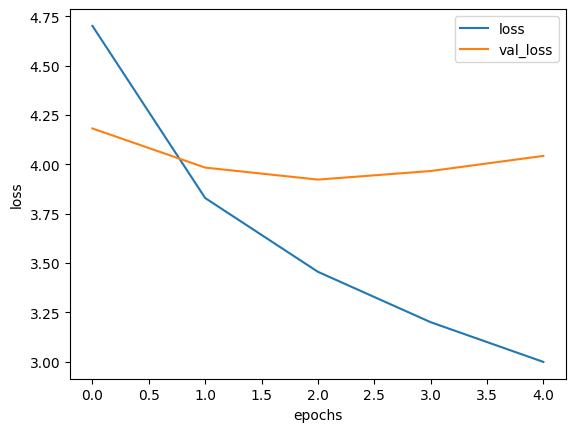

In [28]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

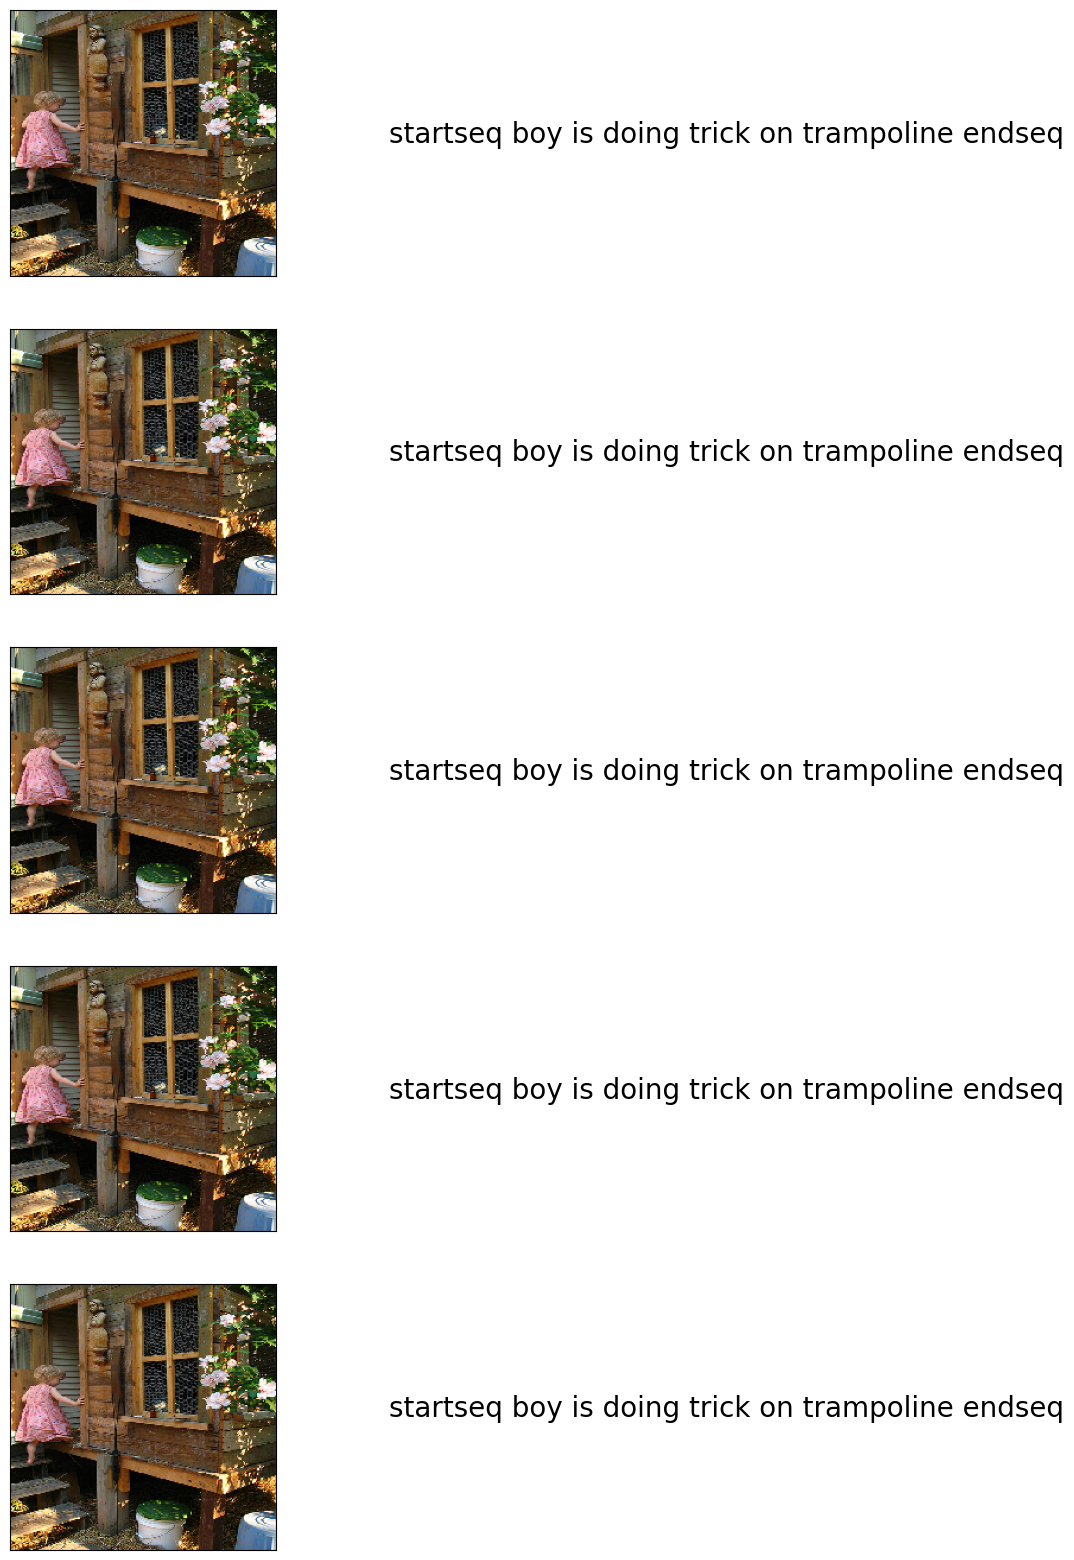

In [29]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [30]:
from nltk.translate.bleu_score import sentence_bleu
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], []
count = 0
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))

    caption_true = [ index_word[i] for i in tokenized_text ]
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg

    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

  2.47% is done..
  4.94% is done..
  7.42% is done..
  9.89% is done..
  12.36% is done..
  14.83% is done..
  17.30% is done..
  19.78% is done..
  22.25% is done..
  24.72% is done..
  27.19% is done..
  29.66% is done..
  32.13% is done..
  34.61% is done..
  37.08% is done..
  39.55% is done..
  42.02% is done..
  44.49% is done..
  46.97% is done..
  49.44% is done..
  51.91% is done..
  54.38% is done..
  56.85% is done..
  59.33% is done..
  61.80% is done..
  64.27% is done..
  66.74% is done..
  69.21% is done..
  71.68% is done..
  74.16% is done..
  76.63% is done..
  79.10% is done..
  81.57% is done..
  84.04% is done..
  86.52% is done..
  88.99% is done..
  91.46% is done..
  93.93% is done..
  96.40% is done..
  98.88% is done..


Bad Caption


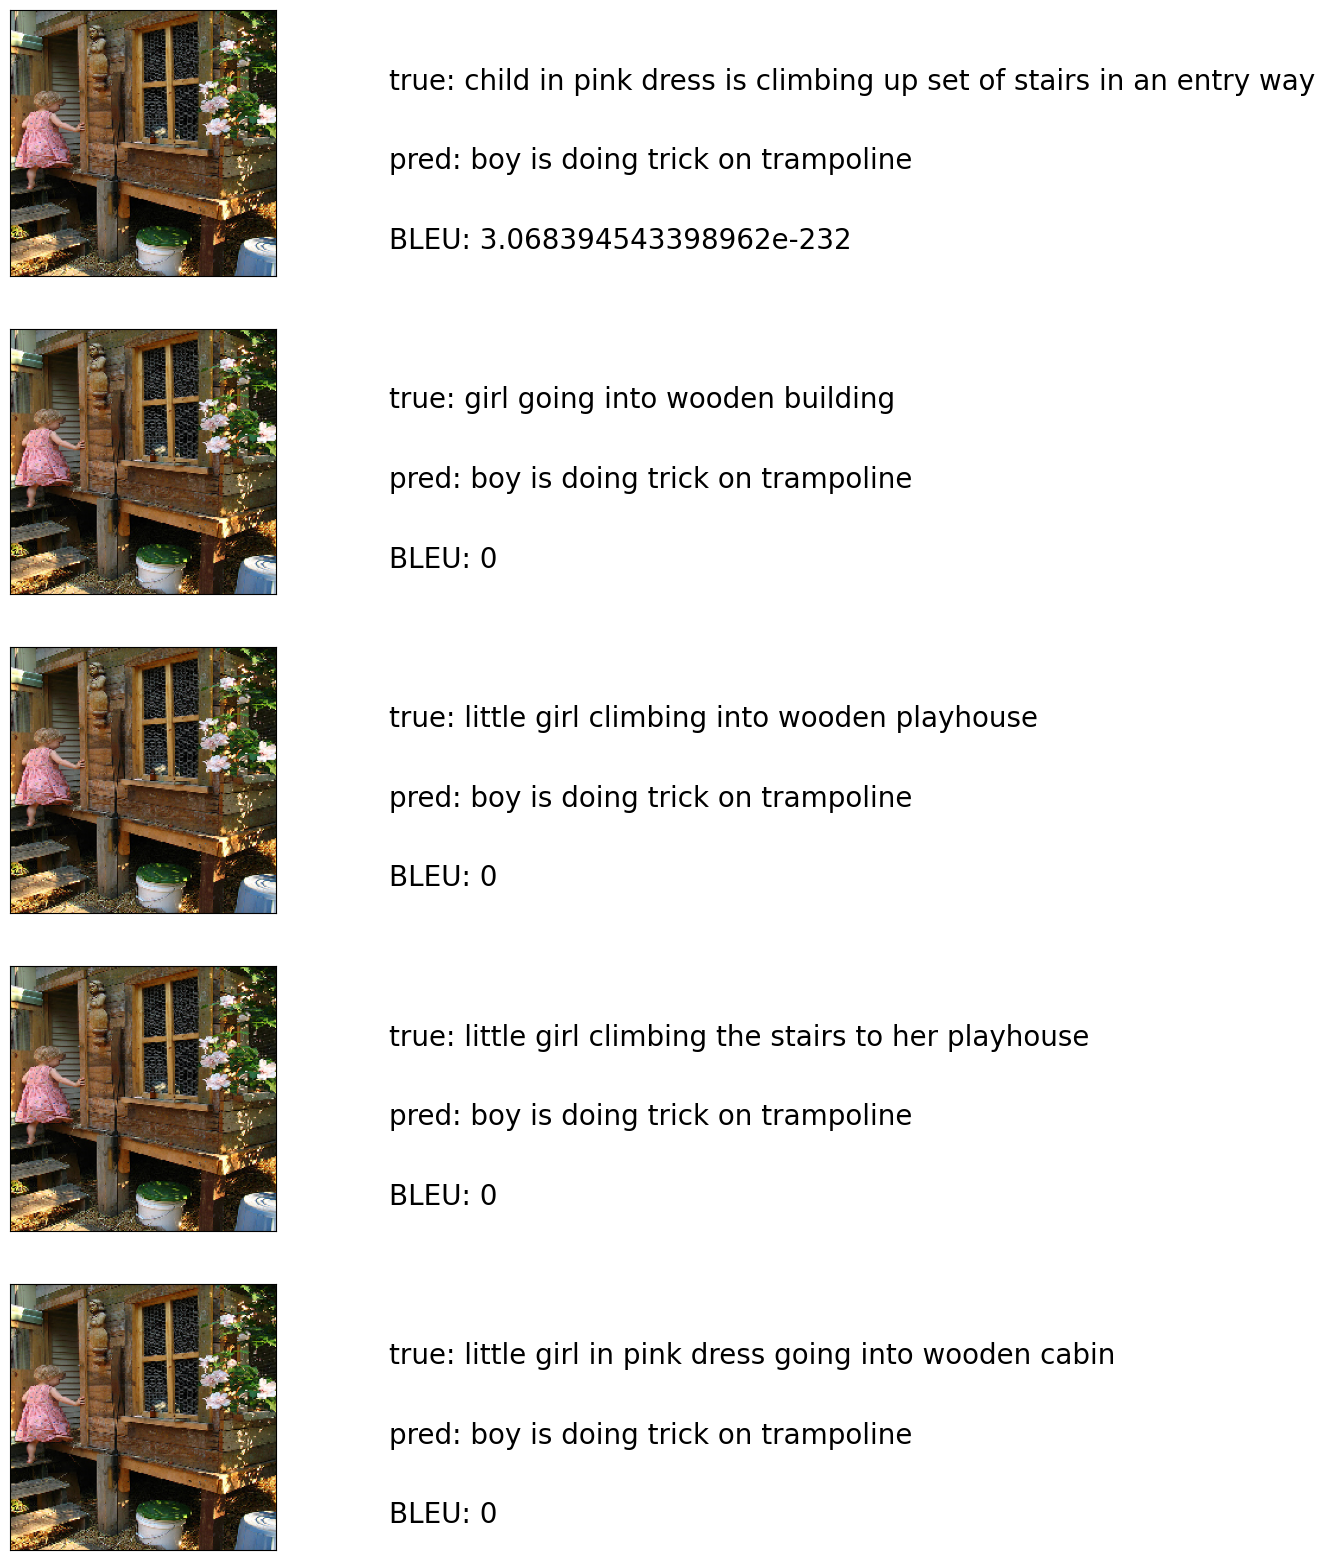

Good Caption


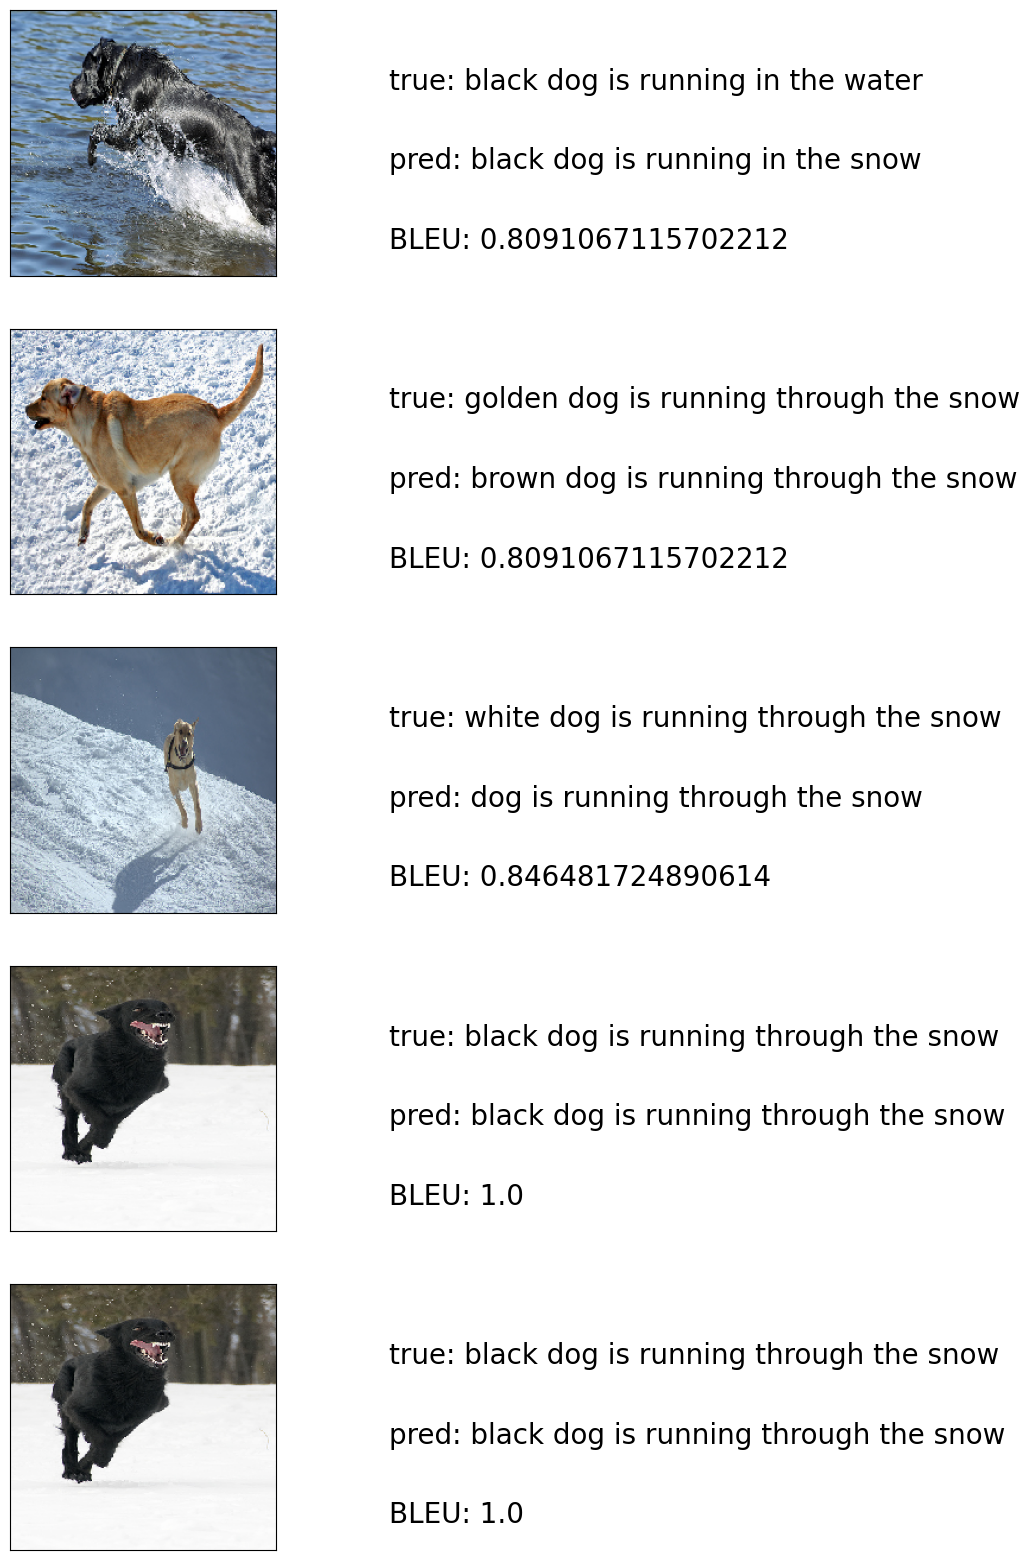

In [31]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)

        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)